<a href="https://colab.research.google.com/github/Graybang/CM4105-Honours-Project/blob/main/SRGAN_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
pip install opencv-python

  Using cached opencv_python-4.7.0.68-cp37-abi3-win_amd64.whl (38.2 MB)
Note: you may need to restart the kernel to use updated packages.


In [9]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras import layers, Model
from keras.models import Sequential
from keras.layers import Conv2D, PReLU, BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Define blocks to build the generator
def res_block(ip):

    res_model = Conv2D(64, (3,3), padding="same")(ip)
    res_model = BatchNormalization(momentum=0.5)(res_model)
    res_model = PReLU(shared_axes=[1,2])(res_model)

    res_model = Conv2D(64, (3,3), padding="same")(res_model)
    res_model = BatchNormalization(momentum=0.5)(res_model)

    return add([ip, res_model])

def upscale_block(ip):
    
    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D(size=2)(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)

    return up_model

# Generator model
def create_gen(gen_ip, num_res_block):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers, temp])

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    op = Conv2D(3, (9,9), padding="same")(layers)

    return Model(inputs=gen_ip, outputs=op)

# Descriminator block that will be used to construct the discriminator
def discriminator_block(ip, filters, strides=1, bn=True):

    disc_model = Conv2D(filters, (3,3), strides=strides, padding="same")(ip)

    if bn:
        disc_model = BatchNormalization(momentum=0.8)(disc_model)

    disc_model = LeakyReLU(alpha=0.2)(disc_model)

    return disc_model

# Descriminator as described in the original paper
def create_disc(disc_ip):
    
    df = 64
    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)

    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation="sigmoid")(d10)

    return Model(disc_ip, validity)

# VGG19 for the feature map

from keras.applications import VGG19

def build_vgg(hr_shape):
    vgg = VGG19(weights="imagenet", include_top=False, input_shape=hr_shape)

    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)

# Combined model
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    # losses from generated image and vgg features
    gen_img = gen_model(lr_ip)
    gen_features = vgg(gen_img)

    # load generated images into discriminator
    disc_model.trainable = False
    validity = disc_model(gen_img)

    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])

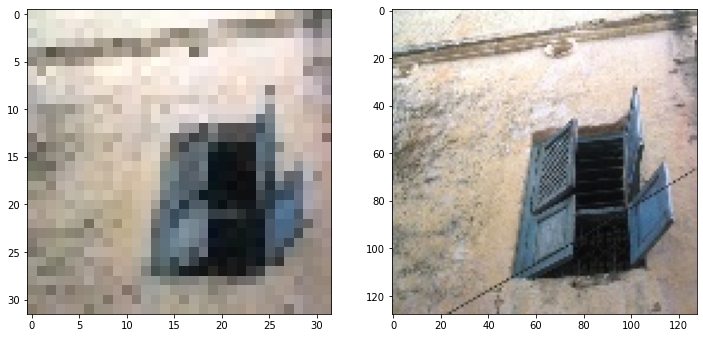

In [14]:
# load the datasets
n=5000
lr_list = os.listdir("OneDrive - Robert Gordon University/CM4105-Honours/CM4105-Honours-Project/data/lr_images")[:n]

lr_images = []
for img in lr_list:
    img_lr = cv2.imread("OneDrive - Robert Gordon University/CM4105-Honours/CM4105-Honours-Project/data/lr_images/" + img)
    img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
    lr_images.append(img_lr)


hr_list = os.listdir("OneDrive - Robert Gordon University/CM4105-Honours/CM4105-Honours-Project/data/hr_images")[:n]

hr_images = []
for img in hr_list:
    img_hr = cv2.imread("OneDrive - Robert Gordon University/CM4105-Honours/CM4105-Honours-Project/data/hr_images/" + img)
    img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
    hr_images.append(img_hr)

lr_images = np.array(lr_images)
hr_images = np.array(hr_images)

# sanity check, view random images
import random

image_number = random.randint(0, len(lr_images)-1)
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(np.reshape(lr_images[image_number], (32,32,3)))
plt.subplot(122)
plt.imshow(np.reshape(hr_images[image_number], (128,128,3)))
plt.show()

In [15]:
# scale values
lr_images = lr_images / 255.
hr_images = hr_images / 255.

# spit to train and test set
lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images, test_size=0.33, random_state=42)

# get shape of images
hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])

lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

In [16]:
# Generator
generator = create_gen(lr_ip, num_res_block=16)
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   15616       ['input_1[0][0]']                
                                                                                                  
 p_re_lu (PReLU)                (None, 32, 32, 64)   64          ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 64)   36928       ['p_re_lu[0][0]']                
                                                                                              

In [17]:
# Discriminator
discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_37 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 64)      0         
                                                                 
 conv2d_38 (Conv2D)          (None, 64, 64, 64)        36928     
                                                                 
 batch_normalization_33 (Bat  (None, 64, 64, 64)       256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 64)        0         
                                                           

In [18]:
vgg = build_vgg((128,128,3))
vgg.trainable = False
print(vgg.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [19]:
gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 model (Functional)             (None, 128, 128, 3)  2044291     ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_1 (Functional)           (None, 1)            38249281    ['model[0][0]']            

In [20]:
# create a list of images for LR and HR in batches from which
# a batch of images would be fetched during training
batch_size = 1
train_lr_batches = []
train_hr_batches = []

for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])

In [21]:
epochs = 5
# Enumerate training over epochs
for e in range(epochs):

    # assign a label of 0 to all fake (generated) images
    fake_label = np.zeros((batch_size, 1))
    # assign a label of 1 to all real images
    real_label = np.ones((batch_size,1))

    # create empty lists to populate generator and discriminator losses
    g_losses = []
    d_losses = []

    # Enumerate training over batches.
    for b in tqdm(range(len(train_hr_batches))):
        # Fetch a batch of LR images for training
        lr_imgs = train_lr_batches[b]
        # Fetch a batch of HR images for training
        hr_imgs = train_hr_batches[b]

        # Generated fake images
        fake_imgs = generator.predict_on_batch(lr_imgs) 

        # First, train the discriminator on fake and real HR images
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)

        # Now, train the generator by fixing the discriminator as non-trainable
        discriminator.trainable = False
        
        # Average the discriminator loss, just for reporting purposes
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real)

        # Extract VGG features, to be used towards calculating loss
        image_features = vgg.predict(hr_imgs)

        # Train the generator via GAN
        # remember we have 2 losses
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])

        # save losses to a list so we can average and report
        g_losses.append(g_loss)
        d_losses.append(d_loss)

    # convert the list of losses to an array to make it easy to average
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)

    # calculate the average losses for generator and discriminator
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)

    # report the progess during training
    print("epoch:", e+1,"g_loss:", g_loss, "d_loss:", d_loss)

    # save the model after every n epochs (5)
    if (e+1) % 5 == 0:
        generator.save("gen_e_" + str(e+1) + ".h5")

  0%|                                                                                         | 0/3350 [00:00<?, ?it/s]

1/1 [==============================] - 0s 326ms/step


  0%|                                                                              | 1/3350 [00:15<14:14:53, 15.32s/it]

1/1 [==============================] - 0s 12ms/step


  0%|                                                                               | 2/3350 [00:15<5:57:19,  6.40s/it]

1/1 [==============================] - 0s 14ms/step


  0%|                                                                               | 3/3350 [00:15<3:18:03,  3.55s/it]

1/1 [==============================] - 0s 12ms/step


  0%|                                                                               | 4/3350 [00:15<2:03:13,  2.21s/it]

1/1 [==============================] - 0s 12ms/step


  0%|                                                                               | 5/3350 [00:15<1:21:53,  1.47s/it]

1/1 [==============================] - 0s 12ms/step


  0%|▏                                                                                | 6/3350 [00:16<57:10,  1.03s/it]

1/1 [==============================] - 0s 12ms/step


  0%|▏                                                                                | 7/3350 [00:16<41:30,  1.34it/s]

1/1 [==============================] - 0s 12ms/step


  0%|▏                                                                                | 8/3350 [00:16<31:10,  1.79it/s]

1/1 [==============================] - 0s 12ms/step


  0%|▏                                                                                | 9/3350 [00:16<24:04,  2.31it/s]

1/1 [==============================] - 0s 12ms/step


  0%|▏                                                                               | 10/3350 [00:16<19:17,  2.89it/s]

1/1 [==============================] - 0s 12ms/step


  0%|▎                                                                               | 11/3350 [00:16<16:01,  3.47it/s]

1/1 [==============================] - 0s 13ms/step


  0%|▎                                                                               | 12/3350 [00:17<13:57,  3.99it/s]

1/1 [==============================] - 0s 11ms/step


  0%|▎                                                                               | 13/3350 [00:17<12:24,  4.48it/s]

1/1 [==============================] - 0s 12ms/step


  0%|▎                                                                               | 14/3350 [00:17<11:15,  4.94it/s]

1/1 [==============================] - 0s 14ms/step


  0%|▎                                                                               | 15/3350 [00:17<10:38,  5.22it/s]

1/1 [==============================] - 0s 13ms/step


  0%|▍                                                                               | 16/3350 [00:17<10:13,  5.43it/s]

1/1 [==============================] - 0s 12ms/step


  1%|▍                                                                               | 17/3350 [00:17<09:55,  5.60it/s]

1/1 [==============================] - 0s 11ms/step


  1%|▍                                                                               | 18/3350 [00:18<09:23,  5.91it/s]

1/1 [==============================] - 0s 13ms/step


  1%|▍                                                                               | 19/3350 [00:18<09:12,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


  1%|▍                                                                               | 20/3350 [00:18<09:01,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


  1%|▌                                                                               | 21/3350 [00:18<09:10,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


  1%|▌                                                                               | 22/3350 [00:18<08:58,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


  1%|▌                                                                               | 23/3350 [00:18<08:46,  6.32it/s]

1/1 [==============================] - 0s 12ms/step


  1%|▌                                                                               | 24/3350 [00:18<08:37,  6.42it/s]

1/1 [==============================] - 0s 12ms/step


  1%|▌                                                                               | 25/3350 [00:19<08:34,  6.47it/s]

1/1 [==============================] - 0s 12ms/step


  1%|▌                                                                               | 26/3350 [00:19<08:38,  6.41it/s]

1/1 [==============================] - 0s 12ms/step


  1%|▋                                                                               | 27/3350 [00:19<08:48,  6.29it/s]

1/1 [==============================] - 0s 13ms/step


  1%|▋                                                                               | 28/3350 [00:19<08:44,  6.34it/s]

1/1 [==============================] - 0s 13ms/step


  1%|▋                                                                               | 29/3350 [00:19<08:45,  6.32it/s]

1/1 [==============================] - 0s 12ms/step


  1%|▋                                                                               | 30/3350 [00:19<08:37,  6.41it/s]

1/1 [==============================] - 0s 13ms/step


  1%|▋                                                                               | 31/3350 [00:20<08:43,  6.34it/s]

1/1 [==============================] - 0s 12ms/step


  1%|▊                                                                               | 32/3350 [00:20<08:42,  6.35it/s]

1/1 [==============================] - 0s 12ms/step


  1%|▊                                                                               | 33/3350 [00:20<08:40,  6.38it/s]

1/1 [==============================] - 0s 13ms/step


  1%|▊                                                                               | 34/3350 [00:20<08:50,  6.26it/s]

1/1 [==============================] - 0s 13ms/step


  1%|▊                                                                               | 35/3350 [00:20<08:50,  6.25it/s]

1/1 [==============================] - 0s 12ms/step


  1%|▊                                                                               | 36/3350 [00:20<08:48,  6.27it/s]

1/1 [==============================] - 0s 12ms/step


  1%|▉                                                                               | 37/3350 [00:21<08:55,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


  1%|▉                                                                               | 38/3350 [00:21<09:01,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


  1%|▉                                                                               | 39/3350 [00:21<08:59,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


  1%|▉                                                                               | 40/3350 [00:21<08:55,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


  1%|▉                                                                               | 41/3350 [00:21<08:44,  6.30it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█                                                                               | 42/3350 [00:21<08:35,  6.42it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█                                                                               | 43/3350 [00:21<08:35,  6.42it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█                                                                               | 44/3350 [00:22<08:31,  6.47it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█                                                                               | 45/3350 [00:22<08:31,  6.47it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█                                                                               | 46/3350 [00:22<08:28,  6.50it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█                                                                               | 47/3350 [00:22<08:29,  6.49it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█▏                                                                              | 48/3350 [00:22<08:27,  6.50it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                              | 49/3350 [00:22<08:34,  6.41it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                              | 50/3350 [00:23<08:32,  6.44it/s]

1/1 [==============================] - 0s 13ms/step


  2%|█▏                                                                              | 51/3350 [00:23<08:34,  6.42it/s]

1/1 [==============================] - 0s 13ms/step


  2%|█▏                                                                              | 52/3350 [00:23<08:37,  6.38it/s]

1/1 [==============================] - 0s 12ms/step


  2%|█▎                                                                              | 53/3350 [00:23<08:37,  6.37it/s]

1/1 [==============================] - 0s 12ms/step


  2%|█▎                                                                              | 54/3350 [00:23<08:35,  6.40it/s]

1/1 [==============================] - 0s 13ms/step


  2%|█▎                                                                              | 55/3350 [00:23<08:35,  6.39it/s]

1/1 [==============================] - 0s 12ms/step


  2%|█▎                                                                              | 56/3350 [00:23<08:30,  6.46it/s]

1/1 [==============================] - 0s 14ms/step


  2%|█▎                                                                              | 57/3350 [00:24<08:39,  6.33it/s]

1/1 [==============================] - 0s 15ms/step


  2%|█▍                                                                              | 58/3350 [00:24<08:48,  6.22it/s]

1/1 [==============================] - 0s 14ms/step


  2%|█▍                                                                              | 59/3350 [00:24<08:46,  6.26it/s]

1/1 [==============================] - 0s 12ms/step


  2%|█▍                                                                              | 60/3350 [00:24<08:41,  6.31it/s]

1/1 [==============================] - 0s 17ms/step


  2%|█▍                                                                              | 61/3350 [00:24<08:45,  6.26it/s]

1/1 [==============================] - 0s 12ms/step


  2%|█▍                                                                              | 62/3350 [00:24<08:37,  6.35it/s]

1/1 [==============================] - 0s 12ms/step


  2%|█▌                                                                              | 63/3350 [00:25<08:37,  6.36it/s]

1/1 [==============================] - 0s 12ms/step


  2%|█▌                                                                              | 64/3350 [00:25<08:41,  6.30it/s]

1/1 [==============================] - 0s 12ms/step


  2%|█▌                                                                              | 65/3350 [00:25<08:40,  6.31it/s]

1/1 [==============================] - 0s 14ms/step


  2%|█▌                                                                              | 66/3350 [00:25<08:45,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


  2%|█▌                                                                              | 67/3350 [00:25<09:35,  5.70it/s]

1/1 [==============================] - 0s 13ms/step


  2%|█▌                                                                              | 68/3350 [00:26<12:23,  4.41it/s]

1/1 [==============================] - 0s 13ms/step


  2%|█▋                                                                              | 69/3350 [00:26<12:16,  4.45it/s]

1/1 [==============================] - 0s 17ms/step


  2%|█▋                                                                              | 70/3350 [00:26<11:53,  4.60it/s]

1/1 [==============================] - 0s 17ms/step


  2%|█▋                                                                              | 71/3350 [00:26<11:50,  4.61it/s]

1/1 [==============================] - 0s 19ms/step


  2%|█▋                                                                              | 72/3350 [00:27<12:26,  4.39it/s]

1/1 [==============================] - 0s 17ms/step


  2%|█▋                                                                              | 73/3350 [00:27<11:49,  4.62it/s]

1/1 [==============================] - 0s 15ms/step


  2%|█▊                                                                              | 74/3350 [00:27<11:05,  4.93it/s]

1/1 [==============================] - 0s 12ms/step


  2%|█▊                                                                              | 75/3350 [00:27<10:22,  5.26it/s]

1/1 [==============================] - 0s 12ms/step


  2%|█▊                                                                              | 76/3350 [00:27<09:49,  5.55it/s]

1/1 [==============================] - 0s 12ms/step


  2%|█▊                                                                              | 77/3350 [00:27<09:23,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


  2%|█▊                                                                              | 78/3350 [00:28<09:03,  6.02it/s]

1/1 [==============================] - 0s 11ms/step


  2%|█▉                                                                              | 79/3350 [00:28<08:58,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


  2%|█▉                                                                              | 80/3350 [00:28<08:53,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


  2%|█▉                                                                              | 81/3350 [00:28<08:52,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


  2%|█▉                                                                              | 82/3350 [00:28<08:54,  6.12it/s]

1/1 [==============================] - 0s 14ms/step


  2%|█▉                                                                              | 83/3350 [00:28<08:59,  6.06it/s]

1/1 [==============================] - 0s 14ms/step


  3%|██                                                                              | 84/3350 [00:29<08:57,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


  3%|██                                                                              | 85/3350 [00:29<09:03,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██                                                                              | 86/3350 [00:29<08:57,  6.08it/s]

1/1 [==============================] - 0s 14ms/step


  3%|██                                                                              | 87/3350 [00:29<09:02,  6.01it/s]

1/1 [==============================] - 0s 14ms/step


  3%|██                                                                              | 88/3350 [00:29<08:56,  6.08it/s]

1/1 [==============================] - 0s 17ms/step


  3%|██▏                                                                             | 89/3350 [00:29<08:59,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


  3%|██▏                                                                             | 90/3350 [00:30<08:55,  6.09it/s]

1/1 [==============================] - 0s 14ms/step


  3%|██▏                                                                             | 91/3350 [00:30<09:01,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▏                                                                             | 92/3350 [00:30<08:55,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


  3%|██▏                                                                             | 93/3350 [00:30<08:54,  6.10it/s]

1/1 [==============================] - 0s 14ms/step


  3%|██▏                                                                             | 94/3350 [00:30<08:55,  6.08it/s]

1/1 [==============================] - 0s 15ms/step


  3%|██▎                                                                             | 95/3350 [00:30<09:01,  6.01it/s]

1/1 [==============================] - 0s 14ms/step


  3%|██▎                                                                             | 96/3350 [00:30<08:53,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▎                                                                             | 97/3350 [00:31<08:44,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▎                                                                             | 98/3350 [00:31<08:38,  6.27it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▎                                                                             | 99/3350 [00:31<08:35,  6.30it/s]

1/1 [==============================] - 0s 11ms/step


  3%|██▎                                                                            | 100/3350 [00:31<08:37,  6.28it/s]

1/1 [==============================] - 0s 13ms/step


  3%|██▍                                                                            | 101/3350 [00:31<08:36,  6.29it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                            | 102/3350 [00:31<08:31,  6.36it/s]

1/1 [==============================] - 0s 11ms/step


  3%|██▍                                                                            | 103/3350 [00:32<08:25,  6.43it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                            | 104/3350 [00:32<08:24,  6.43it/s]

1/1 [==============================] - 0s 11ms/step


  3%|██▍                                                                            | 105/3350 [00:32<08:26,  6.41it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                            | 106/3350 [00:32<08:27,  6.40it/s]

1/1 [==============================] - 0s 11ms/step


  3%|██▌                                                                            | 107/3350 [00:32<08:29,  6.36it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▌                                                                            | 108/3350 [00:32<08:29,  6.37it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▌                                                                            | 109/3350 [00:33<08:30,  6.35it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▌                                                                            | 110/3350 [00:33<08:19,  6.49it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▌                                                                            | 111/3350 [00:33<08:15,  6.53it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▋                                                                            | 112/3350 [00:33<08:15,  6.54it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▋                                                                            | 113/3350 [00:33<08:14,  6.55it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▋                                                                            | 114/3350 [00:33<08:13,  6.56it/s]

1/1 [==============================] - 0s 11ms/step


  3%|██▋                                                                            | 115/3350 [00:33<08:13,  6.56it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▋                                                                            | 116/3350 [00:34<08:11,  6.58it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▊                                                                            | 117/3350 [00:34<08:21,  6.45it/s]

1/1 [==============================] - 0s 12ms/step


  4%|██▊                                                                            | 118/3350 [00:34<08:22,  6.43it/s]

1/1 [==============================] - 0s 12ms/step


  4%|██▊                                                                            | 119/3350 [00:34<08:16,  6.51it/s]

1/1 [==============================] - 0s 12ms/step


  4%|██▊                                                                            | 120/3350 [00:34<08:13,  6.55it/s]

1/1 [==============================] - 0s 12ms/step


  4%|██▊                                                                            | 121/3350 [00:34<08:14,  6.53it/s]

1/1 [==============================] - 0s 12ms/step


  4%|██▉                                                                            | 122/3350 [00:35<08:12,  6.56it/s]

1/1 [==============================] - 0s 11ms/step


  4%|██▉                                                                            | 123/3350 [00:35<08:09,  6.59it/s]

1/1 [==============================] - 0s 12ms/step


  4%|██▉                                                                            | 124/3350 [00:35<08:06,  6.63it/s]

1/1 [==============================] - 0s 11ms/step


  4%|██▉                                                                            | 125/3350 [00:35<08:07,  6.62it/s]

1/1 [==============================] - 0s 12ms/step


  4%|██▉                                                                            | 126/3350 [00:35<08:11,  6.56it/s]

1/1 [==============================] - 0s 12ms/step


  4%|██▉                                                                            | 127/3350 [00:35<08:13,  6.53it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███                                                                            | 128/3350 [00:35<08:09,  6.58it/s]

1/1 [==============================] - 0s 11ms/step


  4%|███                                                                            | 129/3350 [00:36<08:08,  6.59it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███                                                                            | 130/3350 [00:36<08:08,  6.59it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███                                                                            | 131/3350 [00:36<08:05,  6.63it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███                                                                            | 132/3350 [00:36<08:05,  6.62it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▏                                                                           | 133/3350 [00:36<08:06,  6.61it/s]

1/1 [==============================] - 0s 11ms/step


  4%|███▏                                                                           | 134/3350 [00:36<08:05,  6.62it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▏                                                                           | 135/3350 [00:36<08:06,  6.61it/s]

1/1 [==============================] - 0s 11ms/step


  4%|███▏                                                                           | 136/3350 [00:37<08:06,  6.61it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▏                                                                           | 137/3350 [00:37<08:07,  6.59it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▎                                                                           | 138/3350 [00:37<08:09,  6.56it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▎                                                                           | 139/3350 [00:37<08:13,  6.51it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▎                                                                           | 140/3350 [00:37<08:11,  6.53it/s]

1/1 [==============================] - 0s 13ms/step


  4%|███▎                                                                           | 141/3350 [00:37<08:21,  6.39it/s]

1/1 [==============================] - 0s 13ms/step


  4%|███▎                                                                           | 142/3350 [00:38<08:31,  6.27it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▎                                                                           | 143/3350 [00:38<08:37,  6.20it/s]

1/1 [==============================] - 0s 16ms/step


  4%|███▍                                                                           | 144/3350 [00:38<09:09,  5.83it/s]

1/1 [==============================] - 0s 15ms/step


  4%|███▍                                                                           | 145/3350 [00:38<09:12,  5.80it/s]

1/1 [==============================] - 0s 13ms/step


  4%|███▍                                                                           | 146/3350 [00:38<09:07,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▍                                                                           | 147/3350 [00:38<09:01,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▍                                                                           | 148/3350 [00:39<08:56,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▌                                                                           | 149/3350 [00:39<08:52,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▌                                                                           | 150/3350 [00:39<08:42,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


  5%|███▌                                                                           | 151/3350 [00:39<08:34,  6.22it/s]

1/1 [==============================] - 0s 12ms/step


  5%|███▌                                                                           | 152/3350 [00:39<08:25,  6.32it/s]

1/1 [==============================] - 0s 12ms/step


  5%|███▌                                                                           | 153/3350 [00:39<08:20,  6.38it/s]

1/1 [==============================] - 0s 12ms/step


  5%|███▋                                                                           | 154/3350 [00:40<08:31,  6.25it/s]

1/1 [==============================] - 0s 12ms/step


  5%|███▋                                                                           | 155/3350 [00:40<08:27,  6.30it/s]

1/1 [==============================] - 0s 13ms/step


  5%|███▋                                                                           | 156/3350 [00:40<08:21,  6.37it/s]

1/1 [==============================] - 0s 12ms/step


  5%|███▋                                                                           | 157/3350 [00:40<08:19,  6.40it/s]

1/1 [==============================] - 0s 12ms/step


  5%|███▋                                                                           | 158/3350 [00:40<08:12,  6.48it/s]

1/1 [==============================] - 0s 12ms/step


  5%|███▋                                                                           | 159/3350 [00:40<08:09,  6.52it/s]

1/1 [==============================] - 0s 11ms/step


  5%|███▊                                                                           | 160/3350 [00:40<08:07,  6.55it/s]

1/1 [==============================] - 0s 12ms/step


  5%|███▊                                                                           | 161/3350 [00:41<08:06,  6.56it/s]

1/1 [==============================] - 0s 12ms/step


  5%|███▊                                                                           | 162/3350 [00:41<08:04,  6.58it/s]

1/1 [==============================] - 0s 12ms/step


  5%|███▊                                                                           | 163/3350 [00:41<08:03,  6.59it/s]

1/1 [==============================] - 0s 13ms/step


  5%|███▊                                                                           | 164/3350 [00:41<08:04,  6.57it/s]

1/1 [==============================] - 0s 12ms/step


  5%|███▉                                                                           | 165/3350 [00:41<08:04,  6.57it/s]

1/1 [==============================] - 0s 11ms/step


  5%|███▉                                                                           | 166/3350 [00:41<08:00,  6.62it/s]

1/1 [==============================] - 0s 11ms/step


  5%|███▉                                                                           | 167/3350 [00:42<07:59,  6.64it/s]

1/1 [==============================] - 0s 11ms/step


  5%|███▉                                                                           | 168/3350 [00:42<07:57,  6.66it/s]

1/1 [==============================] - 0s 12ms/step


  5%|███▉                                                                           | 169/3350 [00:42<07:56,  6.67it/s]

1/1 [==============================] - 0s 12ms/step


  5%|████                                                                           | 170/3350 [00:42<07:57,  6.66it/s]

1/1 [==============================] - 0s 12ms/step


  5%|████                                                                           | 171/3350 [00:42<07:57,  6.66it/s]

1/1 [==============================] - 0s 11ms/step


  5%|████                                                                           | 172/3350 [00:42<07:56,  6.66it/s]

1/1 [==============================] - 0s 12ms/step


  5%|████                                                                           | 173/3350 [00:42<07:56,  6.66it/s]

1/1 [==============================] - 0s 12ms/step


  5%|████                                                                           | 174/3350 [00:43<07:55,  6.68it/s]

1/1 [==============================] - 0s 12ms/step


  5%|████▏                                                                          | 175/3350 [00:43<08:01,  6.60it/s]

1/1 [==============================] - 0s 11ms/step


  5%|████▏                                                                          | 176/3350 [00:43<08:03,  6.56it/s]

1/1 [==============================] - 0s 13ms/step


  5%|████▏                                                                          | 177/3350 [00:43<08:03,  6.56it/s]

1/1 [==============================] - 0s 11ms/step


  5%|████▏                                                                          | 178/3350 [00:43<08:05,  6.54it/s]

1/1 [==============================] - 0s 16ms/step


  5%|████▏                                                                          | 179/3350 [00:43<09:22,  5.64it/s]

1/1 [==============================] - 0s 12ms/step


  5%|████▏                                                                          | 180/3350 [00:44<09:54,  5.34it/s]

1/1 [==============================] - 0s 13ms/step


  5%|████▎                                                                          | 181/3350 [00:44<12:39,  4.17it/s]

1/1 [==============================] - 0s 13ms/step


  5%|████▎                                                                          | 182/3350 [00:44<11:23,  4.63it/s]

1/1 [==============================] - 0s 13ms/step


  5%|████▎                                                                          | 183/3350 [00:44<10:36,  4.98it/s]

1/1 [==============================] - 0s 13ms/step


  5%|████▎                                                                          | 184/3350 [00:44<10:06,  5.22it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▎                                                                          | 185/3350 [00:45<09:37,  5.48it/s]

1/1 [==============================] - 0s 15ms/step


  6%|████▍                                                                          | 186/3350 [00:45<09:26,  5.59it/s]

1/1 [==============================] - 0s 16ms/step


  6%|████▍                                                                          | 187/3350 [00:45<09:36,  5.49it/s]

1/1 [==============================] - 0s 14ms/step


  6%|████▍                                                                          | 188/3350 [00:45<09:42,  5.43it/s]

1/1 [==============================] - 0s 14ms/step


  6%|████▍                                                                          | 189/3350 [00:45<09:29,  5.56it/s]

1/1 [==============================] - 0s 13ms/step


  6%|████▍                                                                          | 190/3350 [00:46<09:14,  5.70it/s]

1/1 [==============================] - 0s 13ms/step


  6%|████▌                                                                          | 191/3350 [00:46<08:57,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▌                                                                          | 192/3350 [00:46<08:44,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


  6%|████▌                                                                          | 193/3350 [00:46<08:34,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


  6%|████▌                                                                          | 194/3350 [00:46<08:40,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▌                                                                          | 195/3350 [00:46<08:32,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▌                                                                          | 196/3350 [00:46<08:25,  6.24it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▋                                                                          | 197/3350 [00:47<08:18,  6.33it/s]

1/1 [==============================] - 0s 11ms/step


  6%|████▋                                                                          | 198/3350 [00:47<08:10,  6.43it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▋                                                                          | 199/3350 [00:47<08:06,  6.47it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▋                                                                          | 200/3350 [00:47<08:08,  6.45it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▋                                                                          | 201/3350 [00:47<08:10,  6.41it/s]

1/1 [==============================] - 0s 11ms/step


  6%|████▊                                                                          | 202/3350 [00:47<08:07,  6.46it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▊                                                                          | 203/3350 [00:48<08:00,  6.55it/s]

1/1 [==============================] - 0s 11ms/step


  6%|████▊                                                                          | 204/3350 [00:48<07:58,  6.57it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▊                                                                          | 205/3350 [00:48<07:58,  6.57it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▊                                                                          | 206/3350 [00:48<07:57,  6.59it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                          | 207/3350 [00:48<07:59,  6.56it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                          | 208/3350 [00:48<07:58,  6.57it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                          | 209/3350 [00:48<07:55,  6.61it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                          | 210/3350 [00:49<07:54,  6.61it/s]

1/1 [==============================] - 0s 13ms/step


  6%|████▉                                                                          | 211/3350 [00:49<07:56,  6.59it/s]

1/1 [==============================] - 0s 13ms/step


  6%|████▉                                                                          | 212/3350 [00:49<07:58,  6.56it/s]

1/1 [==============================] - 0s 12ms/step


  6%|█████                                                                          | 213/3350 [00:49<07:58,  6.55it/s]

1/1 [==============================] - 0s 12ms/step


  6%|█████                                                                          | 214/3350 [00:49<07:58,  6.55it/s]

1/1 [==============================] - 0s 12ms/step


  6%|█████                                                                          | 215/3350 [00:49<07:57,  6.57it/s]

1/1 [==============================] - 0s 12ms/step


  6%|█████                                                                          | 216/3350 [00:50<07:57,  6.56it/s]

1/1 [==============================] - 0s 19ms/step


  6%|█████                                                                          | 217/3350 [00:50<08:03,  6.48it/s]

1/1 [==============================] - 0s 12ms/step


  7%|█████▏                                                                         | 218/3350 [00:50<08:00,  6.52it/s]

1/1 [==============================] - 0s 12ms/step


  7%|█████▏                                                                         | 219/3350 [00:50<07:58,  6.54it/s]

1/1 [==============================] - 0s 12ms/step


  7%|█████▏                                                                         | 220/3350 [00:50<08:02,  6.49it/s]

1/1 [==============================] - 0s 12ms/step


  7%|█████▏                                                                         | 221/3350 [00:50<08:17,  6.29it/s]

1/1 [==============================] - 0s 12ms/step


  7%|█████▏                                                                         | 222/3350 [00:50<08:15,  6.32it/s]

1/1 [==============================] - 0s 12ms/step


  7%|█████▎                                                                         | 223/3350 [00:51<08:12,  6.36it/s]

1/1 [==============================] - 0s 12ms/step


  7%|█████▎                                                                         | 224/3350 [00:51<08:11,  6.36it/s]

1/1 [==============================] - 0s 15ms/step


  7%|█████▎                                                                         | 225/3350 [00:51<08:22,  6.22it/s]

1/1 [==============================] - 0s 14ms/step


  7%|█████▎                                                                         | 226/3350 [00:51<08:38,  6.03it/s]

1/1 [==============================] - 0s 13ms/step


  7%|█████▎                                                                         | 227/3350 [00:51<08:38,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


  7%|█████▍                                                                         | 228/3350 [00:51<08:36,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


  7%|█████▍                                                                         | 229/3350 [00:52<08:36,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


  7%|█████▍                                                                         | 230/3350 [00:52<08:46,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


  7%|█████▍                                                                         | 231/3350 [00:52<08:43,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


  7%|█████▍                                                                         | 232/3350 [00:52<08:49,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


  7%|█████▍                                                                         | 233/3350 [00:52<08:39,  6.00it/s]

1/1 [==============================] - 0s 15ms/step


  7%|█████▌                                                                         | 234/3350 [00:52<08:38,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


  7%|█████▌                                                                         | 235/3350 [00:53<08:41,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


  7%|█████▌                                                                         | 236/3350 [00:53<08:36,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


  7%|█████▌                                                                         | 237/3350 [00:53<08:35,  6.04it/s]

1/1 [==============================] - 0s 14ms/step


  7%|█████▌                                                                         | 238/3350 [00:53<08:48,  5.88it/s]

1/1 [==============================] - 0s 13ms/step


  7%|█████▋                                                                         | 239/3350 [00:53<08:44,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


  7%|█████▋                                                                         | 240/3350 [00:53<08:41,  5.96it/s]

1/1 [==============================] - 0s 14ms/step


  7%|█████▋                                                                         | 241/3350 [00:54<10:25,  4.97it/s]

1/1 [==============================] - 0s 17ms/step


  7%|█████▋                                                                         | 242/3350 [00:54<15:51,  3.27it/s]

1/1 [==============================] - 0s 32ms/step


  7%|█████▋                                                                         | 243/3350 [00:55<17:10,  3.02it/s]

1/1 [==============================] - 0s 38ms/step


  7%|█████▊                                                                         | 244/3350 [00:55<18:09,  2.85it/s]

1/1 [==============================] - 0s 15ms/step


  7%|█████▊                                                                         | 245/3350 [00:55<16:25,  3.15it/s]

1/1 [==============================] - 0s 14ms/step


  7%|█████▊                                                                         | 246/3350 [00:56<14:52,  3.48it/s]

1/1 [==============================] - 0s 12ms/step


  7%|█████▊                                                                         | 247/3350 [00:56<14:19,  3.61it/s]

1/1 [==============================] - 0s 15ms/step


  7%|█████▊                                                                         | 248/3350 [00:56<13:21,  3.87it/s]

1/1 [==============================] - 0s 18ms/step


  7%|█████▊                                                                         | 249/3350 [00:56<12:32,  4.12it/s]

1/1 [==============================] - 0s 14ms/step


  7%|█████▉                                                                         | 250/3350 [00:56<12:18,  4.20it/s]

1/1 [==============================] - 0s 18ms/step


  7%|█████▉                                                                         | 251/3350 [00:57<12:21,  4.18it/s]

1/1 [==============================] - 0s 15ms/step


  8%|█████▉                                                                         | 252/3350 [00:57<11:26,  4.51it/s]

1/1 [==============================] - 0s 14ms/step


  8%|█████▉                                                                         | 253/3350 [00:57<10:37,  4.86it/s]

1/1 [==============================] - 0s 12ms/step


  8%|█████▉                                                                         | 254/3350 [00:57<09:49,  5.25it/s]

1/1 [==============================] - 0s 12ms/step


  8%|██████                                                                         | 255/3350 [00:57<09:13,  5.59it/s]

1/1 [==============================] - 0s 12ms/step


  8%|██████                                                                         | 256/3350 [00:58<08:46,  5.87it/s]

1/1 [==============================] - 0s 11ms/step


  8%|██████                                                                         | 257/3350 [00:58<08:26,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


  8%|██████                                                                         | 258/3350 [00:58<08:12,  6.28it/s]

1/1 [==============================] - 0s 11ms/step


  8%|██████                                                                         | 259/3350 [00:58<08:05,  6.37it/s]

1/1 [==============================] - 0s 11ms/step


  8%|██████▏                                                                        | 260/3350 [00:58<07:58,  6.45it/s]

1/1 [==============================] - 0s 13ms/step


  8%|██████▏                                                                        | 261/3350 [00:58<08:04,  6.38it/s]

1/1 [==============================] - 0s 13ms/step


  8%|██████▏                                                                        | 262/3350 [00:58<08:17,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


  8%|██████▏                                                                        | 263/3350 [00:59<08:33,  6.01it/s]

1/1 [==============================] - 0s 11ms/step


  8%|██████▏                                                                        | 264/3350 [00:59<08:49,  5.82it/s]

1/1 [==============================] - 0s 13ms/step


  8%|██████▏                                                                        | 265/3350 [00:59<09:12,  5.59it/s]

1/1 [==============================] - 0s 14ms/step


  8%|██████▎                                                                        | 266/3350 [00:59<09:25,  5.46it/s]

1/1 [==============================] - 0s 11ms/step


  8%|██████▎                                                                        | 267/3350 [00:59<09:33,  5.38it/s]

1/1 [==============================] - 0s 13ms/step


  8%|██████▎                                                                        | 268/3350 [01:00<09:55,  5.18it/s]

1/1 [==============================] - 0s 12ms/step


  8%|██████▎                                                                        | 269/3350 [01:00<10:18,  4.98it/s]

1/1 [==============================] - 0s 12ms/step


  8%|██████▎                                                                        | 270/3350 [01:00<10:12,  5.03it/s]

1/1 [==============================] - 0s 12ms/step


  8%|██████▍                                                                        | 271/3350 [01:00<10:48,  4.75it/s]

1/1 [==============================] - 0s 14ms/step


  8%|██████▍                                                                        | 272/3350 [01:00<11:09,  4.60it/s]

1/1 [==============================] - 0s 13ms/step


  8%|██████▍                                                                        | 273/3350 [01:01<11:28,  4.47it/s]

1/1 [==============================] - 0s 13ms/step


  8%|██████▍                                                                        | 274/3350 [01:01<11:28,  4.47it/s]

1/1 [==============================] - 0s 12ms/step


  8%|██████▍                                                                        | 275/3350 [01:01<11:22,  4.51it/s]

1/1 [==============================] - 0s 12ms/step


  8%|██████▌                                                                        | 276/3350 [01:01<11:33,  4.43it/s]

1/1 [==============================] - 0s 13ms/step


  8%|██████▌                                                                        | 277/3350 [01:02<11:22,  4.50it/s]

1/1 [==============================] - 0s 12ms/step


  8%|██████▌                                                                        | 278/3350 [01:02<11:08,  4.60it/s]

1/1 [==============================] - 0s 17ms/step


  8%|██████▌                                                                        | 279/3350 [01:02<11:26,  4.47it/s]

1/1 [==============================] - 0s 13ms/step


  8%|██████▌                                                                        | 280/3350 [01:02<11:27,  4.46it/s]

1/1 [==============================] - 0s 12ms/step


  8%|██████▋                                                                        | 281/3350 [01:02<11:10,  4.58it/s]

1/1 [==============================] - 0s 12ms/step


  8%|██████▋                                                                        | 282/3350 [01:03<10:53,  4.69it/s]

1/1 [==============================] - 0s 12ms/step


  8%|██████▋                                                                        | 283/3350 [01:03<10:58,  4.66it/s]

1/1 [==============================] - 0s 12ms/step


  8%|██████▋                                                                        | 284/3350 [01:03<10:50,  4.72it/s]

1/1 [==============================] - 0s 12ms/step


  9%|██████▋                                                                        | 285/3350 [01:03<10:45,  4.75it/s]

1/1 [==============================] - 0s 12ms/step


  9%|██████▋                                                                        | 286/3350 [01:04<10:43,  4.76it/s]

1/1 [==============================] - 0s 12ms/step


  9%|██████▊                                                                        | 287/3350 [01:04<10:43,  4.76it/s]

1/1 [==============================] - 0s 12ms/step


  9%|██████▊                                                                        | 288/3350 [01:04<10:40,  4.78it/s]

1/1 [==============================] - 0s 13ms/step


  9%|██████▊                                                                        | 289/3350 [01:04<11:33,  4.41it/s]

1/1 [==============================] - 0s 13ms/step


  9%|██████▊                                                                        | 290/3350 [01:04<11:16,  4.52it/s]

1/1 [==============================] - 0s 12ms/step


  9%|██████▊                                                                        | 291/3350 [01:05<11:09,  4.57it/s]

1/1 [==============================] - 0s 12ms/step


  9%|██████▉                                                                        | 292/3350 [01:05<10:56,  4.66it/s]

1/1 [==============================] - 0s 13ms/step


  9%|██████▉                                                                        | 293/3350 [01:05<10:44,  4.74it/s]

1/1 [==============================] - 0s 15ms/step


  9%|██████▉                                                                        | 294/3350 [01:05<10:16,  4.96it/s]

1/1 [==============================] - 0s 12ms/step


  9%|██████▉                                                                        | 295/3350 [01:05<09:51,  5.16it/s]

1/1 [==============================] - 0s 13ms/step


  9%|██████▉                                                                        | 296/3350 [01:06<09:41,  5.25it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████                                                                        | 297/3350 [01:06<09:36,  5.30it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████                                                                        | 298/3350 [01:06<09:21,  5.43it/s]

1/1 [==============================] - 0s 13ms/step


  9%|███████                                                                        | 299/3350 [01:06<09:02,  5.63it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████                                                                        | 300/3350 [01:06<08:44,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████                                                                        | 301/3350 [01:06<08:35,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████                                                                        | 302/3350 [01:07<08:34,  5.93it/s]

1/1 [==============================] - 0s 16ms/step


  9%|███████▏                                                                       | 303/3350 [01:07<08:45,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▏                                                                       | 304/3350 [01:07<08:30,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▏                                                                       | 305/3350 [01:07<08:20,  6.08it/s]

1/1 [==============================] - 0s 11ms/step


  9%|███████▏                                                                       | 306/3350 [01:07<08:19,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


  9%|███████▏                                                                       | 307/3350 [01:07<08:23,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


  9%|███████▎                                                                       | 308/3350 [01:08<19:24,  2.61it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▎                                                                       | 309/3350 [01:09<16:37,  3.05it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▎                                                                       | 310/3350 [01:09<14:46,  3.43it/s]

1/1 [==============================] - 0s 14ms/step


  9%|███████▎                                                                       | 311/3350 [01:09<14:32,  3.48it/s]

1/1 [==============================] - 0s 13ms/step


  9%|███████▎                                                                       | 312/3350 [01:09<13:33,  3.73it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                       | 313/3350 [01:09<12:46,  3.96it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                       | 314/3350 [01:10<12:10,  4.16it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                       | 315/3350 [01:10<11:42,  4.32it/s]

1/1 [==============================] - 0s 13ms/step


  9%|███████▍                                                                       | 316/3350 [01:10<11:57,  4.23it/s]

1/1 [==============================] - 0s 14ms/step


  9%|███████▍                                                                       | 317/3350 [01:10<11:41,  4.32it/s]

1/1 [==============================] - 0s 13ms/step


  9%|███████▍                                                                       | 318/3350 [01:11<11:52,  4.26it/s]

1/1 [==============================] - 0s 12ms/step


 10%|███████▌                                                                       | 319/3350 [01:11<12:06,  4.17it/s]

1/1 [==============================] - 0s 14ms/step


 10%|███████▌                                                                       | 320/3350 [01:11<15:10,  3.33it/s]

1/1 [==============================] - 0s 15ms/step


 10%|███████▌                                                                       | 321/3350 [01:11<14:05,  3.58it/s]

1/1 [==============================] - 0s 13ms/step


 10%|███████▌                                                                       | 322/3350 [01:12<12:39,  3.99it/s]

1/1 [==============================] - 0s 14ms/step


 10%|███████▌                                                                       | 323/3350 [01:12<15:00,  3.36it/s]

1/1 [==============================] - 0s 13ms/step


 10%|███████▋                                                                       | 324/3350 [01:12<12:54,  3.91it/s]

1/1 [==============================] - 0s 12ms/step


 10%|███████▋                                                                       | 325/3350 [01:12<11:25,  4.41it/s]

1/1 [==============================] - 0s 12ms/step


 10%|███████▋                                                                       | 326/3350 [01:13<10:32,  4.78it/s]

1/1 [==============================] - 0s 14ms/step


 10%|███████▋                                                                       | 327/3350 [01:13<09:53,  5.09it/s]

1/1 [==============================] - 0s 12ms/step


 10%|███████▋                                                                       | 328/3350 [01:13<09:31,  5.29it/s]

1/1 [==============================] - 0s 18ms/step


 10%|███████▊                                                                       | 329/3350 [01:13<09:38,  5.22it/s]

1/1 [==============================] - 0s 13ms/step


 10%|███████▊                                                                       | 330/3350 [01:13<09:05,  5.54it/s]

1/1 [==============================] - 0s 12ms/step


 10%|███████▊                                                                       | 331/3350 [01:13<08:44,  5.76it/s]

1/1 [==============================] - 0s 12ms/step


 10%|███████▊                                                                       | 332/3350 [01:14<08:24,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


 10%|███████▊                                                                       | 333/3350 [01:14<08:12,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 10%|███████▉                                                                       | 334/3350 [01:14<08:09,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 10%|███████▉                                                                       | 335/3350 [01:14<08:15,  6.09it/s]

1/1 [==============================] - 0s 14ms/step


 10%|███████▉                                                                       | 336/3350 [01:14<08:17,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 10%|███████▉                                                                       | 337/3350 [01:14<08:09,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 10%|███████▉                                                                       | 338/3350 [01:15<08:06,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


 10%|███████▉                                                                       | 339/3350 [01:15<08:01,  6.25it/s]

1/1 [==============================] - 0s 13ms/step


 10%|████████                                                                       | 340/3350 [01:15<07:59,  6.27it/s]

1/1 [==============================] - 0s 13ms/step


 10%|████████                                                                       | 341/3350 [01:15<07:58,  6.29it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████                                                                       | 342/3350 [01:15<08:08,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████                                                                       | 343/3350 [01:15<08:10,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████                                                                       | 344/3350 [01:15<08:05,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 10%|████████▏                                                                      | 345/3350 [01:16<08:16,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▏                                                                      | 346/3350 [01:16<08:14,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 10%|████████▏                                                                      | 347/3350 [01:16<08:20,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


 10%|████████▏                                                                      | 348/3350 [01:16<08:21,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▏                                                                      | 349/3350 [01:16<08:12,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 10%|████████▎                                                                      | 350/3350 [01:17<08:35,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▎                                                                      | 351/3350 [01:17<08:52,  5.63it/s]

1/1 [==============================] - 0s 12ms/step


 11%|████████▎                                                                      | 352/3350 [01:17<09:03,  5.52it/s]

1/1 [==============================] - 0s 12ms/step


 11%|████████▎                                                                      | 353/3350 [01:17<09:16,  5.39it/s]

1/1 [==============================] - 0s 12ms/step


 11%|████████▎                                                                      | 354/3350 [01:17<09:36,  5.19it/s]

1/1 [==============================] - 0s 13ms/step


 11%|████████▎                                                                      | 355/3350 [01:18<09:59,  4.99it/s]

1/1 [==============================] - 0s 12ms/step


 11%|████████▍                                                                      | 356/3350 [01:18<09:58,  5.00it/s]

1/1 [==============================] - 0s 12ms/step


 11%|████████▍                                                                      | 357/3350 [01:18<09:59,  4.99it/s]

1/1 [==============================] - 0s 12ms/step


 11%|████████▍                                                                      | 358/3350 [01:18<10:01,  4.97it/s]

1/1 [==============================] - 0s 14ms/step


 11%|████████▍                                                                      | 359/3350 [01:18<10:51,  4.59it/s]

1/1 [==============================] - 0s 12ms/step


 11%|████████▍                                                                      | 360/3350 [01:19<10:42,  4.65it/s]

1/1 [==============================] - 0s 13ms/step


 11%|████████▌                                                                      | 361/3350 [01:19<10:38,  4.68it/s]

1/1 [==============================] - 0s 12ms/step


 11%|████████▌                                                                      | 362/3350 [01:19<10:34,  4.71it/s]

1/1 [==============================] - 0s 12ms/step


 11%|████████▌                                                                      | 363/3350 [01:19<10:29,  4.75it/s]

1/1 [==============================] - 0s 12ms/step


 11%|████████▌                                                                      | 364/3350 [01:19<10:41,  4.66it/s]

1/1 [==============================] - 0s 12ms/step


 11%|████████▌                                                                      | 365/3350 [01:20<10:28,  4.75it/s]

1/1 [==============================] - 0s 12ms/step


 11%|████████▋                                                                      | 366/3350 [01:20<10:37,  4.68it/s]

1/1 [==============================] - 0s 12ms/step


 11%|████████▋                                                                      | 367/3350 [01:20<10:29,  4.74it/s]

1/1 [==============================] - 0s 12ms/step


 11%|████████▋                                                                      | 368/3350 [01:20<10:23,  4.78it/s]

1/1 [==============================] - 0s 12ms/step


 11%|████████▋                                                                      | 369/3350 [01:20<10:27,  4.75it/s]

1/1 [==============================] - 0s 12ms/step


 11%|████████▋                                                                      | 370/3350 [01:21<10:23,  4.78it/s]

1/1 [==============================] - 0s 13ms/step


 11%|████████▋                                                                      | 371/3350 [01:21<10:28,  4.74it/s]

1/1 [==============================] - 0s 14ms/step


 11%|████████▊                                                                      | 372/3350 [01:21<10:48,  4.59it/s]

1/1 [==============================] - 0s 12ms/step


 11%|████████▊                                                                      | 373/3350 [01:21<11:02,  4.50it/s]

1/1 [==============================] - 0s 12ms/step


 11%|████████▊                                                                      | 374/3350 [01:22<11:06,  4.46it/s]

1/1 [==============================] - 0s 12ms/step


 11%|████████▊                                                                      | 375/3350 [01:22<11:12,  4.42it/s]

1/1 [==============================] - 0s 11ms/step


 11%|████████▊                                                                      | 376/3350 [01:22<11:16,  4.40it/s]

1/1 [==============================] - 0s 12ms/step


 11%|████████▉                                                                      | 377/3350 [01:22<11:02,  4.49it/s]

1/1 [==============================] - 0s 12ms/step


 11%|████████▉                                                                      | 378/3350 [01:22<10:57,  4.52it/s]

1/1 [==============================] - 0s 13ms/step


 11%|████████▉                                                                      | 379/3350 [01:23<10:50,  4.57it/s]

1/1 [==============================] - 0s 12ms/step


 11%|████████▉                                                                      | 380/3350 [01:23<10:58,  4.51it/s]

1/1 [==============================] - 0s 11ms/step


 11%|████████▉                                                                      | 381/3350 [01:23<10:55,  4.53it/s]

1/1 [==============================] - 0s 12ms/step


 11%|█████████                                                                      | 382/3350 [01:23<11:03,  4.47it/s]

1/1 [==============================] - 0s 12ms/step


 11%|█████████                                                                      | 383/3350 [01:24<10:57,  4.51it/s]

1/1 [==============================] - 0s 12ms/step


 11%|█████████                                                                      | 384/3350 [01:24<11:24,  4.34it/s]

1/1 [==============================] - 0s 13ms/step


 11%|█████████                                                                      | 385/3350 [01:24<11:31,  4.29it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████                                                                      | 386/3350 [01:24<11:24,  4.33it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▏                                                                     | 387/3350 [01:25<11:07,  4.44it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▏                                                                     | 388/3350 [01:25<10:58,  4.50it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▏                                                                     | 389/3350 [01:25<10:53,  4.53it/s]

1/1 [==============================] - 0s 11ms/step


 12%|█████████▏                                                                     | 390/3350 [01:25<10:55,  4.52it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▏                                                                     | 391/3350 [01:25<10:48,  4.56it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▏                                                                     | 392/3350 [01:26<10:43,  4.60it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▎                                                                     | 393/3350 [01:26<10:49,  4.56it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▎                                                                     | 394/3350 [01:26<10:52,  4.53it/s]

1/1 [==============================] - 0s 11ms/step


 12%|█████████▎                                                                     | 395/3350 [01:26<11:06,  4.43it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▎                                                                     | 396/3350 [01:27<11:06,  4.43it/s]

1/1 [==============================] - 0s 11ms/step


 12%|█████████▎                                                                     | 397/3350 [01:27<11:04,  4.44it/s]

1/1 [==============================] - 0s 14ms/step


 12%|█████████▍                                                                     | 398/3350 [01:27<11:03,  4.45it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▍                                                                     | 399/3350 [01:27<11:00,  4.47it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▍                                                                     | 400/3350 [01:27<11:08,  4.42it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▍                                                                     | 401/3350 [01:28<11:04,  4.44it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█████████▍                                                                     | 402/3350 [01:28<11:38,  4.22it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▌                                                                     | 403/3350 [01:28<11:35,  4.24it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▌                                                                     | 404/3350 [01:28<12:01,  4.09it/s]

1/1 [==============================] - 0s 15ms/step


 12%|█████████▌                                                                     | 405/3350 [01:29<11:41,  4.20it/s]

1/1 [==============================] - 0s 14ms/step


 12%|█████████▌                                                                     | 406/3350 [01:29<11:27,  4.28it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▌                                                                     | 407/3350 [01:29<11:56,  4.11it/s]

1/1 [==============================] - 0s 13ms/step


 12%|█████████▌                                                                     | 408/3350 [01:29<11:00,  4.46it/s]

1/1 [==============================] - 0s 13ms/step


 12%|█████████▋                                                                     | 409/3350 [01:30<11:26,  4.29it/s]

1/1 [==============================] - 0s 13ms/step


 12%|█████████▋                                                                     | 410/3350 [01:30<14:00,  3.50it/s]

1/1 [==============================] - 0s 13ms/step


 12%|█████████▍                                                                   | 411/3350 [01:35<1:17:30,  1.58s/it]

1/1 [==============================] - 0s 18ms/step


 12%|█████████▋                                                                     | 412/3350 [01:35<57:37,  1.18s/it]

1/1 [==============================] - 0s 18ms/step


 12%|█████████▍                                                                   | 413/3350 [01:39<1:43:34,  2.12s/it]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▌                                                                   | 414/3350 [01:41<1:44:22,  2.13s/it]

1/1 [==============================] - 0s 14ms/step


 12%|█████████▌                                                                   | 415/3350 [01:52<3:55:21,  4.81s/it]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▌                                                                   | 416/3350 [01:53<2:47:06,  3.42s/it]

1/1 [==============================] - 0s 13ms/step


 12%|█████████▌                                                                   | 417/3350 [01:53<1:59:35,  2.45s/it]

1/1 [==============================] - 0s 14ms/step


 12%|█████████▌                                                                   | 418/3350 [01:53<1:26:23,  1.77s/it]

1/1 [==============================] - 0s 13ms/step


 13%|█████████▋                                                                   | 419/3350 [01:53<1:02:54,  1.29s/it]

1/1 [==============================] - 0s 14ms/step


 13%|█████████▉                                                                     | 420/3350 [01:53<46:33,  1.05it/s]

1/1 [==============================] - 0s 14ms/step


 13%|█████████▉                                                                     | 421/3350 [01:53<35:01,  1.39it/s]

1/1 [==============================] - 0s 12ms/step


 13%|█████████▉                                                                     | 422/3350 [01:54<27:54,  1.75it/s]

1/1 [==============================] - 0s 13ms/step


 13%|█████████▉                                                                     | 423/3350 [01:54<21:49,  2.23it/s]

1/1 [==============================] - 0s 13ms/step


 13%|█████████▉                                                                     | 424/3350 [01:54<17:37,  2.77it/s]

1/1 [==============================] - 0s 12ms/step


 13%|██████████                                                                     | 425/3350 [01:54<14:34,  3.34it/s]

1/1 [==============================] - 0s 15ms/step


 13%|██████████                                                                     | 426/3350 [01:54<12:58,  3.76it/s]

1/1 [==============================] - 0s 15ms/step


 13%|██████████                                                                     | 427/3350 [01:54<11:23,  4.28it/s]

1/1 [==============================] - 0s 13ms/step


 13%|██████████                                                                     | 428/3350 [01:55<10:18,  4.72it/s]

1/1 [==============================] - 0s 13ms/step


 13%|██████████                                                                     | 429/3350 [01:55<09:27,  5.15it/s]

1/1 [==============================] - 0s 18ms/step


 13%|██████████▏                                                                    | 430/3350 [01:55<09:06,  5.35it/s]

1/1 [==============================] - 0s 12ms/step


 13%|██████████▏                                                                    | 431/3350 [01:55<08:49,  5.51it/s]

1/1 [==============================] - 0s 13ms/step


 13%|██████████▏                                                                    | 432/3350 [01:55<08:39,  5.62it/s]

1/1 [==============================] - 0s 15ms/step


 13%|██████████▏                                                                    | 433/3350 [01:55<08:48,  5.52it/s]

1/1 [==============================] - 0s 16ms/step


 13%|██████████▏                                                                    | 434/3350 [01:56<20:16,  2.40it/s]

1/1 [==============================] - 0s 13ms/step


 13%|██████████▎                                                                    | 435/3350 [01:57<21:57,  2.21it/s]

1/1 [==============================] - 0s 13ms/step


 13%|██████████▎                                                                    | 436/3350 [01:57<19:07,  2.54it/s]

1/1 [==============================] - 0s 16ms/step


 13%|██████████▎                                                                    | 437/3350 [01:57<15:57,  3.04it/s]

1/1 [==============================] - 0s 30ms/step


 13%|██████████▎                                                                    | 438/3350 [01:59<39:54,  1.22it/s]

1/1 [==============================] - 0s 13ms/step


 13%|██████████▎                                                                    | 439/3350 [02:00<32:26,  1.50it/s]

1/1 [==============================] - 0s 12ms/step


 13%|██████████▍                                                                    | 440/3350 [02:00<25:19,  1.92it/s]

1/1 [==============================] - 0s 13ms/step


 13%|██████████▍                                                                    | 441/3350 [02:00<20:45,  2.34it/s]

1/1 [==============================] - 0s 13ms/step


 13%|██████████▍                                                                    | 442/3350 [02:00<17:23,  2.79it/s]

1/1 [==============================] - 0s 12ms/step


 13%|██████████▍                                                                    | 443/3350 [02:01<23:23,  2.07it/s]

1/1 [==============================] - 0s 12ms/step


 13%|██████████▍                                                                    | 444/3350 [02:01<19:57,  2.43it/s]

1/1 [==============================] - 0s 12ms/step


 13%|██████████▍                                                                    | 445/3350 [02:01<17:23,  2.78it/s]

1/1 [==============================] - 0s 12ms/step


 13%|██████████▌                                                                    | 446/3350 [02:02<19:05,  2.53it/s]

1/1 [==============================] - 0s 13ms/step


 13%|██████████▌                                                                    | 447/3350 [02:02<18:40,  2.59it/s]

1/1 [==============================] - 0s 12ms/step


 13%|██████████▌                                                                    | 448/3350 [02:03<15:53,  3.04it/s]

1/1 [==============================] - 0s 12ms/step


 13%|██████████▌                                                                    | 449/3350 [02:03<16:51,  2.87it/s]

1/1 [==============================] - 0s 12ms/step


 13%|██████████▌                                                                    | 450/3350 [02:03<14:28,  3.34it/s]

1/1 [==============================] - 0s 12ms/step


 13%|██████████▋                                                                    | 451/3350 [02:04<17:34,  2.75it/s]

1/1 [==============================] - 0s 12ms/step


 13%|██████████▋                                                                    | 452/3350 [02:04<14:52,  3.25it/s]

1/1 [==============================] - 0s 12ms/step


 14%|██████████▋                                                                    | 453/3350 [02:04<13:58,  3.46it/s]

1/1 [==============================] - 0s 13ms/step


 14%|██████████▋                                                                    | 454/3350 [02:04<12:40,  3.81it/s]

1/1 [==============================] - 0s 13ms/step


 14%|██████████▋                                                                    | 455/3350 [02:04<11:26,  4.22it/s]

1/1 [==============================] - 0s 13ms/step


 14%|██████████▊                                                                    | 456/3350 [02:05<12:06,  3.98it/s]

1/1 [==============================] - 0s 12ms/step


 14%|██████████▊                                                                    | 457/3350 [02:05<11:21,  4.25it/s]

1/1 [==============================] - 0s 13ms/step


 14%|██████████▊                                                                    | 458/3350 [02:05<13:35,  3.55it/s]

1/1 [==============================] - 0s 14ms/step


 14%|██████████▊                                                                    | 459/3350 [02:05<12:09,  3.96it/s]

1/1 [==============================] - 0s 12ms/step


 14%|██████████▊                                                                    | 460/3350 [02:06<12:33,  3.83it/s]

1/1 [==============================] - 0s 13ms/step


 14%|██████████▊                                                                    | 461/3350 [02:06<11:44,  4.10it/s]

1/1 [==============================] - 0s 14ms/step


 14%|██████████▉                                                                    | 462/3350 [02:06<12:48,  3.76it/s]

1/1 [==============================] - 0s 12ms/step


 14%|██████████▉                                                                    | 463/3350 [02:06<11:31,  4.18it/s]

1/1 [==============================] - 0s 13ms/step


 14%|██████████▉                                                                    | 464/3350 [02:07<12:05,  3.98it/s]

1/1 [==============================] - 0s 13ms/step


 14%|██████████▉                                                                    | 465/3350 [02:07<10:44,  4.48it/s]

1/1 [==============================] - 0s 12ms/step


 14%|██████████▉                                                                    | 466/3350 [02:07<09:39,  4.97it/s]

1/1 [==============================] - 0s 12ms/step


 14%|███████████                                                                    | 467/3350 [02:07<08:56,  5.37it/s]

1/1 [==============================] - 0s 13ms/step


 14%|███████████                                                                    | 468/3350 [02:07<08:25,  5.71it/s]

1/1 [==============================] - 0s 13ms/step


 14%|███████████                                                                    | 469/3350 [02:08<08:03,  5.96it/s]

1/1 [==============================] - 0s 11ms/step


 14%|███████████                                                                    | 470/3350 [02:08<07:47,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 14%|███████████                                                                    | 471/3350 [02:08<07:36,  6.30it/s]

1/1 [==============================] - 0s 12ms/step


 14%|███████████▏                                                                   | 472/3350 [02:08<07:30,  6.38it/s]

1/1 [==============================] - 0s 12ms/step


 14%|███████████▏                                                                   | 473/3350 [02:08<07:35,  6.32it/s]

1/1 [==============================] - 0s 12ms/step


 14%|███████████▏                                                                   | 474/3350 [02:08<07:32,  6.36it/s]

1/1 [==============================] - 0s 13ms/step


 14%|███████████▏                                                                   | 475/3350 [02:08<07:31,  6.37it/s]

1/1 [==============================] - 0s 12ms/step


 14%|███████████▏                                                                   | 476/3350 [02:09<07:56,  6.03it/s]

1/1 [==============================] - 0s 11ms/step


 14%|███████████▏                                                                   | 477/3350 [02:09<07:42,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


 14%|███████████▎                                                                   | 478/3350 [02:09<07:30,  6.38it/s]

1/1 [==============================] - 0s 14ms/step


 14%|███████████▎                                                                   | 479/3350 [02:09<07:26,  6.42it/s]

1/1 [==============================] - 0s 13ms/step


 14%|███████████▎                                                                   | 480/3350 [02:09<07:26,  6.43it/s]

1/1 [==============================] - 0s 12ms/step


 14%|███████████▎                                                                   | 481/3350 [02:09<07:21,  6.50it/s]

1/1 [==============================] - 0s 12ms/step


 14%|███████████▎                                                                   | 482/3350 [02:10<07:19,  6.52it/s]

1/1 [==============================] - 0s 13ms/step


 14%|███████████▍                                                                   | 483/3350 [02:10<07:38,  6.26it/s]

1/1 [==============================] - 0s 13ms/step


 14%|███████████▍                                                                   | 484/3350 [02:10<07:38,  6.26it/s]

1/1 [==============================] - 0s 12ms/step


 14%|███████████▍                                                                   | 485/3350 [02:10<07:30,  6.36it/s]

1/1 [==============================] - 0s 12ms/step


 15%|███████████▍                                                                   | 486/3350 [02:10<07:27,  6.40it/s]

1/1 [==============================] - 0s 11ms/step


 15%|███████████▍                                                                   | 487/3350 [02:10<07:27,  6.40it/s]

1/1 [==============================] - 0s 12ms/step


 15%|███████████▌                                                                   | 488/3350 [02:11<08:15,  5.77it/s]

1/1 [==============================] - 0s 11ms/step


 15%|███████████▌                                                                   | 489/3350 [02:11<07:54,  6.03it/s]

1/1 [==============================] - 0s 11ms/step


 15%|███████████▌                                                                   | 490/3350 [02:11<07:41,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 15%|███████████▌                                                                   | 491/3350 [02:11<07:37,  6.25it/s]

1/1 [==============================] - 0s 12ms/step


 15%|███████████▌                                                                   | 492/3350 [02:11<07:38,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


 15%|███████████▋                                                                   | 493/3350 [02:11<07:29,  6.35it/s]

1/1 [==============================] - 0s 11ms/step


 15%|███████████▋                                                                   | 494/3350 [02:11<07:26,  6.39it/s]

1/1 [==============================] - 0s 12ms/step


 15%|███████████▋                                                                   | 495/3350 [02:12<07:23,  6.44it/s]

1/1 [==============================] - 0s 12ms/step


 15%|███████████▋                                                                   | 496/3350 [02:12<07:20,  6.48it/s]

1/1 [==============================] - 0s 11ms/step


 15%|███████████▋                                                                   | 497/3350 [02:12<07:20,  6.48it/s]

1/1 [==============================] - 0s 14ms/step


 15%|███████████▋                                                                   | 498/3350 [02:12<08:18,  5.72it/s]

1/1 [==============================] - 0s 13ms/step


 15%|███████████▊                                                                   | 499/3350 [02:12<08:41,  5.47it/s]

1/1 [==============================] - 0s 12ms/step


 15%|███████████▊                                                                   | 500/3350 [02:13<12:10,  3.90it/s]

1/1 [==============================] - 0s 12ms/step


 15%|███████████▊                                                                   | 501/3350 [02:13<10:41,  4.44it/s]

1/1 [==============================] - 0s 12ms/step


 15%|███████████▊                                                                   | 502/3350 [02:13<11:45,  4.04it/s]

1/1 [==============================] - 0s 12ms/step


 15%|███████████▊                                                                   | 503/3350 [02:13<11:19,  4.19it/s]

1/1 [==============================] - 0s 12ms/step


 15%|███████████▉                                                                   | 504/3350 [02:14<10:51,  4.37it/s]

1/1 [==============================] - 0s 12ms/step


 15%|███████████▉                                                                   | 505/3350 [02:14<11:01,  4.30it/s]

1/1 [==============================] - 0s 12ms/step


 15%|███████████▉                                                                   | 506/3350 [02:14<11:04,  4.28it/s]

1/1 [==============================] - 0s 12ms/step


 15%|███████████▉                                                                   | 507/3350 [02:14<12:36,  3.76it/s]

1/1 [==============================] - 0s 12ms/step


 15%|███████████▉                                                                   | 508/3350 [02:15<11:37,  4.07it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████                                                                   | 509/3350 [02:15<11:18,  4.19it/s]

1/1 [==============================] - 0s 11ms/step


 15%|████████████                                                                   | 510/3350 [02:15<11:14,  4.21it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████                                                                   | 511/3350 [02:15<10:14,  4.62it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████                                                                   | 512/3350 [02:15<09:29,  4.99it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████                                                                   | 513/3350 [02:16<09:08,  5.17it/s]

1/1 [==============================] - 0s 11ms/step


 15%|████████████                                                                   | 514/3350 [02:16<08:46,  5.39it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                  | 515/3350 [02:16<08:38,  5.47it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                  | 516/3350 [02:16<08:29,  5.56it/s]

1/1 [==============================] - 0s 14ms/step


 15%|████████████▏                                                                  | 517/3350 [02:16<10:10,  4.64it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                  | 518/3350 [02:17<09:30,  4.96it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                  | 519/3350 [02:17<09:14,  5.10it/s]

1/1 [==============================] - 0s 14ms/step


 16%|████████████▎                                                                  | 520/3350 [02:17<09:03,  5.21it/s]

1/1 [==============================] - 0s 13ms/step


 16%|████████████▎                                                                  | 521/3350 [02:17<09:50,  4.79it/s]

1/1 [==============================] - 0s 12ms/step


 16%|████████████▎                                                                  | 522/3350 [02:17<09:44,  4.84it/s]

1/1 [==============================] - 0s 13ms/step


 16%|████████████▎                                                                  | 523/3350 [02:18<09:42,  4.85it/s]

1/1 [==============================] - 0s 12ms/step


 16%|████████████▎                                                                  | 524/3350 [02:18<09:08,  5.15it/s]

1/1 [==============================] - 0s 12ms/step


 16%|████████████▍                                                                  | 525/3350 [02:18<09:06,  5.17it/s]

1/1 [==============================] - 0s 13ms/step


 16%|████████████▍                                                                  | 526/3350 [02:18<08:49,  5.33it/s]

1/1 [==============================] - 0s 12ms/step


 16%|████████████▍                                                                  | 527/3350 [02:18<08:54,  5.28it/s]

1/1 [==============================] - 0s 15ms/step


 16%|████████████▍                                                                  | 528/3350 [02:19<09:33,  4.92it/s]

1/1 [==============================] - 0s 12ms/step


 16%|████████████▍                                                                  | 529/3350 [02:19<09:17,  5.06it/s]

1/1 [==============================] - 0s 12ms/step


 16%|████████████▍                                                                  | 530/3350 [02:19<08:40,  5.42it/s]

1/1 [==============================] - 0s 14ms/step


 16%|████████████▌                                                                  | 531/3350 [02:19<08:29,  5.53it/s]

1/1 [==============================] - 0s 11ms/step


 16%|████████████▌                                                                  | 532/3350 [02:19<10:08,  4.63it/s]

1/1 [==============================] - 0s 12ms/step


 16%|████████████▌                                                                  | 533/3350 [02:20<10:06,  4.64it/s]

1/1 [==============================] - 0s 17ms/step


 16%|████████████▌                                                                  | 534/3350 [02:20<12:56,  3.63it/s]

1/1 [==============================] - 0s 13ms/step


 16%|████████████▌                                                                  | 535/3350 [02:20<11:41,  4.01it/s]

1/1 [==============================] - 0s 12ms/step


 16%|████████████▋                                                                  | 536/3350 [02:20<10:41,  4.39it/s]

1/1 [==============================] - 0s 12ms/step


 16%|████████████▋                                                                  | 537/3350 [02:22<26:02,  1.80it/s]

1/1 [==============================] - 0s 12ms/step


 16%|████████████▋                                                                  | 538/3350 [02:22<20:23,  2.30it/s]

1/1 [==============================] - 0s 12ms/step


 16%|████████████▋                                                                  | 539/3350 [02:22<16:29,  2.84it/s]

1/1 [==============================] - 0s 12ms/step


 16%|████████████▋                                                                  | 540/3350 [02:22<13:44,  3.41it/s]

1/1 [==============================] - 0s 13ms/step


 16%|████████████▊                                                                  | 541/3350 [02:22<11:50,  3.96it/s]

1/1 [==============================] - 0s 13ms/step


 16%|████████████▊                                                                  | 542/3350 [02:22<10:26,  4.48it/s]

1/1 [==============================] - 0s 12ms/step


 16%|████████████▊                                                                  | 543/3350 [02:23<09:28,  4.94it/s]

1/1 [==============================] - 0s 12ms/step


 16%|████████████▊                                                                  | 544/3350 [02:23<08:44,  5.35it/s]

1/1 [==============================] - 0s 12ms/step


 16%|████████████▊                                                                  | 545/3350 [02:23<08:12,  5.70it/s]

1/1 [==============================] - 0s 12ms/step


 16%|████████████▉                                                                  | 546/3350 [02:23<07:52,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 16%|████████████▉                                                                  | 547/3350 [02:23<07:40,  6.08it/s]

1/1 [==============================] - 0s 11ms/step


 16%|████████████▉                                                                  | 548/3350 [02:23<07:32,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 16%|████████████▉                                                                  | 549/3350 [02:24<07:24,  6.30it/s]

1/1 [==============================] - 0s 12ms/step


 16%|████████████▉                                                                  | 550/3350 [02:24<07:19,  6.37it/s]

1/1 [==============================] - 0s 12ms/step


 16%|████████████▉                                                                  | 551/3350 [02:24<07:15,  6.42it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████                                                                  | 552/3350 [02:24<07:16,  6.41it/s]

1/1 [==============================] - 0s 12ms/step


 17%|█████████████                                                                  | 553/3350 [02:24<07:19,  6.36it/s]

1/1 [==============================] - 0s 12ms/step


 17%|█████████████                                                                  | 554/3350 [02:24<07:19,  6.37it/s]

1/1 [==============================] - 0s 12ms/step


 17%|█████████████                                                                  | 555/3350 [02:25<07:21,  6.33it/s]

1/1 [==============================] - 0s 12ms/step


 17%|█████████████                                                                  | 556/3350 [02:25<07:23,  6.31it/s]

1/1 [==============================] - 0s 11ms/step


 17%|█████████████▏                                                                 | 557/3350 [02:25<07:17,  6.39it/s]

1/1 [==============================] - 0s 12ms/step


 17%|█████████████▏                                                                 | 558/3350 [02:25<07:16,  6.39it/s]

1/1 [==============================] - 0s 11ms/step


 17%|█████████████▏                                                                 | 559/3350 [02:25<07:12,  6.45it/s]

1/1 [==============================] - 0s 11ms/step


 17%|█████████████▏                                                                 | 560/3350 [02:25<07:15,  6.41it/s]

1/1 [==============================] - 0s 11ms/step


 17%|█████████████▏                                                                 | 561/3350 [02:25<07:06,  6.54it/s]

1/1 [==============================] - 0s 13ms/step


 17%|█████████████▎                                                                 | 562/3350 [02:26<08:36,  5.40it/s]

1/1 [==============================] - 0s 11ms/step


 17%|█████████████▎                                                                 | 563/3350 [02:26<09:12,  5.04it/s]

1/1 [==============================] - 0s 12ms/step


 17%|█████████████▎                                                                 | 564/3350 [02:26<09:27,  4.91it/s]

1/1 [==============================] - 0s 12ms/step


 17%|█████████████▎                                                                 | 565/3350 [02:26<08:56,  5.20it/s]

1/1 [==============================] - 0s 11ms/step


 17%|█████████████▎                                                                 | 566/3350 [02:26<08:35,  5.40it/s]

1/1 [==============================] - 0s 12ms/step


 17%|█████████████▎                                                                 | 567/3350 [02:27<08:37,  5.38it/s]

1/1 [==============================] - 0s 12ms/step


 17%|█████████████▍                                                                 | 568/3350 [02:27<08:32,  5.43it/s]

1/1 [==============================] - 0s 12ms/step


 17%|█████████████▍                                                                 | 569/3350 [02:28<16:45,  2.77it/s]

1/1 [==============================] - 0s 12ms/step


 17%|█████████████▍                                                                 | 570/3350 [02:28<14:30,  3.19it/s]

1/1 [==============================] - 0s 12ms/step


 17%|█████████████▍                                                                 | 571/3350 [02:28<16:13,  2.86it/s]

1/1 [==============================] - 0s 12ms/step


 17%|█████████████▍                                                                 | 572/3350 [02:28<13:28,  3.44it/s]

1/1 [==============================] - 0s 11ms/step


 17%|█████████████▌                                                                 | 573/3350 [02:29<11:35,  3.99it/s]

1/1 [==============================] - 0s 12ms/step


 17%|█████████████▌                                                                 | 574/3350 [02:29<10:15,  4.51it/s]

1/1 [==============================] - 0s 12ms/step


 17%|█████████████▌                                                                 | 575/3350 [02:29<09:15,  5.00it/s]

1/1 [==============================] - 0s 12ms/step


 17%|█████████████▌                                                                 | 576/3350 [02:29<08:33,  5.40it/s]

1/1 [==============================] - 0s 12ms/step


 17%|█████████████▌                                                                 | 577/3350 [02:29<08:03,  5.74it/s]

1/1 [==============================] - 0s 12ms/step


 17%|█████████████▋                                                                 | 578/3350 [02:29<07:46,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 17%|█████████████▋                                                                 | 579/3350 [02:29<07:30,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 17%|█████████████▋                                                                 | 580/3350 [02:30<07:21,  6.27it/s]

1/1 [==============================] - 0s 13ms/step


 17%|█████████████▋                                                                 | 581/3350 [02:30<07:37,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 17%|█████████████▋                                                                 | 582/3350 [02:30<07:55,  5.82it/s]

1/1 [==============================] - 0s 13ms/step


 17%|█████████████▋                                                                 | 583/3350 [02:30<09:25,  4.90it/s]

1/1 [==============================] - 0s 12ms/step


 17%|█████████████▊                                                                 | 584/3350 [02:30<09:16,  4.97it/s]

1/1 [==============================] - 0s 12ms/step


 17%|█████████████▊                                                                 | 585/3350 [02:32<21:33,  2.14it/s]

1/1 [==============================] - 0s 12ms/step


 17%|█████████████▊                                                                 | 586/3350 [02:32<17:16,  2.67it/s]

1/1 [==============================] - 0s 12ms/step


 18%|█████████████▊                                                                 | 587/3350 [02:32<14:10,  3.25it/s]

1/1 [==============================] - 0s 12ms/step


 18%|█████████████▊                                                                 | 588/3350 [02:32<11:59,  3.84it/s]

1/1 [==============================] - 0s 12ms/step


 18%|█████████████▉                                                                 | 589/3350 [02:32<10:27,  4.40it/s]

1/1 [==============================] - 0s 12ms/step


 18%|█████████████▉                                                                 | 590/3350 [02:32<09:24,  4.89it/s]

1/1 [==============================] - 0s 12ms/step


 18%|█████████████▉                                                                 | 591/3350 [02:32<08:41,  5.29it/s]

1/1 [==============================] - 0s 11ms/step


 18%|█████████████▉                                                                 | 592/3350 [02:33<08:07,  5.66it/s]

1/1 [==============================] - 0s 12ms/step


 18%|█████████████▉                                                                 | 593/3350 [02:33<07:46,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████                                                                 | 594/3350 [02:33<07:33,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████                                                                 | 595/3350 [02:33<07:21,  6.24it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████                                                                 | 596/3350 [02:33<07:14,  6.33it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████                                                                 | 597/3350 [02:33<07:07,  6.44it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████                                                                 | 598/3350 [02:34<07:06,  6.46it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▏                                                                | 599/3350 [02:34<07:09,  6.40it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▏                                                                | 600/3350 [02:34<07:05,  6.47it/s]

1/1 [==============================] - 0s 11ms/step


 18%|██████████████▏                                                                | 601/3350 [02:34<07:04,  6.48it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▏                                                                | 602/3350 [02:34<07:03,  6.49it/s]

1/1 [==============================] - 0s 11ms/step


 18%|██████████████▏                                                                | 603/3350 [02:34<07:01,  6.52it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▏                                                                | 604/3350 [02:34<06:58,  6.56it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▎                                                                | 605/3350 [02:35<06:56,  6.59it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▎                                                                | 606/3350 [02:35<06:53,  6.63it/s]

1/1 [==============================] - 0s 11ms/step


 18%|██████████████▎                                                                | 607/3350 [02:35<06:53,  6.64it/s]

1/1 [==============================] - 0s 11ms/step


 18%|██████████████▎                                                                | 608/3350 [02:35<06:54,  6.61it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▎                                                                | 609/3350 [02:35<06:51,  6.67it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▍                                                                | 610/3350 [02:35<06:51,  6.67it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▍                                                                | 611/3350 [02:35<06:55,  6.59it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▍                                                                | 612/3350 [02:36<06:58,  6.55it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▍                                                                | 613/3350 [02:36<06:55,  6.58it/s]

1/1 [==============================] - 0s 13ms/step


 18%|██████████████▍                                                                | 614/3350 [02:36<06:57,  6.55it/s]

1/1 [==============================] - 0s 11ms/step


 18%|██████████████▌                                                                | 615/3350 [02:36<06:58,  6.54it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▌                                                                | 616/3350 [02:36<06:54,  6.60it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▌                                                                | 617/3350 [02:36<06:53,  6.61it/s]

1/1 [==============================] - 0s 11ms/step


 18%|██████████████▌                                                                | 618/3350 [02:37<06:54,  6.59it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▌                                                                | 619/3350 [02:37<07:00,  6.49it/s]

1/1 [==============================] - 0s 12ms/step


 19%|██████████████▌                                                                | 620/3350 [02:37<07:01,  6.48it/s]

1/1 [==============================] - 0s 12ms/step


 19%|██████████████▋                                                                | 621/3350 [02:37<07:02,  6.46it/s]

1/1 [==============================] - 0s 11ms/step


 19%|██████████████▋                                                                | 622/3350 [02:37<07:04,  6.43it/s]

1/1 [==============================] - 0s 12ms/step


 19%|██████████████▋                                                                | 623/3350 [02:37<07:02,  6.45it/s]

1/1 [==============================] - 0s 12ms/step


 19%|██████████████▋                                                                | 624/3350 [02:37<07:01,  6.46it/s]

1/1 [==============================] - 0s 13ms/step


 19%|██████████████▋                                                                | 625/3350 [02:38<07:04,  6.42it/s]

1/1 [==============================] - 0s 12ms/step


 19%|██████████████▊                                                                | 626/3350 [02:38<07:01,  6.46it/s]

1/1 [==============================] - 0s 12ms/step


 19%|██████████████▊                                                                | 627/3350 [02:38<07:04,  6.42it/s]

1/1 [==============================] - 0s 13ms/step


 19%|██████████████▊                                                                | 628/3350 [02:38<07:08,  6.35it/s]

1/1 [==============================] - 0s 12ms/step


 19%|██████████████▊                                                                | 629/3350 [02:38<07:10,  6.32it/s]

1/1 [==============================] - 0s 13ms/step


 19%|██████████████▊                                                                | 630/3350 [02:38<07:08,  6.35it/s]

1/1 [==============================] - 0s 12ms/step


 19%|██████████████▉                                                                | 631/3350 [02:39<07:05,  6.39it/s]

1/1 [==============================] - 0s 11ms/step


 19%|██████████████▉                                                                | 632/3350 [02:39<07:05,  6.38it/s]

1/1 [==============================] - 0s 11ms/step


 19%|██████████████▉                                                                | 633/3350 [02:39<07:03,  6.42it/s]

1/1 [==============================] - 0s 11ms/step


 19%|██████████████▉                                                                | 634/3350 [02:39<06:59,  6.48it/s]

1/1 [==============================] - 0s 13ms/step


 19%|██████████████▉                                                                | 635/3350 [02:40<18:25,  2.46it/s]

1/1 [==============================] - 0s 12ms/step


 19%|██████████████▉                                                                | 636/3350 [02:40<15:27,  2.93it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████                                                                | 637/3350 [02:40<13:18,  3.40it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████                                                                | 638/3350 [02:41<11:42,  3.86it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████                                                                | 639/3350 [02:41<10:29,  4.31it/s]

1/1 [==============================] - 0s 13ms/step


 19%|███████████████                                                                | 640/3350 [02:41<09:49,  4.60it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████                                                                | 641/3350 [02:41<09:18,  4.85it/s]

1/1 [==============================] - 0s 11ms/step


 19%|███████████████▏                                                               | 642/3350 [02:41<08:49,  5.12it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▏                                                               | 643/3350 [02:41<08:20,  5.40it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▏                                                               | 644/3350 [02:42<08:00,  5.63it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▏                                                               | 645/3350 [02:42<07:44,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▏                                                               | 646/3350 [02:42<07:37,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▎                                                               | 647/3350 [02:42<07:31,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


 19%|███████████████▎                                                               | 648/3350 [02:42<07:34,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▎                                                               | 649/3350 [02:42<07:37,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▎                                                               | 650/3350 [02:43<07:48,  5.77it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▎                                                               | 651/3350 [02:43<07:33,  5.96it/s]

1/1 [==============================] - 0s 11ms/step


 19%|███████████████▍                                                               | 652/3350 [02:43<07:20,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▍                                                               | 653/3350 [02:43<07:12,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


 20%|███████████████▍                                                               | 654/3350 [02:43<07:02,  6.38it/s]

1/1 [==============================] - 0s 12ms/step


 20%|███████████████▍                                                               | 655/3350 [02:43<07:00,  6.42it/s]

1/1 [==============================] - 0s 12ms/step


 20%|███████████████▍                                                               | 656/3350 [02:44<06:55,  6.49it/s]

1/1 [==============================] - 0s 12ms/step


 20%|███████████████▍                                                               | 657/3350 [02:44<06:53,  6.52it/s]

1/1 [==============================] - 0s 12ms/step


 20%|███████████████▌                                                               | 658/3350 [02:44<06:49,  6.57it/s]

1/1 [==============================] - 0s 14ms/step


 20%|███████████████▌                                                               | 659/3350 [02:44<06:47,  6.60it/s]

1/1 [==============================] - 0s 12ms/step


 20%|███████████████▌                                                               | 660/3350 [02:44<06:48,  6.58it/s]

1/1 [==============================] - 0s 12ms/step


 20%|███████████████▌                                                               | 661/3350 [02:44<06:44,  6.65it/s]

1/1 [==============================] - 0s 12ms/step


 20%|███████████████▌                                                               | 662/3350 [02:44<06:44,  6.64it/s]

1/1 [==============================] - 0s 12ms/step


 20%|███████████████▋                                                               | 663/3350 [02:45<06:45,  6.62it/s]

1/1 [==============================] - 0s 12ms/step


 20%|███████████████▋                                                               | 664/3350 [02:45<06:45,  6.62it/s]

1/1 [==============================] - 0s 12ms/step


 20%|███████████████▋                                                               | 665/3350 [02:45<06:47,  6.58it/s]

1/1 [==============================] - 0s 12ms/step


 20%|███████████████▋                                                               | 666/3350 [02:45<06:50,  6.54it/s]

1/1 [==============================] - 0s 12ms/step


 20%|███████████████▋                                                               | 667/3350 [02:45<06:53,  6.49it/s]

1/1 [==============================] - 0s 12ms/step


 20%|███████████████▊                                                               | 668/3350 [02:45<06:54,  6.47it/s]

1/1 [==============================] - 0s 11ms/step


 20%|███████████████▊                                                               | 669/3350 [02:46<06:51,  6.51it/s]

1/1 [==============================] - 0s 12ms/step


 20%|███████████████▊                                                               | 670/3350 [02:46<06:52,  6.49it/s]

1/1 [==============================] - 0s 12ms/step


 20%|███████████████▊                                                               | 671/3350 [02:46<06:57,  6.42it/s]

1/1 [==============================] - 0s 12ms/step


 20%|███████████████▊                                                               | 672/3350 [02:46<06:54,  6.47it/s]

1/1 [==============================] - 0s 12ms/step


 20%|███████████████▊                                                               | 673/3350 [02:46<06:49,  6.54it/s]

1/1 [==============================] - 0s 12ms/step


 20%|███████████████▉                                                               | 674/3350 [02:46<06:50,  6.52it/s]

1/1 [==============================] - 0s 12ms/step


 20%|███████████████▉                                                               | 675/3350 [02:46<06:48,  6.55it/s]

1/1 [==============================] - 0s 12ms/step


 20%|███████████████▉                                                               | 676/3350 [02:47<06:45,  6.59it/s]

1/1 [==============================] - 0s 12ms/step


 20%|███████████████▉                                                               | 677/3350 [02:47<06:47,  6.56it/s]

1/1 [==============================] - 0s 11ms/step


 20%|███████████████▉                                                               | 678/3350 [02:47<06:44,  6.60it/s]

1/1 [==============================] - 0s 12ms/step


 20%|████████████████                                                               | 679/3350 [02:47<06:45,  6.58it/s]

1/1 [==============================] - 0s 12ms/step


 20%|████████████████                                                               | 680/3350 [02:47<06:55,  6.43it/s]

1/1 [==============================] - 0s 11ms/step


 20%|████████████████                                                               | 681/3350 [02:47<06:53,  6.45it/s]

1/1 [==============================] - 0s 12ms/step


 20%|████████████████                                                               | 682/3350 [02:48<06:51,  6.49it/s]

1/1 [==============================] - 0s 12ms/step


 20%|████████████████                                                               | 683/3350 [02:48<06:51,  6.48it/s]

1/1 [==============================] - 0s 13ms/step


 20%|████████████████▏                                                              | 684/3350 [02:48<06:52,  6.47it/s]

1/1 [==============================] - 0s 12ms/step


 20%|████████████████▏                                                              | 685/3350 [02:48<06:48,  6.53it/s]

1/1 [==============================] - 0s 12ms/step


 20%|████████████████▏                                                              | 686/3350 [02:48<06:44,  6.58it/s]

1/1 [==============================] - 0s 12ms/step


 21%|████████████████▏                                                              | 687/3350 [02:48<06:44,  6.58it/s]

1/1 [==============================] - 0s 13ms/step


 21%|████████████████▏                                                              | 688/3350 [02:48<06:43,  6.59it/s]

1/1 [==============================] - 0s 12ms/step


 21%|████████████████▏                                                              | 689/3350 [02:49<06:42,  6.62it/s]

1/1 [==============================] - 0s 13ms/step


 21%|████████████████▎                                                              | 690/3350 [02:49<06:39,  6.66it/s]

1/1 [==============================] - 0s 12ms/step


 21%|████████████████▎                                                              | 691/3350 [02:49<06:37,  6.69it/s]

1/1 [==============================] - 0s 12ms/step


 21%|████████████████▎                                                              | 692/3350 [02:49<06:40,  6.64it/s]

1/1 [==============================] - 0s 12ms/step


 21%|████████████████▎                                                              | 693/3350 [02:49<06:39,  6.65it/s]

1/1 [==============================] - 0s 12ms/step


 21%|████████████████▎                                                              | 694/3350 [02:49<06:35,  6.72it/s]

1/1 [==============================] - 0s 12ms/step


 21%|████████████████▍                                                              | 695/3350 [02:49<06:36,  6.69it/s]

1/1 [==============================] - 0s 12ms/step


 21%|████████████████▍                                                              | 696/3350 [02:50<06:34,  6.72it/s]

1/1 [==============================] - 0s 12ms/step


 21%|████████████████▍                                                              | 697/3350 [02:50<06:34,  6.72it/s]

1/1 [==============================] - 0s 12ms/step


 21%|████████████████▍                                                              | 698/3350 [02:50<06:35,  6.70it/s]

1/1 [==============================] - 0s 12ms/step


 21%|████████████████▍                                                              | 699/3350 [02:50<06:34,  6.72it/s]

1/1 [==============================] - 0s 12ms/step


 21%|████████████████▌                                                              | 700/3350 [02:50<06:39,  6.64it/s]

1/1 [==============================] - 0s 12ms/step


 21%|████████████████▌                                                              | 701/3350 [02:50<06:39,  6.63it/s]

1/1 [==============================] - 0s 12ms/step


 21%|████████████████▌                                                              | 702/3350 [02:51<06:42,  6.58it/s]

1/1 [==============================] - 0s 12ms/step


 21%|████████████████▌                                                              | 703/3350 [02:51<06:40,  6.60it/s]

1/1 [==============================] - 0s 12ms/step


 21%|████████████████▌                                                              | 704/3350 [02:51<06:43,  6.56it/s]

1/1 [==============================] - 0s 12ms/step


 21%|████████████████▋                                                              | 705/3350 [02:51<06:46,  6.50it/s]

1/1 [==============================] - 0s 12ms/step


 21%|████████████████▋                                                              | 706/3350 [02:51<06:50,  6.45it/s]

1/1 [==============================] - 0s 12ms/step


 21%|████████████████▋                                                              | 707/3350 [02:51<06:46,  6.50it/s]

1/1 [==============================] - 0s 12ms/step


 21%|████████████████▋                                                              | 708/3350 [02:51<06:47,  6.49it/s]

1/1 [==============================] - 0s 12ms/step


 21%|████████████████▋                                                              | 709/3350 [02:52<06:43,  6.54it/s]

1/1 [==============================] - 0s 12ms/step


 21%|████████████████▋                                                              | 710/3350 [02:52<06:43,  6.54it/s]

1/1 [==============================] - 0s 12ms/step


 21%|████████████████▊                                                              | 711/3350 [02:52<06:50,  6.44it/s]

1/1 [==============================] - 0s 12ms/step


 21%|████████████████▊                                                              | 712/3350 [02:52<06:59,  6.29it/s]

1/1 [==============================] - 0s 12ms/step


 21%|████████████████▊                                                              | 713/3350 [02:52<06:55,  6.35it/s]

1/1 [==============================] - 0s 12ms/step


 21%|████████████████▊                                                              | 714/3350 [02:52<06:52,  6.39it/s]

1/1 [==============================] - 0s 12ms/step


 21%|████████████████▊                                                              | 715/3350 [02:53<06:49,  6.44it/s]

1/1 [==============================] - 0s 12ms/step


 21%|████████████████▉                                                              | 716/3350 [02:53<06:44,  6.50it/s]

1/1 [==============================] - 0s 12ms/step


 21%|████████████████▉                                                              | 717/3350 [02:53<06:41,  6.56it/s]

1/1 [==============================] - 0s 12ms/step


 21%|████████████████▉                                                              | 718/3350 [02:53<06:44,  6.50it/s]

1/1 [==============================] - 0s 13ms/step


 21%|████████████████▉                                                              | 719/3350 [02:53<06:52,  6.38it/s]

1/1 [==============================] - 0s 12ms/step


 21%|████████████████▉                                                              | 720/3350 [02:53<06:56,  6.31it/s]

1/1 [==============================] - 0s 12ms/step


 22%|█████████████████                                                              | 721/3350 [02:53<06:52,  6.37it/s]

1/1 [==============================] - 0s 12ms/step


 22%|█████████████████                                                              | 722/3350 [02:54<06:54,  6.34it/s]

1/1 [==============================] - 0s 15ms/step


 22%|█████████████████                                                              | 723/3350 [02:54<06:55,  6.33it/s]

1/1 [==============================] - 0s 15ms/step


 22%|█████████████████                                                              | 724/3350 [02:54<07:05,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 22%|█████████████████                                                              | 725/3350 [02:54<07:14,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 22%|█████████████████                                                              | 726/3350 [02:54<07:09,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 22%|█████████████████▏                                                             | 727/3350 [02:54<07:03,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 22%|█████████████████▏                                                             | 728/3350 [02:55<07:00,  6.24it/s]

1/1 [==============================] - 0s 12ms/step


 22%|█████████████████▏                                                             | 729/3350 [02:55<07:06,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 22%|█████████████████▏                                                             | 730/3350 [02:55<07:00,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


 22%|█████████████████▏                                                             | 731/3350 [02:55<06:59,  6.25it/s]

1/1 [==============================] - 0s 12ms/step


 22%|█████████████████▎                                                             | 732/3350 [02:55<06:51,  6.36it/s]

1/1 [==============================] - 0s 11ms/step


 22%|█████████████████▎                                                             | 733/3350 [02:55<06:50,  6.37it/s]

1/1 [==============================] - 0s 12ms/step


 22%|█████████████████▎                                                             | 734/3350 [02:56<06:58,  6.25it/s]

1/1 [==============================] - 0s 11ms/step


 22%|█████████████████▎                                                             | 735/3350 [02:56<07:03,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 22%|█████████████████▎                                                             | 736/3350 [02:56<06:57,  6.26it/s]

1/1 [==============================] - 0s 12ms/step


 22%|█████████████████▍                                                             | 737/3350 [02:56<06:53,  6.32it/s]

1/1 [==============================] - 0s 13ms/step


 22%|█████████████████▍                                                             | 738/3350 [02:56<06:54,  6.31it/s]

1/1 [==============================] - 0s 12ms/step


 22%|█████████████████▍                                                             | 739/3350 [02:56<06:55,  6.29it/s]

1/1 [==============================] - 0s 12ms/step


 22%|█████████████████▍                                                             | 740/3350 [02:57<06:51,  6.35it/s]

1/1 [==============================] - 0s 11ms/step


 22%|█████████████████▍                                                             | 741/3350 [02:57<06:45,  6.44it/s]

1/1 [==============================] - 0s 12ms/step


 22%|█████████████████▍                                                             | 742/3350 [02:57<06:43,  6.47it/s]

1/1 [==============================] - 0s 12ms/step


 22%|█████████████████▌                                                             | 743/3350 [02:57<06:45,  6.43it/s]

1/1 [==============================] - 0s 12ms/step


 22%|█████████████████▌                                                             | 744/3350 [02:57<06:41,  6.48it/s]

1/1 [==============================] - 0s 11ms/step


 22%|█████████████████▌                                                             | 745/3350 [02:57<06:40,  6.51it/s]

1/1 [==============================] - 0s 11ms/step


 22%|█████████████████▌                                                             | 746/3350 [02:57<06:38,  6.53it/s]

1/1 [==============================] - 0s 12ms/step


 22%|█████████████████▌                                                             | 747/3350 [02:58<06:38,  6.53it/s]

1/1 [==============================] - 0s 12ms/step


 22%|█████████████████▋                                                             | 748/3350 [02:58<06:40,  6.50it/s]

1/1 [==============================] - 0s 12ms/step


 22%|█████████████████▋                                                             | 749/3350 [02:58<06:38,  6.53it/s]

1/1 [==============================] - 0s 12ms/step


 22%|█████████████████▋                                                             | 750/3350 [02:58<06:35,  6.57it/s]

1/1 [==============================] - 0s 11ms/step


 22%|█████████████████▋                                                             | 751/3350 [02:58<06:36,  6.55it/s]

1/1 [==============================] - 0s 11ms/step


 22%|█████████████████▋                                                             | 752/3350 [02:58<06:38,  6.52it/s]

1/1 [==============================] - 0s 12ms/step


 22%|█████████████████▊                                                             | 753/3350 [02:59<06:38,  6.52it/s]

1/1 [==============================] - 0s 12ms/step


 23%|█████████████████▊                                                             | 754/3350 [02:59<06:40,  6.49it/s]

1/1 [==============================] - 0s 12ms/step


 23%|█████████████████▊                                                             | 755/3350 [02:59<06:36,  6.54it/s]

1/1 [==============================] - 0s 12ms/step


 23%|█████████████████▊                                                             | 756/3350 [02:59<06:35,  6.55it/s]

1/1 [==============================] - 0s 12ms/step


 23%|█████████████████▊                                                             | 757/3350 [02:59<06:33,  6.59it/s]

1/1 [==============================] - 0s 12ms/step


 23%|█████████████████▉                                                             | 758/3350 [02:59<06:44,  6.41it/s]

1/1 [==============================] - 0s 12ms/step


 23%|█████████████████▉                                                             | 759/3350 [02:59<06:38,  6.50it/s]

1/1 [==============================] - 0s 11ms/step


 23%|█████████████████▉                                                             | 760/3350 [03:00<06:36,  6.53it/s]

1/1 [==============================] - 0s 12ms/step


 23%|█████████████████▉                                                             | 761/3350 [03:00<06:33,  6.57it/s]

1/1 [==============================] - 0s 12ms/step


 23%|█████████████████▉                                                             | 762/3350 [03:00<06:32,  6.60it/s]

1/1 [==============================] - 0s 12ms/step


 23%|█████████████████▉                                                             | 763/3350 [03:00<06:29,  6.63it/s]

1/1 [==============================] - 0s 11ms/step


 23%|██████████████████                                                             | 764/3350 [03:00<06:31,  6.60it/s]

1/1 [==============================] - 0s 12ms/step


 23%|██████████████████                                                             | 765/3350 [03:00<06:29,  6.64it/s]

1/1 [==============================] - 0s 11ms/step


 23%|██████████████████                                                             | 766/3350 [03:00<06:28,  6.65it/s]

1/1 [==============================] - 0s 12ms/step


 23%|██████████████████                                                             | 767/3350 [03:01<06:36,  6.52it/s]

1/1 [==============================] - 0s 11ms/step


 23%|██████████████████                                                             | 768/3350 [03:01<06:35,  6.53it/s]

1/1 [==============================] - 0s 12ms/step


 23%|██████████████████▏                                                            | 769/3350 [03:01<06:36,  6.52it/s]

1/1 [==============================] - 0s 12ms/step


 23%|██████████████████▏                                                            | 770/3350 [03:01<06:37,  6.50it/s]

1/1 [==============================] - 0s 12ms/step


 23%|██████████████████▏                                                            | 771/3350 [03:01<06:48,  6.31it/s]

1/1 [==============================] - 0s 11ms/step


 23%|██████████████████▏                                                            | 772/3350 [03:01<06:43,  6.39it/s]

1/1 [==============================] - 0s 12ms/step


 23%|██████████████████▏                                                            | 773/3350 [03:02<06:38,  6.47it/s]

1/1 [==============================] - 0s 12ms/step


 23%|██████████████████▎                                                            | 774/3350 [03:02<06:35,  6.51it/s]

1/1 [==============================] - 0s 11ms/step


 23%|██████████████████▎                                                            | 775/3350 [03:02<06:30,  6.60it/s]

1/1 [==============================] - 0s 12ms/step


 23%|██████████████████▎                                                            | 776/3350 [03:02<06:29,  6.61it/s]

1/1 [==============================] - 0s 12ms/step


 23%|██████████████████▎                                                            | 777/3350 [03:02<06:34,  6.52it/s]

1/1 [==============================] - 0s 12ms/step


 23%|██████████████████▎                                                            | 778/3350 [03:02<06:30,  6.59it/s]

1/1 [==============================] - 0s 11ms/step


 23%|██████████████████▎                                                            | 779/3350 [03:02<06:28,  6.61it/s]

1/1 [==============================] - 0s 12ms/step


 23%|██████████████████▍                                                            | 780/3350 [03:03<06:26,  6.64it/s]

1/1 [==============================] - 0s 12ms/step


 23%|██████████████████▍                                                            | 781/3350 [03:03<06:27,  6.64it/s]

1/1 [==============================] - 0s 13ms/step


 23%|██████████████████▍                                                            | 782/3350 [03:03<06:33,  6.53it/s]

1/1 [==============================] - 0s 12ms/step


 23%|██████████████████▍                                                            | 783/3350 [03:03<06:35,  6.50it/s]

1/1 [==============================] - 0s 12ms/step


 23%|██████████████████▍                                                            | 784/3350 [03:03<06:38,  6.43it/s]

1/1 [==============================] - 0s 12ms/step


 23%|██████████████████▌                                                            | 785/3350 [03:03<06:43,  6.36it/s]

1/1 [==============================] - 0s 12ms/step


 23%|██████████████████▌                                                            | 786/3350 [03:04<06:41,  6.39it/s]

1/1 [==============================] - 0s 12ms/step


 23%|██████████████████▌                                                            | 787/3350 [03:04<06:40,  6.40it/s]

1/1 [==============================] - 0s 12ms/step


 24%|██████████████████▌                                                            | 788/3350 [03:04<06:41,  6.38it/s]

1/1 [==============================] - 0s 12ms/step


 24%|██████████████████▌                                                            | 789/3350 [03:04<06:48,  6.27it/s]

1/1 [==============================] - 0s 13ms/step


 24%|██████████████████▋                                                            | 790/3350 [03:04<06:50,  6.24it/s]

1/1 [==============================] - 0s 12ms/step


 24%|██████████████████▋                                                            | 791/3350 [03:04<07:01,  6.08it/s]

1/1 [==============================] - 0s 15ms/step


 24%|██████████████████▋                                                            | 792/3350 [03:05<07:06,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 24%|██████████████████▋                                                            | 793/3350 [03:05<07:03,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 24%|██████████████████▋                                                            | 794/3350 [03:05<07:03,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 24%|██████████████████▋                                                            | 795/3350 [03:05<06:56,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 24%|██████████████████▊                                                            | 796/3350 [03:05<06:48,  6.25it/s]

1/1 [==============================] - 0s 12ms/step


 24%|██████████████████▊                                                            | 797/3350 [03:05<06:48,  6.25it/s]

1/1 [==============================] - 0s 12ms/step


 24%|██████████████████▊                                                            | 798/3350 [03:06<06:42,  6.35it/s]

1/1 [==============================] - 0s 13ms/step


 24%|██████████████████▊                                                            | 799/3350 [03:06<06:42,  6.34it/s]

1/1 [==============================] - 0s 12ms/step


 24%|██████████████████▊                                                            | 800/3350 [03:06<06:44,  6.31it/s]

1/1 [==============================] - 0s 12ms/step


 24%|██████████████████▉                                                            | 801/3350 [03:06<06:43,  6.31it/s]

1/1 [==============================] - 0s 12ms/step


 24%|██████████████████▉                                                            | 802/3350 [03:06<06:56,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 24%|██████████████████▉                                                            | 803/3350 [03:06<06:51,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 24%|██████████████████▉                                                            | 804/3350 [03:06<06:43,  6.32it/s]

1/1 [==============================] - 0s 12ms/step


 24%|██████████████████▉                                                            | 805/3350 [03:07<06:36,  6.42it/s]

1/1 [==============================] - 0s 11ms/step


 24%|███████████████████                                                            | 806/3350 [03:07<06:32,  6.48it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████                                                            | 807/3350 [03:07<06:28,  6.55it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████                                                            | 808/3350 [03:07<06:30,  6.52it/s]

1/1 [==============================] - 0s 11ms/step


 24%|███████████████████                                                            | 809/3350 [03:07<06:38,  6.37it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████                                                            | 810/3350 [03:07<06:57,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▏                                                           | 811/3350 [03:08<06:50,  6.19it/s]

1/1 [==============================] - 0s 11ms/step


 24%|███████████████████▏                                                           | 812/3350 [03:08<06:42,  6.30it/s]

1/1 [==============================] - 0s 13ms/step


 24%|███████████████████▏                                                           | 813/3350 [03:08<06:39,  6.34it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▏                                                           | 814/3350 [03:08<06:39,  6.34it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▏                                                           | 815/3350 [03:08<06:43,  6.29it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▏                                                           | 816/3350 [03:08<06:40,  6.32it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▎                                                           | 817/3350 [03:09<06:55,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 24%|███████████████████▎                                                           | 818/3350 [03:09<06:59,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 24%|███████████████████▎                                                           | 819/3350 [03:09<06:50,  6.17it/s]

1/1 [==============================] - 0s 16ms/step


 24%|███████████████████▎                                                           | 820/3350 [03:09<06:52,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 25%|███████████████████▎                                                           | 821/3350 [03:09<06:49,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 25%|███████████████████▍                                                           | 822/3350 [03:09<06:44,  6.25it/s]

1/1 [==============================] - 0s 12ms/step


 25%|███████████████████▍                                                           | 823/3350 [03:10<06:38,  6.34it/s]

1/1 [==============================] - 0s 13ms/step


 25%|███████████████████▍                                                           | 824/3350 [03:10<06:39,  6.32it/s]

1/1 [==============================] - 0s 12ms/step


 25%|███████████████████▍                                                           | 825/3350 [03:10<06:39,  6.32it/s]

1/1 [==============================] - 0s 12ms/step


 25%|███████████████████▍                                                           | 826/3350 [03:10<06:35,  6.38it/s]

1/1 [==============================] - 0s 12ms/step


 25%|███████████████████▌                                                           | 827/3350 [03:10<06:33,  6.40it/s]

1/1 [==============================] - 0s 12ms/step


 25%|███████████████████▌                                                           | 828/3350 [03:10<06:32,  6.43it/s]

1/1 [==============================] - 0s 12ms/step


 25%|███████████████████▌                                                           | 829/3350 [03:10<06:27,  6.51it/s]

1/1 [==============================] - 0s 13ms/step


 25%|███████████████████▌                                                           | 830/3350 [03:11<06:25,  6.53it/s]

1/1 [==============================] - 0s 11ms/step


 25%|███████████████████▌                                                           | 831/3350 [03:11<06:31,  6.43it/s]

1/1 [==============================] - 0s 11ms/step


 25%|███████████████████▌                                                           | 832/3350 [03:11<06:29,  6.46it/s]

1/1 [==============================] - 0s 11ms/step


 25%|███████████████████▋                                                           | 833/3350 [03:11<06:28,  6.47it/s]

1/1 [==============================] - 0s 11ms/step


 25%|███████████████████▋                                                           | 834/3350 [03:11<06:33,  6.39it/s]

1/1 [==============================] - 0s 12ms/step


 25%|███████████████████▋                                                           | 835/3350 [03:11<06:36,  6.35it/s]

1/1 [==============================] - 0s 12ms/step


 25%|███████████████████▋                                                           | 836/3350 [03:12<06:28,  6.48it/s]

1/1 [==============================] - 0s 12ms/step


 25%|███████████████████▋                                                           | 837/3350 [03:12<06:29,  6.46it/s]

1/1 [==============================] - 0s 12ms/step


 25%|███████████████████▊                                                           | 838/3350 [03:12<06:28,  6.47it/s]

1/1 [==============================] - 0s 12ms/step


 25%|███████████████████▊                                                           | 839/3350 [03:12<06:29,  6.44it/s]

1/1 [==============================] - 0s 11ms/step


 25%|███████████████████▊                                                           | 840/3350 [03:12<06:24,  6.53it/s]

1/1 [==============================] - 0s 12ms/step


 25%|███████████████████▊                                                           | 841/3350 [03:12<06:21,  6.57it/s]

1/1 [==============================] - 0s 11ms/step


 25%|███████████████████▊                                                           | 842/3350 [03:12<06:19,  6.61it/s]

1/1 [==============================] - 0s 12ms/step


 25%|███████████████████▉                                                           | 843/3350 [03:13<06:20,  6.59it/s]

1/1 [==============================] - 0s 12ms/step


 25%|███████████████████▉                                                           | 844/3350 [03:13<06:16,  6.65it/s]

1/1 [==============================] - 0s 12ms/step


 25%|███████████████████▉                                                           | 845/3350 [03:13<06:17,  6.64it/s]

1/1 [==============================] - 0s 12ms/step


 25%|███████████████████▉                                                           | 846/3350 [03:13<06:40,  6.26it/s]

1/1 [==============================] - 0s 12ms/step


 25%|███████████████████▉                                                           | 847/3350 [03:13<06:34,  6.34it/s]

1/1 [==============================] - 0s 12ms/step


 25%|███████████████████▉                                                           | 848/3350 [03:13<06:48,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 25%|████████████████████                                                           | 849/3350 [03:14<07:38,  5.46it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████                                                           | 850/3350 [03:14<07:17,  5.71it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████                                                           | 851/3350 [03:14<07:01,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████                                                           | 852/3350 [03:14<06:48,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████                                                           | 853/3350 [03:14<06:38,  6.26it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████▏                                                          | 854/3350 [03:14<06:56,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 26%|████████████████████▏                                                          | 855/3350 [03:15<06:45,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 26%|████████████████████▏                                                          | 856/3350 [03:15<06:33,  6.35it/s]

1/1 [==============================] - 0s 11ms/step


 26%|████████████████████▏                                                          | 857/3350 [03:15<06:47,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 26%|████████████████████▏                                                          | 858/3350 [03:15<06:51,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 26%|████████████████████▎                                                          | 859/3350 [03:15<06:47,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 26%|████████████████████▎                                                          | 860/3350 [03:15<06:45,  6.14it/s]

1/1 [==============================] - 0s 11ms/step


 26%|████████████████████▎                                                          | 861/3350 [03:16<06:37,  6.27it/s]

1/1 [==============================] - 0s 13ms/step


 26%|████████████████████▎                                                          | 862/3350 [03:16<06:43,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 26%|████████████████████▎                                                          | 863/3350 [03:16<12:06,  3.42it/s]

1/1 [==============================] - 0s 12ms/step


 26%|████████████████████▎                                                          | 864/3350 [03:17<11:39,  3.55it/s]

1/1 [==============================] - 0s 13ms/step


 26%|████████████████████▍                                                          | 865/3350 [03:17<10:15,  4.04it/s]

1/1 [==============================] - 0s 11ms/step


 26%|████████████████████▍                                                          | 866/3350 [03:17<14:08,  2.93it/s]

1/1 [==============================] - 0s 14ms/step


 26%|████████████████████▍                                                          | 867/3350 [03:17<11:51,  3.49it/s]

1/1 [==============================] - 0s 12ms/step


 26%|████████████████████▍                                                          | 868/3350 [03:18<10:13,  4.05it/s]

1/1 [==============================] - 0s 11ms/step


 26%|████████████████████▍                                                          | 869/3350 [03:18<09:03,  4.57it/s]

1/1 [==============================] - 0s 12ms/step


 26%|████████████████████▌                                                          | 870/3350 [03:18<08:25,  4.91it/s]

1/1 [==============================] - 0s 12ms/step


 26%|████████████████████▌                                                          | 871/3350 [03:18<07:53,  5.23it/s]

1/1 [==============================] - 0s 12ms/step


 26%|████████████████████▌                                                          | 872/3350 [03:18<07:30,  5.50it/s]

1/1 [==============================] - 0s 13ms/step


 26%|████████████████████▌                                                          | 873/3350 [03:19<09:12,  4.48it/s]

1/1 [==============================] - 0s 12ms/step


 26%|████████████████████▌                                                          | 874/3350 [03:19<08:46,  4.70it/s]

1/1 [==============================] - 0s 12ms/step


 26%|████████████████████▋                                                          | 875/3350 [03:19<08:14,  5.00it/s]

1/1 [==============================] - 0s 13ms/step


 26%|████████████████████▋                                                          | 876/3350 [03:19<07:44,  5.32it/s]

1/1 [==============================] - 0s 11ms/step


 26%|████████████████████▋                                                          | 877/3350 [03:19<07:25,  5.55it/s]

1/1 [==============================] - 0s 12ms/step


 26%|████████████████████▋                                                          | 878/3350 [03:19<07:05,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 26%|████████████████████▋                                                          | 879/3350 [03:20<06:52,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 26%|████████████████████▊                                                          | 880/3350 [03:20<06:53,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 26%|████████████████████▊                                                          | 881/3350 [03:20<07:13,  5.70it/s]

1/1 [==============================] - 0s 13ms/step


 26%|████████████████████▊                                                          | 882/3350 [03:20<07:05,  5.80it/s]

1/1 [==============================] - 0s 14ms/step


 26%|████████████████████▊                                                          | 883/3350 [03:20<07:03,  5.83it/s]

1/1 [==============================] - 0s 17ms/step


 26%|████████████████████▊                                                          | 884/3350 [03:21<08:15,  4.97it/s]

1/1 [==============================] - 0s 13ms/step


 26%|████████████████████▊                                                          | 885/3350 [03:21<09:02,  4.54it/s]

1/1 [==============================] - 0s 12ms/step


 26%|████████████████████▉                                                          | 886/3350 [03:21<08:14,  4.98it/s]

1/1 [==============================] - 0s 15ms/step


 26%|████████████████████▉                                                          | 887/3350 [03:21<08:28,  4.85it/s]

1/1 [==============================] - 0s 13ms/step


 27%|████████████████████▉                                                          | 888/3350 [03:21<08:00,  5.13it/s]

1/1 [==============================] - 0s 11ms/step


 27%|████████████████████▉                                                          | 889/3350 [03:21<07:29,  5.48it/s]

1/1 [==============================] - 0s 12ms/step


 27%|████████████████████▉                                                          | 890/3350 [03:22<07:07,  5.75it/s]

1/1 [==============================] - 0s 12ms/step


 27%|█████████████████████                                                          | 891/3350 [03:22<06:48,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 27%|█████████████████████                                                          | 892/3350 [03:22<06:41,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 27%|█████████████████████                                                          | 893/3350 [03:22<06:31,  6.27it/s]

1/1 [==============================] - 0s 12ms/step


 27%|█████████████████████                                                          | 894/3350 [03:22<06:23,  6.41it/s]

1/1 [==============================] - 0s 12ms/step


 27%|█████████████████████                                                          | 895/3350 [03:22<06:27,  6.34it/s]

1/1 [==============================] - 0s 17ms/step


 27%|█████████████████████▏                                                         | 896/3350 [03:23<06:54,  5.92it/s]

1/1 [==============================] - 0s 15ms/step


 27%|█████████████████████▏                                                         | 897/3350 [03:23<07:10,  5.70it/s]

1/1 [==============================] - 0s 12ms/step


 27%|█████████████████████▏                                                         | 898/3350 [03:25<27:42,  1.47it/s]

1/1 [==============================] - 0s 13ms/step


 27%|█████████████████████▏                                                         | 899/3350 [03:25<21:26,  1.90it/s]

1/1 [==============================] - 0s 12ms/step


 27%|█████████████████████▏                                                         | 900/3350 [03:25<16:51,  2.42it/s]

1/1 [==============================] - 0s 17ms/step


 27%|█████████████████████▏                                                         | 901/3350 [03:25<13:46,  2.96it/s]

1/1 [==============================] - 0s 13ms/step


 27%|█████████████████████▎                                                         | 902/3350 [03:25<11:36,  3.52it/s]

1/1 [==============================] - 0s 12ms/step


 27%|█████████████████████▎                                                         | 903/3350 [03:25<10:00,  4.08it/s]

1/1 [==============================] - 0s 12ms/step


 27%|█████████████████████▎                                                         | 904/3350 [03:26<08:52,  4.60it/s]

1/1 [==============================] - 0s 13ms/step


 27%|█████████████████████▎                                                         | 905/3350 [03:27<26:02,  1.56it/s]

1/1 [==============================] - 0s 12ms/step


 27%|█████████████████████▎                                                         | 906/3350 [03:27<20:22,  2.00it/s]

1/1 [==============================] - 0s 16ms/step


 27%|█████████████████████▍                                                         | 907/3350 [03:28<17:08,  2.38it/s]

1/1 [==============================] - 0s 13ms/step


 27%|█████████████████████▍                                                         | 908/3350 [03:29<25:11,  1.62it/s]

1/1 [==============================] - 0s 14ms/step


 27%|█████████████████████▍                                                         | 909/3350 [03:29<26:46,  1.52it/s]

1/1 [==============================] - 0s 12ms/step


 27%|█████████████████████▍                                                         | 910/3350 [03:30<22:13,  1.83it/s]

1/1 [==============================] - 0s 15ms/step


 27%|█████████████████████▍                                                         | 911/3350 [03:30<17:36,  2.31it/s]

1/1 [==============================] - 0s 12ms/step


 27%|█████████████████████▌                                                         | 912/3350 [03:30<14:19,  2.84it/s]

1/1 [==============================] - 0s 12ms/step


 27%|█████████████████████▌                                                         | 913/3350 [03:30<12:01,  3.38it/s]

1/1 [==============================] - 0s 12ms/step


 27%|█████████████████████▌                                                         | 914/3350 [03:30<10:17,  3.94it/s]

1/1 [==============================] - 0s 12ms/step


 27%|█████████████████████▌                                                         | 915/3350 [03:31<09:25,  4.31it/s]

1/1 [==============================] - 0s 14ms/step


 27%|█████████████████████▌                                                         | 916/3350 [03:31<08:35,  4.72it/s]

1/1 [==============================] - 0s 12ms/step


 27%|█████████████████████▌                                                         | 917/3350 [03:31<07:59,  5.07it/s]

1/1 [==============================] - 0s 12ms/step


 27%|█████████████████████▋                                                         | 918/3350 [03:31<07:32,  5.37it/s]

1/1 [==============================] - 0s 11ms/step


 27%|█████████████████████▋                                                         | 919/3350 [03:31<07:15,  5.58it/s]

1/1 [==============================] - 0s 12ms/step


 27%|█████████████████████▋                                                         | 920/3350 [03:31<07:06,  5.70it/s]

1/1 [==============================] - 0s 12ms/step


 27%|█████████████████████▋                                                         | 921/3350 [03:32<07:00,  5.77it/s]

1/1 [==============================] - 0s 12ms/step


 28%|█████████████████████▋                                                         | 922/3350 [03:32<07:09,  5.66it/s]

1/1 [==============================] - 0s 12ms/step


 28%|█████████████████████▊                                                         | 923/3350 [03:32<07:03,  5.73it/s]

1/1 [==============================] - 0s 13ms/step


 28%|█████████████████████▊                                                         | 924/3350 [03:32<07:03,  5.73it/s]

1/1 [==============================] - 0s 12ms/step


 28%|█████████████████████▊                                                         | 925/3350 [03:33<11:57,  3.38it/s]

1/1 [==============================] - 0s 12ms/step


 28%|█████████████████████▊                                                         | 926/3350 [03:33<14:27,  2.79it/s]

1/1 [==============================] - 0s 12ms/step


 28%|█████████████████████▊                                                         | 927/3350 [03:33<12:08,  3.33it/s]

1/1 [==============================] - 0s 16ms/step


 28%|█████████████████████▉                                                         | 928/3350 [03:34<17:16,  2.34it/s]

1/1 [==============================] - 0s 15ms/step


 28%|█████████████████████▉                                                         | 929/3350 [03:35<19:54,  2.03it/s]

1/1 [==============================] - 0s 14ms/step


 28%|█████████████████████▉                                                         | 930/3350 [03:36<24:11,  1.67it/s]

1/1 [==============================] - 0s 14ms/step


 28%|█████████████████████▉                                                         | 931/3350 [03:36<21:29,  1.88it/s]

1/1 [==============================] - 0s 17ms/step


 28%|█████████████████████▉                                                         | 932/3350 [03:37<22:37,  1.78it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██████████████████████                                                         | 933/3350 [03:37<21:58,  1.83it/s]

1/1 [==============================] - 0s 14ms/step


 28%|██████████████████████                                                         | 934/3350 [03:38<23:19,  1.73it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██████████████████████                                                         | 935/3350 [03:38<19:08,  2.10it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██████████████████████                                                         | 936/3350 [03:38<15:55,  2.53it/s]

1/1 [==============================] - 0s 14ms/step


 28%|██████████████████████                                                         | 937/3350 [03:39<15:24,  2.61it/s]

1/1 [==============================] - 0s 13ms/step


 28%|██████████████████████                                                         | 938/3350 [03:39<12:57,  3.10it/s]

1/1 [==============================] - 0s 13ms/step


 28%|██████████████████████▏                                                        | 939/3350 [03:39<11:21,  3.54it/s]

1/1 [==============================] - 0s 14ms/step


 28%|██████████████████████▏                                                        | 940/3350 [03:39<10:01,  4.01it/s]

1/1 [==============================] - 0s 13ms/step


 28%|██████████████████████▏                                                        | 941/3350 [03:41<30:12,  1.33it/s]

1/1 [==============================] - 0s 13ms/step


 28%|██████████████████████▏                                                        | 942/3350 [03:41<23:11,  1.73it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██████████████████████▏                                                        | 943/3350 [03:41<18:21,  2.19it/s]

1/1 [==============================] - 0s 13ms/step


 28%|██████████████████████▎                                                        | 944/3350 [03:42<14:56,  2.69it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██████████████████████▎                                                        | 945/3350 [03:42<14:02,  2.85it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██████████████████████▎                                                        | 946/3350 [03:43<18:51,  2.12it/s]

1/1 [==============================] - 0s 14ms/step


 28%|██████████████████████▎                                                        | 947/3350 [03:43<15:26,  2.59it/s]

1/1 [==============================] - 0s 13ms/step


 28%|██████████████████████▎                                                        | 948/3350 [03:43<12:57,  3.09it/s]

1/1 [==============================] - 0s 13ms/step


 28%|██████████████████████▍                                                        | 949/3350 [03:43<11:08,  3.59it/s]

1/1 [==============================] - 0s 13ms/step


 28%|██████████████████████▍                                                        | 950/3350 [03:43<12:22,  3.23it/s]

1/1 [==============================] - 0s 14ms/step


 28%|██████████████████████▍                                                        | 951/3350 [03:44<13:30,  2.96it/s]

1/1 [==============================] - 0s 12ms/step


 28%|██████████████████████▍                                                        | 952/3350 [03:44<12:05,  3.30it/s]

1/1 [==============================] - 0s 13ms/step


 28%|██████████████████████▍                                                        | 953/3350 [03:46<30:54,  1.29it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██████████████████████▍                                                        | 954/3350 [03:47<31:02,  1.29it/s]

1/1 [==============================] - 0s 15ms/step


 29%|██████████████████████▌                                                        | 955/3350 [03:47<24:10,  1.65it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██████████████████████▌                                                        | 956/3350 [03:48<25:42,  1.55it/s]

1/1 [==============================] - 0s 13ms/step


 29%|██████████████████████▌                                                        | 957/3350 [03:48<21:23,  1.86it/s]

1/1 [==============================] - 0s 14ms/step


 29%|██████████████████████▌                                                        | 958/3350 [03:48<17:09,  2.32it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██████████████████████▌                                                        | 959/3350 [03:49<20:52,  1.91it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██████████████████████▋                                                        | 960/3350 [03:49<17:05,  2.33it/s]

1/1 [==============================] - 0s 15ms/step


 29%|██████████████████████▋                                                        | 961/3350 [03:49<14:47,  2.69it/s]

1/1 [==============================] - 0s 13ms/step


 29%|██████████████████████▋                                                        | 962/3350 [03:50<12:44,  3.12it/s]

1/1 [==============================] - 0s 13ms/step


 29%|██████████████████████▋                                                        | 963/3350 [03:50<11:18,  3.52it/s]

1/1 [==============================] - 0s 13ms/step


 29%|██████████████████████▋                                                        | 964/3350 [03:50<09:50,  4.04it/s]

1/1 [==============================] - 0s 14ms/step


 29%|██████████████████████▊                                                        | 965/3350 [03:50<08:53,  4.47it/s]

1/1 [==============================] - 0s 12ms/step


 29%|██████████████████████▊                                                        | 966/3350 [03:50<08:11,  4.85it/s]

1/1 [==============================] - 0s 13ms/step


 29%|██████████████████████▊                                                        | 967/3350 [03:50<07:49,  5.08it/s]

1/1 [==============================] - 0s 13ms/step


 29%|██████████████████████▊                                                        | 968/3350 [03:51<07:33,  5.25it/s]

1/1 [==============================] - 0s 13ms/step


 29%|██████████████████████▊                                                        | 969/3350 [03:51<07:17,  5.44it/s]

1/1 [==============================] - 0s 13ms/step


 29%|██████████████████████▊                                                        | 970/3350 [03:54<44:41,  1.13s/it]

1/1 [==============================] - 0s 13ms/step


 29%|██████████████████████▉                                                        | 971/3350 [03:54<33:11,  1.19it/s]

1/1 [==============================] - 0s 13ms/step


 29%|██████████████████████▉                                                        | 972/3350 [03:56<39:13,  1.01it/s]

1/1 [==============================] - 0s 13ms/step


 29%|██████████████████████▉                                                        | 973/3350 [03:56<29:21,  1.35it/s]

1/1 [==============================] - 0s 12ms/step


 29%|██████████████████████▉                                                        | 974/3350 [03:56<22:30,  1.76it/s]

1/1 [==============================] - 0s 12ms/step


 29%|██████████████████████▉                                                        | 975/3350 [03:56<17:47,  2.22it/s]

1/1 [==============================] - 0s 13ms/step


 29%|███████████████████████                                                        | 976/3350 [03:56<14:25,  2.74it/s]

1/1 [==============================] - 0s 12ms/step


 29%|███████████████████████                                                        | 977/3350 [03:56<12:06,  3.27it/s]

1/1 [==============================] - 0s 13ms/step


 29%|███████████████████████                                                        | 978/3350 [03:57<10:31,  3.76it/s]

1/1 [==============================] - 0s 13ms/step


 29%|███████████████████████                                                        | 979/3350 [03:57<09:26,  4.19it/s]

1/1 [==============================] - 0s 13ms/step


 29%|███████████████████████                                                        | 980/3350 [03:57<08:52,  4.45it/s]

1/1 [==============================] - 0s 13ms/step


 29%|███████████████████████▏                                                       | 981/3350 [03:57<09:08,  4.32it/s]

1/1 [==============================] - 0s 13ms/step


 29%|███████████████████████▏                                                       | 982/3350 [03:57<08:23,  4.71it/s]

1/1 [==============================] - 0s 13ms/step


 29%|███████████████████████▏                                                       | 983/3350 [03:58<07:49,  5.04it/s]

1/1 [==============================] - 0s 13ms/step


 29%|███████████████████████▏                                                       | 984/3350 [03:58<07:44,  5.10it/s]

1/1 [==============================] - 0s 13ms/step


 29%|███████████████████████▏                                                       | 985/3350 [03:58<07:16,  5.41it/s]

1/1 [==============================] - 0s 14ms/step


 29%|███████████████████████▎                                                       | 986/3350 [03:58<07:08,  5.52it/s]

1/1 [==============================] - 0s 12ms/step


 29%|███████████████████████▎                                                       | 987/3350 [03:58<06:53,  5.72it/s]

1/1 [==============================] - 0s 13ms/step


 29%|███████████████████████▎                                                       | 988/3350 [03:58<07:05,  5.56it/s]

1/1 [==============================] - 0s 12ms/step


 30%|███████████████████████▎                                                       | 989/3350 [03:59<06:55,  5.68it/s]

1/1 [==============================] - 0s 13ms/step


 30%|███████████████████████▎                                                       | 990/3350 [03:59<06:49,  5.77it/s]

1/1 [==============================] - 0s 12ms/step


 30%|███████████████████████▎                                                       | 991/3350 [03:59<06:42,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 30%|███████████████████████▍                                                       | 992/3350 [03:59<06:33,  6.00it/s]

1/1 [==============================] - 0s 13ms/step


 30%|███████████████████████▍                                                       | 993/3350 [03:59<06:28,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 30%|███████████████████████▍                                                       | 994/3350 [03:59<06:26,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 30%|███████████████████████▍                                                       | 995/3350 [04:00<06:21,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 30%|███████████████████████▍                                                       | 996/3350 [04:00<06:34,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 30%|███████████████████████▌                                                       | 997/3350 [04:00<06:29,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 30%|███████████████████████▌                                                       | 998/3350 [04:00<06:24,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 30%|███████████████████████▌                                                       | 999/3350 [04:00<06:24,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 30%|███████████████████████▎                                                      | 1000/3350 [04:01<07:42,  5.08it/s]

1/1 [==============================] - 0s 13ms/step


 30%|███████████████████████▎                                                      | 1001/3350 [04:01<12:09,  3.22it/s]

1/1 [==============================] - 0s 12ms/step


 30%|███████████████████████▎                                                      | 1002/3350 [04:01<10:25,  3.75it/s]

1/1 [==============================] - 0s 15ms/step


 30%|███████████████████████▎                                                      | 1003/3350 [04:01<09:17,  4.21it/s]

1/1 [==============================] - 0s 13ms/step


 30%|███████████████████████▍                                                      | 1004/3350 [04:02<08:29,  4.60it/s]

1/1 [==============================] - 0s 13ms/step


 30%|███████████████████████▍                                                      | 1005/3350 [04:02<08:02,  4.86it/s]

1/1 [==============================] - 0s 13ms/step


 30%|███████████████████████▍                                                      | 1006/3350 [04:02<07:30,  5.21it/s]

1/1 [==============================] - 0s 13ms/step


 30%|███████████████████████▍                                                      | 1007/3350 [04:02<07:08,  5.47it/s]

1/1 [==============================] - 0s 13ms/step


 30%|███████████████████████▍                                                      | 1008/3350 [04:02<06:51,  5.68it/s]

1/1 [==============================] - 0s 12ms/step


 30%|███████████████████████▍                                                      | 1009/3350 [04:02<06:49,  5.71it/s]

1/1 [==============================] - 0s 13ms/step


 30%|███████████████████████▌                                                      | 1010/3350 [04:03<06:41,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 30%|███████████████████████▌                                                      | 1011/3350 [04:03<06:32,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 30%|███████████████████████▌                                                      | 1012/3350 [04:03<06:46,  5.75it/s]

1/1 [==============================] - 0s 12ms/step


 30%|███████████████████████▌                                                      | 1013/3350 [04:03<07:08,  5.45it/s]

1/1 [==============================] - 0s 12ms/step


 30%|███████████████████████▌                                                      | 1014/3350 [04:03<06:53,  5.65it/s]

1/1 [==============================] - 0s 12ms/step


 30%|███████████████████████▋                                                      | 1015/3350 [04:03<06:40,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 30%|███████████████████████▋                                                      | 1016/3350 [04:04<06:35,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 30%|███████████████████████▋                                                      | 1017/3350 [04:04<06:39,  5.84it/s]

1/1 [==============================] - 0s 13ms/step


 30%|███████████████████████▋                                                      | 1018/3350 [04:04<06:30,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


 30%|███████████████████████▋                                                      | 1019/3350 [04:04<06:45,  5.75it/s]

1/1 [==============================] - 0s 14ms/step


 30%|███████████████████████▋                                                      | 1020/3350 [04:04<06:56,  5.60it/s]

1/1 [==============================] - 0s 13ms/step


 30%|███████████████████████▊                                                      | 1021/3350 [04:04<06:40,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 31%|███████████████████████▊                                                      | 1022/3350 [04:05<06:46,  5.73it/s]

1/1 [==============================] - 0s 12ms/step


 31%|███████████████████████▊                                                      | 1023/3350 [04:05<06:34,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 31%|███████████████████████▊                                                      | 1024/3350 [04:05<06:31,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


 31%|███████████████████████▊                                                      | 1025/3350 [04:05<06:42,  5.78it/s]

1/1 [==============================] - 0s 13ms/step


 31%|███████████████████████▉                                                      | 1026/3350 [04:05<06:38,  5.83it/s]

1/1 [==============================] - 0s 13ms/step


 31%|███████████████████████▉                                                      | 1027/3350 [04:06<06:34,  5.89it/s]

1/1 [==============================] - 0s 14ms/step


 31%|███████████████████████▉                                                      | 1028/3350 [04:06<06:32,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


 31%|███████████████████████▉                                                      | 1029/3350 [04:06<06:51,  5.63it/s]

1/1 [==============================] - 0s 15ms/step


 31%|███████████████████████▉                                                      | 1030/3350 [04:06<10:41,  3.62it/s]

1/1 [==============================] - 0s 13ms/step


 31%|████████████████████████                                                      | 1031/3350 [04:07<12:26,  3.11it/s]

1/1 [==============================] - 0s 14ms/step


 31%|████████████████████████                                                      | 1032/3350 [04:08<18:16,  2.11it/s]

1/1 [==============================] - 0s 13ms/step


 31%|████████████████████████                                                      | 1033/3350 [04:08<15:09,  2.55it/s]

1/1 [==============================] - 0s 13ms/step


 31%|████████████████████████                                                      | 1034/3350 [04:08<12:41,  3.04it/s]

1/1 [==============================] - 0s 15ms/step


 31%|████████████████████████                                                      | 1035/3350 [04:08<11:33,  3.34it/s]

1/1 [==============================] - 0s 14ms/step


 31%|████████████████████████                                                      | 1036/3350 [04:08<10:06,  3.81it/s]

1/1 [==============================] - 0s 13ms/step


 31%|████████████████████████▏                                                     | 1037/3350 [04:09<09:02,  4.26it/s]

1/1 [==============================] - 0s 12ms/step


 31%|████████████████████████▏                                                     | 1038/3350 [04:09<08:13,  4.69it/s]

1/1 [==============================] - 0s 15ms/step


 31%|████████████████████████▏                                                     | 1039/3350 [04:09<07:49,  4.92it/s]

1/1 [==============================] - 0s 13ms/step


 31%|████████████████████████▏                                                     | 1040/3350 [04:09<07:55,  4.86it/s]

1/1 [==============================] - 0s 14ms/step


 31%|████████████████████████▏                                                     | 1041/3350 [04:09<07:38,  5.04it/s]

1/1 [==============================] - 0s 13ms/step


 31%|████████████████████████▎                                                     | 1042/3350 [04:10<10:56,  3.51it/s]

1/1 [==============================] - 0s 12ms/step


 31%|████████████████████████▎                                                     | 1043/3350 [04:10<12:13,  3.14it/s]

1/1 [==============================] - 0s 13ms/step


 31%|████████████████████████▎                                                     | 1044/3350 [04:10<10:31,  3.65it/s]

1/1 [==============================] - 0s 13ms/step


 31%|████████████████████████▎                                                     | 1045/3350 [04:11<09:30,  4.04it/s]

1/1 [==============================] - 0s 14ms/step


 31%|████████████████████████▎                                                     | 1046/3350 [04:11<08:42,  4.41it/s]

1/1 [==============================] - 0s 13ms/step


 31%|████████████████████████▍                                                     | 1047/3350 [04:11<08:02,  4.77it/s]

1/1 [==============================] - 0s 12ms/step


 31%|████████████████████████▍                                                     | 1048/3350 [04:11<07:40,  5.00it/s]

1/1 [==============================] - 0s 13ms/step


 31%|████████████████████████▍                                                     | 1049/3350 [04:11<07:14,  5.30it/s]

1/1 [==============================] - 0s 13ms/step


 31%|████████████████████████▍                                                     | 1050/3350 [04:11<06:55,  5.54it/s]

1/1 [==============================] - 0s 15ms/step


 31%|████████████████████████▍                                                     | 1051/3350 [04:12<07:00,  5.47it/s]

1/1 [==============================] - 0s 17ms/step


 31%|████████████████████████▍                                                     | 1052/3350 [04:12<07:00,  5.47it/s]

1/1 [==============================] - 0s 13ms/step


 31%|████████████████████████▌                                                     | 1053/3350 [04:12<06:48,  5.62it/s]

1/1 [==============================] - 0s 13ms/step


 31%|████████████████████████▌                                                     | 1054/3350 [04:12<06:41,  5.72it/s]

1/1 [==============================] - 0s 16ms/step


 31%|████████████████████████▌                                                     | 1055/3350 [04:13<20:00,  1.91it/s]

1/1 [==============================] - 0s 16ms/step


 32%|████████████████████████▌                                                     | 1056/3350 [04:14<16:09,  2.37it/s]

1/1 [==============================] - 0s 20ms/step


 32%|████████████████████████▌                                                     | 1057/3350 [04:14<13:53,  2.75it/s]

1/1 [==============================] - 0s 15ms/step


 32%|████████████████████████▋                                                     | 1058/3350 [04:16<31:55,  1.20it/s]

1/1 [==============================] - 0s 13ms/step


 32%|████████████████████████▋                                                     | 1059/3350 [04:18<43:35,  1.14s/it]

1/1 [==============================] - 0s 12ms/step


 32%|████████████████████████▋                                                     | 1060/3350 [04:18<34:00,  1.12it/s]

1/1 [==============================] - 0s 13ms/step


 32%|████████████████████████▋                                                     | 1061/3350 [04:19<36:16,  1.05it/s]

1/1 [==============================] - 0s 12ms/step


 32%|████████████████████████▋                                                     | 1062/3350 [04:19<27:14,  1.40it/s]

1/1 [==============================] - 0s 15ms/step


 32%|████████████████████████▊                                                     | 1063/3350 [04:19<21:06,  1.81it/s]

1/1 [==============================] - 0s 13ms/step


 32%|████████████████████████▊                                                     | 1064/3350 [04:20<17:03,  2.23it/s]

1/1 [==============================] - 0s 14ms/step


 32%|████████████████████████▊                                                     | 1065/3350 [04:20<14:16,  2.67it/s]

1/1 [==============================] - 0s 14ms/step


 32%|████████████████████████▊                                                     | 1066/3350 [04:20<14:29,  2.63it/s]

1/1 [==============================] - 0s 14ms/step


 32%|████████████████████████▊                                                     | 1067/3350 [04:20<12:04,  3.15it/s]

1/1 [==============================] - 0s 13ms/step


 32%|████████████████████████▊                                                     | 1068/3350 [04:21<10:21,  3.67it/s]

1/1 [==============================] - 0s 13ms/step


 32%|████████████████████████▉                                                     | 1069/3350 [04:21<09:13,  4.12it/s]

1/1 [==============================] - 0s 12ms/step


 32%|████████████████████████▉                                                     | 1070/3350 [04:21<09:13,  4.12it/s]

1/1 [==============================] - 0s 14ms/step


 32%|████████████████████████▉                                                     | 1071/3350 [04:21<08:21,  4.55it/s]

1/1 [==============================] - 0s 13ms/step


 32%|████████████████████████▉                                                     | 1072/3350 [04:21<07:39,  4.96it/s]

1/1 [==============================] - 0s 13ms/step


 32%|████████████████████████▉                                                     | 1073/3350 [04:21<07:38,  4.96it/s]

1/1 [==============================] - 0s 12ms/step


 32%|█████████████████████████                                                     | 1074/3350 [04:22<07:16,  5.22it/s]

1/1 [==============================] - 0s 14ms/step


 32%|█████████████████████████                                                     | 1075/3350 [04:22<07:03,  5.37it/s]

1/1 [==============================] - 0s 13ms/step


 32%|█████████████████████████                                                     | 1076/3350 [04:22<06:59,  5.42it/s]

1/1 [==============================] - 0s 15ms/step


 32%|█████████████████████████                                                     | 1077/3350 [04:22<06:49,  5.55it/s]

1/1 [==============================] - 0s 13ms/step


 32%|█████████████████████████                                                     | 1078/3350 [04:22<06:52,  5.51it/s]

1/1 [==============================] - 0s 12ms/step


 32%|█████████████████████████                                                     | 1079/3350 [04:23<06:52,  5.51it/s]

1/1 [==============================] - 0s 13ms/step


 32%|█████████████████████████▏                                                    | 1080/3350 [04:23<06:39,  5.68it/s]

1/1 [==============================] - 0s 12ms/step


 32%|█████████████████████████▏                                                    | 1081/3350 [04:23<06:33,  5.77it/s]

1/1 [==============================] - 0s 12ms/step


 32%|█████████████████████████▏                                                    | 1082/3350 [04:23<06:23,  5.91it/s]

1/1 [==============================] - 0s 13ms/step


 32%|█████████████████████████▏                                                    | 1083/3350 [04:23<06:26,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 32%|█████████████████████████▏                                                    | 1084/3350 [04:23<06:20,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 32%|█████████████████████████▎                                                    | 1085/3350 [04:24<06:15,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 32%|█████████████████████████▎                                                    | 1086/3350 [04:24<06:15,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 32%|█████████████████████████▎                                                    | 1087/3350 [04:24<06:15,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 32%|█████████████████████████▎                                                    | 1088/3350 [04:24<06:28,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 33%|█████████████████████████▎                                                    | 1089/3350 [04:24<06:22,  5.91it/s]

1/1 [==============================] - 0s 13ms/step


 33%|█████████████████████████▍                                                    | 1090/3350 [04:24<06:15,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 33%|█████████████████████████▍                                                    | 1091/3350 [04:25<06:11,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 33%|█████████████████████████▍                                                    | 1092/3350 [04:25<06:19,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 33%|█████████████████████████▍                                                    | 1093/3350 [04:25<06:19,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 33%|█████████████████████████▍                                                    | 1094/3350 [04:25<06:13,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 33%|█████████████████████████▍                                                    | 1095/3350 [04:25<06:15,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 33%|█████████████████████████▌                                                    | 1096/3350 [04:25<06:19,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 33%|█████████████████████████▌                                                    | 1097/3350 [04:26<06:37,  5.67it/s]

1/1 [==============================] - 0s 12ms/step


 33%|█████████████████████████▌                                                    | 1098/3350 [04:26<06:28,  5.79it/s]

1/1 [==============================] - 0s 13ms/step


 33%|█████████████████████████▌                                                    | 1099/3350 [04:26<06:42,  5.60it/s]

1/1 [==============================] - 0s 12ms/step


 33%|█████████████████████████▌                                                    | 1100/3350 [04:26<06:29,  5.78it/s]

1/1 [==============================] - 0s 13ms/step


 33%|█████████████████████████▋                                                    | 1101/3350 [04:26<06:40,  5.61it/s]

1/1 [==============================] - 0s 13ms/step


 33%|█████████████████████████▋                                                    | 1102/3350 [04:26<06:52,  5.45it/s]

1/1 [==============================] - 0s 13ms/step


 33%|█████████████████████████▋                                                    | 1103/3350 [04:27<07:07,  5.26it/s]

1/1 [==============================] - 0s 13ms/step


 33%|█████████████████████████▋                                                    | 1104/3350 [04:27<06:50,  5.47it/s]

1/1 [==============================] - 0s 12ms/step


 33%|█████████████████████████▋                                                    | 1105/3350 [04:27<07:48,  4.79it/s]

1/1 [==============================] - 0s 13ms/step


 33%|█████████████████████████▊                                                    | 1106/3350 [04:27<07:36,  4.92it/s]

1/1 [==============================] - 0s 12ms/step


 33%|█████████████████████████▊                                                    | 1107/3350 [04:27<07:08,  5.23it/s]

1/1 [==============================] - 0s 12ms/step


 33%|█████████████████████████▊                                                    | 1108/3350 [04:28<06:55,  5.40it/s]

1/1 [==============================] - 0s 13ms/step


 33%|█████████████████████████▊                                                    | 1109/3350 [04:29<21:13,  1.76it/s]

1/1 [==============================] - 0s 12ms/step


 33%|█████████████████████████▊                                                    | 1110/3350 [04:29<16:45,  2.23it/s]

1/1 [==============================] - 0s 12ms/step


 33%|█████████████████████████▊                                                    | 1111/3350 [04:29<13:31,  2.76it/s]

1/1 [==============================] - 0s 19ms/step


 33%|█████████████████████████▉                                                    | 1112/3350 [04:30<11:18,  3.30it/s]

1/1 [==============================] - 0s 12ms/step


 33%|█████████████████████████▉                                                    | 1113/3350 [04:30<09:48,  3.80it/s]

1/1 [==============================] - 0s 13ms/step


 33%|█████████████████████████▉                                                    | 1114/3350 [04:30<08:38,  4.31it/s]

1/1 [==============================] - 0s 12ms/step


 33%|█████████████████████████▉                                                    | 1115/3350 [04:30<07:55,  4.70it/s]

1/1 [==============================] - 0s 13ms/step


 33%|█████████████████████████▉                                                    | 1116/3350 [04:30<07:34,  4.91it/s]

1/1 [==============================] - 0s 13ms/step


 33%|██████████████████████████                                                    | 1117/3350 [04:30<07:11,  5.18it/s]

1/1 [==============================] - 0s 13ms/step


 33%|██████████████████████████                                                    | 1118/3350 [04:31<07:01,  5.30it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████                                                    | 1119/3350 [04:31<06:53,  5.40it/s]

1/1 [==============================] - 0s 13ms/step


 33%|██████████████████████████                                                    | 1120/3350 [04:31<06:50,  5.44it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████                                                    | 1121/3350 [04:31<06:45,  5.50it/s]

1/1 [==============================] - 0s 13ms/step


 33%|██████████████████████████                                                    | 1122/3350 [04:33<25:03,  1.48it/s]

1/1 [==============================] - 0s 12ms/step


 34%|██████████████████████████▏                                                   | 1123/3350 [04:34<24:05,  1.54it/s]

1/1 [==============================] - 0s 13ms/step


 34%|██████████████████████████▏                                                   | 1124/3350 [04:34<18:47,  1.97it/s]

1/1 [==============================] - 0s 12ms/step


 34%|██████████████████████████▏                                                   | 1125/3350 [04:34<14:57,  2.48it/s]

1/1 [==============================] - 0s 13ms/step


 34%|██████████████████████████▏                                                   | 1126/3350 [04:35<18:36,  1.99it/s]

1/1 [==============================] - 0s 13ms/step


 34%|██████████████████████████▏                                                   | 1127/3350 [04:35<14:56,  2.48it/s]

1/1 [==============================] - 0s 14ms/step


 34%|██████████████████████████▎                                                   | 1128/3350 [04:35<12:33,  2.95it/s]

1/1 [==============================] - 0s 18ms/step


 34%|██████████████████████████▎                                                   | 1129/3350 [04:35<10:58,  3.37it/s]

1/1 [==============================] - 0s 13ms/step


 34%|██████████████████████████▎                                                   | 1130/3350 [04:35<10:10,  3.63it/s]

1/1 [==============================] - 0s 13ms/step


 34%|██████████████████████████▎                                                   | 1131/3350 [04:36<09:35,  3.85it/s]

1/1 [==============================] - 0s 14ms/step


 34%|██████████████████████████▎                                                   | 1132/3350 [04:36<09:16,  3.98it/s]

1/1 [==============================] - 0s 14ms/step


 34%|██████████████████████████▍                                                   | 1133/3350 [04:36<08:26,  4.37it/s]

1/1 [==============================] - 0s 13ms/step


 34%|██████████████████████████▍                                                   | 1134/3350 [04:36<07:44,  4.77it/s]

1/1 [==============================] - 0s 12ms/step


 34%|██████████████████████████▍                                                   | 1135/3350 [04:36<07:16,  5.08it/s]

1/1 [==============================] - 0s 12ms/step


 34%|██████████████████████████▍                                                   | 1136/3350 [04:37<06:56,  5.31it/s]

1/1 [==============================] - 0s 13ms/step


 34%|██████████████████████████▍                                                   | 1137/3350 [04:37<07:03,  5.23it/s]

1/1 [==============================] - 0s 12ms/step


 34%|██████████████████████████▍                                                   | 1138/3350 [04:37<06:48,  5.41it/s]

1/1 [==============================] - 0s 12ms/step


 34%|██████████████████████████▌                                                   | 1139/3350 [04:37<06:36,  5.57it/s]

1/1 [==============================] - 0s 12ms/step


 34%|██████████████████████████▌                                                   | 1140/3350 [04:37<06:27,  5.70it/s]

1/1 [==============================] - 0s 13ms/step


 34%|██████████████████████████▌                                                   | 1141/3350 [04:37<06:23,  5.75it/s]

1/1 [==============================] - 0s 12ms/step


 34%|██████████████████████████▌                                                   | 1142/3350 [04:38<06:21,  5.79it/s]

1/1 [==============================] - 0s 14ms/step


 34%|██████████████████████████▌                                                   | 1143/3350 [04:38<06:35,  5.58it/s]

1/1 [==============================] - 0s 13ms/step


 34%|██████████████████████████▋                                                   | 1144/3350 [04:38<06:23,  5.75it/s]

1/1 [==============================] - 0s 13ms/step


 34%|██████████████████████████▋                                                   | 1145/3350 [04:38<06:17,  5.84it/s]

1/1 [==============================] - 0s 13ms/step


 34%|██████████████████████████▋                                                   | 1146/3350 [04:38<06:18,  5.82it/s]

1/1 [==============================] - 0s 13ms/step


 34%|██████████████████████████▋                                                   | 1147/3350 [04:38<06:36,  5.56it/s]

1/1 [==============================] - 0s 12ms/step


 34%|██████████████████████████▋                                                   | 1148/3350 [04:39<07:01,  5.23it/s]

1/1 [==============================] - 0s 12ms/step


 34%|██████████████████████████▊                                                   | 1149/3350 [04:39<06:45,  5.43it/s]

1/1 [==============================] - 0s 12ms/step


 34%|██████████████████████████▊                                                   | 1150/3350 [04:39<07:06,  5.16it/s]

1/1 [==============================] - 0s 12ms/step


 34%|██████████████████████████▊                                                   | 1151/3350 [04:39<06:46,  5.40it/s]

1/1 [==============================] - 0s 12ms/step


 34%|██████████████████████████▊                                                   | 1152/3350 [04:39<06:35,  5.56it/s]

1/1 [==============================] - 0s 12ms/step


 34%|██████████████████████████▊                                                   | 1153/3350 [04:40<06:28,  5.65it/s]

1/1 [==============================] - 0s 14ms/step


 34%|██████████████████████████▊                                                   | 1154/3350 [04:40<06:20,  5.78it/s]

1/1 [==============================] - 0s 13ms/step


 34%|██████████████████████████▉                                                   | 1155/3350 [04:40<06:14,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 35%|██████████████████████████▉                                                   | 1156/3350 [04:40<06:08,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


 35%|██████████████████████████▉                                                   | 1157/3350 [04:40<06:04,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 35%|██████████████████████████▉                                                   | 1158/3350 [04:40<06:07,  5.97it/s]

1/1 [==============================] - 0s 13ms/step


 35%|██████████████████████████▉                                                   | 1159/3350 [04:41<06:07,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 35%|███████████████████████████                                                   | 1160/3350 [04:41<06:07,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


 35%|███████████████████████████                                                   | 1161/3350 [04:41<06:05,  5.99it/s]

1/1 [==============================] - 0s 14ms/step


 35%|███████████████████████████                                                   | 1162/3350 [04:41<06:05,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 35%|███████████████████████████                                                   | 1163/3350 [04:41<06:02,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 35%|███████████████████████████                                                   | 1164/3350 [04:41<06:18,  5.77it/s]

1/1 [==============================] - 0s 13ms/step


 35%|███████████████████████████▏                                                  | 1165/3350 [04:42<06:11,  5.88it/s]

1/1 [==============================] - 0s 13ms/step


 35%|███████████████████████████▏                                                  | 1166/3350 [04:42<06:09,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 35%|███████████████████████████▏                                                  | 1167/3350 [04:42<06:10,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 35%|███████████████████████████▏                                                  | 1168/3350 [04:42<06:11,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 35%|███████████████████████████▏                                                  | 1169/3350 [04:42<06:10,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 35%|███████████████████████████▏                                                  | 1170/3350 [04:44<23:41,  1.53it/s]

1/1 [==============================] - 0s 12ms/step


 35%|███████████████████████████▎                                                  | 1171/3350 [04:44<19:56,  1.82it/s]

1/1 [==============================] - 0s 13ms/step


 35%|███████████████████████████▎                                                  | 1172/3350 [04:45<16:04,  2.26it/s]

1/1 [==============================] - 0s 13ms/step


 35%|███████████████████████████▎                                                  | 1173/3350 [04:45<13:20,  2.72it/s]

1/1 [==============================] - 0s 12ms/step


 35%|███████████████████████████▎                                                  | 1174/3350 [04:45<11:09,  3.25it/s]

1/1 [==============================] - 0s 15ms/step


 35%|███████████████████████████▎                                                  | 1175/3350 [04:45<09:40,  3.75it/s]

1/1 [==============================] - 0s 14ms/step


 35%|███████████████████████████▍                                                  | 1176/3350 [04:46<14:25,  2.51it/s]

1/1 [==============================] - 0s 13ms/step


 35%|███████████████████████████▍                                                  | 1177/3350 [04:46<12:01,  3.01it/s]

1/1 [==============================] - 0s 14ms/step


 35%|███████████████████████████▍                                                  | 1178/3350 [04:46<10:20,  3.50it/s]

1/1 [==============================] - 0s 14ms/step


 35%|███████████████████████████▍                                                  | 1179/3350 [04:46<09:20,  3.87it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███████████████████████████▍                                                  | 1180/3350 [04:47<09:35,  3.77it/s]

1/1 [==============================] - 0s 12ms/step


 35%|███████████████████████████▍                                                  | 1181/3350 [04:47<13:11,  2.74it/s]

1/1 [==============================] - 0s 13ms/step


 35%|███████████████████████████▌                                                  | 1182/3350 [04:48<12:10,  2.97it/s]

1/1 [==============================] - 0s 13ms/step


 35%|███████████████████████████▌                                                  | 1183/3350 [04:48<10:36,  3.41it/s]

1/1 [==============================] - 0s 13ms/step


 35%|███████████████████████████▌                                                  | 1184/3350 [04:48<09:12,  3.92it/s]

1/1 [==============================] - 0s 12ms/step


 35%|███████████████████████████▌                                                  | 1185/3350 [04:48<08:08,  4.43it/s]

1/1 [==============================] - 0s 13ms/step


 35%|███████████████████████████▌                                                  | 1186/3350 [04:48<09:53,  3.64it/s]

1/1 [==============================] - 0s 13ms/step


 35%|███████████████████████████▋                                                  | 1187/3350 [04:49<09:00,  4.00it/s]

1/1 [==============================] - 0s 12ms/step


 35%|███████████████████████████▋                                                  | 1188/3350 [04:49<08:11,  4.40it/s]

1/1 [==============================] - 0s 12ms/step


 35%|███████████████████████████▋                                                  | 1189/3350 [04:49<07:40,  4.70it/s]

1/1 [==============================] - 0s 12ms/step


 36%|███████████████████████████▋                                                  | 1190/3350 [04:49<08:40,  4.15it/s]

1/1 [==============================] - 0s 13ms/step


 36%|███████████████████████████▋                                                  | 1191/3350 [04:52<40:21,  1.12s/it]

1/1 [==============================] - 0s 13ms/step


 36%|███████████████████████████▊                                                  | 1192/3350 [04:53<30:01,  1.20it/s]

1/1 [==============================] - 0s 12ms/step


 36%|███████████████████████████▊                                                  | 1193/3350 [04:53<22:40,  1.59it/s]

1/1 [==============================] - 0s 12ms/step


 36%|███████████████████████████▊                                                  | 1194/3350 [04:53<17:34,  2.04it/s]

1/1 [==============================] - 0s 12ms/step


 36%|███████████████████████████▊                                                  | 1195/3350 [04:53<13:58,  2.57it/s]

1/1 [==============================] - 0s 12ms/step


 36%|███████████████████████████▊                                                  | 1196/3350 [04:53<11:30,  3.12it/s]

1/1 [==============================] - 0s 12ms/step


 36%|███████████████████████████▊                                                  | 1197/3350 [04:53<09:58,  3.60it/s]

1/1 [==============================] - 0s 12ms/step


 36%|███████████████████████████▉                                                  | 1198/3350 [04:54<08:41,  4.13it/s]

1/1 [==============================] - 0s 12ms/step


 36%|███████████████████████████▉                                                  | 1199/3350 [04:54<07:53,  4.54it/s]

1/1 [==============================] - 0s 13ms/step


 36%|███████████████████████████▉                                                  | 1200/3350 [04:54<07:18,  4.90it/s]

1/1 [==============================] - 0s 12ms/step


 36%|███████████████████████████▉                                                  | 1201/3350 [04:54<06:55,  5.18it/s]

1/1 [==============================] - 0s 12ms/step


 36%|███████████████████████████▉                                                  | 1202/3350 [04:54<06:32,  5.47it/s]

1/1 [==============================] - 0s 12ms/step


 36%|████████████████████████████                                                  | 1203/3350 [04:54<06:31,  5.48it/s]

1/1 [==============================] - 0s 12ms/step


 36%|████████████████████████████                                                  | 1204/3350 [04:55<06:16,  5.70it/s]

1/1 [==============================] - 0s 12ms/step


 36%|████████████████████████████                                                  | 1205/3350 [04:55<06:22,  5.61it/s]

1/1 [==============================] - 0s 12ms/step


 36%|████████████████████████████                                                  | 1206/3350 [04:55<06:07,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 36%|████████████████████████████                                                  | 1207/3350 [04:55<06:00,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 36%|████████████████████████████▏                                                 | 1208/3350 [04:55<05:55,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 36%|████████████████████████████▏                                                 | 1209/3350 [04:55<06:03,  5.89it/s]

1/1 [==============================] - 0s 13ms/step


 36%|████████████████████████████▏                                                 | 1210/3350 [04:56<05:55,  6.01it/s]

1/1 [==============================] - 0s 13ms/step


 36%|████████████████████████████▏                                                 | 1211/3350 [04:56<10:02,  3.55it/s]

1/1 [==============================] - 0s 12ms/step


 36%|████████████████████████████▏                                                 | 1212/3350 [04:56<08:57,  3.98it/s]

1/1 [==============================] - 0s 12ms/step


 36%|████████████████████████████▏                                                 | 1213/3350 [04:56<08:00,  4.45it/s]

1/1 [==============================] - 0s 12ms/step


 36%|████████████████████████████▎                                                 | 1214/3350 [04:57<07:17,  4.88it/s]

1/1 [==============================] - 0s 11ms/step


 36%|████████████████████████████▎                                                 | 1215/3350 [04:57<06:45,  5.27it/s]

1/1 [==============================] - 0s 14ms/step


 36%|████████████████████████████▎                                                 | 1216/3350 [04:58<13:27,  2.64it/s]

1/1 [==============================] - 0s 11ms/step


 36%|████████████████████████████▎                                                 | 1217/3350 [04:58<11:05,  3.20it/s]

1/1 [==============================] - 0s 12ms/step


 36%|████████████████████████████▎                                                 | 1218/3350 [04:58<09:38,  3.69it/s]

1/1 [==============================] - 0s 12ms/step


 36%|████████████████████████████▍                                                 | 1219/3350 [04:58<08:28,  4.19it/s]

1/1 [==============================] - 0s 12ms/step


 36%|████████████████████████████▍                                                 | 1220/3350 [04:58<07:42,  4.60it/s]

1/1 [==============================] - 0s 17ms/step


 36%|████████████████████████████▍                                                 | 1221/3350 [04:58<07:51,  4.51it/s]

1/1 [==============================] - 0s 14ms/step


 36%|████████████████████████████▍                                                 | 1222/3350 [04:59<13:50,  2.56it/s]

1/1 [==============================] - 0s 12ms/step


 37%|████████████████████████████▍                                                 | 1223/3350 [05:00<12:08,  2.92it/s]

1/1 [==============================] - 0s 13ms/step


 37%|████████████████████████████▍                                                 | 1224/3350 [05:00<10:19,  3.43it/s]

1/1 [==============================] - 0s 12ms/step


 37%|████████████████████████████▌                                                 | 1225/3350 [05:00<09:03,  3.91it/s]

1/1 [==============================] - 0s 12ms/step


 37%|████████████████████████████▌                                                 | 1226/3350 [05:00<08:06,  4.36it/s]

1/1 [==============================] - 0s 12ms/step


 37%|████████████████████████████▌                                                 | 1227/3350 [05:00<07:20,  4.82it/s]

1/1 [==============================] - 0s 14ms/step


 37%|████████████████████████████▌                                                 | 1228/3350 [05:00<08:07,  4.35it/s]

1/1 [==============================] - 0s 13ms/step


 37%|████████████████████████████▌                                                 | 1229/3350 [05:02<21:17,  1.66it/s]

1/1 [==============================] - 0s 13ms/step


 37%|████████████████████████████▋                                                 | 1230/3350 [05:02<16:59,  2.08it/s]

1/1 [==============================] - 0s 13ms/step


 37%|████████████████████████████▋                                                 | 1231/3350 [05:02<13:47,  2.56it/s]

1/1 [==============================] - 0s 12ms/step


 37%|████████████████████████████▋                                                 | 1232/3350 [05:02<11:28,  3.07it/s]

1/1 [==============================] - 0s 14ms/step


 37%|████████████████████████████▋                                                 | 1233/3350 [05:03<14:15,  2.47it/s]

1/1 [==============================] - 0s 13ms/step


 37%|████████████████████████████▋                                                 | 1234/3350 [05:04<16:59,  2.08it/s]

1/1 [==============================] - 0s 12ms/step


 37%|████████████████████████████▊                                                 | 1235/3350 [05:04<14:01,  2.51it/s]

1/1 [==============================] - 0s 12ms/step


 37%|████████████████████████████▊                                                 | 1236/3350 [05:04<11:49,  2.98it/s]

1/1 [==============================] - 0s 13ms/step


 37%|████████████████████████████▊                                                 | 1237/3350 [05:04<10:34,  3.33it/s]

1/1 [==============================] - 0s 13ms/step


 37%|████████████████████████████▊                                                 | 1238/3350 [05:05<16:35,  2.12it/s]

1/1 [==============================] - 0s 11ms/step


 37%|████████████████████████████▊                                                 | 1239/3350 [05:05<14:03,  2.50it/s]

1/1 [==============================] - 0s 12ms/step


 37%|████████████████████████████▊                                                 | 1240/3350 [05:06<11:50,  2.97it/s]

1/1 [==============================] - 0s 11ms/step


 37%|████████████████████████████▉                                                 | 1241/3350 [05:06<10:06,  3.48it/s]

1/1 [==============================] - 0s 12ms/step


 37%|████████████████████████████▉                                                 | 1242/3350 [05:06<10:05,  3.48it/s]

1/1 [==============================] - 0s 14ms/step


 37%|████████████████████████████▉                                                 | 1243/3350 [05:07<15:14,  2.30it/s]

1/1 [==============================] - 0s 13ms/step


 37%|████████████████████████████▉                                                 | 1244/3350 [05:08<22:30,  1.56it/s]

1/1 [==============================] - 0s 12ms/step


 37%|████████████████████████████▉                                                 | 1245/3350 [05:08<18:11,  1.93it/s]

1/1 [==============================] - 0s 12ms/step


 37%|█████████████████████████████                                                 | 1246/3350 [05:08<14:43,  2.38it/s]

1/1 [==============================] - 0s 12ms/step


 37%|█████████████████████████████                                                 | 1247/3350 [05:09<11:56,  2.94it/s]

1/1 [==============================] - 0s 12ms/step


 37%|█████████████████████████████                                                 | 1248/3350 [05:09<10:01,  3.50it/s]

1/1 [==============================] - 0s 12ms/step


 37%|█████████████████████████████                                                 | 1249/3350 [05:09<08:42,  4.02it/s]

1/1 [==============================] - 0s 13ms/step


 37%|█████████████████████████████                                                 | 1250/3350 [05:09<07:48,  4.49it/s]

1/1 [==============================] - 0s 12ms/step


 37%|█████████████████████████████▏                                                | 1251/3350 [05:09<07:24,  4.72it/s]

1/1 [==============================] - 0s 13ms/step


 37%|█████████████████████████████▏                                                | 1252/3350 [05:10<17:45,  1.97it/s]

1/1 [==============================] - 0s 13ms/step


 37%|█████████████████████████████▏                                                | 1253/3350 [05:11<14:21,  2.43it/s]

1/1 [==============================] - 0s 12ms/step


 37%|█████████████████████████████▏                                                | 1254/3350 [05:11<15:00,  2.33it/s]

1/1 [==============================] - 0s 12ms/step


 37%|█████████████████████████████▏                                                | 1255/3350 [05:11<12:12,  2.86it/s]

1/1 [==============================] - 0s 13ms/step


 37%|█████████████████████████████▏                                                | 1256/3350 [05:14<38:11,  1.09s/it]

1/1 [==============================] - 0s 16ms/step


 38%|████████████████████████████▌                                               | 1257/3350 [05:18<1:03:00,  1.81s/it]

1/1 [==============================] - 0s 16ms/step


 38%|█████████████████████████████▎                                                | 1258/3350 [05:18<49:41,  1.43s/it]

1/1 [==============================] - 0s 15ms/step


 38%|█████████████████████████████▎                                                | 1259/3350 [05:19<43:59,  1.26s/it]

1/1 [==============================] - 0s 12ms/step


 38%|█████████████████████████████▎                                                | 1260/3350 [05:19<32:23,  1.08it/s]

1/1 [==============================] - 0s 12ms/step


 38%|█████████████████████████████▎                                                | 1261/3350 [05:20<28:07,  1.24it/s]

1/1 [==============================] - 0s 12ms/step


 38%|█████████████████████████████▍                                                | 1262/3350 [05:20<21:20,  1.63it/s]

1/1 [==============================] - 0s 12ms/step


 38%|█████████████████████████████▍                                                | 1263/3350 [05:24<56:03,  1.61s/it]

1/1 [==============================] - 0s 12ms/step


 38%|█████████████████████████████▍                                                | 1264/3350 [05:24<45:25,  1.31s/it]

1/1 [==============================] - 0s 12ms/step


 38%|█████████████████████████████▍                                                | 1265/3350 [05:25<33:35,  1.03it/s]

1/1 [==============================] - 0s 12ms/step


 38%|█████████████████████████████▍                                                | 1266/3350 [05:25<25:08,  1.38it/s]

1/1 [==============================] - 0s 12ms/step


 38%|█████████████████████████████▌                                                | 1267/3350 [05:25<19:12,  1.81it/s]

1/1 [==============================] - 0s 12ms/step


 38%|█████████████████████████████▌                                                | 1268/3350 [05:25<15:09,  2.29it/s]

1/1 [==============================] - 0s 13ms/step


 38%|█████████████████████████████▌                                                | 1269/3350 [05:25<12:24,  2.80it/s]

1/1 [==============================] - 0s 12ms/step


 38%|█████████████████████████████▌                                                | 1270/3350 [05:25<10:24,  3.33it/s]

1/1 [==============================] - 0s 12ms/step


 38%|█████████████████████████████▌                                                | 1271/3350 [05:26<09:03,  3.82it/s]

1/1 [==============================] - 0s 12ms/step


 38%|█████████████████████████████▌                                                | 1272/3350 [05:26<08:05,  4.28it/s]

1/1 [==============================] - 0s 12ms/step


 38%|█████████████████████████████▋                                                | 1273/3350 [05:26<07:26,  4.66it/s]

1/1 [==============================] - 0s 12ms/step


 38%|█████████████████████████████▋                                                | 1274/3350 [05:26<07:03,  4.90it/s]

1/1 [==============================] - 0s 12ms/step


 38%|█████████████████████████████▋                                                | 1275/3350 [05:26<07:43,  4.47it/s]

1/1 [==============================] - 0s 12ms/step


 38%|█████████████████████████████▋                                                | 1276/3350 [05:26<07:15,  4.76it/s]

1/1 [==============================] - 0s 12ms/step


 38%|█████████████████████████████▋                                                | 1277/3350 [05:27<06:42,  5.15it/s]

1/1 [==============================] - 0s 12ms/step


 38%|█████████████████████████████▊                                                | 1278/3350 [05:27<07:32,  4.58it/s]

1/1 [==============================] - 0s 12ms/step


 38%|█████████████████████████████▊                                                | 1279/3350 [05:27<07:07,  4.85it/s]

1/1 [==============================] - 0s 11ms/step


 38%|█████████████████████████████▊                                                | 1280/3350 [05:32<52:41,  1.53s/it]

1/1 [==============================] - 0s 12ms/step


 38%|█████████████████████████████▊                                                | 1281/3350 [05:32<38:45,  1.12s/it]

1/1 [==============================] - 0s 12ms/step


 38%|█████████████████████████████▊                                                | 1282/3350 [05:32<28:44,  1.20it/s]

1/1 [==============================] - 0s 12ms/step


 38%|█████████████████████████████▊                                                | 1283/3350 [05:32<22:03,  1.56it/s]

1/1 [==============================] - 0s 13ms/step


 38%|█████████████████████████████▉                                                | 1284/3350 [05:32<17:22,  1.98it/s]

1/1 [==============================] - 0s 12ms/step


 38%|█████████████████████████████▉                                                | 1285/3350 [05:33<13:48,  2.49it/s]

1/1 [==============================] - 0s 12ms/step


 38%|█████████████████████████████▉                                                | 1286/3350 [05:33<11:30,  2.99it/s]

1/1 [==============================] - 0s 12ms/step


 38%|█████████████████████████████▉                                                | 1287/3350 [05:33<09:43,  3.53it/s]

1/1 [==============================] - 0s 12ms/step


 38%|█████████████████████████████▉                                                | 1288/3350 [05:33<08:36,  3.99it/s]

1/1 [==============================] - 0s 16ms/step


 38%|██████████████████████████████                                                | 1289/3350 [05:33<07:46,  4.41it/s]

1/1 [==============================] - 0s 13ms/step


 39%|██████████████████████████████                                                | 1290/3350 [05:33<07:08,  4.81it/s]

1/1 [==============================] - 0s 12ms/step


 39%|██████████████████████████████                                                | 1291/3350 [05:34<06:39,  5.15it/s]

1/1 [==============================] - 0s 12ms/step


 39%|██████████████████████████████                                                | 1292/3350 [05:34<06:18,  5.43it/s]

1/1 [==============================] - 0s 12ms/step


 39%|██████████████████████████████                                                | 1293/3350 [05:34<06:11,  5.54it/s]

1/1 [==============================] - 0s 13ms/step


 39%|██████████████████████████████▏                                               | 1294/3350 [05:34<05:59,  5.71it/s]

1/1 [==============================] - 0s 13ms/step


 39%|██████████████████████████████▏                                               | 1295/3350 [05:34<05:54,  5.80it/s]

1/1 [==============================] - 0s 13ms/step


 39%|██████████████████████████████▏                                               | 1296/3350 [05:34<05:45,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 39%|██████████████████████████████▏                                               | 1297/3350 [05:35<05:44,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


 39%|██████████████████████████████▏                                               | 1298/3350 [05:35<06:08,  5.57it/s]

1/1 [==============================] - 0s 11ms/step


 39%|██████████████████████████████▏                                               | 1299/3350 [05:35<06:42,  5.09it/s]

1/1 [==============================] - 0s 12ms/step


 39%|██████████████████████████████▎                                               | 1300/3350 [05:35<06:22,  5.35it/s]

1/1 [==============================] - 0s 12ms/step


 39%|██████████████████████████████▎                                               | 1301/3350 [05:35<06:08,  5.57it/s]

1/1 [==============================] - 0s 13ms/step


 39%|██████████████████████████████▎                                               | 1302/3350 [05:36<06:00,  5.69it/s]

1/1 [==============================] - 0s 12ms/step


 39%|██████████████████████████████▎                                               | 1303/3350 [05:36<05:46,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 39%|██████████████████████████████▎                                               | 1304/3350 [05:36<05:40,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


 39%|██████████████████████████████▍                                               | 1305/3350 [05:36<05:34,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 39%|██████████████████████████████▍                                               | 1306/3350 [05:36<05:33,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 39%|██████████████████████████████▍                                               | 1307/3350 [05:36<05:27,  6.24it/s]

1/1 [==============================] - 0s 12ms/step


 39%|██████████████████████████████▍                                               | 1308/3350 [05:36<05:22,  6.32it/s]

1/1 [==============================] - 0s 12ms/step


 39%|██████████████████████████████▍                                               | 1309/3350 [05:37<05:20,  6.37it/s]

1/1 [==============================] - 0s 12ms/step


 39%|██████████████████████████████▌                                               | 1310/3350 [05:37<05:22,  6.32it/s]

1/1 [==============================] - 0s 11ms/step


 39%|██████████████████████████████▌                                               | 1311/3350 [05:37<05:19,  6.37it/s]

1/1 [==============================] - 0s 12ms/step


 39%|██████████████████████████████▌                                               | 1312/3350 [05:37<05:17,  6.42it/s]

1/1 [==============================] - 0s 13ms/step


 39%|██████████████████████████████▌                                               | 1313/3350 [05:37<05:39,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 39%|██████████████████████████████▌                                               | 1314/3350 [05:37<05:36,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 39%|██████████████████████████████▌                                               | 1315/3350 [05:38<05:31,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 39%|██████████████████████████████▋                                               | 1316/3350 [05:38<05:35,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 39%|██████████████████████████████▋                                               | 1317/3350 [05:38<05:28,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


 39%|██████████████████████████████▋                                               | 1318/3350 [05:38<05:23,  6.28it/s]

1/1 [==============================] - 0s 12ms/step


 39%|██████████████████████████████▋                                               | 1319/3350 [05:38<05:37,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 39%|██████████████████████████████▋                                               | 1320/3350 [05:38<05:27,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


 39%|██████████████████████████████▊                                               | 1321/3350 [05:39<05:23,  6.28it/s]

1/1 [==============================] - 0s 11ms/step


 39%|██████████████████████████████▊                                               | 1322/3350 [05:39<05:32,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 39%|██████████████████████████████▊                                               | 1323/3350 [05:39<05:29,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 40%|██████████████████████████████▊                                               | 1324/3350 [05:39<05:30,  6.12it/s]

1/1 [==============================] - 0s 11ms/step


 40%|██████████████████████████████▊                                               | 1325/3350 [05:39<05:27,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 40%|██████████████████████████████▊                                               | 1326/3350 [05:39<05:25,  6.23it/s]

1/1 [==============================] - 0s 11ms/step


 40%|██████████████████████████████▉                                               | 1327/3350 [05:40<05:20,  6.30it/s]

1/1 [==============================] - 0s 11ms/step


 40%|██████████████████████████████▉                                               | 1328/3350 [05:40<05:19,  6.34it/s]

1/1 [==============================] - 0s 12ms/step


 40%|██████████████████████████████▉                                               | 1329/3350 [05:40<05:16,  6.38it/s]

1/1 [==============================] - 0s 12ms/step


 40%|██████████████████████████████▉                                               | 1330/3350 [05:40<05:20,  6.31it/s]

1/1 [==============================] - 0s 12ms/step


 40%|██████████████████████████████▉                                               | 1331/3350 [05:40<05:33,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 40%|███████████████████████████████                                               | 1332/3350 [05:40<05:29,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 40%|███████████████████████████████                                               | 1333/3350 [05:40<05:26,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 40%|███████████████████████████████                                               | 1334/3350 [05:41<05:29,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 40%|███████████████████████████████                                               | 1335/3350 [05:41<05:34,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 40%|███████████████████████████████                                               | 1336/3350 [05:41<05:29,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 40%|███████████████████████████████▏                                              | 1337/3350 [05:41<05:34,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 40%|███████████████████████████████▏                                              | 1338/3350 [05:41<05:49,  5.75it/s]

1/1 [==============================] - 0s 12ms/step


 40%|███████████████████████████████▏                                              | 1339/3350 [05:42<05:41,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 40%|███████████████████████████████▏                                              | 1340/3350 [05:42<05:55,  5.66it/s]

1/1 [==============================] - 0s 12ms/step


 40%|███████████████████████████████▏                                              | 1341/3350 [05:42<05:40,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 40%|███████████████████████████████▏                                              | 1342/3350 [05:42<05:36,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 40%|███████████████████████████████▎                                              | 1343/3350 [05:42<05:28,  6.11it/s]

1/1 [==============================] - 0s 11ms/step


 40%|███████████████████████████████▎                                              | 1344/3350 [05:42<05:23,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


 40%|███████████████████████████████▎                                              | 1345/3350 [05:42<05:28,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 40%|███████████████████████████████▎                                              | 1346/3350 [05:43<05:25,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 40%|███████████████████████████████▎                                              | 1347/3350 [05:43<05:20,  6.25it/s]

1/1 [==============================] - 0s 12ms/step


 40%|███████████████████████████████▍                                              | 1348/3350 [05:43<05:16,  6.32it/s]

1/1 [==============================] - 0s 12ms/step


 40%|███████████████████████████████▍                                              | 1349/3350 [05:43<05:16,  6.33it/s]

1/1 [==============================] - 0s 12ms/step


 40%|███████████████████████████████▍                                              | 1350/3350 [05:43<05:16,  6.33it/s]

1/1 [==============================] - 0s 12ms/step


 40%|███████████████████████████████▍                                              | 1351/3350 [05:43<05:11,  6.43it/s]

1/1 [==============================] - 0s 12ms/step


 40%|███████████████████████████████▍                                              | 1352/3350 [05:44<05:09,  6.46it/s]

1/1 [==============================] - 0s 11ms/step


 40%|███████████████████████████████▌                                              | 1353/3350 [05:44<05:09,  6.46it/s]

1/1 [==============================] - 0s 12ms/step


 40%|███████████████████████████████▌                                              | 1354/3350 [05:44<05:06,  6.51it/s]

1/1 [==============================] - 0s 12ms/step


 40%|███████████████████████████████▌                                              | 1355/3350 [05:44<05:05,  6.54it/s]

1/1 [==============================] - 0s 12ms/step


 40%|███████████████████████████████▌                                              | 1356/3350 [05:44<05:04,  6.54it/s]

1/1 [==============================] - 0s 12ms/step


 41%|███████████████████████████████▌                                              | 1357/3350 [05:44<05:07,  6.47it/s]

1/1 [==============================] - 0s 11ms/step


 41%|███████████████████████████████▌                                              | 1358/3350 [05:45<05:08,  6.47it/s]

1/1 [==============================] - 0s 12ms/step


 41%|███████████████████████████████▋                                              | 1359/3350 [05:45<05:09,  6.44it/s]

1/1 [==============================] - 0s 12ms/step


 41%|███████████████████████████████▋                                              | 1360/3350 [05:45<05:14,  6.33it/s]

1/1 [==============================] - 0s 12ms/step


 41%|███████████████████████████████▋                                              | 1361/3350 [05:45<05:18,  6.25it/s]

1/1 [==============================] - 0s 12ms/step


 41%|███████████████████████████████▋                                              | 1362/3350 [05:45<05:24,  6.12it/s]

1/1 [==============================] - 0s 11ms/step


 41%|███████████████████████████████▋                                              | 1363/3350 [05:45<05:23,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 41%|███████████████████████████████▊                                              | 1364/3350 [05:45<05:25,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 41%|███████████████████████████████▊                                              | 1365/3350 [05:46<05:44,  5.77it/s]

1/1 [==============================] - 0s 12ms/step


 41%|███████████████████████████████▊                                              | 1366/3350 [05:46<05:31,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


 41%|███████████████████████████████▊                                              | 1367/3350 [05:46<05:28,  6.04it/s]

1/1 [==============================] - 0s 11ms/step


 41%|███████████████████████████████▊                                              | 1368/3350 [05:46<05:22,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 41%|███████████████████████████████▉                                              | 1369/3350 [05:46<05:18,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


 41%|███████████████████████████████▉                                              | 1370/3350 [05:46<05:13,  6.32it/s]

1/1 [==============================] - 0s 12ms/step


 41%|███████████████████████████████▉                                              | 1371/3350 [05:47<05:11,  6.36it/s]

1/1 [==============================] - 0s 12ms/step


 41%|███████████████████████████████▉                                              | 1372/3350 [05:47<05:10,  6.37it/s]

1/1 [==============================] - 0s 11ms/step


 41%|███████████████████████████████▉                                              | 1373/3350 [05:47<05:09,  6.38it/s]

1/1 [==============================] - 0s 12ms/step


 41%|███████████████████████████████▉                                              | 1374/3350 [05:47<05:09,  6.38it/s]

1/1 [==============================] - 0s 12ms/step


 41%|████████████████████████████████                                              | 1375/3350 [05:47<05:09,  6.38it/s]

1/1 [==============================] - 0s 12ms/step


 41%|████████████████████████████████                                              | 1376/3350 [05:47<05:10,  6.35it/s]

1/1 [==============================] - 0s 12ms/step


 41%|████████████████████████████████                                              | 1377/3350 [05:48<05:38,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 41%|████████████████████████████████                                              | 1378/3350 [05:48<05:28,  6.00it/s]

1/1 [==============================] - 0s 11ms/step


 41%|████████████████████████████████                                              | 1379/3350 [05:48<05:30,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 41%|████████████████████████████████▏                                             | 1380/3350 [05:48<05:23,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 41%|████████████████████████████████▏                                             | 1381/3350 [05:48<05:20,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 41%|████████████████████████████████▏                                             | 1382/3350 [05:48<05:17,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


 41%|████████████████████████████████▏                                             | 1383/3350 [05:49<05:28,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


 41%|████████████████████████████████▏                                             | 1384/3350 [05:49<05:36,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 41%|████████████████████████████████▏                                             | 1385/3350 [05:49<05:34,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 41%|████████████████████████████████▎                                             | 1386/3350 [05:49<05:27,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 41%|████████████████████████████████▎                                             | 1387/3350 [05:49<05:20,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 41%|████████████████████████████████▎                                             | 1388/3350 [05:49<05:18,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 41%|████████████████████████████████▎                                             | 1389/3350 [05:50<05:18,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 41%|████████████████████████████████▎                                             | 1390/3350 [05:50<05:15,  6.22it/s]

1/1 [==============================] - 0s 12ms/step


 42%|████████████████████████████████▍                                             | 1391/3350 [05:50<05:11,  6.28it/s]

1/1 [==============================] - 0s 13ms/step


 42%|████████████████████████████████▍                                             | 1392/3350 [05:50<05:14,  6.23it/s]

1/1 [==============================] - 0s 14ms/step


 42%|████████████████████████████████▍                                             | 1393/3350 [05:50<05:16,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 42%|████████████████████████████████▍                                             | 1394/3350 [05:50<05:09,  6.32it/s]

1/1 [==============================] - 0s 12ms/step


 42%|████████████████████████████████▍                                             | 1395/3350 [05:51<05:05,  6.40it/s]

1/1 [==============================] - 0s 12ms/step


 42%|████████████████████████████████▌                                             | 1396/3350 [05:51<05:03,  6.44it/s]

1/1 [==============================] - 0s 12ms/step


 42%|████████████████████████████████▌                                             | 1397/3350 [05:51<05:02,  6.45it/s]

1/1 [==============================] - 0s 12ms/step


 42%|████████████████████████████████▌                                             | 1398/3350 [05:51<05:04,  6.40it/s]

1/1 [==============================] - 0s 12ms/step


 42%|████████████████████████████████▌                                             | 1399/3350 [05:51<05:01,  6.48it/s]

1/1 [==============================] - 0s 11ms/step


 42%|████████████████████████████████▌                                             | 1400/3350 [05:51<04:59,  6.51it/s]

1/1 [==============================] - 0s 12ms/step


 42%|████████████████████████████████▌                                             | 1401/3350 [05:51<05:01,  6.46it/s]

1/1 [==============================] - 0s 11ms/step


 42%|████████████████████████████████▋                                             | 1402/3350 [05:52<05:04,  6.39it/s]

1/1 [==============================] - 0s 12ms/step


 42%|████████████████████████████████▋                                             | 1403/3350 [05:52<05:07,  6.34it/s]

1/1 [==============================] - 0s 12ms/step


 42%|████████████████████████████████▋                                             | 1404/3350 [05:52<05:04,  6.38it/s]

1/1 [==============================] - 0s 12ms/step


 42%|████████████████████████████████▋                                             | 1405/3350 [05:52<05:12,  6.22it/s]

1/1 [==============================] - 0s 12ms/step


 42%|████████████████████████████████▋                                             | 1406/3350 [05:52<05:14,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 42%|████████████████████████████████▊                                             | 1407/3350 [05:53<09:32,  3.39it/s]

1/1 [==============================] - 0s 12ms/step


 42%|████████████████████████████████▊                                             | 1408/3350 [05:53<08:27,  3.83it/s]

1/1 [==============================] - 0s 12ms/step


 42%|████████████████████████████████▊                                             | 1409/3350 [05:53<07:27,  4.34it/s]

1/1 [==============================] - 0s 11ms/step


 42%|████████████████████████████████▊                                             | 1410/3350 [05:53<07:00,  4.61it/s]

1/1 [==============================] - 0s 12ms/step


 42%|████████████████████████████████▊                                             | 1411/3350 [05:54<06:24,  5.05it/s]

1/1 [==============================] - 0s 12ms/step


 42%|████████████████████████████████▉                                             | 1412/3350 [05:54<06:42,  4.82it/s]

1/1 [==============================] - 0s 12ms/step


 42%|████████████████████████████████▉                                             | 1413/3350 [05:56<22:26,  1.44it/s]

1/1 [==============================] - 0s 12ms/step


 42%|████████████████████████████████▉                                             | 1414/3350 [05:56<17:11,  1.88it/s]

1/1 [==============================] - 0s 12ms/step


 42%|████████████████████████████████▉                                             | 1415/3350 [05:56<13:36,  2.37it/s]

1/1 [==============================] - 0s 12ms/step


 42%|████████████████████████████████▉                                             | 1416/3350 [05:56<11:03,  2.92it/s]

1/1 [==============================] - 0s 12ms/step


 42%|████████████████████████████████▉                                             | 1417/3350 [05:56<09:17,  3.46it/s]

1/1 [==============================] - 0s 11ms/step


 42%|█████████████████████████████████                                             | 1418/3350 [05:56<07:57,  4.04it/s]

1/1 [==============================] - 0s 12ms/step


 42%|█████████████████████████████████                                             | 1419/3350 [05:57<07:06,  4.53it/s]

1/1 [==============================] - 0s 12ms/step


 42%|█████████████████████████████████                                             | 1420/3350 [05:57<06:28,  4.97it/s]

1/1 [==============================] - 0s 14ms/step


 42%|█████████████████████████████████                                             | 1421/3350 [05:57<06:07,  5.24it/s]

1/1 [==============================] - 0s 12ms/step


 42%|█████████████████████████████████                                             | 1422/3350 [05:57<05:47,  5.55it/s]

1/1 [==============================] - 0s 12ms/step


 42%|█████████████████████████████████▏                                            | 1423/3350 [05:57<05:36,  5.73it/s]

1/1 [==============================] - 0s 13ms/step


 43%|█████████████████████████████████▏                                            | 1424/3350 [05:57<05:23,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 43%|█████████████████████████████████▏                                            | 1425/3350 [05:58<05:23,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 43%|█████████████████████████████████▏                                            | 1426/3350 [05:58<05:34,  5.75it/s]

1/1 [==============================] - 0s 12ms/step


 43%|█████████████████████████████████▏                                            | 1427/3350 [05:58<05:24,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 43%|█████████████████████████████████▏                                            | 1428/3350 [05:58<05:16,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 43%|█████████████████████████████████▎                                            | 1429/3350 [05:58<05:10,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 43%|█████████████████████████████████▎                                            | 1430/3350 [05:58<05:09,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


 43%|█████████████████████████████████▎                                            | 1431/3350 [05:59<07:51,  4.07it/s]

1/1 [==============================] - 0s 12ms/step


 43%|█████████████████████████████████▎                                            | 1432/3350 [05:59<10:38,  3.00it/s]

1/1 [==============================] - 0s 12ms/step


 43%|█████████████████████████████████▎                                            | 1433/3350 [05:59<08:54,  3.59it/s]

1/1 [==============================] - 0s 12ms/step


 43%|█████████████████████████████████▍                                            | 1434/3350 [06:00<07:44,  4.13it/s]

1/1 [==============================] - 0s 12ms/step


 43%|█████████████████████████████████▍                                            | 1435/3350 [06:00<06:57,  4.59it/s]

1/1 [==============================] - 0s 12ms/step


 43%|█████████████████████████████████▍                                            | 1436/3350 [06:00<06:22,  5.00it/s]

1/1 [==============================] - 0s 12ms/step


 43%|█████████████████████████████████▍                                            | 1437/3350 [06:00<06:02,  5.27it/s]

1/1 [==============================] - 0s 12ms/step


 43%|█████████████████████████████████▍                                            | 1438/3350 [06:00<05:45,  5.54it/s]

1/1 [==============================] - 0s 12ms/step


 43%|█████████████████████████████████▌                                            | 1439/3350 [06:00<05:29,  5.79it/s]

1/1 [==============================] - 0s 12ms/step


 43%|█████████████████████████████████▌                                            | 1440/3350 [06:01<05:22,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 43%|█████████████████████████████████▌                                            | 1441/3350 [06:01<05:13,  6.09it/s]

1/1 [==============================] - 0s 14ms/step


 43%|█████████████████████████████████▌                                            | 1442/3350 [06:01<05:14,  6.07it/s]

1/1 [==============================] - 0s 11ms/step


 43%|█████████████████████████████████▌                                            | 1443/3350 [06:01<05:09,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 43%|█████████████████████████████████▌                                            | 1444/3350 [06:01<05:05,  6.24it/s]

1/1 [==============================] - 0s 12ms/step


 43%|█████████████████████████████████▋                                            | 1445/3350 [06:01<05:13,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 43%|█████████████████████████████████▋                                            | 1446/3350 [06:02<05:07,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 43%|█████████████████████████████████▋                                            | 1447/3350 [06:02<05:08,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 43%|█████████████████████████████████▋                                            | 1448/3350 [06:02<05:11,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 43%|█████████████████████████████████▋                                            | 1449/3350 [06:02<05:15,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 43%|█████████████████████████████████▊                                            | 1450/3350 [06:02<05:18,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 43%|█████████████████████████████████▊                                            | 1451/3350 [06:02<05:11,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 43%|█████████████████████████████████▊                                            | 1452/3350 [06:03<05:08,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 43%|█████████████████████████████████▊                                            | 1453/3350 [06:03<05:02,  6.27it/s]

1/1 [==============================] - 0s 12ms/step


 43%|█████████████████████████████████▊                                            | 1454/3350 [06:03<04:59,  6.33it/s]

1/1 [==============================] - 0s 11ms/step


 43%|█████████████████████████████████▉                                            | 1455/3350 [06:03<04:55,  6.42it/s]

1/1 [==============================] - 0s 12ms/step


 43%|█████████████████████████████████▉                                            | 1456/3350 [06:03<04:51,  6.50it/s]

1/1 [==============================] - 0s 11ms/step


 43%|█████████████████████████████████▉                                            | 1457/3350 [06:03<04:52,  6.46it/s]

1/1 [==============================] - 0s 11ms/step


 44%|█████████████████████████████████▉                                            | 1458/3350 [06:03<04:56,  6.37it/s]

1/1 [==============================] - 0s 12ms/step


 44%|█████████████████████████████████▉                                            | 1459/3350 [06:04<04:55,  6.41it/s]

1/1 [==============================] - 0s 12ms/step


 44%|█████████████████████████████████▉                                            | 1460/3350 [06:04<04:57,  6.36it/s]

1/1 [==============================] - 0s 13ms/step


 44%|██████████████████████████████████                                            | 1461/3350 [06:04<06:51,  4.59it/s]

1/1 [==============================] - 0s 12ms/step


 44%|██████████████████████████████████                                            | 1462/3350 [06:04<06:22,  4.94it/s]

1/1 [==============================] - 0s 13ms/step


 44%|██████████████████████████████████                                            | 1463/3350 [06:04<05:59,  5.25it/s]

1/1 [==============================] - 0s 13ms/step


 44%|██████████████████████████████████                                            | 1464/3350 [06:05<05:41,  5.52it/s]

1/1 [==============================] - 0s 13ms/step


 44%|██████████████████████████████████                                            | 1465/3350 [06:05<05:36,  5.60it/s]

1/1 [==============================] - 0s 12ms/step


 44%|██████████████████████████████████▏                                           | 1466/3350 [06:05<06:06,  5.14it/s]

1/1 [==============================] - 0s 12ms/step


 44%|██████████████████████████████████▏                                           | 1467/3350 [06:05<05:53,  5.32it/s]

1/1 [==============================] - 0s 12ms/step


 44%|██████████████████████████████████▏                                           | 1468/3350 [06:05<05:43,  5.48it/s]

1/1 [==============================] - 0s 11ms/step


 44%|██████████████████████████████████▏                                           | 1469/3350 [06:06<05:28,  5.73it/s]

1/1 [==============================] - 0s 13ms/step


 44%|██████████████████████████████████▏                                           | 1470/3350 [06:06<05:38,  5.55it/s]

1/1 [==============================] - 0s 12ms/step


 44%|██████████████████████████████████▎                                           | 1471/3350 [06:06<05:28,  5.72it/s]

1/1 [==============================] - 0s 12ms/step


 44%|██████████████████████████████████▎                                           | 1472/3350 [06:06<05:22,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 44%|██████████████████████████████████▎                                           | 1473/3350 [06:06<05:23,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 44%|██████████████████████████████████▎                                           | 1474/3350 [06:06<05:35,  5.58it/s]

1/1 [==============================] - 0s 12ms/step


 44%|██████████████████████████████████▎                                           | 1475/3350 [06:07<05:35,  5.59it/s]

1/1 [==============================] - 0s 12ms/step


 44%|██████████████████████████████████▎                                           | 1476/3350 [06:07<05:22,  5.82it/s]

1/1 [==============================] - 0s 13ms/step


 44%|██████████████████████████████████▍                                           | 1477/3350 [06:07<05:19,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 44%|██████████████████████████████████▍                                           | 1478/3350 [06:07<08:53,  3.51it/s]

1/1 [==============================] - 0s 13ms/step


 44%|██████████████████████████████████▍                                           | 1479/3350 [06:08<07:54,  3.94it/s]

1/1 [==============================] - 0s 11ms/step


 44%|██████████████████████████████████▍                                           | 1480/3350 [06:08<06:57,  4.48it/s]

1/1 [==============================] - 0s 11ms/step


 44%|██████████████████████████████████▍                                           | 1481/3350 [06:08<06:29,  4.79it/s]

1/1 [==============================] - 0s 11ms/step


 44%|██████████████████████████████████▌                                           | 1482/3350 [06:08<06:01,  5.17it/s]

1/1 [==============================] - 0s 12ms/step


 44%|██████████████████████████████████▌                                           | 1483/3350 [06:08<05:44,  5.43it/s]

1/1 [==============================] - 0s 12ms/step


 44%|██████████████████████████████████▌                                           | 1484/3350 [06:08<05:47,  5.37it/s]

1/1 [==============================] - 0s 12ms/step


 44%|██████████████████████████████████▌                                           | 1485/3350 [06:09<05:33,  5.59it/s]

1/1 [==============================] - 0s 12ms/step


 44%|██████████████████████████████████▌                                           | 1486/3350 [06:09<05:21,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


 44%|██████████████████████████████████▌                                           | 1487/3350 [06:09<05:16,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 44%|██████████████████████████████████▋                                           | 1488/3350 [06:09<05:06,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 44%|██████████████████████████████████▋                                           | 1489/3350 [06:09<05:00,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


 44%|██████████████████████████████████▋                                           | 1490/3350 [06:09<04:58,  6.24it/s]

1/1 [==============================] - 0s 12ms/step


 45%|██████████████████████████████████▋                                           | 1491/3350 [06:10<04:59,  6.21it/s]

1/1 [==============================] - 0s 11ms/step


 45%|██████████████████████████████████▋                                           | 1492/3350 [06:10<04:55,  6.28it/s]

1/1 [==============================] - 0s 12ms/step


 45%|██████████████████████████████████▊                                           | 1493/3350 [06:10<04:52,  6.35it/s]

1/1 [==============================] - 0s 12ms/step


 45%|██████████████████████████████████▊                                           | 1494/3350 [06:10<04:51,  6.36it/s]

1/1 [==============================] - 0s 12ms/step


 45%|██████████████████████████████████▊                                           | 1495/3350 [06:10<04:48,  6.44it/s]

1/1 [==============================] - 0s 12ms/step


 45%|██████████████████████████████████▊                                           | 1496/3350 [06:10<04:59,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 45%|██████████████████████████████████▊                                           | 1497/3350 [06:11<05:00,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 45%|██████████████████████████████████▉                                           | 1498/3350 [06:11<04:55,  6.27it/s]

1/1 [==============================] - 0s 12ms/step


 45%|██████████████████████████████████▉                                           | 1499/3350 [06:11<04:51,  6.35it/s]

1/1 [==============================] - 0s 12ms/step


 45%|██████████████████████████████████▉                                           | 1500/3350 [06:11<04:52,  6.33it/s]

1/1 [==============================] - 0s 12ms/step


 45%|██████████████████████████████████▉                                           | 1501/3350 [06:11<04:49,  6.39it/s]

1/1 [==============================] - 0s 12ms/step


 45%|██████████████████████████████████▉                                           | 1502/3350 [06:11<04:58,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 45%|██████████████████████████████████▉                                           | 1503/3350 [06:11<04:53,  6.29it/s]

1/1 [==============================] - 0s 12ms/step


 45%|███████████████████████████████████                                           | 1504/3350 [06:12<04:49,  6.38it/s]

1/1 [==============================] - 0s 15ms/step


 45%|███████████████████████████████████                                           | 1505/3350 [06:12<05:03,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 45%|███████████████████████████████████                                           | 1506/3350 [06:12<04:57,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 45%|███████████████████████████████████                                           | 1507/3350 [06:12<04:52,  6.30it/s]

1/1 [==============================] - 0s 12ms/step


 45%|███████████████████████████████████                                           | 1508/3350 [06:12<04:51,  6.32it/s]

1/1 [==============================] - 0s 12ms/step


 45%|███████████████████████████████████▏                                          | 1509/3350 [06:12<04:54,  6.24it/s]

1/1 [==============================] - 0s 12ms/step


 45%|███████████████████████████████████▏                                          | 1510/3350 [06:13<04:53,  6.27it/s]

1/1 [==============================] - 0s 12ms/step


 45%|███████████████████████████████████▏                                          | 1511/3350 [06:13<04:53,  6.27it/s]

1/1 [==============================] - 0s 12ms/step


 45%|███████████████████████████████████▏                                          | 1512/3350 [06:13<04:47,  6.39it/s]

1/1 [==============================] - 0s 15ms/step


 45%|███████████████████████████████████▏                                          | 1513/3350 [06:13<04:48,  6.36it/s]

1/1 [==============================] - 0s 12ms/step


 45%|███████████████████████████████████▎                                          | 1514/3350 [06:13<04:48,  6.37it/s]

1/1 [==============================] - 0s 12ms/step


 45%|███████████████████████████████████▎                                          | 1515/3350 [06:13<04:46,  6.41it/s]

1/1 [==============================] - 0s 11ms/step


 45%|███████████████████████████████████▎                                          | 1516/3350 [06:14<04:43,  6.47it/s]

1/1 [==============================] - 0s 12ms/step


 45%|███████████████████████████████████▎                                          | 1517/3350 [06:14<04:52,  6.26it/s]

1/1 [==============================] - 0s 12ms/step


 45%|███████████████████████████████████▎                                          | 1518/3350 [06:14<04:55,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


 45%|███████████████████████████████████▎                                          | 1519/3350 [06:14<04:59,  6.12it/s]

1/1 [==============================] - 0s 11ms/step


 45%|███████████████████████████████████▍                                          | 1520/3350 [06:14<04:57,  6.15it/s]

1/1 [==============================] - 0s 11ms/step


 45%|███████████████████████████████████▍                                          | 1521/3350 [06:14<04:52,  6.25it/s]

1/1 [==============================] - 0s 12ms/step


 45%|███████████████████████████████████▍                                          | 1522/3350 [06:15<04:50,  6.30it/s]

1/1 [==============================] - 0s 11ms/step


 45%|███████████████████████████████████▍                                          | 1523/3350 [06:15<04:46,  6.37it/s]

1/1 [==============================] - 0s 12ms/step


 45%|███████████████████████████████████▍                                          | 1524/3350 [06:15<04:45,  6.39it/s]

1/1 [==============================] - 0s 12ms/step


 46%|███████████████████████████████████▌                                          | 1525/3350 [06:15<04:44,  6.42it/s]

1/1 [==============================] - 0s 12ms/step


 46%|███████████████████████████████████▌                                          | 1526/3350 [06:15<04:44,  6.41it/s]

1/1 [==============================] - 0s 11ms/step


 46%|███████████████████████████████████▌                                          | 1527/3350 [06:15<04:45,  6.40it/s]

1/1 [==============================] - 0s 12ms/step


 46%|███████████████████████████████████▌                                          | 1528/3350 [06:15<04:55,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 46%|███████████████████████████████████▌                                          | 1529/3350 [06:16<12:13,  2.48it/s]

1/1 [==============================] - 0s 12ms/step


 46%|███████████████████████████████████▌                                          | 1530/3350 [06:17<10:01,  3.03it/s]

1/1 [==============================] - 0s 12ms/step


 46%|███████████████████████████████████▋                                          | 1531/3350 [06:17<08:29,  3.57it/s]

1/1 [==============================] - 0s 12ms/step


 46%|███████████████████████████████████▋                                          | 1532/3350 [06:17<07:22,  4.11it/s]

1/1 [==============================] - 0s 11ms/step


 46%|███████████████████████████████████▋                                          | 1533/3350 [06:17<06:36,  4.59it/s]

1/1 [==============================] - 0s 12ms/step


 46%|███████████████████████████████████▋                                          | 1534/3350 [06:17<05:59,  5.04it/s]

1/1 [==============================] - 0s 12ms/step


 46%|███████████████████████████████████▋                                          | 1535/3350 [06:17<05:38,  5.36it/s]

1/1 [==============================] - 0s 12ms/step


 46%|███████████████████████████████████▊                                          | 1536/3350 [06:18<05:21,  5.65it/s]

1/1 [==============================] - 0s 13ms/step


 46%|███████████████████████████████████▊                                          | 1537/3350 [06:18<05:12,  5.81it/s]

1/1 [==============================] - 0s 13ms/step


 46%|███████████████████████████████████▊                                          | 1538/3350 [06:18<05:06,  5.91it/s]

1/1 [==============================] - 0s 11ms/step


 46%|███████████████████████████████████▊                                          | 1539/3350 [06:18<04:59,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 46%|███████████████████████████████████▊                                          | 1540/3350 [06:18<04:54,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 46%|███████████████████████████████████▉                                          | 1541/3350 [06:18<04:50,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


 46%|███████████████████████████████████▉                                          | 1542/3350 [06:19<05:29,  5.49it/s]

1/1 [==============================] - 0s 12ms/step


 46%|███████████████████████████████████▉                                          | 1543/3350 [06:19<05:37,  5.35it/s]

1/1 [==============================] - 0s 13ms/step


 46%|███████████████████████████████████▉                                          | 1544/3350 [06:22<30:08,  1.00s/it]

1/1 [==============================] - 0s 12ms/step


 46%|███████████████████████████████████▉                                          | 1545/3350 [06:22<22:32,  1.33it/s]

1/1 [==============================] - 0s 12ms/step


 46%|███████████████████████████████████▉                                          | 1546/3350 [06:22<17:38,  1.71it/s]

1/1 [==============================] - 0s 13ms/step


 46%|████████████████████████████████████                                          | 1547/3350 [06:22<13:53,  2.16it/s]

1/1 [==============================] - 0s 12ms/step


 46%|████████████████████████████████████                                          | 1548/3350 [06:23<16:06,  1.86it/s]

1/1 [==============================] - 0s 13ms/step


 46%|████████████████████████████████████                                          | 1549/3350 [06:23<13:03,  2.30it/s]

1/1 [==============================] - 0s 12ms/step


 46%|████████████████████████████████████                                          | 1550/3350 [06:23<10:32,  2.84it/s]

1/1 [==============================] - 0s 12ms/step


 46%|████████████████████████████████████                                          | 1551/3350 [06:23<08:48,  3.40it/s]

1/1 [==============================] - 0s 12ms/step


 46%|████████████████████████████████████▏                                         | 1552/3350 [06:24<07:32,  3.98it/s]

1/1 [==============================] - 0s 11ms/step


 46%|████████████████████████████████████▏                                         | 1553/3350 [06:24<06:52,  4.36it/s]

1/1 [==============================] - 0s 12ms/step


 46%|████████████████████████████████████▏                                         | 1554/3350 [06:24<06:12,  4.82it/s]

1/1 [==============================] - 0s 12ms/step


 46%|████████████████████████████████████▏                                         | 1555/3350 [06:24<05:45,  5.20it/s]

1/1 [==============================] - 0s 12ms/step


 46%|████████████████████████████████████▏                                         | 1556/3350 [06:24<05:31,  5.42it/s]

1/1 [==============================] - 0s 12ms/step


 46%|████████████████████████████████████▎                                         | 1557/3350 [06:24<05:17,  5.64it/s]

1/1 [==============================] - 0s 12ms/step


 47%|████████████████████████████████████▎                                         | 1558/3350 [06:25<05:05,  5.86it/s]

1/1 [==============================] - 0s 13ms/step


 47%|████████████████████████████████████▎                                         | 1559/3350 [06:25<05:07,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 47%|████████████████████████████████████▎                                         | 1560/3350 [06:25<04:57,  6.01it/s]

1/1 [==============================] - 0s 13ms/step


 47%|████████████████████████████████████▎                                         | 1561/3350 [06:25<04:50,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 47%|████████████████████████████████████▎                                         | 1562/3350 [06:25<04:46,  6.25it/s]

1/1 [==============================] - 0s 11ms/step


 47%|████████████████████████████████████▍                                         | 1563/3350 [06:25<04:50,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 47%|████████████████████████████████████▍                                         | 1564/3350 [06:26<04:43,  6.29it/s]

1/1 [==============================] - 0s 12ms/step


 47%|████████████████████████████████████▍                                         | 1565/3350 [06:26<04:43,  6.30it/s]

1/1 [==============================] - 0s 12ms/step


 47%|████████████████████████████████████▍                                         | 1566/3350 [06:26<04:42,  6.33it/s]

1/1 [==============================] - 0s 12ms/step


 47%|████████████████████████████████████▍                                         | 1567/3350 [06:26<04:41,  6.33it/s]

1/1 [==============================] - 0s 12ms/step


 47%|████████████████████████████████████▌                                         | 1568/3350 [06:26<04:40,  6.35it/s]

1/1 [==============================] - 0s 13ms/step


 47%|████████████████████████████████████▌                                         | 1569/3350 [06:27<09:16,  3.20it/s]

1/1 [==============================] - 0s 15ms/step


 47%|████████████████████████████████████▌                                         | 1570/3350 [06:28<19:05,  1.55it/s]

1/1 [==============================] - 0s 12ms/step


 47%|████████████████████████████████████▌                                         | 1571/3350 [06:29<21:05,  1.41it/s]

1/1 [==============================] - 0s 12ms/step


 47%|████████████████████████████████████▌                                         | 1572/3350 [06:29<16:17,  1.82it/s]

1/1 [==============================] - 0s 12ms/step


 47%|████████████████████████████████████▋                                         | 1573/3350 [06:29<12:46,  2.32it/s]

1/1 [==============================] - 0s 13ms/step


 47%|████████████████████████████████████▋                                         | 1574/3350 [06:30<12:12,  2.43it/s]

1/1 [==============================] - 0s 12ms/step


 47%|████████████████████████████████████▋                                         | 1575/3350 [06:30<09:58,  2.96it/s]

1/1 [==============================] - 0s 12ms/step


 47%|████████████████████████████████████▋                                         | 1576/3350 [06:30<08:24,  3.52it/s]

1/1 [==============================] - 0s 12ms/step


 47%|████████████████████████████████████▋                                         | 1577/3350 [06:30<07:13,  4.09it/s]

1/1 [==============================] - 0s 12ms/step


 47%|████████████████████████████████████▋                                         | 1578/3350 [06:30<06:26,  4.59it/s]

1/1 [==============================] - 0s 12ms/step


 47%|████████████████████████████████████▊                                         | 1579/3350 [06:31<06:00,  4.91it/s]

1/1 [==============================] - 0s 12ms/step


 47%|████████████████████████████████████▊                                         | 1580/3350 [06:31<05:38,  5.23it/s]

1/1 [==============================] - 0s 12ms/step


 47%|████████████████████████████████████▊                                         | 1581/3350 [06:31<05:20,  5.53it/s]

1/1 [==============================] - 0s 12ms/step


 47%|████████████████████████████████████▊                                         | 1582/3350 [06:31<05:05,  5.80it/s]

1/1 [==============================] - 0s 11ms/step


 47%|████████████████████████████████████▊                                         | 1583/3350 [06:31<04:55,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 47%|████████████████████████████████████▉                                         | 1584/3350 [06:31<04:46,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 47%|████████████████████████████████████▉                                         | 1585/3350 [06:32<04:42,  6.25it/s]

1/1 [==============================] - 0s 12ms/step


 47%|████████████████████████████████████▉                                         | 1586/3350 [06:32<04:43,  6.22it/s]

1/1 [==============================] - 0s 12ms/step


 47%|████████████████████████████████████▉                                         | 1587/3350 [06:32<04:45,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 47%|████████████████████████████████████▉                                         | 1588/3350 [06:32<04:39,  6.30it/s]

1/1 [==============================] - 0s 12ms/step


 47%|████████████████████████████████████▉                                         | 1589/3350 [06:32<04:38,  6.31it/s]

1/1 [==============================] - 0s 12ms/step


 47%|█████████████████████████████████████                                         | 1590/3350 [06:32<04:38,  6.32it/s]

1/1 [==============================] - 0s 12ms/step


 47%|█████████████████████████████████████                                         | 1591/3350 [06:32<04:45,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 48%|█████████████████████████████████████                                         | 1592/3350 [06:33<04:43,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


 48%|█████████████████████████████████████                                         | 1593/3350 [06:33<04:38,  6.31it/s]

1/1 [==============================] - 0s 12ms/step


 48%|█████████████████████████████████████                                         | 1594/3350 [06:33<04:37,  6.32it/s]

1/1 [==============================] - 0s 12ms/step


 48%|█████████████████████████████████████▏                                        | 1595/3350 [06:33<04:35,  6.36it/s]

1/1 [==============================] - 0s 12ms/step


 48%|█████████████████████████████████████▏                                        | 1596/3350 [06:33<04:33,  6.42it/s]

1/1 [==============================] - 0s 12ms/step


 48%|█████████████████████████████████████▏                                        | 1597/3350 [06:33<04:34,  6.38it/s]

1/1 [==============================] - 0s 12ms/step


 48%|█████████████████████████████████████▏                                        | 1598/3350 [06:34<04:42,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


 48%|█████████████████████████████████████▏                                        | 1599/3350 [06:34<04:39,  6.27it/s]

1/1 [==============================] - 0s 12ms/step


 48%|█████████████████████████████████████▎                                        | 1600/3350 [06:34<04:36,  6.34it/s]

1/1 [==============================] - 0s 11ms/step


 48%|█████████████████████████████████████▎                                        | 1601/3350 [06:34<04:32,  6.41it/s]

1/1 [==============================] - 0s 12ms/step


 48%|█████████████████████████████████████▎                                        | 1602/3350 [06:34<04:33,  6.40it/s]

1/1 [==============================] - 0s 12ms/step


 48%|█████████████████████████████████████▎                                        | 1603/3350 [06:34<04:30,  6.46it/s]

1/1 [==============================] - 0s 12ms/step


 48%|█████████████████████████████████████▎                                        | 1604/3350 [06:35<04:32,  6.40it/s]

1/1 [==============================] - 0s 12ms/step


 48%|█████████████████████████████████████▎                                        | 1605/3350 [06:35<04:34,  6.35it/s]

1/1 [==============================] - 0s 12ms/step


 48%|█████████████████████████████████████▍                                        | 1606/3350 [06:35<04:34,  6.34it/s]

1/1 [==============================] - 0s 12ms/step


 48%|█████████████████████████████████████▍                                        | 1607/3350 [06:35<04:32,  6.41it/s]

1/1 [==============================] - 0s 13ms/step


 48%|█████████████████████████████████████▍                                        | 1608/3350 [06:35<04:30,  6.45it/s]

1/1 [==============================] - 0s 12ms/step


 48%|█████████████████████████████████████▍                                        | 1609/3350 [06:35<04:28,  6.48it/s]

1/1 [==============================] - 0s 12ms/step


 48%|█████████████████████████████████████▍                                        | 1610/3350 [06:35<04:29,  6.45it/s]

1/1 [==============================] - 0s 12ms/step


 48%|█████████████████████████████████████▌                                        | 1611/3350 [06:36<04:33,  6.37it/s]

1/1 [==============================] - 0s 13ms/step


 48%|█████████████████████████████████████▌                                        | 1612/3350 [06:36<04:30,  6.42it/s]

1/1 [==============================] - 0s 12ms/step


 48%|█████████████████████████████████████▌                                        | 1613/3350 [06:36<04:29,  6.44it/s]

1/1 [==============================] - 0s 13ms/step


 48%|█████████████████████████████████████▌                                        | 1614/3350 [06:36<04:30,  6.41it/s]

1/1 [==============================] - 0s 13ms/step


 48%|█████████████████████████████████████▌                                        | 1615/3350 [06:36<04:31,  6.39it/s]

1/1 [==============================] - 0s 12ms/step


 48%|█████████████████████████████████████▋                                        | 1616/3350 [06:36<04:39,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


 48%|█████████████████████████████████████▋                                        | 1617/3350 [06:37<04:37,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


 48%|█████████████████████████████████████▋                                        | 1618/3350 [06:37<04:34,  6.31it/s]

1/1 [==============================] - 0s 12ms/step


 48%|█████████████████████████████████████▋                                        | 1619/3350 [06:37<04:36,  6.26it/s]

1/1 [==============================] - 0s 13ms/step


 48%|█████████████████████████████████████▋                                        | 1620/3350 [06:37<04:34,  6.30it/s]

1/1 [==============================] - 0s 13ms/step


 48%|█████████████████████████████████████▋                                        | 1621/3350 [06:37<04:32,  6.34it/s]

1/1 [==============================] - 0s 13ms/step


 48%|█████████████████████████████████████▊                                        | 1622/3350 [06:37<04:30,  6.38it/s]

1/1 [==============================] - 0s 12ms/step


 48%|█████████████████████████████████████▊                                        | 1623/3350 [06:38<04:35,  6.28it/s]

1/1 [==============================] - 0s 13ms/step


 48%|█████████████████████████████████████▊                                        | 1624/3350 [06:38<04:38,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


 49%|█████████████████████████████████████▊                                        | 1625/3350 [06:38<04:37,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


 49%|█████████████████████████████████████▊                                        | 1626/3350 [06:38<04:33,  6.29it/s]

1/1 [==============================] - 0s 12ms/step


 49%|█████████████████████████████████████▉                                        | 1627/3350 [06:38<04:31,  6.34it/s]

1/1 [==============================] - 0s 13ms/step


 49%|█████████████████████████████████████▉                                        | 1628/3350 [06:38<04:36,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


 49%|█████████████████████████████████████▉                                        | 1629/3350 [06:38<04:37,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


 49%|█████████████████████████████████████▉                                        | 1630/3350 [06:39<04:33,  6.30it/s]

1/1 [==============================] - 0s 12ms/step


 49%|█████████████████████████████████████▉                                        | 1631/3350 [06:39<04:46,  6.00it/s]

1/1 [==============================] - 0s 11ms/step


 49%|█████████████████████████████████████▉                                        | 1632/3350 [06:39<04:54,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 49%|██████████████████████████████████████                                        | 1633/3350 [06:39<04:44,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 49%|██████████████████████████████████████                                        | 1634/3350 [06:39<04:41,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 49%|██████████████████████████████████████                                        | 1635/3350 [06:39<04:35,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


 49%|██████████████████████████████████████                                        | 1636/3350 [06:40<04:32,  6.30it/s]

1/1 [==============================] - 0s 13ms/step


 49%|██████████████████████████████████████                                        | 1637/3350 [06:40<04:32,  6.28it/s]

1/1 [==============================] - 0s 13ms/step


 49%|██████████████████████████████████████▏                                       | 1638/3350 [06:40<04:34,  6.24it/s]

1/1 [==============================] - 0s 12ms/step


 49%|██████████████████████████████████████▏                                       | 1639/3350 [06:40<04:30,  6.32it/s]

1/1 [==============================] - 0s 12ms/step


 49%|██████████████████████████████████████▏                                       | 1640/3350 [06:40<04:28,  6.37it/s]

1/1 [==============================] - 0s 12ms/step


 49%|██████████████████████████████████████▏                                       | 1641/3350 [06:40<04:27,  6.40it/s]

1/1 [==============================] - 0s 12ms/step


 49%|██████████████████████████████████████▏                                       | 1642/3350 [06:41<04:43,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 49%|██████████████████████████████████████▎                                       | 1643/3350 [06:41<04:35,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


 49%|██████████████████████████████████████▎                                       | 1644/3350 [06:41<04:31,  6.27it/s]

1/1 [==============================] - 0s 12ms/step


 49%|██████████████████████████████████████▎                                       | 1645/3350 [06:41<04:32,  6.26it/s]

1/1 [==============================] - 0s 12ms/step


 49%|██████████████████████████████████████▎                                       | 1646/3350 [06:41<04:34,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 49%|██████████████████████████████████████▎                                       | 1647/3350 [06:41<04:35,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 49%|██████████████████████████████████████▎                                       | 1648/3350 [06:42<04:35,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 49%|██████████████████████████████████████▍                                       | 1649/3350 [06:42<04:33,  6.22it/s]

1/1 [==============================] - 0s 12ms/step


 49%|██████████████████████████████████████▍                                       | 1650/3350 [06:42<04:40,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 49%|██████████████████████████████████████▍                                       | 1651/3350 [06:42<04:35,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 49%|██████████████████████████████████████▍                                       | 1652/3350 [06:42<04:32,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


 49%|██████████████████████████████████████▍                                       | 1653/3350 [06:42<04:29,  6.29it/s]

1/1 [==============================] - 0s 12ms/step


 49%|██████████████████████████████████████▌                                       | 1654/3350 [06:43<04:27,  6.35it/s]

1/1 [==============================] - 0s 12ms/step


 49%|██████████████████████████████████████▌                                       | 1655/3350 [06:43<07:07,  3.96it/s]

1/1 [==============================] - 0s 12ms/step


 49%|██████████████████████████████████████▌                                       | 1656/3350 [06:43<06:22,  4.42it/s]

1/1 [==============================] - 0s 13ms/step


 49%|██████████████████████████████████████▌                                       | 1657/3350 [06:44<12:40,  2.23it/s]

1/1 [==============================] - 0s 12ms/step


 49%|██████████████████████████████████████▌                                       | 1658/3350 [06:44<10:48,  2.61it/s]

1/1 [==============================] - 0s 13ms/step


 50%|██████████████████████████████████████▋                                       | 1659/3350 [06:45<13:50,  2.04it/s]

1/1 [==============================] - 0s 12ms/step


 50%|██████████████████████████████████████▋                                       | 1660/3350 [06:45<11:00,  2.56it/s]

1/1 [==============================] - 0s 12ms/step


 50%|██████████████████████████████████████▋                                       | 1661/3350 [06:45<08:58,  3.14it/s]

1/1 [==============================] - 0s 12ms/step


 50%|██████████████████████████████████████▋                                       | 1662/3350 [06:46<07:34,  3.72it/s]

1/1 [==============================] - 0s 12ms/step


 50%|██████████████████████████████████████▋                                       | 1663/3350 [06:46<06:37,  4.25it/s]

1/1 [==============================] - 0s 13ms/step


 50%|██████████████████████████████████████▋                                       | 1664/3350 [06:46<05:56,  4.72it/s]

1/1 [==============================] - 0s 12ms/step


 50%|██████████████████████████████████████▊                                       | 1665/3350 [06:46<05:26,  5.15it/s]

1/1 [==============================] - 0s 12ms/step


 50%|██████████████████████████████████████▊                                       | 1666/3350 [06:46<05:05,  5.51it/s]

1/1 [==============================] - 0s 12ms/step


 50%|██████████████████████████████████████▊                                       | 1667/3350 [06:46<04:53,  5.73it/s]

1/1 [==============================] - 0s 12ms/step


 50%|██████████████████████████████████████▊                                       | 1668/3350 [06:46<04:43,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 50%|██████████████████████████████████████▊                                       | 1669/3350 [06:47<04:39,  6.02it/s]

1/1 [==============================] - 0s 11ms/step


 50%|██████████████████████████████████████▉                                       | 1670/3350 [06:47<04:33,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 50%|██████████████████████████████████████▉                                       | 1671/3350 [06:47<04:31,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 50%|██████████████████████████████████████▉                                       | 1672/3350 [06:47<04:29,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


 50%|██████████████████████████████████████▉                                       | 1673/3350 [06:47<04:24,  6.33it/s]

1/1 [==============================] - 0s 12ms/step


 50%|██████████████████████████████████████▉                                       | 1674/3350 [06:47<04:31,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 50%|███████████████████████████████████████                                       | 1675/3350 [06:48<04:32,  6.14it/s]

1/1 [==============================] - 0s 11ms/step


 50%|███████████████████████████████████████                                       | 1676/3350 [06:48<04:31,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 50%|███████████████████████████████████████                                       | 1677/3350 [06:48<04:29,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


 50%|███████████████████████████████████████                                       | 1678/3350 [06:48<04:24,  6.32it/s]

1/1 [==============================] - 0s 12ms/step


 50%|███████████████████████████████████████                                       | 1679/3350 [06:48<04:26,  6.27it/s]

1/1 [==============================] - 0s 12ms/step


 50%|███████████████████████████████████████                                       | 1680/3350 [06:48<04:22,  6.35it/s]

1/1 [==============================] - 0s 12ms/step


 50%|███████████████████████████████████████▏                                      | 1681/3350 [06:49<04:22,  6.37it/s]

1/1 [==============================] - 0s 12ms/step


 50%|███████████████████████████████████████▏                                      | 1682/3350 [06:49<04:28,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


 50%|███████████████████████████████████████▏                                      | 1683/3350 [06:49<04:25,  6.27it/s]

1/1 [==============================] - 0s 13ms/step


 50%|███████████████████████████████████████▏                                      | 1684/3350 [06:49<04:22,  6.35it/s]

1/1 [==============================] - 0s 12ms/step


 50%|███████████████████████████████████████▏                                      | 1685/3350 [06:49<04:26,  6.25it/s]

1/1 [==============================] - 0s 12ms/step


 50%|███████████████████████████████████████▎                                      | 1686/3350 [06:49<04:29,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 50%|███████████████████████████████████████▎                                      | 1687/3350 [06:50<04:24,  6.28it/s]

1/1 [==============================] - 0s 11ms/step


 50%|███████████████████████████████████████▎                                      | 1688/3350 [06:50<04:23,  6.31it/s]

1/1 [==============================] - 0s 12ms/step


 50%|███████████████████████████████████████▎                                      | 1689/3350 [06:50<04:19,  6.40it/s]

1/1 [==============================] - 0s 12ms/step


 50%|███████████████████████████████████████▎                                      | 1690/3350 [06:50<04:16,  6.48it/s]

1/1 [==============================] - 0s 12ms/step


 50%|███████████████████████████████████████▎                                      | 1691/3350 [06:50<04:21,  6.35it/s]

1/1 [==============================] - 0s 12ms/step


 51%|███████████████████████████████████████▍                                      | 1692/3350 [06:50<04:28,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 51%|███████████████████████████████████████▍                                      | 1693/3350 [06:50<04:32,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 51%|███████████████████████████████████████▍                                      | 1694/3350 [06:51<04:27,  6.19it/s]

1/1 [==============================] - 0s 11ms/step


 51%|███████████████████████████████████████▍                                      | 1695/3350 [06:51<04:25,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 51%|███████████████████████████████████████▍                                      | 1696/3350 [06:51<04:22,  6.30it/s]

1/1 [==============================] - 0s 12ms/step


 51%|███████████████████████████████████████▌                                      | 1697/3350 [06:51<04:22,  6.31it/s]

1/1 [==============================] - 0s 12ms/step


 51%|███████████████████████████████████████▌                                      | 1698/3350 [06:51<04:19,  6.38it/s]

1/1 [==============================] - 0s 12ms/step


 51%|███████████████████████████████████████▌                                      | 1699/3350 [06:51<04:17,  6.41it/s]

1/1 [==============================] - 0s 12ms/step


 51%|███████████████████████████████████████▌                                      | 1700/3350 [06:52<04:20,  6.34it/s]

1/1 [==============================] - 0s 12ms/step


 51%|███████████████████████████████████████▌                                      | 1701/3350 [06:52<04:21,  6.30it/s]

1/1 [==============================] - 0s 12ms/step


 51%|███████████████████████████████████████▋                                      | 1702/3350 [06:52<04:19,  6.36it/s]

1/1 [==============================] - 0s 12ms/step


 51%|███████████████████████████████████████▋                                      | 1703/3350 [06:52<04:17,  6.40it/s]

1/1 [==============================] - 0s 13ms/step


 51%|███████████████████████████████████████▋                                      | 1704/3350 [06:52<04:22,  6.27it/s]

1/1 [==============================] - 0s 12ms/step


 51%|███████████████████████████████████████▋                                      | 1705/3350 [06:53<07:11,  3.81it/s]

1/1 [==============================] - 0s 12ms/step


 51%|███████████████████████████████████████▋                                      | 1706/3350 [06:53<06:24,  4.27it/s]

1/1 [==============================] - 0s 13ms/step


 51%|███████████████████████████████████████▋                                      | 1707/3350 [06:53<05:50,  4.69it/s]

1/1 [==============================] - 0s 12ms/step


 51%|███████████████████████████████████████▊                                      | 1708/3350 [06:53<05:27,  5.02it/s]

1/1 [==============================] - 0s 12ms/step


 51%|███████████████████████████████████████▊                                      | 1709/3350 [06:53<05:13,  5.23it/s]

1/1 [==============================] - 0s 12ms/step


 51%|███████████████████████████████████████▊                                      | 1710/3350 [06:54<05:02,  5.42it/s]

1/1 [==============================] - 0s 13ms/step


 51%|███████████████████████████████████████▊                                      | 1711/3350 [06:54<04:52,  5.60it/s]

1/1 [==============================] - 0s 13ms/step


 51%|███████████████████████████████████████▊                                      | 1712/3350 [06:54<04:48,  5.68it/s]

1/1 [==============================] - 0s 12ms/step


 51%|███████████████████████████████████████▉                                      | 1713/3350 [06:54<04:39,  5.87it/s]

1/1 [==============================] - 0s 13ms/step


 51%|███████████████████████████████████████▉                                      | 1714/3350 [06:54<04:36,  5.91it/s]

1/1 [==============================] - 0s 13ms/step


 51%|███████████████████████████████████████▉                                      | 1715/3350 [06:54<04:33,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 51%|███████████████████████████████████████▉                                      | 1716/3350 [06:55<04:39,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 51%|███████████████████████████████████████▉                                      | 1717/3350 [06:55<04:31,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 51%|████████████████████████████████████████                                      | 1718/3350 [06:55<04:25,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 51%|████████████████████████████████████████                                      | 1719/3350 [06:55<04:20,  6.27it/s]

1/1 [==============================] - 0s 12ms/step


 51%|████████████████████████████████████████                                      | 1720/3350 [06:55<04:18,  6.31it/s]

1/1 [==============================] - 0s 13ms/step


 51%|████████████████████████████████████████                                      | 1721/3350 [06:55<04:14,  6.40it/s]

1/1 [==============================] - 0s 12ms/step


 51%|████████████████████████████████████████                                      | 1722/3350 [06:55<04:12,  6.45it/s]

1/1 [==============================] - 0s 12ms/step


 51%|████████████████████████████████████████                                      | 1723/3350 [06:56<04:13,  6.43it/s]

1/1 [==============================] - 0s 11ms/step


 51%|████████████████████████████████████████▏                                     | 1724/3350 [06:56<04:16,  6.35it/s]

1/1 [==============================] - 0s 12ms/step


 51%|████████████████████████████████████████▏                                     | 1725/3350 [06:56<04:15,  6.35it/s]

1/1 [==============================] - 0s 13ms/step


 52%|████████████████████████████████████████▏                                     | 1726/3350 [06:56<04:16,  6.33it/s]

1/1 [==============================] - 0s 12ms/step


 52%|████████████████████████████████████████▏                                     | 1727/3350 [06:56<04:20,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


 52%|████████████████████████████████████████▏                                     | 1728/3350 [06:56<04:26,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 52%|████████████████████████████████████████▎                                     | 1729/3350 [06:57<04:25,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 52%|████████████████████████████████████████▎                                     | 1730/3350 [06:57<04:20,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


 52%|████████████████████████████████████████▎                                     | 1731/3350 [06:58<10:25,  2.59it/s]

1/1 [==============================] - 0s 13ms/step


 52%|████████████████████████████████████████▎                                     | 1732/3350 [06:58<08:40,  3.11it/s]

1/1 [==============================] - 0s 12ms/step


 52%|████████████████████████████████████████▎                                     | 1733/3350 [06:58<07:19,  3.68it/s]

1/1 [==============================] - 0s 11ms/step


 52%|████████████████████████████████████████▎                                     | 1734/3350 [06:58<06:26,  4.18it/s]

1/1 [==============================] - 0s 11ms/step


 52%|████████████████████████████████████████▍                                     | 1735/3350 [06:58<05:45,  4.68it/s]

1/1 [==============================] - 0s 12ms/step


 52%|████████████████████████████████████████▍                                     | 1736/3350 [06:58<05:30,  4.88it/s]

1/1 [==============================] - 0s 12ms/step


 52%|████████████████████████████████████████▍                                     | 1737/3350 [06:59<05:08,  5.23it/s]

1/1 [==============================] - 0s 12ms/step


 52%|████████████████████████████████████████▍                                     | 1738/3350 [06:59<04:51,  5.54it/s]

1/1 [==============================] - 0s 12ms/step


 52%|████████████████████████████████████████▍                                     | 1739/3350 [06:59<04:45,  5.63it/s]

1/1 [==============================] - 0s 12ms/step


 52%|████████████████████████████████████████▌                                     | 1740/3350 [06:59<04:40,  5.75it/s]

1/1 [==============================] - 0s 12ms/step


 52%|████████████████████████████████████████▌                                     | 1741/3350 [06:59<04:38,  5.78it/s]

1/1 [==============================] - 0s 11ms/step


 52%|████████████████████████████████████████▌                                     | 1742/3350 [06:59<04:41,  5.72it/s]

1/1 [==============================] - 0s 11ms/step


 52%|████████████████████████████████████████▌                                     | 1743/3350 [07:00<04:34,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 52%|████████████████████████████████████████▌                                     | 1744/3350 [07:00<04:25,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 52%|████████████████████████████████████████▋                                     | 1745/3350 [07:00<04:26,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 52%|████████████████████████████████████████▋                                     | 1746/3350 [07:00<04:21,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 52%|████████████████████████████████████████▋                                     | 1747/3350 [07:00<04:16,  6.26it/s]

1/1 [==============================] - 0s 12ms/step


 52%|████████████████████████████████████████▋                                     | 1748/3350 [07:00<04:13,  6.33it/s]

1/1 [==============================] - 0s 12ms/step


 52%|████████████████████████████████████████▋                                     | 1749/3350 [07:01<04:16,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


 52%|████████████████████████████████████████▋                                     | 1750/3350 [07:01<04:15,  6.27it/s]

1/1 [==============================] - 0s 11ms/step


 52%|████████████████████████████████████████▊                                     | 1751/3350 [07:01<04:29,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 52%|████████████████████████████████████████▊                                     | 1752/3350 [07:01<04:26,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 52%|████████████████████████████████████████▊                                     | 1753/3350 [07:01<04:21,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 52%|████████████████████████████████████████▊                                     | 1754/3350 [07:01<04:17,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 52%|████████████████████████████████████████▊                                     | 1755/3350 [07:02<04:14,  6.27it/s]

1/1 [==============================] - 0s 12ms/step


 52%|████████████████████████████████████████▉                                     | 1756/3350 [07:02<04:12,  6.31it/s]

1/1 [==============================] - 0s 12ms/step


 52%|████████████████████████████████████████▉                                     | 1757/3350 [07:02<04:12,  6.32it/s]

1/1 [==============================] - 0s 12ms/step


 52%|████████████████████████████████████████▉                                     | 1758/3350 [07:02<04:11,  6.32it/s]

1/1 [==============================] - 0s 12ms/step


 53%|████████████████████████████████████████▉                                     | 1759/3350 [07:02<04:12,  6.29it/s]

1/1 [==============================] - 0s 12ms/step


 53%|████████████████████████████████████████▉                                     | 1760/3350 [07:02<04:10,  6.35it/s]

1/1 [==============================] - 0s 12ms/step


 53%|█████████████████████████████████████████                                     | 1761/3350 [07:03<04:12,  6.30it/s]

1/1 [==============================] - 0s 12ms/step


 53%|█████████████████████████████████████████                                     | 1762/3350 [07:03<04:08,  6.39it/s]

1/1 [==============================] - 0s 12ms/step


 53%|█████████████████████████████████████████                                     | 1763/3350 [07:03<04:07,  6.42it/s]

1/1 [==============================] - 0s 12ms/step


 53%|█████████████████████████████████████████                                     | 1764/3350 [07:03<04:07,  6.42it/s]

1/1 [==============================] - 0s 12ms/step


 53%|█████████████████████████████████████████                                     | 1765/3350 [07:03<04:05,  6.45it/s]

1/1 [==============================] - 0s 13ms/step


 53%|█████████████████████████████████████████                                     | 1766/3350 [07:03<04:06,  6.43it/s]

1/1 [==============================] - 0s 12ms/step


 53%|█████████████████████████████████████████▏                                    | 1767/3350 [07:03<04:06,  6.43it/s]

1/1 [==============================] - 0s 12ms/step


 53%|█████████████████████████████████████████▏                                    | 1768/3350 [07:04<04:08,  6.35it/s]

1/1 [==============================] - 0s 12ms/step


 53%|█████████████████████████████████████████▏                                    | 1769/3350 [07:04<04:11,  6.30it/s]

1/1 [==============================] - 0s 12ms/step


 53%|█████████████████████████████████████████▏                                    | 1770/3350 [07:04<04:14,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


 53%|█████████████████████████████████████████▏                                    | 1771/3350 [07:04<04:12,  6.25it/s]

1/1 [==============================] - 0s 11ms/step


 53%|█████████████████████████████████████████▎                                    | 1772/3350 [07:04<04:10,  6.30it/s]

1/1 [==============================] - 0s 12ms/step


 53%|█████████████████████████████████████████▎                                    | 1773/3350 [07:04<04:08,  6.36it/s]

1/1 [==============================] - 0s 12ms/step


 53%|█████████████████████████████████████████▎                                    | 1774/3350 [07:05<04:09,  6.31it/s]

1/1 [==============================] - 0s 12ms/step


 53%|█████████████████████████████████████████▎                                    | 1775/3350 [07:05<04:12,  6.25it/s]

1/1 [==============================] - 0s 12ms/step


 53%|█████████████████████████████████████████▎                                    | 1776/3350 [07:05<04:11,  6.27it/s]

1/1 [==============================] - 0s 12ms/step


 53%|█████████████████████████████████████████▎                                    | 1777/3350 [07:05<04:09,  6.31it/s]

1/1 [==============================] - 0s 13ms/step


 53%|█████████████████████████████████████████▍                                    | 1778/3350 [07:05<04:14,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 53%|█████████████████████████████████████████▍                                    | 1779/3350 [07:05<04:15,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 53%|█████████████████████████████████████████▍                                    | 1780/3350 [07:06<04:21,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 53%|█████████████████████████████████████████▍                                    | 1781/3350 [07:06<04:17,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 53%|█████████████████████████████████████████▍                                    | 1782/3350 [07:06<04:27,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 53%|█████████████████████████████████████████▌                                    | 1783/3350 [07:06<04:20,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 53%|█████████████████████████████████████████▌                                    | 1784/3350 [07:06<04:13,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 53%|█████████████████████████████████████████▌                                    | 1785/3350 [07:06<04:10,  6.26it/s]

1/1 [==============================] - 0s 13ms/step


 53%|█████████████████████████████████████████▌                                    | 1786/3350 [07:07<04:11,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


 53%|█████████████████████████████████████████▌                                    | 1787/3350 [07:07<04:07,  6.32it/s]

1/1 [==============================] - 0s 12ms/step


 53%|█████████████████████████████████████████▋                                    | 1788/3350 [07:07<04:03,  6.40it/s]

1/1 [==============================] - 0s 12ms/step


 53%|█████████████████████████████████████████▋                                    | 1789/3350 [07:07<04:03,  6.42it/s]

1/1 [==============================] - 0s 12ms/step


 53%|█████████████████████████████████████████▋                                    | 1790/3350 [07:07<04:05,  6.34it/s]

1/1 [==============================] - 0s 12ms/step


 53%|█████████████████████████████████████████▋                                    | 1791/3350 [07:07<04:12,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 53%|█████████████████████████████████████████▋                                    | 1792/3350 [07:08<04:21,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 54%|█████████████████████████████████████████▋                                    | 1793/3350 [07:08<04:17,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 54%|█████████████████████████████████████████▊                                    | 1794/3350 [07:08<04:13,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 54%|█████████████████████████████████████████▊                                    | 1795/3350 [07:08<04:20,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 54%|█████████████████████████████████████████▊                                    | 1796/3350 [07:08<04:14,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 54%|█████████████████████████████████████████▊                                    | 1797/3350 [07:08<04:16,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 54%|█████████████████████████████████████████▊                                    | 1798/3350 [07:08<04:11,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 54%|█████████████████████████████████████████▉                                    | 1799/3350 [07:09<04:13,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 54%|█████████████████████████████████████████▉                                    | 1800/3350 [07:09<04:09,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 54%|█████████████████████████████████████████▉                                    | 1801/3350 [07:09<04:07,  6.27it/s]

1/1 [==============================] - 0s 12ms/step


 54%|█████████████████████████████████████████▉                                    | 1802/3350 [07:09<04:04,  6.32it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████████████████████████████████████████▉                                    | 1803/3350 [07:09<04:09,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


 54%|██████████████████████████████████████████                                    | 1804/3350 [07:09<04:08,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


 54%|██████████████████████████████████████████                                    | 1805/3350 [07:10<04:08,  6.22it/s]

1/1 [==============================] - 0s 12ms/step


 54%|██████████████████████████████████████████                                    | 1806/3350 [07:10<04:11,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 54%|██████████████████████████████████████████                                    | 1807/3350 [07:10<04:11,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 54%|██████████████████████████████████████████                                    | 1808/3350 [07:10<04:12,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 54%|██████████████████████████████████████████                                    | 1809/3350 [07:10<04:08,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


 54%|██████████████████████████████████████████▏                                   | 1810/3350 [07:10<04:05,  6.28it/s]

1/1 [==============================] - 0s 12ms/step


 54%|██████████████████████████████████████████▏                                   | 1811/3350 [07:11<04:06,  6.25it/s]

1/1 [==============================] - 0s 12ms/step


 54%|██████████████████████████████████████████▏                                   | 1812/3350 [07:11<04:03,  6.31it/s]

1/1 [==============================] - 0s 12ms/step


 54%|██████████████████████████████████████████▏                                   | 1813/3350 [07:11<04:01,  6.36it/s]

1/1 [==============================] - 0s 12ms/step


 54%|██████████████████████████████████████████▏                                   | 1814/3350 [07:11<03:59,  6.41it/s]

1/1 [==============================] - 0s 12ms/step


 54%|██████████████████████████████████████████▎                                   | 1815/3350 [07:11<04:09,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 54%|██████████████████████████████████████████▎                                   | 1816/3350 [07:11<04:09,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 54%|██████████████████████████████████████████▎                                   | 1817/3350 [07:12<04:15,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 54%|██████████████████████████████████████████▎                                   | 1818/3350 [07:12<04:08,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 54%|██████████████████████████████████████████▎                                   | 1819/3350 [07:12<04:04,  6.26it/s]

1/1 [==============================] - 0s 12ms/step


 54%|██████████████████████████████████████████▍                                   | 1820/3350 [07:12<04:02,  6.32it/s]

1/1 [==============================] - 0s 12ms/step


 54%|██████████████████████████████████████████▍                                   | 1821/3350 [07:12<04:17,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 54%|██████████████████████████████████████████▍                                   | 1822/3350 [07:12<04:16,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 54%|██████████████████████████████████████████▍                                   | 1823/3350 [07:13<04:18,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 54%|██████████████████████████████████████████▍                                   | 1824/3350 [07:13<04:17,  5.93it/s]

1/1 [==============================] - 0s 11ms/step


 54%|██████████████████████████████████████████▍                                   | 1825/3350 [07:13<04:12,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


 55%|██████████████████████████████████████████▌                                   | 1826/3350 [07:13<04:08,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 55%|██████████████████████████████████████████▌                                   | 1827/3350 [07:13<04:06,  6.17it/s]

1/1 [==============================] - 0s 11ms/step


 55%|██████████████████████████████████████████▌                                   | 1828/3350 [07:13<04:11,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 55%|██████████████████████████████████████████▌                                   | 1829/3350 [07:14<04:08,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 55%|██████████████████████████████████████████▌                                   | 1830/3350 [07:14<04:10,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 55%|██████████████████████████████████████████▋                                   | 1831/3350 [07:14<04:11,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 55%|██████████████████████████████████████████▋                                   | 1832/3350 [07:14<04:12,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 55%|██████████████████████████████████████████▋                                   | 1833/3350 [07:14<04:10,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 55%|██████████████████████████████████████████▋                                   | 1834/3350 [07:14<04:12,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 55%|██████████████████████████████████████████▋                                   | 1835/3350 [07:15<04:12,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 55%|██████████████████████████████████████████▋                                   | 1836/3350 [07:15<04:12,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 55%|██████████████████████████████████████████▊                                   | 1837/3350 [07:15<04:10,  6.03it/s]

1/1 [==============================] - 0s 15ms/step


 55%|██████████████████████████████████████████▊                                   | 1838/3350 [07:15<04:14,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 55%|██████████████████████████████████████████▊                                   | 1839/3350 [07:15<04:10,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 55%|██████████████████████████████████████████▊                                   | 1840/3350 [07:15<04:08,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 55%|██████████████████████████████████████████▊                                   | 1841/3350 [07:15<04:01,  6.24it/s]

1/1 [==============================] - 0s 12ms/step


 55%|██████████████████████████████████████████▉                                   | 1842/3350 [07:16<04:05,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 55%|██████████████████████████████████████████▉                                   | 1843/3350 [07:16<04:02,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


 55%|██████████████████████████████████████████▉                                   | 1844/3350 [07:16<04:00,  6.27it/s]

1/1 [==============================] - 0s 11ms/step


 55%|██████████████████████████████████████████▉                                   | 1845/3350 [07:16<04:02,  6.22it/s]

1/1 [==============================] - 0s 12ms/step


 55%|██████████████████████████████████████████▉                                   | 1846/3350 [07:16<03:59,  6.28it/s]

1/1 [==============================] - 0s 12ms/step


 55%|███████████████████████████████████████████                                   | 1847/3350 [07:16<04:15,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 55%|███████████████████████████████████████████                                   | 1848/3350 [07:17<04:10,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 55%|███████████████████████████████████████████                                   | 1849/3350 [07:17<04:11,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 55%|███████████████████████████████████████████                                   | 1850/3350 [07:17<04:06,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 55%|███████████████████████████████████████████                                   | 1851/3350 [07:17<04:07,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 55%|███████████████████████████████████████████                                   | 1852/3350 [07:17<04:12,  5.94it/s]

1/1 [==============================] - 0s 11ms/step


 55%|███████████████████████████████████████████▏                                  | 1853/3350 [07:17<04:07,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 55%|███████████████████████████████████████████▏                                  | 1854/3350 [07:18<04:04,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 55%|███████████████████████████████████████████▏                                  | 1855/3350 [07:18<03:59,  6.25it/s]

1/1 [==============================] - 0s 12ms/step


 55%|███████████████████████████████████████████▏                                  | 1856/3350 [07:18<03:57,  6.30it/s]

1/1 [==============================] - 0s 12ms/step


 55%|███████████████████████████████████████████▏                                  | 1857/3350 [07:18<03:56,  6.32it/s]

1/1 [==============================] - 0s 12ms/step


 55%|███████████████████████████████████████████▎                                  | 1858/3350 [07:18<03:55,  6.34it/s]

1/1 [==============================] - 0s 12ms/step


 55%|███████████████████████████████████████████▎                                  | 1859/3350 [07:18<03:59,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


 56%|███████████████████████████████████████████▎                                  | 1860/3350 [07:19<04:01,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 56%|███████████████████████████████████████████▎                                  | 1861/3350 [07:19<04:05,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 56%|███████████████████████████████████████████▎                                  | 1862/3350 [07:19<03:59,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


 56%|███████████████████████████████████████████▍                                  | 1863/3350 [07:19<03:58,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


 56%|███████████████████████████████████████████▍                                  | 1864/3350 [07:19<03:59,  6.22it/s]

1/1 [==============================] - 0s 12ms/step


 56%|███████████████████████████████████████████▍                                  | 1865/3350 [07:19<03:55,  6.30it/s]

1/1 [==============================] - 0s 12ms/step


 56%|███████████████████████████████████████████▍                                  | 1866/3350 [07:20<03:55,  6.31it/s]

1/1 [==============================] - 0s 12ms/step


 56%|███████████████████████████████████████████▍                                  | 1867/3350 [07:20<04:15,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


 56%|███████████████████████████████████████████▍                                  | 1868/3350 [07:20<04:10,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 56%|███████████████████████████████████████████▌                                  | 1869/3350 [07:20<04:09,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 56%|███████████████████████████████████████████▌                                  | 1870/3350 [07:20<04:05,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 56%|███████████████████████████████████████████▌                                  | 1871/3350 [07:20<04:02,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 56%|███████████████████████████████████████████▌                                  | 1872/3350 [07:21<03:59,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 56%|███████████████████████████████████████████▌                                  | 1873/3350 [07:21<03:59,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 56%|███████████████████████████████████████████▋                                  | 1874/3350 [07:21<03:58,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


 56%|███████████████████████████████████████████▋                                  | 1875/3350 [07:21<04:02,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 56%|███████████████████████████████████████████▋                                  | 1876/3350 [07:21<04:03,  6.06it/s]

1/1 [==============================] - 0s 11ms/step


 56%|███████████████████████████████████████████▋                                  | 1877/3350 [07:21<04:02,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 56%|███████████████████████████████████████████▋                                  | 1878/3350 [07:22<03:56,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


 56%|███████████████████████████████████████████▋                                  | 1879/3350 [07:22<03:59,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 56%|███████████████████████████████████████████▊                                  | 1880/3350 [07:22<03:58,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 56%|███████████████████████████████████████████▊                                  | 1881/3350 [07:22<03:55,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


 56%|███████████████████████████████████████████▊                                  | 1882/3350 [07:22<03:52,  6.33it/s]

1/1 [==============================] - 0s 12ms/step


 56%|███████████████████████████████████████████▊                                  | 1883/3350 [07:22<03:51,  6.34it/s]

1/1 [==============================] - 0s 12ms/step


 56%|███████████████████████████████████████████▊                                  | 1884/3350 [07:22<03:53,  6.29it/s]

1/1 [==============================] - 0s 12ms/step


 56%|███████████████████████████████████████████▉                                  | 1885/3350 [07:23<03:51,  6.32it/s]

1/1 [==============================] - 0s 12ms/step


 56%|███████████████████████████████████████████▉                                  | 1886/3350 [07:23<03:49,  6.37it/s]

1/1 [==============================] - 0s 13ms/step


 56%|███████████████████████████████████████████▉                                  | 1887/3350 [07:24<12:20,  1.98it/s]

1/1 [==============================] - 0s 13ms/step


 56%|███████████████████████████████████████████▉                                  | 1888/3350 [07:24<09:49,  2.48it/s]

1/1 [==============================] - 0s 12ms/step


 56%|███████████████████████████████████████████▉                                  | 1889/3350 [07:25<08:57,  2.72it/s]

1/1 [==============================] - 0s 12ms/step


 56%|████████████████████████████████████████████                                  | 1890/3350 [07:25<07:43,  3.15it/s]

1/1 [==============================] - 0s 13ms/step


 56%|████████████████████████████████████████████                                  | 1891/3350 [07:25<06:35,  3.69it/s]

1/1 [==============================] - 0s 12ms/step


 56%|████████████████████████████████████████████                                  | 1892/3350 [07:25<05:48,  4.19it/s]

1/1 [==============================] - 0s 13ms/step


 57%|████████████████████████████████████████████                                  | 1893/3350 [07:25<05:13,  4.65it/s]

1/1 [==============================] - 0s 13ms/step


 57%|████████████████████████████████████████████                                  | 1894/3350 [07:26<07:08,  3.39it/s]

1/1 [==============================] - 0s 12ms/step


 57%|████████████████████████████████████████████                                  | 1895/3350 [07:26<07:48,  3.11it/s]

1/1 [==============================] - 0s 13ms/step


 57%|████████████████████████████████████████████▏                                 | 1896/3350 [07:27<08:36,  2.82it/s]

1/1 [==============================] - 0s 12ms/step


 57%|████████████████████████████████████████████▏                                 | 1897/3350 [07:27<07:12,  3.36it/s]

1/1 [==============================] - 0s 12ms/step


 57%|████████████████████████████████████████████▏                                 | 1898/3350 [07:27<06:32,  3.70it/s]

1/1 [==============================] - 0s 12ms/step


 57%|████████████████████████████████████████████▏                                 | 1899/3350 [07:27<05:42,  4.23it/s]

1/1 [==============================] - 0s 12ms/step


 57%|████████████████████████████████████████████▏                                 | 1900/3350 [07:27<05:10,  4.67it/s]

1/1 [==============================] - 0s 12ms/step


 57%|████████████████████████████████████████████▎                                 | 1901/3350 [07:27<04:46,  5.06it/s]

1/1 [==============================] - 0s 12ms/step


 57%|████████████████████████████████████████████▎                                 | 1902/3350 [07:28<04:27,  5.42it/s]

1/1 [==============================] - 0s 12ms/step


 57%|████████████████████████████████████████████▎                                 | 1903/3350 [07:28<04:19,  5.57it/s]

1/1 [==============================] - 0s 12ms/step


 57%|████████████████████████████████████████████▎                                 | 1904/3350 [07:28<07:06,  3.39it/s]

1/1 [==============================] - 0s 12ms/step


 57%|████████████████████████████████████████████▎                                 | 1905/3350 [07:28<06:05,  3.95it/s]

1/1 [==============================] - 0s 12ms/step


 57%|████████████████████████████████████████████▍                                 | 1906/3350 [07:29<05:20,  4.50it/s]

1/1 [==============================] - 0s 14ms/step


 57%|████████████████████████████████████████████▍                                 | 1907/3350 [07:29<04:57,  4.86it/s]

1/1 [==============================] - 0s 13ms/step


 57%|████████████████████████████████████████████▍                                 | 1908/3350 [07:29<04:50,  4.96it/s]

1/1 [==============================] - 0s 12ms/step


 57%|████████████████████████████████████████████▍                                 | 1909/3350 [07:29<04:35,  5.23it/s]

1/1 [==============================] - 0s 12ms/step


 57%|████████████████████████████████████████████▍                                 | 1910/3350 [07:29<04:24,  5.44it/s]

1/1 [==============================] - 0s 12ms/step


 57%|████████████████████████████████████████████▍                                 | 1911/3350 [07:29<04:18,  5.58it/s]

1/1 [==============================] - 0s 13ms/step


 57%|████████████████████████████████████████████▌                                 | 1912/3350 [07:30<04:07,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 57%|████████████████████████████████████████████▌                                 | 1913/3350 [07:30<04:02,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 57%|████████████████████████████████████████████▌                                 | 1914/3350 [07:30<04:00,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 57%|████████████████████████████████████████████▌                                 | 1915/3350 [07:30<03:56,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 57%|████████████████████████████████████████████▌                                 | 1916/3350 [07:30<03:58,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 57%|████████████████████████████████████████████▋                                 | 1917/3350 [07:30<04:03,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 57%|████████████████████████████████████████████▋                                 | 1918/3350 [07:31<03:57,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 57%|████████████████████████████████████████████▋                                 | 1919/3350 [07:31<03:56,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 57%|████████████████████████████████████████████▋                                 | 1920/3350 [07:31<03:53,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 57%|████████████████████████████████████████████▋                                 | 1921/3350 [07:31<03:52,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 57%|████████████████████████████████████████████▊                                 | 1922/3350 [07:31<04:02,  5.89it/s]

1/1 [==============================] - 0s 14ms/step


 57%|████████████████████████████████████████████▊                                 | 1923/3350 [07:31<03:58,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 57%|████████████████████████████████████████████▊                                 | 1924/3350 [07:32<04:01,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 57%|████████████████████████████████████████████▊                                 | 1925/3350 [07:32<04:02,  5.88it/s]

1/1 [==============================] - 0s 13ms/step


 57%|████████████████████████████████████████████▊                                 | 1926/3350 [07:33<08:25,  2.82it/s]

1/1 [==============================] - 0s 12ms/step


 58%|████████████████████████████████████████████▊                                 | 1927/3350 [07:33<07:02,  3.37it/s]

1/1 [==============================] - 0s 12ms/step


 58%|████████████████████████████████████████████▉                                 | 1928/3350 [07:33<06:01,  3.93it/s]

1/1 [==============================] - 0s 12ms/step


 58%|████████████████████████████████████████████▉                                 | 1929/3350 [07:33<05:21,  4.42it/s]

1/1 [==============================] - 0s 13ms/step


 58%|████████████████████████████████████████████▉                                 | 1930/3350 [07:33<04:55,  4.80it/s]

1/1 [==============================] - 0s 13ms/step


 58%|████████████████████████████████████████████▉                                 | 1931/3350 [07:33<04:50,  4.89it/s]

1/1 [==============================] - 0s 13ms/step


 58%|████████████████████████████████████████████▉                                 | 1932/3350 [07:34<04:53,  4.82it/s]

1/1 [==============================] - 0s 12ms/step


 58%|█████████████████████████████████████████████                                 | 1933/3350 [07:34<04:34,  5.16it/s]

1/1 [==============================] - 0s 12ms/step


 58%|█████████████████████████████████████████████                                 | 1934/3350 [07:34<04:19,  5.45it/s]

1/1 [==============================] - 0s 12ms/step


 58%|█████████████████████████████████████████████                                 | 1935/3350 [07:34<04:22,  5.39it/s]

1/1 [==============================] - 0s 13ms/step


 58%|█████████████████████████████████████████████                                 | 1936/3350 [07:34<04:39,  5.07it/s]

1/1 [==============================] - 0s 12ms/step


 58%|█████████████████████████████████████████████                                 | 1937/3350 [07:35<04:59,  4.72it/s]

1/1 [==============================] - 0s 12ms/step


 58%|█████████████████████████████████████████████                                 | 1938/3350 [07:35<04:35,  5.12it/s]

1/1 [==============================] - 0s 12ms/step


 58%|█████████████████████████████████████████████▏                                | 1939/3350 [07:35<04:18,  5.45it/s]

1/1 [==============================] - 0s 12ms/step


 58%|█████████████████████████████████████████████▏                                | 1940/3350 [07:35<04:09,  5.66it/s]

1/1 [==============================] - 0s 12ms/step


 58%|█████████████████████████████████████████████▏                                | 1941/3350 [07:35<04:00,  5.85it/s]

1/1 [==============================] - 0s 13ms/step


 58%|█████████████████████████████████████████████▏                                | 1942/3350 [07:35<03:57,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


 58%|█████████████████████████████████████████████▏                                | 1943/3350 [07:36<03:57,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 58%|█████████████████████████████████████████████▎                                | 1944/3350 [07:36<03:50,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 58%|█████████████████████████████████████████████▎                                | 1945/3350 [07:36<03:46,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 58%|█████████████████████████████████████████████▎                                | 1946/3350 [07:36<03:46,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


 58%|█████████████████████████████████████████████▎                                | 1947/3350 [07:36<03:49,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 58%|█████████████████████████████████████████████▎                                | 1948/3350 [07:36<04:06,  5.68it/s]

1/1 [==============================] - 0s 12ms/step


 58%|█████████████████████████████████████████████▍                                | 1949/3350 [07:37<03:58,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 58%|█████████████████████████████████████████████▍                                | 1950/3350 [07:37<04:02,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 58%|█████████████████████████████████████████████▍                                | 1951/3350 [07:37<03:59,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 58%|█████████████████████████████████████████████▍                                | 1952/3350 [07:37<03:55,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 58%|█████████████████████████████████████████████▍                                | 1953/3350 [07:37<03:50,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 58%|█████████████████████████████████████████████▍                                | 1954/3350 [07:37<03:47,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 58%|█████████████████████████████████████████████▌                                | 1955/3350 [07:38<03:46,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 58%|█████████████████████████████████████████████▌                                | 1956/3350 [07:38<04:15,  5.46it/s]

1/1 [==============================] - 0s 13ms/step


 58%|█████████████████████████████████████████████▌                                | 1957/3350 [07:38<04:27,  5.20it/s]

1/1 [==============================] - 0s 13ms/step


 58%|█████████████████████████████████████████████▌                                | 1958/3350 [07:38<04:14,  5.47it/s]

1/1 [==============================] - 0s 13ms/step


 58%|█████████████████████████████████████████████▌                                | 1959/3350 [07:38<04:19,  5.36it/s]

1/1 [==============================] - 0s 12ms/step


 59%|█████████████████████████████████████████████▋                                | 1960/3350 [07:39<04:07,  5.61it/s]

1/1 [==============================] - 0s 13ms/step


 59%|█████████████████████████████████████████████▋                                | 1961/3350 [07:39<04:27,  5.18it/s]

1/1 [==============================] - 0s 13ms/step


 59%|█████████████████████████████████████████████▋                                | 1962/3350 [07:39<04:16,  5.42it/s]

1/1 [==============================] - 0s 13ms/step


 59%|█████████████████████████████████████████████▋                                | 1963/3350 [07:39<04:08,  5.58it/s]

1/1 [==============================] - 0s 13ms/step


 59%|█████████████████████████████████████████████▋                                | 1964/3350 [07:39<03:59,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 59%|█████████████████████████████████████████████▊                                | 1965/3350 [07:40<06:44,  3.42it/s]

1/1 [==============================] - 0s 13ms/step


 59%|█████████████████████████████████████████████▊                                | 1966/3350 [07:40<05:50,  3.95it/s]

1/1 [==============================] - 0s 13ms/step


 59%|█████████████████████████████████████████████▊                                | 1967/3350 [07:40<05:11,  4.44it/s]

1/1 [==============================] - 0s 12ms/step


 59%|█████████████████████████████████████████████▊                                | 1968/3350 [07:40<04:50,  4.76it/s]

1/1 [==============================] - 0s 12ms/step


 59%|█████████████████████████████████████████████▊                                | 1969/3350 [07:40<04:29,  5.13it/s]

1/1 [==============================] - 0s 13ms/step


 59%|█████████████████████████████████████████████▊                                | 1970/3350 [07:41<04:13,  5.44it/s]

1/1 [==============================] - 0s 12ms/step


 59%|█████████████████████████████████████████████▉                                | 1971/3350 [07:41<04:01,  5.70it/s]

1/1 [==============================] - 0s 13ms/step


 59%|█████████████████████████████████████████████▉                                | 1972/3350 [07:41<03:55,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 59%|█████████████████████████████████████████████▉                                | 1973/3350 [07:41<03:50,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 59%|█████████████████████████████████████████████▉                                | 1974/3350 [07:41<03:52,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


 59%|█████████████████████████████████████████████▉                                | 1975/3350 [07:41<03:56,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 59%|██████████████████████████████████████████████                                | 1976/3350 [07:42<03:50,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 59%|██████████████████████████████████████████████                                | 1977/3350 [07:42<05:12,  4.40it/s]

1/1 [==============================] - 0s 13ms/step


 59%|██████████████████████████████████████████████                                | 1978/3350 [07:42<05:06,  4.47it/s]

1/1 [==============================] - 0s 13ms/step


 59%|██████████████████████████████████████████████                                | 1979/3350 [07:42<05:32,  4.13it/s]

1/1 [==============================] - 0s 12ms/step


 59%|██████████████████████████████████████████████                                | 1980/3350 [07:43<04:59,  4.57it/s]

1/1 [==============================] - 0s 12ms/step


 59%|██████████████████████████████████████████████                                | 1981/3350 [07:43<04:33,  5.01it/s]

1/1 [==============================] - 0s 12ms/step


 59%|██████████████████████████████████████████████▏                               | 1982/3350 [07:43<04:26,  5.12it/s]

1/1 [==============================] - 0s 12ms/step


 59%|██████████████████████████████████████████████▏                               | 1983/3350 [07:43<04:12,  5.41it/s]

1/1 [==============================] - 0s 12ms/step


 59%|██████████████████████████████████████████████▏                               | 1984/3350 [07:43<04:00,  5.67it/s]

1/1 [==============================] - 0s 12ms/step


 59%|██████████████████████████████████████████████▏                               | 1985/3350 [07:43<03:53,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 59%|██████████████████████████████████████████████▏                               | 1986/3350 [07:44<03:49,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


 59%|██████████████████████████████████████████████▎                               | 1987/3350 [07:44<03:44,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 59%|██████████████████████████████████████████████▎                               | 1988/3350 [07:44<03:41,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 59%|██████████████████████████████████████████████▎                               | 1989/3350 [07:44<03:50,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 59%|██████████████████████████████████████████████▎                               | 1990/3350 [07:44<03:48,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 59%|██████████████████████████████████████████████▎                               | 1991/3350 [07:44<03:42,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 59%|██████████████████████████████████████████████▍                               | 1992/3350 [07:45<03:39,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 59%|██████████████████████████████████████████████▍                               | 1993/3350 [07:45<03:43,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


 60%|██████████████████████████████████████████████▍                               | 1994/3350 [07:45<03:41,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 60%|██████████████████████████████████████████████▍                               | 1995/3350 [07:45<03:44,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 60%|██████████████████████████████████████████████▍                               | 1996/3350 [07:45<03:39,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 60%|██████████████████████████████████████████████▍                               | 1997/3350 [07:45<03:37,  6.22it/s]

1/1 [==============================] - 0s 12ms/step


 60%|██████████████████████████████████████████████▌                               | 1998/3350 [07:46<03:38,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 60%|██████████████████████████████████████████████▌                               | 1999/3350 [07:46<03:35,  6.26it/s]

1/1 [==============================] - 0s 12ms/step


 60%|██████████████████████████████████████████████▌                               | 2000/3350 [07:46<03:45,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 60%|██████████████████████████████████████████████▌                               | 2001/3350 [07:46<03:43,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 60%|██████████████████████████████████████████████▌                               | 2002/3350 [07:46<03:39,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 60%|██████████████████████████████████████████████▋                               | 2003/3350 [07:46<03:39,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 60%|██████████████████████████████████████████████▋                               | 2004/3350 [07:47<03:35,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


 60%|██████████████████████████████████████████████▋                               | 2005/3350 [07:47<03:38,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 60%|██████████████████████████████████████████████▋                               | 2006/3350 [07:47<03:42,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 60%|██████████████████████████████████████████████▋                               | 2007/3350 [07:47<03:53,  5.75it/s]

1/1 [==============================] - 0s 12ms/step


 60%|██████████████████████████████████████████████▊                               | 2008/3350 [07:47<03:46,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 60%|██████████████████████████████████████████████▊                               | 2009/3350 [07:47<03:43,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 60%|██████████████████████████████████████████████▊                               | 2010/3350 [07:48<03:49,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 60%|██████████████████████████████████████████████▊                               | 2011/3350 [07:48<03:44,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


 60%|██████████████████████████████████████████████▊                               | 2012/3350 [07:48<03:40,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 60%|██████████████████████████████████████████████▊                               | 2013/3350 [07:48<03:34,  6.22it/s]

1/1 [==============================] - 0s 12ms/step


 60%|██████████████████████████████████████████████▉                               | 2014/3350 [07:48<03:36,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 60%|██████████████████████████████████████████████▉                               | 2015/3350 [07:49<04:49,  4.60it/s]

1/1 [==============================] - 0s 12ms/step


 60%|██████████████████████████████████████████████▉                               | 2016/3350 [07:49<04:30,  4.93it/s]

1/1 [==============================] - 0s 12ms/step


 60%|██████████████████████████████████████████████▉                               | 2017/3350 [07:49<04:27,  4.98it/s]

1/1 [==============================] - 0s 13ms/step


 60%|██████████████████████████████████████████████▉                               | 2018/3350 [07:49<04:54,  4.52it/s]

1/1 [==============================] - 0s 12ms/step


 60%|███████████████████████████████████████████████                               | 2019/3350 [07:49<04:34,  4.84it/s]

1/1 [==============================] - 0s 13ms/step


 60%|███████████████████████████████████████████████                               | 2020/3350 [07:50<04:33,  4.87it/s]

1/1 [==============================] - 0s 12ms/step


 60%|███████████████████████████████████████████████                               | 2021/3350 [07:50<04:14,  5.21it/s]

1/1 [==============================] - 0s 12ms/step


 60%|███████████████████████████████████████████████                               | 2022/3350 [07:50<03:59,  5.54it/s]

1/1 [==============================] - 0s 13ms/step


 60%|███████████████████████████████████████████████                               | 2023/3350 [07:50<04:14,  5.22it/s]

1/1 [==============================] - 0s 12ms/step


 60%|███████████████████████████████████████████████▏                              | 2024/3350 [07:50<04:00,  5.52it/s]

1/1 [==============================] - 0s 12ms/step


 60%|███████████████████████████████████████████████▏                              | 2025/3350 [07:50<03:51,  5.72it/s]

1/1 [==============================] - 0s 12ms/step


 60%|███████████████████████████████████████████████▏                              | 2026/3350 [07:51<05:22,  4.11it/s]

1/1 [==============================] - 0s 12ms/step


 61%|███████████████████████████████████████████████▏                              | 2027/3350 [07:51<06:33,  3.36it/s]

1/1 [==============================] - 0s 12ms/step


 61%|███████████████████████████████████████████████▏                              | 2028/3350 [07:51<05:46,  3.82it/s]

1/1 [==============================] - 0s 12ms/step


 61%|███████████████████████████████████████████████▏                              | 2029/3350 [07:52<05:02,  4.37it/s]

1/1 [==============================] - 0s 12ms/step


 61%|███████████████████████████████████████████████▎                              | 2030/3350 [07:52<04:33,  4.83it/s]

1/1 [==============================] - 0s 13ms/step


 61%|███████████████████████████████████████████████▎                              | 2031/3350 [07:52<04:13,  5.20it/s]

1/1 [==============================] - 0s 13ms/step


 61%|███████████████████████████████████████████████▎                              | 2032/3350 [07:52<04:03,  5.40it/s]

1/1 [==============================] - 0s 12ms/step


 61%|███████████████████████████████████████████████▎                              | 2033/3350 [07:52<04:02,  5.43it/s]

1/1 [==============================] - 0s 13ms/step


 61%|███████████████████████████████████████████████▎                              | 2034/3350 [07:52<03:53,  5.62it/s]

1/1 [==============================] - 0s 12ms/step


 61%|███████████████████████████████████████████████▍                              | 2035/3350 [07:53<03:48,  5.76it/s]

1/1 [==============================] - 0s 13ms/step


 61%|███████████████████████████████████████████████▍                              | 2036/3350 [07:53<04:02,  5.41it/s]

1/1 [==============================] - 0s 12ms/step


 61%|███████████████████████████████████████████████▍                              | 2037/3350 [07:53<03:54,  5.60it/s]

1/1 [==============================] - 0s 13ms/step


 61%|███████████████████████████████████████████████▍                              | 2038/3350 [07:53<03:50,  5.69it/s]

1/1 [==============================] - 0s 12ms/step


 61%|███████████████████████████████████████████████▍                              | 2039/3350 [07:53<03:43,  5.86it/s]

1/1 [==============================] - 0s 13ms/step


 61%|███████████████████████████████████████████████▍                              | 2040/3350 [07:54<08:33,  2.55it/s]

1/1 [==============================] - 0s 13ms/step


 61%|███████████████████████████████████████████████▌                              | 2041/3350 [07:54<07:03,  3.09it/s]

1/1 [==============================] - 0s 12ms/step


 61%|███████████████████████████████████████████████▌                              | 2042/3350 [07:55<08:02,  2.71it/s]

1/1 [==============================] - 0s 12ms/step


 61%|███████████████████████████████████████████████▌                              | 2043/3350 [07:55<06:46,  3.21it/s]

1/1 [==============================] - 0s 13ms/step


 61%|███████████████████████████████████████████████▌                              | 2044/3350 [07:55<05:45,  3.78it/s]

1/1 [==============================] - 0s 13ms/step


 61%|███████████████████████████████████████████████▌                              | 2045/3350 [07:55<05:03,  4.30it/s]

1/1 [==============================] - 0s 12ms/step


 61%|███████████████████████████████████████████████▋                              | 2046/3350 [07:55<04:32,  4.78it/s]

1/1 [==============================] - 0s 12ms/step


 61%|███████████████████████████████████████████████▋                              | 2047/3350 [07:56<04:13,  5.13it/s]

1/1 [==============================] - 0s 13ms/step


 61%|███████████████████████████████████████████████▋                              | 2048/3350 [07:56<03:57,  5.48it/s]

1/1 [==============================] - 0s 12ms/step


 61%|███████████████████████████████████████████████▋                              | 2049/3350 [07:56<03:47,  5.71it/s]

1/1 [==============================] - 0s 12ms/step


 61%|███████████████████████████████████████████████▋                              | 2050/3350 [07:56<03:40,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


 61%|███████████████████████████████████████████████▊                              | 2051/3350 [07:59<19:07,  1.13it/s]

1/1 [==============================] - 0s 12ms/step


 61%|███████████████████████████████████████████████▊                              | 2052/3350 [07:59<15:46,  1.37it/s]

1/1 [==============================] - 0s 12ms/step


 61%|███████████████████████████████████████████████▊                              | 2053/3350 [07:59<12:13,  1.77it/s]

1/1 [==============================] - 0s 13ms/step


 61%|███████████████████████████████████████████████▊                              | 2054/3350 [07:59<09:34,  2.26it/s]

1/1 [==============================] - 0s 12ms/step


 61%|███████████████████████████████████████████████▊                              | 2055/3350 [07:59<07:41,  2.81it/s]

1/1 [==============================] - 0s 12ms/step


 61%|███████████████████████████████████████████████▊                              | 2056/3350 [08:00<06:27,  3.34it/s]

1/1 [==============================] - 0s 12ms/step


 61%|███████████████████████████████████████████████▉                              | 2057/3350 [08:00<05:34,  3.87it/s]

1/1 [==============================] - 0s 12ms/step


 61%|███████████████████████████████████████████████▉                              | 2058/3350 [08:00<05:01,  4.29it/s]

1/1 [==============================] - 0s 12ms/step


 61%|███████████████████████████████████████████████▉                              | 2059/3350 [08:00<04:31,  4.75it/s]

1/1 [==============================] - 0s 12ms/step


 61%|███████████████████████████████████████████████▉                              | 2060/3350 [08:00<04:10,  5.15it/s]

1/1 [==============================] - 0s 12ms/step


 62%|███████████████████████████████████████████████▉                              | 2061/3350 [08:00<03:57,  5.43it/s]

1/1 [==============================] - 0s 12ms/step


 62%|████████████████████████████████████████████████                              | 2062/3350 [08:01<03:50,  5.60it/s]

1/1 [==============================] - 0s 12ms/step


 62%|████████████████████████████████████████████████                              | 2063/3350 [08:01<03:47,  5.65it/s]

1/1 [==============================] - 0s 12ms/step


 62%|████████████████████████████████████████████████                              | 2064/3350 [08:01<03:40,  5.83it/s]

1/1 [==============================] - 0s 13ms/step


 62%|████████████████████████████████████████████████                              | 2065/3350 [08:01<03:46,  5.68it/s]

1/1 [==============================] - 0s 12ms/step


 62%|████████████████████████████████████████████████                              | 2066/3350 [08:01<03:39,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 62%|████████████████████████████████████████████████▏                             | 2067/3350 [08:01<03:35,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 62%|████████████████████████████████████████████████▏                             | 2068/3350 [08:02<03:36,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 62%|████████████████████████████████████████████████▏                             | 2069/3350 [08:02<06:35,  3.24it/s]

1/1 [==============================] - 0s 12ms/step


 62%|████████████████████████████████████████████████▏                             | 2070/3350 [08:02<05:52,  3.63it/s]

1/1 [==============================] - 0s 12ms/step


 62%|████████████████████████████████████████████████▏                             | 2071/3350 [08:03<07:48,  2.73it/s]

1/1 [==============================] - 0s 13ms/step


 62%|████████████████████████████████████████████████▏                             | 2072/3350 [08:03<06:26,  3.31it/s]

1/1 [==============================] - 0s 12ms/step


 62%|████████████████████████████████████████████████▎                             | 2073/3350 [08:04<10:22,  2.05it/s]

1/1 [==============================] - 0s 12ms/step


 62%|████████████████████████████████████████████████▎                             | 2074/3350 [08:04<08:21,  2.54it/s]

1/1 [==============================] - 0s 12ms/step


 62%|████████████████████████████████████████████████▎                             | 2075/3350 [08:04<06:48,  3.12it/s]

1/1 [==============================] - 0s 12ms/step


 62%|████████████████████████████████████████████████▎                             | 2076/3350 [08:05<05:46,  3.67it/s]

1/1 [==============================] - 0s 12ms/step


 62%|████████████████████████████████████████████████▎                             | 2077/3350 [08:05<05:10,  4.09it/s]

1/1 [==============================] - 0s 12ms/step


 62%|████████████████████████████████████████████████▍                             | 2078/3350 [08:05<04:39,  4.55it/s]

1/1 [==============================] - 0s 12ms/step


 62%|████████████████████████████████████████████████▍                             | 2079/3350 [08:05<04:15,  4.97it/s]

1/1 [==============================] - 0s 13ms/step


 62%|████████████████████████████████████████████████▍                             | 2080/3350 [08:05<04:06,  5.16it/s]

1/1 [==============================] - 0s 12ms/step


 62%|████████████████████████████████████████████████▍                             | 2081/3350 [08:05<03:53,  5.42it/s]

1/1 [==============================] - 0s 12ms/step


 62%|████████████████████████████████████████████████▍                             | 2082/3350 [08:06<03:51,  5.47it/s]

1/1 [==============================] - 0s 13ms/step


 62%|████████████████████████████████████████████████▍                             | 2083/3350 [08:06<03:42,  5.70it/s]

1/1 [==============================] - 0s 12ms/step


 62%|████████████████████████████████████████████████▌                             | 2084/3350 [08:06<03:36,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 62%|████████████████████████████████████████████████▌                             | 2085/3350 [08:06<03:29,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 62%|████████████████████████████████████████████████▌                             | 2086/3350 [08:06<03:24,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 62%|████████████████████████████████████████████████▌                             | 2087/3350 [08:06<03:24,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 62%|████████████████████████████████████████████████▌                             | 2088/3350 [08:07<03:22,  6.24it/s]

1/1 [==============================] - 0s 12ms/step


 62%|████████████████████████████████████████████████▋                             | 2089/3350 [08:07<03:19,  6.31it/s]

1/1 [==============================] - 0s 12ms/step


 62%|████████████████████████████████████████████████▋                             | 2090/3350 [08:07<03:18,  6.34it/s]

1/1 [==============================] - 0s 12ms/step


 62%|████████████████████████████████████████████████▋                             | 2091/3350 [08:07<03:17,  6.37it/s]

1/1 [==============================] - 0s 11ms/step


 62%|████████████████████████████████████████████████▋                             | 2092/3350 [08:07<03:17,  6.37it/s]

1/1 [==============================] - 0s 12ms/step


 62%|████████████████████████████████████████████████▋                             | 2093/3350 [08:07<03:21,  6.24it/s]

1/1 [==============================] - 0s 12ms/step


 63%|████████████████████████████████████████████████▊                             | 2094/3350 [08:08<03:24,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 63%|████████████████████████████████████████████████▊                             | 2095/3350 [08:08<03:21,  6.24it/s]

1/1 [==============================] - 0s 12ms/step


 63%|████████████████████████████████████████████████▊                             | 2096/3350 [08:08<03:23,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 63%|████████████████████████████████████████████████▊                             | 2097/3350 [08:08<03:28,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 63%|████████████████████████████████████████████████▊                             | 2098/3350 [08:08<03:29,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 63%|████████████████████████████████████████████████▊                             | 2099/3350 [08:08<03:24,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 63%|████████████████████████████████████████████████▉                             | 2100/3350 [08:09<03:23,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 63%|████████████████████████████████████████████████▉                             | 2101/3350 [08:09<03:29,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 63%|████████████████████████████████████████████████▉                             | 2102/3350 [08:09<03:29,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 63%|████████████████████████████████████████████████▉                             | 2103/3350 [08:09<03:24,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 63%|████████████████████████████████████████████████▉                             | 2104/3350 [08:09<03:25,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


 63%|█████████████████████████████████████████████████                             | 2105/3350 [08:09<03:22,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 63%|█████████████████████████████████████████████████                             | 2106/3350 [08:10<03:36,  5.76it/s]

1/1 [==============================] - 0s 12ms/step


 63%|█████████████████████████████████████████████████                             | 2107/3350 [08:10<03:44,  5.53it/s]

1/1 [==============================] - 0s 13ms/step


 63%|█████████████████████████████████████████████████                             | 2108/3350 [08:10<03:37,  5.72it/s]

1/1 [==============================] - 0s 12ms/step


 63%|█████████████████████████████████████████████████                             | 2109/3350 [08:10<03:29,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 63%|█████████████████████████████████████████████████▏                            | 2110/3350 [08:10<03:28,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


 63%|█████████████████████████████████████████████████▏                            | 2111/3350 [08:10<03:23,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 63%|█████████████████████████████████████████████████▏                            | 2112/3350 [08:11<03:21,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 63%|█████████████████████████████████████████████████▏                            | 2113/3350 [08:11<03:20,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 63%|█████████████████████████████████████████████████▏                            | 2114/3350 [08:11<03:18,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 63%|█████████████████████████████████████████████████▏                            | 2115/3350 [08:11<03:31,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 63%|█████████████████████████████████████████████████▎                            | 2116/3350 [08:11<03:29,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 63%|█████████████████████████████████████████████████▎                            | 2117/3350 [08:11<03:28,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 63%|█████████████████████████████████████████████████▎                            | 2118/3350 [08:12<03:28,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 63%|█████████████████████████████████████████████████▎                            | 2119/3350 [08:12<03:28,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 63%|█████████████████████████████████████████████████▎                            | 2120/3350 [08:12<03:25,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


 63%|█████████████████████████████████████████████████▍                            | 2121/3350 [08:12<03:21,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 63%|█████████████████████████████████████████████████▍                            | 2122/3350 [08:12<03:19,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 63%|█████████████████████████████████████████████████▍                            | 2123/3350 [08:12<03:28,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 63%|█████████████████████████████████████████████████▍                            | 2124/3350 [08:13<03:24,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 63%|█████████████████████████████████████████████████▍                            | 2125/3350 [08:13<03:21,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 63%|█████████████████████████████████████████████████▌                            | 2126/3350 [08:13<03:22,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 63%|█████████████████████████████████████████████████▌                            | 2127/3350 [08:13<03:24,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 64%|█████████████████████████████████████████████████▌                            | 2128/3350 [08:13<03:26,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 64%|█████████████████████████████████████████████████▌                            | 2129/3350 [08:13<03:25,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 64%|█████████████████████████████████████████████████▌                            | 2130/3350 [08:14<03:37,  5.62it/s]

1/1 [==============================] - 0s 12ms/step


 64%|█████████████████████████████████████████████████▌                            | 2131/3350 [08:14<03:30,  5.79it/s]

1/1 [==============================] - 0s 12ms/step


 64%|█████████████████████████████████████████████████▋                            | 2132/3350 [08:14<03:24,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 64%|█████████████████████████████████████████████████▋                            | 2133/3350 [08:14<03:19,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 64%|█████████████████████████████████████████████████▋                            | 2134/3350 [08:14<03:20,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 64%|█████████████████████████████████████████████████▋                            | 2135/3350 [08:14<03:20,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 64%|█████████████████████████████████████████████████▋                            | 2136/3350 [08:15<03:20,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 64%|█████████████████████████████████████████████████▊                            | 2137/3350 [08:15<03:21,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 64%|█████████████████████████████████████████████████▊                            | 2138/3350 [08:15<03:18,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 64%|█████████████████████████████████████████████████▊                            | 2139/3350 [08:15<03:16,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 64%|█████████████████████████████████████████████████▊                            | 2140/3350 [08:15<03:20,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 64%|█████████████████████████████████████████████████▊                            | 2141/3350 [08:15<03:15,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 64%|█████████████████████████████████████████████████▊                            | 2142/3350 [08:16<03:12,  6.28it/s]

1/1 [==============================] - 0s 12ms/step


 64%|█████████████████████████████████████████████████▉                            | 2143/3350 [08:16<03:10,  6.33it/s]

1/1 [==============================] - 0s 12ms/step


 64%|█████████████████████████████████████████████████▉                            | 2144/3350 [08:16<03:10,  6.32it/s]

1/1 [==============================] - 0s 12ms/step


 64%|█████████████████████████████████████████████████▉                            | 2145/3350 [08:16<03:09,  6.37it/s]

1/1 [==============================] - 0s 12ms/step


 64%|█████████████████████████████████████████████████▉                            | 2146/3350 [08:16<03:11,  6.29it/s]

1/1 [==============================] - 0s 12ms/step


 64%|█████████████████████████████████████████████████▉                            | 2147/3350 [08:16<03:09,  6.35it/s]

1/1 [==============================] - 0s 12ms/step


 64%|██████████████████████████████████████████████████                            | 2148/3350 [08:16<03:09,  6.34it/s]

1/1 [==============================] - 0s 12ms/step


 64%|██████████████████████████████████████████████████                            | 2149/3350 [08:17<03:08,  6.37it/s]

1/1 [==============================] - 0s 12ms/step


 64%|██████████████████████████████████████████████████                            | 2150/3350 [08:17<03:13,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


 64%|██████████████████████████████████████████████████                            | 2151/3350 [08:17<03:18,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 64%|██████████████████████████████████████████████████                            | 2152/3350 [08:17<03:15,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 64%|██████████████████████████████████████████████████▏                           | 2153/3350 [08:17<03:12,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


 64%|██████████████████████████████████████████████████▏                           | 2154/3350 [08:17<03:14,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 64%|██████████████████████████████████████████████████▏                           | 2155/3350 [08:18<03:15,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 64%|██████████████████████████████████████████████████▏                           | 2156/3350 [08:18<03:14,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 64%|██████████████████████████████████████████████████▏                           | 2157/3350 [08:18<03:21,  5.92it/s]

1/1 [==============================] - 0s 14ms/step


 64%|██████████████████████████████████████████████████▏                           | 2158/3350 [08:18<03:18,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 64%|██████████████████████████████████████████████████▎                           | 2159/3350 [08:18<03:15,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 64%|██████████████████████████████████████████████████▎                           | 2160/3350 [08:18<03:14,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 65%|██████████████████████████████████████████████████▎                           | 2161/3350 [08:19<03:11,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


 65%|██████████████████████████████████████████████████▎                           | 2162/3350 [08:19<03:19,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 65%|██████████████████████████████████████████████████▎                           | 2163/3350 [08:19<03:19,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 65%|██████████████████████████████████████████████████▍                           | 2164/3350 [08:19<03:29,  5.66it/s]

1/1 [==============================] - 0s 13ms/step


 65%|██████████████████████████████████████████████████▍                           | 2165/3350 [08:19<03:25,  5.78it/s]

1/1 [==============================] - 0s 13ms/step


 65%|██████████████████████████████████████████████████▍                           | 2166/3350 [08:19<03:19,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 65%|██████████████████████████████████████████████████▍                           | 2167/3350 [08:20<03:18,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 65%|██████████████████████████████████████████████████▍                           | 2168/3350 [08:20<03:17,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 65%|██████████████████████████████████████████████████▌                           | 2169/3350 [08:20<03:13,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 65%|██████████████████████████████████████████████████▌                           | 2170/3350 [08:20<03:12,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 65%|██████████████████████████████████████████████████▌                           | 2171/3350 [08:20<03:08,  6.26it/s]

1/1 [==============================] - 0s 12ms/step


 65%|██████████████████████████████████████████████████▌                           | 2172/3350 [08:20<03:10,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 65%|██████████████████████████████████████████████████▌                           | 2173/3350 [08:21<03:09,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


 65%|██████████████████████████████████████████████████▌                           | 2174/3350 [08:21<03:08,  6.24it/s]

1/1 [==============================] - 0s 12ms/step


 65%|██████████████████████████████████████████████████▋                           | 2175/3350 [08:21<03:08,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


 65%|██████████████████████████████████████████████████▋                           | 2176/3350 [08:21<03:05,  6.32it/s]

1/1 [==============================] - 0s 12ms/step


 65%|██████████████████████████████████████████████████▋                           | 2177/3350 [08:21<03:05,  6.32it/s]

1/1 [==============================] - 0s 13ms/step


 65%|██████████████████████████████████████████████████▋                           | 2178/3350 [08:21<03:05,  6.33it/s]

1/1 [==============================] - 0s 12ms/step


 65%|██████████████████████████████████████████████████▋                           | 2179/3350 [08:22<03:04,  6.35it/s]

1/1 [==============================] - 0s 12ms/step


 65%|██████████████████████████████████████████████████▊                           | 2180/3350 [08:22<03:05,  6.30it/s]

1/1 [==============================] - 0s 12ms/step


 65%|██████████████████████████████████████████████████▊                           | 2181/3350 [08:22<03:06,  6.25it/s]

1/1 [==============================] - 0s 12ms/step


 65%|██████████████████████████████████████████████████▊                           | 2182/3350 [08:22<03:16,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 65%|██████████████████████████████████████████████████▊                           | 2183/3350 [08:22<03:15,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


 65%|██████████████████████████████████████████████████▊                           | 2184/3350 [08:22<03:27,  5.62it/s]

1/1 [==============================] - 0s 12ms/step


 65%|██████████████████████████████████████████████████▊                           | 2185/3350 [08:23<03:21,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 65%|██████████████████████████████████████████████████▉                           | 2186/3350 [08:23<03:23,  5.73it/s]

1/1 [==============================] - 0s 12ms/step


 65%|██████████████████████████████████████████████████▉                           | 2187/3350 [08:23<03:15,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


 65%|██████████████████████████████████████████████████▉                           | 2188/3350 [08:23<03:11,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 65%|██████████████████████████████████████████████████▉                           | 2189/3350 [08:23<03:16,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 65%|██████████████████████████████████████████████████▉                           | 2190/3350 [08:23<03:11,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 65%|███████████████████████████████████████████████████                           | 2191/3350 [08:24<03:13,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 65%|███████████████████████████████████████████████████                           | 2192/3350 [08:24<03:22,  5.72it/s]

1/1 [==============================] - 0s 12ms/step


 65%|███████████████████████████████████████████████████                           | 2193/3350 [08:24<03:16,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 65%|███████████████████████████████████████████████████                           | 2194/3350 [08:24<03:11,  6.04it/s]

1/1 [==============================] - 0s 11ms/step


 66%|███████████████████████████████████████████████████                           | 2195/3350 [08:24<03:09,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 66%|███████████████████████████████████████████████████▏                          | 2196/3350 [08:24<03:10,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 66%|███████████████████████████████████████████████████▏                          | 2197/3350 [08:25<03:07,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 66%|███████████████████████████████████████████████████▏                          | 2198/3350 [08:25<03:04,  6.24it/s]

1/1 [==============================] - 0s 12ms/step


 66%|███████████████████████████████████████████████████▏                          | 2199/3350 [08:25<03:11,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 66%|███████████████████████████████████████████████████▏                          | 2200/3350 [08:25<03:16,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 66%|███████████████████████████████████████████████████▏                          | 2201/3350 [08:25<03:11,  6.00it/s]

1/1 [==============================] - 0s 13ms/step


 66%|███████████████████████████████████████████████████▎                          | 2202/3350 [08:25<03:08,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 66%|███████████████████████████████████████████████████▎                          | 2203/3350 [08:26<03:04,  6.22it/s]

1/1 [==============================] - 0s 12ms/step


 66%|███████████████████████████████████████████████████▎                          | 2204/3350 [08:26<03:05,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 66%|███████████████████████████████████████████████████▎                          | 2205/3350 [08:26<03:03,  6.25it/s]

1/1 [==============================] - 0s 12ms/step


 66%|███████████████████████████████████████████████████▎                          | 2206/3350 [08:26<03:02,  6.28it/s]

1/1 [==============================] - 0s 12ms/step


 66%|███████████████████████████████████████████████████▍                          | 2207/3350 [08:26<03:02,  6.26it/s]

1/1 [==============================] - 0s 12ms/step


 66%|███████████████████████████████████████████████████▍                          | 2208/3350 [08:26<03:01,  6.29it/s]

1/1 [==============================] - 0s 12ms/step


 66%|███████████████████████████████████████████████████▍                          | 2209/3350 [08:26<02:58,  6.38it/s]

1/1 [==============================] - 0s 12ms/step


 66%|███████████████████████████████████████████████████▍                          | 2210/3350 [08:27<03:03,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


 66%|███████████████████████████████████████████████████▍                          | 2211/3350 [08:27<03:03,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


 66%|███████████████████████████████████████████████████▌                          | 2212/3350 [08:27<03:00,  6.29it/s]

1/1 [==============================] - 0s 12ms/step


 66%|███████████████████████████████████████████████████▌                          | 2213/3350 [08:27<03:00,  6.31it/s]

1/1 [==============================] - 0s 13ms/step


 66%|███████████████████████████████████████████████████▌                          | 2214/3350 [08:28<04:21,  4.34it/s]

1/1 [==============================] - 0s 12ms/step


 66%|███████████████████████████████████████████████████▌                          | 2215/3350 [08:28<03:57,  4.78it/s]

1/1 [==============================] - 0s 12ms/step


 66%|███████████████████████████████████████████████████▌                          | 2216/3350 [08:28<03:39,  5.16it/s]

1/1 [==============================] - 0s 13ms/step


 66%|███████████████████████████████████████████████████▌                          | 2217/3350 [08:28<03:28,  5.44it/s]

1/1 [==============================] - 0s 13ms/step


 66%|███████████████████████████████████████████████████▋                          | 2218/3350 [08:28<03:18,  5.71it/s]

1/1 [==============================] - 0s 13ms/step


 66%|███████████████████████████████████████████████████▋                          | 2219/3350 [08:28<03:15,  5.79it/s]

1/1 [==============================] - 0s 12ms/step


 66%|███████████████████████████████████████████████████▋                          | 2220/3350 [08:29<03:12,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 66%|███████████████████████████████████████████████████▋                          | 2221/3350 [08:29<03:13,  5.83it/s]

1/1 [==============================] - 0s 13ms/step


 66%|███████████████████████████████████████████████████▋                          | 2222/3350 [08:29<03:09,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 66%|███████████████████████████████████████████████████▊                          | 2223/3350 [08:29<03:06,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 66%|███████████████████████████████████████████████████▊                          | 2224/3350 [08:29<03:06,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 66%|███████████████████████████████████████████████████▊                          | 2225/3350 [08:29<03:02,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 66%|███████████████████████████████████████████████████▊                          | 2226/3350 [08:30<03:15,  5.74it/s]

1/1 [==============================] - 0s 12ms/step


 66%|███████████████████████████████████████████████████▊                          | 2227/3350 [08:30<03:09,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████▉                          | 2228/3350 [08:30<03:06,  6.00it/s]

1/1 [==============================] - 0s 13ms/step


 67%|███████████████████████████████████████████████████▉                          | 2229/3350 [08:30<03:11,  5.86it/s]

1/1 [==============================] - 0s 13ms/step


 67%|███████████████████████████████████████████████████▉                          | 2230/3350 [08:30<03:06,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████▉                          | 2231/3350 [08:30<03:04,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████▉                          | 2232/3350 [08:30<03:01,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 67%|███████████████████████████████████████████████████▉                          | 2233/3350 [08:31<03:04,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 67%|████████████████████████████████████████████████████                          | 2234/3350 [08:31<03:04,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 67%|████████████████████████████████████████████████████                          | 2235/3350 [08:31<03:04,  6.03it/s]

1/1 [==============================] - 0s 13ms/step


 67%|████████████████████████████████████████████████████                          | 2236/3350 [08:31<03:09,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 67%|████████████████████████████████████████████████████                          | 2237/3350 [08:31<03:04,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 67%|████████████████████████████████████████████████████                          | 2238/3350 [08:32<03:06,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 67%|████████████████████████████████████████████████████▏                         | 2239/3350 [08:32<03:05,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


 67%|████████████████████████████████████████████████████▏                         | 2240/3350 [08:32<03:07,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


 67%|████████████████████████████████████████████████████▏                         | 2241/3350 [08:32<03:04,  6.00it/s]

1/1 [==============================] - 0s 13ms/step


 67%|████████████████████████████████████████████████████▏                         | 2242/3350 [08:32<03:07,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 67%|████████████████████████████████████████████████████▏                         | 2243/3350 [08:32<03:05,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


 67%|████████████████████████████████████████████████████▏                         | 2244/3350 [08:32<03:01,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 67%|████████████████████████████████████████████████████▎                         | 2245/3350 [08:33<03:03,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 67%|████████████████████████████████████████████████████▎                         | 2246/3350 [08:33<03:00,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 67%|████████████████████████████████████████████████████▎                         | 2247/3350 [08:33<02:58,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 67%|████████████████████████████████████████████████████▎                         | 2248/3350 [08:33<02:57,  6.22it/s]

1/1 [==============================] - 0s 12ms/step


 67%|████████████████████████████████████████████████████▎                         | 2249/3350 [08:33<02:58,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 67%|████████████████████████████████████████████████████▍                         | 2250/3350 [08:33<03:01,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


 67%|████████████████████████████████████████████████████▍                         | 2251/3350 [08:34<02:58,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 67%|████████████████████████████████████████████████████▍                         | 2252/3350 [08:34<03:02,  6.01it/s]

1/1 [==============================] - 0s 13ms/step


 67%|████████████████████████████████████████████████████▍                         | 2253/3350 [08:34<03:16,  5.58it/s]

1/1 [==============================] - 0s 13ms/step


 67%|████████████████████████████████████████████████████▍                         | 2254/3350 [08:34<03:08,  5.81it/s]

1/1 [==============================] - 0s 13ms/step


 67%|████████████████████████████████████████████████████▌                         | 2255/3350 [08:34<03:06,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 67%|████████████████████████████████████████████████████▌                         | 2256/3350 [08:35<03:05,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 67%|████████████████████████████████████████████████████▌                         | 2257/3350 [08:35<03:01,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 67%|████████████████████████████████████████████████████▌                         | 2258/3350 [08:35<02:57,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 67%|████████████████████████████████████████████████████▌                         | 2259/3350 [08:35<02:54,  6.25it/s]

1/1 [==============================] - 0s 12ms/step


 67%|████████████████████████████████████████████████████▌                         | 2260/3350 [08:35<02:55,  6.22it/s]

1/1 [==============================] - 0s 12ms/step


 67%|████████████████████████████████████████████████████▋                         | 2261/3350 [08:35<03:02,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


 68%|████████████████████████████████████████████████████▋                         | 2262/3350 [08:35<02:58,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 68%|████████████████████████████████████████████████████▋                         | 2263/3350 [08:36<02:56,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 68%|████████████████████████████████████████████████████▋                         | 2264/3350 [08:36<02:57,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 68%|████████████████████████████████████████████████████▋                         | 2265/3350 [08:36<02:55,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 68%|████████████████████████████████████████████████████▊                         | 2266/3350 [08:36<02:58,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 68%|████████████████████████████████████████████████████▊                         | 2267/3350 [08:36<03:03,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 68%|████████████████████████████████████████████████████▊                         | 2268/3350 [08:36<03:01,  5.95it/s]

1/1 [==============================] - 0s 17ms/step


 68%|████████████████████████████████████████████████████▊                         | 2269/3350 [08:37<03:00,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 68%|████████████████████████████████████████████████████▊                         | 2270/3350 [08:37<03:03,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


 68%|████████████████████████████████████████████████████▉                         | 2271/3350 [08:37<02:58,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 68%|████████████████████████████████████████████████████▉                         | 2272/3350 [08:37<02:54,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 68%|████████████████████████████████████████████████████▉                         | 2273/3350 [08:37<02:51,  6.27it/s]

1/1 [==============================] - 0s 12ms/step


 68%|████████████████████████████████████████████████████▉                         | 2274/3350 [08:37<02:51,  6.27it/s]

1/1 [==============================] - 0s 13ms/step


 68%|████████████████████████████████████████████████████▉                         | 2275/3350 [08:38<02:58,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 68%|████████████████████████████████████████████████████▉                         | 2276/3350 [08:38<02:54,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 68%|█████████████████████████████████████████████████████                         | 2277/3350 [08:38<02:57,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 68%|█████████████████████████████████████████████████████                         | 2278/3350 [08:38<02:59,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 68%|█████████████████████████████████████████████████████                         | 2279/3350 [08:38<02:57,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


 68%|█████████████████████████████████████████████████████                         | 2280/3350 [08:38<02:55,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 68%|█████████████████████████████████████████████████████                         | 2281/3350 [08:39<02:52,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 68%|█████████████████████████████████████████████████████▏                        | 2282/3350 [08:39<02:59,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


 68%|█████████████████████████████████████████████████████▏                        | 2283/3350 [08:39<02:55,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 68%|█████████████████████████████████████████████████████▏                        | 2284/3350 [08:39<02:52,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 68%|█████████████████████████████████████████████████████▏                        | 2285/3350 [08:39<02:56,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 68%|█████████████████████████████████████████████████████▏                        | 2286/3350 [08:39<03:01,  5.87it/s]

1/1 [==============================] - 0s 13ms/step


 68%|█████████████████████████████████████████████████████▏                        | 2287/3350 [08:40<03:01,  5.87it/s]

1/1 [==============================] - 0s 13ms/step


 68%|█████████████████████████████████████████████████████▎                        | 2288/3350 [08:40<02:57,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 68%|█████████████████████████████████████████████████████▎                        | 2289/3350 [08:40<03:01,  5.85it/s]

1/1 [==============================] - 0s 13ms/step


 68%|█████████████████████████████████████████████████████▎                        | 2290/3350 [08:40<02:59,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 68%|█████████████████████████████████████████████████████▎                        | 2291/3350 [08:40<02:57,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 68%|█████████████████████████████████████████████████████▎                        | 2292/3350 [08:40<02:57,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 68%|█████████████████████████████████████████████████████▍                        | 2293/3350 [08:41<03:00,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 68%|█████████████████████████████████████████████████████▍                        | 2294/3350 [08:41<03:07,  5.62it/s]

1/1 [==============================] - 0s 12ms/step


 69%|█████████████████████████████████████████████████████▍                        | 2295/3350 [08:41<03:01,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 69%|█████████████████████████████████████████████████████▍                        | 2296/3350 [08:41<02:55,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 69%|█████████████████████████████████████████████████████▍                        | 2297/3350 [08:41<02:54,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


 69%|█████████████████████████████████████████████████████▌                        | 2298/3350 [08:41<02:52,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 69%|█████████████████████████████████████████████████████▌                        | 2299/3350 [08:42<02:52,  6.08it/s]

1/1 [==============================] - 0s 15ms/step


 69%|█████████████████████████████████████████████████████▌                        | 2300/3350 [08:42<02:54,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 69%|█████████████████████████████████████████████████████▌                        | 2301/3350 [08:42<03:00,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


 69%|█████████████████████████████████████████████████████▌                        | 2302/3350 [08:42<02:59,  5.83it/s]

1/1 [==============================] - 0s 13ms/step


 69%|█████████████████████████████████████████████████████▌                        | 2303/3350 [08:42<03:00,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


 69%|█████████████████████████████████████████████████████▋                        | 2304/3350 [08:42<02:55,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 69%|█████████████████████████████████████████████████████▋                        | 2305/3350 [08:43<02:52,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 69%|█████████████████████████████████████████████████████▋                        | 2306/3350 [08:43<02:57,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 69%|█████████████████████████████████████████████████████▋                        | 2307/3350 [08:43<02:58,  5.84it/s]

1/1 [==============================] - 0s 11ms/step


 69%|█████████████████████████████████████████████████████▋                        | 2308/3350 [08:43<02:52,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 69%|█████████████████████████████████████████████████████▊                        | 2309/3350 [08:43<02:48,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 69%|█████████████████████████████████████████████████████▊                        | 2310/3350 [08:44<03:03,  5.66it/s]

1/1 [==============================] - 0s 12ms/step


 69%|█████████████████████████████████████████████████████▊                        | 2311/3350 [08:44<03:00,  5.76it/s]

1/1 [==============================] - 0s 13ms/step


 69%|█████████████████████████████████████████████████████▊                        | 2312/3350 [08:44<02:56,  5.88it/s]

1/1 [==============================] - 0s 13ms/step


 69%|█████████████████████████████████████████████████████▊                        | 2313/3350 [08:44<02:57,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 69%|█████████████████████████████████████████████████████▉                        | 2314/3350 [08:44<02:54,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 69%|█████████████████████████████████████████████████████▉                        | 2315/3350 [08:44<02:59,  5.77it/s]

1/1 [==============================] - 0s 13ms/step


 69%|█████████████████████████████████████████████████████▉                        | 2316/3350 [08:45<02:53,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 69%|█████████████████████████████████████████████████████▉                        | 2317/3350 [08:45<02:52,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 69%|█████████████████████████████████████████████████████▉                        | 2318/3350 [08:45<02:50,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 69%|█████████████████████████████████████████████████████▉                        | 2319/3350 [08:45<02:48,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 69%|██████████████████████████████████████████████████████                        | 2320/3350 [08:45<02:45,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


 69%|██████████████████████████████████████████████████████                        | 2321/3350 [08:45<02:46,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


 69%|██████████████████████████████████████████████████████                        | 2322/3350 [08:45<02:47,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 69%|██████████████████████████████████████████████████████                        | 2323/3350 [08:46<02:46,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 69%|██████████████████████████████████████████████████████                        | 2324/3350 [08:46<02:44,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


 69%|██████████████████████████████████████████████████████▏                       | 2325/3350 [08:46<02:43,  6.29it/s]

1/1 [==============================] - 0s 13ms/step


 69%|██████████████████████████████████████████████████████▏                       | 2326/3350 [08:46<02:42,  6.30it/s]

1/1 [==============================] - 0s 13ms/step


 69%|██████████████████████████████████████████████████████▏                       | 2327/3350 [08:46<02:44,  6.24it/s]

1/1 [==============================] - 0s 12ms/step


 69%|██████████████████████████████████████████████████████▏                       | 2328/3350 [08:46<02:43,  6.24it/s]

1/1 [==============================] - 0s 12ms/step


 70%|██████████████████████████████████████████████████████▏                       | 2329/3350 [08:47<02:41,  6.34it/s]

1/1 [==============================] - 0s 13ms/step


 70%|██████████████████████████████████████████████████████▎                       | 2330/3350 [08:47<02:41,  6.32it/s]

1/1 [==============================] - 0s 15ms/step


 70%|██████████████████████████████████████████████████████▎                       | 2331/3350 [08:47<02:47,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 70%|██████████████████████████████████████████████████████▎                       | 2332/3350 [08:47<02:50,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 70%|██████████████████████████████████████████████████████▎                       | 2333/3350 [08:47<02:46,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 70%|██████████████████████████████████████████████████████▎                       | 2334/3350 [08:47<02:47,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 70%|██████████████████████████████████████████████████████▎                       | 2335/3350 [08:48<02:54,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 70%|██████████████████████████████████████████████████████▍                       | 2336/3350 [08:48<02:58,  5.67it/s]

1/1 [==============================] - 0s 12ms/step


 70%|██████████████████████████████████████████████████████▍                       | 2337/3350 [08:48<03:18,  5.10it/s]

1/1 [==============================] - 0s 13ms/step


 70%|██████████████████████████████████████████████████████▍                       | 2338/3350 [08:48<03:12,  5.27it/s]

1/1 [==============================] - 0s 12ms/step


 70%|██████████████████████████████████████████████████████▍                       | 2339/3350 [08:48<03:11,  5.28it/s]

1/1 [==============================] - 0s 13ms/step


 70%|██████████████████████████████████████████████████████▍                       | 2340/3350 [08:49<03:01,  5.55it/s]

1/1 [==============================] - 0s 11ms/step


 70%|██████████████████████████████████████████████████████▌                       | 2341/3350 [08:49<03:02,  5.54it/s]

1/1 [==============================] - 0s 13ms/step


 70%|██████████████████████████████████████████████████████▌                       | 2342/3350 [08:49<02:57,  5.68it/s]

1/1 [==============================] - 0s 12ms/step


 70%|██████████████████████████████████████████████████████▌                       | 2343/3350 [08:49<02:53,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


 70%|██████████████████████████████████████████████████████▌                       | 2344/3350 [08:49<02:48,  5.97it/s]

1/1 [==============================] - 0s 13ms/step


 70%|██████████████████████████████████████████████████████▌                       | 2345/3350 [08:49<02:54,  5.76it/s]

1/1 [==============================] - 0s 12ms/step


 70%|██████████████████████████████████████████████████████▌                       | 2346/3350 [08:50<02:49,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


 70%|██████████████████████████████████████████████████████▋                       | 2347/3350 [08:50<02:47,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


 70%|██████████████████████████████████████████████████████▋                       | 2348/3350 [08:50<02:43,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 70%|██████████████████████████████████████████████████████▋                       | 2349/3350 [08:50<02:40,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


 70%|██████████████████████████████████████████████████████▋                       | 2350/3350 [08:50<02:43,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 70%|██████████████████████████████████████████████████████▋                       | 2351/3350 [08:50<03:00,  5.53it/s]

1/1 [==============================] - 0s 13ms/step


 70%|██████████████████████████████████████████████████████▊                       | 2352/3350 [08:51<02:55,  5.68it/s]

1/1 [==============================] - 0s 12ms/step


 70%|██████████████████████████████████████████████████████▊                       | 2353/3350 [08:51<02:53,  5.73it/s]

1/1 [==============================] - 0s 12ms/step


 70%|██████████████████████████████████████████████████████▊                       | 2354/3350 [08:51<02:53,  5.76it/s]

1/1 [==============================] - 0s 12ms/step


 70%|██████████████████████████████████████████████████████▊                       | 2355/3350 [08:51<02:52,  5.78it/s]

1/1 [==============================] - 0s 13ms/step


 70%|██████████████████████████████████████████████████████▊                       | 2356/3350 [08:51<02:49,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 70%|██████████████████████████████████████████████████████▉                       | 2357/3350 [08:51<02:50,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 70%|██████████████████████████████████████████████████████▉                       | 2358/3350 [08:52<02:48,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 70%|██████████████████████████████████████████████████████▉                       | 2359/3350 [08:52<03:02,  5.43it/s]

1/1 [==============================] - 0s 12ms/step


 70%|██████████████████████████████████████████████████████▉                       | 2360/3350 [08:52<02:56,  5.61it/s]

1/1 [==============================] - 0s 13ms/step


 70%|██████████████████████████████████████████████████████▉                       | 2361/3350 [08:52<02:50,  5.79it/s]

1/1 [==============================] - 0s 12ms/step


 71%|██████████████████████████████████████████████████████▉                       | 2362/3350 [08:52<02:45,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 71%|███████████████████████████████████████████████████████                       | 2363/3350 [08:52<02:43,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 71%|███████████████████████████████████████████████████████                       | 2364/3350 [08:53<02:42,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 71%|███████████████████████████████████████████████████████                       | 2365/3350 [08:53<02:39,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 71%|███████████████████████████████████████████████████████                       | 2366/3350 [08:53<02:38,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


 71%|███████████████████████████████████████████████████████                       | 2367/3350 [08:53<02:36,  6.28it/s]

1/1 [==============================] - 0s 12ms/step


 71%|███████████████████████████████████████████████████████▏                      | 2368/3350 [08:53<02:35,  6.32it/s]

1/1 [==============================] - 0s 12ms/step


 71%|███████████████████████████████████████████████████████▏                      | 2369/3350 [08:53<02:37,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


 71%|███████████████████████████████████████████████████████▏                      | 2370/3350 [08:54<02:41,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 71%|███████████████████████████████████████████████████████▏                      | 2371/3350 [08:54<03:12,  5.10it/s]

1/1 [==============================] - 0s 12ms/step


 71%|███████████████████████████████████████████████████████▏                      | 2372/3350 [08:54<03:24,  4.79it/s]

1/1 [==============================] - 0s 12ms/step


 71%|███████████████████████████████████████████████████████▎                      | 2373/3350 [08:54<03:11,  5.11it/s]

1/1 [==============================] - 0s 13ms/step


 71%|███████████████████████████████████████████████████████▎                      | 2374/3350 [08:54<03:00,  5.40it/s]

1/1 [==============================] - 0s 12ms/step


 71%|███████████████████████████████████████████████████████▎                      | 2375/3350 [08:55<02:54,  5.58it/s]

1/1 [==============================] - 0s 12ms/step


 71%|███████████████████████████████████████████████████████▎                      | 2376/3350 [08:55<02:50,  5.70it/s]

1/1 [==============================] - 0s 12ms/step


 71%|███████████████████████████████████████████████████████▎                      | 2377/3350 [08:55<02:46,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 71%|███████████████████████████████████████████████████████▎                      | 2378/3350 [08:55<02:48,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 71%|███████████████████████████████████████████████████████▍                      | 2379/3350 [08:55<02:46,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 71%|███████████████████████████████████████████████████████▍                      | 2380/3350 [08:56<06:44,  2.40it/s]

1/1 [==============================] - 0s 12ms/step


 71%|███████████████████████████████████████████████████████▍                      | 2381/3350 [08:57<06:51,  2.35it/s]

1/1 [==============================] - 0s 12ms/step


 71%|███████████████████████████████████████████████████████▍                      | 2382/3350 [08:57<05:36,  2.88it/s]

1/1 [==============================] - 0s 12ms/step


 71%|███████████████████████████████████████████████████████▍                      | 2383/3350 [08:57<04:44,  3.40it/s]

1/1 [==============================] - 0s 12ms/step


 71%|███████████████████████████████████████████████████████▌                      | 2384/3350 [08:57<04:06,  3.92it/s]

1/1 [==============================] - 0s 12ms/step


 71%|███████████████████████████████████████████████████████▌                      | 2385/3350 [08:57<03:39,  4.40it/s]

1/1 [==============================] - 0s 12ms/step


 71%|███████████████████████████████████████████████████████▌                      | 2386/3350 [08:58<03:17,  4.89it/s]

1/1 [==============================] - 0s 13ms/step


 71%|███████████████████████████████████████████████████████▌                      | 2387/3350 [08:58<03:06,  5.16it/s]

1/1 [==============================] - 0s 12ms/step


 71%|███████████████████████████████████████████████████████▌                      | 2388/3350 [08:58<02:57,  5.43it/s]

1/1 [==============================] - 0s 12ms/step


 71%|███████████████████████████████████████████████████████▌                      | 2389/3350 [08:58<02:48,  5.69it/s]

1/1 [==============================] - 0s 12ms/step


 71%|███████████████████████████████████████████████████████▋                      | 2390/3350 [08:58<02:52,  5.58it/s]

1/1 [==============================] - 0s 13ms/step


 71%|███████████████████████████████████████████████████████▋                      | 2391/3350 [08:58<02:50,  5.64it/s]

1/1 [==============================] - 0s 13ms/step


 71%|███████████████████████████████████████████████████████▋                      | 2392/3350 [08:59<02:44,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 71%|███████████████████████████████████████████████████████▋                      | 2393/3350 [08:59<02:39,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 71%|███████████████████████████████████████████████████████▋                      | 2394/3350 [08:59<03:44,  4.26it/s]

1/1 [==============================] - 0s 12ms/step


 71%|███████████████████████████████████████████████████████▊                      | 2395/3350 [08:59<03:27,  4.60it/s]

1/1 [==============================] - 0s 12ms/step


 72%|███████████████████████████████████████████████████████▊                      | 2396/3350 [08:59<03:08,  5.06it/s]

1/1 [==============================] - 0s 12ms/step


 72%|███████████████████████████████████████████████████████▊                      | 2397/3350 [09:00<02:56,  5.40it/s]

1/1 [==============================] - 0s 12ms/step


 72%|███████████████████████████████████████████████████████▊                      | 2398/3350 [09:00<02:51,  5.56it/s]

1/1 [==============================] - 0s 12ms/step


 72%|███████████████████████████████████████████████████████▊                      | 2399/3350 [09:00<02:51,  5.54it/s]

1/1 [==============================] - 0s 12ms/step


 72%|███████████████████████████████████████████████████████▉                      | 2400/3350 [09:00<02:51,  5.55it/s]

1/1 [==============================] - 0s 13ms/step


 72%|███████████████████████████████████████████████████████▉                      | 2401/3350 [09:00<02:51,  5.53it/s]

1/1 [==============================] - 0s 12ms/step


 72%|███████████████████████████████████████████████████████▉                      | 2402/3350 [09:00<02:46,  5.71it/s]

1/1 [==============================] - 0s 12ms/step


 72%|███████████████████████████████████████████████████████▉                      | 2403/3350 [09:01<02:44,  5.74it/s]

1/1 [==============================] - 0s 14ms/step


 72%|███████████████████████████████████████████████████████▉                      | 2404/3350 [09:01<02:45,  5.73it/s]

1/1 [==============================] - 0s 12ms/step


 72%|███████████████████████████████████████████████████████▉                      | 2405/3350 [09:01<02:46,  5.66it/s]

1/1 [==============================] - 0s 12ms/step


 72%|████████████████████████████████████████████████████████                      | 2406/3350 [09:01<03:28,  4.53it/s]

1/1 [==============================] - 0s 12ms/step


 72%|████████████████████████████████████████████████████████                      | 2407/3350 [09:01<03:10,  4.95it/s]

1/1 [==============================] - 0s 12ms/step


 72%|████████████████████████████████████████████████████████                      | 2408/3350 [09:02<03:00,  5.21it/s]

1/1 [==============================] - 0s 13ms/step


 72%|████████████████████████████████████████████████████████                      | 2409/3350 [09:02<02:50,  5.51it/s]

1/1 [==============================] - 0s 12ms/step


 72%|████████████████████████████████████████████████████████                      | 2410/3350 [09:02<02:46,  5.65it/s]

1/1 [==============================] - 0s 12ms/step


 72%|████████████████████████████████████████████████████████▏                     | 2411/3350 [09:02<02:46,  5.62it/s]

1/1 [==============================] - 0s 12ms/step


 72%|████████████████████████████████████████████████████████▏                     | 2412/3350 [09:02<02:41,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


 72%|████████████████████████████████████████████████████████▏                     | 2413/3350 [09:02<02:39,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 72%|████████████████████████████████████████████████████████▏                     | 2414/3350 [09:03<02:40,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 72%|████████████████████████████████████████████████████████▏                     | 2415/3350 [09:03<02:37,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 72%|████████████████████████████████████████████████████████▎                     | 2416/3350 [09:03<03:01,  5.14it/s]

1/1 [==============================] - 0s 12ms/step


 72%|████████████████████████████████████████████████████████▎                     | 2417/3350 [09:03<02:59,  5.21it/s]

1/1 [==============================] - 0s 12ms/step


 72%|████████████████████████████████████████████████████████▎                     | 2418/3350 [09:03<02:51,  5.43it/s]

1/1 [==============================] - 0s 12ms/step


 72%|████████████████████████████████████████████████████████▎                     | 2419/3350 [09:04<02:43,  5.71it/s]

1/1 [==============================] - 0s 12ms/step


 72%|████████████████████████████████████████████████████████▎                     | 2420/3350 [09:04<02:46,  5.60it/s]

1/1 [==============================] - 0s 12ms/step


 72%|████████████████████████████████████████████████████████▎                     | 2421/3350 [09:04<02:57,  5.25it/s]

1/1 [==============================] - 0s 12ms/step


 72%|████████████████████████████████████████████████████████▍                     | 2422/3350 [09:04<02:47,  5.55it/s]

1/1 [==============================] - 0s 12ms/step


 72%|████████████████████████████████████████████████████████▍                     | 2423/3350 [09:04<02:40,  5.76it/s]

1/1 [==============================] - 0s 12ms/step


 72%|████████████████████████████████████████████████████████▍                     | 2424/3350 [09:04<02:38,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 72%|████████████████████████████████████████████████████████▍                     | 2425/3350 [09:05<02:43,  5.67it/s]

1/1 [==============================] - 0s 12ms/step


 72%|████████████████████████████████████████████████████████▍                     | 2426/3350 [09:05<02:37,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 72%|████████████████████████████████████████████████████████▌                     | 2427/3350 [09:05<02:32,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 72%|████████████████████████████████████████████████████████▌                     | 2428/3350 [09:05<02:32,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 73%|████████████████████████████████████████████████████████▌                     | 2429/3350 [09:05<02:48,  5.48it/s]

1/1 [==============================] - 0s 12ms/step


 73%|████████████████████████████████████████████████████████▌                     | 2430/3350 [09:06<03:40,  4.17it/s]

1/1 [==============================] - 0s 12ms/step


 73%|████████████████████████████████████████████████████████▌                     | 2431/3350 [09:06<03:18,  4.63it/s]

1/1 [==============================] - 0s 13ms/step


 73%|████████████████████████████████████████████████████████▋                     | 2432/3350 [09:06<03:04,  4.97it/s]

1/1 [==============================] - 0s 12ms/step


 73%|████████████████████████████████████████████████████████▋                     | 2433/3350 [09:06<02:55,  5.24it/s]

1/1 [==============================] - 0s 12ms/step


 73%|████████████████████████████████████████████████████████▋                     | 2434/3350 [09:06<02:52,  5.32it/s]

1/1 [==============================] - 0s 12ms/step


 73%|████████████████████████████████████████████████████████▋                     | 2435/3350 [09:07<02:42,  5.65it/s]

1/1 [==============================] - 0s 12ms/step


 73%|████████████████████████████████████████████████████████▋                     | 2436/3350 [09:07<02:41,  5.68it/s]

1/1 [==============================] - 0s 12ms/step


 73%|████████████████████████████████████████████████████████▋                     | 2437/3350 [09:07<02:34,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 73%|████████████████████████████████████████████████████████▊                     | 2438/3350 [09:08<04:54,  3.09it/s]

1/1 [==============================] - 0s 11ms/step


 73%|████████████████████████████████████████████████████████▊                     | 2439/3350 [09:08<04:08,  3.67it/s]

1/1 [==============================] - 0s 12ms/step


 73%|████████████████████████████████████████████████████████▊                     | 2440/3350 [09:08<03:39,  4.15it/s]

1/1 [==============================] - 0s 12ms/step


 73%|████████████████████████████████████████████████████████▊                     | 2441/3350 [09:08<03:17,  4.61it/s]

1/1 [==============================] - 0s 12ms/step


 73%|████████████████████████████████████████████████████████▊                     | 2442/3350 [09:08<03:00,  5.03it/s]

1/1 [==============================] - 0s 12ms/step


 73%|████████████████████████████████████████████████████████▉                     | 2443/3350 [09:08<02:52,  5.27it/s]

1/1 [==============================] - 0s 12ms/step


 73%|████████████████████████████████████████████████████████▉                     | 2444/3350 [09:08<02:42,  5.57it/s]

1/1 [==============================] - 0s 12ms/step


 73%|████████████████████████████████████████████████████████▉                     | 2445/3350 [09:09<02:49,  5.35it/s]

1/1 [==============================] - 0s 12ms/step


 73%|████████████████████████████████████████████████████████▉                     | 2446/3350 [09:09<02:45,  5.47it/s]

1/1 [==============================] - 0s 12ms/step


 73%|████████████████████████████████████████████████████████▉                     | 2447/3350 [09:09<02:38,  5.70it/s]

1/1 [==============================] - 0s 12ms/step


 73%|████████████████████████████████████████████████████████▉                     | 2448/3350 [09:09<02:32,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 73%|█████████████████████████████████████████████████████████                     | 2449/3350 [09:09<02:27,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 73%|█████████████████████████████████████████████████████████                     | 2450/3350 [09:10<02:27,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


 73%|█████████████████████████████████████████████████████████                     | 2451/3350 [09:11<07:12,  2.08it/s]

1/1 [==============================] - 0s 13ms/step


 73%|█████████████████████████████████████████████████████████                     | 2452/3350 [09:11<05:48,  2.58it/s]

1/1 [==============================] - 0s 12ms/step


 73%|█████████████████████████████████████████████████████████                     | 2453/3350 [09:11<04:48,  3.11it/s]

1/1 [==============================] - 0s 12ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 2454/3350 [09:11<04:06,  3.64it/s]

1/1 [==============================] - 0s 12ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 2455/3350 [09:11<03:38,  4.09it/s]

1/1 [==============================] - 0s 12ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 2456/3350 [09:12<03:31,  4.23it/s]

1/1 [==============================] - 0s 12ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 2457/3350 [09:12<03:09,  4.71it/s]

1/1 [==============================] - 0s 12ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 2458/3350 [09:12<02:59,  4.98it/s]

1/1 [==============================] - 0s 13ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 2459/3350 [09:12<02:47,  5.31it/s]

1/1 [==============================] - 0s 12ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 2460/3350 [09:12<02:43,  5.43it/s]

1/1 [==============================] - 0s 12ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 2461/3350 [09:13<03:38,  4.07it/s]

1/1 [==============================] - 0s 12ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 2462/3350 [09:13<03:13,  4.58it/s]

1/1 [==============================] - 0s 12ms/step


 74%|█████████████████████████████████████████████████████████▎                    | 2463/3350 [09:13<03:01,  4.89it/s]

1/1 [==============================] - 0s 12ms/step


 74%|█████████████████████████████████████████████████████████▎                    | 2464/3350 [09:13<02:49,  5.21it/s]

1/1 [==============================] - 0s 12ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 2465/3350 [09:13<02:45,  5.34it/s]

1/1 [==============================] - 0s 13ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 2466/3350 [09:14<05:17,  2.78it/s]

1/1 [==============================] - 0s 12ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 2467/3350 [09:14<04:26,  3.32it/s]

1/1 [==============================] - 0s 12ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 2468/3350 [09:14<03:50,  3.83it/s]

1/1 [==============================] - 0s 12ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 2469/3350 [09:15<06:43,  2.19it/s]

1/1 [==============================] - 0s 13ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 2470/3350 [09:16<05:26,  2.69it/s]

1/1 [==============================] - 0s 12ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 2471/3350 [09:16<06:47,  2.16it/s]

1/1 [==============================] - 0s 12ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 2472/3350 [09:16<05:26,  2.69it/s]

1/1 [==============================] - 0s 13ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 2473/3350 [09:19<13:57,  1.05it/s]

1/1 [==============================] - 0s 12ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 2474/3350 [09:19<10:27,  1.40it/s]

1/1 [==============================] - 0s 12ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 2475/3350 [09:19<08:07,  1.79it/s]

1/1 [==============================] - 0s 12ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 2476/3350 [09:19<06:22,  2.28it/s]

1/1 [==============================] - 0s 12ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 2477/3350 [09:20<05:59,  2.43it/s]

1/1 [==============================] - 0s 12ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 2478/3350 [09:20<04:52,  2.98it/s]

1/1 [==============================] - 0s 12ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 2479/3350 [09:20<04:09,  3.49it/s]

1/1 [==============================] - 0s 13ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 2480/3350 [09:20<03:34,  4.06it/s]

1/1 [==============================] - 0s 11ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 2481/3350 [09:20<03:15,  4.45it/s]

1/1 [==============================] - 0s 12ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 2482/3350 [09:20<02:59,  4.84it/s]

1/1 [==============================] - 0s 12ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 2483/3350 [09:21<02:46,  5.20it/s]

1/1 [==============================] - 0s 13ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 2484/3350 [09:21<02:40,  5.39it/s]

1/1 [==============================] - 0s 12ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 2485/3350 [09:21<02:41,  5.34it/s]

1/1 [==============================] - 0s 12ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 2486/3350 [09:21<02:35,  5.55it/s]

1/1 [==============================] - 0s 12ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 2487/3350 [09:21<02:31,  5.68it/s]

1/1 [==============================] - 0s 12ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 2488/3350 [09:21<02:25,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 2489/3350 [09:22<02:22,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 2490/3350 [09:22<02:19,  6.18it/s]

1/1 [==============================] - 0s 11ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 2491/3350 [09:22<02:16,  6.28it/s]

1/1 [==============================] - 0s 12ms/step


 74%|██████████████████████████████████████████████████████████                    | 2492/3350 [09:22<02:18,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


 74%|██████████████████████████████████████████████████████████                    | 2493/3350 [09:22<02:19,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 74%|██████████████████████████████████████████████████████████                    | 2494/3350 [09:22<02:18,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 74%|██████████████████████████████████████████████████████████                    | 2495/3350 [09:22<02:18,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 75%|██████████████████████████████████████████████████████████                    | 2496/3350 [09:23<02:16,  6.24it/s]

1/1 [==============================] - 0s 12ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 2497/3350 [09:23<02:23,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 2498/3350 [09:23<02:22,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 2499/3350 [09:23<02:19,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 2500/3350 [09:23<02:19,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 2501/3350 [09:23<02:26,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 2502/3350 [09:24<02:27,  5.75it/s]

1/1 [==============================] - 0s 12ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 2503/3350 [09:24<02:23,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 2504/3350 [09:24<02:19,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 2505/3350 [09:24<03:17,  4.27it/s]

1/1 [==============================] - 0s 13ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 2506/3350 [09:25<03:03,  4.60it/s]

1/1 [==============================] - 0s 12ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 2507/3350 [09:25<02:49,  4.98it/s]

1/1 [==============================] - 0s 13ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 2508/3350 [09:25<02:46,  5.07it/s]

1/1 [==============================] - 0s 12ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 2509/3350 [09:25<02:34,  5.43it/s]

1/1 [==============================] - 0s 12ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 2510/3350 [09:25<02:27,  5.70it/s]

1/1 [==============================] - 0s 12ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 2511/3350 [09:25<02:22,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 2512/3350 [09:26<02:21,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 2513/3350 [09:26<02:20,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 2514/3350 [09:26<02:23,  5.84it/s]

1/1 [==============================] - 0s 13ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 2515/3350 [09:26<02:19,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 2516/3350 [09:26<02:20,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 2517/3350 [09:26<02:22,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 2518/3350 [09:27<02:23,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 2519/3350 [09:27<02:20,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 2520/3350 [09:27<02:19,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 2521/3350 [09:27<02:21,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 2522/3350 [09:27<02:16,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 2523/3350 [09:27<02:15,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 2524/3350 [09:28<02:13,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 2525/3350 [09:28<02:15,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 2526/3350 [09:28<02:12,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 2527/3350 [09:28<02:19,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 2528/3350 [09:28<02:16,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 75%|██████████████████████████████████████████████████████████▉                   | 2529/3350 [09:28<02:18,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 2530/3350 [09:29<02:15,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 2531/3350 [09:29<02:12,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 2532/3350 [09:29<02:22,  5.73it/s]

1/1 [==============================] - 0s 12ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 2533/3350 [09:29<02:20,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 76%|███████████████████████████████████████████████████████████                   | 2534/3350 [09:29<02:25,  5.62it/s]

1/1 [==============================] - 0s 12ms/step


 76%|███████████████████████████████████████████████████████████                   | 2535/3350 [09:29<02:19,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 76%|███████████████████████████████████████████████████████████                   | 2536/3350 [09:30<02:18,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 76%|███████████████████████████████████████████████████████████                   | 2537/3350 [09:30<02:14,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 76%|███████████████████████████████████████████████████████████                   | 2538/3350 [09:30<02:13,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 76%|███████████████████████████████████████████████████████████                   | 2539/3350 [09:30<02:11,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 2540/3350 [09:30<02:13,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 2541/3350 [09:30<02:11,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 2542/3350 [09:31<02:16,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 2543/3350 [09:31<02:34,  5.23it/s]

1/1 [==============================] - 0s 12ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 2544/3350 [09:31<02:25,  5.55it/s]

1/1 [==============================] - 0s 12ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 2545/3350 [09:31<02:20,  5.74it/s]

1/1 [==============================] - 0s 12ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 2546/3350 [09:31<02:16,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 2547/3350 [09:31<02:14,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 2548/3350 [09:32<02:11,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 2549/3350 [09:32<02:16,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 2550/3350 [09:32<02:20,  5.70it/s]

1/1 [==============================] - 0s 12ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 2551/3350 [09:32<02:17,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 2552/3350 [09:32<02:26,  5.44it/s]

1/1 [==============================] - 0s 13ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 2553/3350 [09:33<02:21,  5.62it/s]

1/1 [==============================] - 0s 13ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 2554/3350 [09:33<02:17,  5.77it/s]

1/1 [==============================] - 0s 13ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 2555/3350 [09:33<02:13,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 2556/3350 [09:33<02:14,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 2557/3350 [09:33<02:10,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 2558/3350 [09:33<02:09,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 2559/3350 [09:33<02:09,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 2560/3350 [09:34<02:10,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


 76%|███████████████████████████████████████████████████████████▋                  | 2561/3350 [09:34<02:14,  5.87it/s]

1/1 [==============================] - 0s 13ms/step


 76%|███████████████████████████████████████████████████████████▋                  | 2562/3350 [09:34<02:15,  5.82it/s]

1/1 [==============================] - 0s 13ms/step


 77%|███████████████████████████████████████████████████████████▋                  | 2563/3350 [09:34<02:12,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 77%|███████████████████████████████████████████████████████████▋                  | 2564/3350 [09:34<02:16,  5.75it/s]

1/1 [==============================] - 0s 12ms/step


 77%|███████████████████████████████████████████████████████████▋                  | 2565/3350 [09:35<02:13,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 77%|███████████████████████████████████████████████████████████▋                  | 2566/3350 [09:35<02:10,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 2567/3350 [09:35<02:07,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 2568/3350 [09:35<02:05,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 2569/3350 [09:35<02:05,  6.25it/s]

1/1 [==============================] - 0s 12ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 2570/3350 [09:35<02:06,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 2571/3350 [09:35<02:05,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 2572/3350 [09:36<02:04,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 2573/3350 [09:36<02:04,  6.22it/s]

1/1 [==============================] - 0s 12ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 2574/3350 [09:36<02:08,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 2575/3350 [09:36<02:10,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 2576/3350 [09:36<02:06,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 77%|████████████████████████████████████████████████████████████                  | 2577/3350 [09:36<02:07,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 77%|████████████████████████████████████████████████████████████                  | 2578/3350 [09:37<02:08,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 77%|████████████████████████████████████████████████████████████                  | 2579/3350 [09:37<02:07,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 77%|████████████████████████████████████████████████████████████                  | 2580/3350 [09:37<02:19,  5.54it/s]

1/1 [==============================] - 0s 12ms/step


 77%|████████████████████████████████████████████████████████████                  | 2581/3350 [09:37<02:16,  5.62it/s]

1/1 [==============================] - 0s 12ms/step


 77%|████████████████████████████████████████████████████████████                  | 2582/3350 [09:37<02:13,  5.76it/s]

1/1 [==============================] - 0s 12ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 2583/3350 [09:38<02:13,  5.77it/s]

1/1 [==============================] - 0s 12ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 2584/3350 [09:38<02:09,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 2585/3350 [09:38<02:14,  5.68it/s]

1/1 [==============================] - 0s 13ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 2586/3350 [09:38<02:11,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 2587/3350 [09:38<02:09,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 2588/3350 [09:38<02:20,  5.42it/s]

1/1 [==============================] - 0s 12ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 2589/3350 [09:39<02:17,  5.53it/s]

1/1 [==============================] - 0s 12ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 2590/3350 [09:39<02:11,  5.76it/s]

1/1 [==============================] - 0s 12ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 2591/3350 [09:39<02:07,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 2592/3350 [09:39<02:05,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 2593/3350 [09:39<02:11,  5.77it/s]

1/1 [==============================] - 0s 12ms/step


 77%|████████████████████████████████████████████████████████████▍                 | 2594/3350 [09:39<02:07,  5.92it/s]

1/1 [==============================] - 0s 11ms/step


 77%|████████████████████████████████████████████████████████████▍                 | 2595/3350 [09:40<02:03,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 77%|████████████████████████████████████████████████████████████▍                 | 2596/3350 [09:40<02:03,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 78%|████████████████████████████████████████████████████████████▍                 | 2597/3350 [09:40<02:01,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 78%|████████████████████████████████████████████████████████████▍                 | 2598/3350 [09:40<02:00,  6.22it/s]

1/1 [==============================] - 0s 12ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 2599/3350 [09:40<02:02,  6.15it/s]

1/1 [==============================] - 0s 11ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 2600/3350 [09:40<02:02,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 2601/3350 [09:41<02:02,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 2602/3350 [09:41<02:03,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 2603/3350 [09:41<02:06,  5.91it/s]

1/1 [==============================] - 0s 13ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 2604/3350 [09:41<02:03,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 2605/3350 [09:41<02:04,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 2606/3350 [09:41<02:02,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 2607/3350 [09:42<02:02,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 2608/3350 [09:42<02:02,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 2609/3350 [09:42<02:06,  5.87it/s]

1/1 [==============================] - 0s 13ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 2610/3350 [09:42<02:03,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 2611/3350 [09:42<02:02,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 2612/3350 [09:42<02:03,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 2613/3350 [09:43<02:00,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 2614/3350 [09:43<01:58,  6.22it/s]

1/1 [==============================] - 0s 12ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 2615/3350 [09:43<01:57,  6.26it/s]

1/1 [==============================] - 0s 12ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 2616/3350 [09:43<02:00,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 2617/3350 [09:43<02:01,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 2618/3350 [09:43<02:00,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 2619/3350 [09:44<01:58,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 78%|█████████████████████████████████████████████████████████████                 | 2620/3350 [09:44<01:58,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 78%|█████████████████████████████████████████████████████████████                 | 2621/3350 [09:44<01:55,  6.29it/s]

1/1 [==============================] - 0s 12ms/step


 78%|█████████████████████████████████████████████████████████████                 | 2622/3350 [09:44<02:02,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 78%|█████████████████████████████████████████████████████████████                 | 2623/3350 [09:44<01:59,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 78%|█████████████████████████████████████████████████████████████                 | 2624/3350 [09:44<01:56,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


 78%|█████████████████████████████████████████████████████████████                 | 2625/3350 [09:44<01:58,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 2626/3350 [09:45<02:12,  5.48it/s]

1/1 [==============================] - 0s 12ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 2627/3350 [09:45<02:09,  5.57it/s]

1/1 [==============================] - 0s 13ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 2628/3350 [09:45<02:04,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 2629/3350 [09:45<02:02,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 79%|█████████████████████████████████████████████████████████████▏                | 2630/3350 [09:45<02:00,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 2631/3350 [09:46<01:58,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 2632/3350 [09:46<01:57,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 2633/3350 [09:46<01:55,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 2634/3350 [09:46<01:53,  6.32it/s]

1/1 [==============================] - 0s 13ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 2635/3350 [09:46<01:53,  6.31it/s]

1/1 [==============================] - 0s 12ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 2636/3350 [09:46<01:54,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 2637/3350 [09:46<01:56,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 2638/3350 [09:47<02:00,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 2639/3350 [09:47<02:01,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 2640/3350 [09:47<02:01,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 2641/3350 [09:47<02:01,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 2642/3350 [09:47<01:59,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 2643/3350 [09:48<01:58,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 2644/3350 [09:48<01:55,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 2645/3350 [09:48<01:55,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 2646/3350 [09:48<01:54,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 2647/3350 [09:48<01:58,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 2648/3350 [09:48<01:58,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 2649/3350 [09:49<01:56,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 2650/3350 [09:49<01:57,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 2651/3350 [09:49<01:58,  5.88it/s]

1/1 [==============================] - 0s 13ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 2652/3350 [09:49<01:59,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 2653/3350 [09:49<02:00,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 2654/3350 [09:49<02:00,  5.76it/s]

1/1 [==============================] - 0s 13ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 2655/3350 [09:50<02:05,  5.52it/s]

1/1 [==============================] - 0s 12ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 2656/3350 [09:50<02:06,  5.47it/s]

1/1 [==============================] - 0s 13ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 2657/3350 [09:50<02:01,  5.70it/s]

1/1 [==============================] - 0s 12ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 2658/3350 [09:50<02:00,  5.73it/s]

1/1 [==============================] - 0s 13ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 2659/3350 [09:50<01:58,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 2660/3350 [09:50<01:55,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 2661/3350 [09:51<01:52,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 2662/3350 [09:51<01:52,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 79%|██████████████████████████████████████████████████████████████                | 2663/3350 [09:51<01:52,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 80%|██████████████████████████████████████████████████████████████                | 2664/3350 [09:51<02:05,  5.48it/s]

1/1 [==============================] - 0s 12ms/step


 80%|██████████████████████████████████████████████████████████████                | 2665/3350 [09:51<01:59,  5.71it/s]

1/1 [==============================] - 0s 12ms/step


 80%|██████████████████████████████████████████████████████████████                | 2666/3350 [09:51<02:01,  5.61it/s]

1/1 [==============================] - 0s 12ms/step


 80%|██████████████████████████████████████████████████████████████                | 2667/3350 [09:52<01:59,  5.74it/s]

1/1 [==============================] - 0s 12ms/step


 80%|██████████████████████████████████████████████████████████████                | 2668/3350 [09:52<01:55,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 2669/3350 [09:52<01:53,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 2670/3350 [09:52<01:57,  5.76it/s]

1/1 [==============================] - 0s 12ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 2671/3350 [09:52<01:53,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 2672/3350 [09:52<01:51,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 2673/3350 [09:53<01:50,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 2674/3350 [09:53<01:49,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 2675/3350 [09:53<01:50,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 2676/3350 [09:53<01:52,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 2677/3350 [09:53<01:52,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 2678/3350 [09:53<01:50,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 2679/3350 [09:54<01:48,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 2680/3350 [09:54<01:54,  5.88it/s]

1/1 [==============================] - 0s 13ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 2681/3350 [09:54<01:55,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 2682/3350 [09:54<01:53,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 2683/3350 [09:54<01:51,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 2684/3350 [09:54<01:49,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 2685/3350 [09:55<01:53,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 2686/3350 [09:55<01:59,  5.56it/s]

1/1 [==============================] - 0s 12ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 2687/3350 [09:55<02:04,  5.34it/s]

1/1 [==============================] - 0s 12ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 2688/3350 [09:55<02:01,  5.45it/s]

1/1 [==============================] - 0s 13ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 2689/3350 [09:55<01:56,  5.69it/s]

1/1 [==============================] - 0s 13ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 2690/3350 [09:56<01:54,  5.78it/s]

1/1 [==============================] - 0s 13ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 2691/3350 [09:56<01:53,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 2692/3350 [09:56<01:50,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 2693/3350 [09:56<01:48,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 2694/3350 [09:56<01:49,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 2695/3350 [09:56<01:48,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


 80%|██████████████████████████████████████████████████████████████▊               | 2696/3350 [09:57<01:46,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 2697/3350 [09:57<01:46,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 2698/3350 [09:57<01:44,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 2699/3350 [09:57<01:43,  6.29it/s]

1/1 [==============================] - 0s 13ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 2700/3350 [09:57<01:43,  6.27it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 2701/3350 [09:57<01:44,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 2702/3350 [09:58<01:54,  5.66it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 2703/3350 [09:58<01:57,  5.53it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 2704/3350 [09:58<02:09,  4.99it/s]

1/1 [==============================] - 0s 12ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 2705/3350 [09:58<02:02,  5.26it/s]

1/1 [==============================] - 0s 13ms/step


 81%|███████████████████████████████████████████████████████████████               | 2706/3350 [09:58<01:56,  5.53it/s]

1/1 [==============================] - 0s 12ms/step


 81%|███████████████████████████████████████████████████████████████               | 2707/3350 [09:58<01:54,  5.63it/s]

1/1 [==============================] - 0s 12ms/step


 81%|███████████████████████████████████████████████████████████████               | 2708/3350 [09:59<01:52,  5.70it/s]

1/1 [==============================] - 0s 12ms/step


 81%|███████████████████████████████████████████████████████████████               | 2709/3350 [09:59<01:49,  5.88it/s]

1/1 [==============================] - 0s 13ms/step


 81%|███████████████████████████████████████████████████████████████               | 2710/3350 [09:59<01:48,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 81%|███████████████████████████████████████████████████████████████               | 2711/3350 [09:59<01:47,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 2712/3350 [09:59<01:48,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 2713/3350 [09:59<01:49,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 2714/3350 [10:00<01:46,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 2715/3350 [10:00<01:47,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 2716/3350 [10:00<01:49,  5.81it/s]

1/1 [==============================] - 0s 13ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 2717/3350 [10:00<01:46,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 2718/3350 [10:00<01:45,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 2719/3350 [10:00<01:45,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 2720/3350 [10:01<01:43,  6.10it/s]

1/1 [==============================] - 0s 11ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 2721/3350 [10:01<01:42,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 2722/3350 [10:01<01:41,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 2723/3350 [10:01<01:41,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 2724/3350 [10:01<01:40,  6.25it/s]

1/1 [==============================] - 0s 12ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 2725/3350 [10:01<01:38,  6.33it/s]

1/1 [==============================] - 0s 13ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 2726/3350 [10:02<01:37,  6.38it/s]

1/1 [==============================] - 0s 12ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 2727/3350 [10:02<01:37,  6.39it/s]

1/1 [==============================] - 0s 12ms/step


 81%|███████████████████████████████████████████████████████████████▌              | 2728/3350 [10:02<01:41,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 81%|███████████████████████████████████████████████████████████████▌              | 2729/3350 [10:02<01:43,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 81%|███████████████████████████████████████████████████████████████▌              | 2730/3350 [10:02<01:41,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 82%|███████████████████████████████████████████████████████████████▌              | 2731/3350 [10:02<01:44,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████▌              | 2732/3350 [10:03<01:42,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 2733/3350 [10:03<01:40,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 2734/3350 [10:03<01:43,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 2735/3350 [10:03<01:52,  5.47it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 2736/3350 [10:03<01:48,  5.64it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 2737/3350 [10:03<01:47,  5.73it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 2738/3350 [10:04<01:44,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 2739/3350 [10:04<01:41,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 2740/3350 [10:04<01:39,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 2741/3350 [10:04<01:38,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 2742/3350 [10:04<01:36,  6.29it/s]

1/1 [==============================] - 0s 13ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 2743/3350 [10:04<01:37,  6.24it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 2744/3350 [10:05<01:37,  6.22it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 2745/3350 [10:05<01:36,  6.29it/s]

1/1 [==============================] - 0s 13ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 2746/3350 [10:05<01:38,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 2747/3350 [10:05<01:42,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 2748/3350 [10:05<01:40,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 82%|████████████████████████████████████████████████████████████████              | 2749/3350 [10:05<01:39,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 82%|████████████████████████████████████████████████████████████████              | 2750/3350 [10:06<01:40,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 82%|████████████████████████████████████████████████████████████████              | 2751/3350 [10:06<01:39,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 82%|████████████████████████████████████████████████████████████████              | 2752/3350 [10:06<03:13,  3.09it/s]

1/1 [==============================] - 0s 12ms/step


 82%|████████████████████████████████████████████████████████████████              | 2753/3350 [10:07<02:43,  3.64it/s]

1/1 [==============================] - 0s 12ms/step


 82%|████████████████████████████████████████████████████████████████              | 2754/3350 [10:07<02:22,  4.17it/s]

1/1 [==============================] - 0s 12ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 2755/3350 [10:07<02:07,  4.65it/s]

1/1 [==============================] - 0s 13ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 2756/3350 [10:07<01:59,  4.95it/s]

1/1 [==============================] - 0s 12ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 2757/3350 [10:07<01:53,  5.22it/s]

1/1 [==============================] - 0s 12ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 2758/3350 [10:07<01:49,  5.42it/s]

1/1 [==============================] - 0s 12ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 2759/3350 [10:08<01:44,  5.68it/s]

1/1 [==============================] - 0s 14ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 2760/3350 [10:08<01:42,  5.76it/s]

1/1 [==============================] - 0s 13ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 2761/3350 [10:08<01:43,  5.67it/s]

1/1 [==============================] - 0s 12ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 2762/3350 [10:08<01:41,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 2763/3350 [10:08<01:38,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 83%|████████████████████████████████████████████████████████████████▎             | 2764/3350 [10:08<01:35,  6.12it/s]

1/1 [==============================] - 0s 11ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 2765/3350 [10:09<01:50,  5.31it/s]

1/1 [==============================] - 0s 12ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 2766/3350 [10:09<01:46,  5.51it/s]

1/1 [==============================] - 0s 12ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 2767/3350 [10:09<01:45,  5.53it/s]

1/1 [==============================] - 0s 12ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 2768/3350 [10:09<01:52,  5.17it/s]

1/1 [==============================] - 0s 12ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 2769/3350 [10:09<01:49,  5.32it/s]

1/1 [==============================] - 0s 12ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 2770/3350 [10:10<01:45,  5.48it/s]

1/1 [==============================] - 0s 14ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 2771/3350 [10:10<01:41,  5.72it/s]

1/1 [==============================] - 0s 12ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 2772/3350 [10:10<01:37,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 2773/3350 [10:10<01:37,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 2774/3350 [10:10<01:34,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 2775/3350 [10:10<01:47,  5.33it/s]

1/1 [==============================] - 0s 13ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 2776/3350 [10:11<01:42,  5.60it/s]

1/1 [==============================] - 0s 13ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 2777/3350 [10:11<01:38,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 2778/3350 [10:11<01:35,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 2779/3350 [10:11<01:42,  5.57it/s]

1/1 [==============================] - 0s 12ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 2780/3350 [10:11<01:42,  5.54it/s]

1/1 [==============================] - 0s 12ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 2781/3350 [10:11<01:38,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 2782/3350 [10:12<01:37,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 2783/3350 [10:12<01:40,  5.65it/s]

1/1 [==============================] - 0s 11ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 2784/3350 [10:12<01:37,  5.79it/s]

1/1 [==============================] - 0s 11ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 2785/3350 [10:12<01:38,  5.76it/s]

1/1 [==============================] - 0s 12ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 2786/3350 [10:12<01:37,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 2787/3350 [10:12<01:36,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 2788/3350 [10:13<01:35,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 2789/3350 [10:13<01:32,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 2790/3350 [10:13<01:32,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 2791/3350 [10:13<01:31,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 83%|█████████████████████████████████████████████████████████████████             | 2792/3350 [10:13<01:29,  6.24it/s]

1/1 [==============================] - 0s 12ms/step


 83%|█████████████████████████████████████████████████████████████████             | 2793/3350 [10:13<01:29,  6.23it/s]

1/1 [==============================] - 0s 11ms/step


 83%|█████████████████████████████████████████████████████████████████             | 2794/3350 [10:14<01:37,  5.69it/s]

1/1 [==============================] - 0s 13ms/step


 83%|█████████████████████████████████████████████████████████████████             | 2795/3350 [10:14<01:39,  5.60it/s]

1/1 [==============================] - 0s 12ms/step


 83%|█████████████████████████████████████████████████████████████████             | 2796/3350 [10:14<01:35,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 83%|█████████████████████████████████████████████████████████████████             | 2797/3350 [10:14<01:35,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 2798/3350 [10:14<01:36,  5.74it/s]

1/1 [==============================] - 0s 12ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 2799/3350 [10:14<01:33,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 2800/3350 [10:15<01:32,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 2801/3350 [10:15<01:32,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 2802/3350 [10:15<01:31,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 2803/3350 [10:15<01:29,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 2804/3350 [10:15<01:32,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 2805/3350 [10:16<01:36,  5.62it/s]

1/1 [==============================] - 0s 13ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 2806/3350 [10:16<01:34,  5.77it/s]

1/1 [==============================] - 0s 12ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 2807/3350 [10:16<01:30,  5.97it/s]

1/1 [==============================] - 0s 13ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 2808/3350 [10:16<01:29,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 2809/3350 [10:16<01:27,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 2810/3350 [10:16<01:26,  6.25it/s]

1/1 [==============================] - 0s 12ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 2811/3350 [10:16<01:28,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 2812/3350 [10:17<01:26,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 2813/3350 [10:17<01:30,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 2814/3350 [10:17<01:28,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 2815/3350 [10:17<01:26,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 2816/3350 [10:17<01:26,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 2817/3350 [10:17<01:26,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 2818/3350 [10:18<01:28,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 2819/3350 [10:18<01:33,  5.67it/s]

1/1 [==============================] - 0s 12ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 2820/3350 [10:18<01:36,  5.52it/s]

1/1 [==============================] - 0s 12ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 2821/3350 [10:18<01:39,  5.31it/s]

1/1 [==============================] - 0s 13ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 2822/3350 [10:18<01:35,  5.55it/s]

1/1 [==============================] - 0s 12ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 2823/3350 [10:19<01:33,  5.63it/s]

1/1 [==============================] - 0s 12ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 2824/3350 [10:19<01:32,  5.66it/s]

1/1 [==============================] - 0s 12ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 2825/3350 [10:19<01:30,  5.79it/s]

1/1 [==============================] - 0s 12ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 2826/3350 [10:19<01:32,  5.65it/s]

1/1 [==============================] - 0s 12ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 2827/3350 [10:19<01:39,  5.23it/s]

1/1 [==============================] - 0s 12ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 2828/3350 [10:19<01:33,  5.56it/s]

1/1 [==============================] - 0s 12ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 2829/3350 [10:20<01:33,  5.58it/s]

1/1 [==============================] - 0s 13ms/step


 84%|█████████████████████████████████████████████████████████████████▉            | 2830/3350 [10:20<02:09,  4.01it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████▉            | 2831/3350 [10:20<01:56,  4.47it/s]

1/1 [==============================] - 0s 13ms/step


 85%|█████████████████████████████████████████████████████████████████▉            | 2832/3350 [10:20<01:53,  4.57it/s]

1/1 [==============================] - 0s 13ms/step


 85%|█████████████████████████████████████████████████████████████████▉            | 2833/3350 [10:21<01:47,  4.79it/s]

1/1 [==============================] - 0s 12ms/step


 85%|█████████████████████████████████████████████████████████████████▉            | 2834/3350 [10:21<01:41,  5.09it/s]

1/1 [==============================] - 0s 13ms/step


 85%|██████████████████████████████████████████████████████████████████            | 2835/3350 [10:21<01:35,  5.41it/s]

1/1 [==============================] - 0s 13ms/step


 85%|██████████████████████████████████████████████████████████████████            | 2836/3350 [10:21<01:33,  5.51it/s]

1/1 [==============================] - 0s 13ms/step


 85%|██████████████████████████████████████████████████████████████████            | 2837/3350 [10:21<01:29,  5.74it/s]

1/1 [==============================] - 0s 12ms/step


 85%|██████████████████████████████████████████████████████████████████            | 2838/3350 [10:21<01:26,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 85%|██████████████████████████████████████████████████████████████████            | 2839/3350 [10:22<01:24,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 2840/3350 [10:22<01:25,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 2841/3350 [10:22<01:25,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 2842/3350 [10:22<01:25,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 2843/3350 [10:22<01:28,  5.75it/s]

1/1 [==============================] - 0s 12ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 2844/3350 [10:22<01:25,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 2845/3350 [10:23<01:24,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 2846/3350 [10:23<01:23,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 2847/3350 [10:23<01:22,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 2848/3350 [10:23<01:30,  5.58it/s]

1/1 [==============================] - 0s 12ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 2849/3350 [10:23<01:26,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 2850/3350 [10:23<01:24,  5.89it/s]

1/1 [==============================] - 0s 13ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 2851/3350 [10:24<01:31,  5.44it/s]

1/1 [==============================] - 0s 12ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 2852/3350 [10:24<01:27,  5.68it/s]

1/1 [==============================] - 0s 13ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 2853/3350 [10:24<01:25,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 2854/3350 [10:24<01:23,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 2855/3350 [10:24<01:20,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 2856/3350 [10:24<01:20,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 2857/3350 [10:25<01:19,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 2858/3350 [10:25<01:18,  6.28it/s]

1/1 [==============================] - 0s 13ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 2859/3350 [10:25<01:17,  6.35it/s]

1/1 [==============================] - 0s 13ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 2860/3350 [10:25<01:16,  6.38it/s]

1/1 [==============================] - 0s 13ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 2861/3350 [10:25<01:16,  6.35it/s]

1/1 [==============================] - 0s 12ms/step


 85%|██████████████████████████████████████████████████████████████████▋           | 2862/3350 [10:25<01:18,  6.22it/s]

1/1 [==============================] - 0s 12ms/step


 85%|██████████████████████████████████████████████████████████████████▋           | 2863/3350 [10:26<01:17,  6.30it/s]

1/1 [==============================] - 0s 12ms/step


 85%|██████████████████████████████████████████████████████████████████▋           | 2864/3350 [10:26<01:16,  6.33it/s]

1/1 [==============================] - 0s 12ms/step


 86%|██████████████████████████████████████████████████████████████████▋           | 2865/3350 [10:26<01:16,  6.35it/s]

1/1 [==============================] - 0s 12ms/step


 86%|██████████████████████████████████████████████████████████████████▋           | 2866/3350 [10:26<01:16,  6.29it/s]

1/1 [==============================] - 0s 12ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 2867/3350 [10:26<01:16,  6.28it/s]

1/1 [==============================] - 0s 13ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 2868/3350 [10:26<01:16,  6.31it/s]

1/1 [==============================] - 0s 12ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 2869/3350 [10:27<01:16,  6.29it/s]

1/1 [==============================] - 0s 12ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 2870/3350 [10:27<01:19,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 2871/3350 [10:27<01:18,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 2872/3350 [10:27<01:19,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 2873/3350 [10:27<01:17,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 2874/3350 [10:27<01:16,  6.25it/s]

1/1 [==============================] - 0s 13ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 2875/3350 [10:28<01:16,  6.24it/s]

1/1 [==============================] - 0s 12ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 2876/3350 [10:28<01:17,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 2877/3350 [10:28<01:17,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 86%|███████████████████████████████████████████████████████████████████           | 2878/3350 [10:28<01:17,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 86%|███████████████████████████████████████████████████████████████████           | 2879/3350 [10:28<01:18,  6.03it/s]

1/1 [==============================] - 0s 13ms/step


 86%|███████████████████████████████████████████████████████████████████           | 2880/3350 [10:28<01:16,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 86%|███████████████████████████████████████████████████████████████████           | 2881/3350 [10:29<01:15,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 86%|███████████████████████████████████████████████████████████████████           | 2882/3350 [10:29<01:17,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 2883/3350 [10:29<01:15,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 2884/3350 [10:29<01:16,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 2885/3350 [10:29<01:24,  5.49it/s]

1/1 [==============================] - 0s 12ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 2886/3350 [10:29<01:20,  5.75it/s]

1/1 [==============================] - 0s 12ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 2887/3350 [10:30<01:17,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 2888/3350 [10:30<01:19,  5.80it/s]

1/1 [==============================] - 0s 13ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 2889/3350 [10:30<01:17,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 2890/3350 [10:30<01:15,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 2891/3350 [10:30<01:14,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 2892/3350 [10:30<01:15,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 2893/3350 [10:31<01:15,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 2894/3350 [10:31<01:13,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 2895/3350 [10:31<01:14,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 2896/3350 [10:31<01:15,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 2897/3350 [10:31<01:14,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 87%|███████████████████████████████████████████████████████████████████▍          | 2898/3350 [10:31<01:15,  6.00it/s]

1/1 [==============================] - 0s 13ms/step


 87%|███████████████████████████████████████████████████████████████████▍          | 2899/3350 [10:32<01:14,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 2900/3350 [10:32<01:14,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 2901/3350 [10:32<01:14,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 2902/3350 [10:32<01:13,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 2903/3350 [10:32<01:13,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 2904/3350 [10:32<01:12,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 2905/3350 [10:32<01:11,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 2906/3350 [10:33<01:16,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 2907/3350 [10:33<01:13,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 2908/3350 [10:33<01:12,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 2909/3350 [10:33<01:11,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 2910/3350 [10:33<01:10,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 2911/3350 [10:33<01:11,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 2912/3350 [10:34<01:16,  5.75it/s]

1/1 [==============================] - 0s 13ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 2913/3350 [10:34<01:13,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 2914/3350 [10:34<01:12,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 2915/3350 [10:34<01:13,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 2916/3350 [10:34<01:11,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 2917/3350 [10:34<01:12,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 2918/3350 [10:35<01:12,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 2919/3350 [10:35<01:10,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 2920/3350 [10:35<01:09,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 87%|████████████████████████████████████████████████████████████████████          | 2921/3350 [10:35<01:08,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


 87%|████████████████████████████████████████████████████████████████████          | 2922/3350 [10:35<01:09,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 87%|████████████████████████████████████████████████████████████████████          | 2923/3350 [10:35<01:11,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


 87%|████████████████████████████████████████████████████████████████████          | 2924/3350 [10:36<01:09,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 87%|████████████████████████████████████████████████████████████████████          | 2925/3350 [10:36<01:09,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 2926/3350 [10:36<01:09,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 2927/3350 [10:36<01:09,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 2928/3350 [10:36<01:08,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 2929/3350 [10:36<01:10,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 2930/3350 [10:37<01:11,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 2931/3350 [10:37<01:09,  6.00it/s]

1/1 [==============================] - 0s 13ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 2932/3350 [10:37<01:09,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 2933/3350 [10:37<01:08,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 2934/3350 [10:37<01:09,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 2935/3350 [10:37<01:12,  5.72it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 2936/3350 [10:38<01:12,  5.74it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 2937/3350 [10:38<01:10,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 2938/3350 [10:38<01:10,  5.85it/s]

1/1 [==============================] - 0s 13ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 2939/3350 [10:38<01:11,  5.76it/s]

1/1 [==============================] - 0s 13ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 2940/3350 [10:38<01:09,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 2941/3350 [10:38<01:08,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 2942/3350 [10:39<01:06,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 2943/3350 [10:39<01:06,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 2944/3350 [10:39<01:35,  4.23it/s]

1/1 [==============================] - 0s 13ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 2945/3350 [10:41<04:03,  1.66it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 2946/3350 [10:43<07:00,  1.04s/it]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 2947/3350 [10:43<05:13,  1.28it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 2948/3350 [10:43<03:57,  1.69it/s]

1/1 [==============================] - 0s 13ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 2949/3350 [10:43<03:04,  2.17it/s]

1/1 [==============================] - 0s 14ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 2950/3350 [10:43<02:29,  2.68it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 2951/3350 [10:44<02:03,  3.24it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 2952/3350 [10:44<01:46,  3.75it/s]

1/1 [==============================] - 0s 13ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 2953/3350 [10:44<01:34,  4.19it/s]

1/1 [==============================] - 0s 13ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 2954/3350 [10:44<01:25,  4.61it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 2955/3350 [10:44<01:18,  5.05it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 2956/3350 [10:44<01:13,  5.37it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 2957/3350 [10:45<01:10,  5.58it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 2958/3350 [10:45<01:07,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 2959/3350 [10:45<01:05,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 2960/3350 [10:45<01:05,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 2961/3350 [10:45<01:04,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 2962/3350 [10:45<01:03,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 2963/3350 [10:45<01:02,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


 88%|█████████████████████████████████████████████████████████████████████         | 2964/3350 [10:46<01:01,  6.27it/s]

1/1 [==============================] - 0s 12ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 2965/3350 [10:46<01:03,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 2966/3350 [10:46<01:02,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 2967/3350 [10:46<01:02,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 2968/3350 [10:46<01:01,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 2969/3350 [10:46<01:02,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 2970/3350 [10:47<01:02,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 2971/3350 [10:47<01:01,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 2972/3350 [10:47<01:00,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 2973/3350 [10:47<01:00,  6.27it/s]

1/1 [==============================] - 0s 12ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 2974/3350 [10:47<00:59,  6.29it/s]

1/1 [==============================] - 0s 12ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 2975/3350 [10:47<01:00,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 2976/3350 [10:48<01:01,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 2977/3350 [10:48<01:00,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 2978/3350 [10:48<01:01,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 2979/3350 [10:48<01:00,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 2980/3350 [10:48<00:59,  6.22it/s]

1/1 [==============================] - 0s 12ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 2981/3350 [10:48<00:58,  6.31it/s]

1/1 [==============================] - 0s 12ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 2982/3350 [10:49<01:00,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 2983/3350 [10:49<01:02,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 2984/3350 [10:49<01:01,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 2985/3350 [10:49<01:01,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 2986/3350 [10:49<01:02,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 2987/3350 [10:49<01:03,  5.71it/s]

1/1 [==============================] - 0s 13ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 2988/3350 [10:50<01:01,  5.89it/s]

1/1 [==============================] - 0s 13ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 2989/3350 [10:50<01:00,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 2990/3350 [10:50<01:04,  5.61it/s]

1/1 [==============================] - 0s 12ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 2991/3350 [10:50<01:02,  5.73it/s]

1/1 [==============================] - 0s 12ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 2992/3350 [10:50<01:01,  5.79it/s]

1/1 [==============================] - 0s 12ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 2993/3350 [10:50<01:00,  5.91it/s]

1/1 [==============================] - 0s 13ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 2994/3350 [10:51<00:59,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 2995/3350 [10:51<00:57,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 89%|█████████████████████████████████████████████████████████████████████▊        | 2996/3350 [10:51<00:57,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 89%|█████████████████████████████████████████████████████████████████████▊        | 2997/3350 [10:51<01:00,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 89%|█████████████████████████████████████████████████████████████████████▊        | 2998/3350 [10:51<00:59,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████▊        | 2999/3350 [10:51<00:59,  5.94it/s]

1/1 [==============================] - 0s 11ms/step


 90%|█████████████████████████████████████████████████████████████████████▊        | 3000/3350 [10:52<00:57,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████▊        | 3001/3350 [10:52<00:56,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 3002/3350 [10:52<00:58,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 3003/3350 [10:52<00:57,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 3004/3350 [10:52<00:56,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 3005/3350 [10:52<00:55,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 3006/3350 [10:53<00:55,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 3007/3350 [10:53<00:55,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 3008/3350 [10:53<00:56,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 3009/3350 [10:53<00:55,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 3010/3350 [10:53<00:55,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 3011/3350 [10:53<00:55,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 3012/3350 [10:54<00:55,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 3013/3350 [10:54<00:54,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 3014/3350 [10:54<00:55,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 3015/3350 [10:54<00:56,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 3016/3350 [10:54<00:56,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 3017/3350 [10:54<00:55,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 3018/3350 [10:55<00:54,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 3019/3350 [10:55<00:53,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 3020/3350 [10:55<00:52,  6.27it/s]

1/1 [==============================] - 0s 13ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 3021/3350 [10:55<00:52,  6.30it/s]

1/1 [==============================] - 0s 12ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 3022/3350 [10:55<00:51,  6.35it/s]

1/1 [==============================] - 0s 12ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 3023/3350 [10:55<00:51,  6.39it/s]

1/1 [==============================] - 0s 12ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 3024/3350 [10:56<00:51,  6.35it/s]

1/1 [==============================] - 0s 12ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 3025/3350 [10:56<00:51,  6.35it/s]

1/1 [==============================] - 0s 12ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 3026/3350 [10:56<00:51,  6.30it/s]

1/1 [==============================] - 0s 12ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 3027/3350 [10:56<00:50,  6.36it/s]

1/1 [==============================] - 0s 12ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 3028/3350 [10:56<00:53,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 3029/3350 [10:56<00:51,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 3030/3350 [10:56<00:51,  6.25it/s]

1/1 [==============================] - 0s 13ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 3031/3350 [10:57<01:01,  5.22it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████▌       | 3032/3350 [10:57<00:58,  5.39it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████▌       | 3033/3350 [10:57<00:56,  5.61it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 3034/3350 [10:57<00:54,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 3035/3350 [10:57<00:54,  5.73it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 3036/3350 [10:58<00:54,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 3037/3350 [10:58<00:52,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 3038/3350 [10:58<00:50,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 3039/3350 [10:58<00:51,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 3040/3350 [10:58<00:50,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 3041/3350 [10:58<00:50,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 3042/3350 [10:59<00:50,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 3043/3350 [10:59<00:49,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 3044/3350 [10:59<00:48,  6.27it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 3045/3350 [10:59<00:48,  6.28it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 3046/3350 [10:59<00:49,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 3047/3350 [10:59<00:48,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 3048/3350 [11:00<00:48,  6.27it/s]

1/1 [==============================] - 0s 12ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 3049/3350 [11:00<00:47,  6.33it/s]

1/1 [==============================] - 0s 12ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 3050/3350 [11:00<00:46,  6.39it/s]

1/1 [==============================] - 0s 12ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 3051/3350 [11:00<00:46,  6.39it/s]

1/1 [==============================] - 0s 12ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 3052/3350 [11:00<00:46,  6.37it/s]

1/1 [==============================] - 0s 12ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 3053/3350 [11:00<00:46,  6.39it/s]

1/1 [==============================] - 0s 12ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 3054/3350 [11:00<00:49,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 3055/3350 [11:01<00:48,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 3056/3350 [11:01<00:47,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 3057/3350 [11:01<00:46,  6.26it/s]

1/1 [==============================] - 0s 12ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 3058/3350 [11:01<00:48,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 3059/3350 [11:01<00:47,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 3060/3350 [11:01<00:48,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 3061/3350 [11:02<00:48,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 3062/3350 [11:02<00:47,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 3063/3350 [11:02<00:48,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 3064/3350 [11:02<00:47,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 3065/3350 [11:02<00:46,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 3066/3350 [11:02<00:45,  6.25it/s]

1/1 [==============================] - 0s 12ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 3067/3350 [11:03<00:45,  6.28it/s]

1/1 [==============================] - 0s 12ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 3068/3350 [11:03<00:44,  6.34it/s]

1/1 [==============================] - 0s 12ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 3069/3350 [11:03<00:44,  6.36it/s]

1/1 [==============================] - 0s 12ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 3070/3350 [11:03<00:45,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 3071/3350 [11:03<00:46,  6.01it/s]

1/1 [==============================] - 0s 13ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 3072/3350 [11:03<00:48,  5.74it/s]

1/1 [==============================] - 0s 13ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 3073/3350 [11:04<00:47,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 3074/3350 [11:04<00:47,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 3075/3350 [11:04<00:48,  5.68it/s]

1/1 [==============================] - 0s 12ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 3076/3350 [11:04<00:48,  5.69it/s]

1/1 [==============================] - 0s 13ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 3077/3350 [11:04<00:47,  5.78it/s]

1/1 [==============================] - 0s 13ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 3078/3350 [11:04<00:45,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 3079/3350 [11:05<00:45,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 3080/3350 [11:05<00:44,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 3081/3350 [11:05<00:45,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 3082/3350 [11:05<00:44,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 3083/3350 [11:05<00:43,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 3084/3350 [11:05<00:42,  6.27it/s]

1/1 [==============================] - 0s 12ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 3085/3350 [11:06<00:41,  6.31it/s]

1/1 [==============================] - 0s 13ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 3086/3350 [11:06<00:43,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 3087/3350 [11:06<00:42,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 3088/3350 [11:06<00:42,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 3089/3350 [11:06<00:42,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 3090/3350 [11:06<00:41,  6.25it/s]

1/1 [==============================] - 0s 13ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 3091/3350 [11:07<00:41,  6.29it/s]

1/1 [==============================] - 0s 12ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 3092/3350 [11:07<00:42,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 3093/3350 [11:07<00:43,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 3094/3350 [11:07<00:42,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 3095/3350 [11:07<00:41,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 3096/3350 [11:07<00:40,  6.26it/s]

1/1 [==============================] - 0s 12ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 3097/3350 [11:08<00:39,  6.33it/s]

1/1 [==============================] - 0s 12ms/step


 92%|████████████████████████████████████████████████████████████████████████▏     | 3098/3350 [11:08<00:41,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 3099/3350 [11:08<00:41,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 3100/3350 [11:08<00:40,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 3101/3350 [11:08<00:39,  6.28it/s]

1/1 [==============================] - 0s 12ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 3102/3350 [11:08<00:39,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 3103/3350 [11:09<00:43,  5.73it/s]

1/1 [==============================] - 0s 13ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 3104/3350 [11:09<00:41,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 3105/3350 [11:09<00:41,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 3106/3350 [11:09<00:40,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 3107/3350 [11:09<00:39,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 3108/3350 [11:09<00:41,  5.87it/s]

1/1 [==============================] - 0s 13ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 3109/3350 [11:10<00:41,  5.74it/s]

1/1 [==============================] - 0s 12ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 3110/3350 [11:10<00:42,  5.67it/s]

1/1 [==============================] - 0s 13ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 3111/3350 [11:10<00:44,  5.38it/s]

1/1 [==============================] - 0s 13ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 3112/3350 [11:10<00:45,  5.27it/s]

1/1 [==============================] - 0s 12ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 3113/3350 [11:10<00:42,  5.53it/s]

1/1 [==============================] - 0s 12ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 3114/3350 [11:11<00:45,  5.17it/s]

1/1 [==============================] - 0s 12ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 3115/3350 [11:11<00:43,  5.36it/s]

1/1 [==============================] - 0s 17ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 3116/3350 [11:11<00:43,  5.38it/s]

1/1 [==============================] - 0s 13ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 3117/3350 [11:11<00:42,  5.48it/s]

1/1 [==============================] - 0s 13ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 3118/3350 [11:11<00:40,  5.68it/s]

1/1 [==============================] - 0s 13ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 3119/3350 [11:11<00:43,  5.30it/s]

1/1 [==============================] - 0s 12ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 3120/3350 [11:12<00:41,  5.59it/s]

1/1 [==============================] - 0s 12ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 3121/3350 [11:12<00:40,  5.69it/s]

1/1 [==============================] - 0s 13ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 3122/3350 [11:12<00:40,  5.59it/s]

1/1 [==============================] - 0s 12ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 3123/3350 [11:12<00:39,  5.75it/s]

1/1 [==============================] - 0s 13ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 3124/3350 [11:12<00:38,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 3125/3350 [11:12<00:37,  6.03it/s]

1/1 [==============================] - 0s 13ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 3126/3350 [11:13<00:38,  5.89it/s]

1/1 [==============================] - 0s 13ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 3127/3350 [11:13<00:36,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 3128/3350 [11:13<00:36,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 3129/3350 [11:13<00:35,  6.24it/s]

1/1 [==============================] - 0s 12ms/step


 93%|████████████████████████████████████████████████████████████████████████▉     | 3130/3350 [11:13<00:36,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 93%|████████████████████████████████████████████████████████████████████████▉     | 3131/3350 [11:13<00:36,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 93%|████████████████████████████████████████████████████████████████████████▉     | 3132/3350 [11:14<00:47,  4.60it/s]

1/1 [==============================] - 0s 12ms/step


 94%|████████████████████████████████████████████████████████████████████████▉     | 3133/3350 [11:14<00:43,  5.03it/s]

1/1 [==============================] - 0s 12ms/step


 94%|████████████████████████████████████████████████████████████████████████▉     | 3134/3350 [11:14<00:40,  5.29it/s]

1/1 [==============================] - 0s 12ms/step


 94%|████████████████████████████████████████████████████████████████████████▉     | 3135/3350 [11:14<00:39,  5.51it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 3136/3350 [11:14<00:37,  5.69it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 3137/3350 [11:15<00:36,  5.87it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 3138/3350 [11:15<00:35,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 3139/3350 [11:15<00:34,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 3140/3350 [11:15<00:33,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 3141/3350 [11:15<00:33,  6.26it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 3142/3350 [11:15<00:32,  6.31it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 3143/3350 [11:16<00:32,  6.34it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 3144/3350 [11:16<00:34,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 3145/3350 [11:16<00:33,  6.17it/s]

1/1 [==============================] - 0s 15ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 3146/3350 [11:16<00:33,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 3147/3350 [11:16<00:32,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 3148/3350 [11:16<00:34,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 3149/3350 [11:17<00:32,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 3150/3350 [11:17<00:32,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 3151/3350 [11:17<00:31,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 3152/3350 [11:17<00:34,  5.69it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 3153/3350 [11:17<00:33,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 3154/3350 [11:17<00:33,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 3155/3350 [11:18<00:33,  5.75it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 3156/3350 [11:18<00:32,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 3157/3350 [11:18<00:46,  4.15it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 3158/3350 [11:18<00:45,  4.24it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 3159/3350 [11:19<00:41,  4.58it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 3160/3350 [11:19<00:37,  5.00it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 3161/3350 [11:19<00:35,  5.33it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 3162/3350 [11:19<00:33,  5.64it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 3163/3350 [11:19<00:32,  5.68it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 3164/3350 [11:19<00:32,  5.71it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 3165/3350 [11:19<00:31,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


 95%|█████████████████████████████████████████████████████████████████████████▋    | 3166/3350 [11:20<00:31,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 95%|█████████████████████████████████████████████████████████████████████████▋    | 3167/3350 [11:20<00:30,  6.01it/s]

1/1 [==============================] - 0s 13ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 3168/3350 [11:20<00:30,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 3169/3350 [11:20<00:29,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 3170/3350 [11:20<00:29,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 3171/3350 [11:20<00:30,  5.79it/s]

1/1 [==============================] - 0s 12ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 3172/3350 [11:21<00:29,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 3173/3350 [11:21<00:30,  5.86it/s]

1/1 [==============================] - 0s 13ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 3174/3350 [11:21<00:29,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 3175/3350 [11:21<00:29,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 3176/3350 [11:21<00:28,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 3177/3350 [11:21<00:28,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 3178/3350 [11:22<00:27,  6.24it/s]

1/1 [==============================] - 0s 12ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 3179/3350 [11:22<00:27,  6.29it/s]

1/1 [==============================] - 0s 13ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 3180/3350 [11:22<00:26,  6.31it/s]

1/1 [==============================] - 0s 12ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 3181/3350 [11:22<00:30,  5.61it/s]

1/1 [==============================] - 0s 12ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 3182/3350 [11:22<00:29,  5.71it/s]

1/1 [==============================] - 0s 13ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 3183/3350 [11:22<00:28,  5.84it/s]

1/1 [==============================] - 0s 13ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 3184/3350 [11:23<00:27,  5.97it/s]

1/1 [==============================] - 0s 13ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 3185/3350 [11:23<00:27,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 3186/3350 [11:23<00:26,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 3187/3350 [11:23<00:26,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 3188/3350 [11:23<00:27,  5.97it/s]

1/1 [==============================] - 0s 13ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 3189/3350 [11:23<00:26,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 3190/3350 [11:24<00:26,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 3191/3350 [11:24<00:25,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 3192/3350 [11:24<00:25,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 3193/3350 [11:24<00:25,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 3194/3350 [11:24<00:25,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 3195/3350 [11:24<00:25,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 3196/3350 [11:25<00:25,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 3197/3350 [11:25<00:25,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 3198/3350 [11:25<00:25,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 3199/3350 [11:25<00:25,  6.01it/s]

1/1 [==============================] - 0s 13ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 3200/3350 [11:25<00:24,  6.00it/s]

1/1 [==============================] - 0s 13ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 3201/3350 [11:25<00:24,  6.00it/s]

1/1 [==============================] - 0s 15ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 3202/3350 [11:26<00:24,  6.03it/s]

1/1 [==============================] - 0s 13ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 3203/3350 [11:26<00:24,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 3204/3350 [11:26<00:23,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 3205/3350 [11:26<00:26,  5.51it/s]

1/1 [==============================] - 0s 13ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 3206/3350 [11:26<00:25,  5.62it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 3207/3350 [11:27<00:25,  5.66it/s]

1/1 [==============================] - 0s 13ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 3208/3350 [11:27<00:24,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 3209/3350 [11:27<00:24,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 3210/3350 [11:27<00:23,  6.03it/s]

1/1 [==============================] - 0s 13ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 3211/3350 [11:27<00:24,  5.69it/s]

1/1 [==============================] - 0s 13ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 3212/3350 [11:27<00:23,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 3213/3350 [11:27<00:22,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 3214/3350 [11:28<00:22,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 3215/3350 [11:28<00:22,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 3216/3350 [11:28<00:21,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 3217/3350 [11:28<00:22,  5.86it/s]

1/1 [==============================] - 0s 13ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 3218/3350 [11:28<00:21,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 3219/3350 [11:28<00:21,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 3220/3350 [11:29<00:21,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 3221/3350 [11:29<00:21,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 3222/3350 [11:29<00:20,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 3223/3350 [11:29<00:20,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 3224/3350 [11:29<00:20,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 3225/3350 [11:29<00:19,  6.26it/s]

1/1 [==============================] - 0s 12ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 3226/3350 [11:30<00:20,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 3227/3350 [11:30<00:19,  6.25it/s]

1/1 [==============================] - 0s 12ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 3228/3350 [11:30<00:20,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 3229/3350 [11:30<00:19,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 3230/3350 [11:30<00:19,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 3231/3350 [11:30<00:19,  6.24it/s]

1/1 [==============================] - 0s 12ms/step


 96%|███████████████████████████████████████████████████████████████████████████▎  | 3232/3350 [11:31<00:18,  6.32it/s]

1/1 [==============================] - 0s 13ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 3233/3350 [11:31<00:18,  6.25it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 3234/3350 [11:31<00:18,  6.32it/s]

1/1 [==============================] - 0s 13ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 3235/3350 [11:31<00:18,  6.31it/s]

1/1 [==============================] - 0s 14ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 3236/3350 [11:31<00:18,  6.30it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 3237/3350 [11:31<00:18,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 3238/3350 [11:32<00:18,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 3239/3350 [11:32<00:18,  5.86it/s]

1/1 [==============================] - 0s 13ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 3240/3350 [11:32<00:18,  5.83it/s]

1/1 [==============================] - 0s 13ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 3241/3350 [11:32<00:18,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 3242/3350 [11:32<00:17,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 3243/3350 [11:32<00:18,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 3244/3350 [11:33<00:18,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 3245/3350 [11:33<00:17,  5.97it/s]

1/1 [==============================] - 0s 13ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 3246/3350 [11:33<00:17,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 3247/3350 [11:33<00:17,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 3248/3350 [11:33<00:16,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 3249/3350 [11:33<00:17,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 3250/3350 [11:34<00:16,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 3251/3350 [11:34<00:16,  6.03it/s]

1/1 [==============================] - 0s 13ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 3252/3350 [11:34<00:16,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 3253/3350 [11:34<00:15,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 3254/3350 [11:34<00:15,  6.24it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 3255/3350 [11:34<00:15,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 3256/3350 [11:35<00:15,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 3257/3350 [11:35<00:15,  5.84it/s]

1/1 [==============================] - 0s 13ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 3258/3350 [11:35<00:15,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 3259/3350 [11:35<00:15,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 3260/3350 [11:35<00:15,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 3261/3350 [11:35<00:14,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 3262/3350 [11:36<00:14,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 3263/3350 [11:36<00:14,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 3264/3350 [11:36<00:14,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


 97%|████████████████████████████████████████████████████████████████████████████  | 3265/3350 [11:36<00:14,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 97%|████████████████████████████████████████████████████████████████████████████  | 3266/3350 [11:36<00:13,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 98%|████████████████████████████████████████████████████████████████████████████  | 3267/3350 [11:36<00:14,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 98%|████████████████████████████████████████████████████████████████████████████  | 3268/3350 [11:37<00:13,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 98%|████████████████████████████████████████████████████████████████████████████  | 3269/3350 [11:37<00:13,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 3270/3350 [11:37<00:13,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 3271/3350 [11:37<00:13,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 3272/3350 [11:37<00:12,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 3273/3350 [11:37<00:13,  5.67it/s]

1/1 [==============================] - 0s 12ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 3274/3350 [11:38<00:13,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 3275/3350 [11:38<00:12,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 3276/3350 [11:38<00:12,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 3277/3350 [11:38<00:12,  6.03it/s]

1/1 [==============================] - 0s 13ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 3278/3350 [11:38<00:12,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 3279/3350 [11:38<00:11,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 3280/3350 [11:39<00:11,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 3281/3350 [11:39<00:11,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 3282/3350 [11:39<00:11,  5.87it/s]

1/1 [==============================] - 0s 13ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 3283/3350 [11:39<00:11,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 3284/3350 [11:39<00:10,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 3285/3350 [11:39<00:10,  6.24it/s]

1/1 [==============================] - 0s 12ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 3286/3350 [11:40<00:10,  6.27it/s]

1/1 [==============================] - 0s 12ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 3287/3350 [11:40<00:09,  6.33it/s]

1/1 [==============================] - 0s 12ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 3288/3350 [11:40<00:10,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 3289/3350 [11:40<00:09,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 3290/3350 [11:40<00:10,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 3291/3350 [11:40<00:09,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 3292/3350 [11:41<00:10,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 3293/3350 [11:41<00:09,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 3294/3350 [11:41<00:09,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 3295/3350 [11:41<00:08,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 3296/3350 [11:41<00:08,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


 98%|████████████████████████████████████████████████████████████████████████████▊ | 3297/3350 [11:41<00:08,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 98%|████████████████████████████████████████████████████████████████████████████▊ | 3298/3350 [11:42<00:08,  5.87it/s]

1/1 [==============================] - 0s 13ms/step


 98%|████████████████████████████████████████████████████████████████████████████▊ | 3299/3350 [11:42<00:08,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████▊ | 3300/3350 [11:42<00:08,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


 99%|████████████████████████████████████████████████████████████████████████████▊ | 3301/3350 [11:42<00:08,  5.64it/s]

1/1 [==============================] - 0s 13ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 3302/3350 [11:42<00:08,  5.77it/s]

1/1 [==============================] - 0s 13ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 3303/3350 [11:42<00:07,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 3304/3350 [11:43<00:07,  6.00it/s]

1/1 [==============================] - 0s 13ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 3305/3350 [11:43<00:07,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 3306/3350 [11:43<00:07,  5.94it/s]

1/1 [==============================] - 0s 12ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 3307/3350 [11:43<00:07,  5.53it/s]

1/1 [==============================] - 0s 12ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 3308/3350 [11:43<00:07,  5.77it/s]

1/1 [==============================] - 0s 12ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 3309/3350 [11:43<00:07,  5.85it/s]

1/1 [==============================] - 0s 13ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 3310/3350 [11:44<00:06,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 3311/3350 [11:44<00:06,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 3312/3350 [11:44<00:06,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 3313/3350 [11:44<00:05,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 3314/3350 [11:44<00:05,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 3315/3350 [11:44<00:05,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 3316/3350 [11:45<00:05,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 3317/3350 [11:45<00:05,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 3318/3350 [11:45<00:05,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 3319/3350 [11:45<00:05,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 3320/3350 [11:45<00:05,  5.79it/s]

1/1 [==============================] - 0s 12ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 3321/3350 [11:45<00:04,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 3322/3350 [11:46<00:04,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 3323/3350 [11:46<00:04,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 3324/3350 [11:46<00:04,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 3325/3350 [11:46<00:04,  5.82it/s]

1/1 [==============================] - 0s 13ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 3326/3350 [11:46<00:04,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 3327/3350 [11:46<00:03,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 3328/3350 [11:47<00:03,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 3329/3350 [11:47<00:03,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 3330/3350 [11:47<00:03,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 3331/3350 [11:47<00:03,  6.24it/s]

1/1 [==============================] - 0s 12ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 3332/3350 [11:47<00:02,  6.30it/s]

1/1 [==============================] - 0s 12ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 3333/3350 [11:47<00:02,  6.30it/s]

1/1 [==============================] - 0s 12ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 3334/3350 [11:48<00:02,  6.30it/s]

1/1 [==============================] - 0s 13ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 3335/3350 [11:48<00:02,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 3336/3350 [11:48<00:02,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 3337/3350 [11:48<00:02,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 3338/3350 [11:48<00:02,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 3339/3350 [11:48<00:01,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 3340/3350 [11:49<00:01,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 3341/3350 [11:49<00:01,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 3342/3350 [11:49<00:01,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 3343/3350 [11:49<00:01,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 3344/3350 [11:49<00:00,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 3345/3350 [11:49<00:00,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 3346/3350 [11:50<00:00,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 3347/3350 [11:50<00:00,  5.48it/s]

1/1 [==============================] - 0s 13ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 3348/3350 [11:50<00:00,  5.72it/s]

1/1 [==============================] - 0s 12ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 3349/3350 [11:50<00:00,  5.86it/s]

1/1 [==============================] - 0s 13ms/step


100%|██████████████████████████████████████████████████████████████████████████████| 3350/3350 [11:50<00:00,  4.71it/s]


epoch: 1 g_loss: 68.91531780684173 d_loss: [0.94944391 0.87985075]


  0%|                                                                                         | 0/3350 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  0%|                                                                                 | 1/3350 [00:00<08:59,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


  0%|                                                                                 | 2/3350 [00:00<09:12,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


  0%|                                                                                 | 3/3350 [00:00<09:15,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


  0%|                                                                                 | 4/3350 [00:00<09:03,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


  0%|                                                                                 | 5/3350 [00:00<09:35,  5.81it/s]

1/1 [==============================] - 0s 13ms/step


  0%|▏                                                                                | 6/3350 [00:01<09:37,  5.79it/s]

1/1 [==============================] - 0s 12ms/step


  0%|▏                                                                                | 7/3350 [00:01<09:23,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


  0%|▏                                                                                | 8/3350 [00:01<09:08,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


  0%|▏                                                                                | 9/3350 [00:01<09:02,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


  0%|▏                                                                               | 10/3350 [00:01<09:11,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


  0%|▎                                                                               | 11/3350 [00:01<09:35,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


  0%|▎                                                                               | 12/3350 [00:02<09:20,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


  0%|▎                                                                               | 13/3350 [00:02<09:11,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


  0%|▎                                                                               | 14/3350 [00:02<09:01,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


  0%|▎                                                                               | 15/3350 [00:02<08:57,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


  0%|▍                                                                               | 16/3350 [00:02<09:29,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


  1%|▍                                                                               | 17/3350 [00:02<09:19,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


  1%|▍                                                                               | 18/3350 [00:03<09:30,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


  1%|▍                                                                               | 19/3350 [00:03<09:34,  5.79it/s]

1/1 [==============================] - 0s 13ms/step


  1%|▍                                                                               | 20/3350 [00:03<10:04,  5.51it/s]

1/1 [==============================] - 0s 13ms/step


  1%|▌                                                                               | 21/3350 [00:03<09:47,  5.67it/s]

1/1 [==============================] - 0s 12ms/step


  1%|▌                                                                               | 22/3350 [00:03<09:47,  5.66it/s]

1/1 [==============================] - 0s 13ms/step


  1%|▌                                                                               | 23/3350 [00:03<09:36,  5.78it/s]

1/1 [==============================] - 0s 12ms/step


  1%|▌                                                                               | 24/3350 [00:04<09:17,  5.96it/s]

1/1 [==============================] - 0s 12ms/step


  1%|▌                                                                               | 25/3350 [00:04<09:31,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


  1%|▌                                                                               | 26/3350 [00:04<10:10,  5.44it/s]

1/1 [==============================] - 0s 13ms/step


  1%|▋                                                                               | 27/3350 [00:04<10:20,  5.35it/s]

1/1 [==============================] - 0s 13ms/step


  1%|▋                                                                               | 28/3350 [00:04<09:51,  5.61it/s]

1/1 [==============================] - 0s 12ms/step


  1%|▋                                                                               | 29/3350 [00:04<09:48,  5.64it/s]

1/1 [==============================] - 0s 12ms/step


  1%|▋                                                                               | 30/3350 [00:05<09:27,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


  1%|▋                                                                               | 31/3350 [00:05<09:32,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


  1%|▊                                                                               | 32/3350 [00:05<09:27,  5.85it/s]

1/1 [==============================] - 0s 13ms/step


  1%|▊                                                                               | 33/3350 [00:05<09:17,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


  1%|▊                                                                               | 34/3350 [00:05<10:02,  5.50it/s]

1/1 [==============================] - 0s 12ms/step


  1%|▊                                                                               | 35/3350 [00:06<09:36,  5.75it/s]

1/1 [==============================] - 0s 13ms/step


  1%|▊                                                                               | 36/3350 [00:06<09:20,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


  1%|▉                                                                               | 37/3350 [00:06<09:09,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


  1%|▉                                                                               | 38/3350 [00:06<09:07,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


  1%|▉                                                                               | 39/3350 [00:06<09:12,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


  1%|▉                                                                               | 40/3350 [00:06<09:41,  5.69it/s]

1/1 [==============================] - 0s 12ms/step


  1%|▉                                                                               | 41/3350 [00:07<09:23,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█                                                                               | 42/3350 [00:07<09:13,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█                                                                               | 43/3350 [00:07<08:57,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█                                                                               | 44/3350 [00:07<09:01,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█                                                                               | 45/3350 [00:07<08:58,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█                                                                               | 46/3350 [00:07<08:50,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


  1%|█                                                                               | 47/3350 [00:07<08:48,  6.25it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                              | 48/3350 [00:08<08:45,  6.28it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                              | 49/3350 [00:08<09:33,  5.75it/s]

1/1 [==============================] - 0s 12ms/step


  1%|█▏                                                                              | 50/3350 [00:08<09:18,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


  2%|█▏                                                                              | 51/3350 [00:08<09:06,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


  2%|█▏                                                                              | 52/3350 [00:08<09:01,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


  2%|█▎                                                                              | 53/3350 [00:08<08:56,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


  2%|█▎                                                                              | 54/3350 [00:09<09:12,  5.97it/s]

1/1 [==============================] - 0s 13ms/step


  2%|█▎                                                                              | 55/3350 [00:09<09:16,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


  2%|█▎                                                                              | 56/3350 [00:09<09:11,  5.97it/s]

1/1 [==============================] - 0s 13ms/step


  2%|█▎                                                                              | 57/3350 [00:09<09:06,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


  2%|█▍                                                                              | 58/3350 [00:09<09:08,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


  2%|█▍                                                                              | 59/3350 [00:09<08:56,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


  2%|█▍                                                                              | 60/3350 [00:10<08:53,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


  2%|█▍                                                                              | 61/3350 [00:10<08:47,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


  2%|█▍                                                                              | 62/3350 [00:10<08:54,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


  2%|█▌                                                                              | 63/3350 [00:10<08:54,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


  2%|█▌                                                                              | 64/3350 [00:10<08:47,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


  2%|█▌                                                                              | 65/3350 [00:10<09:05,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


  2%|█▌                                                                              | 66/3350 [00:11<08:55,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


  2%|█▌                                                                              | 67/3350 [00:11<08:51,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


  2%|█▌                                                                              | 68/3350 [00:11<08:43,  6.27it/s]

1/1 [==============================] - 0s 13ms/step


  2%|█▋                                                                              | 69/3350 [00:11<09:11,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


  2%|█▋                                                                              | 70/3350 [00:11<09:11,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


  2%|█▋                                                                              | 71/3350 [00:11<09:05,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


  2%|█▋                                                                              | 72/3350 [00:12<09:15,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


  2%|█▋                                                                              | 73/3350 [00:12<09:24,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


  2%|█▊                                                                              | 74/3350 [00:12<09:10,  5.95it/s]

1/1 [==============================] - 0s 12ms/step


  2%|█▊                                                                              | 75/3350 [00:12<09:04,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


  2%|█▊                                                                              | 76/3350 [00:12<09:11,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


  2%|█▊                                                                              | 77/3350 [00:12<09:10,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


  2%|█▊                                                                              | 78/3350 [00:13<09:03,  6.03it/s]

1/1 [==============================] - 0s 13ms/step


  2%|█▉                                                                              | 79/3350 [00:13<08:56,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


  2%|█▉                                                                              | 80/3350 [00:13<08:53,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


  2%|█▉                                                                              | 81/3350 [00:13<09:22,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


  2%|█▉                                                                              | 82/3350 [00:13<09:07,  5.97it/s]

1/1 [==============================] - 0s 14ms/step


  2%|█▉                                                                              | 83/3350 [00:13<09:21,  5.82it/s]

1/1 [==============================] - 0s 13ms/step


  3%|██                                                                              | 84/3350 [00:14<09:32,  5.71it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██                                                                              | 85/3350 [00:14<12:33,  4.34it/s]

1/1 [==============================] - 0s 13ms/step


  3%|██                                                                              | 86/3350 [00:14<11:28,  4.74it/s]

1/1 [==============================] - 0s 13ms/step


  3%|██                                                                              | 87/3350 [00:15<25:31,  2.13it/s]

1/1 [==============================] - 0s 13ms/step


  3%|██                                                                              | 88/3350 [00:15<20:29,  2.65it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▏                                                                             | 89/3350 [00:16<16:48,  3.23it/s]

1/1 [==============================] - 0s 13ms/step


  3%|██▏                                                                             | 90/3350 [00:16<14:20,  3.79it/s]

1/1 [==============================] - 0s 13ms/step


  3%|██▏                                                                             | 91/3350 [00:16<12:29,  4.35it/s]

1/1 [==============================] - 0s 13ms/step


  3%|██▏                                                                             | 92/3350 [00:16<11:14,  4.83it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▏                                                                             | 93/3350 [00:17<23:22,  2.32it/s]

1/1 [==============================] - 0s 13ms/step


  3%|██▏                                                                             | 94/3350 [00:17<19:15,  2.82it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▎                                                                             | 95/3350 [00:17<16:02,  3.38it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▎                                                                             | 96/3350 [00:17<13:56,  3.89it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▎                                                                             | 97/3350 [00:18<12:26,  4.36it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▎                                                                             | 98/3350 [00:18<11:37,  4.66it/s]

1/1 [==============================] - 0s 13ms/step


  3%|██▎                                                                             | 99/3350 [00:18<10:56,  4.96it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▎                                                                            | 100/3350 [00:18<10:24,  5.20it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                            | 101/3350 [00:18<09:49,  5.51it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                            | 102/3350 [00:18<09:35,  5.65it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                            | 103/3350 [00:19<09:15,  5.85it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                            | 104/3350 [00:19<09:13,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                            | 105/3350 [00:19<09:10,  5.89it/s]

1/1 [==============================] - 0s 13ms/step


  3%|██▍                                                                            | 106/3350 [00:19<08:57,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


  3%|██▌                                                                            | 107/3350 [00:19<08:51,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


  3%|██▌                                                                            | 108/3350 [00:19<08:51,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


  3%|██▌                                                                            | 109/3350 [00:20<08:51,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


  3%|██▌                                                                            | 110/3350 [00:20<08:50,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▌                                                                            | 111/3350 [00:20<08:47,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


  3%|██▋                                                                            | 112/3350 [00:20<08:43,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▋                                                                            | 113/3350 [00:20<08:58,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▋                                                                            | 114/3350 [00:20<08:49,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▋                                                                            | 115/3350 [00:21<08:55,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


  3%|██▋                                                                            | 116/3350 [00:21<08:49,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▊                                                                            | 117/3350 [00:21<09:22,  5.74it/s]

1/1 [==============================] - 0s 13ms/step


  4%|██▊                                                                            | 118/3350 [00:21<12:23,  4.34it/s]

1/1 [==============================] - 0s 12ms/step


  4%|██▊                                                                            | 119/3350 [00:21<11:20,  4.75it/s]

1/1 [==============================] - 0s 14ms/step


  4%|██▊                                                                            | 120/3350 [00:22<10:30,  5.12it/s]

1/1 [==============================] - 0s 12ms/step


  4%|██▊                                                                            | 121/3350 [00:22<09:57,  5.40it/s]

1/1 [==============================] - 0s 12ms/step


  4%|██▉                                                                            | 122/3350 [00:22<09:37,  5.59it/s]

1/1 [==============================] - 0s 13ms/step


  4%|██▉                                                                            | 123/3350 [00:22<09:20,  5.75it/s]

1/1 [==============================] - 0s 12ms/step


  4%|██▉                                                                            | 124/3350 [00:22<09:13,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


  4%|██▉                                                                            | 125/3350 [00:23<13:21,  4.03it/s]

1/1 [==============================] - 0s 13ms/step


  4%|██▉                                                                            | 126/3350 [00:23<11:53,  4.52it/s]

1/1 [==============================] - 0s 12ms/step


  4%|██▉                                                                            | 127/3350 [00:23<10:52,  4.94it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███                                                                            | 128/3350 [00:23<10:14,  5.24it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███                                                                            | 129/3350 [00:23<10:09,  5.28it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███                                                                            | 130/3350 [00:24<09:37,  5.58it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███                                                                            | 131/3350 [00:24<09:18,  5.76it/s]

1/1 [==============================] - 0s 13ms/step


  4%|███                                                                            | 132/3350 [00:24<09:01,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


  4%|███▏                                                                           | 133/3350 [00:24<09:43,  5.51it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▏                                                                           | 134/3350 [00:24<09:24,  5.70it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▏                                                                           | 135/3350 [00:24<09:12,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▏                                                                           | 136/3350 [00:25<09:14,  5.80it/s]

1/1 [==============================] - 0s 13ms/step


  4%|███▏                                                                           | 137/3350 [00:25<09:03,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


  4%|███▎                                                                           | 138/3350 [00:25<08:54,  6.01it/s]

1/1 [==============================] - 0s 13ms/step


  4%|███▎                                                                           | 139/3350 [00:25<09:16,  5.77it/s]

1/1 [==============================] - 0s 13ms/step


  4%|███▎                                                                           | 140/3350 [00:25<09:06,  5.87it/s]

1/1 [==============================] - 0s 13ms/step


  4%|███▎                                                                           | 141/3350 [00:25<09:22,  5.70it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▎                                                                           | 142/3350 [00:26<09:01,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▎                                                                           | 143/3350 [00:26<09:03,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▍                                                                           | 144/3350 [00:26<08:57,  5.97it/s]

1/1 [==============================] - 0s 13ms/step


  4%|███▍                                                                           | 145/3350 [00:26<08:52,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


  4%|███▍                                                                           | 146/3350 [00:26<08:48,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▍                                                                           | 147/3350 [00:26<09:19,  5.73it/s]

1/1 [==============================] - 0s 12ms/step


  4%|███▍                                                                           | 148/3350 [00:27<09:14,  5.77it/s]

1/1 [==============================] - 0s 13ms/step


  4%|███▌                                                                           | 149/3350 [00:27<09:01,  5.91it/s]

1/1 [==============================] - 0s 13ms/step


  4%|███▌                                                                           | 150/3350 [00:27<08:55,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


  5%|███▌                                                                           | 151/3350 [00:27<09:03,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


  5%|███▌                                                                           | 152/3350 [00:27<08:51,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


  5%|███▌                                                                           | 153/3350 [00:27<08:47,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


  5%|███▋                                                                           | 154/3350 [00:28<08:37,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


  5%|███▋                                                                           | 155/3350 [00:28<08:55,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


  5%|███▋                                                                           | 156/3350 [00:28<08:44,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


  5%|███▋                                                                           | 157/3350 [00:28<08:36,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


  5%|███▋                                                                           | 158/3350 [00:28<08:31,  6.24it/s]

1/1 [==============================] - 0s 12ms/step


  5%|███▋                                                                           | 159/3350 [00:28<08:33,  6.22it/s]

1/1 [==============================] - 0s 12ms/step


  5%|███▊                                                                           | 160/3350 [00:29<08:32,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


  5%|███▊                                                                           | 161/3350 [00:29<09:19,  5.70it/s]

1/1 [==============================] - 0s 13ms/step


  5%|███▊                                                                           | 162/3350 [00:29<09:06,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


  5%|███▊                                                                           | 163/3350 [00:29<08:51,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


  5%|███▊                                                                           | 164/3350 [00:29<08:57,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


  5%|███▉                                                                           | 165/3350 [00:30<14:38,  3.63it/s]

1/1 [==============================] - 0s 12ms/step


  5%|███▉                                                                           | 166/3350 [00:30<12:46,  4.15it/s]

1/1 [==============================] - 0s 13ms/step


  5%|███▉                                                                           | 167/3350 [00:30<11:35,  4.57it/s]

1/1 [==============================] - 0s 13ms/step


  5%|███▉                                                                           | 168/3350 [00:30<10:43,  4.94it/s]

1/1 [==============================] - 0s 12ms/step


  5%|███▉                                                                           | 169/3350 [00:30<10:42,  4.95it/s]

1/1 [==============================] - 0s 12ms/step


  5%|████                                                                           | 170/3350 [00:31<10:17,  5.15it/s]

1/1 [==============================] - 0s 12ms/step


  5%|████                                                                           | 171/3350 [00:31<10:14,  5.18it/s]

1/1 [==============================] - 0s 12ms/step


  5%|████                                                                           | 172/3350 [00:31<09:47,  5.41it/s]

1/1 [==============================] - 0s 12ms/step


  5%|████                                                                           | 173/3350 [00:31<09:20,  5.67it/s]

1/1 [==============================] - 0s 12ms/step


  5%|████                                                                           | 174/3350 [00:31<09:26,  5.61it/s]

1/1 [==============================] - 0s 12ms/step


  5%|████▏                                                                          | 175/3350 [00:32<09:06,  5.80it/s]

1/1 [==============================] - 0s 13ms/step


  5%|████▏                                                                          | 176/3350 [00:32<09:49,  5.39it/s]

1/1 [==============================] - 0s 12ms/step


  5%|████▏                                                                          | 177/3350 [00:32<09:18,  5.69it/s]

1/1 [==============================] - 0s 12ms/step


  5%|████▏                                                                          | 178/3350 [00:32<09:04,  5.82it/s]

1/1 [==============================] - 0s 13ms/step


  5%|████▏                                                                          | 179/3350 [00:32<08:47,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


  5%|████▏                                                                          | 180/3350 [00:32<08:44,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


  5%|████▎                                                                          | 181/3350 [00:33<08:34,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


  5%|████▎                                                                          | 182/3350 [00:33<08:31,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


  5%|████▎                                                                          | 183/3350 [00:33<08:45,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


  5%|████▎                                                                          | 184/3350 [00:33<08:38,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


  6%|████▎                                                                          | 185/3350 [00:33<08:33,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▍                                                                          | 186/3350 [00:33<08:54,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


  6%|████▍                                                                          | 187/3350 [00:34<09:11,  5.73it/s]

1/1 [==============================] - 0s 13ms/step


  6%|████▍                                                                          | 188/3350 [00:34<08:54,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▍                                                                          | 189/3350 [00:34<08:58,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▍                                                                          | 190/3350 [00:34<08:42,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▌                                                                          | 191/3350 [00:34<08:53,  5.92it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▌                                                                          | 192/3350 [00:34<09:46,  5.38it/s]

1/1 [==============================] - 0s 13ms/step


  6%|████▌                                                                          | 193/3350 [00:35<09:39,  5.44it/s]

1/1 [==============================] - 0s 13ms/step


  6%|████▌                                                                          | 194/3350 [00:35<09:10,  5.73it/s]

1/1 [==============================] - 0s 13ms/step


  6%|████▌                                                                          | 195/3350 [00:35<08:56,  5.88it/s]

1/1 [==============================] - 0s 13ms/step


  6%|████▌                                                                          | 196/3350 [00:35<08:45,  6.01it/s]

1/1 [==============================] - 0s 13ms/step


  6%|████▋                                                                          | 197/3350 [00:35<09:11,  5.71it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▋                                                                          | 198/3350 [00:35<08:56,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▋                                                                          | 199/3350 [00:36<08:42,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▋                                                                          | 200/3350 [00:36<08:34,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▋                                                                          | 201/3350 [00:36<08:39,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▊                                                                          | 202/3350 [00:36<08:33,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▊                                                                          | 203/3350 [00:36<09:07,  5.75it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▊                                                                          | 204/3350 [00:36<08:52,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▊                                                                          | 205/3350 [00:37<08:53,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▊                                                                          | 206/3350 [00:37<09:06,  5.76it/s]

1/1 [==============================] - 0s 13ms/step


  6%|████▉                                                                          | 207/3350 [00:37<10:34,  4.95it/s]

1/1 [==============================] - 0s 13ms/step


  6%|████▉                                                                          | 208/3350 [00:37<10:24,  5.03it/s]

1/1 [==============================] - 0s 13ms/step


  6%|████▉                                                                          | 209/3350 [00:37<10:17,  5.08it/s]

1/1 [==============================] - 0s 12ms/step


  6%|████▉                                                                          | 210/3350 [00:38<09:37,  5.44it/s]

1/1 [==============================] - 0s 13ms/step


  6%|████▉                                                                          | 211/3350 [00:38<09:10,  5.70it/s]

1/1 [==============================] - 0s 13ms/step


  6%|████▉                                                                          | 212/3350 [00:38<09:04,  5.76it/s]

1/1 [==============================] - 0s 13ms/step


  6%|█████                                                                          | 213/3350 [00:38<08:46,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


  6%|█████                                                                          | 214/3350 [00:38<08:39,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


  6%|█████                                                                          | 215/3350 [00:38<08:31,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


  6%|█████                                                                          | 216/3350 [00:39<08:37,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


  6%|█████                                                                          | 217/3350 [00:39<08:30,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


  7%|█████▏                                                                         | 218/3350 [00:39<08:22,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


  7%|█████▏                                                                         | 219/3350 [00:39<08:16,  6.31it/s]

1/1 [==============================] - 0s 12ms/step


  7%|█████▏                                                                         | 220/3350 [00:39<08:17,  6.29it/s]

1/1 [==============================] - 0s 12ms/step


  7%|█████▏                                                                         | 221/3350 [00:39<08:15,  6.31it/s]

1/1 [==============================] - 0s 13ms/step


  7%|█████▏                                                                         | 222/3350 [00:40<08:16,  6.29it/s]

1/1 [==============================] - 0s 13ms/step


  7%|█████▎                                                                         | 223/3350 [00:40<08:16,  6.29it/s]

1/1 [==============================] - 0s 12ms/step


  7%|█████▎                                                                         | 224/3350 [00:40<08:53,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


  7%|█████▎                                                                         | 225/3350 [00:40<08:40,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


  7%|█████▎                                                                         | 226/3350 [00:40<08:57,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


  7%|█████▎                                                                         | 227/3350 [00:40<09:02,  5.76it/s]

1/1 [==============================] - 0s 12ms/step


  7%|█████▍                                                                         | 228/3350 [00:41<08:46,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


  7%|█████▍                                                                         | 229/3350 [00:41<08:33,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


  7%|█████▍                                                                         | 230/3350 [00:41<08:27,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


  7%|█████▍                                                                         | 231/3350 [00:41<08:29,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


  7%|█████▍                                                                         | 232/3350 [00:41<08:25,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


  7%|█████▍                                                                         | 233/3350 [00:41<08:20,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


  7%|█████▌                                                                         | 234/3350 [00:42<08:30,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


  7%|█████▌                                                                         | 235/3350 [00:42<08:20,  6.22it/s]

1/1 [==============================] - 0s 12ms/step


  7%|█████▌                                                                         | 236/3350 [00:42<09:37,  5.39it/s]

1/1 [==============================] - 0s 12ms/step


  7%|█████▌                                                                         | 237/3350 [00:42<09:08,  5.67it/s]

1/1 [==============================] - 0s 12ms/step


  7%|█████▌                                                                         | 238/3350 [00:42<09:06,  5.70it/s]

1/1 [==============================] - 0s 13ms/step


  7%|█████▋                                                                         | 239/3350 [00:42<08:49,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


  7%|█████▋                                                                         | 240/3350 [00:43<08:35,  6.03it/s]

1/1 [==============================] - 0s 13ms/step


  7%|█████▋                                                                         | 241/3350 [00:43<08:53,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


  7%|█████▋                                                                         | 242/3350 [00:43<08:41,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


  7%|█████▋                                                                         | 243/3350 [00:43<08:30,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


  7%|█████▊                                                                         | 244/3350 [00:43<08:19,  6.22it/s]

1/1 [==============================] - 0s 12ms/step


  7%|█████▊                                                                         | 245/3350 [00:43<08:14,  6.29it/s]

1/1 [==============================] - 0s 12ms/step


  7%|█████▊                                                                         | 246/3350 [00:44<08:10,  6.33it/s]

1/1 [==============================] - 0s 13ms/step


  7%|█████▊                                                                         | 247/3350 [00:44<08:05,  6.39it/s]

1/1 [==============================] - 0s 12ms/step


  7%|█████▊                                                                         | 248/3350 [00:44<08:21,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


  7%|█████▊                                                                         | 249/3350 [00:44<08:14,  6.27it/s]

1/1 [==============================] - 0s 12ms/step


  7%|█████▉                                                                         | 250/3350 [00:44<08:11,  6.30it/s]

1/1 [==============================] - 0s 12ms/step


  7%|█████▉                                                                         | 251/3350 [00:44<08:31,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


  8%|█████▉                                                                         | 252/3350 [00:44<08:21,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


  8%|█████▉                                                                         | 253/3350 [00:45<08:12,  6.28it/s]

1/1 [==============================] - 0s 13ms/step


  8%|█████▉                                                                         | 254/3350 [00:45<08:45,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


  8%|██████                                                                         | 255/3350 [00:45<09:15,  5.57it/s]

1/1 [==============================] - 0s 13ms/step


  8%|██████                                                                         | 256/3350 [00:45<08:53,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


  8%|██████                                                                         | 257/3350 [00:45<11:00,  4.68it/s]

1/1 [==============================] - 0s 12ms/step


  8%|██████                                                                         | 258/3350 [00:46<10:18,  5.00it/s]

1/1 [==============================] - 0s 12ms/step


  8%|██████                                                                         | 259/3350 [00:46<09:37,  5.35it/s]

1/1 [==============================] - 0s 12ms/step


  8%|██████▏                                                                        | 260/3350 [00:46<09:27,  5.45it/s]

1/1 [==============================] - 0s 12ms/step


  8%|██████▏                                                                        | 261/3350 [00:46<09:44,  5.29it/s]

1/1 [==============================] - 0s 12ms/step


  8%|██████▏                                                                        | 262/3350 [00:46<09:29,  5.43it/s]

1/1 [==============================] - 0s 12ms/step


  8%|██████▏                                                                        | 263/3350 [00:47<09:10,  5.61it/s]

1/1 [==============================] - 0s 13ms/step


  8%|██████▏                                                                        | 264/3350 [00:47<09:23,  5.48it/s]

1/1 [==============================] - 0s 12ms/step


  8%|██████▏                                                                        | 265/3350 [00:47<09:17,  5.54it/s]

1/1 [==============================] - 0s 12ms/step


  8%|██████▎                                                                        | 266/3350 [00:47<09:12,  5.58it/s]

1/1 [==============================] - 0s 14ms/step


  8%|██████▎                                                                        | 267/3350 [00:47<08:57,  5.73it/s]

1/1 [==============================] - 0s 12ms/step


  8%|██████▎                                                                        | 268/3350 [00:47<08:41,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


  8%|██████▎                                                                        | 269/3350 [00:48<08:32,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


  8%|██████▎                                                                        | 270/3350 [00:48<08:23,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


  8%|██████▍                                                                        | 271/3350 [00:48<08:12,  6.25it/s]

1/1 [==============================] - 0s 13ms/step


  8%|██████▍                                                                        | 272/3350 [00:48<08:15,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


  8%|██████▍                                                                        | 273/3350 [00:48<08:12,  6.25it/s]

1/1 [==============================] - 0s 12ms/step


  8%|██████▍                                                                        | 274/3350 [00:48<08:34,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


  8%|██████▍                                                                        | 275/3350 [00:49<08:25,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


  8%|██████▌                                                                        | 276/3350 [00:49<08:58,  5.71it/s]

1/1 [==============================] - 0s 13ms/step


  8%|██████▌                                                                        | 277/3350 [00:49<09:02,  5.66it/s]

1/1 [==============================] - 0s 12ms/step


  8%|██████▌                                                                        | 278/3350 [00:49<08:48,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


  8%|██████▌                                                                        | 279/3350 [00:49<08:34,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


  8%|██████▌                                                                        | 280/3350 [00:49<08:33,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


  8%|██████▋                                                                        | 281/3350 [00:50<09:17,  5.51it/s]

1/1 [==============================] - 0s 13ms/step


  8%|██████▋                                                                        | 282/3350 [00:50<08:50,  5.78it/s]

1/1 [==============================] - 0s 13ms/step


  8%|██████▋                                                                        | 283/3350 [00:50<08:41,  5.88it/s]

1/1 [==============================] - 0s 12ms/step


  8%|██████▋                                                                        | 284/3350 [00:50<08:57,  5.70it/s]

1/1 [==============================] - 0s 13ms/step


  9%|██████▋                                                                        | 285/3350 [00:50<08:40,  5.89it/s]

1/1 [==============================] - 0s 13ms/step


  9%|██████▋                                                                        | 286/3350 [00:50<08:31,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


  9%|██████▊                                                                        | 287/3350 [00:51<08:20,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


  9%|██████▊                                                                        | 288/3350 [00:51<08:39,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


  9%|██████▊                                                                        | 289/3350 [00:51<08:25,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


  9%|██████▊                                                                        | 290/3350 [00:51<08:24,  6.07it/s]

1/1 [==============================] - 0s 15ms/step


  9%|██████▊                                                                        | 291/3350 [00:51<08:16,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


  9%|██████▉                                                                        | 292/3350 [00:51<08:12,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


  9%|██████▉                                                                        | 293/3350 [00:52<08:11,  6.22it/s]

1/1 [==============================] - 0s 12ms/step


  9%|██████▉                                                                        | 294/3350 [00:52<08:15,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


  9%|██████▉                                                                        | 295/3350 [00:52<08:16,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


  9%|██████▉                                                                        | 296/3350 [00:52<08:11,  6.22it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████                                                                        | 297/3350 [00:52<08:34,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


  9%|███████                                                                        | 298/3350 [00:52<08:26,  6.03it/s]

1/1 [==============================] - 0s 13ms/step


  9%|███████                                                                        | 299/3350 [00:53<09:18,  5.46it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████                                                                        | 300/3350 [00:53<08:54,  5.71it/s]

1/1 [==============================] - 0s 13ms/step


  9%|███████                                                                        | 301/3350 [00:53<08:52,  5.73it/s]

1/1 [==============================] - 0s 13ms/step


  9%|███████                                                                        | 302/3350 [00:53<09:45,  5.21it/s]

1/1 [==============================] - 0s 13ms/step


  9%|███████▏                                                                       | 303/3350 [00:53<09:14,  5.50it/s]

1/1 [==============================] - 0s 13ms/step


  9%|███████▏                                                                       | 304/3350 [00:53<08:51,  5.73it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▏                                                                       | 305/3350 [00:54<08:55,  5.69it/s]

1/1 [==============================] - 0s 13ms/step


  9%|███████▏                                                                       | 306/3350 [00:54<08:35,  5.91it/s]

1/1 [==============================] - 0s 13ms/step


  9%|███████▏                                                                       | 307/3350 [00:54<08:33,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


  9%|███████▎                                                                       | 308/3350 [00:54<08:48,  5.76it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▎                                                                       | 309/3350 [00:54<08:32,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


  9%|███████▎                                                                       | 310/3350 [00:55<08:39,  5.85it/s]

1/1 [==============================] - 0s 13ms/step


  9%|███████▎                                                                       | 311/3350 [00:55<08:42,  5.82it/s]

1/1 [==============================] - 0s 13ms/step


  9%|███████▎                                                                       | 312/3350 [00:55<09:12,  5.50it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                       | 313/3350 [00:55<08:54,  5.69it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                       | 314/3350 [00:55<08:33,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


  9%|███████▍                                                                       | 315/3350 [00:55<08:21,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


  9%|███████▍                                                                       | 316/3350 [00:56<08:19,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                       | 317/3350 [00:56<08:33,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


  9%|███████▍                                                                       | 318/3350 [00:56<08:20,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 10%|███████▌                                                                       | 319/3350 [00:56<08:13,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 10%|███████▌                                                                       | 320/3350 [00:56<08:26,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


 10%|███████▌                                                                       | 321/3350 [00:56<08:16,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 10%|███████▌                                                                       | 322/3350 [00:57<08:08,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 10%|███████▌                                                                       | 323/3350 [00:57<08:10,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 10%|███████▋                                                                       | 324/3350 [00:57<08:00,  6.29it/s]

1/1 [==============================] - 0s 12ms/step


 10%|███████▋                                                                       | 325/3350 [00:57<07:59,  6.30it/s]

1/1 [==============================] - 0s 12ms/step


 10%|███████▋                                                                       | 326/3350 [00:57<08:04,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


 10%|███████▋                                                                       | 327/3350 [00:57<08:54,  5.66it/s]

1/1 [==============================] - 0s 12ms/step


 10%|███████▋                                                                       | 328/3350 [00:58<08:32,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 10%|███████▊                                                                       | 329/3350 [00:58<08:19,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 10%|███████▊                                                                       | 330/3350 [00:58<08:10,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 10%|███████▊                                                                       | 331/3350 [00:58<08:01,  6.27it/s]

1/1 [==============================] - 0s 12ms/step


 10%|███████▊                                                                       | 332/3350 [00:58<08:53,  5.66it/s]

1/1 [==============================] - 0s 13ms/step


 10%|███████▊                                                                       | 333/3350 [00:58<09:28,  5.31it/s]

1/1 [==============================] - 0s 13ms/step


 10%|███████▉                                                                       | 334/3350 [00:59<09:02,  5.56it/s]

1/1 [==============================] - 0s 13ms/step


 10%|███████▉                                                                       | 335/3350 [00:59<08:43,  5.76it/s]

1/1 [==============================] - 0s 12ms/step


 10%|███████▉                                                                       | 336/3350 [00:59<08:24,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 10%|███████▉                                                                       | 337/3350 [00:59<08:16,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 10%|███████▉                                                                       | 338/3350 [00:59<08:13,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 10%|███████▉                                                                       | 339/3350 [00:59<08:10,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████                                                                       | 340/3350 [01:00<08:02,  6.24it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████                                                                       | 341/3350 [01:00<08:22,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████                                                                       | 342/3350 [01:00<08:28,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████                                                                       | 343/3350 [01:00<08:14,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 10%|████████                                                                       | 344/3350 [01:00<08:07,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▏                                                                      | 345/3350 [01:00<08:06,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 10%|████████▏                                                                      | 346/3350 [01:01<08:04,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


 10%|████████▏                                                                      | 347/3350 [01:01<08:01,  6.24it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▏                                                                      | 348/3350 [01:01<08:06,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▏                                                                      | 349/3350 [01:01<08:11,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 10%|████████▎                                                                      | 350/3350 [01:01<08:13,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 10%|████████▎                                                                      | 351/3350 [01:01<08:33,  5.84it/s]

1/1 [==============================] - 0s 13ms/step


 11%|████████▎                                                                      | 352/3350 [01:02<08:20,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


 11%|████████▎                                                                      | 353/3350 [01:02<08:07,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 11%|████████▎                                                                      | 354/3350 [01:02<07:58,  6.26it/s]

1/1 [==============================] - 0s 13ms/step


 11%|████████▎                                                                      | 355/3350 [01:02<07:51,  6.35it/s]

1/1 [==============================] - 0s 15ms/step


 11%|████████▍                                                                      | 356/3350 [01:02<08:12,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 11%|████████▍                                                                      | 357/3350 [01:02<08:30,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 11%|████████▍                                                                      | 358/3350 [01:03<08:34,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 11%|████████▍                                                                      | 359/3350 [01:03<08:24,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 11%|████████▍                                                                      | 360/3350 [01:03<08:49,  5.64it/s]

1/1 [==============================] - 0s 12ms/step


 11%|████████▌                                                                      | 361/3350 [01:03<08:28,  5.87it/s]

1/1 [==============================] - 0s 12ms/step


 11%|████████▌                                                                      | 362/3350 [01:03<08:34,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 11%|████████▌                                                                      | 363/3350 [01:03<09:05,  5.47it/s]

1/1 [==============================] - 0s 13ms/step


 11%|████████▌                                                                      | 364/3350 [01:04<08:41,  5.72it/s]

1/1 [==============================] - 0s 12ms/step


 11%|████████▌                                                                      | 365/3350 [01:04<08:31,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


 11%|████████▋                                                                      | 366/3350 [01:04<08:18,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 11%|████████▋                                                                      | 367/3350 [01:04<08:07,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 11%|████████▋                                                                      | 368/3350 [01:04<08:03,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 11%|████████▋                                                                      | 369/3350 [01:04<08:00,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


 11%|████████▋                                                                      | 370/3350 [01:05<08:05,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 11%|████████▋                                                                      | 371/3350 [01:05<08:00,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 11%|████████▊                                                                      | 372/3350 [01:05<07:54,  6.28it/s]

1/1 [==============================] - 0s 12ms/step


 11%|████████▊                                                                      | 373/3350 [01:05<08:17,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 11%|████████▊                                                                      | 374/3350 [01:05<08:07,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 11%|████████▊                                                                      | 375/3350 [01:05<07:59,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


 11%|████████▊                                                                      | 376/3350 [01:05<07:57,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


 11%|████████▉                                                                      | 377/3350 [01:06<07:54,  6.27it/s]

1/1 [==============================] - 0s 13ms/step


 11%|████████▉                                                                      | 378/3350 [01:06<07:58,  6.22it/s]

1/1 [==============================] - 0s 12ms/step


 11%|████████▉                                                                      | 379/3350 [01:06<07:53,  6.27it/s]

1/1 [==============================] - 0s 12ms/step


 11%|████████▉                                                                      | 380/3350 [01:06<07:53,  6.27it/s]

1/1 [==============================] - 0s 13ms/step


 11%|████████▉                                                                      | 381/3350 [01:06<07:50,  6.31it/s]

1/1 [==============================] - 0s 13ms/step


 11%|█████████                                                                      | 382/3350 [01:06<07:49,  6.31it/s]

1/1 [==============================] - 0s 12ms/step


 11%|█████████                                                                      | 383/3350 [01:07<07:45,  6.37it/s]

1/1 [==============================] - 0s 12ms/step


 11%|█████████                                                                      | 384/3350 [01:07<08:06,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 11%|█████████                                                                      | 385/3350 [01:08<17:24,  2.84it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████                                                                      | 386/3350 [01:08<14:49,  3.33it/s]

1/1 [==============================] - 0s 13ms/step


 12%|█████████▏                                                                     | 387/3350 [01:08<12:46,  3.87it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▏                                                                     | 388/3350 [01:08<11:11,  4.41it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▏                                                                     | 389/3350 [01:08<10:04,  4.90it/s]

1/1 [==============================] - 0s 13ms/step


 12%|█████████▏                                                                     | 390/3350 [01:08<09:17,  5.31it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▏                                                                     | 391/3350 [01:09<08:44,  5.64it/s]

1/1 [==============================] - 0s 13ms/step


 12%|█████████▏                                                                     | 392/3350 [01:09<08:22,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▎                                                                     | 393/3350 [01:09<08:04,  6.10it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▎                                                                     | 394/3350 [01:09<08:08,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▎                                                                     | 395/3350 [01:09<08:03,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 12%|█████████▎                                                                     | 396/3350 [01:09<07:59,  6.17it/s]

1/1 [==============================] - 0s 14ms/step


 12%|█████████▎                                                                     | 397/3350 [01:09<08:09,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▍                                                                     | 398/3350 [01:11<22:14,  2.21it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▍                                                                     | 399/3350 [01:11<17:52,  2.75it/s]

1/1 [==============================] - 0s 13ms/step


 12%|█████████▍                                                                     | 400/3350 [01:11<14:46,  3.33it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▍                                                                     | 401/3350 [01:11<12:41,  3.87it/s]

1/1 [==============================] - 0s 13ms/step


 12%|█████████▍                                                                     | 402/3350 [01:11<11:12,  4.38it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▌                                                                     | 403/3350 [01:11<10:06,  4.86it/s]

1/1 [==============================] - 0s 13ms/step


 12%|█████████▌                                                                     | 404/3350 [01:12<09:21,  5.25it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█████████▌                                                                     | 405/3350 [01:12<08:56,  5.49it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▌                                                                     | 406/3350 [01:12<08:31,  5.76it/s]

1/1 [==============================] - 0s 13ms/step


 12%|█████████▌                                                                     | 407/3350 [01:12<08:10,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▌                                                                     | 408/3350 [01:12<07:58,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 12%|█████████▋                                                                     | 409/3350 [01:12<07:51,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▋                                                                     | 410/3350 [01:12<07:46,  6.31it/s]

1/1 [==============================] - 0s 13ms/step


 12%|█████████▋                                                                     | 411/3350 [01:13<07:37,  6.42it/s]

1/1 [==============================] - 0s 13ms/step


 12%|█████████▋                                                                     | 412/3350 [01:13<07:37,  6.42it/s]

1/1 [==============================] - 0s 13ms/step


 12%|█████████▋                                                                     | 413/3350 [01:13<10:54,  4.49it/s]

1/1 [==============================] - 0s 13ms/step


 12%|█████████▊                                                                     | 414/3350 [01:13<09:56,  4.93it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▊                                                                     | 415/3350 [01:13<09:09,  5.34it/s]

1/1 [==============================] - 0s 13ms/step


 12%|█████████▊                                                                     | 416/3350 [01:14<08:38,  5.65it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▊                                                                     | 417/3350 [01:14<08:22,  5.84it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█████████▊                                                                     | 418/3350 [01:14<08:03,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 13%|█████████▉                                                                     | 419/3350 [01:14<07:51,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


 13%|█████████▉                                                                     | 420/3350 [01:14<07:44,  6.31it/s]

1/1 [==============================] - 0s 12ms/step


 13%|█████████▉                                                                     | 421/3350 [01:14<07:40,  6.36it/s]

1/1 [==============================] - 0s 12ms/step


 13%|█████████▉                                                                     | 422/3350 [01:15<07:41,  6.34it/s]

1/1 [==============================] - 0s 12ms/step


 13%|█████████▉                                                                     | 423/3350 [01:15<07:40,  6.36it/s]

1/1 [==============================] - 0s 13ms/step


 13%|█████████▉                                                                     | 424/3350 [01:15<07:41,  6.34it/s]

1/1 [==============================] - 0s 12ms/step


 13%|██████████                                                                     | 425/3350 [01:15<07:39,  6.36it/s]

1/1 [==============================] - 0s 12ms/step


 13%|██████████                                                                     | 426/3350 [01:15<07:43,  6.31it/s]

1/1 [==============================] - 0s 13ms/step


 13%|██████████                                                                     | 427/3350 [01:15<07:47,  6.25it/s]

1/1 [==============================] - 0s 12ms/step


 13%|██████████                                                                     | 428/3350 [01:15<07:49,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


 13%|██████████                                                                     | 429/3350 [01:16<08:03,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 13%|██████████▏                                                                    | 430/3350 [01:16<08:14,  5.91it/s]

1/1 [==============================] - 0s 12ms/step


 13%|██████████▏                                                                    | 431/3350 [01:16<07:58,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 13%|██████████▏                                                                    | 432/3350 [01:16<08:01,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 13%|██████████▏                                                                    | 433/3350 [01:16<07:49,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 13%|██████████▏                                                                    | 434/3350 [01:16<07:42,  6.31it/s]

1/1 [==============================] - 0s 12ms/step


 13%|██████████▎                                                                    | 435/3350 [01:17<07:32,  6.44it/s]

1/1 [==============================] - 0s 14ms/step


 13%|██████████▎                                                                    | 436/3350 [01:17<07:34,  6.40it/s]

1/1 [==============================] - 0s 12ms/step


 13%|██████████▎                                                                    | 437/3350 [01:17<07:39,  6.35it/s]

1/1 [==============================] - 0s 12ms/step


 13%|██████████▎                                                                    | 438/3350 [01:17<07:33,  6.43it/s]

1/1 [==============================] - 0s 13ms/step


 13%|██████████▎                                                                    | 439/3350 [01:17<07:31,  6.45it/s]

1/1 [==============================] - 0s 12ms/step


 13%|██████████▍                                                                    | 440/3350 [01:17<07:28,  6.49it/s]

1/1 [==============================] - 0s 12ms/step


 13%|██████████▍                                                                    | 441/3350 [01:18<07:24,  6.54it/s]

1/1 [==============================] - 0s 12ms/step


 13%|██████████▍                                                                    | 442/3350 [01:18<07:25,  6.53it/s]

1/1 [==============================] - 0s 13ms/step


 13%|██████████▍                                                                    | 443/3350 [01:18<07:32,  6.43it/s]

1/1 [==============================] - 0s 12ms/step


 13%|██████████▍                                                                    | 444/3350 [01:18<07:33,  6.41it/s]

1/1 [==============================] - 0s 13ms/step


 13%|██████████▍                                                                    | 445/3350 [01:18<07:35,  6.37it/s]

1/1 [==============================] - 0s 12ms/step


 13%|██████████▌                                                                    | 446/3350 [01:18<07:54,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 13%|██████████▌                                                                    | 447/3350 [01:19<08:03,  6.00it/s]

1/1 [==============================] - 0s 13ms/step


 13%|██████████▌                                                                    | 448/3350 [01:19<07:50,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 13%|██████████▌                                                                    | 449/3350 [01:19<07:40,  6.30it/s]

1/1 [==============================] - 0s 12ms/step


 13%|██████████▌                                                                    | 450/3350 [01:19<07:43,  6.26it/s]

1/1 [==============================] - 0s 13ms/step


 13%|██████████▋                                                                    | 451/3350 [01:19<07:37,  6.34it/s]

1/1 [==============================] - 0s 12ms/step


 13%|██████████▋                                                                    | 452/3350 [01:19<07:33,  6.39it/s]

1/1 [==============================] - 0s 12ms/step


 14%|██████████▋                                                                    | 453/3350 [01:19<07:29,  6.44it/s]

1/1 [==============================] - 0s 13ms/step


 14%|██████████▋                                                                    | 454/3350 [01:20<07:29,  6.45it/s]

1/1 [==============================] - 0s 12ms/step


 14%|██████████▋                                                                    | 455/3350 [01:20<07:43,  6.24it/s]

1/1 [==============================] - 0s 12ms/step


 14%|██████████▊                                                                    | 456/3350 [01:20<07:39,  6.30it/s]

1/1 [==============================] - 0s 12ms/step


 14%|██████████▊                                                                    | 457/3350 [01:20<07:43,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


 14%|██████████▊                                                                    | 458/3350 [01:20<07:42,  6.25it/s]

1/1 [==============================] - 0s 12ms/step


 14%|██████████▊                                                                    | 459/3350 [01:20<07:35,  6.35it/s]

1/1 [==============================] - 0s 13ms/step


 14%|██████████▊                                                                    | 460/3350 [01:21<07:30,  6.42it/s]

1/1 [==============================] - 0s 12ms/step


 14%|██████████▊                                                                    | 461/3350 [01:21<07:26,  6.46it/s]

1/1 [==============================] - 0s 12ms/step


 14%|██████████▉                                                                    | 462/3350 [01:21<07:24,  6.50it/s]

1/1 [==============================] - 0s 12ms/step


 14%|██████████▉                                                                    | 463/3350 [01:21<07:57,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 14%|██████████▉                                                                    | 464/3350 [01:21<07:43,  6.22it/s]

1/1 [==============================] - 0s 12ms/step


 14%|██████████▉                                                                    | 465/3350 [01:21<07:54,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 14%|██████████▉                                                                    | 466/3350 [01:22<07:43,  6.22it/s]

1/1 [==============================] - 0s 12ms/step


 14%|███████████                                                                    | 467/3350 [01:22<07:45,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


 14%|███████████                                                                    | 468/3350 [01:22<07:35,  6.33it/s]

1/1 [==============================] - 0s 14ms/step


 14%|███████████                                                                    | 469/3350 [01:22<07:29,  6.40it/s]

1/1 [==============================] - 0s 13ms/step


 14%|███████████                                                                    | 470/3350 [01:22<07:40,  6.26it/s]

1/1 [==============================] - 0s 13ms/step


 14%|███████████                                                                    | 471/3350 [01:22<07:41,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


 14%|███████████▏                                                                   | 472/3350 [01:22<07:34,  6.33it/s]

1/1 [==============================] - 0s 12ms/step


 14%|███████████▏                                                                   | 473/3350 [01:23<07:31,  6.37it/s]

1/1 [==============================] - 0s 13ms/step


 14%|███████████▏                                                                   | 474/3350 [01:23<07:32,  6.36it/s]

1/1 [==============================] - 0s 12ms/step


 14%|███████████▏                                                                   | 475/3350 [01:23<07:25,  6.45it/s]

1/1 [==============================] - 0s 12ms/step


 14%|███████████▏                                                                   | 476/3350 [01:23<07:25,  6.45it/s]

1/1 [==============================] - 0s 13ms/step


 14%|███████████▏                                                                   | 477/3350 [01:23<07:26,  6.44it/s]

1/1 [==============================] - 0s 12ms/step


 14%|███████████▎                                                                   | 478/3350 [01:23<07:25,  6.45it/s]

1/1 [==============================] - 0s 12ms/step


 14%|███████████▎                                                                   | 479/3350 [01:24<07:26,  6.43it/s]

1/1 [==============================] - 0s 12ms/step


 14%|███████████▎                                                                   | 480/3350 [01:24<07:23,  6.47it/s]

1/1 [==============================] - 0s 13ms/step


 14%|███████████▎                                                                   | 481/3350 [01:24<07:29,  6.38it/s]

1/1 [==============================] - 0s 12ms/step


 14%|███████████▎                                                                   | 482/3350 [01:24<07:32,  6.34it/s]

1/1 [==============================] - 0s 12ms/step


 14%|███████████▍                                                                   | 483/3350 [01:24<07:28,  6.39it/s]

1/1 [==============================] - 0s 12ms/step


 14%|███████████▍                                                                   | 484/3350 [01:24<07:30,  6.36it/s]

1/1 [==============================] - 0s 12ms/step


 14%|███████████▍                                                                   | 485/3350 [01:24<07:29,  6.37it/s]

1/1 [==============================] - 0s 12ms/step


 15%|███████████▍                                                                   | 486/3350 [01:25<07:35,  6.29it/s]

1/1 [==============================] - 0s 12ms/step


 15%|███████████▍                                                                   | 487/3350 [01:25<07:43,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 15%|███████████▌                                                                   | 488/3350 [01:25<07:35,  6.28it/s]

1/1 [==============================] - 0s 13ms/step


 15%|███████████▌                                                                   | 489/3350 [01:25<08:06,  5.88it/s]

1/1 [==============================] - 0s 13ms/step


 15%|███████████▌                                                                   | 490/3350 [01:25<08:04,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 15%|███████████▌                                                                   | 491/3350 [01:26<07:50,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 15%|███████████▌                                                                   | 492/3350 [01:26<07:38,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


 15%|███████████▋                                                                   | 493/3350 [01:26<07:39,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 15%|███████████▋                                                                   | 494/3350 [01:26<07:36,  6.26it/s]

1/1 [==============================] - 0s 13ms/step


 15%|███████████▋                                                                   | 495/3350 [01:26<07:30,  6.34it/s]

1/1 [==============================] - 0s 13ms/step


 15%|███████████▋                                                                   | 496/3350 [01:26<07:27,  6.37it/s]

1/1 [==============================] - 0s 13ms/step


 15%|███████████▋                                                                   | 497/3350 [01:26<07:29,  6.35it/s]

1/1 [==============================] - 0s 13ms/step


 15%|███████████▋                                                                   | 498/3350 [01:27<07:25,  6.40it/s]

1/1 [==============================] - 0s 13ms/step


 15%|███████████▊                                                                   | 499/3350 [01:27<07:23,  6.43it/s]

1/1 [==============================] - 0s 12ms/step


 15%|███████████▊                                                                   | 500/3350 [01:27<07:20,  6.47it/s]

1/1 [==============================] - 0s 13ms/step


 15%|███████████▊                                                                   | 501/3350 [01:27<07:23,  6.42it/s]

1/1 [==============================] - 0s 13ms/step


 15%|███████████▊                                                                   | 502/3350 [01:27<07:34,  6.27it/s]

1/1 [==============================] - 0s 13ms/step


 15%|███████████▊                                                                   | 503/3350 [01:27<07:34,  6.26it/s]

1/1 [==============================] - 0s 13ms/step


 15%|███████████▉                                                                   | 504/3350 [01:28<07:32,  6.30it/s]

1/1 [==============================] - 0s 12ms/step


 15%|███████████▉                                                                   | 505/3350 [01:28<07:44,  6.12it/s]

1/1 [==============================] - 0s 14ms/step


 15%|███████████▉                                                                   | 506/3350 [01:28<07:46,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 15%|███████████▉                                                                   | 507/3350 [01:28<07:55,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 15%|███████████▉                                                                   | 508/3350 [01:28<07:49,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


 15%|████████████                                                                   | 509/3350 [01:28<07:37,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 15%|████████████                                                                   | 510/3350 [01:29<07:43,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████                                                                   | 511/3350 [01:29<07:33,  6.26it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████                                                                   | 512/3350 [01:29<07:27,  6.34it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████                                                                   | 513/3350 [01:29<07:21,  6.42it/s]

1/1 [==============================] - 0s 13ms/step


 15%|████████████                                                                   | 514/3350 [01:29<07:28,  6.32it/s]

1/1 [==============================] - 0s 13ms/step


 15%|████████████▏                                                                  | 515/3350 [01:29<07:24,  6.38it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                  | 516/3350 [01:29<07:23,  6.39it/s]

1/1 [==============================] - 0s 12ms/step


 15%|████████████▏                                                                  | 517/3350 [01:30<07:19,  6.45it/s]

1/1 [==============================] - 0s 13ms/step


 15%|████████████▏                                                                  | 518/3350 [01:30<07:22,  6.40it/s]

1/1 [==============================] - 0s 13ms/step


 15%|████████████▏                                                                  | 519/3350 [01:30<07:25,  6.35it/s]

1/1 [==============================] - 0s 13ms/step


 16%|████████████▎                                                                  | 520/3350 [01:30<07:26,  6.33it/s]

1/1 [==============================] - 0s 12ms/step


 16%|████████████▎                                                                  | 521/3350 [01:30<07:36,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 16%|████████████▎                                                                  | 522/3350 [01:30<07:40,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 16%|████████████▎                                                                  | 523/3350 [01:31<07:32,  6.24it/s]

1/1 [==============================] - 0s 12ms/step


 16%|████████████▎                                                                  | 524/3350 [01:31<07:30,  6.28it/s]

1/1 [==============================] - 0s 12ms/step


 16%|████████████▍                                                                  | 525/3350 [01:31<07:28,  6.29it/s]

1/1 [==============================] - 0s 13ms/step


 16%|████████████▍                                                                  | 526/3350 [01:31<07:29,  6.28it/s]

1/1 [==============================] - 0s 13ms/step


 16%|████████████▍                                                                  | 527/3350 [01:31<07:27,  6.31it/s]

1/1 [==============================] - 0s 14ms/step


 16%|████████████▍                                                                  | 528/3350 [01:31<07:26,  6.33it/s]

1/1 [==============================] - 0s 12ms/step


 16%|████████████▍                                                                  | 529/3350 [01:32<07:20,  6.40it/s]

1/1 [==============================] - 0s 13ms/step


 16%|████████████▍                                                                  | 530/3350 [01:32<07:19,  6.42it/s]

1/1 [==============================] - 0s 13ms/step


 16%|████████████▌                                                                  | 531/3350 [01:32<07:19,  6.41it/s]

1/1 [==============================] - 0s 12ms/step


 16%|████████████▌                                                                  | 532/3350 [01:32<07:16,  6.46it/s]

1/1 [==============================] - 0s 13ms/step


 16%|████████████▌                                                                  | 533/3350 [01:32<07:13,  6.50it/s]

1/1 [==============================] - 0s 13ms/step


 16%|████████████▌                                                                  | 534/3350 [01:32<07:13,  6.50it/s]

1/1 [==============================] - 0s 12ms/step


 16%|████████████▌                                                                  | 535/3350 [01:32<07:10,  6.53it/s]

1/1 [==============================] - 0s 12ms/step


 16%|████████████▋                                                                  | 536/3350 [01:33<07:09,  6.55it/s]

1/1 [==============================] - 0s 13ms/step


 16%|████████████▋                                                                  | 537/3350 [01:33<07:35,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 16%|████████████▋                                                                  | 538/3350 [01:33<07:29,  6.26it/s]

1/1 [==============================] - 0s 13ms/step


 16%|████████████▋                                                                  | 539/3350 [01:33<07:40,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 16%|████████████▋                                                                  | 540/3350 [01:33<07:28,  6.26it/s]

1/1 [==============================] - 0s 12ms/step


 16%|████████████▊                                                                  | 541/3350 [01:33<07:26,  6.30it/s]

1/1 [==============================] - 0s 12ms/step


 16%|████████████▊                                                                  | 542/3350 [01:34<07:18,  6.40it/s]

1/1 [==============================] - 0s 13ms/step


 16%|████████████▊                                                                  | 543/3350 [01:34<07:14,  6.47it/s]

1/1 [==============================] - 0s 13ms/step


 16%|████████████▊                                                                  | 544/3350 [01:34<07:26,  6.28it/s]

1/1 [==============================] - 0s 12ms/step


 16%|████████████▊                                                                  | 545/3350 [01:34<07:18,  6.39it/s]

1/1 [==============================] - 0s 12ms/step


 16%|████████████▉                                                                  | 546/3350 [01:34<07:15,  6.43it/s]

1/1 [==============================] - 0s 12ms/step


 16%|████████████▉                                                                  | 547/3350 [01:34<07:12,  6.48it/s]

1/1 [==============================] - 0s 12ms/step


 16%|████████████▉                                                                  | 548/3350 [01:34<07:13,  6.47it/s]

1/1 [==============================] - 0s 13ms/step


 16%|████████████▉                                                                  | 549/3350 [01:35<07:09,  6.51it/s]

1/1 [==============================] - 0s 13ms/step


 16%|████████████▉                                                                  | 550/3350 [01:35<07:11,  6.50it/s]

1/1 [==============================] - 0s 13ms/step


 16%|████████████▉                                                                  | 551/3350 [01:35<07:08,  6.53it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█████████████                                                                  | 552/3350 [01:35<07:05,  6.57it/s]

1/1 [==============================] - 0s 13ms/step


 17%|█████████████                                                                  | 553/3350 [01:35<07:08,  6.52it/s]

1/1 [==============================] - 0s 12ms/step


 17%|█████████████                                                                  | 554/3350 [01:35<07:14,  6.44it/s]

1/1 [==============================] - 0s 13ms/step


 17%|█████████████                                                                  | 555/3350 [01:36<07:09,  6.51it/s]

1/1 [==============================] - 0s 12ms/step


 17%|█████████████                                                                  | 556/3350 [01:36<07:10,  6.49it/s]

1/1 [==============================] - 0s 13ms/step


 17%|█████████████▏                                                                 | 557/3350 [01:36<07:14,  6.43it/s]

1/1 [==============================] - 0s 12ms/step


 17%|█████████████▏                                                                 | 558/3350 [01:36<07:30,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


 17%|█████████████▏                                                                 | 559/3350 [01:36<07:33,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 17%|█████████████▏                                                                 | 560/3350 [01:36<07:26,  6.25it/s]

1/1 [==============================] - 0s 12ms/step


 17%|█████████████▏                                                                 | 561/3350 [01:37<07:21,  6.31it/s]

1/1 [==============================] - 0s 13ms/step


 17%|█████████████▎                                                                 | 562/3350 [01:37<07:16,  6.39it/s]

1/1 [==============================] - 0s 13ms/step


 17%|█████████████▎                                                                 | 563/3350 [01:37<07:15,  6.40it/s]

1/1 [==============================] - 0s 12ms/step


 17%|█████████████▎                                                                 | 564/3350 [01:37<07:25,  6.26it/s]

1/1 [==============================] - 0s 12ms/step


 17%|█████████████▎                                                                 | 565/3350 [01:37<07:21,  6.30it/s]

1/1 [==============================] - 0s 12ms/step


 17%|█████████████▎                                                                 | 566/3350 [01:37<07:16,  6.38it/s]

1/1 [==============================] - 0s 12ms/step


 17%|█████████████▎                                                                 | 567/3350 [01:37<07:12,  6.44it/s]

1/1 [==============================] - 0s 13ms/step


 17%|█████████████▍                                                                 | 568/3350 [01:38<07:09,  6.48it/s]

1/1 [==============================] - 0s 12ms/step


 17%|█████████████▍                                                                 | 569/3350 [01:38<07:11,  6.45it/s]

1/1 [==============================] - 0s 13ms/step


 17%|█████████████▍                                                                 | 570/3350 [01:38<07:24,  6.25it/s]

1/1 [==============================] - 0s 13ms/step


 17%|█████████████▍                                                                 | 571/3350 [01:38<07:34,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 17%|█████████████▍                                                                 | 572/3350 [01:38<07:41,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


 17%|█████████████▌                                                                 | 573/3350 [01:38<07:58,  5.80it/s]

1/1 [==============================] - 0s 12ms/step


 17%|█████████████▌                                                                 | 574/3350 [01:39<07:58,  5.81it/s]

1/1 [==============================] - 0s 12ms/step


 17%|█████████████▌                                                                 | 575/3350 [01:39<07:40,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 17%|█████████████▌                                                                 | 576/3350 [01:39<07:27,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


 17%|█████████████▌                                                                 | 577/3350 [01:39<07:23,  6.26it/s]

1/1 [==============================] - 0s 13ms/step


 17%|█████████████▋                                                                 | 578/3350 [01:39<07:18,  6.33it/s]

1/1 [==============================] - 0s 13ms/step


 17%|█████████████▋                                                                 | 579/3350 [01:39<07:14,  6.38it/s]

1/1 [==============================] - 0s 12ms/step


 17%|█████████████▋                                                                 | 580/3350 [01:40<07:10,  6.44it/s]

1/1 [==============================] - 0s 12ms/step


 17%|█████████████▋                                                                 | 581/3350 [01:40<07:09,  6.45it/s]

1/1 [==============================] - 0s 13ms/step


 17%|█████████████▋                                                                 | 582/3350 [01:40<07:08,  6.47it/s]

1/1 [==============================] - 0s 12ms/step


 17%|█████████████▋                                                                 | 583/3350 [01:40<07:06,  6.49it/s]

1/1 [==============================] - 0s 12ms/step


 17%|█████████████▊                                                                 | 584/3350 [01:40<07:05,  6.50it/s]

1/1 [==============================] - 0s 13ms/step


 17%|█████████████▊                                                                 | 585/3350 [01:40<07:10,  6.42it/s]

1/1 [==============================] - 0s 12ms/step


 17%|█████████████▊                                                                 | 586/3350 [01:40<07:06,  6.48it/s]

1/1 [==============================] - 0s 12ms/step


 18%|█████████████▊                                                                 | 587/3350 [01:41<07:25,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 18%|█████████████▊                                                                 | 588/3350 [01:41<07:15,  6.34it/s]

1/1 [==============================] - 0s 13ms/step


 18%|█████████████▉                                                                 | 589/3350 [01:41<07:11,  6.40it/s]

1/1 [==============================] - 0s 12ms/step


 18%|█████████████▉                                                                 | 590/3350 [01:41<07:18,  6.29it/s]

1/1 [==============================] - 0s 12ms/step


 18%|█████████████▉                                                                 | 591/3350 [01:41<07:14,  6.35it/s]

1/1 [==============================] - 0s 13ms/step


 18%|█████████████▉                                                                 | 592/3350 [01:41<07:17,  6.31it/s]

1/1 [==============================] - 0s 12ms/step


 18%|█████████████▉                                                                 | 593/3350 [01:42<07:17,  6.30it/s]

1/1 [==============================] - 0s 13ms/step


 18%|██████████████                                                                 | 594/3350 [01:42<07:12,  6.37it/s]

1/1 [==============================] - 0s 13ms/step


 18%|██████████████                                                                 | 595/3350 [01:42<07:08,  6.43it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████                                                                 | 596/3350 [01:42<07:11,  6.38it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████                                                                 | 597/3350 [01:42<07:11,  6.39it/s]

1/1 [==============================] - 0s 14ms/step


 18%|██████████████                                                                 | 598/3350 [01:42<07:11,  6.38it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▏                                                                | 599/3350 [01:43<07:10,  6.39it/s]

1/1 [==============================] - 0s 13ms/step


 18%|██████████████▏                                                                | 600/3350 [01:43<07:10,  6.38it/s]

1/1 [==============================] - 0s 13ms/step


 18%|██████████████▏                                                                | 601/3350 [01:43<07:09,  6.40it/s]

1/1 [==============================] - 0s 13ms/step


 18%|██████████████▏                                                                | 602/3350 [01:43<07:12,  6.36it/s]

1/1 [==============================] - 0s 13ms/step


 18%|██████████████▏                                                                | 603/3350 [01:43<07:12,  6.35it/s]

1/1 [==============================] - 0s 13ms/step


 18%|██████████████▏                                                                | 604/3350 [01:43<07:12,  6.35it/s]

1/1 [==============================] - 0s 13ms/step


 18%|██████████████▎                                                                | 605/3350 [01:44<07:21,  6.22it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▎                                                                | 606/3350 [01:44<07:18,  6.26it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▎                                                                | 607/3350 [01:44<07:19,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


 18%|██████████████▎                                                                | 608/3350 [01:44<07:27,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 18%|██████████████▎                                                                | 609/3350 [01:44<07:19,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▍                                                                | 610/3350 [01:44<07:21,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


 18%|██████████████▍                                                                | 611/3350 [01:44<07:25,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 18%|██████████████▍                                                                | 612/3350 [01:45<07:22,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▍                                                                | 613/3350 [01:45<07:20,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 18%|██████████████▍                                                                | 614/3350 [01:45<07:23,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 18%|██████████████▌                                                                | 615/3350 [01:45<07:41,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 18%|██████████████▌                                                                | 616/3350 [01:45<07:34,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 18%|██████████████▌                                                                | 617/3350 [01:45<07:22,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 18%|██████████████▌                                                                | 618/3350 [01:46<07:16,  6.27it/s]

1/1 [==============================] - 0s 13ms/step


 18%|██████████████▌                                                                | 619/3350 [01:46<07:18,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


 19%|██████████████▌                                                                | 620/3350 [01:46<07:13,  6.29it/s]

1/1 [==============================] - 0s 12ms/step


 19%|██████████████▋                                                                | 621/3350 [01:46<07:26,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 19%|██████████████▋                                                                | 622/3350 [01:46<07:18,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


 19%|██████████████▋                                                                | 623/3350 [01:46<07:10,  6.33it/s]

1/1 [==============================] - 0s 13ms/step


 19%|██████████████▋                                                                | 624/3350 [01:47<07:05,  6.41it/s]

1/1 [==============================] - 0s 13ms/step


 19%|██████████████▋                                                                | 625/3350 [01:47<07:03,  6.44it/s]

1/1 [==============================] - 0s 13ms/step


 19%|██████████████▊                                                                | 626/3350 [01:47<07:00,  6.48it/s]

1/1 [==============================] - 0s 12ms/step


 19%|██████████████▊                                                                | 627/3350 [01:47<06:58,  6.51it/s]

1/1 [==============================] - 0s 13ms/step


 19%|██████████████▊                                                                | 628/3350 [01:47<07:00,  6.48it/s]

1/1 [==============================] - 0s 12ms/step


 19%|██████████████▊                                                                | 629/3350 [01:47<06:58,  6.50it/s]

1/1 [==============================] - 0s 12ms/step


 19%|██████████████▊                                                                | 630/3350 [01:47<06:59,  6.48it/s]

1/1 [==============================] - 0s 12ms/step


 19%|██████████████▉                                                                | 631/3350 [01:48<07:00,  6.46it/s]

1/1 [==============================] - 0s 12ms/step


 19%|██████████████▉                                                                | 632/3350 [01:48<06:55,  6.53it/s]

1/1 [==============================] - 0s 12ms/step


 19%|██████████████▉                                                                | 633/3350 [01:48<06:55,  6.53it/s]

1/1 [==============================] - 0s 12ms/step


 19%|██████████████▉                                                                | 634/3350 [01:48<06:58,  6.50it/s]

1/1 [==============================] - 0s 13ms/step


 19%|██████████████▉                                                                | 635/3350 [01:48<07:01,  6.45it/s]

1/1 [==============================] - 0s 12ms/step


 19%|██████████████▉                                                                | 636/3350 [01:48<07:02,  6.42it/s]

1/1 [==============================] - 0s 13ms/step


 19%|███████████████                                                                | 637/3350 [01:49<07:05,  6.38it/s]

1/1 [==============================] - 0s 13ms/step


 19%|███████████████                                                                | 638/3350 [01:49<07:06,  6.37it/s]

1/1 [==============================] - 0s 13ms/step


 19%|███████████████                                                                | 639/3350 [01:49<07:21,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████                                                                | 640/3350 [01:49<07:15,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 19%|███████████████                                                                | 641/3350 [01:49<07:10,  6.29it/s]

1/1 [==============================] - 0s 13ms/step


 19%|███████████████▏                                                               | 642/3350 [01:49<07:04,  6.39it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▏                                                               | 643/3350 [01:50<07:01,  6.43it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▏                                                               | 644/3350 [01:50<06:59,  6.45it/s]

1/1 [==============================] - 0s 13ms/step


 19%|███████████████▏                                                               | 645/3350 [01:50<06:57,  6.47it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▏                                                               | 646/3350 [01:50<06:58,  6.47it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▎                                                               | 647/3350 [01:50<07:00,  6.43it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▎                                                               | 648/3350 [01:50<06:58,  6.46it/s]

1/1 [==============================] - 0s 13ms/step


 19%|███████████████▎                                                               | 649/3350 [01:50<06:55,  6.49it/s]

1/1 [==============================] - 0s 13ms/step


 19%|███████████████▎                                                               | 650/3350 [01:51<06:57,  6.47it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▎                                                               | 651/3350 [01:51<06:55,  6.50it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▍                                                               | 652/3350 [01:51<06:57,  6.46it/s]

1/1 [==============================] - 0s 12ms/step


 19%|███████████████▍                                                               | 653/3350 [01:51<06:58,  6.45it/s]

1/1 [==============================] - 0s 13ms/step


 20%|███████████████▍                                                               | 654/3350 [01:51<06:59,  6.42it/s]

1/1 [==============================] - 0s 12ms/step


 20%|███████████████▍                                                               | 655/3350 [01:51<06:58,  6.44it/s]

1/1 [==============================] - 0s 13ms/step


 20%|███████████████▍                                                               | 656/3350 [01:52<07:01,  6.40it/s]

1/1 [==============================] - 0s 12ms/step


 20%|███████████████▍                                                               | 657/3350 [01:52<07:04,  6.34it/s]

1/1 [==============================] - 0s 12ms/step


 20%|███████████████▌                                                               | 658/3350 [01:52<07:12,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


 20%|███████████████▌                                                               | 659/3350 [01:52<07:08,  6.28it/s]

1/1 [==============================] - 0s 13ms/step


 20%|███████████████▌                                                               | 660/3350 [01:52<07:08,  6.27it/s]

1/1 [==============================] - 0s 12ms/step


 20%|███████████████▌                                                               | 661/3350 [01:52<07:10,  6.24it/s]

1/1 [==============================] - 0s 12ms/step


 20%|███████████████▌                                                               | 662/3350 [01:52<07:07,  6.29it/s]

1/1 [==============================] - 0s 12ms/step


 20%|███████████████▋                                                               | 663/3350 [01:53<07:07,  6.29it/s]

1/1 [==============================] - 0s 12ms/step


 20%|███████████████▋                                                               | 664/3350 [01:53<07:04,  6.33it/s]

1/1 [==============================] - 0s 12ms/step


 20%|███████████████▋                                                               | 665/3350 [01:53<07:14,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 20%|███████████████▋                                                               | 666/3350 [01:53<07:10,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


 20%|███████████████▋                                                               | 667/3350 [01:53<07:02,  6.35it/s]

1/1 [==============================] - 0s 13ms/step


 20%|███████████████▊                                                               | 668/3350 [01:53<07:05,  6.31it/s]

1/1 [==============================] - 0s 13ms/step


 20%|███████████████▊                                                               | 669/3350 [01:54<06:58,  6.41it/s]

1/1 [==============================] - 0s 12ms/step


 20%|███████████████▊                                                               | 670/3350 [01:54<06:54,  6.47it/s]

1/1 [==============================] - 0s 12ms/step


 20%|███████████████▊                                                               | 671/3350 [01:54<06:52,  6.49it/s]

1/1 [==============================] - 0s 13ms/step


 20%|███████████████▊                                                               | 672/3350 [01:54<06:58,  6.41it/s]

1/1 [==============================] - 0s 12ms/step


 20%|███████████████▊                                                               | 673/3350 [01:54<06:57,  6.42it/s]

1/1 [==============================] - 0s 12ms/step


 20%|███████████████▉                                                               | 674/3350 [01:54<06:54,  6.45it/s]

1/1 [==============================] - 0s 13ms/step


 20%|███████████████▉                                                               | 675/3350 [01:55<06:52,  6.49it/s]

1/1 [==============================] - 0s 12ms/step


 20%|███████████████▉                                                               | 676/3350 [01:55<07:03,  6.31it/s]

1/1 [==============================] - 0s 12ms/step


 20%|███████████████▉                                                               | 677/3350 [01:55<06:58,  6.39it/s]

1/1 [==============================] - 0s 12ms/step


 20%|███████████████▉                                                               | 678/3350 [01:55<06:55,  6.43it/s]

1/1 [==============================] - 0s 12ms/step


 20%|████████████████                                                               | 679/3350 [01:55<06:53,  6.46it/s]

1/1 [==============================] - 0s 12ms/step


 20%|████████████████                                                               | 680/3350 [01:55<06:50,  6.51it/s]

1/1 [==============================] - 0s 13ms/step


 20%|████████████████                                                               | 681/3350 [01:55<06:51,  6.48it/s]

1/1 [==============================] - 0s 12ms/step


 20%|████████████████                                                               | 682/3350 [01:56<06:48,  6.53it/s]

1/1 [==============================] - 0s 12ms/step


 20%|████████████████                                                               | 683/3350 [01:56<06:47,  6.55it/s]

1/1 [==============================] - 0s 12ms/step


 20%|████████████████▏                                                              | 684/3350 [01:56<07:02,  6.31it/s]

1/1 [==============================] - 0s 13ms/step


 20%|████████████████▏                                                              | 685/3350 [01:56<06:57,  6.39it/s]

1/1 [==============================] - 0s 12ms/step


 20%|████████████████▏                                                              | 686/3350 [01:56<06:55,  6.42it/s]

1/1 [==============================] - 0s 13ms/step


 21%|████████████████▏                                                              | 687/3350 [01:56<06:52,  6.45it/s]

1/1 [==============================] - 0s 12ms/step


 21%|████████████████▏                                                              | 688/3350 [01:57<06:50,  6.49it/s]

1/1 [==============================] - 0s 12ms/step


 21%|████████████████▏                                                              | 689/3350 [01:57<06:51,  6.47it/s]

1/1 [==============================] - 0s 13ms/step


 21%|████████████████▎                                                              | 690/3350 [01:57<06:54,  6.41it/s]

1/1 [==============================] - 0s 13ms/step


 21%|████████████████▎                                                              | 691/3350 [01:57<06:55,  6.40it/s]

1/1 [==============================] - 0s 13ms/step


 21%|████████████████▎                                                              | 692/3350 [01:57<06:55,  6.39it/s]

1/1 [==============================] - 0s 12ms/step


 21%|████████████████▎                                                              | 693/3350 [01:57<06:56,  6.38it/s]

1/1 [==============================] - 0s 13ms/step


 21%|████████████████▎                                                              | 694/3350 [01:57<06:58,  6.34it/s]

1/1 [==============================] - 0s 13ms/step


 21%|████████████████▍                                                              | 695/3350 [01:58<06:57,  6.36it/s]

1/1 [==============================] - 0s 12ms/step


 21%|████████████████▍                                                              | 696/3350 [01:58<06:56,  6.37it/s]

1/1 [==============================] - 0s 12ms/step


 21%|████████████████▍                                                              | 697/3350 [01:58<06:53,  6.42it/s]

1/1 [==============================] - 0s 12ms/step


 21%|████████████████▍                                                              | 698/3350 [01:58<06:55,  6.38it/s]

1/1 [==============================] - 0s 13ms/step


 21%|████████████████▍                                                              | 699/3350 [01:58<07:02,  6.28it/s]

1/1 [==============================] - 0s 13ms/step


 21%|████████████████▌                                                              | 700/3350 [01:58<07:01,  6.29it/s]

1/1 [==============================] - 0s 13ms/step


 21%|████████████████▌                                                              | 701/3350 [01:59<07:01,  6.28it/s]

1/1 [==============================] - 0s 12ms/step


 21%|████████████████▌                                                              | 702/3350 [01:59<06:58,  6.33it/s]

1/1 [==============================] - 0s 12ms/step


 21%|████████████████▌                                                              | 703/3350 [01:59<06:55,  6.37it/s]

1/1 [==============================] - 0s 13ms/step


 21%|████████████████▌                                                              | 704/3350 [01:59<06:55,  6.37it/s]

1/1 [==============================] - 0s 13ms/step


 21%|████████████████▋                                                              | 705/3350 [01:59<06:58,  6.32it/s]

1/1 [==============================] - 0s 13ms/step


 21%|████████████████▋                                                              | 706/3350 [01:59<07:05,  6.22it/s]

1/1 [==============================] - 0s 12ms/step


 21%|████████████████▋                                                              | 707/3350 [02:00<07:11,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 21%|████████████████▋                                                              | 708/3350 [02:00<07:14,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


 21%|████████████████▋                                                              | 709/3350 [02:00<07:20,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 21%|████████████████▋                                                              | 710/3350 [02:00<07:17,  6.03it/s]

1/1 [==============================] - 0s 12ms/step


 21%|████████████████▊                                                              | 711/3350 [02:00<07:09,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 21%|████████████████▊                                                              | 712/3350 [02:00<07:09,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 21%|████████████████▊                                                              | 713/3350 [02:01<07:04,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


 21%|████████████████▊                                                              | 714/3350 [02:01<06:58,  6.29it/s]

1/1 [==============================] - 0s 13ms/step


 21%|████████████████▊                                                              | 715/3350 [02:01<06:56,  6.33it/s]

1/1 [==============================] - 0s 12ms/step


 21%|████████████████▉                                                              | 716/3350 [02:01<06:56,  6.33it/s]

1/1 [==============================] - 0s 13ms/step


 21%|████████████████▉                                                              | 717/3350 [02:01<06:53,  6.36it/s]

1/1 [==============================] - 0s 13ms/step


 21%|████████████████▉                                                              | 718/3350 [02:01<06:58,  6.29it/s]

1/1 [==============================] - 0s 13ms/step


 21%|████████████████▉                                                              | 719/3350 [02:01<06:56,  6.32it/s]

1/1 [==============================] - 0s 13ms/step


 21%|████████████████▉                                                              | 720/3350 [02:02<06:52,  6.37it/s]

1/1 [==============================] - 0s 13ms/step


 22%|█████████████████                                                              | 721/3350 [02:02<07:20,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 22%|█████████████████                                                              | 722/3350 [02:02<07:07,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 22%|█████████████████                                                              | 723/3350 [02:02<07:00,  6.25it/s]

1/1 [==============================] - 0s 12ms/step


 22%|█████████████████                                                              | 724/3350 [02:02<06:52,  6.37it/s]

1/1 [==============================] - 0s 12ms/step


 22%|█████████████████                                                              | 725/3350 [02:02<06:53,  6.35it/s]

1/1 [==============================] - 0s 12ms/step


 22%|█████████████████                                                              | 726/3350 [02:03<07:03,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


 22%|█████████████████▏                                                             | 727/3350 [02:03<06:55,  6.32it/s]

1/1 [==============================] - 0s 13ms/step


 22%|█████████████████▏                                                             | 728/3350 [02:03<06:50,  6.38it/s]

1/1 [==============================] - 0s 12ms/step


 22%|█████████████████▏                                                             | 729/3350 [02:03<06:51,  6.37it/s]

1/1 [==============================] - 0s 13ms/step


 22%|█████████████████▏                                                             | 730/3350 [02:03<06:49,  6.39it/s]

1/1 [==============================] - 0s 12ms/step


 22%|█████████████████▏                                                             | 731/3350 [02:03<06:50,  6.37it/s]

1/1 [==============================] - 0s 13ms/step


 22%|█████████████████▎                                                             | 732/3350 [02:04<07:00,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


 22%|█████████████████▎                                                             | 733/3350 [02:04<06:58,  6.25it/s]

1/1 [==============================] - 0s 12ms/step


 22%|█████████████████▎                                                             | 734/3350 [02:04<06:50,  6.37it/s]

1/1 [==============================] - 0s 13ms/step


 22%|█████████████████▎                                                             | 735/3350 [02:04<06:45,  6.45it/s]

1/1 [==============================] - 0s 13ms/step


 22%|█████████████████▎                                                             | 736/3350 [02:04<06:42,  6.49it/s]

1/1 [==============================] - 0s 12ms/step


 22%|█████████████████▍                                                             | 737/3350 [02:04<06:40,  6.53it/s]

1/1 [==============================] - 0s 13ms/step


 22%|█████████████████▍                                                             | 738/3350 [02:05<09:50,  4.42it/s]

1/1 [==============================] - 0s 12ms/step


 22%|█████████████████▍                                                             | 739/3350 [02:05<08:56,  4.86it/s]

1/1 [==============================] - 0s 13ms/step


 22%|█████████████████▍                                                             | 740/3350 [02:05<08:13,  5.29it/s]

1/1 [==============================] - 0s 12ms/step


 22%|█████████████████▍                                                             | 741/3350 [02:05<07:49,  5.56it/s]

1/1 [==============================] - 0s 12ms/step


 22%|█████████████████▍                                                             | 742/3350 [02:05<07:27,  5.83it/s]

1/1 [==============================] - 0s 13ms/step


 22%|█████████████████▌                                                             | 743/3350 [02:05<07:19,  5.93it/s]

1/1 [==============================] - 0s 12ms/step


 22%|█████████████████▌                                                             | 744/3350 [02:06<07:06,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 22%|█████████████████▌                                                             | 745/3350 [02:06<07:00,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


 22%|█████████████████▌                                                             | 746/3350 [02:06<06:54,  6.28it/s]

1/1 [==============================] - 0s 13ms/step


 22%|█████████████████▌                                                             | 747/3350 [02:06<06:51,  6.33it/s]

1/1 [==============================] - 0s 13ms/step


 22%|█████████████████▋                                                             | 748/3350 [02:06<06:52,  6.31it/s]

1/1 [==============================] - 0s 12ms/step


 22%|█████████████████▋                                                             | 749/3350 [02:06<06:59,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


 22%|█████████████████▋                                                             | 750/3350 [02:07<06:55,  6.26it/s]

1/1 [==============================] - 0s 13ms/step


 22%|█████████████████▋                                                             | 751/3350 [02:07<06:48,  6.36it/s]

1/1 [==============================] - 0s 12ms/step


 22%|█████████████████▋                                                             | 752/3350 [02:07<06:46,  6.39it/s]

1/1 [==============================] - 0s 13ms/step


 22%|█████████████████▊                                                             | 753/3350 [02:07<06:43,  6.43it/s]

1/1 [==============================] - 0s 13ms/step


 23%|█████████████████▊                                                             | 754/3350 [02:07<06:47,  6.36it/s]

1/1 [==============================] - 0s 12ms/step


 23%|█████████████████▊                                                             | 755/3350 [02:07<06:43,  6.43it/s]

1/1 [==============================] - 0s 13ms/step


 23%|█████████████████▊                                                             | 756/3350 [02:08<06:47,  6.36it/s]

1/1 [==============================] - 0s 12ms/step


 23%|█████████████████▊                                                             | 757/3350 [02:08<06:44,  6.41it/s]

1/1 [==============================] - 0s 13ms/step


 23%|█████████████████▉                                                             | 758/3350 [02:08<06:43,  6.42it/s]

1/1 [==============================] - 0s 13ms/step


 23%|█████████████████▉                                                             | 759/3350 [02:08<06:41,  6.46it/s]

1/1 [==============================] - 0s 13ms/step


 23%|█████████████████▉                                                             | 760/3350 [02:08<06:39,  6.48it/s]

1/1 [==============================] - 0s 13ms/step


 23%|█████████████████▉                                                             | 761/3350 [02:08<06:37,  6.51it/s]

1/1 [==============================] - 0s 13ms/step


 23%|█████████████████▉                                                             | 762/3350 [02:08<06:43,  6.42it/s]

1/1 [==============================] - 0s 12ms/step


 23%|█████████████████▉                                                             | 763/3350 [02:09<06:40,  6.46it/s]

1/1 [==============================] - 0s 12ms/step


 23%|██████████████████                                                             | 764/3350 [02:09<06:44,  6.40it/s]

1/1 [==============================] - 0s 12ms/step


 23%|██████████████████                                                             | 765/3350 [02:09<06:46,  6.37it/s]

1/1 [==============================] - 0s 12ms/step


 23%|██████████████████                                                             | 766/3350 [02:09<06:46,  6.35it/s]

1/1 [==============================] - 0s 14ms/step


 23%|██████████████████                                                             | 767/3350 [02:09<06:47,  6.33it/s]

1/1 [==============================] - 0s 13ms/step


 23%|██████████████████                                                             | 768/3350 [02:09<06:46,  6.36it/s]

1/1 [==============================] - 0s 12ms/step


 23%|██████████████████▏                                                            | 769/3350 [02:10<06:43,  6.40it/s]

1/1 [==============================] - 0s 13ms/step


 23%|██████████████████▏                                                            | 770/3350 [02:10<06:47,  6.33it/s]

1/1 [==============================] - 0s 13ms/step


 23%|██████████████████▏                                                            | 771/3350 [02:10<06:52,  6.25it/s]

1/1 [==============================] - 0s 12ms/step


 23%|██████████████████▏                                                            | 772/3350 [02:10<06:44,  6.38it/s]

1/1 [==============================] - 0s 12ms/step


 23%|██████████████████▏                                                            | 773/3350 [02:10<06:38,  6.46it/s]

1/1 [==============================] - 0s 15ms/step


 23%|██████████████████▎                                                            | 774/3350 [02:10<06:42,  6.40it/s]

1/1 [==============================] - 0s 12ms/step


 23%|██████████████████▎                                                            | 775/3350 [02:10<06:39,  6.45it/s]

1/1 [==============================] - 0s 12ms/step


 23%|██████████████████▎                                                            | 776/3350 [02:11<06:52,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


 23%|██████████████████▎                                                            | 777/3350 [02:11<06:47,  6.32it/s]

1/1 [==============================] - 0s 13ms/step


 23%|██████████████████▎                                                            | 778/3350 [02:11<06:44,  6.36it/s]

1/1 [==============================] - 0s 12ms/step


 23%|██████████████████▎                                                            | 779/3350 [02:11<06:40,  6.41it/s]

1/1 [==============================] - 0s 12ms/step


 23%|██████████████████▍                                                            | 780/3350 [02:11<06:38,  6.45it/s]

1/1 [==============================] - 0s 12ms/step


 23%|██████████████████▍                                                            | 781/3350 [02:11<06:36,  6.47it/s]

1/1 [==============================] - 0s 13ms/step


 23%|██████████████████▍                                                            | 782/3350 [02:12<06:33,  6.52it/s]

1/1 [==============================] - 0s 12ms/step


 23%|██████████████████▍                                                            | 783/3350 [02:12<06:37,  6.46it/s]

1/1 [==============================] - 0s 13ms/step


 23%|██████████████████▍                                                            | 784/3350 [02:12<06:35,  6.48it/s]

1/1 [==============================] - 0s 13ms/step


 23%|██████████████████▌                                                            | 785/3350 [02:12<06:36,  6.47it/s]

1/1 [==============================] - 0s 13ms/step


 23%|██████████████████▌                                                            | 786/3350 [02:12<06:40,  6.40it/s]

1/1 [==============================] - 0s 13ms/step


 23%|██████████████████▌                                                            | 787/3350 [02:12<06:45,  6.32it/s]

1/1 [==============================] - 0s 12ms/step


 24%|██████████████████▌                                                            | 788/3350 [02:13<06:41,  6.38it/s]

1/1 [==============================] - 0s 13ms/step


 24%|██████████████████▌                                                            | 789/3350 [02:13<06:44,  6.33it/s]

1/1 [==============================] - 0s 12ms/step


 24%|██████████████████▋                                                            | 790/3350 [02:13<06:41,  6.38it/s]

1/1 [==============================] - 0s 12ms/step


 24%|██████████████████▋                                                            | 791/3350 [02:13<06:46,  6.29it/s]

1/1 [==============================] - 0s 13ms/step


 24%|██████████████████▋                                                            | 792/3350 [02:13<06:48,  6.26it/s]

1/1 [==============================] - 0s 13ms/step


 24%|██████████████████▋                                                            | 793/3350 [02:13<06:47,  6.28it/s]

1/1 [==============================] - 0s 13ms/step


 24%|██████████████████▋                                                            | 794/3350 [02:13<06:45,  6.30it/s]

1/1 [==============================] - 0s 12ms/step


 24%|██████████████████▋                                                            | 795/3350 [02:14<06:43,  6.34it/s]

1/1 [==============================] - 0s 13ms/step


 24%|██████████████████▊                                                            | 796/3350 [02:14<06:42,  6.35it/s]

1/1 [==============================] - 0s 12ms/step


 24%|██████████████████▊                                                            | 797/3350 [02:14<06:40,  6.38it/s]

1/1 [==============================] - 0s 13ms/step


 24%|██████████████████▊                                                            | 798/3350 [02:14<06:40,  6.37it/s]

1/1 [==============================] - 0s 13ms/step


 24%|██████████████████▊                                                            | 799/3350 [02:14<06:43,  6.32it/s]

1/1 [==============================] - 0s 13ms/step


 24%|██████████████████▊                                                            | 800/3350 [02:14<06:43,  6.31it/s]

1/1 [==============================] - 0s 12ms/step


 24%|██████████████████▉                                                            | 801/3350 [02:15<06:41,  6.34it/s]

1/1 [==============================] - 0s 13ms/step


 24%|██████████████████▉                                                            | 802/3350 [02:15<06:42,  6.33it/s]

1/1 [==============================] - 0s 13ms/step


 24%|██████████████████▉                                                            | 803/3350 [02:15<06:48,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


 24%|██████████████████▉                                                            | 804/3350 [02:15<06:50,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


 24%|██████████████████▉                                                            | 805/3350 [02:15<06:50,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████                                                            | 806/3350 [02:15<06:47,  6.25it/s]

1/1 [==============================] - 0s 13ms/step


 24%|███████████████████                                                            | 807/3350 [02:16<07:00,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████                                                            | 808/3350 [02:16<06:51,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████                                                            | 809/3350 [02:16<06:46,  6.25it/s]

1/1 [==============================] - 0s 13ms/step


 24%|███████████████████                                                            | 810/3350 [02:16<06:48,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 24%|███████████████████▏                                                           | 811/3350 [02:16<06:43,  6.29it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▏                                                           | 812/3350 [02:16<06:41,  6.32it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▏                                                           | 813/3350 [02:17<06:38,  6.37it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▏                                                           | 814/3350 [02:17<06:35,  6.41it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▏                                                           | 815/3350 [02:17<06:35,  6.41it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▏                                                           | 816/3350 [02:17<06:40,  6.32it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▎                                                           | 817/3350 [02:17<06:39,  6.34it/s]

1/1 [==============================] - 0s 13ms/step


 24%|███████████████████▎                                                           | 818/3350 [02:17<06:39,  6.34it/s]

1/1 [==============================] - 0s 13ms/step


 24%|███████████████████▎                                                           | 819/3350 [02:17<06:37,  6.37it/s]

1/1 [==============================] - 0s 12ms/step


 24%|███████████████████▎                                                           | 820/3350 [02:18<06:34,  6.41it/s]

1/1 [==============================] - 0s 13ms/step


 25%|███████████████████▎                                                           | 821/3350 [02:18<06:36,  6.37it/s]

1/1 [==============================] - 0s 12ms/step


 25%|███████████████████▍                                                           | 822/3350 [02:18<06:34,  6.41it/s]

1/1 [==============================] - 0s 12ms/step


 25%|███████████████████▍                                                           | 823/3350 [02:18<06:34,  6.41it/s]

1/1 [==============================] - 0s 12ms/step


 25%|███████████████████▍                                                           | 824/3350 [02:18<06:33,  6.42it/s]

1/1 [==============================] - 0s 12ms/step


 25%|███████████████████▍                                                           | 825/3350 [02:18<06:32,  6.43it/s]

1/1 [==============================] - 0s 13ms/step


 25%|███████████████████▍                                                           | 826/3350 [02:19<06:31,  6.45it/s]

1/1 [==============================] - 0s 12ms/step


 25%|███████████████████▌                                                           | 827/3350 [02:19<06:34,  6.39it/s]

1/1 [==============================] - 0s 13ms/step


 25%|███████████████████▌                                                           | 828/3350 [02:19<06:34,  6.39it/s]

1/1 [==============================] - 0s 12ms/step


 25%|███████████████████▌                                                           | 829/3350 [02:19<06:31,  6.44it/s]

1/1 [==============================] - 0s 12ms/step


 25%|███████████████████▌                                                           | 830/3350 [02:19<06:29,  6.47it/s]

1/1 [==============================] - 0s 12ms/step


 25%|███████████████████▌                                                           | 831/3350 [02:19<06:30,  6.45it/s]

1/1 [==============================] - 0s 12ms/step


 25%|███████████████████▌                                                           | 832/3350 [02:19<06:30,  6.45it/s]

1/1 [==============================] - 0s 13ms/step


 25%|███████████████████▋                                                           | 833/3350 [02:20<06:37,  6.34it/s]

1/1 [==============================] - 0s 13ms/step


 25%|███████████████████▋                                                           | 834/3350 [02:20<06:35,  6.36it/s]

1/1 [==============================] - 0s 12ms/step


 25%|███████████████████▋                                                           | 835/3350 [02:20<06:51,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 25%|███████████████████▋                                                           | 836/3350 [02:20<06:46,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 25%|███████████████████▋                                                           | 837/3350 [02:20<06:37,  6.32it/s]

1/1 [==============================] - 0s 12ms/step


 25%|███████████████████▊                                                           | 838/3350 [02:20<06:51,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 25%|███████████████████▊                                                           | 839/3350 [02:21<06:41,  6.25it/s]

1/1 [==============================] - 0s 13ms/step


 25%|███████████████████▊                                                           | 840/3350 [02:21<06:37,  6.31it/s]

1/1 [==============================] - 0s 12ms/step


 25%|███████████████████▊                                                           | 841/3350 [02:21<06:29,  6.44it/s]

1/1 [==============================] - 0s 12ms/step


 25%|███████████████████▊                                                           | 842/3350 [02:21<06:29,  6.44it/s]

1/1 [==============================] - 0s 12ms/step


 25%|███████████████████▉                                                           | 843/3350 [02:21<06:32,  6.40it/s]

1/1 [==============================] - 0s 12ms/step


 25%|███████████████████▉                                                           | 844/3350 [02:21<06:41,  6.24it/s]

1/1 [==============================] - 0s 12ms/step


 25%|███████████████████▉                                                           | 845/3350 [02:22<06:32,  6.39it/s]

1/1 [==============================] - 0s 13ms/step


 25%|███████████████████▉                                                           | 846/3350 [02:22<06:27,  6.47it/s]

1/1 [==============================] - 0s 13ms/step


 25%|███████████████████▉                                                           | 847/3350 [02:22<06:29,  6.43it/s]

1/1 [==============================] - 0s 12ms/step


 25%|███████████████████▉                                                           | 848/3350 [02:22<06:41,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████                                                           | 849/3350 [02:22<06:33,  6.35it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████                                                           | 850/3350 [02:22<06:28,  6.43it/s]

1/1 [==============================] - 0s 12ms/step


 25%|████████████████████                                                           | 851/3350 [02:22<06:25,  6.48it/s]

1/1 [==============================] - 0s 13ms/step


 25%|████████████████████                                                           | 852/3350 [02:23<06:23,  6.51it/s]

1/1 [==============================] - 0s 13ms/step


 25%|████████████████████                                                           | 853/3350 [02:23<06:28,  6.43it/s]

1/1 [==============================] - 0s 13ms/step


 25%|████████████████████▏                                                          | 854/3350 [02:23<06:28,  6.42it/s]

1/1 [==============================] - 0s 12ms/step


 26%|████████████████████▏                                                          | 855/3350 [02:23<06:30,  6.38it/s]

1/1 [==============================] - 0s 13ms/step


 26%|████████████████████▏                                                          | 856/3350 [02:23<06:27,  6.44it/s]

1/1 [==============================] - 0s 13ms/step


 26%|████████████████████▏                                                          | 857/3350 [02:23<06:23,  6.49it/s]

1/1 [==============================] - 0s 12ms/step


 26%|████████████████████▏                                                          | 858/3350 [02:24<06:23,  6.51it/s]

1/1 [==============================] - 0s 13ms/step


 26%|████████████████████▎                                                          | 859/3350 [02:24<06:21,  6.53it/s]

1/1 [==============================] - 0s 12ms/step


 26%|████████████████████▎                                                          | 860/3350 [02:24<06:31,  6.37it/s]

1/1 [==============================] - 0s 13ms/step


 26%|████████████████████▎                                                          | 861/3350 [02:24<06:33,  6.32it/s]

1/1 [==============================] - 0s 13ms/step


 26%|████████████████████▎                                                          | 862/3350 [02:24<06:28,  6.41it/s]

1/1 [==============================] - 0s 12ms/step


 26%|████████████████████▎                                                          | 863/3350 [02:24<06:23,  6.48it/s]

1/1 [==============================] - 0s 13ms/step


 26%|████████████████████▎                                                          | 864/3350 [02:24<06:21,  6.52it/s]

1/1 [==============================] - 0s 12ms/step


 26%|████████████████████▍                                                          | 865/3350 [02:25<06:20,  6.53it/s]

1/1 [==============================] - 0s 13ms/step


 26%|████████████████████▍                                                          | 866/3350 [02:25<06:17,  6.58it/s]

1/1 [==============================] - 0s 13ms/step


 26%|████████████████████▍                                                          | 867/3350 [02:25<06:18,  6.56it/s]

1/1 [==============================] - 0s 13ms/step


 26%|████████████████████▍                                                          | 868/3350 [02:25<06:19,  6.54it/s]

1/1 [==============================] - 0s 12ms/step


 26%|████████████████████▍                                                          | 869/3350 [02:25<06:19,  6.54it/s]

1/1 [==============================] - 0s 12ms/step


 26%|████████████████████▌                                                          | 870/3350 [02:25<06:19,  6.54it/s]

1/1 [==============================] - 0s 13ms/step


 26%|████████████████████▌                                                          | 871/3350 [02:26<06:19,  6.54it/s]

1/1 [==============================] - 0s 13ms/step


 26%|████████████████████▌                                                          | 872/3350 [02:26<06:21,  6.50it/s]

1/1 [==============================] - 0s 12ms/step


 26%|████████████████████▌                                                          | 873/3350 [02:26<06:20,  6.51it/s]

1/1 [==============================] - 0s 12ms/step


 26%|████████████████████▌                                                          | 874/3350 [02:26<06:24,  6.44it/s]

1/1 [==============================] - 0s 14ms/step


 26%|████████████████████▋                                                          | 875/3350 [02:26<06:30,  6.33it/s]

1/1 [==============================] - 0s 13ms/step


 26%|████████████████████▋                                                          | 876/3350 [02:26<06:36,  6.24it/s]

1/1 [==============================] - 0s 12ms/step


 26%|████████████████████▋                                                          | 877/3350 [02:27<06:42,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 26%|████████████████████▋                                                          | 878/3350 [02:27<06:43,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 26%|████████████████████▋                                                          | 879/3350 [02:27<06:36,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


 26%|████████████████████▊                                                          | 880/3350 [02:27<06:30,  6.32it/s]

1/1 [==============================] - 0s 12ms/step


 26%|████████████████████▊                                                          | 881/3350 [02:27<06:26,  6.38it/s]

1/1 [==============================] - 0s 13ms/step


 26%|████████████████████▊                                                          | 882/3350 [02:27<06:26,  6.39it/s]

1/1 [==============================] - 0s 13ms/step


 26%|████████████████████▊                                                          | 883/3350 [02:27<06:21,  6.47it/s]

1/1 [==============================] - 0s 12ms/step


 26%|████████████████████▊                                                          | 884/3350 [02:28<06:20,  6.48it/s]

1/1 [==============================] - 0s 13ms/step


 26%|████████████████████▊                                                          | 885/3350 [02:28<06:24,  6.41it/s]

1/1 [==============================] - 0s 12ms/step


 26%|████████████████████▉                                                          | 886/3350 [02:28<06:18,  6.51it/s]

1/1 [==============================] - 0s 13ms/step


 26%|████████████████████▉                                                          | 887/3350 [02:28<06:20,  6.48it/s]

1/1 [==============================] - 0s 12ms/step


 27%|████████████████████▉                                                          | 888/3350 [02:28<06:20,  6.47it/s]

1/1 [==============================] - 0s 12ms/step


 27%|████████████████████▉                                                          | 889/3350 [02:28<06:17,  6.52it/s]

1/1 [==============================] - 0s 12ms/step


 27%|████████████████████▉                                                          | 890/3350 [02:29<06:17,  6.51it/s]

1/1 [==============================] - 0s 12ms/step


 27%|█████████████████████                                                          | 891/3350 [02:29<06:21,  6.44it/s]

1/1 [==============================] - 0s 12ms/step


 27%|█████████████████████                                                          | 892/3350 [02:29<06:29,  6.31it/s]

1/1 [==============================] - 0s 13ms/step


 27%|█████████████████████                                                          | 893/3350 [02:29<06:29,  6.30it/s]

1/1 [==============================] - 0s 13ms/step


 27%|█████████████████████                                                          | 894/3350 [02:29<06:33,  6.24it/s]

1/1 [==============================] - 0s 12ms/step


 27%|█████████████████████                                                          | 895/3350 [02:29<06:32,  6.26it/s]

1/1 [==============================] - 0s 13ms/step


 27%|█████████████████████▏                                                         | 896/3350 [02:29<06:34,  6.22it/s]

1/1 [==============================] - 0s 12ms/step


 27%|█████████████████████▏                                                         | 897/3350 [02:30<06:39,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 27%|█████████████████████▏                                                         | 898/3350 [02:30<06:36,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 27%|█████████████████████▏                                                         | 899/3350 [02:30<06:37,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 27%|█████████████████████▏                                                         | 900/3350 [02:30<06:37,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 27%|█████████████████████▏                                                         | 901/3350 [02:30<06:43,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 27%|█████████████████████▎                                                         | 902/3350 [02:30<06:43,  6.06it/s]

1/1 [==============================] - 0s 14ms/step


 27%|█████████████████████▎                                                         | 903/3350 [02:31<06:43,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 27%|█████████████████████▎                                                         | 904/3350 [02:31<06:37,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 27%|█████████████████████▎                                                         | 905/3350 [02:31<06:30,  6.26it/s]

1/1 [==============================] - 0s 13ms/step


 27%|█████████████████████▎                                                         | 906/3350 [02:31<06:29,  6.27it/s]

1/1 [==============================] - 0s 14ms/step


 27%|█████████████████████▍                                                         | 907/3350 [02:31<06:30,  6.26it/s]

1/1 [==============================] - 0s 13ms/step


 27%|█████████████████████▍                                                         | 908/3350 [02:31<06:31,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


 27%|█████████████████████▍                                                         | 909/3350 [02:32<06:33,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


 27%|█████████████████████▍                                                         | 910/3350 [02:32<06:32,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 27%|█████████████████████▍                                                         | 911/3350 [02:32<06:26,  6.31it/s]

1/1 [==============================] - 0s 12ms/step


 27%|█████████████████████▌                                                         | 912/3350 [02:32<06:26,  6.32it/s]

1/1 [==============================] - 0s 13ms/step


 27%|█████████████████████▌                                                         | 913/3350 [02:32<06:22,  6.37it/s]

1/1 [==============================] - 0s 12ms/step


 27%|█████████████████████▌                                                         | 914/3350 [02:32<06:24,  6.33it/s]

1/1 [==============================] - 0s 13ms/step


 27%|█████████████████████▌                                                         | 915/3350 [02:33<06:25,  6.32it/s]

1/1 [==============================] - 0s 13ms/step


 27%|█████████████████████▌                                                         | 916/3350 [02:33<06:22,  6.37it/s]

1/1 [==============================] - 0s 12ms/step


 27%|█████████████████████▌                                                         | 917/3350 [02:33<06:19,  6.42it/s]

1/1 [==============================] - 0s 12ms/step


 27%|█████████████████████▋                                                         | 918/3350 [02:33<06:20,  6.39it/s]

1/1 [==============================] - 0s 13ms/step


 27%|█████████████████████▋                                                         | 919/3350 [02:33<06:19,  6.41it/s]

1/1 [==============================] - 0s 13ms/step


 27%|█████████████████████▋                                                         | 920/3350 [02:33<06:16,  6.45it/s]

1/1 [==============================] - 0s 12ms/step


 27%|█████████████████████▋                                                         | 921/3350 [02:33<06:15,  6.46it/s]

1/1 [==============================] - 0s 13ms/step


 28%|█████████████████████▋                                                         | 922/3350 [02:34<06:22,  6.35it/s]

1/1 [==============================] - 0s 13ms/step


 28%|█████████████████████▊                                                         | 923/3350 [02:34<06:17,  6.43it/s]

1/1 [==============================] - 0s 12ms/step


 28%|█████████████████████▊                                                         | 924/3350 [02:34<06:17,  6.42it/s]

1/1 [==============================] - 0s 12ms/step


 28%|█████████████████████▊                                                         | 925/3350 [02:34<06:17,  6.42it/s]

1/1 [==============================] - 0s 12ms/step


 28%|█████████████████████▊                                                         | 926/3350 [02:34<06:19,  6.39it/s]

1/1 [==============================] - 0s 12ms/step


 28%|█████████████████████▊                                                         | 927/3350 [02:34<06:20,  6.36it/s]

1/1 [==============================] - 0s 12ms/step


 28%|█████████████████████▉                                                         | 928/3350 [02:35<06:22,  6.34it/s]

1/1 [==============================] - 0s 12ms/step


 28%|█████████████████████▉                                                         | 929/3350 [02:35<06:26,  6.26it/s]

1/1 [==============================] - 0s 13ms/step


 28%|█████████████████████▉                                                         | 930/3350 [02:35<06:27,  6.25it/s]

1/1 [==============================] - 0s 13ms/step


 28%|█████████████████████▉                                                         | 931/3350 [02:35<06:26,  6.26it/s]

1/1 [==============================] - 0s 12ms/step


 28%|█████████████████████▉                                                         | 932/3350 [02:35<06:27,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


 28%|██████████████████████                                                         | 933/3350 [02:35<06:27,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


 28%|██████████████████████                                                         | 934/3350 [02:36<06:24,  6.28it/s]

1/1 [==============================] - 0s 13ms/step


 28%|██████████████████████                                                         | 935/3350 [02:36<06:24,  6.28it/s]

1/1 [==============================] - 0s 12ms/step


 28%|██████████████████████                                                         | 936/3350 [02:36<06:30,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 28%|██████████████████████                                                         | 937/3350 [02:36<06:32,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 28%|██████████████████████                                                         | 938/3350 [02:36<06:32,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 28%|██████████████████████▏                                                        | 939/3350 [02:36<06:30,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 28%|██████████████████████▏                                                        | 940/3350 [02:37<06:29,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 28%|██████████████████████▏                                                        | 941/3350 [02:37<06:30,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 28%|██████████████████████▏                                                        | 942/3350 [02:37<06:26,  6.22it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██████████████████████▏                                                        | 943/3350 [02:37<06:32,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 28%|██████████████████████▎                                                        | 944/3350 [02:37<06:24,  6.26it/s]

1/1 [==============================] - 0s 12ms/step


 28%|██████████████████████▎                                                        | 945/3350 [02:37<06:22,  6.28it/s]

1/1 [==============================] - 0s 13ms/step


 28%|██████████████████████▎                                                        | 946/3350 [02:37<06:22,  6.29it/s]

1/1 [==============================] - 0s 13ms/step


 28%|██████████████████████▎                                                        | 947/3350 [02:38<06:16,  6.38it/s]

1/1 [==============================] - 0s 13ms/step


 28%|██████████████████████▎                                                        | 948/3350 [02:38<06:12,  6.44it/s]

1/1 [==============================] - 0s 12ms/step


 28%|██████████████████████▍                                                        | 949/3350 [02:38<06:10,  6.48it/s]

1/1 [==============================] - 0s 13ms/step


 28%|██████████████████████▍                                                        | 950/3350 [02:38<06:14,  6.41it/s]

1/1 [==============================] - 0s 13ms/step


 28%|██████████████████████▍                                                        | 951/3350 [02:38<06:12,  6.45it/s]

1/1 [==============================] - 0s 13ms/step


 28%|██████████████████████▍                                                        | 952/3350 [02:38<06:10,  6.47it/s]

1/1 [==============================] - 0s 13ms/step


 28%|██████████████████████▍                                                        | 953/3350 [02:39<06:07,  6.52it/s]

1/1 [==============================] - 0s 12ms/step


 28%|██████████████████████▍                                                        | 954/3350 [02:39<06:05,  6.56it/s]

1/1 [==============================] - 0s 12ms/step


 29%|██████████████████████▌                                                        | 955/3350 [02:39<06:03,  6.58it/s]

1/1 [==============================] - 0s 13ms/step


 29%|██████████████████████▌                                                        | 956/3350 [02:39<06:02,  6.61it/s]

1/1 [==============================] - 0s 13ms/step


 29%|██████████████████████▌                                                        | 957/3350 [02:39<06:04,  6.56it/s]

1/1 [==============================] - 0s 12ms/step


 29%|██████████████████████▌                                                        | 958/3350 [02:39<06:05,  6.55it/s]

1/1 [==============================] - 0s 13ms/step


 29%|██████████████████████▌                                                        | 959/3350 [02:39<06:26,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 29%|██████████████████████▋                                                        | 960/3350 [02:40<06:18,  6.32it/s]

1/1 [==============================] - 0s 13ms/step


 29%|██████████████████████▋                                                        | 961/3350 [02:40<06:13,  6.39it/s]

1/1 [==============================] - 0s 12ms/step


 29%|██████████████████████▋                                                        | 962/3350 [02:40<06:08,  6.47it/s]

1/1 [==============================] - 0s 13ms/step


 29%|██████████████████████▋                                                        | 963/3350 [02:40<06:06,  6.52it/s]

1/1 [==============================] - 0s 14ms/step


 29%|██████████████████████▋                                                        | 964/3350 [02:40<06:07,  6.50it/s]

1/1 [==============================] - 0s 12ms/step


 29%|██████████████████████▊                                                        | 965/3350 [02:40<06:04,  6.53it/s]

1/1 [==============================] - 0s 13ms/step


 29%|██████████████████████▊                                                        | 966/3350 [02:41<06:04,  6.53it/s]

1/1 [==============================] - 0s 12ms/step


 29%|██████████████████████▊                                                        | 967/3350 [02:41<05:59,  6.63it/s]

1/1 [==============================] - 0s 12ms/step


 29%|██████████████████████▊                                                        | 968/3350 [02:41<06:00,  6.61it/s]

1/1 [==============================] - 0s 13ms/step


 29%|██████████████████████▊                                                        | 969/3350 [02:41<05:59,  6.63it/s]

1/1 [==============================] - 0s 13ms/step


 29%|██████████████████████▊                                                        | 970/3350 [02:41<05:59,  6.63it/s]

1/1 [==============================] - 0s 13ms/step


 29%|██████████████████████▉                                                        | 971/3350 [02:41<06:04,  6.53it/s]

1/1 [==============================] - 0s 12ms/step


 29%|██████████████████████▉                                                        | 972/3350 [02:41<06:11,  6.41it/s]

1/1 [==============================] - 0s 13ms/step


 29%|██████████████████████▉                                                        | 973/3350 [02:42<06:08,  6.46it/s]

1/1 [==============================] - 0s 13ms/step


 29%|██████████████████████▉                                                        | 974/3350 [02:42<06:07,  6.47it/s]

1/1 [==============================] - 0s 13ms/step


 29%|██████████████████████▉                                                        | 975/3350 [02:42<06:06,  6.48it/s]

1/1 [==============================] - 0s 14ms/step


 29%|███████████████████████                                                        | 976/3350 [02:42<06:06,  6.47it/s]

1/1 [==============================] - 0s 14ms/step


 29%|███████████████████████                                                        | 977/3350 [02:42<06:05,  6.49it/s]

1/1 [==============================] - 0s 14ms/step


 29%|███████████████████████                                                        | 978/3350 [02:42<06:09,  6.43it/s]

1/1 [==============================] - 0s 13ms/step


 29%|███████████████████████                                                        | 979/3350 [02:43<06:06,  6.47it/s]

1/1 [==============================] - 0s 13ms/step


 29%|███████████████████████                                                        | 980/3350 [02:43<06:05,  6.49it/s]

1/1 [==============================] - 0s 12ms/step


 29%|███████████████████████▏                                                       | 981/3350 [02:43<06:04,  6.50it/s]

1/1 [==============================] - 0s 12ms/step


 29%|███████████████████████▏                                                       | 982/3350 [02:43<06:03,  6.51it/s]

1/1 [==============================] - 0s 13ms/step


 29%|███████████████████████▏                                                       | 983/3350 [02:43<06:03,  6.52it/s]

1/1 [==============================] - 0s 13ms/step


 29%|███████████████████████▏                                                       | 984/3350 [02:43<06:04,  6.50it/s]

1/1 [==============================] - 0s 13ms/step


 29%|███████████████████████▏                                                       | 985/3350 [02:43<06:08,  6.42it/s]

1/1 [==============================] - 0s 12ms/step


 29%|███████████████████████▎                                                       | 986/3350 [02:44<06:08,  6.42it/s]

1/1 [==============================] - 0s 12ms/step


 29%|███████████████████████▎                                                       | 987/3350 [02:44<06:07,  6.43it/s]

1/1 [==============================] - 0s 13ms/step


 29%|███████████████████████▎                                                       | 988/3350 [02:44<06:07,  6.44it/s]

1/1 [==============================] - 0s 12ms/step


 30%|███████████████████████▎                                                       | 989/3350 [02:44<06:07,  6.43it/s]

1/1 [==============================] - 0s 12ms/step


 30%|███████████████████████▎                                                       | 990/3350 [02:44<06:13,  6.33it/s]

1/1 [==============================] - 0s 12ms/step


 30%|███████████████████████▎                                                       | 991/3350 [02:44<06:12,  6.34it/s]

1/1 [==============================] - 0s 13ms/step


 30%|███████████████████████▍                                                       | 992/3350 [02:45<06:14,  6.30it/s]

1/1 [==============================] - 0s 13ms/step


 30%|███████████████████████▍                                                       | 993/3350 [02:45<06:17,  6.25it/s]

1/1 [==============================] - 0s 13ms/step


 30%|███████████████████████▍                                                       | 994/3350 [02:45<06:16,  6.26it/s]

1/1 [==============================] - 0s 12ms/step


 30%|███████████████████████▍                                                       | 995/3350 [02:45<06:14,  6.29it/s]

1/1 [==============================] - 0s 12ms/step


 30%|███████████████████████▍                                                       | 996/3350 [02:45<06:16,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


 30%|███████████████████████▌                                                       | 997/3350 [02:45<06:21,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 30%|███████████████████████▌                                                       | 998/3350 [02:46<06:20,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 30%|███████████████████████▌                                                       | 999/3350 [02:46<06:18,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 30%|███████████████████████▎                                                      | 1000/3350 [02:46<06:18,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 30%|███████████████████████▎                                                      | 1001/3350 [02:46<06:14,  6.27it/s]

1/1 [==============================] - 0s 12ms/step


 30%|███████████████████████▎                                                      | 1002/3350 [02:46<06:14,  6.28it/s]

1/1 [==============================] - 0s 12ms/step


 30%|███████████████████████▎                                                      | 1003/3350 [02:46<06:13,  6.29it/s]

1/1 [==============================] - 0s 13ms/step


 30%|███████████████████████▍                                                      | 1004/3350 [02:47<06:19,  6.17it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███████████████████████▍                                                      | 1005/3350 [02:47<06:21,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 30%|███████████████████████▍                                                      | 1006/3350 [02:47<06:16,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 30%|███████████████████████▍                                                      | 1007/3350 [02:47<06:14,  6.26it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███████████████████████▍                                                      | 1008/3350 [02:47<06:19,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 30%|███████████████████████▍                                                      | 1009/3350 [02:47<06:17,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


 30%|███████████████████████▌                                                      | 1010/3350 [02:47<06:14,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


 30%|███████████████████████▌                                                      | 1011/3350 [02:48<06:16,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 30%|███████████████████████▌                                                      | 1012/3350 [02:48<06:11,  6.29it/s]

1/1 [==============================] - 0s 14ms/step


 30%|███████████████████████▌                                                      | 1013/3350 [02:48<06:09,  6.32it/s]

1/1 [==============================] - 0s 13ms/step


 30%|███████████████████████▌                                                      | 1014/3350 [02:48<06:12,  6.27it/s]

1/1 [==============================] - 0s 13ms/step


 30%|███████████████████████▋                                                      | 1015/3350 [02:48<06:09,  6.32it/s]

1/1 [==============================] - 0s 13ms/step


 30%|███████████████████████▋                                                      | 1016/3350 [02:48<06:07,  6.35it/s]

1/1 [==============================] - 0s 12ms/step


 30%|███████████████████████▋                                                      | 1017/3350 [02:49<06:05,  6.39it/s]

1/1 [==============================] - 0s 13ms/step


 30%|███████████████████████▋                                                      | 1018/3350 [02:49<06:09,  6.31it/s]

1/1 [==============================] - 0s 12ms/step


 30%|███████████████████████▋                                                      | 1019/3350 [02:49<06:05,  6.38it/s]

1/1 [==============================] - 0s 12ms/step


 30%|███████████████████████▋                                                      | 1020/3350 [02:49<06:03,  6.41it/s]

1/1 [==============================] - 0s 12ms/step


 30%|███████████████████████▊                                                      | 1021/3350 [02:49<06:00,  6.46it/s]

1/1 [==============================] - 0s 13ms/step


 31%|███████████████████████▊                                                      | 1022/3350 [02:49<06:00,  6.46it/s]

1/1 [==============================] - 0s 12ms/step


 31%|███████████████████████▊                                                      | 1023/3350 [02:50<06:00,  6.46it/s]

1/1 [==============================] - 0s 13ms/step


 31%|███████████████████████▊                                                      | 1024/3350 [02:50<06:01,  6.43it/s]

1/1 [==============================] - 0s 13ms/step


 31%|███████████████████████▊                                                      | 1025/3350 [02:50<05:59,  6.47it/s]

1/1 [==============================] - 0s 12ms/step


 31%|███████████████████████▉                                                      | 1026/3350 [02:50<05:59,  6.47it/s]

1/1 [==============================] - 0s 13ms/step


 31%|███████████████████████▉                                                      | 1027/3350 [02:50<05:59,  6.46it/s]

1/1 [==============================] - 0s 13ms/step


 31%|███████████████████████▉                                                      | 1028/3350 [02:50<05:58,  6.48it/s]

1/1 [==============================] - 0s 12ms/step


 31%|███████████████████████▉                                                      | 1029/3350 [02:50<05:57,  6.50it/s]

1/1 [==============================] - 0s 13ms/step


 31%|███████████████████████▉                                                      | 1030/3350 [02:51<05:55,  6.52it/s]

1/1 [==============================] - 0s 12ms/step


 31%|████████████████████████                                                      | 1031/3350 [02:51<05:52,  6.58it/s]

1/1 [==============================] - 0s 12ms/step


 31%|████████████████████████                                                      | 1032/3350 [02:51<06:00,  6.43it/s]

1/1 [==============================] - 0s 12ms/step


 31%|████████████████████████                                                      | 1033/3350 [02:51<05:58,  6.47it/s]

1/1 [==============================] - 0s 12ms/step


 31%|████████████████████████                                                      | 1034/3350 [02:51<05:58,  6.45it/s]

1/1 [==============================] - 0s 13ms/step


 31%|████████████████████████                                                      | 1035/3350 [02:51<06:00,  6.42it/s]

1/1 [==============================] - 0s 12ms/step


 31%|████████████████████████                                                      | 1036/3350 [02:52<05:58,  6.45it/s]

1/1 [==============================] - 0s 13ms/step


 31%|████████████████████████▏                                                     | 1037/3350 [02:52<05:59,  6.44it/s]

1/1 [==============================] - 0s 12ms/step


 31%|████████████████████████▏                                                     | 1038/3350 [02:52<05:58,  6.44it/s]

1/1 [==============================] - 0s 15ms/step


 31%|████████████████████████▏                                                     | 1039/3350 [02:52<06:04,  6.35it/s]

1/1 [==============================] - 0s 12ms/step


 31%|████████████████████████▏                                                     | 1040/3350 [02:52<06:02,  6.37it/s]

1/1 [==============================] - 0s 13ms/step


 31%|████████████████████████▏                                                     | 1041/3350 [02:52<06:01,  6.38it/s]

1/1 [==============================] - 0s 13ms/step


 31%|████████████████████████▎                                                     | 1042/3350 [02:52<05:59,  6.41it/s]

1/1 [==============================] - 0s 13ms/step


 31%|████████████████████████▎                                                     | 1043/3350 [02:53<06:02,  6.36it/s]

1/1 [==============================] - 0s 13ms/step


 31%|████████████████████████▎                                                     | 1044/3350 [02:53<06:00,  6.39it/s]

1/1 [==============================] - 0s 12ms/step


 31%|████████████████████████▎                                                     | 1045/3350 [02:53<06:01,  6.37it/s]

1/1 [==============================] - 0s 13ms/step


 31%|████████████████████████▎                                                     | 1046/3350 [02:53<06:05,  6.30it/s]

1/1 [==============================] - 0s 13ms/step


 31%|████████████████████████▍                                                     | 1047/3350 [02:53<06:05,  6.30it/s]

1/1 [==============================] - 0s 12ms/step


 31%|████████████████████████▍                                                     | 1048/3350 [02:53<06:04,  6.32it/s]

1/1 [==============================] - 0s 12ms/step


 31%|████████████████████████▍                                                     | 1049/3350 [02:54<06:04,  6.32it/s]

1/1 [==============================] - 0s 13ms/step


 31%|████████████████████████▍                                                     | 1050/3350 [02:54<06:03,  6.32it/s]

1/1 [==============================] - 0s 12ms/step


 31%|████████████████████████▍                                                     | 1051/3350 [02:54<06:08,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


 31%|████████████████████████▍                                                     | 1052/3350 [02:54<06:12,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 31%|████████████████████████▌                                                     | 1053/3350 [02:54<06:11,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 31%|████████████████████████▌                                                     | 1054/3350 [02:54<06:12,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 31%|████████████████████████▌                                                     | 1055/3350 [02:55<06:12,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 32%|████████████████████████▌                                                     | 1056/3350 [02:55<06:13,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 32%|████████████████████████▌                                                     | 1057/3350 [02:55<06:09,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


 32%|████████████████████████▋                                                     | 1058/3350 [02:55<06:09,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


 32%|████████████████████████▋                                                     | 1059/3350 [02:55<06:05,  6.26it/s]

1/1 [==============================] - 0s 13ms/step


 32%|████████████████████████▋                                                     | 1060/3350 [02:55<06:03,  6.31it/s]

1/1 [==============================] - 0s 12ms/step


 32%|████████████████████████▋                                                     | 1061/3350 [02:55<06:02,  6.31it/s]

1/1 [==============================] - 0s 12ms/step


 32%|████████████████████████▋                                                     | 1062/3350 [02:56<06:02,  6.32it/s]

1/1 [==============================] - 0s 13ms/step


 32%|████████████████████████▊                                                     | 1063/3350 [02:56<06:05,  6.26it/s]

1/1 [==============================] - 0s 12ms/step


 32%|████████████████████████▊                                                     | 1064/3350 [02:56<06:04,  6.27it/s]

1/1 [==============================] - 0s 13ms/step


 32%|████████████████████████▊                                                     | 1065/3350 [02:56<09:04,  4.20it/s]

1/1 [==============================] - 0s 13ms/step


 32%|████████████████████████▊                                                     | 1066/3350 [02:57<08:12,  4.64it/s]

1/1 [==============================] - 0s 12ms/step


 32%|████████████████████████▊                                                     | 1067/3350 [02:57<07:38,  4.98it/s]

1/1 [==============================] - 0s 12ms/step


 32%|████████████████████████▊                                                     | 1068/3350 [02:57<07:22,  5.16it/s]

1/1 [==============================] - 0s 13ms/step


 32%|████████████████████████▉                                                     | 1069/3350 [02:57<07:10,  5.30it/s]

1/1 [==============================] - 0s 13ms/step


 32%|████████████████████████▉                                                     | 1070/3350 [02:57<06:53,  5.51it/s]

1/1 [==============================] - 0s 13ms/step


 32%|████████████████████████▉                                                     | 1071/3350 [02:57<06:37,  5.73it/s]

1/1 [==============================] - 0s 13ms/step


 32%|████████████████████████▉                                                     | 1072/3350 [02:58<06:26,  5.89it/s]

1/1 [==============================] - 0s 13ms/step


 32%|████████████████████████▉                                                     | 1073/3350 [02:58<06:17,  6.03it/s]

1/1 [==============================] - 0s 13ms/step


 32%|█████████████████████████                                                     | 1074/3350 [02:58<06:11,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 32%|█████████████████████████                                                     | 1075/3350 [02:58<06:09,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 32%|█████████████████████████                                                     | 1076/3350 [02:58<06:06,  6.21it/s]

1/1 [==============================] - 0s 15ms/step


 32%|█████████████████████████                                                     | 1077/3350 [02:58<06:11,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 32%|█████████████████████████                                                     | 1078/3350 [02:59<06:08,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 32%|█████████████████████████                                                     | 1079/3350 [02:59<06:05,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 32%|█████████████████████████▏                                                    | 1080/3350 [02:59<06:08,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 32%|█████████████████████████▏                                                    | 1081/3350 [02:59<06:07,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 32%|█████████████████████████▏                                                    | 1082/3350 [02:59<06:07,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 32%|█████████████████████████▏                                                    | 1083/3350 [02:59<06:06,  6.19it/s]

1/1 [==============================] - 0s 14ms/step


 32%|█████████████████████████▏                                                    | 1084/3350 [03:00<06:11,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 32%|█████████████████████████▎                                                    | 1085/3350 [03:00<06:10,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 32%|█████████████████████████▎                                                    | 1086/3350 [03:00<06:08,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 32%|█████████████████████████▎                                                    | 1087/3350 [03:00<06:06,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 32%|█████████████████████████▎                                                    | 1088/3350 [03:00<06:04,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 33%|█████████████████████████▎                                                    | 1089/3350 [03:00<06:04,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 33%|█████████████████████████▍                                                    | 1090/3350 [03:00<06:02,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


 33%|█████████████████████████▍                                                    | 1091/3350 [03:01<06:04,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


 33%|█████████████████████████▍                                                    | 1092/3350 [03:01<06:00,  6.26it/s]

1/1 [==============================] - 0s 12ms/step


 33%|█████████████████████████▍                                                    | 1093/3350 [03:01<05:57,  6.31it/s]

1/1 [==============================] - 0s 13ms/step


 33%|█████████████████████████▍                                                    | 1094/3350 [03:01<05:57,  6.30it/s]

1/1 [==============================] - 0s 13ms/step


 33%|█████████████████████████▍                                                    | 1095/3350 [03:01<05:58,  6.30it/s]

1/1 [==============================] - 0s 13ms/step


 33%|█████████████████████████▌                                                    | 1096/3350 [03:01<05:55,  6.34it/s]

1/1 [==============================] - 0s 13ms/step


 33%|█████████████████████████▌                                                    | 1097/3350 [03:02<05:58,  6.29it/s]

1/1 [==============================] - 0s 13ms/step


 33%|█████████████████████████▌                                                    | 1098/3350 [03:02<05:59,  6.27it/s]

1/1 [==============================] - 0s 13ms/step


 33%|█████████████████████████▌                                                    | 1099/3350 [03:02<05:58,  6.29it/s]

1/1 [==============================] - 0s 13ms/step


 33%|█████████████████████████▌                                                    | 1100/3350 [03:02<05:56,  6.31it/s]

1/1 [==============================] - 0s 13ms/step


 33%|█████████████████████████▋                                                    | 1101/3350 [03:02<05:58,  6.28it/s]

1/1 [==============================] - 0s 12ms/step


 33%|█████████████████████████▋                                                    | 1102/3350 [03:02<05:59,  6.25it/s]

1/1 [==============================] - 0s 12ms/step


 33%|█████████████████████████▋                                                    | 1103/3350 [03:03<06:00,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


 33%|█████████████████████████▋                                                    | 1104/3350 [03:03<06:04,  6.16it/s]

1/1 [==============================] - 0s 17ms/step


 33%|█████████████████████████▋                                                    | 1105/3350 [03:03<06:11,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 33%|█████████████████████████▊                                                    | 1106/3350 [03:03<06:08,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 33%|█████████████████████████▊                                                    | 1107/3350 [03:03<06:10,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 33%|█████████████████████████▊                                                    | 1108/3350 [03:03<06:11,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 33%|█████████████████████████▊                                                    | 1109/3350 [03:04<06:10,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 33%|█████████████████████████▊                                                    | 1110/3350 [03:04<06:07,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 33%|█████████████████████████▊                                                    | 1111/3350 [03:04<06:02,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 33%|█████████████████████████▉                                                    | 1112/3350 [03:04<06:06,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 33%|█████████████████████████▉                                                    | 1113/3350 [03:04<06:03,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 33%|█████████████████████████▉                                                    | 1114/3350 [03:04<06:02,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 33%|█████████████████████████▉                                                    | 1115/3350 [03:04<06:00,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


 33%|█████████████████████████▉                                                    | 1116/3350 [03:05<05:59,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████                                                    | 1117/3350 [03:05<05:56,  6.26it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████                                                    | 1118/3350 [03:05<05:57,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


 33%|██████████████████████████                                                    | 1119/3350 [03:05<05:59,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████                                                    | 1120/3350 [03:05<05:58,  6.22it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████                                                    | 1121/3350 [03:05<05:56,  6.25it/s]

1/1 [==============================] - 0s 12ms/step


 33%|██████████████████████████                                                    | 1122/3350 [03:06<05:55,  6.26it/s]

1/1 [==============================] - 0s 12ms/step


 34%|██████████████████████████▏                                                   | 1123/3350 [03:06<05:52,  6.32it/s]

1/1 [==============================] - 0s 13ms/step


 34%|██████████████████████████▏                                                   | 1124/3350 [03:06<05:52,  6.31it/s]

1/1 [==============================] - 0s 12ms/step


 34%|██████████████████████████▏                                                   | 1125/3350 [03:06<05:55,  6.26it/s]

1/1 [==============================] - 0s 13ms/step


 34%|██████████████████████████▏                                                   | 1126/3350 [03:06<05:56,  6.24it/s]

1/1 [==============================] - 0s 12ms/step


 34%|██████████████████████████▏                                                   | 1127/3350 [03:06<05:52,  6.30it/s]

1/1 [==============================] - 0s 12ms/step


 34%|██████████████████████████▎                                                   | 1128/3350 [03:07<05:51,  6.32it/s]

1/1 [==============================] - 0s 13ms/step


 34%|██████████████████████████▎                                                   | 1129/3350 [03:07<05:51,  6.31it/s]

1/1 [==============================] - 0s 12ms/step


 34%|██████████████████████████▎                                                   | 1130/3350 [03:07<05:52,  6.31it/s]

1/1 [==============================] - 0s 13ms/step


 34%|██████████████████████████▎                                                   | 1131/3350 [03:07<05:50,  6.34it/s]

1/1 [==============================] - 0s 12ms/step


 34%|██████████████████████████▎                                                   | 1132/3350 [03:07<05:48,  6.37it/s]

1/1 [==============================] - 0s 14ms/step


 34%|██████████████████████████▍                                                   | 1133/3350 [03:07<05:51,  6.31it/s]

1/1 [==============================] - 0s 13ms/step


 34%|██████████████████████████▍                                                   | 1134/3350 [03:08<05:57,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 34%|██████████████████████████▍                                                   | 1135/3350 [03:08<05:57,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


 34%|██████████████████████████▍                                                   | 1136/3350 [03:08<05:57,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 34%|██████████████████████████▍                                                   | 1137/3350 [03:08<06:03,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 34%|██████████████████████████▍                                                   | 1138/3350 [03:08<06:04,  6.07it/s]

1/1 [==============================] - 0s 12ms/step


 34%|██████████████████████████▌                                                   | 1139/3350 [03:08<06:02,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 34%|██████████████████████████▌                                                   | 1140/3350 [03:09<06:05,  6.04it/s]

1/1 [==============================] - 0s 12ms/step


 34%|██████████████████████████▌                                                   | 1141/3350 [03:09<06:07,  6.01it/s]

1/1 [==============================] - 0s 13ms/step


 34%|██████████████████████████▌                                                   | 1142/3350 [03:09<06:05,  6.03it/s]

1/1 [==============================] - 0s 13ms/step


 34%|██████████████████████████▌                                                   | 1143/3350 [03:09<06:04,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 34%|██████████████████████████▋                                                   | 1144/3350 [03:09<06:00,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 34%|██████████████████████████▋                                                   | 1145/3350 [03:09<05:57,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 34%|██████████████████████████▋                                                   | 1146/3350 [03:09<05:52,  6.25it/s]

1/1 [==============================] - 0s 13ms/step


 34%|██████████████████████████▋                                                   | 1147/3350 [03:10<05:57,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 34%|██████████████████████████▋                                                   | 1148/3350 [03:10<05:52,  6.24it/s]

1/1 [==============================] - 0s 12ms/step


 34%|██████████████████████████▊                                                   | 1149/3350 [03:10<05:49,  6.30it/s]

1/1 [==============================] - 0s 12ms/step


 34%|██████████████████████████▊                                                   | 1150/3350 [03:10<05:45,  6.36it/s]

1/1 [==============================] - 0s 13ms/step


 34%|██████████████████████████▊                                                   | 1151/3350 [03:10<05:45,  6.36it/s]

1/1 [==============================] - 0s 14ms/step


 34%|██████████████████████████▊                                                   | 1152/3350 [03:10<05:45,  6.36it/s]

1/1 [==============================] - 0s 13ms/step


 34%|██████████████████████████▊                                                   | 1153/3350 [03:11<05:49,  6.29it/s]

1/1 [==============================] - 0s 12ms/step


 34%|██████████████████████████▊                                                   | 1154/3350 [03:11<05:50,  6.27it/s]

1/1 [==============================] - 0s 12ms/step


 34%|██████████████████████████▉                                                   | 1155/3350 [03:11<05:45,  6.35it/s]

1/1 [==============================] - 0s 13ms/step


 35%|██████████████████████████▉                                                   | 1156/3350 [03:11<05:44,  6.38it/s]

1/1 [==============================] - 0s 14ms/step


 35%|██████████████████████████▉                                                   | 1157/3350 [03:11<05:45,  6.35it/s]

1/1 [==============================] - 0s 13ms/step


 35%|██████████████████████████▉                                                   | 1158/3350 [03:11<05:44,  6.36it/s]

1/1 [==============================] - 0s 12ms/step


 35%|██████████████████████████▉                                                   | 1159/3350 [03:12<05:41,  6.41it/s]

1/1 [==============================] - 0s 13ms/step


 35%|███████████████████████████                                                   | 1160/3350 [03:12<05:43,  6.38it/s]

1/1 [==============================] - 0s 12ms/step


 35%|███████████████████████████                                                   | 1161/3350 [03:12<05:46,  6.32it/s]

1/1 [==============================] - 0s 13ms/step


 35%|███████████████████████████                                                   | 1162/3350 [03:12<06:28,  5.63it/s]

1/1 [==============================] - 0s 13ms/step


 35%|███████████████████████████                                                   | 1163/3350 [03:12<06:14,  5.84it/s]

1/1 [==============================] - 0s 13ms/step


 35%|███████████████████████████                                                   | 1164/3350 [03:12<06:03,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


 35%|███████████████████████████▏                                                  | 1165/3350 [03:13<05:57,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 35%|███████████████████████████▏                                                  | 1166/3350 [03:13<05:52,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 35%|███████████████████████████▏                                                  | 1167/3350 [03:13<05:48,  6.27it/s]

1/1 [==============================] - 0s 13ms/step


 35%|███████████████████████████▏                                                  | 1168/3350 [03:13<05:45,  6.31it/s]

1/1 [==============================] - 0s 13ms/step


 35%|███████████████████████████▏                                                  | 1169/3350 [03:13<06:01,  6.03it/s]

1/1 [==============================] - 0s 13ms/step


 35%|███████████████████████████▏                                                  | 1170/3350 [03:13<05:59,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 35%|███████████████████████████▎                                                  | 1171/3350 [03:14<05:52,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 35%|███████████████████████████▎                                                  | 1172/3350 [03:14<05:56,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 35%|███████████████████████████▎                                                  | 1173/3350 [03:14<05:48,  6.25it/s]

1/1 [==============================] - 0s 12ms/step


 35%|███████████████████████████▎                                                  | 1174/3350 [03:14<05:45,  6.30it/s]

1/1 [==============================] - 0s 13ms/step


 35%|███████████████████████████▎                                                  | 1175/3350 [03:14<05:43,  6.33it/s]

1/1 [==============================] - 0s 12ms/step


 35%|███████████████████████████▍                                                  | 1176/3350 [03:14<05:49,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 35%|███████████████████████████▍                                                  | 1177/3350 [03:14<05:49,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 35%|███████████████████████████▍                                                  | 1178/3350 [03:15<05:48,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


 35%|███████████████████████████▍                                                  | 1179/3350 [03:15<05:47,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


 35%|███████████████████████████▍                                                  | 1180/3350 [03:15<05:43,  6.32it/s]

1/1 [==============================] - 0s 12ms/step


 35%|███████████████████████████▍                                                  | 1181/3350 [03:15<05:45,  6.27it/s]

1/1 [==============================] - 0s 13ms/step


 35%|███████████████████████████▌                                                  | 1182/3350 [03:15<05:49,  6.20it/s]

1/1 [==============================] - 0s 12ms/step


 35%|███████████████████████████▌                                                  | 1183/3350 [03:15<05:49,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


 35%|███████████████████████████▌                                                  | 1184/3350 [03:16<05:43,  6.31it/s]

1/1 [==============================] - 0s 12ms/step


 35%|███████████████████████████▌                                                  | 1185/3350 [03:16<05:44,  6.29it/s]

1/1 [==============================] - 0s 12ms/step


 35%|███████████████████████████▌                                                  | 1186/3350 [03:16<05:40,  6.36it/s]

1/1 [==============================] - 0s 14ms/step


 35%|███████████████████████████▋                                                  | 1187/3350 [03:16<05:44,  6.28it/s]

1/1 [==============================] - 0s 12ms/step


 35%|███████████████████████████▋                                                  | 1188/3350 [03:16<05:46,  6.25it/s]

1/1 [==============================] - 0s 13ms/step


 35%|███████████████████████████▋                                                  | 1189/3350 [03:16<06:06,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


 36%|███████████████████████████▋                                                  | 1190/3350 [03:17<06:00,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 36%|███████████████████████████▋                                                  | 1191/3350 [03:17<05:52,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 36%|███████████████████████████▊                                                  | 1192/3350 [03:17<05:47,  6.22it/s]

1/1 [==============================] - 0s 12ms/step


 36%|███████████████████████████▊                                                  | 1193/3350 [03:17<05:46,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 36%|███████████████████████████▊                                                  | 1194/3350 [03:17<05:45,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


 36%|███████████████████████████▊                                                  | 1195/3350 [03:17<05:46,  6.22it/s]

1/1 [==============================] - 0s 14ms/step


 36%|███████████████████████████▊                                                  | 1196/3350 [03:18<05:43,  6.28it/s]

1/1 [==============================] - 0s 13ms/step


 36%|███████████████████████████▊                                                  | 1197/3350 [03:18<05:42,  6.28it/s]

1/1 [==============================] - 0s 12ms/step


 36%|███████████████████████████▉                                                  | 1198/3350 [03:18<05:45,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


 36%|███████████████████████████▉                                                  | 1199/3350 [03:18<05:43,  6.26it/s]

1/1 [==============================] - 0s 13ms/step


 36%|███████████████████████████▉                                                  | 1200/3350 [03:18<05:49,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 36%|███████████████████████████▉                                                  | 1201/3350 [03:18<06:49,  5.25it/s]

1/1 [==============================] - 0s 12ms/step


 36%|███████████████████████████▉                                                  | 1202/3350 [03:19<06:28,  5.52it/s]

1/1 [==============================] - 0s 13ms/step


 36%|████████████████████████████                                                  | 1203/3350 [03:19<06:19,  5.66it/s]

1/1 [==============================] - 0s 14ms/step


 36%|████████████████████████████                                                  | 1204/3350 [03:19<06:12,  5.77it/s]

1/1 [==============================] - 0s 12ms/step


 36%|████████████████████████████                                                  | 1205/3350 [03:19<06:04,  5.88it/s]

1/1 [==============================] - 0s 13ms/step


 36%|████████████████████████████                                                  | 1206/3350 [03:19<05:52,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 36%|████████████████████████████                                                  | 1207/3350 [03:19<05:45,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


 36%|████████████████████████████▏                                                 | 1208/3350 [03:20<05:40,  6.29it/s]

1/1 [==============================] - 0s 13ms/step


 36%|████████████████████████████▏                                                 | 1209/3350 [03:20<05:36,  6.36it/s]

1/1 [==============================] - 0s 13ms/step


 36%|████████████████████████████▏                                                 | 1210/3350 [03:20<05:32,  6.44it/s]

1/1 [==============================] - 0s 12ms/step


 36%|████████████████████████████▏                                                 | 1211/3350 [03:20<05:28,  6.50it/s]

1/1 [==============================] - 0s 12ms/step


 36%|████████████████████████████▏                                                 | 1212/3350 [03:20<05:28,  6.50it/s]

1/1 [==============================] - 0s 12ms/step


 36%|████████████████████████████▏                                                 | 1213/3350 [03:20<05:27,  6.52it/s]

1/1 [==============================] - 0s 13ms/step


 36%|████████████████████████████▎                                                 | 1214/3350 [03:20<05:25,  6.57it/s]

1/1 [==============================] - 0s 13ms/step


 36%|████████████████████████████▎                                                 | 1215/3350 [03:21<05:28,  6.49it/s]

1/1 [==============================] - 0s 12ms/step


 36%|████████████████████████████▎                                                 | 1216/3350 [03:21<05:27,  6.52it/s]

1/1 [==============================] - 0s 13ms/step


 36%|████████████████████████████▎                                                 | 1217/3350 [03:21<05:28,  6.50it/s]

1/1 [==============================] - 0s 12ms/step


 36%|████████████████████████████▎                                                 | 1218/3350 [03:21<05:30,  6.46it/s]

1/1 [==============================] - 0s 13ms/step


 36%|████████████████████████████▍                                                 | 1219/3350 [03:21<05:29,  6.47it/s]

1/1 [==============================] - 0s 13ms/step


 36%|████████████████████████████▍                                                 | 1220/3350 [03:21<05:28,  6.48it/s]

1/1 [==============================] - 0s 13ms/step


 36%|████████████████████████████▍                                                 | 1221/3350 [03:22<05:32,  6.41it/s]

1/1 [==============================] - 0s 13ms/step


 36%|████████████████████████████▍                                                 | 1222/3350 [03:22<05:29,  6.46it/s]

1/1 [==============================] - 0s 13ms/step


 37%|████████████████████████████▍                                                 | 1223/3350 [03:22<05:29,  6.46it/s]

1/1 [==============================] - 0s 13ms/step


 37%|████████████████████████████▍                                                 | 1224/3350 [03:22<05:30,  6.44it/s]

1/1 [==============================] - 0s 12ms/step


 37%|████████████████████████████▌                                                 | 1225/3350 [03:22<05:30,  6.43it/s]

1/1 [==============================] - 0s 13ms/step


 37%|████████████████████████████▌                                                 | 1226/3350 [03:22<05:31,  6.40it/s]

1/1 [==============================] - 0s 12ms/step


 37%|████████████████████████████▌                                                 | 1227/3350 [03:22<05:32,  6.38it/s]

1/1 [==============================] - 0s 13ms/step


 37%|████████████████████████████▌                                                 | 1228/3350 [03:23<05:31,  6.40it/s]

1/1 [==============================] - 0s 13ms/step


 37%|████████████████████████████▌                                                 | 1229/3350 [03:23<05:29,  6.44it/s]

1/1 [==============================] - 0s 13ms/step


 37%|████████████████████████████▋                                                 | 1230/3350 [03:23<05:30,  6.41it/s]

1/1 [==============================] - 0s 13ms/step


 37%|████████████████████████████▋                                                 | 1231/3350 [03:23<05:30,  6.41it/s]

1/1 [==============================] - 0s 13ms/step


 37%|████████████████████████████▋                                                 | 1232/3350 [03:23<05:31,  6.38it/s]

1/1 [==============================] - 0s 13ms/step


 37%|████████████████████████████▋                                                 | 1233/3350 [03:23<05:29,  6.43it/s]

1/1 [==============================] - 0s 13ms/step


 37%|████████████████████████████▋                                                 | 1234/3350 [03:24<05:26,  6.47it/s]

1/1 [==============================] - 0s 13ms/step


 37%|████████████████████████████▊                                                 | 1235/3350 [03:24<05:30,  6.39it/s]

1/1 [==============================] - 0s 13ms/step


 37%|████████████████████████████▊                                                 | 1236/3350 [03:24<05:29,  6.41it/s]

1/1 [==============================] - 0s 12ms/step


 37%|████████████████████████████▊                                                 | 1237/3350 [03:24<05:27,  6.46it/s]

1/1 [==============================] - 0s 12ms/step


 37%|████████████████████████████▊                                                 | 1238/3350 [03:24<05:26,  6.47it/s]

1/1 [==============================] - 0s 12ms/step


 37%|████████████████████████████▊                                                 | 1239/3350 [03:24<05:27,  6.45it/s]

1/1 [==============================] - 0s 13ms/step


 37%|████████████████████████████▊                                                 | 1240/3350 [03:24<05:26,  6.46it/s]

1/1 [==============================] - 0s 13ms/step


 37%|████████████████████████████▉                                                 | 1241/3350 [03:25<05:25,  6.49it/s]

1/1 [==============================] - 0s 13ms/step


 37%|████████████████████████████▉                                                 | 1242/3350 [03:25<05:28,  6.43it/s]

1/1 [==============================] - 0s 12ms/step


 37%|████████████████████████████▉                                                 | 1243/3350 [03:25<05:30,  6.38it/s]

1/1 [==============================] - 0s 13ms/step


 37%|████████████████████████████▉                                                 | 1244/3350 [03:25<05:28,  6.40it/s]

1/1 [==============================] - 0s 13ms/step


 37%|████████████████████████████▉                                                 | 1245/3350 [03:25<05:30,  6.37it/s]

1/1 [==============================] - 0s 13ms/step


 37%|█████████████████████████████                                                 | 1246/3350 [03:25<05:30,  6.37it/s]

1/1 [==============================] - 0s 13ms/step


 37%|█████████████████████████████                                                 | 1247/3350 [03:26<05:30,  6.37it/s]

1/1 [==============================] - 0s 13ms/step


 37%|█████████████████████████████                                                 | 1248/3350 [03:26<05:31,  6.33it/s]

1/1 [==============================] - 0s 13ms/step


 37%|█████████████████████████████                                                 | 1249/3350 [03:26<05:31,  6.34it/s]

1/1 [==============================] - 0s 12ms/step


 37%|█████████████████████████████                                                 | 1250/3350 [03:26<05:32,  6.32it/s]

1/1 [==============================] - 0s 13ms/step


 37%|█████████████████████████████▏                                                | 1251/3350 [03:26<05:33,  6.30it/s]

1/1 [==============================] - 0s 12ms/step


 37%|█████████████████████████████▏                                                | 1252/3350 [03:26<05:34,  6.27it/s]

1/1 [==============================] - 0s 13ms/step


 37%|█████████████████████████████▏                                                | 1253/3350 [03:27<05:34,  6.28it/s]

1/1 [==============================] - 0s 12ms/step


 37%|█████████████████████████████▏                                                | 1254/3350 [03:27<05:36,  6.22it/s]

1/1 [==============================] - 0s 12ms/step


 37%|█████████████████████████████▏                                                | 1255/3350 [03:27<05:38,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 37%|█████████████████████████████▏                                                | 1256/3350 [03:27<05:36,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


 38%|█████████████████████████████▎                                                | 1257/3350 [03:27<05:38,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 38%|█████████████████████████████▎                                                | 1258/3350 [03:27<05:38,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 38%|█████████████████████████████▎                                                | 1259/3350 [03:28<05:35,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


 38%|█████████████████████████████▎                                                | 1260/3350 [03:28<05:38,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 38%|█████████████████████████████▎                                                | 1261/3350 [03:28<05:39,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 38%|█████████████████████████████▍                                                | 1262/3350 [03:28<05:38,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 38%|█████████████████████████████▍                                                | 1263/3350 [03:28<05:40,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 38%|█████████████████████████████▍                                                | 1264/3350 [03:28<05:40,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 38%|█████████████████████████████▍                                                | 1265/3350 [03:29<05:51,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 38%|█████████████████████████████▍                                                | 1266/3350 [03:29<05:49,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


 38%|█████████████████████████████▌                                                | 1267/3350 [03:29<05:53,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 38%|█████████████████████████████▌                                                | 1268/3350 [03:29<05:47,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


 38%|█████████████████████████████▌                                                | 1269/3350 [03:29<05:42,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


 38%|█████████████████████████████▌                                                | 1270/3350 [03:29<05:38,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 38%|█████████████████████████████▌                                                | 1271/3350 [03:29<05:34,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 38%|█████████████████████████████▌                                                | 1272/3350 [03:30<05:31,  6.28it/s]

1/1 [==============================] - 0s 13ms/step


 38%|█████████████████████████████▋                                                | 1273/3350 [03:30<05:28,  6.32it/s]

1/1 [==============================] - 0s 12ms/step


 38%|█████████████████████████████▋                                                | 1274/3350 [03:30<05:29,  6.31it/s]

1/1 [==============================] - 0s 12ms/step


 38%|█████████████████████████████▋                                                | 1275/3350 [03:30<05:27,  6.34it/s]

1/1 [==============================] - 0s 13ms/step


 38%|█████████████████████████████▋                                                | 1276/3350 [03:30<05:29,  6.30it/s]

1/1 [==============================] - 0s 12ms/step


 38%|█████████████████████████████▋                                                | 1277/3350 [03:30<05:31,  6.26it/s]

1/1 [==============================] - 0s 13ms/step


 38%|█████████████████████████████▊                                                | 1278/3350 [03:31<05:28,  6.31it/s]

1/1 [==============================] - 0s 12ms/step


 38%|█████████████████████████████▊                                                | 1279/3350 [03:31<05:27,  6.32it/s]

1/1 [==============================] - 0s 13ms/step


 38%|█████████████████████████████▊                                                | 1280/3350 [03:31<05:25,  6.35it/s]

1/1 [==============================] - 0s 12ms/step


 38%|█████████████████████████████▊                                                | 1281/3350 [03:31<05:28,  6.31it/s]

1/1 [==============================] - 0s 12ms/step


 38%|█████████████████████████████▊                                                | 1282/3350 [03:31<05:27,  6.31it/s]

1/1 [==============================] - 0s 12ms/step


 38%|█████████████████████████████▊                                                | 1283/3350 [03:31<05:28,  6.29it/s]

1/1 [==============================] - 0s 12ms/step


 38%|█████████████████████████████▉                                                | 1284/3350 [03:32<05:28,  6.29it/s]

1/1 [==============================] - 0s 12ms/step


 38%|█████████████████████████████▉                                                | 1285/3350 [03:32<05:27,  6.30it/s]

1/1 [==============================] - 0s 12ms/step


 38%|█████████████████████████████▉                                                | 1286/3350 [03:32<05:27,  6.30it/s]

1/1 [==============================] - 0s 12ms/step


 38%|█████████████████████████████▉                                                | 1287/3350 [03:32<05:28,  6.28it/s]

1/1 [==============================] - 0s 13ms/step


 38%|█████████████████████████████▉                                                | 1288/3350 [03:32<05:26,  6.31it/s]

1/1 [==============================] - 0s 13ms/step


 38%|██████████████████████████████                                                | 1289/3350 [03:32<05:28,  6.27it/s]

1/1 [==============================] - 0s 12ms/step


 39%|██████████████████████████████                                                | 1290/3350 [03:33<05:28,  6.27it/s]

1/1 [==============================] - 0s 14ms/step


 39%|██████████████████████████████                                                | 1291/3350 [03:33<05:29,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


 39%|██████████████████████████████                                                | 1292/3350 [03:33<05:29,  6.25it/s]

1/1 [==============================] - 0s 12ms/step


 39%|██████████████████████████████                                                | 1293/3350 [03:33<05:27,  6.28it/s]

1/1 [==============================] - 0s 13ms/step


 39%|██████████████████████████████▏                                               | 1294/3350 [03:33<05:26,  6.30it/s]

1/1 [==============================] - 0s 14ms/step


 39%|██████████████████████████████▏                                               | 1295/3350 [03:33<05:28,  6.26it/s]

1/1 [==============================] - 0s 12ms/step


 39%|██████████████████████████████▏                                               | 1296/3350 [03:33<05:32,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 39%|██████████████████████████████▏                                               | 1297/3350 [03:34<05:28,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


 39%|██████████████████████████████▏                                               | 1298/3350 [03:34<05:27,  6.27it/s]

1/1 [==============================] - 0s 13ms/step


 39%|██████████████████████████████▏                                               | 1299/3350 [03:34<05:25,  6.30it/s]

1/1 [==============================] - 0s 13ms/step


 39%|██████████████████████████████▎                                               | 1300/3350 [03:34<05:26,  6.27it/s]

1/1 [==============================] - 0s 13ms/step


 39%|██████████████████████████████▎                                               | 1301/3350 [03:34<05:27,  6.25it/s]

1/1 [==============================] - 0s 12ms/step


 39%|██████████████████████████████▎                                               | 1302/3350 [03:34<05:30,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 39%|██████████████████████████████▎                                               | 1303/3350 [03:35<05:26,  6.27it/s]

1/1 [==============================] - 0s 13ms/step


 39%|██████████████████████████████▎                                               | 1304/3350 [03:35<05:24,  6.30it/s]

1/1 [==============================] - 0s 12ms/step


 39%|██████████████████████████████▍                                               | 1305/3350 [03:35<05:23,  6.32it/s]

1/1 [==============================] - 0s 12ms/step


 39%|██████████████████████████████▍                                               | 1306/3350 [03:35<05:23,  6.31it/s]

1/1 [==============================] - 0s 13ms/step


 39%|██████████████████████████████▍                                               | 1307/3350 [03:35<05:24,  6.30it/s]

1/1 [==============================] - 0s 13ms/step


 39%|██████████████████████████████▍                                               | 1308/3350 [03:35<05:23,  6.31it/s]

1/1 [==============================] - 0s 12ms/step


 39%|██████████████████████████████▍                                               | 1309/3350 [03:36<05:21,  6.34it/s]

1/1 [==============================] - 0s 12ms/step


 39%|██████████████████████████████▌                                               | 1310/3350 [03:36<05:23,  6.31it/s]

1/1 [==============================] - 0s 12ms/step


 39%|██████████████████████████████▌                                               | 1311/3350 [03:36<05:20,  6.37it/s]

1/1 [==============================] - 0s 13ms/step


 39%|██████████████████████████████▌                                               | 1312/3350 [03:36<05:17,  6.42it/s]

1/1 [==============================] - 0s 13ms/step


 39%|██████████████████████████████▌                                               | 1313/3350 [03:36<05:16,  6.43it/s]

1/1 [==============================] - 0s 12ms/step


 39%|██████████████████████████████▌                                               | 1314/3350 [03:36<05:17,  6.42it/s]

1/1 [==============================] - 0s 13ms/step


 39%|██████████████████████████████▌                                               | 1315/3350 [03:36<05:18,  6.39it/s]

1/1 [==============================] - 0s 12ms/step


 39%|██████████████████████████████▋                                               | 1316/3350 [03:37<05:17,  6.40it/s]

1/1 [==============================] - 0s 12ms/step


 39%|██████████████████████████████▋                                               | 1317/3350 [03:37<05:17,  6.40it/s]

1/1 [==============================] - 0s 13ms/step


 39%|██████████████████████████████▋                                               | 1318/3350 [03:37<05:16,  6.43it/s]

1/1 [==============================] - 0s 12ms/step


 39%|██████████████████████████████▋                                               | 1319/3350 [03:37<05:18,  6.39it/s]

1/1 [==============================] - 0s 12ms/step


 39%|██████████████████████████████▋                                               | 1320/3350 [03:37<05:18,  6.37it/s]

1/1 [==============================] - 0s 12ms/step


 39%|██████████████████████████████▊                                               | 1321/3350 [03:37<05:16,  6.41it/s]

1/1 [==============================] - 0s 12ms/step


 39%|██████████████████████████████▊                                               | 1322/3350 [03:38<05:13,  6.47it/s]

1/1 [==============================] - 0s 12ms/step


 39%|██████████████████████████████▊                                               | 1323/3350 [03:38<05:13,  6.46it/s]

1/1 [==============================] - 0s 13ms/step


 40%|██████████████████████████████▊                                               | 1324/3350 [03:38<05:11,  6.50it/s]

1/1 [==============================] - 0s 13ms/step


 40%|██████████████████████████████▊                                               | 1325/3350 [03:38<05:10,  6.52it/s]

1/1 [==============================] - 0s 13ms/step


 40%|██████████████████████████████▊                                               | 1326/3350 [03:38<05:10,  6.51it/s]

1/1 [==============================] - 0s 13ms/step


 40%|██████████████████████████████▉                                               | 1327/3350 [03:38<05:09,  6.53it/s]

1/1 [==============================] - 0s 13ms/step


 40%|██████████████████████████████▉                                               | 1328/3350 [03:38<05:10,  6.51it/s]

1/1 [==============================] - 0s 13ms/step


 40%|██████████████████████████████▉                                               | 1329/3350 [03:39<05:13,  6.44it/s]

1/1 [==============================] - 0s 12ms/step


 40%|██████████████████████████████▉                                               | 1330/3350 [03:39<05:11,  6.48it/s]

1/1 [==============================] - 0s 13ms/step


 40%|██████████████████████████████▉                                               | 1331/3350 [03:39<05:11,  6.49it/s]

1/1 [==============================] - 0s 13ms/step


 40%|███████████████████████████████                                               | 1332/3350 [03:39<05:14,  6.41it/s]

1/1 [==============================] - 0s 12ms/step


 40%|███████████████████████████████                                               | 1333/3350 [03:39<05:18,  6.34it/s]

1/1 [==============================] - 0s 13ms/step


 40%|███████████████████████████████                                               | 1334/3350 [03:39<05:21,  6.28it/s]

1/1 [==============================] - 0s 13ms/step


 40%|███████████████████████████████                                               | 1335/3350 [03:40<05:18,  6.33it/s]

1/1 [==============================] - 0s 13ms/step


 40%|███████████████████████████████                                               | 1336/3350 [03:40<05:16,  6.36it/s]

1/1 [==============================] - 0s 12ms/step


 40%|███████████████████████████████▏                                              | 1337/3350 [03:40<05:13,  6.42it/s]

1/1 [==============================] - 0s 12ms/step


 40%|███████████████████████████████▏                                              | 1338/3350 [03:40<05:13,  6.43it/s]

1/1 [==============================] - 0s 12ms/step


 40%|███████████████████████████████▏                                              | 1339/3350 [03:40<05:11,  6.45it/s]

1/1 [==============================] - 0s 13ms/step


 40%|███████████████████████████████▏                                              | 1340/3350 [03:40<05:12,  6.42it/s]

1/1 [==============================] - 0s 13ms/step


 40%|███████████████████████████████▏                                              | 1341/3350 [03:41<05:14,  6.39it/s]

1/1 [==============================] - 0s 12ms/step


 40%|███████████████████████████████▏                                              | 1342/3350 [03:41<05:14,  6.39it/s]

1/1 [==============================] - 0s 12ms/step


 40%|███████████████████████████████▎                                              | 1343/3350 [03:41<05:12,  6.42it/s]

1/1 [==============================] - 0s 12ms/step


 40%|███████████████████████████████▎                                              | 1344/3350 [03:41<05:11,  6.44it/s]

1/1 [==============================] - 0s 13ms/step


 40%|███████████████████████████████▎                                              | 1345/3350 [03:41<05:11,  6.43it/s]

1/1 [==============================] - 0s 13ms/step


 40%|███████████████████████████████▎                                              | 1346/3350 [03:41<05:14,  6.38it/s]

1/1 [==============================] - 0s 12ms/step


 40%|███████████████████████████████▎                                              | 1347/3350 [03:41<05:14,  6.37it/s]

1/1 [==============================] - 0s 13ms/step


 40%|███████████████████████████████▍                                              | 1348/3350 [03:42<05:16,  6.32it/s]

1/1 [==============================] - 0s 13ms/step


 40%|███████████████████████████████▍                                              | 1349/3350 [03:42<05:13,  6.37it/s]

1/1 [==============================] - 0s 13ms/step


 40%|███████████████████████████████▍                                              | 1350/3350 [03:42<05:13,  6.37it/s]

1/1 [==============================] - 0s 12ms/step


 40%|███████████████████████████████▍                                              | 1351/3350 [03:42<05:14,  6.36it/s]

1/1 [==============================] - 0s 12ms/step


 40%|███████████████████████████████▍                                              | 1352/3350 [03:42<05:12,  6.40it/s]

1/1 [==============================] - 0s 12ms/step


 40%|███████████████████████████████▌                                              | 1353/3350 [03:42<05:13,  6.37it/s]

1/1 [==============================] - 0s 13ms/step


 40%|███████████████████████████████▌                                              | 1354/3350 [03:43<05:12,  6.38it/s]

1/1 [==============================] - 0s 13ms/step


 40%|███████████████████████████████▌                                              | 1355/3350 [03:43<05:13,  6.36it/s]

1/1 [==============================] - 0s 13ms/step


 40%|███████████████████████████████▌                                              | 1356/3350 [03:43<05:14,  6.34it/s]

1/1 [==============================] - 0s 13ms/step


 41%|███████████████████████████████▌                                              | 1357/3350 [03:43<05:16,  6.29it/s]

1/1 [==============================] - 0s 13ms/step


 41%|███████████████████████████████▌                                              | 1358/3350 [03:43<05:14,  6.34it/s]

1/1 [==============================] - 0s 12ms/step


 41%|███████████████████████████████▋                                              | 1359/3350 [03:43<05:14,  6.32it/s]

1/1 [==============================] - 0s 12ms/step


 41%|███████████████████████████████▋                                              | 1360/3350 [03:44<05:14,  6.32it/s]

1/1 [==============================] - 0s 14ms/step


 41%|███████████████████████████████▋                                              | 1361/3350 [03:44<05:19,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


 41%|███████████████████████████████▋                                              | 1362/3350 [03:44<05:19,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


 41%|███████████████████████████████▋                                              | 1363/3350 [03:44<05:18,  6.24it/s]

1/1 [==============================] - 0s 12ms/step


 41%|███████████████████████████████▊                                              | 1364/3350 [03:44<05:16,  6.28it/s]

1/1 [==============================] - 0s 13ms/step


 41%|███████████████████████████████▊                                              | 1365/3350 [03:44<05:18,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


 41%|███████████████████████████████▊                                              | 1366/3350 [03:44<05:15,  6.28it/s]

1/1 [==============================] - 0s 13ms/step


 41%|███████████████████████████████▊                                              | 1367/3350 [03:45<05:15,  6.29it/s]

1/1 [==============================] - 0s 13ms/step


 41%|███████████████████████████████▊                                              | 1368/3350 [03:45<05:16,  6.26it/s]

1/1 [==============================] - 0s 13ms/step


 41%|███████████████████████████████▉                                              | 1369/3350 [03:45<05:17,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


 41%|███████████████████████████████▉                                              | 1370/3350 [03:45<05:14,  6.29it/s]

1/1 [==============================] - 0s 13ms/step


 41%|███████████████████████████████▉                                              | 1371/3350 [03:45<05:18,  6.22it/s]

1/1 [==============================] - 0s 12ms/step


 41%|███████████████████████████████▉                                              | 1372/3350 [03:45<05:19,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 41%|███████████████████████████████▉                                              | 1373/3350 [03:46<05:16,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


 41%|███████████████████████████████▉                                              | 1374/3350 [03:46<05:14,  6.29it/s]

1/1 [==============================] - 0s 12ms/step


 41%|████████████████████████████████                                              | 1375/3350 [03:46<05:15,  6.27it/s]

1/1 [==============================] - 0s 13ms/step


 41%|████████████████████████████████                                              | 1376/3350 [03:46<05:12,  6.31it/s]

1/1 [==============================] - 0s 13ms/step


 41%|████████████████████████████████                                              | 1377/3350 [03:46<05:14,  6.27it/s]

1/1 [==============================] - 0s 13ms/step


 41%|████████████████████████████████                                              | 1378/3350 [03:46<05:13,  6.29it/s]

1/1 [==============================] - 0s 13ms/step


 41%|████████████████████████████████                                              | 1379/3350 [03:47<05:12,  6.31it/s]

1/1 [==============================] - 0s 12ms/step


 41%|████████████████████████████████▏                                             | 1380/3350 [03:47<05:13,  6.29it/s]

1/1 [==============================] - 0s 12ms/step


 41%|████████████████████████████████▏                                             | 1381/3350 [03:47<05:10,  6.34it/s]

1/1 [==============================] - 0s 13ms/step


 41%|████████████████████████████████▏                                             | 1382/3350 [03:47<05:08,  6.38it/s]

1/1 [==============================] - 0s 12ms/step


 41%|████████████████████████████████▏                                             | 1383/3350 [03:47<07:29,  4.37it/s]

1/1 [==============================] - 0s 12ms/step


 41%|████████████████████████████████▏                                             | 1384/3350 [03:48<06:45,  4.85it/s]

1/1 [==============================] - 0s 12ms/step


 41%|████████████████████████████████▏                                             | 1385/3350 [03:48<06:25,  5.10it/s]

1/1 [==============================] - 0s 13ms/step


 41%|████████████████████████████████▎                                             | 1386/3350 [03:48<06:01,  5.43it/s]

1/1 [==============================] - 0s 12ms/step


 41%|████████████████████████████████▎                                             | 1387/3350 [03:48<05:44,  5.69it/s]

1/1 [==============================] - 0s 13ms/step


 41%|████████████████████████████████▎                                             | 1388/3350 [03:48<05:32,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


 41%|████████████████████████████████▎                                             | 1389/3350 [03:48<05:24,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 41%|████████████████████████████████▎                                             | 1390/3350 [03:49<05:18,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 42%|████████████████████████████████▍                                             | 1391/3350 [03:49<05:12,  6.27it/s]

1/1 [==============================] - 0s 13ms/step


 42%|████████████████████████████████▍                                             | 1392/3350 [03:49<05:08,  6.35it/s]

1/1 [==============================] - 0s 13ms/step


 42%|████████████████████████████████▍                                             | 1393/3350 [03:49<05:04,  6.43it/s]

1/1 [==============================] - 0s 13ms/step


 42%|████████████████████████████████▍                                             | 1394/3350 [03:49<05:03,  6.45it/s]

1/1 [==============================] - 0s 13ms/step


 42%|████████████████████████████████▍                                             | 1395/3350 [03:49<05:05,  6.40it/s]

1/1 [==============================] - 0s 13ms/step


 42%|████████████████████████████████▌                                             | 1396/3350 [03:49<05:05,  6.40it/s]

1/1 [==============================] - 0s 13ms/step


 42%|████████████████████████████████▌                                             | 1397/3350 [03:50<05:04,  6.41it/s]

1/1 [==============================] - 0s 13ms/step


 42%|████████████████████████████████▌                                             | 1398/3350 [03:50<05:04,  6.42it/s]

1/1 [==============================] - 0s 13ms/step


 42%|████████████████████████████████▌                                             | 1399/3350 [03:50<05:05,  6.39it/s]

1/1 [==============================] - 0s 12ms/step


 42%|████████████████████████████████▌                                             | 1400/3350 [03:50<05:07,  6.34it/s]

1/1 [==============================] - 0s 13ms/step


 42%|████████████████████████████████▌                                             | 1401/3350 [03:50<05:10,  6.29it/s]

1/1 [==============================] - 0s 12ms/step


 42%|████████████████████████████████▋                                             | 1402/3350 [03:50<05:14,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 42%|████████████████████████████████▋                                             | 1403/3350 [03:51<05:17,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 42%|████████████████████████████████▋                                             | 1404/3350 [03:51<05:15,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 42%|████████████████████████████████▋                                             | 1405/3350 [03:51<05:15,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 42%|████████████████████████████████▋                                             | 1406/3350 [03:51<05:13,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 42%|████████████████████████████████▊                                             | 1407/3350 [03:51<05:15,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 42%|████████████████████████████████▊                                             | 1408/3350 [03:51<05:14,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 42%|████████████████████████████████▊                                             | 1409/3350 [03:52<05:14,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 42%|████████████████████████████████▊                                             | 1410/3350 [03:52<05:13,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 42%|████████████████████████████████▊                                             | 1411/3350 [03:52<05:11,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


 42%|████████████████████████████████▉                                             | 1412/3350 [03:52<05:08,  6.28it/s]

1/1 [==============================] - 0s 13ms/step


 42%|████████████████████████████████▉                                             | 1413/3350 [03:52<05:07,  6.31it/s]

1/1 [==============================] - 0s 12ms/step


 42%|████████████████████████████████▉                                             | 1414/3350 [03:52<05:04,  6.36it/s]

1/1 [==============================] - 0s 13ms/step


 42%|████████████████████████████████▉                                             | 1415/3350 [03:52<05:05,  6.34it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████████████████████████████████▉                                             | 1416/3350 [03:53<05:10,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 42%|████████████████████████████████▉                                             | 1417/3350 [03:53<05:12,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 42%|█████████████████████████████████                                             | 1418/3350 [03:53<05:08,  6.26it/s]

1/1 [==============================] - 0s 13ms/step


 42%|█████████████████████████████████                                             | 1419/3350 [03:53<05:07,  6.28it/s]

1/1 [==============================] - 0s 13ms/step


 42%|█████████████████████████████████                                             | 1420/3350 [03:53<05:04,  6.34it/s]

1/1 [==============================] - 0s 13ms/step


 42%|█████████████████████████████████                                             | 1421/3350 [03:53<05:04,  6.34it/s]

1/1 [==============================] - 0s 13ms/step


 42%|█████████████████████████████████                                             | 1422/3350 [03:54<05:01,  6.38it/s]

1/1 [==============================] - 0s 13ms/step


 42%|█████████████████████████████████▏                                            | 1423/3350 [03:54<05:03,  6.36it/s]

1/1 [==============================] - 0s 13ms/step


 43%|█████████████████████████████████▏                                            | 1424/3350 [03:54<05:02,  6.36it/s]

1/1 [==============================] - 0s 14ms/step


 43%|█████████████████████████████████▏                                            | 1425/3350 [03:54<05:07,  6.27it/s]

1/1 [==============================] - 0s 13ms/step


 43%|█████████████████████████████████▏                                            | 1426/3350 [03:54<05:10,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


 43%|█████████████████████████████████▏                                            | 1427/3350 [03:54<05:10,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 43%|█████████████████████████████████▏                                            | 1428/3350 [03:55<05:14,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 43%|█████████████████████████████████▎                                            | 1429/3350 [03:55<05:14,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 43%|█████████████████████████████████▎                                            | 1430/3350 [03:55<05:17,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 43%|█████████████████████████████████▎                                            | 1431/3350 [03:55<05:17,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 43%|█████████████████████████████████▎                                            | 1432/3350 [03:55<05:13,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 43%|█████████████████████████████████▎                                            | 1433/3350 [03:55<05:08,  6.22it/s]

1/1 [==============================] - 0s 12ms/step


 43%|█████████████████████████████████▍                                            | 1434/3350 [03:56<05:07,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


 43%|█████████████████████████████████▍                                            | 1435/3350 [03:56<05:03,  6.30it/s]

1/1 [==============================] - 0s 13ms/step


 43%|█████████████████████████████████▍                                            | 1436/3350 [03:56<05:03,  6.30it/s]

1/1 [==============================] - 0s 12ms/step


 43%|█████████████████████████████████▍                                            | 1437/3350 [03:56<05:00,  6.36it/s]

1/1 [==============================] - 0s 12ms/step


 43%|█████████████████████████████████▍                                            | 1438/3350 [03:56<04:59,  6.38it/s]

1/1 [==============================] - 0s 12ms/step


 43%|█████████████████████████████████▌                                            | 1439/3350 [03:56<04:57,  6.42it/s]

1/1 [==============================] - 0s 13ms/step


 43%|█████████████████████████████████▌                                            | 1440/3350 [03:56<04:58,  6.39it/s]

1/1 [==============================] - 0s 13ms/step


 43%|█████████████████████████████████▌                                            | 1441/3350 [03:57<04:57,  6.42it/s]

1/1 [==============================] - 0s 12ms/step


 43%|█████████████████████████████████▌                                            | 1442/3350 [03:57<04:56,  6.43it/s]

1/1 [==============================] - 0s 12ms/step


 43%|█████████████████████████████████▌                                            | 1443/3350 [03:57<04:55,  6.45it/s]

1/1 [==============================] - 0s 13ms/step


 43%|█████████████████████████████████▌                                            | 1444/3350 [03:57<04:54,  6.46it/s]

1/1 [==============================] - 0s 13ms/step


 43%|█████████████████████████████████▋                                            | 1445/3350 [03:57<04:56,  6.43it/s]

1/1 [==============================] - 0s 12ms/step


 43%|█████████████████████████████████▋                                            | 1446/3350 [03:57<04:57,  6.40it/s]

1/1 [==============================] - 0s 12ms/step


 43%|█████████████████████████████████▋                                            | 1447/3350 [03:58<04:55,  6.43it/s]

1/1 [==============================] - 0s 12ms/step


 43%|█████████████████████████████████▋                                            | 1448/3350 [03:58<04:55,  6.44it/s]

1/1 [==============================] - 0s 12ms/step


 43%|█████████████████████████████████▋                                            | 1449/3350 [03:58<04:56,  6.40it/s]

1/1 [==============================] - 0s 13ms/step


 43%|█████████████████████████████████▊                                            | 1450/3350 [03:58<04:59,  6.34it/s]

1/1 [==============================] - 0s 12ms/step


 43%|█████████████████████████████████▊                                            | 1451/3350 [03:58<05:00,  6.33it/s]

1/1 [==============================] - 0s 13ms/step


 43%|█████████████████████████████████▊                                            | 1452/3350 [03:58<05:00,  6.32it/s]

1/1 [==============================] - 0s 13ms/step


 43%|█████████████████████████████████▊                                            | 1453/3350 [03:59<05:04,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


 43%|█████████████████████████████████▊                                            | 1454/3350 [03:59<05:02,  6.28it/s]

1/1 [==============================] - 0s 13ms/step


 43%|█████████████████████████████████▉                                            | 1455/3350 [03:59<05:01,  6.28it/s]

1/1 [==============================] - 0s 12ms/step


 43%|█████████████████████████████████▉                                            | 1456/3350 [03:59<04:59,  6.33it/s]

1/1 [==============================] - 0s 13ms/step


 43%|█████████████████████████████████▉                                            | 1457/3350 [03:59<04:59,  6.33it/s]

1/1 [==============================] - 0s 13ms/step


 44%|█████████████████████████████████▉                                            | 1458/3350 [03:59<05:00,  6.29it/s]

1/1 [==============================] - 0s 13ms/step


 44%|█████████████████████████████████▉                                            | 1459/3350 [03:59<05:01,  6.27it/s]

1/1 [==============================] - 0s 12ms/step


 44%|█████████████████████████████████▉                                            | 1460/3350 [04:00<05:01,  6.26it/s]

1/1 [==============================] - 0s 13ms/step


 44%|██████████████████████████████████                                            | 1461/3350 [04:00<05:01,  6.26it/s]

1/1 [==============================] - 0s 13ms/step


 44%|██████████████████████████████████                                            | 1462/3350 [04:00<05:02,  6.24it/s]

1/1 [==============================] - 0s 12ms/step


 44%|██████████████████████████████████                                            | 1463/3350 [04:00<05:02,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


 44%|██████████████████████████████████                                            | 1464/3350 [04:00<05:06,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 44%|██████████████████████████████████                                            | 1465/3350 [04:00<05:06,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 44%|██████████████████████████████████▏                                           | 1466/3350 [04:01<05:06,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 44%|██████████████████████████████████▏                                           | 1467/3350 [04:01<05:07,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 44%|██████████████████████████████████▏                                           | 1468/3350 [04:01<05:08,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 44%|██████████████████████████████████▏                                           | 1469/3350 [04:01<05:11,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 44%|██████████████████████████████████▏                                           | 1470/3350 [04:01<05:14,  5.98it/s]

1/1 [==============================] - 0s 12ms/step


 44%|██████████████████████████████████▎                                           | 1471/3350 [04:01<05:08,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 44%|██████████████████████████████████▎                                           | 1472/3350 [04:02<05:07,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 44%|██████████████████████████████████▎                                           | 1473/3350 [04:02<05:04,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 44%|██████████████████████████████████▎                                           | 1474/3350 [04:02<05:02,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


 44%|██████████████████████████████████▎                                           | 1475/3350 [04:02<05:01,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


 44%|██████████████████████████████████▎                                           | 1476/3350 [04:02<05:01,  6.22it/s]

1/1 [==============================] - 0s 12ms/step


 44%|██████████████████████████████████▍                                           | 1477/3350 [04:02<04:58,  6.28it/s]

1/1 [==============================] - 0s 12ms/step


 44%|██████████████████████████████████▍                                           | 1478/3350 [04:03<04:57,  6.29it/s]

1/1 [==============================] - 0s 12ms/step


 44%|██████████████████████████████████▍                                           | 1479/3350 [04:03<04:56,  6.30it/s]

1/1 [==============================] - 0s 13ms/step


 44%|██████████████████████████████████▍                                           | 1480/3350 [04:03<04:57,  6.29it/s]

1/1 [==============================] - 0s 12ms/step


 44%|██████████████████████████████████▍                                           | 1481/3350 [04:03<04:55,  6.32it/s]

1/1 [==============================] - 0s 13ms/step


 44%|██████████████████████████████████▌                                           | 1482/3350 [04:03<04:54,  6.35it/s]

1/1 [==============================] - 0s 12ms/step


 44%|██████████████████████████████████▌                                           | 1483/3350 [04:03<04:52,  6.39it/s]

1/1 [==============================] - 0s 13ms/step


 44%|██████████████████████████████████▌                                           | 1484/3350 [04:03<04:52,  6.39it/s]

1/1 [==============================] - 0s 12ms/step


 44%|██████████████████████████████████▌                                           | 1485/3350 [04:04<04:52,  6.37it/s]

1/1 [==============================] - 0s 13ms/step


 44%|██████████████████████████████████▌                                           | 1486/3350 [04:04<04:52,  6.37it/s]

1/1 [==============================] - 0s 13ms/step


 44%|██████████████████████████████████▌                                           | 1487/3350 [04:04<04:53,  6.36it/s]

1/1 [==============================] - 0s 13ms/step


 44%|██████████████████████████████████▋                                           | 1488/3350 [04:04<04:50,  6.41it/s]

1/1 [==============================] - 0s 13ms/step


 44%|██████████████████████████████████▋                                           | 1489/3350 [04:04<04:52,  6.37it/s]

1/1 [==============================] - 0s 12ms/step


 44%|██████████████████████████████████▋                                           | 1490/3350 [04:04<04:51,  6.37it/s]

1/1 [==============================] - 0s 13ms/step


 45%|██████████████████████████████████▋                                           | 1491/3350 [04:05<04:51,  6.37it/s]

1/1 [==============================] - 0s 12ms/step


 45%|██████████████████████████████████▋                                           | 1492/3350 [04:05<04:51,  6.37it/s]

1/1 [==============================] - 0s 13ms/step


 45%|██████████████████████████████████▊                                           | 1493/3350 [04:05<04:49,  6.41it/s]

1/1 [==============================] - 0s 14ms/step


 45%|██████████████████████████████████▊                                           | 1494/3350 [04:05<04:51,  6.36it/s]

1/1 [==============================] - 0s 13ms/step


 45%|██████████████████████████████████▊                                           | 1495/3350 [04:05<04:52,  6.35it/s]

1/1 [==============================] - 0s 13ms/step


 45%|██████████████████████████████████▊                                           | 1496/3350 [04:05<04:51,  6.36it/s]

1/1 [==============================] - 0s 13ms/step


 45%|██████████████████████████████████▊                                           | 1497/3350 [04:06<04:56,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


 45%|██████████████████████████████████▉                                           | 1498/3350 [04:06<04:57,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 45%|██████████████████████████████████▉                                           | 1499/3350 [04:06<04:57,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


 45%|██████████████████████████████████▉                                           | 1500/3350 [04:06<04:57,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 45%|██████████████████████████████████▉                                           | 1501/3350 [04:06<04:58,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


 45%|██████████████████████████████████▉                                           | 1502/3350 [04:06<04:58,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 45%|██████████████████████████████████▉                                           | 1503/3350 [04:07<04:57,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


 45%|███████████████████████████████████                                           | 1504/3350 [04:07<04:55,  6.26it/s]

1/1 [==============================] - 0s 13ms/step


 45%|███████████████████████████████████                                           | 1505/3350 [04:07<04:54,  6.27it/s]

1/1 [==============================] - 0s 13ms/step


 45%|███████████████████████████████████                                           | 1506/3350 [04:07<04:55,  6.25it/s]

1/1 [==============================] - 0s 13ms/step


 45%|███████████████████████████████████                                           | 1507/3350 [04:07<04:55,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


 45%|███████████████████████████████████                                           | 1508/3350 [04:07<04:56,  6.21it/s]

1/1 [==============================] - 0s 14ms/step


 45%|███████████████████████████████████▏                                          | 1509/3350 [04:07<04:57,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 45%|███████████████████████████████████▏                                          | 1510/3350 [04:08<04:56,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 45%|███████████████████████████████████▏                                          | 1511/3350 [04:08<04:55,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


 45%|███████████████████████████████████▏                                          | 1512/3350 [04:08<04:54,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


 45%|███████████████████████████████████▏                                          | 1513/3350 [04:08<04:55,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 45%|███████████████████████████████████▎                                          | 1514/3350 [04:08<04:55,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 45%|███████████████████████████████████▎                                          | 1515/3350 [04:08<04:56,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 45%|███████████████████████████████████▎                                          | 1516/3350 [04:09<04:59,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 45%|███████████████████████████████████▎                                          | 1517/3350 [04:09<04:57,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 45%|███████████████████████████████████▎                                          | 1518/3350 [04:09<04:57,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 45%|███████████████████████████████████▎                                          | 1519/3350 [04:09<04:55,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 45%|███████████████████████████████████▍                                          | 1520/3350 [04:09<04:55,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 45%|███████████████████████████████████▍                                          | 1521/3350 [04:09<04:54,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


 45%|███████████████████████████████████▍                                          | 1522/3350 [04:10<04:51,  6.28it/s]

1/1 [==============================] - 0s 13ms/step


 45%|███████████████████████████████████▍                                          | 1523/3350 [04:10<04:51,  6.27it/s]

1/1 [==============================] - 0s 13ms/step


 45%|███████████████████████████████████▍                                          | 1524/3350 [04:10<04:49,  6.30it/s]

1/1 [==============================] - 0s 13ms/step


 46%|███████████████████████████████████▌                                          | 1525/3350 [04:10<04:46,  6.38it/s]

1/1 [==============================] - 0s 14ms/step


 46%|███████████████████████████████████▌                                          | 1526/3350 [04:10<04:46,  6.38it/s]

1/1 [==============================] - 0s 13ms/step


 46%|███████████████████████████████████▌                                          | 1527/3350 [04:10<04:47,  6.34it/s]

1/1 [==============================] - 0s 13ms/step


 46%|███████████████████████████████████▌                                          | 1528/3350 [04:10<04:46,  6.36it/s]

1/1 [==============================] - 0s 13ms/step


 46%|███████████████████████████████████▌                                          | 1529/3350 [04:11<04:46,  6.35it/s]

1/1 [==============================] - 0s 13ms/step


 46%|███████████████████████████████████▌                                          | 1530/3350 [04:11<04:49,  6.28it/s]

1/1 [==============================] - 0s 13ms/step


 46%|███████████████████████████████████▋                                          | 1531/3350 [04:11<04:48,  6.31it/s]

1/1 [==============================] - 0s 13ms/step


 46%|███████████████████████████████████▋                                          | 1532/3350 [04:11<04:51,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


 46%|███████████████████████████████████▋                                          | 1533/3350 [04:11<04:51,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


 46%|███████████████████████████████████▋                                          | 1534/3350 [04:11<04:48,  6.29it/s]

1/1 [==============================] - 0s 13ms/step


 46%|███████████████████████████████████▋                                          | 1535/3350 [04:12<04:48,  6.29it/s]

1/1 [==============================] - 0s 13ms/step


 46%|███████████████████████████████████▊                                          | 1536/3350 [04:12<05:26,  5.56it/s]

1/1 [==============================] - 0s 13ms/step


 46%|███████████████████████████████████▊                                          | 1537/3350 [04:12<07:13,  4.18it/s]

1/1 [==============================] - 0s 13ms/step


 46%|███████████████████████████████████▊                                          | 1538/3350 [04:12<06:47,  4.45it/s]

1/1 [==============================] - 0s 13ms/step


 46%|███████████████████████████████████▊                                          | 1539/3350 [04:13<06:10,  4.88it/s]

1/1 [==============================] - 0s 13ms/step


 46%|███████████████████████████████████▊                                          | 1540/3350 [04:13<05:47,  5.21it/s]

1/1 [==============================] - 0s 13ms/step


 46%|███████████████████████████████████▉                                          | 1541/3350 [04:13<05:34,  5.41it/s]

1/1 [==============================] - 0s 13ms/step


 46%|███████████████████████████████████▉                                          | 1542/3350 [04:13<05:16,  5.72it/s]

1/1 [==============================] - 0s 13ms/step


 46%|███████████████████████████████████▉                                          | 1543/3350 [04:13<05:06,  5.89it/s]

1/1 [==============================] - 0s 13ms/step


 46%|███████████████████████████████████▉                                          | 1544/3350 [04:13<04:59,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 46%|███████████████████████████████████▉                                          | 1545/3350 [04:14<04:54,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 46%|███████████████████████████████████▉                                          | 1546/3350 [04:14<04:50,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 46%|████████████████████████████████████                                          | 1547/3350 [04:14<04:46,  6.29it/s]

1/1 [==============================] - 0s 13ms/step


 46%|████████████████████████████████████                                          | 1548/3350 [04:14<04:48,  6.25it/s]

1/1 [==============================] - 0s 13ms/step


 46%|████████████████████████████████████                                          | 1549/3350 [04:14<04:47,  6.27it/s]

1/1 [==============================] - 0s 13ms/step


 46%|████████████████████████████████████                                          | 1550/3350 [04:14<04:52,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 46%|████████████████████████████████████                                          | 1551/3350 [04:14<04:52,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 46%|████████████████████████████████████▏                                         | 1552/3350 [04:15<04:48,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


 46%|████████████████████████████████████▏                                         | 1553/3350 [04:15<06:19,  4.73it/s]

1/1 [==============================] - 0s 13ms/step


 46%|████████████████████████████████████▏                                         | 1554/3350 [04:15<05:49,  5.13it/s]

1/1 [==============================] - 0s 13ms/step


 46%|████████████████████████████████████▏                                         | 1555/3350 [04:15<05:29,  5.44it/s]

1/1 [==============================] - 0s 13ms/step


 46%|████████████████████████████████████▏                                         | 1556/3350 [04:15<05:16,  5.67it/s]

1/1 [==============================] - 0s 13ms/step


 46%|████████████████████████████████████▎                                         | 1557/3350 [04:16<05:06,  5.85it/s]

1/1 [==============================] - 0s 14ms/step


 47%|████████████████████████████████████▎                                         | 1558/3350 [04:16<05:01,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


 47%|████████████████████████████████████▎                                         | 1559/3350 [04:16<05:03,  5.90it/s]

1/1 [==============================] - 0s 12ms/step


 47%|████████████████████████████████████▎                                         | 1560/3350 [04:16<04:57,  6.01it/s]

1/1 [==============================] - 0s 13ms/step


 47%|████████████████████████████████████▎                                         | 1561/3350 [04:16<04:51,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 47%|████████████████████████████████████▎                                         | 1562/3350 [04:16<04:47,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 47%|████████████████████████████████████▍                                         | 1563/3350 [04:17<04:47,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


 47%|████████████████████████████████████▍                                         | 1564/3350 [04:17<04:47,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 47%|████████████████████████████████████▍                                         | 1565/3350 [04:17<04:43,  6.30it/s]

1/1 [==============================] - 0s 12ms/step


 47%|████████████████████████████████████▍                                         | 1566/3350 [04:17<04:39,  6.37it/s]

1/1 [==============================] - 0s 13ms/step


 47%|████████████████████████████████████▍                                         | 1567/3350 [04:17<04:42,  6.31it/s]

1/1 [==============================] - 0s 12ms/step


 47%|████████████████████████████████████▌                                         | 1568/3350 [04:17<04:39,  6.38it/s]

1/1 [==============================] - 0s 12ms/step


 47%|████████████████████████████████████▌                                         | 1569/3350 [04:18<04:38,  6.39it/s]

1/1 [==============================] - 0s 13ms/step


 47%|████████████████████████████████████▌                                         | 1570/3350 [04:18<04:41,  6.33it/s]

1/1 [==============================] - 0s 12ms/step


 47%|████████████████████████████████████▌                                         | 1571/3350 [04:18<04:42,  6.30it/s]

1/1 [==============================] - 0s 13ms/step


 47%|████████████████████████████████████▌                                         | 1572/3350 [04:18<04:40,  6.33it/s]

1/1 [==============================] - 0s 13ms/step


 47%|████████████████████████████████████▋                                         | 1573/3350 [04:18<05:05,  5.82it/s]

1/1 [==============================] - 0s 12ms/step


 47%|████████████████████████████████████▋                                         | 1574/3350 [04:18<04:55,  6.02it/s]

1/1 [==============================] - 0s 12ms/step


 47%|████████████████████████████████████▋                                         | 1575/3350 [04:19<04:51,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 47%|████████████████████████████████████▋                                         | 1576/3350 [04:19<04:45,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


 47%|████████████████████████████████████▋                                         | 1577/3350 [04:19<04:43,  6.25it/s]

1/1 [==============================] - 0s 13ms/step


 47%|████████████████████████████████████▋                                         | 1578/3350 [04:19<04:40,  6.31it/s]

1/1 [==============================] - 0s 13ms/step


 47%|████████████████████████████████████▊                                         | 1579/3350 [04:19<04:44,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


 47%|████████████████████████████████████▊                                         | 1580/3350 [04:19<04:52,  6.06it/s]

1/1 [==============================] - 0s 12ms/step


 47%|████████████████████████████████████▊                                         | 1581/3350 [04:19<04:49,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 47%|████████████████████████████████████▊                                         | 1582/3350 [04:20<04:49,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 47%|████████████████████████████████████▊                                         | 1583/3350 [04:20<04:54,  6.01it/s]

1/1 [==============================] - 0s 12ms/step


 47%|████████████████████████████████████▉                                         | 1584/3350 [04:20<04:48,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 47%|████████████████████████████████████▉                                         | 1585/3350 [04:20<04:42,  6.25it/s]

1/1 [==============================] - 0s 13ms/step


 47%|████████████████████████████████████▉                                         | 1586/3350 [04:20<04:40,  6.29it/s]

1/1 [==============================] - 0s 12ms/step


 47%|████████████████████████████████████▉                                         | 1587/3350 [04:20<04:38,  6.32it/s]

1/1 [==============================] - 0s 13ms/step


 47%|████████████████████████████████████▉                                         | 1588/3350 [04:21<04:48,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 47%|████████████████████████████████████▉                                         | 1589/3350 [04:21<04:44,  6.18it/s]

1/1 [==============================] - 0s 12ms/step


 47%|█████████████████████████████████████                                         | 1590/3350 [04:21<04:41,  6.25it/s]

1/1 [==============================] - 0s 13ms/step


 47%|█████████████████████████████████████                                         | 1591/3350 [04:21<04:38,  6.31it/s]

1/1 [==============================] - 0s 14ms/step


 48%|█████████████████████████████████████                                         | 1592/3350 [04:21<04:41,  6.26it/s]

1/1 [==============================] - 0s 13ms/step


 48%|█████████████████████████████████████                                         | 1593/3350 [04:21<04:39,  6.29it/s]

1/1 [==============================] - 0s 14ms/step


 48%|█████████████████████████████████████                                         | 1594/3350 [04:22<04:39,  6.28it/s]

1/1 [==============================] - 0s 13ms/step


 48%|█████████████████████████████████████▏                                        | 1595/3350 [04:22<04:36,  6.34it/s]

1/1 [==============================] - 0s 13ms/step


 48%|█████████████████████████████████████▏                                        | 1596/3350 [04:22<04:37,  6.31it/s]

1/1 [==============================] - 0s 13ms/step


 48%|█████████████████████████████████████▏                                        | 1597/3350 [04:22<04:38,  6.29it/s]

1/1 [==============================] - 0s 13ms/step


 48%|█████████████████████████████████████▏                                        | 1598/3350 [04:22<04:35,  6.35it/s]

1/1 [==============================] - 0s 13ms/step


 48%|█████████████████████████████████████▏                                        | 1599/3350 [04:22<04:40,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


 48%|█████████████████████████████████████▎                                        | 1600/3350 [04:23<04:38,  6.28it/s]

1/1 [==============================] - 0s 14ms/step


 48%|█████████████████████████████████████▎                                        | 1601/3350 [04:23<04:40,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


 48%|█████████████████████████████████████▎                                        | 1602/3350 [04:23<04:38,  6.29it/s]

1/1 [==============================] - 0s 13ms/step


 48%|█████████████████████████████████████▎                                        | 1603/3350 [04:23<04:38,  6.28it/s]

1/1 [==============================] - 0s 13ms/step


 48%|█████████████████████████████████████▎                                        | 1604/3350 [04:23<04:37,  6.30it/s]

1/1 [==============================] - 0s 13ms/step


 48%|█████████████████████████████████████▎                                        | 1605/3350 [04:23<04:37,  6.29it/s]

1/1 [==============================] - 0s 13ms/step


 48%|█████████████████████████████████████▍                                        | 1606/3350 [04:23<04:42,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 48%|█████████████████████████████████████▍                                        | 1607/3350 [04:24<04:47,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 48%|█████████████████████████████████████▍                                        | 1608/3350 [04:24<04:42,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 48%|█████████████████████████████████████▍                                        | 1609/3350 [04:24<04:39,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


 48%|█████████████████████████████████████▍                                        | 1610/3350 [04:24<04:36,  6.28it/s]

1/1 [==============================] - 0s 13ms/step


 48%|█████████████████████████████████████▌                                        | 1611/3350 [04:24<04:33,  6.36it/s]

1/1 [==============================] - 0s 13ms/step


 48%|█████████████████████████████████████▌                                        | 1612/3350 [04:24<04:32,  6.38it/s]

1/1 [==============================] - 0s 13ms/step


 48%|█████████████████████████████████████▌                                        | 1613/3350 [04:25<04:30,  6.43it/s]

1/1 [==============================] - 0s 13ms/step


 48%|█████████████████████████████████████▌                                        | 1614/3350 [04:25<04:33,  6.35it/s]

1/1 [==============================] - 0s 13ms/step


 48%|█████████████████████████████████████▌                                        | 1615/3350 [04:25<04:34,  6.33it/s]

1/1 [==============================] - 0s 13ms/step


 48%|█████████████████████████████████████▋                                        | 1616/3350 [04:25<04:32,  6.37it/s]

1/1 [==============================] - 0s 13ms/step


 48%|█████████████████████████████████████▋                                        | 1617/3350 [04:25<04:31,  6.38it/s]

1/1 [==============================] - 0s 14ms/step


 48%|█████████████████████████████████████▋                                        | 1618/3350 [04:25<04:31,  6.38it/s]

1/1 [==============================] - 0s 12ms/step


 48%|█████████████████████████████████████▋                                        | 1619/3350 [04:26<04:31,  6.39it/s]

1/1 [==============================] - 0s 12ms/step


 48%|█████████████████████████████████████▋                                        | 1620/3350 [04:26<04:31,  6.37it/s]

1/1 [==============================] - 0s 13ms/step


 48%|█████████████████████████████████████▋                                        | 1621/3350 [04:26<04:34,  6.30it/s]

1/1 [==============================] - 0s 13ms/step


 48%|█████████████████████████████████████▊                                        | 1622/3350 [04:26<04:33,  6.31it/s]

1/1 [==============================] - 0s 13ms/step


 48%|█████████████████████████████████████▊                                        | 1623/3350 [04:26<04:33,  6.31it/s]

1/1 [==============================] - 0s 12ms/step


 48%|█████████████████████████████████████▊                                        | 1624/3350 [04:26<04:30,  6.38it/s]

1/1 [==============================] - 0s 12ms/step


 49%|█████████████████████████████████████▊                                        | 1625/3350 [04:26<04:33,  6.32it/s]

1/1 [==============================] - 0s 14ms/step


 49%|█████████████████████████████████████▊                                        | 1626/3350 [04:27<04:36,  6.23it/s]

1/1 [==============================] - 0s 14ms/step


 49%|█████████████████████████████████████▉                                        | 1627/3350 [04:27<04:34,  6.28it/s]

1/1 [==============================] - 0s 12ms/step


 49%|█████████████████████████████████████▉                                        | 1628/3350 [04:27<04:31,  6.34it/s]

1/1 [==============================] - 0s 12ms/step


 49%|█████████████████████████████████████▉                                        | 1629/3350 [04:27<04:32,  6.33it/s]

1/1 [==============================] - 0s 13ms/step


 49%|█████████████████████████████████████▉                                        | 1630/3350 [04:27<05:01,  5.70it/s]

1/1 [==============================] - 0s 13ms/step


 49%|█████████████████████████████████████▉                                        | 1631/3350 [04:27<04:52,  5.89it/s]

1/1 [==============================] - 0s 14ms/step


 49%|█████████████████████████████████████▉                                        | 1632/3350 [04:28<04:46,  6.00it/s]

1/1 [==============================] - 0s 12ms/step


 49%|██████████████████████████████████████                                        | 1633/3350 [04:28<04:41,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 49%|██████████████████████████████████████                                        | 1634/3350 [04:28<04:36,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 49%|██████████████████████████████████████                                        | 1635/3350 [04:28<04:34,  6.26it/s]

1/1 [==============================] - 0s 13ms/step


 49%|██████████████████████████████████████                                        | 1636/3350 [04:28<04:34,  6.25it/s]

1/1 [==============================] - 0s 13ms/step


 49%|██████████████████████████████████████                                        | 1637/3350 [04:28<04:31,  6.31it/s]

1/1 [==============================] - 0s 13ms/step


 49%|██████████████████████████████████████▏                                       | 1638/3350 [04:29<04:29,  6.34it/s]

1/1 [==============================] - 0s 13ms/step


 49%|██████████████████████████████████████▏                                       | 1639/3350 [04:29<04:30,  6.33it/s]

1/1 [==============================] - 0s 13ms/step


 49%|██████████████████████████████████████▏                                       | 1640/3350 [04:29<04:31,  6.30it/s]

1/1 [==============================] - 0s 12ms/step


 49%|██████████████████████████████████████▏                                       | 1641/3350 [04:29<04:31,  6.29it/s]

1/1 [==============================] - 0s 13ms/step


 49%|██████████████████████████████████████▏                                       | 1642/3350 [04:29<04:29,  6.34it/s]

1/1 [==============================] - 0s 14ms/step


 49%|██████████████████████████████████████▎                                       | 1643/3350 [04:29<04:30,  6.32it/s]

1/1 [==============================] - 0s 13ms/step


 49%|██████████████████████████████████████▎                                       | 1644/3350 [04:30<04:27,  6.37it/s]

1/1 [==============================] - 0s 13ms/step


 49%|██████████████████████████████████████▎                                       | 1645/3350 [04:30<04:26,  6.40it/s]

1/1 [==============================] - 0s 13ms/step


 49%|██████████████████████████████████████▎                                       | 1646/3350 [04:30<04:27,  6.36it/s]

1/1 [==============================] - 0s 13ms/step


 49%|██████████████████████████████████████▎                                       | 1647/3350 [04:30<04:28,  6.35it/s]

1/1 [==============================] - 0s 13ms/step


 49%|██████████████████████████████████████▎                                       | 1648/3350 [04:30<04:34,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 49%|██████████████████████████████████████▍                                       | 1649/3350 [04:30<04:33,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 49%|██████████████████████████████████████▍                                       | 1650/3350 [04:30<04:31,  6.26it/s]

1/1 [==============================] - 0s 13ms/step


 49%|██████████████████████████████████████▍                                       | 1651/3350 [04:31<04:32,  6.24it/s]

1/1 [==============================] - 0s 12ms/step


 49%|██████████████████████████████████████▍                                       | 1652/3350 [04:31<04:32,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 49%|██████████████████████████████████████▍                                       | 1653/3350 [04:31<04:34,  6.18it/s]

1/1 [==============================] - 0s 14ms/step


 49%|██████████████████████████████████████▌                                       | 1654/3350 [04:31<04:32,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


 49%|██████████████████████████████████████▌                                       | 1655/3350 [04:31<04:32,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 49%|██████████████████████████████████████▌                                       | 1656/3350 [04:31<04:31,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


 49%|██████████████████████████████████████▌                                       | 1657/3350 [04:32<04:33,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 49%|██████████████████████████████████████▌                                       | 1658/3350 [04:32<04:32,  6.21it/s]

1/1 [==============================] - 0s 12ms/step


 50%|██████████████████████████████████████▋                                       | 1659/3350 [04:32<04:31,  6.23it/s]

1/1 [==============================] - 0s 14ms/step


 50%|██████████████████████████████████████▋                                       | 1660/3350 [04:32<04:28,  6.30it/s]

1/1 [==============================] - 0s 13ms/step


 50%|██████████████████████████████████████▋                                       | 1661/3350 [04:32<04:26,  6.33it/s]

1/1 [==============================] - 0s 13ms/step


 50%|██████████████████████████████████████▋                                       | 1662/3350 [04:32<04:27,  6.32it/s]

1/1 [==============================] - 0s 13ms/step


 50%|██████████████████████████████████████▋                                       | 1663/3350 [04:33<04:26,  6.33it/s]

1/1 [==============================] - 0s 13ms/step


 50%|██████████████████████████████████████▋                                       | 1664/3350 [04:33<04:28,  6.28it/s]

1/1 [==============================] - 0s 13ms/step


 50%|██████████████████████████████████████▊                                       | 1665/3350 [04:33<04:29,  6.26it/s]

1/1 [==============================] - 0s 13ms/step


 50%|██████████████████████████████████████▊                                       | 1666/3350 [04:33<04:29,  6.25it/s]

1/1 [==============================] - 0s 13ms/step


 50%|██████████████████████████████████████▊                                       | 1667/3350 [04:33<04:26,  6.32it/s]

1/1 [==============================] - 0s 12ms/step


 50%|██████████████████████████████████████▊                                       | 1668/3350 [04:33<04:27,  6.30it/s]

1/1 [==============================] - 0s 13ms/step


 50%|██████████████████████████████████████▊                                       | 1669/3350 [04:34<04:25,  6.34it/s]

1/1 [==============================] - 0s 13ms/step


 50%|██████████████████████████████████████▉                                       | 1670/3350 [04:34<04:53,  5.72it/s]

1/1 [==============================] - 0s 13ms/step


 50%|██████████████████████████████████████▉                                       | 1671/3350 [04:34<06:41,  4.18it/s]

1/1 [==============================] - 0s 13ms/step


 50%|██████████████████████████████████████▉                                       | 1672/3350 [04:34<06:00,  4.65it/s]

1/1 [==============================] - 0s 13ms/step


 50%|██████████████████████████████████████▉                                       | 1673/3350 [04:34<05:30,  5.08it/s]

1/1 [==============================] - 0s 13ms/step


 50%|██████████████████████████████████████▉                                       | 1674/3350 [04:35<05:09,  5.41it/s]

1/1 [==============================] - 0s 13ms/step


 50%|███████████████████████████████████████                                       | 1675/3350 [04:35<04:57,  5.63it/s]

1/1 [==============================] - 0s 13ms/step


 50%|███████████████████████████████████████                                       | 1676/3350 [04:35<04:47,  5.82it/s]

1/1 [==============================] - 0s 13ms/step


 50%|███████████████████████████████████████                                       | 1677/3350 [04:35<04:38,  6.01it/s]

1/1 [==============================] - 0s 13ms/step


 50%|███████████████████████████████████████                                       | 1678/3350 [04:35<04:34,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 50%|███████████████████████████████████████                                       | 1679/3350 [04:35<04:31,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 50%|███████████████████████████████████████                                       | 1680/3350 [04:36<04:27,  6.25it/s]

1/1 [==============================] - 0s 13ms/step


 50%|███████████████████████████████████████▏                                      | 1681/3350 [04:36<04:24,  6.31it/s]

1/1 [==============================] - 0s 13ms/step


 50%|███████████████████████████████████████▏                                      | 1682/3350 [04:36<04:24,  6.31it/s]

1/1 [==============================] - 0s 13ms/step


 50%|███████████████████████████████████████▏                                      | 1683/3350 [04:36<04:23,  6.32it/s]

1/1 [==============================] - 0s 13ms/step


 50%|███████████████████████████████████████▏                                      | 1684/3350 [04:36<04:22,  6.36it/s]

1/1 [==============================] - 0s 13ms/step


 50%|███████████████████████████████████████▏                                      | 1685/3350 [04:36<04:23,  6.32it/s]

1/1 [==============================] - 0s 13ms/step


 50%|███████████████████████████████████████▎                                      | 1686/3350 [04:36<04:24,  6.29it/s]

1/1 [==============================] - 0s 13ms/step


 50%|███████████████████████████████████████▎                                      | 1687/3350 [04:37<04:23,  6.31it/s]

1/1 [==============================] - 0s 14ms/step


 50%|███████████████████████████████████████▎                                      | 1688/3350 [04:37<04:28,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


 50%|███████████████████████████████████████▎                                      | 1689/3350 [04:37<04:30,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 50%|███████████████████████████████████████▎                                      | 1690/3350 [04:37<04:32,  6.10it/s]

1/1 [==============================] - 0s 14ms/step


 50%|███████████████████████████████████████▎                                      | 1691/3350 [04:41<36:10,  1.31s/it]

1/1 [==============================] - 0s 13ms/step


 51%|███████████████████████████████████████▍                                      | 1692/3350 [04:42<29:09,  1.06s/it]

1/1 [==============================] - 0s 13ms/step


 51%|███████████████████████████████████████▍                                      | 1693/3350 [04:42<25:06,  1.10it/s]

1/1 [==============================] - 0s 13ms/step


 51%|███████████████████████████████████████▍                                      | 1694/3350 [04:42<18:57,  1.46it/s]

1/1 [==============================] - 0s 13ms/step


 51%|███████████████████████████████████████▍                                      | 1695/3350 [04:42<14:37,  1.89it/s]

1/1 [==============================] - 0s 13ms/step


 51%|███████████████████████████████████████▍                                      | 1696/3350 [04:43<11:32,  2.39it/s]

1/1 [==============================] - 0s 13ms/step


 51%|███████████████████████████████████████▌                                      | 1697/3350 [04:43<09:30,  2.90it/s]

1/1 [==============================] - 0s 13ms/step


 51%|███████████████████████████████████████▌                                      | 1698/3350 [04:43<07:58,  3.45it/s]

1/1 [==============================] - 0s 13ms/step


 51%|███████████████████████████████████████▌                                      | 1699/3350 [04:43<06:53,  3.99it/s]

1/1 [==============================] - 0s 13ms/step


 51%|███████████████████████████████████████▌                                      | 1700/3350 [04:43<06:06,  4.51it/s]

1/1 [==============================] - 0s 13ms/step


 51%|███████████████████████████████████████▌                                      | 1701/3350 [04:43<05:38,  4.87it/s]

1/1 [==============================] - 0s 13ms/step


 51%|███████████████████████████████████████▋                                      | 1702/3350 [04:44<05:14,  5.24it/s]

1/1 [==============================] - 0s 14ms/step


 51%|███████████████████████████████████████▋                                      | 1703/3350 [04:44<04:59,  5.51it/s]

1/1 [==============================] - 0s 13ms/step


 51%|███████████████████████████████████████▋                                      | 1704/3350 [04:44<04:56,  5.56it/s]

1/1 [==============================] - 0s 13ms/step


 51%|███████████████████████████████████████▋                                      | 1705/3350 [04:44<05:25,  5.05it/s]

1/1 [==============================] - 0s 13ms/step


 51%|███████████████████████████████████████▋                                      | 1706/3350 [04:45<07:56,  3.45it/s]

1/1 [==============================] - 0s 13ms/step


 51%|███████████████████████████████████████▋                                      | 1707/3350 [04:45<11:20,  2.41it/s]

1/1 [==============================] - 0s 13ms/step


 51%|███████████████████████████████████████▊                                      | 1708/3350 [04:46<09:14,  2.96it/s]

1/1 [==============================] - 0s 13ms/step


 51%|███████████████████████████████████████▊                                      | 1709/3350 [04:46<09:06,  3.00it/s]

1/1 [==============================] - 0s 13ms/step


 51%|███████████████████████████████████████▊                                      | 1710/3350 [04:46<08:08,  3.36it/s]

1/1 [==============================] - 0s 14ms/step


 51%|███████████████████████████████████████▊                                      | 1711/3350 [04:46<07:01,  3.89it/s]

1/1 [==============================] - 0s 14ms/step


 51%|███████████████████████████████████████▊                                      | 1712/3350 [04:49<24:55,  1.10it/s]

1/1 [==============================] - 0s 14ms/step


 51%|███████████████████████████████████████▉                                      | 1713/3350 [04:49<22:54,  1.19it/s]

1/1 [==============================] - 0s 14ms/step


 51%|███████████████████████████████████████▉                                      | 1714/3350 [04:51<31:51,  1.17s/it]

1/1 [==============================] - 0s 15ms/step


 51%|███████████████████████████████████████▉                                      | 1715/3350 [04:51<23:39,  1.15it/s]

1/1 [==============================] - 0s 13ms/step


 51%|███████████████████████████████████████▉                                      | 1716/3350 [04:52<17:54,  1.52it/s]

1/1 [==============================] - 0s 13ms/step


 51%|███████████████████████████████████████▉                                      | 1717/3350 [04:52<14:50,  1.83it/s]

1/1 [==============================] - 0s 14ms/step


 51%|████████████████████████████████████████                                      | 1718/3350 [04:52<11:44,  2.32it/s]

1/1 [==============================] - 0s 13ms/step


 51%|████████████████████████████████████████                                      | 1719/3350 [04:52<09:28,  2.87it/s]

1/1 [==============================] - 0s 13ms/step


 51%|████████████████████████████████████████                                      | 1720/3350 [04:52<07:53,  3.44it/s]

1/1 [==============================] - 0s 13ms/step


 51%|████████████████████████████████████████                                      | 1721/3350 [04:53<06:50,  3.97it/s]

1/1 [==============================] - 0s 13ms/step


 51%|████████████████████████████████████████                                      | 1722/3350 [04:53<06:13,  4.36it/s]

1/1 [==============================] - 0s 12ms/step


 51%|████████████████████████████████████████                                      | 1723/3350 [04:53<05:45,  4.72it/s]

1/1 [==============================] - 0s 13ms/step


 51%|████████████████████████████████████████▏                                     | 1724/3350 [04:53<05:21,  5.06it/s]

1/1 [==============================] - 0s 13ms/step


 51%|████████████████████████████████████████▏                                     | 1725/3350 [04:53<05:02,  5.37it/s]

1/1 [==============================] - 0s 13ms/step


 52%|████████████████████████████████████████▏                                     | 1726/3350 [04:53<04:49,  5.61it/s]

1/1 [==============================] - 0s 14ms/step


 52%|████████████████████████████████████████▏                                     | 1727/3350 [04:54<04:41,  5.77it/s]

1/1 [==============================] - 0s 13ms/step


 52%|████████████████████████████████████████▏                                     | 1728/3350 [04:54<04:33,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


 52%|████████████████████████████████████████▎                                     | 1729/3350 [04:54<04:28,  6.03it/s]

1/1 [==============================] - 0s 14ms/step


 52%|████████████████████████████████████████▎                                     | 1730/3350 [04:54<04:22,  6.17it/s]

1/1 [==============================] - 0s 14ms/step


 52%|████████████████████████████████████████▎                                     | 1731/3350 [04:54<04:20,  6.22it/s]

1/1 [==============================] - 0s 14ms/step


 52%|████████████████████████████████████████▎                                     | 1732/3350 [04:54<04:19,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


 52%|████████████████████████████████████████▎                                     | 1733/3350 [04:55<04:19,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 52%|████████████████████████████████████████▎                                     | 1734/3350 [04:55<04:18,  6.24it/s]

1/1 [==============================] - 0s 20ms/step


 52%|████████████████████████████████████████▍                                     | 1735/3350 [04:55<04:25,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 52%|████████████████████████████████████████▍                                     | 1736/3350 [04:55<04:23,  6.13it/s]

1/1 [==============================] - 0s 18ms/step


 52%|████████████████████████████████████████▍                                     | 1737/3350 [04:55<04:33,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


 52%|████████████████████████████████████████▍                                     | 1738/3350 [04:56<06:07,  4.38it/s]

1/1 [==============================] - 0s 13ms/step


 52%|████████████████████████████████████████▍                                     | 1739/3350 [04:56<05:40,  4.72it/s]

1/1 [==============================] - 0s 13ms/step


 52%|████████████████████████████████████████▌                                     | 1740/3350 [04:56<05:13,  5.13it/s]

1/1 [==============================] - 0s 14ms/step


 52%|████████████████████████████████████████▌                                     | 1741/3350 [04:56<04:55,  5.45it/s]

1/1 [==============================] - 0s 14ms/step


 52%|████████████████████████████████████████▌                                     | 1742/3350 [04:56<04:50,  5.53it/s]

1/1 [==============================] - 0s 14ms/step


 52%|████████████████████████████████████████▌                                     | 1743/3350 [04:56<04:45,  5.62it/s]

1/1 [==============================] - 0s 13ms/step


 52%|████████████████████████████████████████▌                                     | 1744/3350 [04:57<04:41,  5.71it/s]

1/1 [==============================] - 0s 12ms/step


 52%|████████████████████████████████████████▋                                     | 1745/3350 [04:57<04:35,  5.83it/s]

1/1 [==============================] - 0s 13ms/step


 52%|████████████████████████████████████████▋                                     | 1746/3350 [04:57<04:33,  5.86it/s]

1/1 [==============================] - 0s 12ms/step


 52%|████████████████████████████████████████▋                                     | 1747/3350 [04:57<04:30,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


 52%|████████████████████████████████████████▋                                     | 1748/3350 [04:57<04:29,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


 52%|████████████████████████████████████████▋                                     | 1749/3350 [04:57<04:28,  5.96it/s]

1/1 [==============================] - 0s 14ms/step


 52%|████████████████████████████████████████▋                                     | 1750/3350 [04:58<04:28,  5.95it/s]

1/1 [==============================] - 0s 14ms/step


 52%|████████████████████████████████████████▊                                     | 1751/3350 [04:58<04:28,  5.95it/s]

1/1 [==============================] - 0s 14ms/step


 52%|████████████████████████████████████████▊                                     | 1752/3350 [04:58<04:28,  5.95it/s]

1/1 [==============================] - 0s 14ms/step


 52%|████████████████████████████████████████▊                                     | 1753/3350 [04:58<04:26,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


 52%|████████████████████████████████████████▊                                     | 1754/3350 [04:58<04:33,  5.83it/s]

1/1 [==============================] - 0s 15ms/step


 52%|████████████████████████████████████████▊                                     | 1755/3350 [04:58<05:04,  5.23it/s]

1/1 [==============================] - 0s 13ms/step


 52%|████████████████████████████████████████▉                                     | 1756/3350 [04:59<05:03,  5.25it/s]

1/1 [==============================] - 0s 13ms/step


 52%|████████████████████████████████████████▉                                     | 1757/3350 [04:59<04:54,  5.42it/s]

1/1 [==============================] - 0s 13ms/step


 52%|████████████████████████████████████████▉                                     | 1758/3350 [04:59<04:48,  5.51it/s]

1/1 [==============================] - 0s 13ms/step


 53%|████████████████████████████████████████▉                                     | 1759/3350 [04:59<04:42,  5.64it/s]

1/1 [==============================] - 0s 13ms/step


 53%|████████████████████████████████████████▉                                     | 1760/3350 [04:59<04:37,  5.74it/s]

1/1 [==============================] - 0s 13ms/step


 53%|█████████████████████████████████████████                                     | 1761/3350 [05:00<04:37,  5.73it/s]

1/1 [==============================] - 0s 13ms/step


 53%|█████████████████████████████████████████                                     | 1762/3350 [05:00<04:35,  5.76it/s]

1/1 [==============================] - 0s 13ms/step


 53%|█████████████████████████████████████████                                     | 1763/3350 [05:00<06:58,  3.79it/s]

1/1 [==============================] - 0s 13ms/step


 53%|█████████████████████████████████████████                                     | 1764/3350 [05:00<06:25,  4.11it/s]

1/1 [==============================] - 0s 12ms/step


 53%|█████████████████████████████████████████                                     | 1765/3350 [05:01<05:55,  4.46it/s]

1/1 [==============================] - 0s 13ms/step


 53%|█████████████████████████████████████████                                     | 1766/3350 [05:01<05:28,  4.82it/s]

1/1 [==============================] - 0s 13ms/step


 53%|█████████████████████████████████████████▏                                    | 1767/3350 [05:01<05:10,  5.10it/s]

1/1 [==============================] - 0s 12ms/step


 53%|█████████████████████████████████████████▏                                    | 1768/3350 [05:01<04:59,  5.28it/s]

1/1 [==============================] - 0s 13ms/step


 53%|█████████████████████████████████████████▏                                    | 1769/3350 [05:01<04:50,  5.45it/s]

1/1 [==============================] - 0s 14ms/step


 53%|█████████████████████████████████████████▏                                    | 1770/3350 [05:01<04:43,  5.56it/s]

1/1 [==============================] - 0s 14ms/step


 53%|█████████████████████████████████████████▏                                    | 1771/3350 [05:02<04:55,  5.35it/s]

1/1 [==============================] - 0s 13ms/step


 53%|█████████████████████████████████████████▎                                    | 1772/3350 [05:02<04:44,  5.54it/s]

1/1 [==============================] - 0s 13ms/step


 53%|█████████████████████████████████████████▎                                    | 1773/3350 [05:02<04:38,  5.67it/s]

1/1 [==============================] - 0s 13ms/step


 53%|█████████████████████████████████████████▎                                    | 1774/3350 [05:02<04:34,  5.73it/s]

1/1 [==============================] - 0s 13ms/step


 53%|█████████████████████████████████████████▎                                    | 1775/3350 [05:02<04:31,  5.81it/s]

1/1 [==============================] - 0s 13ms/step


 53%|█████████████████████████████████████████▎                                    | 1776/3350 [05:02<04:29,  5.84it/s]

1/1 [==============================] - 0s 13ms/step


 53%|█████████████████████████████████████████▎                                    | 1777/3350 [05:03<04:26,  5.89it/s]

1/1 [==============================] - 0s 12ms/step


 53%|█████████████████████████████████████████▍                                    | 1778/3350 [05:03<04:24,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


 53%|█████████████████████████████████████████▍                                    | 1779/3350 [05:03<04:24,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 53%|█████████████████████████████████████████▍                                    | 1780/3350 [05:03<04:23,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


 53%|█████████████████████████████████████████▍                                    | 1781/3350 [05:03<04:23,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


 53%|█████████████████████████████████████████▍                                    | 1782/3350 [05:04<05:56,  4.39it/s]

1/1 [==============================] - 0s 13ms/step


 53%|█████████████████████████████████████████▌                                    | 1783/3350 [05:04<05:28,  4.77it/s]

1/1 [==============================] - 0s 12ms/step


 53%|█████████████████████████████████████████▌                                    | 1784/3350 [05:04<05:09,  5.06it/s]

1/1 [==============================] - 0s 13ms/step


 53%|█████████████████████████████████████████▌                                    | 1785/3350 [05:04<04:55,  5.29it/s]

1/1 [==============================] - 0s 12ms/step


 53%|█████████████████████████████████████████▌                                    | 1786/3350 [05:04<04:47,  5.44it/s]

1/1 [==============================] - 0s 13ms/step


 53%|█████████████████████████████████████████▌                                    | 1787/3350 [05:04<04:40,  5.58it/s]

1/1 [==============================] - 0s 13ms/step


 53%|█████████████████████████████████████████▋                                    | 1788/3350 [05:05<04:33,  5.71it/s]

1/1 [==============================] - 0s 13ms/step


 53%|█████████████████████████████████████████▋                                    | 1789/3350 [05:05<04:33,  5.71it/s]

1/1 [==============================] - 0s 14ms/step


 53%|█████████████████████████████████████████▋                                    | 1790/3350 [05:05<04:31,  5.75it/s]

1/1 [==============================] - 0s 13ms/step


 53%|█████████████████████████████████████████▋                                    | 1791/3350 [05:05<04:28,  5.80it/s]

1/1 [==============================] - 0s 14ms/step


 53%|█████████████████████████████████████████▋                                    | 1792/3350 [05:05<04:26,  5.86it/s]

1/1 [==============================] - 0s 13ms/step


 54%|█████████████████████████████████████████▋                                    | 1793/3350 [05:05<04:26,  5.83it/s]

1/1 [==============================] - 0s 13ms/step


 54%|█████████████████████████████████████████▊                                    | 1794/3350 [05:06<04:30,  5.76it/s]

1/1 [==============================] - 0s 13ms/step


 54%|█████████████████████████████████████████▊                                    | 1795/3350 [05:06<04:32,  5.71it/s]

1/1 [==============================] - 0s 14ms/step


 54%|█████████████████████████████████████████▊                                    | 1796/3350 [05:06<04:29,  5.77it/s]

1/1 [==============================] - 0s 14ms/step


 54%|█████████████████████████████████████████▊                                    | 1797/3350 [05:06<04:27,  5.81it/s]

1/1 [==============================] - 0s 13ms/step


 54%|█████████████████████████████████████████▊                                    | 1798/3350 [05:06<04:25,  5.84it/s]

1/1 [==============================] - 0s 14ms/step


 54%|█████████████████████████████████████████▉                                    | 1799/3350 [05:07<04:20,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


 54%|█████████████████████████████████████████▉                                    | 1800/3350 [05:07<04:15,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 54%|█████████████████████████████████████████▉                                    | 1801/3350 [05:07<04:12,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 54%|█████████████████████████████████████████▉                                    | 1802/3350 [05:07<04:10,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 54%|█████████████████████████████████████████▉                                    | 1803/3350 [05:07<04:07,  6.25it/s]

1/1 [==============================] - 0s 13ms/step


 54%|██████████████████████████████████████████                                    | 1804/3350 [05:07<04:07,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


 54%|██████████████████████████████████████████                                    | 1805/3350 [05:07<04:06,  6.27it/s]

1/1 [==============================] - 0s 12ms/step


 54%|██████████████████████████████████████████                                    | 1806/3350 [05:08<04:05,  6.29it/s]

1/1 [==============================] - 0s 15ms/step


 54%|██████████████████████████████████████████                                    | 1807/3350 [05:08<04:06,  6.25it/s]

1/1 [==============================] - 0s 13ms/step


 54%|██████████████████████████████████████████                                    | 1808/3350 [05:08<04:09,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 54%|██████████████████████████████████████████                                    | 1809/3350 [05:08<04:08,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 54%|██████████████████████████████████████████▏                                   | 1810/3350 [05:08<04:10,  6.14it/s]

1/1 [==============================] - 0s 14ms/step


 54%|██████████████████████████████████████████▏                                   | 1811/3350 [05:08<04:10,  6.15it/s]

1/1 [==============================] - 0s 14ms/step


 54%|██████████████████████████████████████████▏                                   | 1812/3350 [05:09<04:09,  6.16it/s]

1/1 [==============================] - 0s 14ms/step


 54%|██████████████████████████████████████████▏                                   | 1813/3350 [05:09<04:11,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 54%|██████████████████████████████████████████▏                                   | 1814/3350 [05:09<04:09,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 54%|██████████████████████████████████████████▎                                   | 1815/3350 [05:09<04:12,  6.09it/s]

1/1 [==============================] - 0s 14ms/step


 54%|██████████████████████████████████████████▎                                   | 1816/3350 [05:09<04:11,  6.10it/s]

1/1 [==============================] - 0s 14ms/step


 54%|██████████████████████████████████████████▎                                   | 1817/3350 [05:09<04:12,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


 54%|██████████████████████████████████████████▎                                   | 1818/3350 [05:10<04:10,  6.11it/s]

1/1 [==============================] - 0s 14ms/step


 54%|██████████████████████████████████████████▎                                   | 1819/3350 [05:10<04:09,  6.15it/s]

1/1 [==============================] - 0s 14ms/step


 54%|██████████████████████████████████████████▍                                   | 1820/3350 [05:10<04:08,  6.17it/s]

1/1 [==============================] - 0s 14ms/step


 54%|██████████████████████████████████████████▍                                   | 1821/3350 [05:10<04:07,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 54%|██████████████████████████████████████████▍                                   | 1822/3350 [05:10<04:06,  6.19it/s]

1/1 [==============================] - 0s 14ms/step


 54%|██████████████████████████████████████████▍                                   | 1823/3350 [05:10<04:08,  6.14it/s]

1/1 [==============================] - 0s 14ms/step


 54%|██████████████████████████████████████████▍                                   | 1824/3350 [05:11<04:10,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 54%|██████████████████████████████████████████▍                                   | 1825/3350 [05:11<04:08,  6.13it/s]

1/1 [==============================] - 0s 14ms/step


 55%|██████████████████████████████████████████▌                                   | 1826/3350 [05:11<04:05,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


 55%|██████████████████████████████████████████▌                                   | 1827/3350 [05:11<04:04,  6.22it/s]

1/1 [==============================] - 0s 14ms/step


 55%|██████████████████████████████████████████▌                                   | 1828/3350 [05:11<04:04,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 55%|██████████████████████████████████████████▌                                   | 1829/3350 [05:11<04:06,  6.17it/s]

1/1 [==============================] - 0s 14ms/step


 55%|██████████████████████████████████████████▌                                   | 1830/3350 [05:12<04:06,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 55%|██████████████████████████████████████████▋                                   | 1831/3350 [05:12<04:06,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 55%|██████████████████████████████████████████▋                                   | 1832/3350 [05:12<04:05,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 55%|██████████████████████████████████████████▋                                   | 1833/3350 [05:12<04:02,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


 55%|██████████████████████████████████████████▋                                   | 1834/3350 [05:12<04:02,  6.25it/s]

1/1 [==============================] - 0s 13ms/step


 55%|██████████████████████████████████████████▋                                   | 1835/3350 [05:12<04:02,  6.25it/s]

1/1 [==============================] - 0s 13ms/step


 55%|██████████████████████████████████████████▋                                   | 1836/3350 [05:12<04:04,  6.18it/s]

1/1 [==============================] - 0s 15ms/step


 55%|██████████████████████████████████████████▊                                   | 1837/3350 [05:13<04:04,  6.19it/s]

1/1 [==============================] - 0s 14ms/step


 55%|██████████████████████████████████████████▊                                   | 1838/3350 [05:13<04:02,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


 55%|██████████████████████████████████████████▊                                   | 1839/3350 [05:13<04:02,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


 55%|██████████████████████████████████████████▊                                   | 1840/3350 [05:13<04:05,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 55%|██████████████████████████████████████████▊                                   | 1841/3350 [05:13<04:05,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 55%|██████████████████████████████████████████▉                                   | 1842/3350 [05:13<04:04,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 55%|██████████████████████████████████████████▉                                   | 1843/3350 [05:14<04:03,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


 55%|██████████████████████████████████████████▉                                   | 1844/3350 [05:14<04:04,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 55%|██████████████████████████████████████████▉                                   | 1845/3350 [05:14<04:03,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 55%|██████████████████████████████████████████▉                                   | 1846/3350 [05:14<04:02,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


 55%|███████████████████████████████████████████                                   | 1847/3350 [05:14<04:03,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 55%|███████████████████████████████████████████                                   | 1848/3350 [05:14<04:02,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 55%|███████████████████████████████████████████                                   | 1849/3350 [05:15<04:03,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 55%|███████████████████████████████████████████                                   | 1850/3350 [05:15<04:00,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


 55%|███████████████████████████████████████████                                   | 1851/3350 [05:15<03:59,  6.25it/s]

1/1 [==============================] - 0s 12ms/step


 55%|███████████████████████████████████████████                                   | 1852/3350 [05:15<03:59,  6.25it/s]

1/1 [==============================] - 0s 13ms/step


 55%|███████████████████████████████████████████▏                                  | 1853/3350 [05:15<03:59,  6.25it/s]

1/1 [==============================] - 0s 13ms/step


 55%|███████████████████████████████████████████▏                                  | 1854/3350 [05:15<04:03,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 55%|███████████████████████████████████████████▏                                  | 1855/3350 [05:16<04:02,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 55%|███████████████████████████████████████████▏                                  | 1856/3350 [05:16<04:02,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 55%|███████████████████████████████████████████▏                                  | 1857/3350 [05:16<04:01,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 55%|███████████████████████████████████████████▎                                  | 1858/3350 [05:16<04:01,  6.17it/s]

1/1 [==============================] - 0s 14ms/step


 55%|███████████████████████████████████████████▎                                  | 1859/3350 [05:16<04:04,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 56%|███████████████████████████████████████████▎                                  | 1860/3350 [05:16<04:03,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 56%|███████████████████████████████████████████▎                                  | 1861/3350 [05:17<04:02,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 56%|███████████████████████████████████████████▎                                  | 1862/3350 [05:17<04:01,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 56%|███████████████████████████████████████████▍                                  | 1863/3350 [05:17<03:57,  6.25it/s]

1/1 [==============================] - 0s 13ms/step


 56%|███████████████████████████████████████████▍                                  | 1864/3350 [05:17<03:58,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


 56%|███████████████████████████████████████████▍                                  | 1865/3350 [05:17<03:57,  6.25it/s]

1/1 [==============================] - 0s 12ms/step


 56%|███████████████████████████████████████████▍                                  | 1866/3350 [05:17<03:58,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


 56%|███████████████████████████████████████████▍                                  | 1867/3350 [05:17<03:55,  6.31it/s]

1/1 [==============================] - 0s 14ms/step


 56%|███████████████████████████████████████████▍                                  | 1868/3350 [05:18<03:55,  6.29it/s]

1/1 [==============================] - 0s 14ms/step


 56%|███████████████████████████████████████████▌                                  | 1869/3350 [05:18<03:56,  6.27it/s]

1/1 [==============================] - 0s 13ms/step


 56%|███████████████████████████████████████████▌                                  | 1870/3350 [05:18<03:55,  6.29it/s]

1/1 [==============================] - 0s 13ms/step


 56%|███████████████████████████████████████████▌                                  | 1871/3350 [05:18<03:53,  6.33it/s]

1/1 [==============================] - 0s 13ms/step


 56%|███████████████████████████████████████████▌                                  | 1872/3350 [05:18<03:57,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 56%|███████████████████████████████████████████▌                                  | 1873/3350 [05:18<03:55,  6.27it/s]

1/1 [==============================] - 0s 13ms/step


 56%|███████████████████████████████████████████▋                                  | 1874/3350 [05:19<03:55,  6.26it/s]

1/1 [==============================] - 0s 13ms/step


 56%|███████████████████████████████████████████▋                                  | 1875/3350 [05:19<03:55,  6.27it/s]

1/1 [==============================] - 0s 12ms/step


 56%|███████████████████████████████████████████▋                                  | 1876/3350 [05:19<03:53,  6.32it/s]

1/1 [==============================] - 0s 12ms/step


 56%|███████████████████████████████████████████▋                                  | 1877/3350 [05:19<03:54,  6.29it/s]

1/1 [==============================] - 0s 13ms/step


 56%|███████████████████████████████████████████▋                                  | 1878/3350 [05:19<03:54,  6.29it/s]

1/1 [==============================] - 0s 13ms/step


 56%|███████████████████████████████████████████▋                                  | 1879/3350 [05:19<03:53,  6.31it/s]

1/1 [==============================] - 0s 13ms/step


 56%|███████████████████████████████████████████▊                                  | 1880/3350 [05:20<03:54,  6.28it/s]

1/1 [==============================] - 0s 13ms/step


 56%|███████████████████████████████████████████▊                                  | 1881/3350 [05:20<03:55,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


 56%|███████████████████████████████████████████▊                                  | 1882/3350 [05:20<03:53,  6.28it/s]

1/1 [==============================] - 0s 13ms/step


 56%|███████████████████████████████████████████▊                                  | 1883/3350 [05:20<03:53,  6.27it/s]

1/1 [==============================] - 0s 13ms/step


 56%|███████████████████████████████████████████▊                                  | 1884/3350 [05:20<03:50,  6.35it/s]

1/1 [==============================] - 0s 13ms/step


 56%|███████████████████████████████████████████▉                                  | 1885/3350 [05:20<03:54,  6.25it/s]

1/1 [==============================] - 0s 13ms/step


 56%|███████████████████████████████████████████▉                                  | 1886/3350 [05:21<03:56,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 56%|███████████████████████████████████████████▉                                  | 1887/3350 [05:21<03:55,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


 56%|███████████████████████████████████████████▉                                  | 1888/3350 [05:21<03:54,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


 56%|███████████████████████████████████████████▉                                  | 1889/3350 [05:21<03:54,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


 56%|████████████████████████████████████████████                                  | 1890/3350 [05:21<03:58,  6.12it/s]

1/1 [==============================] - 0s 14ms/step


 56%|████████████████████████████████████████████                                  | 1891/3350 [05:21<03:58,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 56%|████████████████████████████████████████████                                  | 1892/3350 [05:22<03:56,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 57%|████████████████████████████████████████████                                  | 1893/3350 [05:22<03:53,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


 57%|████████████████████████████████████████████                                  | 1894/3350 [05:22<03:52,  6.25it/s]

1/1 [==============================] - 0s 14ms/step


 57%|████████████████████████████████████████████                                  | 1895/3350 [05:22<03:54,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 57%|████████████████████████████████████████████▏                                 | 1896/3350 [05:22<03:55,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 57%|████████████████████████████████████████████▏                                 | 1897/3350 [05:22<03:54,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 57%|████████████████████████████████████████████▏                                 | 1898/3350 [05:22<03:57,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 57%|████████████████████████████████████████████▏                                 | 1899/3350 [05:23<03:58,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


 57%|████████████████████████████████████████████▏                                 | 1900/3350 [05:23<03:56,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 57%|████████████████████████████████████████████▎                                 | 1901/3350 [05:23<03:55,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 57%|████████████████████████████████████████████▎                                 | 1902/3350 [05:23<03:55,  6.15it/s]

1/1 [==============================] - 0s 14ms/step


 57%|████████████████████████████████████████████▎                                 | 1903/3350 [05:23<03:54,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 57%|████████████████████████████████████████████▎                                 | 1904/3350 [05:23<03:53,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 57%|████████████████████████████████████████████▎                                 | 1905/3350 [05:24<03:52,  6.21it/s]

1/1 [==============================] - 0s 14ms/step


 57%|████████████████████████████████████████████▍                                 | 1906/3350 [05:24<03:51,  6.24it/s]

1/1 [==============================] - 0s 14ms/step


 57%|████████████████████████████████████████████▍                                 | 1907/3350 [05:24<03:51,  6.24it/s]

1/1 [==============================] - 0s 14ms/step


 57%|████████████████████████████████████████████▍                                 | 1908/3350 [05:24<03:53,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 57%|████████████████████████████████████████████▍                                 | 1909/3350 [05:24<03:52,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 57%|████████████████████████████████████████████▍                                 | 1910/3350 [05:24<03:53,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 57%|████████████████████████████████████████████▍                                 | 1911/3350 [05:25<03:50,  6.25it/s]

1/1 [==============================] - 0s 13ms/step


 57%|████████████████████████████████████████████▌                                 | 1912/3350 [05:25<03:50,  6.25it/s]

1/1 [==============================] - 0s 13ms/step


 57%|████████████████████████████████████████████▌                                 | 1913/3350 [05:25<03:50,  6.24it/s]

1/1 [==============================] - 0s 14ms/step


 57%|████████████████████████████████████████████▌                                 | 1914/3350 [05:25<03:53,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 57%|████████████████████████████████████████████▌                                 | 1915/3350 [05:25<03:52,  6.17it/s]

1/1 [==============================] - 0s 15ms/step


 57%|████████████████████████████████████████████▌                                 | 1916/3350 [05:25<03:52,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 57%|████████████████████████████████████████████▋                                 | 1917/3350 [05:26<03:57,  6.03it/s]

1/1 [==============================] - 0s 13ms/step


 57%|████████████████████████████████████████████▋                                 | 1918/3350 [05:26<03:54,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 57%|████████████████████████████████████████████▋                                 | 1919/3350 [05:26<03:53,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 57%|████████████████████████████████████████████▋                                 | 1920/3350 [05:26<03:53,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 57%|████████████████████████████████████████████▋                                 | 1921/3350 [05:26<03:51,  6.17it/s]

1/1 [==============================] - 0s 15ms/step


 57%|████████████████████████████████████████████▊                                 | 1922/3350 [05:26<03:50,  6.21it/s]

1/1 [==============================] - 0s 14ms/step


 57%|████████████████████████████████████████████▊                                 | 1923/3350 [05:27<03:54,  6.09it/s]

1/1 [==============================] - 0s 14ms/step


 57%|████████████████████████████████████████████▊                                 | 1924/3350 [05:27<03:52,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 57%|████████████████████████████████████████████▊                                 | 1925/3350 [05:27<03:54,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


 57%|████████████████████████████████████████████▊                                 | 1926/3350 [05:27<03:51,  6.14it/s]

1/1 [==============================] - 0s 14ms/step


 58%|████████████████████████████████████████████▊                                 | 1927/3350 [05:27<03:51,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 58%|████████████████████████████████████████████▉                                 | 1928/3350 [05:27<03:52,  6.12it/s]

1/1 [==============================] - 0s 14ms/step


 58%|████████████████████████████████████████████▉                                 | 1929/3350 [05:28<03:50,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 58%|████████████████████████████████████████████▉                                 | 1930/3350 [05:28<03:48,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


 58%|████████████████████████████████████████████▉                                 | 1931/3350 [05:28<03:49,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 58%|████████████████████████████████████████████▉                                 | 1932/3350 [05:28<03:50,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 58%|█████████████████████████████████████████████                                 | 1933/3350 [05:28<03:47,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 58%|█████████████████████████████████████████████                                 | 1934/3350 [05:28<03:47,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 58%|█████████████████████████████████████████████                                 | 1935/3350 [05:28<03:48,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 58%|█████████████████████████████████████████████                                 | 1936/3350 [05:29<03:47,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 58%|█████████████████████████████████████████████                                 | 1937/3350 [05:29<03:46,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


 58%|█████████████████████████████████████████████                                 | 1938/3350 [05:29<03:46,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


 58%|█████████████████████████████████████████████▏                                | 1939/3350 [05:29<03:44,  6.28it/s]

1/1 [==============================] - 0s 14ms/step


 58%|█████████████████████████████████████████████▏                                | 1940/3350 [05:29<03:44,  6.28it/s]

1/1 [==============================] - 0s 13ms/step


 58%|█████████████████████████████████████████████▏                                | 1941/3350 [05:29<03:45,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


 58%|█████████████████████████████████████████████▏                                | 1942/3350 [05:30<03:42,  6.32it/s]

1/1 [==============================] - 0s 13ms/step


 58%|█████████████████████████████████████████████▏                                | 1943/3350 [05:30<03:42,  6.31it/s]

1/1 [==============================] - 0s 13ms/step


 58%|█████████████████████████████████████████████▎                                | 1944/3350 [05:30<03:41,  6.34it/s]

1/1 [==============================] - 0s 14ms/step


 58%|█████████████████████████████████████████████▎                                | 1945/3350 [05:30<03:42,  6.32it/s]

1/1 [==============================] - 0s 13ms/step


 58%|█████████████████████████████████████████████▎                                | 1946/3350 [05:30<03:41,  6.34it/s]

1/1 [==============================] - 0s 13ms/step


 58%|█████████████████████████████████████████████▎                                | 1947/3350 [05:30<03:42,  6.31it/s]

1/1 [==============================] - 0s 13ms/step


 58%|█████████████████████████████████████████████▎                                | 1948/3350 [05:31<03:45,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 58%|█████████████████████████████████████████████▍                                | 1949/3350 [05:31<03:44,  6.25it/s]

1/1 [==============================] - 0s 13ms/step


 58%|█████████████████████████████████████████████▍                                | 1950/3350 [05:31<03:42,  6.29it/s]

1/1 [==============================] - 0s 13ms/step


 58%|█████████████████████████████████████████████▍                                | 1951/3350 [05:31<03:43,  6.26it/s]

1/1 [==============================] - 0s 13ms/step


 58%|█████████████████████████████████████████████▍                                | 1952/3350 [05:31<03:42,  6.27it/s]

1/1 [==============================] - 0s 13ms/step


 58%|█████████████████████████████████████████████▍                                | 1953/3350 [05:31<03:42,  6.29it/s]

1/1 [==============================] - 0s 13ms/step


 58%|█████████████████████████████████████████████▍                                | 1954/3350 [05:31<03:40,  6.33it/s]

1/1 [==============================] - 0s 13ms/step


 58%|█████████████████████████████████████████████▌                                | 1955/3350 [05:32<03:41,  6.30it/s]

1/1 [==============================] - 0s 12ms/step


 58%|█████████████████████████████████████████████▌                                | 1956/3350 [05:32<03:42,  6.26it/s]

1/1 [==============================] - 0s 13ms/step


 58%|█████████████████████████████████████████████▌                                | 1957/3350 [05:32<03:41,  6.28it/s]

1/1 [==============================] - 0s 14ms/step


 58%|█████████████████████████████████████████████▌                                | 1958/3350 [05:32<03:42,  6.26it/s]

1/1 [==============================] - 0s 13ms/step


 58%|█████████████████████████████████████████████▌                                | 1959/3350 [05:32<03:42,  6.25it/s]

1/1 [==============================] - 0s 13ms/step


 59%|█████████████████████████████████████████████▋                                | 1960/3350 [05:32<03:42,  6.25it/s]

1/1 [==============================] - 0s 13ms/step


 59%|█████████████████████████████████████████████▋                                | 1961/3350 [05:33<03:41,  6.26it/s]

1/1 [==============================] - 0s 13ms/step


 59%|█████████████████████████████████████████████▋                                | 1962/3350 [05:33<03:42,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


 59%|█████████████████████████████████████████████▋                                | 1963/3350 [05:33<03:40,  6.29it/s]

1/1 [==============================] - 0s 13ms/step


 59%|█████████████████████████████████████████████▋                                | 1964/3350 [05:33<03:40,  6.29it/s]

1/1 [==============================] - 0s 13ms/step


 59%|█████████████████████████████████████████████▊                                | 1965/3350 [05:33<03:40,  6.27it/s]

1/1 [==============================] - 0s 13ms/step


 59%|█████████████████████████████████████████████▊                                | 1966/3350 [05:33<03:41,  6.26it/s]

1/1 [==============================] - 0s 13ms/step


 59%|█████████████████████████████████████████████▊                                | 1967/3350 [05:34<03:41,  6.25it/s]

1/1 [==============================] - 0s 12ms/step


 59%|█████████████████████████████████████████████▊                                | 1968/3350 [05:34<03:41,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


 59%|█████████████████████████████████████████████▊                                | 1969/3350 [05:34<03:40,  6.25it/s]

1/1 [==============================] - 0s 13ms/step


 59%|█████████████████████████████████████████████▊                                | 1970/3350 [05:34<03:40,  6.26it/s]

1/1 [==============================] - 0s 14ms/step


 59%|█████████████████████████████████████████████▉                                | 1971/3350 [05:34<03:39,  6.29it/s]

1/1 [==============================] - 0s 13ms/step


 59%|█████████████████████████████████████████████▉                                | 1972/3350 [05:34<03:39,  6.27it/s]

1/1 [==============================] - 0s 13ms/step


 59%|█████████████████████████████████████████████▉                                | 1973/3350 [05:35<03:40,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


 59%|█████████████████████████████████████████████▉                                | 1974/3350 [05:35<03:39,  6.28it/s]

1/1 [==============================] - 0s 14ms/step


 59%|█████████████████████████████████████████████▉                                | 1975/3350 [05:35<03:41,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 59%|██████████████████████████████████████████████                                | 1976/3350 [05:35<03:37,  6.31it/s]

1/1 [==============================] - 0s 13ms/step


 59%|██████████████████████████████████████████████                                | 1977/3350 [05:35<03:37,  6.30it/s]

1/1 [==============================] - 0s 13ms/step


 59%|██████████████████████████████████████████████                                | 1978/3350 [05:35<03:40,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


 59%|██████████████████████████████████████████████                                | 1979/3350 [05:35<03:39,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


 59%|██████████████████████████████████████████████                                | 1980/3350 [05:36<03:44,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 59%|██████████████████████████████████████████████                                | 1981/3350 [05:36<03:42,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 59%|██████████████████████████████████████████████▏                               | 1982/3350 [05:36<03:41,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 59%|██████████████████████████████████████████████▏                               | 1983/3350 [05:36<03:40,  6.21it/s]

1/1 [==============================] - 0s 14ms/step


 59%|██████████████████████████████████████████████▏                               | 1984/3350 [05:36<03:40,  6.19it/s]

1/1 [==============================] - 0s 14ms/step


 59%|██████████████████████████████████████████████▏                               | 1985/3350 [05:36<03:41,  6.16it/s]

1/1 [==============================] - 0s 14ms/step


 59%|██████████████████████████████████████████████▏                               | 1986/3350 [05:37<03:40,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 59%|██████████████████████████████████████████████▎                               | 1987/3350 [05:37<03:39,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 59%|██████████████████████████████████████████████▎                               | 1988/3350 [05:37<03:38,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


 59%|██████████████████████████████████████████████▎                               | 1989/3350 [05:37<03:38,  6.24it/s]

1/1 [==============================] - 0s 14ms/step


 59%|██████████████████████████████████████████████▎                               | 1990/3350 [05:37<03:39,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 59%|██████████████████████████████████████████████▎                               | 1991/3350 [05:37<03:39,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 59%|██████████████████████████████████████████████▍                               | 1992/3350 [05:38<03:42,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 59%|██████████████████████████████████████████████▍                               | 1993/3350 [05:38<03:38,  6.21it/s]

1/1 [==============================] - 0s 14ms/step


 60%|██████████████████████████████████████████████▍                               | 1994/3350 [05:38<03:37,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


 60%|██████████████████████████████████████████████▍                               | 1995/3350 [05:38<03:37,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


 60%|██████████████████████████████████████████████▍                               | 1996/3350 [05:38<05:27,  4.14it/s]

1/1 [==============================] - 0s 13ms/step


 60%|██████████████████████████████████████████████▍                               | 1997/3350 [05:39<04:54,  4.60it/s]

1/1 [==============================] - 0s 13ms/step


 60%|██████████████████████████████████████████████▌                               | 1998/3350 [05:39<04:30,  5.00it/s]

1/1 [==============================] - 0s 13ms/step


 60%|██████████████████████████████████████████████▌                               | 1999/3350 [05:39<04:14,  5.31it/s]

1/1 [==============================] - 0s 13ms/step


 60%|██████████████████████████████████████████████▌                               | 2000/3350 [05:39<04:01,  5.58it/s]

1/1 [==============================] - 0s 12ms/step


 60%|██████████████████████████████████████████████▌                               | 2001/3350 [05:39<03:53,  5.78it/s]

1/1 [==============================] - 0s 13ms/step


 60%|██████████████████████████████████████████████▌                               | 2002/3350 [05:39<03:47,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


 60%|██████████████████████████████████████████████▋                               | 2003/3350 [05:40<03:44,  6.01it/s]

1/1 [==============================] - 0s 13ms/step


 60%|██████████████████████████████████████████████▋                               | 2004/3350 [05:40<03:42,  6.05it/s]

1/1 [==============================] - 0s 14ms/step


 60%|██████████████████████████████████████████████▋                               | 2005/3350 [05:40<03:43,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


 60%|██████████████████████████████████████████████▋                               | 2006/3350 [05:40<03:40,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 60%|██████████████████████████████████████████████▋                               | 2007/3350 [05:40<03:38,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 60%|██████████████████████████████████████████████▊                               | 2008/3350 [05:40<03:39,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 60%|██████████████████████████████████████████████▊                               | 2009/3350 [05:41<03:37,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 60%|██████████████████████████████████████████████▊                               | 2010/3350 [05:41<03:38,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 60%|██████████████████████████████████████████████▊                               | 2011/3350 [05:41<03:36,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


 60%|██████████████████████████████████████████████▊                               | 2012/3350 [05:41<03:35,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


 60%|██████████████████████████████████████████████▊                               | 2013/3350 [05:41<03:33,  6.25it/s]

1/1 [==============================] - 0s 14ms/step


 60%|██████████████████████████████████████████████▉                               | 2014/3350 [05:41<03:36,  6.16it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████████████████████████████████████████████▉                               | 2015/3350 [05:42<03:37,  6.15it/s]

1/1 [==============================] - 0s 14ms/step


 60%|██████████████████████████████████████████████▉                               | 2016/3350 [05:42<03:40,  6.06it/s]

1/1 [==============================] - 0s 14ms/step


 60%|██████████████████████████████████████████████▉                               | 2017/3350 [05:42<03:40,  6.05it/s]

1/1 [==============================] - 0s 14ms/step


 60%|██████████████████████████████████████████████▉                               | 2018/3350 [05:42<03:38,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


 60%|███████████████████████████████████████████████                               | 2019/3350 [05:42<03:37,  6.12it/s]

1/1 [==============================] - 0s 14ms/step


 60%|███████████████████████████████████████████████                               | 2020/3350 [05:42<03:38,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 60%|███████████████████████████████████████████████                               | 2021/3350 [05:43<03:38,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 60%|███████████████████████████████████████████████                               | 2022/3350 [05:43<03:36,  6.13it/s]

1/1 [==============================] - 0s 15ms/step


 60%|███████████████████████████████████████████████                               | 2023/3350 [05:43<03:35,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 60%|███████████████████████████████████████████████▏                              | 2024/3350 [05:43<03:35,  6.16it/s]

1/1 [==============================] - 0s 14ms/step


 60%|███████████████████████████████████████████████▏                              | 2025/3350 [05:43<03:36,  6.12it/s]

1/1 [==============================] - 0s 14ms/step


 60%|███████████████████████████████████████████████▏                              | 2026/3350 [05:43<03:38,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 61%|███████████████████████████████████████████████▏                              | 2027/3350 [05:44<03:37,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


 61%|███████████████████████████████████████████████▏                              | 2028/3350 [05:44<03:34,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 61%|███████████████████████████████████████████████▏                              | 2029/3350 [05:44<03:37,  6.06it/s]

1/1 [==============================] - 0s 14ms/step


 61%|███████████████████████████████████████████████▎                              | 2030/3350 [05:44<03:36,  6.11it/s]

1/1 [==============================] - 0s 14ms/step


 61%|███████████████████████████████████████████████▎                              | 2031/3350 [05:44<03:35,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 61%|███████████████████████████████████████████████▎                              | 2032/3350 [05:44<03:34,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 61%|███████████████████████████████████████████████▎                              | 2033/3350 [05:45<03:33,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 61%|███████████████████████████████████████████████▎                              | 2034/3350 [05:45<03:32,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


 61%|███████████████████████████████████████████████▍                              | 2035/3350 [05:45<03:31,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 61%|███████████████████████████████████████████████▍                              | 2036/3350 [05:45<03:33,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 61%|███████████████████████████████████████████████▍                              | 2037/3350 [05:45<03:33,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 61%|███████████████████████████████████████████████▍                              | 2038/3350 [05:45<03:33,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 61%|███████████████████████████████████████████████▍                              | 2039/3350 [05:45<03:31,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 61%|███████████████████████████████████████████████▍                              | 2040/3350 [05:46<03:37,  6.03it/s]

1/1 [==============================] - 0s 13ms/step


 61%|███████████████████████████████████████████████▌                              | 2041/3350 [05:46<03:34,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 61%|███████████████████████████████████████████████▌                              | 2042/3350 [05:46<03:31,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 61%|███████████████████████████████████████████████▌                              | 2043/3350 [05:46<03:30,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


 61%|███████████████████████████████████████████████▌                              | 2044/3350 [05:46<03:30,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 61%|███████████████████████████████████████████████▌                              | 2045/3350 [05:46<03:30,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 61%|███████████████████████████████████████████████▋                              | 2046/3350 [05:47<03:28,  6.25it/s]

1/1 [==============================] - 0s 13ms/step


 61%|███████████████████████████████████████████████▋                              | 2047/3350 [05:47<03:28,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


 61%|███████████████████████████████████████████████▋                              | 2048/3350 [05:47<03:27,  6.26it/s]

1/1 [==============================] - 0s 13ms/step


 61%|███████████████████████████████████████████████▋                              | 2049/3350 [05:47<03:26,  6.30it/s]

1/1 [==============================] - 0s 13ms/step


 61%|███████████████████████████████████████████████▋                              | 2050/3350 [05:47<03:26,  6.30it/s]

1/1 [==============================] - 0s 13ms/step


 61%|███████████████████████████████████████████████▊                              | 2051/3350 [05:47<03:28,  6.24it/s]

1/1 [==============================] - 0s 12ms/step


 61%|███████████████████████████████████████████████▊                              | 2052/3350 [05:48<03:27,  6.27it/s]

1/1 [==============================] - 0s 13ms/step


 61%|███████████████████████████████████████████████▊                              | 2053/3350 [05:48<03:27,  6.26it/s]

1/1 [==============================] - 0s 12ms/step


 61%|███████████████████████████████████████████████▊                              | 2054/3350 [05:48<03:27,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


 61%|███████████████████████████████████████████████▊                              | 2055/3350 [05:48<03:28,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 61%|███████████████████████████████████████████████▊                              | 2056/3350 [05:48<03:27,  6.24it/s]

1/1 [==============================] - 0s 12ms/step


 61%|███████████████████████████████████████████████▉                              | 2057/3350 [05:48<03:24,  6.31it/s]

1/1 [==============================] - 0s 13ms/step


 61%|███████████████████████████████████████████████▉                              | 2058/3350 [05:49<03:25,  6.30it/s]

1/1 [==============================] - 0s 13ms/step


 61%|███████████████████████████████████████████████▉                              | 2059/3350 [05:49<03:24,  6.31it/s]

1/1 [==============================] - 0s 13ms/step


 61%|███████████████████████████████████████████████▉                              | 2060/3350 [05:49<03:24,  6.32it/s]

1/1 [==============================] - 0s 13ms/step


 62%|███████████████████████████████████████████████▉                              | 2061/3350 [05:49<03:26,  6.25it/s]

1/1 [==============================] - 0s 12ms/step


 62%|████████████████████████████████████████████████                              | 2062/3350 [05:49<03:25,  6.26it/s]

1/1 [==============================] - 0s 13ms/step


 62%|████████████████████████████████████████████████                              | 2063/3350 [05:49<03:23,  6.32it/s]

1/1 [==============================] - 0s 13ms/step


 62%|████████████████████████████████████████████████                              | 2064/3350 [05:49<03:24,  6.29it/s]

1/1 [==============================] - 0s 13ms/step


 62%|████████████████████████████████████████████████                              | 2065/3350 [05:50<03:26,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 62%|████████████████████████████████████████████████                              | 2066/3350 [05:50<03:26,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


 62%|████████████████████████████████████████████████▏                             | 2067/3350 [05:50<03:25,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


 62%|████████████████████████████████████████████████▏                             | 2068/3350 [05:50<03:26,  6.22it/s]

1/1 [==============================] - 0s 14ms/step


 62%|████████████████████████████████████████████████▏                             | 2069/3350 [05:50<03:26,  6.19it/s]

1/1 [==============================] - 0s 14ms/step


 62%|████████████████████████████████████████████████▏                             | 2070/3350 [05:50<03:28,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 62%|████████████████████████████████████████████████▏                             | 2071/3350 [05:51<03:27,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 62%|████████████████████████████████████████████████▏                             | 2072/3350 [05:51<03:28,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 62%|████████████████████████████████████████████████▎                             | 2073/3350 [05:51<03:25,  6.21it/s]

1/1 [==============================] - 0s 14ms/step


 62%|████████████████████████████████████████████████▎                             | 2074/3350 [05:51<03:25,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 62%|████████████████████████████████████████████████▎                             | 2075/3350 [05:51<03:25,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 62%|████████████████████████████████████████████████▎                             | 2076/3350 [05:51<03:26,  6.16it/s]

1/1 [==============================] - 0s 14ms/step


 62%|████████████████████████████████████████████████▎                             | 2077/3350 [05:52<03:34,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


 62%|████████████████████████████████████████████████▍                             | 2078/3350 [05:52<03:30,  6.03it/s]

1/1 [==============================] - 0s 13ms/step


 62%|████████████████████████████████████████████████▍                             | 2079/3350 [05:52<03:35,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


 62%|████████████████████████████████████████████████▍                             | 2080/3350 [05:52<03:31,  6.00it/s]

1/1 [==============================] - 0s 13ms/step


 62%|████████████████████████████████████████████████▍                             | 2081/3350 [05:52<03:31,  6.00it/s]

1/1 [==============================] - 0s 13ms/step


 62%|████████████████████████████████████████████████▍                             | 2082/3350 [05:52<03:28,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 62%|████████████████████████████████████████████████▍                             | 2083/3350 [05:53<03:30,  6.03it/s]

1/1 [==============================] - 0s 13ms/step


 62%|████████████████████████████████████████████████▌                             | 2084/3350 [05:53<03:26,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 62%|████████████████████████████████████████████████▌                             | 2085/3350 [05:53<03:25,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 62%|████████████████████████████████████████████████▌                             | 2086/3350 [05:53<03:24,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 62%|████████████████████████████████████████████████▌                             | 2087/3350 [05:53<03:22,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


 62%|████████████████████████████████████████████████▌                             | 2088/3350 [05:53<03:22,  6.25it/s]

1/1 [==============================] - 0s 12ms/step


 62%|████████████████████████████████████████████████▋                             | 2089/3350 [05:54<03:22,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 62%|████████████████████████████████████████████████▋                             | 2090/3350 [05:54<03:21,  6.27it/s]

1/1 [==============================] - 0s 13ms/step


 62%|████████████████████████████████████████████████▋                             | 2091/3350 [05:54<03:18,  6.36it/s]

1/1 [==============================] - 0s 12ms/step


 62%|████████████████████████████████████████████████▋                             | 2092/3350 [05:54<03:18,  6.35it/s]

1/1 [==============================] - 0s 14ms/step


 62%|████████████████████████████████████████████████▋                             | 2093/3350 [05:54<03:20,  6.27it/s]

1/1 [==============================] - 0s 13ms/step


 63%|████████████████████████████████████████████████▊                             | 2094/3350 [05:54<03:23,  6.17it/s]

1/1 [==============================] - 0s 14ms/step


 63%|████████████████████████████████████████████████▊                             | 2095/3350 [05:55<03:24,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 63%|████████████████████████████████████████████████▊                             | 2096/3350 [05:55<03:26,  6.08it/s]

1/1 [==============================] - 0s 14ms/step


 63%|████████████████████████████████████████████████▊                             | 2097/3350 [05:55<03:25,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


 63%|████████████████████████████████████████████████▊                             | 2098/3350 [05:55<03:24,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 63%|████████████████████████████████████████████████▊                             | 2099/3350 [05:55<03:25,  6.09it/s]

1/1 [==============================] - 0s 14ms/step


 63%|████████████████████████████████████████████████▉                             | 2100/3350 [05:55<03:25,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 63%|████████████████████████████████████████████████▉                             | 2101/3350 [05:56<03:24,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 63%|████████████████████████████████████████████████▉                             | 2102/3350 [05:56<03:27,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


 63%|████████████████████████████████████████████████▉                             | 2103/3350 [05:56<03:26,  6.04it/s]

1/1 [==============================] - 0s 14ms/step


 63%|████████████████████████████████████████████████▉                             | 2104/3350 [05:56<03:26,  6.05it/s]

1/1 [==============================] - 0s 14ms/step


 63%|█████████████████████████████████████████████████                             | 2105/3350 [05:56<03:24,  6.07it/s]

1/1 [==============================] - 0s 14ms/step


 63%|█████████████████████████████████████████████████                             | 2106/3350 [05:56<03:25,  6.06it/s]

1/1 [==============================] - 0s 14ms/step


 63%|█████████████████████████████████████████████████                             | 2107/3350 [05:56<03:24,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 63%|█████████████████████████████████████████████████                             | 2108/3350 [05:57<03:23,  6.10it/s]

1/1 [==============================] - 0s 14ms/step


 63%|█████████████████████████████████████████████████                             | 2109/3350 [05:57<03:22,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 63%|█████████████████████████████████████████████████▏                            | 2110/3350 [05:57<03:21,  6.14it/s]

1/1 [==============================] - 0s 15ms/step


 63%|█████████████████████████████████████████████████▏                            | 2111/3350 [05:57<03:23,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 63%|█████████████████████████████████████████████████▏                            | 2112/3350 [05:57<03:23,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 63%|█████████████████████████████████████████████████▏                            | 2113/3350 [05:57<03:19,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 63%|█████████████████████████████████████████████████▏                            | 2114/3350 [05:58<03:20,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 63%|█████████████████████████████████████████████████▏                            | 2115/3350 [05:58<03:20,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 63%|█████████████████████████████████████████████████▎                            | 2116/3350 [05:58<03:20,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 63%|█████████████████████████████████████████████████▎                            | 2117/3350 [05:58<03:20,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 63%|█████████████████████████████████████████████████▎                            | 2118/3350 [05:58<03:19,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 63%|█████████████████████████████████████████████████▎                            | 2119/3350 [05:58<03:21,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 63%|█████████████████████████████████████████████████▎                            | 2120/3350 [05:59<03:22,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 63%|█████████████████████████████████████████████████▍                            | 2121/3350 [05:59<03:19,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 63%|█████████████████████████████████████████████████▍                            | 2122/3350 [05:59<03:20,  6.14it/s]

1/1 [==============================] - 0s 14ms/step


 63%|█████████████████████████████████████████████████▍                            | 2123/3350 [05:59<03:18,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 63%|█████████████████████████████████████████████████▍                            | 2124/3350 [05:59<03:19,  6.14it/s]

1/1 [==============================] - 0s 14ms/step


 63%|█████████████████████████████████████████████████▍                            | 2125/3350 [05:59<03:20,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 63%|█████████████████████████████████████████████████▌                            | 2126/3350 [06:00<03:18,  6.15it/s]

1/1 [==============================] - 0s 14ms/step


 63%|█████████████████████████████████████████████████▌                            | 2127/3350 [06:00<03:20,  6.11it/s]

1/1 [==============================] - 0s 14ms/step


 64%|█████████████████████████████████████████████████▌                            | 2128/3350 [06:00<03:20,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 64%|█████████████████████████████████████████████████▌                            | 2129/3350 [06:00<03:19,  6.13it/s]

1/1 [==============================] - 0s 14ms/step


 64%|█████████████████████████████████████████████████▌                            | 2130/3350 [06:00<03:18,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 64%|█████████████████████████████████████████████████▌                            | 2131/3350 [06:00<03:17,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 64%|█████████████████████████████████████████████████▋                            | 2132/3350 [06:01<03:16,  6.21it/s]

1/1 [==============================] - 0s 14ms/step


 64%|█████████████████████████████████████████████████▋                            | 2133/3350 [06:01<03:15,  6.21it/s]

1/1 [==============================] - 0s 14ms/step


 64%|█████████████████████████████████████████████████▋                            | 2134/3350 [06:01<03:15,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 64%|█████████████████████████████████████████████████▋                            | 2135/3350 [06:01<03:13,  6.27it/s]

1/1 [==============================] - 0s 13ms/step


 64%|█████████████████████████████████████████████████▋                            | 2136/3350 [06:01<03:14,  6.25it/s]

1/1 [==============================] - 0s 13ms/step


 64%|█████████████████████████████████████████████████▊                            | 2137/3350 [06:01<03:12,  6.29it/s]

1/1 [==============================] - 0s 12ms/step


 64%|█████████████████████████████████████████████████▊                            | 2138/3350 [06:02<03:11,  6.32it/s]

1/1 [==============================] - 0s 13ms/step


 64%|█████████████████████████████████████████████████▊                            | 2139/3350 [06:02<03:13,  6.25it/s]

1/1 [==============================] - 0s 14ms/step


 64%|█████████████████████████████████████████████████▊                            | 2140/3350 [06:02<03:14,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 64%|█████████████████████████████████████████████████▊                            | 2141/3350 [06:02<03:14,  6.22it/s]

1/1 [==============================] - 0s 14ms/step


 64%|█████████████████████████████████████████████████▊                            | 2142/3350 [06:02<03:14,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 64%|█████████████████████████████████████████████████▉                            | 2143/3350 [06:02<03:14,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 64%|█████████████████████████████████████████████████▉                            | 2144/3350 [06:02<03:14,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


 64%|█████████████████████████████████████████████████▉                            | 2145/3350 [06:03<03:11,  6.29it/s]

1/1 [==============================] - 0s 13ms/step


 64%|█████████████████████████████████████████████████▉                            | 2146/3350 [06:03<03:13,  6.23it/s]

1/1 [==============================] - 0s 14ms/step


 64%|█████████████████████████████████████████████████▉                            | 2147/3350 [06:03<03:13,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 64%|██████████████████████████████████████████████████                            | 2148/3350 [06:03<03:13,  6.22it/s]

1/1 [==============================] - 0s 14ms/step


 64%|██████████████████████████████████████████████████                            | 2149/3350 [06:03<03:12,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


 64%|██████████████████████████████████████████████████                            | 2150/3350 [06:03<03:11,  6.28it/s]

1/1 [==============================] - 0s 14ms/step


 64%|██████████████████████████████████████████████████                            | 2151/3350 [06:04<03:09,  6.34it/s]

1/1 [==============================] - 0s 13ms/step


 64%|██████████████████████████████████████████████████                            | 2152/3350 [06:04<03:12,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 64%|██████████████████████████████████████████████████▏                           | 2153/3350 [06:04<03:13,  6.18it/s]

1/1 [==============================] - 0s 14ms/step


 64%|██████████████████████████████████████████████████▏                           | 2154/3350 [06:04<03:14,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 64%|██████████████████████████████████████████████████▏                           | 2155/3350 [06:04<03:14,  6.13it/s]

1/1 [==============================] - 0s 12ms/step


 64%|██████████████████████████████████████████████████▏                           | 2156/3350 [06:04<03:13,  6.16it/s]

1/1 [==============================] - 0s 14ms/step


 64%|██████████████████████████████████████████████████▏                           | 2157/3350 [06:05<03:11,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 64%|██████████████████████████████████████████████████▏                           | 2158/3350 [06:05<03:13,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 64%|██████████████████████████████████████████████████▎                           | 2159/3350 [06:05<03:12,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


 64%|██████████████████████████████████████████████████▎                           | 2160/3350 [06:05<03:09,  6.27it/s]

1/1 [==============================] - 0s 13ms/step


 65%|██████████████████████████████████████████████████▎                           | 2161/3350 [06:05<03:11,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 65%|██████████████████████████████████████████████████▎                           | 2162/3350 [06:05<03:11,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


 65%|██████████████████████████████████████████████████▎                           | 2163/3350 [06:06<03:11,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 65%|██████████████████████████████████████████████████▍                           | 2164/3350 [06:06<03:10,  6.22it/s]

1/1 [==============================] - 0s 14ms/step


 65%|██████████████████████████████████████████████████▍                           | 2165/3350 [06:06<03:10,  6.23it/s]

1/1 [==============================] - 0s 14ms/step


 65%|██████████████████████████████████████████████████▍                           | 2166/3350 [06:06<03:10,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 65%|██████████████████████████████████████████████████▍                           | 2167/3350 [06:06<03:09,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


 65%|██████████████████████████████████████████████████▍                           | 2168/3350 [06:06<03:10,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 65%|██████████████████████████████████████████████████▌                           | 2169/3350 [06:07<03:11,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 65%|██████████████████████████████████████████████████▌                           | 2170/3350 [06:07<03:09,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 65%|██████████████████████████████████████████████████▌                           | 2171/3350 [06:07<03:09,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


 65%|██████████████████████████████████████████████████▌                           | 2172/3350 [06:07<03:08,  6.25it/s]

1/1 [==============================] - 0s 13ms/step


 65%|██████████████████████████████████████████████████▌                           | 2173/3350 [06:07<03:07,  6.26it/s]

1/1 [==============================] - 0s 14ms/step


 65%|██████████████████████████████████████████████████▌                           | 2174/3350 [06:07<03:06,  6.29it/s]

1/1 [==============================] - 0s 14ms/step


 65%|██████████████████████████████████████████████████▋                           | 2175/3350 [06:07<03:06,  6.30it/s]

1/1 [==============================] - 0s 14ms/step


 65%|██████████████████████████████████████████████████▋                           | 2176/3350 [06:08<03:07,  6.26it/s]

1/1 [==============================] - 0s 14ms/step


 65%|██████████████████████████████████████████████████▋                           | 2177/3350 [06:08<03:07,  6.27it/s]

1/1 [==============================] - 0s 13ms/step


 65%|██████████████████████████████████████████████████▋                           | 2178/3350 [06:08<03:06,  6.29it/s]

1/1 [==============================] - 0s 14ms/step


 65%|██████████████████████████████████████████████████▋                           | 2179/3350 [06:08<03:06,  6.29it/s]

1/1 [==============================] - 0s 13ms/step


 65%|██████████████████████████████████████████████████▊                           | 2180/3350 [06:08<03:07,  6.24it/s]

1/1 [==============================] - 0s 14ms/step


 65%|██████████████████████████████████████████████████▊                           | 2181/3350 [06:08<03:09,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 65%|██████████████████████████████████████████████████▊                           | 2182/3350 [06:09<03:08,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 65%|██████████████████████████████████████████████████▊                           | 2183/3350 [06:09<03:06,  6.25it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████████████████████████████████████████████████▊                           | 2184/3350 [06:09<03:08,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


 65%|██████████████████████████████████████████████████▊                           | 2185/3350 [06:09<03:09,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 65%|██████████████████████████████████████████████████▉                           | 2186/3350 [06:09<03:10,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 65%|██████████████████████████████████████████████████▉                           | 2187/3350 [06:09<03:08,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 65%|██████████████████████████████████████████████████▉                           | 2188/3350 [06:10<03:08,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 65%|██████████████████████████████████████████████████▉                           | 2189/3350 [06:10<03:09,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 65%|██████████████████████████████████████████████████▉                           | 2190/3350 [06:10<03:07,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 65%|███████████████████████████████████████████████████                           | 2191/3350 [06:10<03:06,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 65%|███████████████████████████████████████████████████                           | 2192/3350 [06:10<03:05,  6.25it/s]

1/1 [==============================] - 0s 14ms/step


 65%|███████████████████████████████████████████████████                           | 2193/3350 [06:10<03:05,  6.23it/s]

1/1 [==============================] - 0s 14ms/step


 65%|███████████████████████████████████████████████████                           | 2194/3350 [06:11<03:06,  6.21it/s]

1/1 [==============================] - 0s 14ms/step


 66%|███████████████████████████████████████████████████                           | 2195/3350 [06:11<03:04,  6.24it/s]

1/1 [==============================] - 0s 12ms/step


 66%|███████████████████████████████████████████████████▏                          | 2196/3350 [06:11<03:05,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


 66%|███████████████████████████████████████████████████▏                          | 2197/3350 [06:11<03:05,  6.21it/s]

1/1 [==============================] - 0s 14ms/step


 66%|███████████████████████████████████████████████████▏                          | 2198/3350 [06:11<03:08,  6.10it/s]

1/1 [==============================] - 0s 14ms/step


 66%|███████████████████████████████████████████████████▏                          | 2199/3350 [06:11<03:07,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 66%|███████████████████████████████████████████████████▏                          | 2200/3350 [06:11<03:06,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 66%|███████████████████████████████████████████████████▏                          | 2201/3350 [06:12<03:06,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 66%|███████████████████████████████████████████████████▎                          | 2202/3350 [06:12<03:07,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 66%|███████████████████████████████████████████████████▎                          | 2203/3350 [06:12<03:06,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 66%|███████████████████████████████████████████████████▎                          | 2204/3350 [06:12<03:06,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 66%|███████████████████████████████████████████████████▎                          | 2205/3350 [06:12<03:07,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 66%|███████████████████████████████████████████████████▎                          | 2206/3350 [06:12<03:08,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


 66%|███████████████████████████████████████████████████▍                          | 2207/3350 [06:13<03:07,  6.10it/s]

1/1 [==============================] - 0s 14ms/step


 66%|███████████████████████████████████████████████████▍                          | 2208/3350 [06:13<03:08,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


 66%|███████████████████████████████████████████████████▍                          | 2209/3350 [06:13<03:07,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 66%|███████████████████████████████████████████████████▍                          | 2210/3350 [06:13<03:07,  6.09it/s]

1/1 [==============================] - 0s 15ms/step


 66%|███████████████████████████████████████████████████▍                          | 2211/3350 [06:13<03:07,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 66%|███████████████████████████████████████████████████▌                          | 2212/3350 [06:13<03:06,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 66%|███████████████████████████████████████████████████▌                          | 2213/3350 [06:14<03:05,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 66%|███████████████████████████████████████████████████▌                          | 2214/3350 [06:14<03:04,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 66%|███████████████████████████████████████████████████▌                          | 2215/3350 [06:14<03:03,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 66%|███████████████████████████████████████████████████▌                          | 2216/3350 [06:14<03:06,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


 66%|███████████████████████████████████████████████████▌                          | 2217/3350 [06:14<03:06,  6.07it/s]

1/1 [==============================] - 0s 14ms/step


 66%|███████████████████████████████████████████████████▋                          | 2218/3350 [06:14<03:05,  6.09it/s]

1/1 [==============================] - 0s 14ms/step


 66%|███████████████████████████████████████████████████▋                          | 2219/3350 [06:15<03:06,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 66%|███████████████████████████████████████████████████▋                          | 2220/3350 [06:15<03:06,  6.05it/s]

1/1 [==============================] - 0s 14ms/step


 66%|███████████████████████████████████████████████████▋                          | 2221/3350 [06:15<03:04,  6.11it/s]

1/1 [==============================] - 0s 14ms/step


 66%|███████████████████████████████████████████████████▋                          | 2222/3350 [06:15<03:05,  6.09it/s]

1/1 [==============================] - 0s 14ms/step


 66%|███████████████████████████████████████████████████▊                          | 2223/3350 [06:15<03:04,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 66%|███████████████████████████████████████████████████▊                          | 2224/3350 [06:15<03:03,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 66%|███████████████████████████████████████████████████▊                          | 2225/3350 [06:16<03:03,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 66%|███████████████████████████████████████████████████▊                          | 2226/3350 [06:16<03:03,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 66%|███████████████████████████████████████████████████▊                          | 2227/3350 [06:16<03:01,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 67%|███████████████████████████████████████████████████▉                          | 2228/3350 [06:16<03:00,  6.22it/s]

1/1 [==============================] - 0s 14ms/step


 67%|███████████████████████████████████████████████████▉                          | 2229/3350 [06:16<03:01,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 67%|███████████████████████████████████████████████████▉                          | 2230/3350 [06:16<02:59,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


 67%|███████████████████████████████████████████████████▉                          | 2231/3350 [06:17<02:59,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


 67%|███████████████████████████████████████████████████▉                          | 2232/3350 [06:17<02:57,  6.28it/s]

1/1 [==============================] - 0s 12ms/step


 67%|███████████████████████████████████████████████████▉                          | 2233/3350 [06:17<02:57,  6.31it/s]

1/1 [==============================] - 0s 13ms/step


 67%|████████████████████████████████████████████████████                          | 2234/3350 [06:17<02:57,  6.27it/s]

1/1 [==============================] - 0s 13ms/step


 67%|████████████████████████████████████████████████████                          | 2235/3350 [06:17<02:56,  6.31it/s]

1/1 [==============================] - 0s 13ms/step


 67%|████████████████████████████████████████████████████                          | 2236/3350 [06:17<02:58,  6.23it/s]

1/1 [==============================] - 0s 14ms/step


 67%|████████████████████████████████████████████████████                          | 2237/3350 [06:18<03:04,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 67%|████████████████████████████████████████████████████                          | 2238/3350 [06:18<03:01,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 67%|████████████████████████████████████████████████████▏                         | 2239/3350 [06:18<03:00,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 67%|████████████████████████████████████████████████████▏                         | 2240/3350 [06:18<02:58,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 67%|████████████████████████████████████████████████████▏                         | 2241/3350 [06:18<02:58,  6.22it/s]

1/1 [==============================] - 0s 14ms/step


 67%|████████████████████████████████████████████████████▏                         | 2242/3350 [06:18<02:58,  6.20it/s]

1/1 [==============================] - 0s 14ms/step


 67%|████████████████████████████████████████████████████▏                         | 2243/3350 [06:18<02:58,  6.21it/s]

1/1 [==============================] - 0s 14ms/step


 67%|████████████████████████████████████████████████████▏                         | 2244/3350 [06:19<02:57,  6.25it/s]

1/1 [==============================] - 0s 13ms/step


 67%|████████████████████████████████████████████████████▎                         | 2245/3350 [06:19<02:57,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


 67%|████████████████████████████████████████████████████▎                         | 2246/3350 [06:19<02:56,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


 67%|████████████████████████████████████████████████████▎                         | 2247/3350 [06:19<02:55,  6.29it/s]

1/1 [==============================] - 0s 13ms/step


 67%|████████████████████████████████████████████████████▎                         | 2248/3350 [06:19<02:56,  6.25it/s]

1/1 [==============================] - 0s 13ms/step


 67%|████████████████████████████████████████████████████▎                         | 2249/3350 [06:19<02:56,  6.24it/s]

1/1 [==============================] - 0s 14ms/step


 67%|████████████████████████████████████████████████████▍                         | 2250/3350 [06:20<02:55,  6.25it/s]

1/1 [==============================] - 0s 13ms/step


 67%|████████████████████████████████████████████████████▍                         | 2251/3350 [06:20<02:57,  6.21it/s]

1/1 [==============================] - 0s 14ms/step


 67%|████████████████████████████████████████████████████▍                         | 2252/3350 [06:20<02:57,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


 67%|████████████████████████████████████████████████████▍                         | 2253/3350 [06:20<02:59,  6.10it/s]

1/1 [==============================] - 0s 14ms/step


 67%|████████████████████████████████████████████████████▍                         | 2254/3350 [06:20<02:59,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 67%|████████████████████████████████████████████████████▌                         | 2255/3350 [06:20<02:58,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 67%|████████████████████████████████████████████████████▌                         | 2256/3350 [06:21<02:57,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 67%|████████████████████████████████████████████████████▌                         | 2257/3350 [06:21<02:58,  6.11it/s]

1/1 [==============================] - 0s 14ms/step


 67%|████████████████████████████████████████████████████▌                         | 2258/3350 [06:21<02:58,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 67%|████████████████████████████████████████████████████▌                         | 2259/3350 [06:21<02:58,  6.12it/s]

1/1 [==============================] - 0s 14ms/step


 67%|████████████████████████████████████████████████████▌                         | 2260/3350 [06:21<02:57,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 67%|████████████████████████████████████████████████████▋                         | 2261/3350 [06:21<02:58,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 68%|████████████████████████████████████████████████████▋                         | 2262/3350 [06:22<02:56,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 68%|████████████████████████████████████████████████████▋                         | 2263/3350 [06:22<02:55,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 68%|████████████████████████████████████████████████████▋                         | 2264/3350 [06:22<02:54,  6.23it/s]

1/1 [==============================] - 0s 14ms/step


 68%|████████████████████████████████████████████████████▋                         | 2265/3350 [06:22<02:51,  6.32it/s]

1/1 [==============================] - 0s 14ms/step


 68%|████████████████████████████████████████████████████▊                         | 2266/3350 [06:22<02:52,  6.28it/s]

1/1 [==============================] - 0s 13ms/step


 68%|████████████████████████████████████████████████████▊                         | 2267/3350 [06:22<02:53,  6.26it/s]

1/1 [==============================] - 0s 13ms/step


 68%|████████████████████████████████████████████████████▊                         | 2268/3350 [06:23<02:53,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


 68%|████████████████████████████████████████████████████▊                         | 2269/3350 [06:23<02:54,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 68%|████████████████████████████████████████████████████▊                         | 2270/3350 [06:23<02:54,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 68%|████████████████████████████████████████████████████▉                         | 2271/3350 [06:23<02:54,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 68%|████████████████████████████████████████████████████▉                         | 2272/3350 [06:23<02:53,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


 68%|████████████████████████████████████████████████████▉                         | 2273/3350 [06:23<02:53,  6.22it/s]

1/1 [==============================] - 0s 14ms/step


 68%|████████████████████████████████████████████████████▉                         | 2274/3350 [06:23<02:54,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 68%|████████████████████████████████████████████████████▉                         | 2275/3350 [06:24<02:53,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 68%|████████████████████████████████████████████████████▉                         | 2276/3350 [06:24<02:53,  6.18it/s]

1/1 [==============================] - 0s 14ms/step


 68%|█████████████████████████████████████████████████████                         | 2277/3350 [06:24<02:53,  6.17it/s]

1/1 [==============================] - 0s 14ms/step


 68%|█████████████████████████████████████████████████████                         | 2278/3350 [06:24<02:56,  6.06it/s]

1/1 [==============================] - 0s 14ms/step


 68%|█████████████████████████████████████████████████████                         | 2279/3350 [06:24<02:55,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 68%|█████████████████████████████████████████████████████                         | 2280/3350 [06:24<02:55,  6.11it/s]

1/1 [==============================] - 0s 14ms/step


 68%|█████████████████████████████████████████████████████                         | 2281/3350 [06:25<02:54,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 68%|█████████████████████████████████████████████████████▏                        | 2282/3350 [06:25<02:52,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 68%|█████████████████████████████████████████████████████▏                        | 2283/3350 [06:25<02:52,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


 68%|█████████████████████████████████████████████████████▏                        | 2284/3350 [06:25<02:51,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 68%|█████████████████████████████████████████████████████▏                        | 2285/3350 [06:25<02:51,  6.22it/s]

1/1 [==============================] - 0s 14ms/step


 68%|█████████████████████████████████████████████████████▏                        | 2286/3350 [06:25<02:53,  6.15it/s]

1/1 [==============================] - 0s 16ms/step


 68%|█████████████████████████████████████████████████████▏                        | 2287/3350 [06:26<02:55,  6.05it/s]

1/1 [==============================] - 0s 14ms/step


 68%|█████████████████████████████████████████████████████▎                        | 2288/3350 [06:26<02:55,  6.04it/s]

1/1 [==============================] - 0s 14ms/step


 68%|█████████████████████████████████████████████████████▎                        | 2289/3350 [06:26<02:58,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


 68%|█████████████████████████████████████████████████████▎                        | 2290/3350 [06:26<02:55,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 68%|█████████████████████████████████████████████████████▎                        | 2291/3350 [06:26<02:55,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


 68%|█████████████████████████████████████████████████████▎                        | 2292/3350 [06:26<02:54,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 68%|█████████████████████████████████████████████████████▍                        | 2293/3350 [06:27<02:53,  6.10it/s]

1/1 [==============================] - 0s 14ms/step


 68%|█████████████████████████████████████████████████████▍                        | 2294/3350 [06:27<02:54,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


 69%|█████████████████████████████████████████████████████▍                        | 2295/3350 [06:27<02:52,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 69%|█████████████████████████████████████████████████████▍                        | 2296/3350 [06:27<02:54,  6.06it/s]

1/1 [==============================] - 0s 14ms/step


 69%|█████████████████████████████████████████████████████▍                        | 2297/3350 [06:27<02:54,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 69%|█████████████████████████████████████████████████████▌                        | 2298/3350 [06:27<02:51,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 69%|█████████████████████████████████████████████████████▌                        | 2299/3350 [06:28<02:51,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 69%|█████████████████████████████████████████████████████▌                        | 2300/3350 [06:28<02:49,  6.19it/s]

1/1 [==============================] - 0s 12ms/step


 69%|█████████████████████████████████████████████████████▌                        | 2301/3350 [06:28<02:50,  6.15it/s]

1/1 [==============================] - 0s 14ms/step


 69%|█████████████████████████████████████████████████████▌                        | 2302/3350 [06:28<02:51,  6.12it/s]

1/1 [==============================] - 0s 15ms/step


 69%|█████████████████████████████████████████████████████▌                        | 2303/3350 [06:28<02:51,  6.09it/s]

1/1 [==============================] - 0s 14ms/step


 69%|█████████████████████████████████████████████████████▋                        | 2304/3350 [06:28<02:51,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 69%|█████████████████████████████████████████████████████▋                        | 2305/3350 [06:29<02:50,  6.14it/s]

1/1 [==============================] - 0s 12ms/step


 69%|█████████████████████████████████████████████████████▋                        | 2306/3350 [06:29<02:49,  6.16it/s]

1/1 [==============================] - 0s 14ms/step


 69%|█████████████████████████████████████████████████████▋                        | 2307/3350 [06:29<02:48,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


 69%|█████████████████████████████████████████████████████▋                        | 2308/3350 [06:29<02:46,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


 69%|█████████████████████████████████████████████████████▊                        | 2309/3350 [06:29<02:47,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


 69%|█████████████████████████████████████████████████████▊                        | 2310/3350 [06:29<02:46,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


 69%|█████████████████████████████████████████████████████▊                        | 2311/3350 [06:30<02:46,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


 69%|█████████████████████████████████████████████████████▊                        | 2312/3350 [06:30<02:47,  6.19it/s]

1/1 [==============================] - 0s 14ms/step


 69%|█████████████████████████████████████████████████████▊                        | 2313/3350 [06:30<02:48,  6.15it/s]

1/1 [==============================] - 0s 14ms/step


 69%|█████████████████████████████████████████████████████▉                        | 2314/3350 [06:30<02:50,  6.07it/s]

1/1 [==============================] - 0s 14ms/step


 69%|█████████████████████████████████████████████████████▉                        | 2315/3350 [06:30<02:49,  6.12it/s]

1/1 [==============================] - 0s 14ms/step


 69%|█████████████████████████████████████████████████████▉                        | 2316/3350 [06:30<02:49,  6.10it/s]

1/1 [==============================] - 0s 14ms/step


 69%|█████████████████████████████████████████████████████▉                        | 2317/3350 [06:31<02:48,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 69%|█████████████████████████████████████████████████████▉                        | 2318/3350 [06:31<02:48,  6.14it/s]

1/1 [==============================] - 0s 14ms/step


 69%|█████████████████████████████████████████████████████▉                        | 2319/3350 [06:31<02:50,  6.05it/s]

1/1 [==============================] - 0s 14ms/step


 69%|██████████████████████████████████████████████████████                        | 2320/3350 [06:31<02:51,  6.01it/s]

1/1 [==============================] - 0s 14ms/step


 69%|██████████████████████████████████████████████████████                        | 2321/3350 [06:31<02:50,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


 69%|██████████████████████████████████████████████████████                        | 2322/3350 [06:31<02:51,  6.00it/s]

1/1 [==============================] - 0s 13ms/step


 69%|██████████████████████████████████████████████████████                        | 2323/3350 [06:32<04:10,  4.10it/s]

1/1 [==============================] - 0s 13ms/step


 69%|██████████████████████████████████████████████████████                        | 2324/3350 [06:32<03:44,  4.56it/s]

1/1 [==============================] - 0s 12ms/step


 69%|██████████████████████████████████████████████████████▏                       | 2325/3350 [06:32<03:26,  4.96it/s]

1/1 [==============================] - 0s 13ms/step


 69%|██████████████████████████████████████████████████████▏                       | 2326/3350 [06:32<03:14,  5.28it/s]

1/1 [==============================] - 0s 13ms/step


 69%|██████████████████████████████████████████████████████▏                       | 2327/3350 [06:32<03:05,  5.53it/s]

1/1 [==============================] - 0s 14ms/step


 69%|██████████████████████████████████████████████████████▏                       | 2328/3350 [06:33<02:57,  5.74it/s]

1/1 [==============================] - 0s 14ms/step


 70%|██████████████████████████████████████████████████████▏                       | 2329/3350 [06:33<02:54,  5.85it/s]

1/1 [==============================] - 0s 13ms/step


 70%|██████████████████████████████████████████████████████▎                       | 2330/3350 [06:33<02:50,  5.97it/s]

1/1 [==============================] - 0s 13ms/step


 70%|██████████████████████████████████████████████████████▎                       | 2331/3350 [06:33<02:49,  6.02it/s]

1/1 [==============================] - 0s 14ms/step


 70%|██████████████████████████████████████████████████████▎                       | 2332/3350 [06:33<02:48,  6.03it/s]

1/1 [==============================] - 0s 14ms/step


 70%|██████████████████████████████████████████████████████▎                       | 2333/3350 [06:33<02:49,  5.99it/s]

1/1 [==============================] - 0s 12ms/step


 70%|██████████████████████████████████████████████████████▎                       | 2334/3350 [06:34<02:47,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


 70%|██████████████████████████████████████████████████████▎                       | 2335/3350 [06:34<02:45,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 70%|██████████████████████████████████████████████████████▍                       | 2336/3350 [06:34<02:45,  6.11it/s]

1/1 [==============================] - 0s 14ms/step


 70%|██████████████████████████████████████████████████████▍                       | 2337/3350 [06:34<02:44,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 70%|██████████████████████████████████████████████████████▍                       | 2338/3350 [06:34<02:44,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 70%|██████████████████████████████████████████████████████▍                       | 2339/3350 [06:34<02:46,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 70%|██████████████████████████████████████████████████████▍                       | 2340/3350 [06:35<02:44,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 70%|██████████████████████████████████████████████████████▌                       | 2341/3350 [06:35<02:44,  6.13it/s]

1/1 [==============================] - 0s 14ms/step


 70%|██████████████████████████████████████████████████████▌                       | 2342/3350 [06:35<02:43,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 70%|██████████████████████████████████████████████████████▌                       | 2343/3350 [06:35<02:41,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


 70%|██████████████████████████████████████████████████████▌                       | 2344/3350 [06:35<02:42,  6.20it/s]

1/1 [==============================] - 0s 14ms/step


 70%|██████████████████████████████████████████████████████▌                       | 2345/3350 [06:35<02:43,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 70%|██████████████████████████████████████████████████████▌                       | 2346/3350 [06:36<02:44,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 70%|██████████████████████████████████████████████████████▋                       | 2347/3350 [06:36<02:47,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


 70%|██████████████████████████████████████████████████████▋                       | 2348/3350 [06:36<02:46,  6.03it/s]

1/1 [==============================] - 0s 13ms/step


 70%|██████████████████████████████████████████████████████▋                       | 2349/3350 [06:36<02:45,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


 70%|██████████████████████████████████████████████████████▋                       | 2350/3350 [06:36<02:43,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 70%|██████████████████████████████████████████████████████▋                       | 2351/3350 [06:36<02:42,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 70%|██████████████████████████████████████████████████████▊                       | 2352/3350 [06:36<02:42,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 70%|██████████████████████████████████████████████████████▊                       | 2353/3350 [06:37<02:40,  6.20it/s]

1/1 [==============================] - 0s 14ms/step


 70%|██████████████████████████████████████████████████████▊                       | 2354/3350 [06:37<02:39,  6.23it/s]

1/1 [==============================] - 0s 14ms/step


 70%|██████████████████████████████████████████████████████▊                       | 2355/3350 [06:37<02:39,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


 70%|██████████████████████████████████████████████████████▊                       | 2356/3350 [06:37<02:38,  6.28it/s]

1/1 [==============================] - 0s 14ms/step


 70%|██████████████████████████████████████████████████████▉                       | 2357/3350 [06:37<02:38,  6.28it/s]

1/1 [==============================] - 0s 13ms/step


 70%|██████████████████████████████████████████████████████▉                       | 2358/3350 [06:37<02:38,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


 70%|██████████████████████████████████████████████████████▉                       | 2359/3350 [06:38<02:39,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 70%|██████████████████████████████████████████████████████▉                       | 2360/3350 [06:38<02:40,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 70%|██████████████████████████████████████████████████████▉                       | 2361/3350 [06:38<02:40,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 71%|██████████████████████████████████████████████████████▉                       | 2362/3350 [06:38<02:39,  6.18it/s]

1/1 [==============================] - 0s 14ms/step


 71%|███████████████████████████████████████████████████████                       | 2363/3350 [06:38<02:41,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 71%|███████████████████████████████████████████████████████                       | 2364/3350 [06:38<02:42,  6.08it/s]

1/1 [==============================] - 0s 14ms/step


 71%|███████████████████████████████████████████████████████                       | 2365/3350 [06:39<02:44,  5.99it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████████████████████████████████████████████████████                       | 2366/3350 [06:39<02:45,  5.96it/s]

1/1 [==============================] - 0s 14ms/step


 71%|███████████████████████████████████████████████████████                       | 2367/3350 [06:39<02:44,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


 71%|███████████████████████████████████████████████████████▏                      | 2368/3350 [06:39<02:44,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


 71%|███████████████████████████████████████████████████████▏                      | 2369/3350 [06:39<02:41,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 71%|███████████████████████████████████████████████████████▏                      | 2370/3350 [06:39<02:41,  6.08it/s]

1/1 [==============================] - 0s 12ms/step


 71%|███████████████████████████████████████████████████████▏                      | 2371/3350 [06:40<02:40,  6.09it/s]

1/1 [==============================] - 0s 14ms/step


 71%|███████████████████████████████████████████████████████▏                      | 2372/3350 [06:40<02:39,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 71%|███████████████████████████████████████████████████████▎                      | 2373/3350 [06:40<02:38,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 71%|███████████████████████████████████████████████████████▎                      | 2374/3350 [06:40<02:39,  6.12it/s]

1/1 [==============================] - 0s 15ms/step


 71%|███████████████████████████████████████████████████████▎                      | 2375/3350 [06:40<02:38,  6.17it/s]

1/1 [==============================] - 0s 14ms/step


 71%|███████████████████████████████████████████████████████▎                      | 2376/3350 [06:40<02:39,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 71%|███████████████████████████████████████████████████████▎                      | 2377/3350 [06:41<02:38,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 71%|███████████████████████████████████████████████████████▎                      | 2378/3350 [06:41<02:37,  6.15it/s]

1/1 [==============================] - 0s 15ms/step


 71%|███████████████████████████████████████████████████████▍                      | 2379/3350 [06:41<02:39,  6.10it/s]

1/1 [==============================] - 0s 14ms/step


 71%|███████████████████████████████████████████████████████▍                      | 2380/3350 [06:41<02:42,  5.97it/s]

1/1 [==============================] - 0s 13ms/step


 71%|███████████████████████████████████████████████████████▍                      | 2381/3350 [06:41<02:41,  6.00it/s]

1/1 [==============================] - 0s 13ms/step


 71%|███████████████████████████████████████████████████████▍                      | 2382/3350 [06:41<02:38,  6.10it/s]

1/1 [==============================] - 0s 14ms/step


 71%|███████████████████████████████████████████████████████▍                      | 2383/3350 [06:42<02:40,  6.03it/s]

1/1 [==============================] - 0s 13ms/step


 71%|███████████████████████████████████████████████████████▌                      | 2384/3350 [06:42<02:40,  6.03it/s]

1/1 [==============================] - 0s 14ms/step


 71%|███████████████████████████████████████████████████████▌                      | 2385/3350 [06:42<02:39,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


 71%|███████████████████████████████████████████████████████▌                      | 2386/3350 [06:42<02:41,  5.98it/s]

1/1 [==============================] - 0s 14ms/step


 71%|███████████████████████████████████████████████████████▌                      | 2387/3350 [06:42<02:41,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


 71%|███████████████████████████████████████████████████████▌                      | 2388/3350 [06:42<02:41,  5.97it/s]

1/1 [==============================] - 0s 13ms/step


 71%|███████████████████████████████████████████████████████▌                      | 2389/3350 [06:43<02:39,  6.02it/s]

1/1 [==============================] - 0s 14ms/step


 71%|███████████████████████████████████████████████████████▋                      | 2390/3350 [06:43<02:38,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


 71%|███████████████████████████████████████████████████████▋                      | 2391/3350 [06:43<02:37,  6.07it/s]

1/1 [==============================] - 0s 14ms/step


 71%|███████████████████████████████████████████████████████▋                      | 2392/3350 [06:43<02:37,  6.08it/s]

1/1 [==============================] - 0s 14ms/step


 71%|███████████████████████████████████████████████████████▋                      | 2393/3350 [06:43<02:38,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 71%|███████████████████████████████████████████████████████▋                      | 2394/3350 [06:43<02:38,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 71%|███████████████████████████████████████████████████████▊                      | 2395/3350 [06:44<02:36,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 72%|███████████████████████████████████████████████████████▊                      | 2396/3350 [06:44<02:34,  6.19it/s]

1/1 [==============================] - 0s 14ms/step


 72%|███████████████████████████████████████████████████████▊                      | 2397/3350 [06:44<02:33,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 72%|███████████████████████████████████████████████████████▊                      | 2398/3350 [06:44<02:34,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 72%|███████████████████████████████████████████████████████▊                      | 2399/3350 [06:44<02:34,  6.17it/s]

1/1 [==============================] - 0s 14ms/step


 72%|███████████████████████████████████████████████████████▉                      | 2400/3350 [06:44<02:34,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 72%|███████████████████████████████████████████████████████▉                      | 2401/3350 [06:45<02:35,  6.10it/s]

1/1 [==============================] - 0s 15ms/step


 72%|███████████████████████████████████████████████████████▉                      | 2402/3350 [06:45<02:36,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 72%|███████████████████████████████████████████████████████▉                      | 2403/3350 [06:45<02:34,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 72%|███████████████████████████████████████████████████████▉                      | 2404/3350 [06:45<02:34,  6.14it/s]

1/1 [==============================] - 0s 14ms/step


 72%|███████████████████████████████████████████████████████▉                      | 2405/3350 [06:45<02:35,  6.08it/s]

1/1 [==============================] - 0s 14ms/step


 72%|████████████████████████████████████████████████████████                      | 2406/3350 [06:45<02:35,  6.05it/s]

1/1 [==============================] - 0s 12ms/step


 72%|████████████████████████████████████████████████████████                      | 2407/3350 [06:46<02:34,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 72%|████████████████████████████████████████████████████████                      | 2408/3350 [06:46<02:33,  6.15it/s]

1/1 [==============================] - 0s 14ms/step


 72%|████████████████████████████████████████████████████████                      | 2409/3350 [06:46<02:33,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 72%|████████████████████████████████████████████████████████                      | 2410/3350 [06:46<02:32,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 72%|████████████████████████████████████████████████████████▏                     | 2411/3350 [06:46<02:33,  6.13it/s]

1/1 [==============================] - 0s 14ms/step


 72%|████████████████████████████████████████████████████████▏                     | 2412/3350 [06:46<02:33,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 72%|████████████████████████████████████████████████████████▏                     | 2413/3350 [06:46<02:32,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 72%|████████████████████████████████████████████████████████▏                     | 2414/3350 [06:47<02:30,  6.21it/s]

1/1 [==============================] - 0s 14ms/step


 72%|████████████████████████████████████████████████████████▏                     | 2415/3350 [06:47<02:31,  6.15it/s]

1/1 [==============================] - 0s 14ms/step


 72%|████████████████████████████████████████████████████████▎                     | 2416/3350 [06:47<02:32,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 72%|████████████████████████████████████████████████████████▎                     | 2417/3350 [06:47<02:31,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 72%|████████████████████████████████████████████████████████▎                     | 2418/3350 [06:47<02:31,  6.17it/s]

1/1 [==============================] - 0s 14ms/step


 72%|████████████████████████████████████████████████████████▎                     | 2419/3350 [06:47<02:30,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


 72%|████████████████████████████████████████████████████████▎                     | 2420/3350 [06:48<02:30,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


 72%|████████████████████████████████████████████████████████▎                     | 2421/3350 [06:48<02:30,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 72%|████████████████████████████████████████████████████████▍                     | 2422/3350 [06:48<02:29,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 72%|████████████████████████████████████████████████████████▍                     | 2423/3350 [06:48<02:27,  6.28it/s]

1/1 [==============================] - 0s 13ms/step


 72%|████████████████████████████████████████████████████████▍                     | 2424/3350 [06:48<02:28,  6.25it/s]

1/1 [==============================] - 0s 13ms/step


 72%|████████████████████████████████████████████████████████▍                     | 2425/3350 [06:48<02:27,  6.27it/s]

1/1 [==============================] - 0s 14ms/step


 72%|████████████████████████████████████████████████████████▍                     | 2426/3350 [06:49<02:27,  6.27it/s]

1/1 [==============================] - 0s 14ms/step


 72%|████████████████████████████████████████████████████████▌                     | 2427/3350 [06:49<02:27,  6.26it/s]

1/1 [==============================] - 0s 13ms/step


 72%|████████████████████████████████████████████████████████▌                     | 2428/3350 [06:49<02:27,  6.25it/s]

1/1 [==============================] - 0s 13ms/step


 73%|████████████████████████████████████████████████████████▌                     | 2429/3350 [06:49<02:28,  6.19it/s]

1/1 [==============================] - 0s 14ms/step


 73%|████████████████████████████████████████████████████████▌                     | 2430/3350 [06:49<02:28,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 73%|████████████████████████████████████████████████████████▌                     | 2431/3350 [06:49<02:31,  6.06it/s]

1/1 [==============================] - 0s 14ms/step


 73%|████████████████████████████████████████████████████████▋                     | 2432/3350 [06:50<02:31,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 73%|████████████████████████████████████████████████████████▋                     | 2433/3350 [06:50<02:30,  6.08it/s]

1/1 [==============================] - 0s 14ms/step


 73%|████████████████████████████████████████████████████████▋                     | 2434/3350 [06:50<02:28,  6.19it/s]

1/1 [==============================] - 0s 14ms/step


 73%|████████████████████████████████████████████████████████▋                     | 2435/3350 [06:50<02:27,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 73%|████████████████████████████████████████████████████████▋                     | 2436/3350 [06:50<02:25,  6.28it/s]

1/1 [==============================] - 0s 14ms/step


 73%|████████████████████████████████████████████████████████▋                     | 2437/3350 [06:50<02:25,  6.26it/s]

1/1 [==============================] - 0s 14ms/step


 73%|████████████████████████████████████████████████████████▊                     | 2438/3350 [06:51<02:29,  6.11it/s]

1/1 [==============================] - 0s 14ms/step


 73%|████████████████████████████████████████████████████████▊                     | 2439/3350 [06:51<02:28,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 73%|████████████████████████████████████████████████████████▊                     | 2440/3350 [06:51<02:27,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 73%|████████████████████████████████████████████████████████▊                     | 2441/3350 [06:51<02:27,  6.17it/s]

1/1 [==============================] - 0s 14ms/step


 73%|████████████████████████████████████████████████████████▊                     | 2442/3350 [06:51<02:25,  6.25it/s]

1/1 [==============================] - 0s 13ms/step


 73%|████████████████████████████████████████████████████████▉                     | 2443/3350 [06:51<02:26,  6.20it/s]

1/1 [==============================] - 0s 14ms/step


 73%|████████████████████████████████████████████████████████▉                     | 2444/3350 [06:51<02:27,  6.15it/s]

1/1 [==============================] - 0s 14ms/step


 73%|████████████████████████████████████████████████████████▉                     | 2445/3350 [06:52<02:26,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 73%|████████████████████████████████████████████████████████▉                     | 2446/3350 [06:52<02:26,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 73%|████████████████████████████████████████████████████████▉                     | 2447/3350 [06:52<02:25,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


 73%|████████████████████████████████████████████████████████▉                     | 2448/3350 [06:52<02:26,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 73%|█████████████████████████████████████████████████████████                     | 2449/3350 [06:52<02:26,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 73%|█████████████████████████████████████████████████████████                     | 2450/3350 [06:52<02:27,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


 73%|█████████████████████████████████████████████████████████                     | 2451/3350 [06:53<02:26,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 73%|█████████████████████████████████████████████████████████                     | 2452/3350 [06:53<02:25,  6.15it/s]

1/1 [==============================] - 0s 14ms/step


 73%|█████████████████████████████████████████████████████████                     | 2453/3350 [06:53<02:25,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 2454/3350 [06:53<02:25,  6.16it/s]

1/1 [==============================] - 0s 14ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 2455/3350 [06:53<02:24,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 2456/3350 [06:53<02:25,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 2457/3350 [06:54<02:25,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 2458/3350 [06:54<02:25,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 2459/3350 [06:54<02:24,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 2460/3350 [06:54<02:25,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 2461/3350 [06:54<02:25,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 2462/3350 [06:54<02:24,  6.16it/s]

1/1 [==============================] - 0s 14ms/step


 74%|█████████████████████████████████████████████████████████▎                    | 2463/3350 [06:55<02:23,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 74%|█████████████████████████████████████████████████████████▎                    | 2464/3350 [06:55<02:24,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 2465/3350 [06:55<02:24,  6.14it/s]

1/1 [==============================] - 0s 16ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 2466/3350 [06:55<02:26,  6.04it/s]

1/1 [==============================] - 0s 14ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 2467/3350 [06:55<02:25,  6.07it/s]

1/1 [==============================] - 0s 14ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 2468/3350 [06:55<02:24,  6.09it/s]

1/1 [==============================] - 0s 14ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 2469/3350 [06:56<02:23,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 2470/3350 [06:56<02:22,  6.18it/s]

1/1 [==============================] - 0s 14ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 2471/3350 [06:56<02:23,  6.15it/s]

1/1 [==============================] - 0s 14ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 2472/3350 [06:56<02:22,  6.18it/s]

1/1 [==============================] - 0s 15ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 2473/3350 [06:56<02:23,  6.10it/s]

1/1 [==============================] - 0s 14ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 2474/3350 [06:56<02:23,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 2475/3350 [06:57<02:21,  6.20it/s]

1/1 [==============================] - 0s 15ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 2476/3350 [06:57<02:21,  6.18it/s]

1/1 [==============================] - 0s 15ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 2477/3350 [06:57<02:22,  6.12it/s]

1/1 [==============================] - 0s 14ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 2478/3350 [06:57<02:21,  6.18it/s]

1/1 [==============================] - 0s 16ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 2479/3350 [06:57<02:22,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 2480/3350 [06:57<02:23,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 2481/3350 [06:58<02:21,  6.12it/s]

1/1 [==============================] - 0s 14ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 2482/3350 [06:58<02:24,  6.01it/s]

1/1 [==============================] - 0s 14ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 2483/3350 [06:58<02:22,  6.08it/s]

1/1 [==============================] - 0s 14ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 2484/3350 [06:58<02:23,  6.04it/s]

1/1 [==============================] - 0s 14ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 2485/3350 [06:58<02:22,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 2486/3350 [06:58<02:21,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 2487/3350 [06:59<02:20,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 2488/3350 [06:59<02:19,  6.16it/s]

1/1 [==============================] - 0s 12ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 2489/3350 [06:59<02:18,  6.23it/s]

1/1 [==============================] - 0s 14ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 2490/3350 [06:59<02:17,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 2491/3350 [06:59<02:18,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 74%|██████████████████████████████████████████████████████████                    | 2492/3350 [06:59<02:17,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 74%|██████████████████████████████████████████████████████████                    | 2493/3350 [06:59<02:19,  6.16it/s]

1/1 [==============================] - 0s 14ms/step


 74%|██████████████████████████████████████████████████████████                    | 2494/3350 [07:00<02:19,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 74%|██████████████████████████████████████████████████████████                    | 2495/3350 [07:00<02:18,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 75%|██████████████████████████████████████████████████████████                    | 2496/3350 [07:00<02:19,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 2497/3350 [07:00<02:19,  6.12it/s]

1/1 [==============================] - 0s 14ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 2498/3350 [07:00<02:18,  6.16it/s]

1/1 [==============================] - 0s 14ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 2499/3350 [07:00<02:18,  6.12it/s]

1/1 [==============================] - 0s 12ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 2500/3350 [07:01<02:18,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 2501/3350 [07:01<02:16,  6.21it/s]

1/1 [==============================] - 0s 14ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 2502/3350 [07:01<02:18,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 2503/3350 [07:01<02:17,  6.16it/s]

1/1 [==============================] - 0s 17ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 2504/3350 [07:01<02:20,  6.02it/s]

1/1 [==============================] - 0s 14ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 2505/3350 [07:01<02:19,  6.04it/s]

1/1 [==============================] - 0s 14ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 2506/3350 [07:02<02:18,  6.10it/s]

1/1 [==============================] - 0s 14ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 2507/3350 [07:02<02:17,  6.12it/s]

1/1 [==============================] - 0s 15ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 2508/3350 [07:02<02:18,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 2509/3350 [07:02<02:17,  6.11it/s]

1/1 [==============================] - 0s 15ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 2510/3350 [07:02<02:17,  6.12it/s]

1/1 [==============================] - 0s 14ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 2511/3350 [07:02<02:16,  6.13it/s]

1/1 [==============================] - 0s 14ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 2512/3350 [07:03<02:17,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 2513/3350 [07:03<02:18,  6.03it/s]

1/1 [==============================] - 0s 13ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 2514/3350 [07:03<02:17,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 2515/3350 [07:03<02:16,  6.12it/s]

1/1 [==============================] - 0s 14ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 2516/3350 [07:03<02:15,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 2517/3350 [07:03<02:14,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 2518/3350 [07:04<02:15,  6.14it/s]

1/1 [==============================] - 0s 14ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 2519/3350 [07:04<02:15,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 2520/3350 [07:04<02:14,  6.17it/s]

1/1 [==============================] - 0s 14ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 2521/3350 [07:04<02:13,  6.20it/s]

1/1 [==============================] - 0s 14ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 2522/3350 [07:04<02:13,  6.19it/s]

1/1 [==============================] - 0s 14ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 2523/3350 [07:04<02:14,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 2524/3350 [07:05<02:13,  6.18it/s]

1/1 [==============================] - 0s 14ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 2525/3350 [07:05<02:13,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 2526/3350 [07:05<02:12,  6.20it/s]

1/1 [==============================] - 0s 14ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 2527/3350 [07:05<02:13,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 2528/3350 [07:05<02:14,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 75%|██████████████████████████████████████████████████████████▉                   | 2529/3350 [07:05<02:13,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 2530/3350 [07:05<02:12,  6.19it/s]

1/1 [==============================] - 0s 14ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 2531/3350 [07:06<02:12,  6.16it/s]

1/1 [==============================] - 0s 14ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 2532/3350 [07:06<02:12,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 2533/3350 [07:06<02:12,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 76%|███████████████████████████████████████████████████████████                   | 2534/3350 [07:06<02:12,  6.17it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████████████████████████████████████████████████████████                   | 2535/3350 [07:06<02:13,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 76%|███████████████████████████████████████████████████████████                   | 2536/3350 [07:06<02:12,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 76%|███████████████████████████████████████████████████████████                   | 2537/3350 [07:07<02:12,  6.14it/s]

1/1 [==============================] - 0s 14ms/step


 76%|███████████████████████████████████████████████████████████                   | 2538/3350 [07:07<02:13,  6.09it/s]

1/1 [==============================] - 0s 12ms/step


 76%|███████████████████████████████████████████████████████████                   | 2539/3350 [07:07<02:11,  6.17it/s]

1/1 [==============================] - 0s 14ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 2540/3350 [07:07<02:10,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 2541/3350 [07:07<02:12,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 2542/3350 [07:07<02:11,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 2543/3350 [07:08<02:10,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 2544/3350 [07:08<02:11,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 2545/3350 [07:08<02:10,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 2546/3350 [07:08<02:10,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 2547/3350 [07:08<02:08,  6.25it/s]

1/1 [==============================] - 0s 13ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 2548/3350 [07:08<02:07,  6.28it/s]

1/1 [==============================] - 0s 13ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 2549/3350 [07:09<02:07,  6.28it/s]

1/1 [==============================] - 0s 14ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 2550/3350 [07:09<02:07,  6.26it/s]

1/1 [==============================] - 0s 13ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 2551/3350 [07:09<02:09,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 2552/3350 [07:09<02:08,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 2553/3350 [07:09<02:09,  6.16it/s]

1/1 [==============================] - 0s 14ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 2554/3350 [07:09<02:08,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 2555/3350 [07:10<02:08,  6.21it/s]

1/1 [==============================] - 0s 14ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 2556/3350 [07:10<02:09,  6.15it/s]

1/1 [==============================] - 0s 14ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 2557/3350 [07:10<02:08,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 2558/3350 [07:10<02:07,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 2559/3350 [07:10<02:06,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 2560/3350 [07:10<02:07,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 76%|███████████████████████████████████████████████████████████▋                  | 2561/3350 [07:11<02:08,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 76%|███████████████████████████████████████████████████████████▋                  | 2562/3350 [07:11<02:08,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 77%|███████████████████████████████████████████████████████████▋                  | 2563/3350 [07:11<02:07,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 77%|███████████████████████████████████████████████████████████▋                  | 2564/3350 [07:11<02:07,  6.17it/s]

1/1 [==============================] - 0s 14ms/step


 77%|███████████████████████████████████████████████████████████▋                  | 2565/3350 [07:11<02:06,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 77%|███████████████████████████████████████████████████████████▋                  | 2566/3350 [07:11<02:07,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 2567/3350 [07:11<02:06,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 2568/3350 [07:12<02:05,  6.24it/s]

1/1 [==============================] - 0s 14ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 2569/3350 [07:12<02:06,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 2570/3350 [07:12<02:06,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 2571/3350 [07:12<02:06,  6.16it/s]

1/1 [==============================] - 0s 14ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 2572/3350 [07:12<02:06,  6.15it/s]

1/1 [==============================] - 0s 14ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 2573/3350 [07:12<02:05,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 2574/3350 [07:13<02:05,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 2575/3350 [07:13<02:06,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 2576/3350 [07:13<02:07,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


 77%|████████████████████████████████████████████████████████████                  | 2577/3350 [07:13<02:06,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 77%|████████████████████████████████████████████████████████████                  | 2578/3350 [07:13<02:05,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 77%|████████████████████████████████████████████████████████████                  | 2579/3350 [07:13<02:05,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 77%|████████████████████████████████████████████████████████████                  | 2580/3350 [07:14<02:04,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 77%|████████████████████████████████████████████████████████████                  | 2581/3350 [07:14<02:05,  6.14it/s]

1/1 [==============================] - 0s 14ms/step


 77%|████████████████████████████████████████████████████████████                  | 2582/3350 [07:14<02:04,  6.16it/s]

1/1 [==============================] - 0s 14ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 2583/3350 [07:14<02:04,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 2584/3350 [07:14<02:02,  6.27it/s]

1/1 [==============================] - 0s 14ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 2585/3350 [07:14<02:02,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 2586/3350 [07:15<02:03,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 2587/3350 [07:15<02:04,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 2588/3350 [07:15<02:04,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 2589/3350 [07:15<02:03,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 2590/3350 [07:15<02:04,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 2591/3350 [07:15<02:03,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 2592/3350 [07:16<02:04,  6.11it/s]

1/1 [==============================] - 0s 14ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 2593/3350 [07:16<02:05,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 77%|████████████████████████████████████████████████████████████▍                 | 2594/3350 [07:16<02:04,  6.09it/s]

1/1 [==============================] - 0s 14ms/step


 77%|████████████████████████████████████████████████████████████▍                 | 2595/3350 [07:16<02:05,  6.00it/s]

1/1 [==============================] - 0s 13ms/step


 77%|████████████████████████████████████████████████████████████▍                 | 2596/3350 [07:16<02:08,  5.86it/s]

1/1 [==============================] - 0s 18ms/step


 78%|████████████████████████████████████████████████████████████▍                 | 2597/3350 [07:16<02:09,  5.80it/s]

1/1 [==============================] - 0s 14ms/step


 78%|████████████████████████████████████████████████████████████▍                 | 2598/3350 [07:17<02:09,  5.83it/s]

1/1 [==============================] - 0s 13ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 2599/3350 [07:17<02:08,  5.86it/s]

1/1 [==============================] - 0s 13ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 2600/3350 [07:17<02:06,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 2601/3350 [07:17<02:06,  5.93it/s]

1/1 [==============================] - 0s 14ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 2602/3350 [07:17<02:06,  5.90it/s]

1/1 [==============================] - 0s 14ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 2603/3350 [07:17<02:06,  5.90it/s]

1/1 [==============================] - 0s 13ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 2604/3350 [07:18<02:06,  5.90it/s]

1/1 [==============================] - 0s 14ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 2605/3350 [07:18<02:06,  5.91it/s]

1/1 [==============================] - 0s 14ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 2606/3350 [07:18<02:05,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 2607/3350 [07:18<02:04,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 2608/3350 [07:18<02:04,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 2609/3350 [07:18<02:03,  5.99it/s]

1/1 [==============================] - 0s 14ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 2610/3350 [07:19<02:03,  5.98it/s]

1/1 [==============================] - 0s 14ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 2611/3350 [07:19<02:03,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 2612/3350 [07:19<02:03,  5.98it/s]

1/1 [==============================] - 0s 14ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 2613/3350 [07:19<02:02,  5.99it/s]

1/1 [==============================] - 0s 14ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 2614/3350 [07:19<02:03,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 2615/3350 [07:19<02:02,  5.99it/s]

1/1 [==============================] - 0s 14ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 2616/3350 [07:20<02:03,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 2617/3350 [07:20<02:02,  6.00it/s]

1/1 [==============================] - 0s 14ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 2618/3350 [07:20<02:01,  6.01it/s]

1/1 [==============================] - 0s 14ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 2619/3350 [07:20<02:01,  6.01it/s]

1/1 [==============================] - 0s 14ms/step


 78%|█████████████████████████████████████████████████████████████                 | 2620/3350 [07:20<02:01,  6.00it/s]

1/1 [==============================] - 0s 13ms/step


 78%|█████████████████████████████████████████████████████████████                 | 2621/3350 [07:20<02:01,  6.01it/s]

1/1 [==============================] - 0s 14ms/step


 78%|█████████████████████████████████████████████████████████████                 | 2622/3350 [07:21<02:01,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


 78%|█████████████████████████████████████████████████████████████                 | 2623/3350 [07:21<02:00,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


 78%|█████████████████████████████████████████████████████████████                 | 2624/3350 [07:21<02:00,  6.03it/s]

1/1 [==============================] - 0s 13ms/step


 78%|█████████████████████████████████████████████████████████████                 | 2625/3350 [07:21<02:00,  6.01it/s]

1/1 [==============================] - 0s 13ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 2626/3350 [07:21<02:01,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 2627/3350 [07:21<02:00,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 2628/3350 [07:22<02:01,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 2629/3350 [07:22<02:00,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


 79%|█████████████████████████████████████████████████████████████▏                | 2630/3350 [07:22<02:00,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 2631/3350 [07:22<02:00,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 2632/3350 [07:22<02:00,  5.97it/s]

1/1 [==============================] - 0s 12ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 2633/3350 [07:22<01:59,  6.00it/s]

1/1 [==============================] - 0s 13ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 2634/3350 [07:23<02:00,  5.96it/s]

1/1 [==============================] - 0s 14ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 2635/3350 [07:23<01:59,  5.97it/s]

1/1 [==============================] - 0s 14ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 2636/3350 [07:23<01:59,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 2637/3350 [07:23<01:58,  6.02it/s]

1/1 [==============================] - 0s 14ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 2638/3350 [07:23<01:58,  5.99it/s]

1/1 [==============================] - 0s 14ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 2639/3350 [07:23<01:58,  6.00it/s]

1/1 [==============================] - 0s 13ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 2640/3350 [07:24<01:58,  5.99it/s]

1/1 [==============================] - 0s 14ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 2641/3350 [07:24<02:50,  4.15it/s]

1/1 [==============================] - 0s 13ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 2642/3350 [07:24<02:35,  4.55it/s]

1/1 [==============================] - 0s 13ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 2643/3350 [07:24<02:23,  4.93it/s]

1/1 [==============================] - 0s 14ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 2644/3350 [07:25<02:16,  5.17it/s]

1/1 [==============================] - 0s 13ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 2645/3350 [07:25<02:10,  5.41it/s]

1/1 [==============================] - 0s 14ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 2646/3350 [07:25<02:06,  5.56it/s]

1/1 [==============================] - 0s 13ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 2647/3350 [07:25<02:03,  5.68it/s]

1/1 [==============================] - 0s 13ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 2648/3350 [07:25<02:01,  5.77it/s]

1/1 [==============================] - 0s 14ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 2649/3350 [07:25<01:59,  5.85it/s]

1/1 [==============================] - 0s 13ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 2650/3350 [07:26<01:58,  5.90it/s]

1/1 [==============================] - 0s 14ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 2651/3350 [07:26<01:58,  5.92it/s]

1/1 [==============================] - 0s 14ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 2652/3350 [07:26<01:57,  5.95it/s]

1/1 [==============================] - 0s 14ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 2653/3350 [07:26<01:58,  5.89it/s]

1/1 [==============================] - 0s 14ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 2654/3350 [07:26<01:57,  5.90it/s]

1/1 [==============================] - 0s 14ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 2655/3350 [07:26<02:02,  5.69it/s]

1/1 [==============================] - 0s 13ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 2656/3350 [07:27<01:59,  5.82it/s]

1/1 [==============================] - 0s 14ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 2657/3350 [07:27<01:57,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 2658/3350 [07:27<01:55,  6.02it/s]

1/1 [==============================] - 0s 14ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 2659/3350 [07:27<01:54,  6.02it/s]

1/1 [==============================] - 0s 14ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 2660/3350 [07:27<01:54,  6.04it/s]

1/1 [==============================] - 0s 14ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 2661/3350 [07:27<01:53,  6.09it/s]

1/1 [==============================] - 0s 14ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 2662/3350 [07:28<01:51,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 79%|██████████████████████████████████████████████████████████████                | 2663/3350 [07:28<01:51,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 80%|██████████████████████████████████████████████████████████████                | 2664/3350 [07:28<01:50,  6.21it/s]

1/1 [==============================] - 0s 14ms/step


 80%|██████████████████████████████████████████████████████████████                | 2665/3350 [07:28<01:50,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 80%|██████████████████████████████████████████████████████████████                | 2666/3350 [07:28<01:49,  6.27it/s]

1/1 [==============================] - 0s 14ms/step


 80%|██████████████████████████████████████████████████████████████                | 2667/3350 [07:28<01:49,  6.23it/s]

1/1 [==============================] - 0s 14ms/step


 80%|██████████████████████████████████████████████████████████████                | 2668/3350 [07:28<01:50,  6.17it/s]

1/1 [==============================] - 0s 15ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 2669/3350 [07:29<01:50,  6.16it/s]

1/1 [==============================] - 0s 14ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 2670/3350 [07:29<01:50,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 2671/3350 [07:29<01:51,  6.07it/s]

1/1 [==============================] - 0s 14ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 2672/3350 [07:29<01:51,  6.06it/s]

1/1 [==============================] - 0s 14ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 2673/3350 [07:29<01:52,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 2674/3350 [07:29<01:52,  6.00it/s]

1/1 [==============================] - 0s 13ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 2675/3350 [07:30<01:51,  6.04it/s]

1/1 [==============================] - 0s 15ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 2676/3350 [07:30<01:51,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 2677/3350 [07:30<01:52,  5.97it/s]

1/1 [==============================] - 0s 13ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 2678/3350 [07:30<01:51,  6.03it/s]

1/1 [==============================] - 0s 13ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 2679/3350 [07:30<01:50,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 2680/3350 [07:30<01:49,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 2681/3350 [07:31<01:48,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 2682/3350 [07:31<01:48,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 2683/3350 [07:31<01:48,  6.16it/s]

1/1 [==============================] - 0s 14ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 2684/3350 [07:31<01:48,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 2685/3350 [07:31<01:47,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 2686/3350 [07:31<01:46,  6.21it/s]

1/1 [==============================] - 0s 14ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 2687/3350 [07:32<01:47,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 2688/3350 [07:32<01:48,  6.08it/s]

1/1 [==============================] - 0s 14ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 2689/3350 [07:32<01:48,  6.08it/s]

1/1 [==============================] - 0s 14ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 2690/3350 [07:32<01:47,  6.11it/s]

1/1 [==============================] - 0s 14ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 2691/3350 [07:32<01:47,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 2692/3350 [07:32<01:46,  6.18it/s]

1/1 [==============================] - 0s 14ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 2693/3350 [07:33<01:46,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 2694/3350 [07:33<01:44,  6.25it/s]

1/1 [==============================] - 0s 14ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 2695/3350 [07:33<01:45,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


 80%|██████████████████████████████████████████████████████████████▊               | 2696/3350 [07:33<01:44,  6.23it/s]

1/1 [==============================] - 0s 14ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 2697/3350 [07:33<01:44,  6.24it/s]

1/1 [==============================] - 0s 14ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 2698/3350 [07:33<01:45,  6.20it/s]

1/1 [==============================] - 0s 14ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 2699/3350 [07:34<01:44,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 2700/3350 [07:34<01:44,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 2701/3350 [07:34<01:43,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 2702/3350 [07:34<01:43,  6.26it/s]

1/1 [==============================] - 0s 13ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 2703/3350 [07:34<01:43,  6.24it/s]

1/1 [==============================] - 0s 14ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 2704/3350 [07:34<01:43,  6.26it/s]

1/1 [==============================] - 0s 14ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 2705/3350 [07:34<01:43,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


 81%|███████████████████████████████████████████████████████████████               | 2706/3350 [07:35<01:43,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


 81%|███████████████████████████████████████████████████████████████               | 2707/3350 [07:35<01:42,  6.25it/s]

1/1 [==============================] - 0s 13ms/step


 81%|███████████████████████████████████████████████████████████████               | 2708/3350 [07:35<01:42,  6.25it/s]

1/1 [==============================] - 0s 14ms/step


 81%|███████████████████████████████████████████████████████████████               | 2709/3350 [07:35<01:43,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 81%|███████████████████████████████████████████████████████████████               | 2710/3350 [07:35<01:43,  6.17it/s]

1/1 [==============================] - 0s 14ms/step


 81%|███████████████████████████████████████████████████████████████               | 2711/3350 [07:35<01:43,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 2712/3350 [07:36<01:42,  6.23it/s]

1/1 [==============================] - 0s 14ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 2713/3350 [07:36<01:42,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 2714/3350 [07:36<01:42,  6.23it/s]

1/1 [==============================] - 0s 14ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 2715/3350 [07:36<01:41,  6.28it/s]

1/1 [==============================] - 0s 14ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 2716/3350 [07:36<01:41,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 2717/3350 [07:36<01:42,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 2718/3350 [07:37<01:41,  6.25it/s]

1/1 [==============================] - 0s 13ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 2719/3350 [07:37<01:41,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 2720/3350 [07:37<01:41,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 2721/3350 [07:37<01:41,  6.21it/s]

1/1 [==============================] - 0s 14ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 2722/3350 [07:37<01:40,  6.26it/s]

1/1 [==============================] - 0s 14ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 2723/3350 [07:37<01:40,  6.26it/s]

1/1 [==============================] - 0s 13ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 2724/3350 [07:38<01:40,  6.25it/s]

1/1 [==============================] - 0s 13ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 2725/3350 [07:38<01:39,  6.29it/s]

1/1 [==============================] - 0s 14ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 2726/3350 [07:38<01:39,  6.29it/s]

1/1 [==============================] - 0s 13ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 2727/3350 [07:38<01:38,  6.32it/s]

1/1 [==============================] - 0s 12ms/step


 81%|███████████████████████████████████████████████████████████████▌              | 2728/3350 [07:38<01:38,  6.29it/s]

1/1 [==============================] - 0s 13ms/step


 81%|███████████████████████████████████████████████████████████████▌              | 2729/3350 [07:38<01:39,  6.27it/s]

1/1 [==============================] - 0s 13ms/step


 81%|███████████████████████████████████████████████████████████████▌              | 2730/3350 [07:38<01:38,  6.32it/s]

1/1 [==============================] - 0s 14ms/step


 82%|███████████████████████████████████████████████████████████████▌              | 2731/3350 [07:39<01:38,  6.31it/s]

1/1 [==============================] - 0s 14ms/step


 82%|███████████████████████████████████████████████████████████████▌              | 2732/3350 [07:39<01:37,  6.33it/s]

1/1 [==============================] - 0s 13ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 2733/3350 [07:39<01:37,  6.33it/s]

1/1 [==============================] - 0s 13ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 2734/3350 [07:39<01:37,  6.33it/s]

1/1 [==============================] - 0s 13ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 2735/3350 [07:39<01:37,  6.31it/s]

1/1 [==============================] - 0s 13ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 2736/3350 [07:39<01:36,  6.34it/s]

1/1 [==============================] - 0s 13ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 2737/3350 [07:40<01:36,  6.33it/s]

1/1 [==============================] - 0s 13ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 2738/3350 [07:40<01:36,  6.33it/s]

1/1 [==============================] - 0s 14ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 2739/3350 [07:40<01:36,  6.31it/s]

1/1 [==============================] - 0s 13ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 2740/3350 [07:40<01:36,  6.30it/s]

1/1 [==============================] - 0s 14ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 2741/3350 [07:40<01:36,  6.29it/s]

1/1 [==============================] - 0s 13ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 2742/3350 [07:40<01:35,  6.34it/s]

1/1 [==============================] - 0s 13ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 2743/3350 [07:41<01:36,  6.31it/s]

1/1 [==============================] - 0s 13ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 2744/3350 [07:41<01:35,  6.33it/s]

1/1 [==============================] - 0s 13ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 2745/3350 [07:41<01:35,  6.35it/s]

1/1 [==============================] - 0s 14ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 2746/3350 [07:41<01:35,  6.34it/s]

1/1 [==============================] - 0s 13ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 2747/3350 [07:41<01:36,  6.27it/s]

1/1 [==============================] - 0s 13ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 2748/3350 [07:41<01:36,  6.23it/s]

1/1 [==============================] - 0s 12ms/step


 82%|████████████████████████████████████████████████████████████████              | 2749/3350 [07:42<01:36,  6.21it/s]

1/1 [==============================] - 0s 14ms/step


 82%|████████████████████████████████████████████████████████████████              | 2750/3350 [07:42<01:37,  6.18it/s]

1/1 [==============================] - 0s 14ms/step


 82%|████████████████████████████████████████████████████████████████              | 2751/3350 [07:42<01:36,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 82%|████████████████████████████████████████████████████████████████              | 2752/3350 [07:42<01:36,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 82%|████████████████████████████████████████████████████████████████              | 2753/3350 [07:42<01:36,  6.17it/s]

1/1 [==============================] - 0s 14ms/step


 82%|████████████████████████████████████████████████████████████████              | 2754/3350 [07:42<01:37,  6.14it/s]

1/1 [==============================] - 0s 14ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 2755/3350 [07:42<01:36,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 2756/3350 [07:43<01:35,  6.20it/s]

1/1 [==============================] - 0s 14ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 2757/3350 [07:43<01:35,  6.19it/s]

1/1 [==============================] - 0s 14ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 2758/3350 [07:43<01:36,  6.14it/s]

1/1 [==============================] - 0s 14ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 2759/3350 [07:43<01:35,  6.16it/s]

1/1 [==============================] - 0s 14ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 2760/3350 [07:43<01:35,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 2761/3350 [07:43<01:34,  6.23it/s]

1/1 [==============================] - 0s 14ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 2762/3350 [07:44<01:34,  6.20it/s]

1/1 [==============================] - 0s 14ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 2763/3350 [07:44<01:34,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 83%|████████████████████████████████████████████████████████████████▎             | 2764/3350 [07:44<01:34,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 2765/3350 [07:44<01:34,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 2766/3350 [07:44<01:34,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 2767/3350 [07:44<01:33,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 2768/3350 [07:45<01:33,  6.23it/s]

1/1 [==============================] - 0s 14ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 2769/3350 [07:45<01:32,  6.28it/s]

1/1 [==============================] - 0s 14ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 2770/3350 [07:45<01:33,  6.23it/s]

1/1 [==============================] - 0s 14ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 2771/3350 [07:45<01:33,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 2772/3350 [07:45<01:32,  6.28it/s]

1/1 [==============================] - 0s 13ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 2773/3350 [07:45<01:31,  6.28it/s]

1/1 [==============================] - 0s 13ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 2774/3350 [07:46<01:31,  6.27it/s]

1/1 [==============================] - 0s 14ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 2775/3350 [07:46<01:31,  6.29it/s]

1/1 [==============================] - 0s 14ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 2776/3350 [07:46<01:31,  6.24it/s]

1/1 [==============================] - 0s 15ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 2777/3350 [07:46<01:31,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 2778/3350 [07:46<01:31,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 2779/3350 [07:46<01:31,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 2780/3350 [07:47<01:31,  6.22it/s]

1/1 [==============================] - 0s 14ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 2781/3350 [07:47<01:31,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 2782/3350 [07:47<01:31,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 2783/3350 [07:47<01:30,  6.27it/s]

1/1 [==============================] - 0s 13ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 2784/3350 [07:47<01:29,  6.29it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 2785/3350 [07:47<01:30,  6.25it/s]

1/1 [==============================] - 0s 13ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 2786/3350 [07:47<01:29,  6.30it/s]

1/1 [==============================] - 0s 13ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 2787/3350 [07:48<01:29,  6.30it/s]

1/1 [==============================] - 0s 13ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 2788/3350 [07:48<01:29,  6.27it/s]

1/1 [==============================] - 0s 14ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 2789/3350 [07:48<01:30,  6.21it/s]

1/1 [==============================] - 0s 14ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 2790/3350 [07:48<01:30,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 2791/3350 [07:48<01:32,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


 83%|█████████████████████████████████████████████████████████████████             | 2792/3350 [07:48<01:32,  6.02it/s]

1/1 [==============================] - 0s 15ms/step


 83%|█████████████████████████████████████████████████████████████████             | 2793/3350 [07:49<01:32,  6.05it/s]

1/1 [==============================] - 0s 14ms/step


 83%|█████████████████████████████████████████████████████████████████             | 2794/3350 [07:49<01:32,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 83%|█████████████████████████████████████████████████████████████████             | 2795/3350 [07:49<01:30,  6.12it/s]

1/1 [==============================] - 0s 14ms/step


 83%|█████████████████████████████████████████████████████████████████             | 2796/3350 [07:49<01:30,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 83%|█████████████████████████████████████████████████████████████████             | 2797/3350 [07:49<01:30,  6.13it/s]

1/1 [==============================] - 0s 14ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 2798/3350 [07:49<01:29,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 2799/3350 [07:50<01:28,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 2800/3350 [07:50<01:28,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 2801/3350 [07:50<01:28,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 2802/3350 [07:50<01:28,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 2803/3350 [07:50<01:28,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 2804/3350 [07:50<01:28,  6.18it/s]

1/1 [==============================] - 0s 14ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 2805/3350 [07:51<01:27,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 2806/3350 [07:51<01:27,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 2807/3350 [07:51<01:26,  6.25it/s]

1/1 [==============================] - 0s 13ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 2808/3350 [07:51<01:27,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 2809/3350 [07:51<01:26,  6.22it/s]

1/1 [==============================] - 0s 14ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 2810/3350 [07:51<01:27,  6.21it/s]

1/1 [==============================] - 0s 15ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 2811/3350 [07:52<01:26,  6.21it/s]

1/1 [==============================] - 0s 14ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 2812/3350 [07:52<01:27,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 2813/3350 [07:52<01:27,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 2814/3350 [07:52<01:26,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 2815/3350 [07:52<01:26,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 2816/3350 [07:52<01:25,  6.27it/s]

1/1 [==============================] - 0s 13ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 2817/3350 [07:52<01:25,  6.21it/s]

1/1 [==============================] - 0s 14ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 2818/3350 [07:53<01:25,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 2819/3350 [07:53<01:24,  6.25it/s]

1/1 [==============================] - 0s 13ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 2820/3350 [07:53<01:24,  6.26it/s]

1/1 [==============================] - 0s 13ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 2821/3350 [07:53<01:24,  6.25it/s]

1/1 [==============================] - 0s 14ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 2822/3350 [07:53<01:24,  6.27it/s]

1/1 [==============================] - 0s 14ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 2823/3350 [07:53<01:24,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 2824/3350 [07:54<01:24,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 2825/3350 [07:54<01:24,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 2826/3350 [07:54<01:24,  6.18it/s]

1/1 [==============================] - 0s 14ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 2827/3350 [07:54<01:24,  6.16it/s]

1/1 [==============================] - 0s 15ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 2828/3350 [07:54<01:25,  6.10it/s]

1/1 [==============================] - 0s 14ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 2829/3350 [07:54<01:25,  6.12it/s]

1/1 [==============================] - 0s 14ms/step


 84%|█████████████████████████████████████████████████████████████████▉            | 2830/3350 [07:55<01:24,  6.16it/s]

1/1 [==============================] - 0s 14ms/step


 85%|█████████████████████████████████████████████████████████████████▉            | 2831/3350 [07:55<01:24,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 85%|█████████████████████████████████████████████████████████████████▉            | 2832/3350 [07:55<01:23,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 85%|█████████████████████████████████████████████████████████████████▉            | 2833/3350 [07:55<01:23,  6.18it/s]

1/1 [==============================] - 0s 14ms/step


 85%|█████████████████████████████████████████████████████████████████▉            | 2834/3350 [07:55<01:22,  6.23it/s]

1/1 [==============================] - 0s 14ms/step


 85%|██████████████████████████████████████████████████████████████████            | 2835/3350 [07:55<01:22,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 85%|██████████████████████████████████████████████████████████████████            | 2836/3350 [07:56<01:22,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


 85%|██████████████████████████████████████████████████████████████████            | 2837/3350 [07:56<01:22,  6.21it/s]

1/1 [==============================] - 0s 14ms/step


 85%|██████████████████████████████████████████████████████████████████            | 2838/3350 [07:56<01:22,  6.24it/s]

1/1 [==============================] - 0s 14ms/step


 85%|██████████████████████████████████████████████████████████████████            | 2839/3350 [07:56<01:21,  6.30it/s]

1/1 [==============================] - 0s 13ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 2840/3350 [07:56<01:20,  6.31it/s]

1/1 [==============================] - 0s 13ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 2841/3350 [07:56<01:20,  6.32it/s]

1/1 [==============================] - 0s 14ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 2842/3350 [07:56<01:21,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 2843/3350 [07:57<01:21,  6.25it/s]

1/1 [==============================] - 0s 15ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 2844/3350 [07:57<01:22,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 2845/3350 [07:57<01:21,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 2846/3350 [07:57<01:21,  6.21it/s]

1/1 [==============================] - 0s 14ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 2847/3350 [07:57<01:21,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 2848/3350 [07:57<01:22,  6.10it/s]

1/1 [==============================] - 0s 15ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 2849/3350 [07:58<01:21,  6.11it/s]

1/1 [==============================] - 0s 15ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 2850/3350 [07:58<01:22,  6.04it/s]

1/1 [==============================] - 0s 14ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 2851/3350 [07:58<01:23,  6.00it/s]

1/1 [==============================] - 0s 14ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 2852/3350 [07:58<01:22,  6.03it/s]

1/1 [==============================] - 0s 13ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 2853/3350 [07:58<01:21,  6.08it/s]

1/1 [==============================] - 0s 14ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 2854/3350 [07:58<01:20,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 2855/3350 [07:59<01:20,  6.14it/s]

1/1 [==============================] - 0s 14ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 2856/3350 [07:59<01:20,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 2857/3350 [07:59<01:20,  6.15it/s]

1/1 [==============================] - 0s 12ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 2858/3350 [07:59<01:19,  6.22it/s]

1/1 [==============================] - 0s 15ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 2859/3350 [07:59<01:19,  6.18it/s]

1/1 [==============================] - 0s 14ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 2860/3350 [07:59<01:19,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 2861/3350 [08:00<01:18,  6.23it/s]

1/1 [==============================] - 0s 14ms/step


 85%|██████████████████████████████████████████████████████████████████▋           | 2862/3350 [08:00<01:18,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 85%|██████████████████████████████████████████████████████████████████▋           | 2863/3350 [08:00<01:18,  6.20it/s]

1/1 [==============================] - 0s 16ms/step


 85%|██████████████████████████████████████████████████████████████████▋           | 2864/3350 [08:00<01:19,  6.13it/s]

1/1 [==============================] - 0s 15ms/step


 86%|██████████████████████████████████████████████████████████████████▋           | 2865/3350 [08:00<01:19,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 86%|██████████████████████████████████████████████████████████████████▋           | 2866/3350 [08:00<01:19,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 2867/3350 [08:01<01:18,  6.13it/s]

1/1 [==============================] - 0s 14ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 2868/3350 [08:01<01:18,  6.15it/s]

1/1 [==============================] - 0s 16ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 2869/3350 [08:01<01:17,  6.19it/s]

1/1 [==============================] - 0s 14ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 2870/3350 [08:01<01:17,  6.21it/s]

1/1 [==============================] - 0s 14ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 2871/3350 [08:01<01:16,  6.23it/s]

1/1 [==============================] - 0s 14ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 2872/3350 [08:01<01:17,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 2873/3350 [08:02<01:16,  6.27it/s]

1/1 [==============================] - 0s 13ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 2874/3350 [08:02<01:15,  6.32it/s]

1/1 [==============================] - 0s 15ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 2875/3350 [08:02<01:16,  6.25it/s]

1/1 [==============================] - 0s 13ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 2876/3350 [08:02<01:15,  6.25it/s]

1/1 [==============================] - 0s 14ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 2877/3350 [08:02<01:15,  6.22it/s]

1/1 [==============================] - 0s 14ms/step


 86%|███████████████████████████████████████████████████████████████████           | 2878/3350 [08:02<01:15,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 86%|███████████████████████████████████████████████████████████████████           | 2879/3350 [08:02<01:15,  6.24it/s]

1/1 [==============================] - 0s 14ms/step


 86%|███████████████████████████████████████████████████████████████████           | 2880/3350 [08:03<01:14,  6.30it/s]

1/1 [==============================] - 0s 13ms/step


 86%|███████████████████████████████████████████████████████████████████           | 2881/3350 [08:03<01:14,  6.32it/s]

1/1 [==============================] - 0s 14ms/step


 86%|███████████████████████████████████████████████████████████████████           | 2882/3350 [08:03<01:14,  6.28it/s]

1/1 [==============================] - 0s 14ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 2883/3350 [08:03<01:13,  6.32it/s]

1/1 [==============================] - 0s 13ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 2884/3350 [08:03<01:13,  6.30it/s]

1/1 [==============================] - 0s 13ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 2885/3350 [08:03<01:13,  6.32it/s]

1/1 [==============================] - 0s 18ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 2886/3350 [08:04<01:14,  6.27it/s]

1/1 [==============================] - 0s 15ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 2887/3350 [08:04<01:14,  6.20it/s]

1/1 [==============================] - 0s 14ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 2888/3350 [08:04<01:14,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 2889/3350 [08:04<01:14,  6.20it/s]

1/1 [==============================] - 0s 14ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 2890/3350 [08:04<01:14,  6.16it/s]

1/1 [==============================] - 0s 14ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 2891/3350 [08:04<01:14,  6.17it/s]

1/1 [==============================] - 0s 12ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 2892/3350 [08:05<01:13,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 2893/3350 [08:05<01:13,  6.20it/s]

1/1 [==============================] - 0s 14ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 2894/3350 [08:05<01:13,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 2895/3350 [08:05<01:13,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 2896/3350 [08:05<01:13,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 2897/3350 [08:05<01:13,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


 87%|███████████████████████████████████████████████████████████████████▍          | 2898/3350 [08:06<01:12,  6.25it/s]

1/1 [==============================] - 0s 13ms/step


 87%|███████████████████████████████████████████████████████████████████▍          | 2899/3350 [08:06<01:12,  6.23it/s]

1/1 [==============================] - 0s 14ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 2900/3350 [08:06<01:11,  6.26it/s]

1/1 [==============================] - 0s 13ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 2901/3350 [08:06<01:11,  6.28it/s]

1/1 [==============================] - 0s 13ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 2902/3350 [08:06<01:11,  6.24it/s]

1/1 [==============================] - 0s 14ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 2903/3350 [08:06<01:11,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 2904/3350 [08:07<01:11,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 2905/3350 [08:07<01:11,  6.26it/s]

1/1 [==============================] - 0s 13ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 2906/3350 [08:07<01:10,  6.27it/s]

1/1 [==============================] - 0s 13ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 2907/3350 [08:07<01:10,  6.28it/s]

1/1 [==============================] - 0s 14ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 2908/3350 [08:07<01:12,  6.13it/s]

1/1 [==============================] - 0s 14ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 2909/3350 [08:07<01:11,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 2910/3350 [08:07<01:10,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 2911/3350 [08:08<01:10,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 2912/3350 [08:08<01:09,  6.29it/s]

1/1 [==============================] - 0s 14ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 2913/3350 [08:08<01:09,  6.28it/s]

1/1 [==============================] - 0s 13ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 2914/3350 [08:08<01:09,  6.29it/s]

1/1 [==============================] - 0s 14ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 2915/3350 [08:08<01:09,  6.23it/s]

1/1 [==============================] - 0s 14ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 2916/3350 [08:08<01:09,  6.27it/s]

1/1 [==============================] - 0s 13ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 2917/3350 [08:09<01:09,  6.25it/s]

1/1 [==============================] - 0s 14ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 2918/3350 [08:09<01:08,  6.29it/s]

1/1 [==============================] - 0s 13ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 2919/3350 [08:09<01:09,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 2920/3350 [08:09<01:08,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


 87%|████████████████████████████████████████████████████████████████████          | 2921/3350 [08:09<01:08,  6.25it/s]

1/1 [==============================] - 0s 14ms/step


 87%|████████████████████████████████████████████████████████████████████          | 2922/3350 [08:09<01:08,  6.25it/s]

1/1 [==============================] - 0s 13ms/step


 87%|████████████████████████████████████████████████████████████████████          | 2923/3350 [08:10<01:09,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 87%|████████████████████████████████████████████████████████████████████          | 2924/3350 [08:10<01:08,  6.18it/s]

1/1 [==============================] - 0s 14ms/step


 87%|████████████████████████████████████████████████████████████████████          | 2925/3350 [08:10<01:09,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 2926/3350 [08:10<01:08,  6.15it/s]

1/1 [==============================] - 0s 14ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 2927/3350 [08:10<01:09,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 2928/3350 [08:10<01:08,  6.12it/s]

1/1 [==============================] - 0s 14ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 2929/3350 [08:11<01:38,  4.28it/s]

1/1 [==============================] - 0s 14ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 2930/3350 [08:11<01:28,  4.73it/s]

1/1 [==============================] - 0s 15ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 2931/3350 [08:11<01:22,  5.07it/s]

1/1 [==============================] - 0s 13ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 2932/3350 [08:11<01:17,  5.37it/s]

1/1 [==============================] - 0s 13ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 2933/3350 [08:11<01:13,  5.67it/s]

1/1 [==============================] - 0s 13ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 2934/3350 [08:12<01:11,  5.84it/s]

1/1 [==============================] - 0s 13ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 2935/3350 [08:12<01:09,  5.97it/s]

1/1 [==============================] - 0s 13ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 2936/3350 [08:12<01:07,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 2937/3350 [08:12<01:06,  6.19it/s]

1/1 [==============================] - 0s 14ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 2938/3350 [08:12<01:07,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 2939/3350 [08:12<01:06,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 2940/3350 [08:13<01:06,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 2941/3350 [08:13<01:05,  6.20it/s]

1/1 [==============================] - 0s 14ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 2942/3350 [08:13<01:05,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 2943/3350 [08:13<01:05,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 2944/3350 [08:13<01:05,  6.22it/s]

1/1 [==============================] - 0s 15ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 2945/3350 [08:13<01:05,  6.22it/s]

1/1 [==============================] - 0s 14ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 2946/3350 [08:13<01:04,  6.30it/s]

1/1 [==============================] - 0s 14ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 2947/3350 [08:14<01:04,  6.25it/s]

1/1 [==============================] - 0s 14ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 2948/3350 [08:14<01:04,  6.22it/s]

1/1 [==============================] - 0s 14ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 2949/3350 [08:14<01:04,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 2950/3350 [08:14<01:04,  6.22it/s]

1/1 [==============================] - 0s 14ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 2951/3350 [08:14<01:03,  6.24it/s]

1/1 [==============================] - 0s 14ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 2952/3350 [08:14<01:03,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 2953/3350 [08:15<01:04,  6.15it/s]

1/1 [==============================] - 0s 14ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 2954/3350 [08:15<01:04,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 2955/3350 [08:15<01:03,  6.19it/s]

1/1 [==============================] - 0s 14ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 2956/3350 [08:15<01:03,  6.21it/s]

1/1 [==============================] - 0s 14ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 2957/3350 [08:15<01:03,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 2958/3350 [08:15<01:02,  6.25it/s]

1/1 [==============================] - 0s 13ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 2959/3350 [08:16<01:02,  6.27it/s]

1/1 [==============================] - 0s 13ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 2960/3350 [08:16<01:02,  6.28it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 2961/3350 [08:16<01:02,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 2962/3350 [08:16<01:03,  6.15it/s]

1/1 [==============================] - 0s 14ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 2963/3350 [08:16<01:03,  6.13it/s]

1/1 [==============================] - 0s 14ms/step


 88%|█████████████████████████████████████████████████████████████████████         | 2964/3350 [08:16<01:02,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 2965/3350 [08:17<01:02,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 2966/3350 [08:17<01:01,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 2967/3350 [08:17<01:01,  6.18it/s]

1/1 [==============================] - 0s 15ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 2968/3350 [08:17<01:02,  6.10it/s]

1/1 [==============================] - 0s 15ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 2969/3350 [08:17<01:02,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 2970/3350 [08:17<01:02,  6.05it/s]

1/1 [==============================] - 0s 14ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 2971/3350 [08:18<01:02,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 2972/3350 [08:18<01:02,  6.06it/s]

1/1 [==============================] - 0s 14ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 2973/3350 [08:18<01:01,  6.09it/s]

1/1 [==============================] - 0s 14ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 2974/3350 [08:18<01:01,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 2975/3350 [08:18<01:01,  6.14it/s]

1/1 [==============================] - 0s 14ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 2976/3350 [08:18<01:00,  6.14it/s]

1/1 [==============================] - 0s 14ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 2977/3350 [08:19<01:00,  6.12it/s]

1/1 [==============================] - 0s 14ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 2978/3350 [08:19<01:01,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 2979/3350 [08:19<01:00,  6.10it/s]

1/1 [==============================] - 0s 14ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 2980/3350 [08:19<01:00,  6.11it/s]

1/1 [==============================] - 0s 14ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 2981/3350 [08:19<01:00,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 2982/3350 [08:19<00:59,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 2983/3350 [08:19<00:59,  6.21it/s]

1/1 [==============================] - 0s 14ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 2984/3350 [08:20<00:58,  6.23it/s]

1/1 [==============================] - 0s 14ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 2985/3350 [08:20<00:58,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 2986/3350 [08:20<00:58,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 2987/3350 [08:20<00:58,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 2988/3350 [08:20<00:57,  6.25it/s]

1/1 [==============================] - 0s 14ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 2989/3350 [08:20<00:57,  6.25it/s]

1/1 [==============================] - 0s 14ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 2990/3350 [08:21<00:57,  6.28it/s]

1/1 [==============================] - 0s 14ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 2991/3350 [08:21<00:57,  6.27it/s]

1/1 [==============================] - 0s 13ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 2992/3350 [08:21<00:56,  6.30it/s]

1/1 [==============================] - 0s 14ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 2993/3350 [08:21<00:56,  6.28it/s]

1/1 [==============================] - 0s 15ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 2994/3350 [08:21<00:56,  6.26it/s]

1/1 [==============================] - 0s 14ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 2995/3350 [08:21<00:56,  6.29it/s]

1/1 [==============================] - 0s 13ms/step


 89%|█████████████████████████████████████████████████████████████████████▊        | 2996/3350 [08:22<00:56,  6.32it/s]

1/1 [==============================] - 0s 14ms/step


 89%|█████████████████████████████████████████████████████████████████████▊        | 2997/3350 [08:22<00:55,  6.31it/s]

1/1 [==============================] - 0s 13ms/step


 89%|█████████████████████████████████████████████████████████████████████▊        | 2998/3350 [08:22<00:55,  6.29it/s]

1/1 [==============================] - 0s 13ms/step


 90%|█████████████████████████████████████████████████████████████████████▊        | 2999/3350 [08:22<00:56,  6.27it/s]

1/1 [==============================] - 0s 13ms/step


 90%|█████████████████████████████████████████████████████████████████████▊        | 3000/3350 [08:22<00:55,  6.30it/s]

1/1 [==============================] - 0s 14ms/step


 90%|█████████████████████████████████████████████████████████████████████▊        | 3001/3350 [08:22<00:56,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 3002/3350 [08:23<00:56,  6.18it/s]

1/1 [==============================] - 0s 14ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 3003/3350 [08:23<00:55,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 3004/3350 [08:23<00:55,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 3005/3350 [08:23<00:55,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 3006/3350 [08:23<00:55,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 3007/3350 [08:23<00:55,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 3008/3350 [08:23<00:55,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 3009/3350 [08:24<00:54,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 3010/3350 [08:24<00:54,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 3011/3350 [08:24<00:54,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 3012/3350 [08:24<00:54,  6.25it/s]

1/1 [==============================] - 0s 13ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 3013/3350 [08:24<00:54,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 3014/3350 [08:24<00:54,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 3015/3350 [08:25<00:53,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 3016/3350 [08:25<00:54,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 3017/3350 [08:25<00:54,  6.15it/s]

1/1 [==============================] - 0s 14ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 3018/3350 [08:25<00:54,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 3019/3350 [08:25<00:54,  6.12it/s]

1/1 [==============================] - 0s 14ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 3020/3350 [08:25<00:53,  6.15it/s]

1/1 [==============================] - 0s 14ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 3021/3350 [08:26<00:53,  6.13it/s]

1/1 [==============================] - 0s 14ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 3022/3350 [08:26<00:53,  6.12it/s]

1/1 [==============================] - 0s 14ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 3023/3350 [08:26<00:53,  6.16it/s]

1/1 [==============================] - 0s 14ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 3024/3350 [08:26<00:52,  6.20it/s]

1/1 [==============================] - 0s 14ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 3025/3350 [08:26<00:52,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 3026/3350 [08:26<00:52,  6.18it/s]

1/1 [==============================] - 0s 14ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 3027/3350 [08:27<00:51,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 3028/3350 [08:27<00:51,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 3029/3350 [08:27<00:51,  6.28it/s]

1/1 [==============================] - 0s 13ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 3030/3350 [08:27<00:51,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 3031/3350 [08:27<00:51,  6.23it/s]

1/1 [==============================] - 0s 14ms/step


 91%|██████████████████████████████████████████████████████████████████████▌       | 3032/3350 [08:27<00:51,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 91%|██████████████████████████████████████████████████████████████████████▌       | 3033/3350 [08:28<00:50,  6.22it/s]

1/1 [==============================] - 0s 14ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 3034/3350 [08:28<00:50,  6.22it/s]

1/1 [==============================] - 0s 14ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 3035/3350 [08:28<00:50,  6.26it/s]

1/1 [==============================] - 0s 15ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 3036/3350 [08:28<00:50,  6.27it/s]

1/1 [==============================] - 0s 14ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 3037/3350 [08:28<00:50,  6.25it/s]

1/1 [==============================] - 0s 14ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 3038/3350 [08:28<00:50,  6.24it/s]

1/1 [==============================] - 0s 14ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 3039/3350 [08:28<00:49,  6.23it/s]

1/1 [==============================] - 0s 14ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 3040/3350 [08:29<00:49,  6.21it/s]

1/1 [==============================] - 0s 16ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 3041/3350 [08:29<00:50,  6.18it/s]

1/1 [==============================] - 0s 14ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 3042/3350 [08:29<00:49,  6.20it/s]

1/1 [==============================] - 0s 14ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 3043/3350 [08:29<00:49,  6.18it/s]

1/1 [==============================] - 0s 17ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 3044/3350 [08:29<00:50,  6.11it/s]

1/1 [==============================] - 0s 15ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 3045/3350 [08:29<00:50,  6.10it/s]

1/1 [==============================] - 0s 14ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 3046/3350 [08:30<00:49,  6.09it/s]

1/1 [==============================] - 0s 14ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 3047/3350 [08:30<00:50,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 3048/3350 [08:30<00:50,  6.03it/s]

1/1 [==============================] - 0s 14ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 3049/3350 [08:30<00:49,  6.05it/s]

1/1 [==============================] - 0s 14ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 3050/3350 [08:30<00:49,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 3051/3350 [08:30<00:48,  6.16it/s]

1/1 [==============================] - 0s 15ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 3052/3350 [08:31<00:48,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 3053/3350 [08:31<00:48,  6.17it/s]

1/1 [==============================] - 0s 14ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 3054/3350 [08:31<00:47,  6.17it/s]

1/1 [==============================] - 0s 15ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 3055/3350 [08:31<00:48,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 3056/3350 [08:31<00:47,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 3057/3350 [08:31<00:47,  6.17it/s]

1/1 [==============================] - 0s 14ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 3058/3350 [08:32<00:47,  6.18it/s]

1/1 [==============================] - 0s 14ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 3059/3350 [08:32<00:46,  6.22it/s]

1/1 [==============================] - 0s 14ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 3060/3350 [08:32<00:46,  6.19it/s]

1/1 [==============================] - 0s 14ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 3061/3350 [08:32<00:46,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 3062/3350 [08:32<00:46,  6.19it/s]

1/1 [==============================] - 0s 14ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 3063/3350 [08:32<00:46,  6.16it/s]

1/1 [==============================] - 0s 14ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 3064/3350 [08:33<00:46,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 3065/3350 [08:33<00:46,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 3066/3350 [08:33<00:45,  6.19it/s]

1/1 [==============================] - 0s 14ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 3067/3350 [08:33<00:45,  6.18it/s]

1/1 [==============================] - 0s 14ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 3068/3350 [08:33<00:45,  6.20it/s]

1/1 [==============================] - 0s 14ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 3069/3350 [08:33<00:45,  6.19it/s]

1/1 [==============================] - 0s 14ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 3070/3350 [08:34<00:45,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 3071/3350 [08:34<00:44,  6.30it/s]

1/1 [==============================] - 0s 13ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 3072/3350 [08:34<00:44,  6.29it/s]

1/1 [==============================] - 0s 14ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 3073/3350 [08:34<00:44,  6.29it/s]

1/1 [==============================] - 0s 15ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 3074/3350 [08:34<00:43,  6.28it/s]

1/1 [==============================] - 0s 13ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 3075/3350 [08:34<00:43,  6.32it/s]

1/1 [==============================] - 0s 14ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 3076/3350 [08:34<00:43,  6.28it/s]

1/1 [==============================] - 0s 14ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 3077/3350 [08:35<00:43,  6.26it/s]

1/1 [==============================] - 0s 14ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 3078/3350 [08:35<00:43,  6.27it/s]

1/1 [==============================] - 0s 14ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 3079/3350 [08:35<00:43,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 3080/3350 [08:35<00:43,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 3081/3350 [08:35<00:43,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 3082/3350 [08:35<00:43,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 3083/3350 [08:36<00:42,  6.21it/s]

1/1 [==============================] - 0s 14ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 3084/3350 [08:36<00:42,  6.19it/s]

1/1 [==============================] - 0s 15ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 3085/3350 [08:36<00:42,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 3086/3350 [08:36<00:42,  6.27it/s]

1/1 [==============================] - 0s 13ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 3087/3350 [08:36<00:42,  6.25it/s]

1/1 [==============================] - 0s 14ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 3088/3350 [08:36<00:41,  6.27it/s]

1/1 [==============================] - 0s 14ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 3089/3350 [08:37<00:41,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 3090/3350 [08:37<00:41,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 3091/3350 [08:37<00:41,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 3092/3350 [08:37<00:41,  6.25it/s]

1/1 [==============================] - 0s 15ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 3093/3350 [08:37<00:41,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 3094/3350 [08:37<00:41,  6.20it/s]

1/1 [==============================] - 0s 14ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 3095/3350 [08:38<00:41,  6.20it/s]

1/1 [==============================] - 0s 14ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 3096/3350 [08:38<00:41,  6.19it/s]

1/1 [==============================] - 0s 14ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 3097/3350 [08:38<00:41,  6.11it/s]

1/1 [==============================] - 0s 14ms/step


 92%|████████████████████████████████████████████████████████████████████████▏     | 3098/3350 [08:38<00:41,  6.09it/s]

1/1 [==============================] - 0s 14ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 3099/3350 [08:38<00:41,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 3100/3350 [08:38<00:41,  6.00it/s]

1/1 [==============================] - 0s 14ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 3101/3350 [08:39<00:41,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 3102/3350 [08:39<00:40,  6.10it/s]

1/1 [==============================] - 0s 14ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 3103/3350 [08:39<00:40,  6.16it/s]

1/1 [==============================] - 0s 14ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 3104/3350 [08:39<00:39,  6.16it/s]

1/1 [==============================] - 0s 14ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 3105/3350 [08:39<00:39,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 3106/3350 [08:39<00:39,  6.17it/s]

1/1 [==============================] - 0s 14ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 3107/3350 [08:40<00:39,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 3108/3350 [08:40<00:38,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 3109/3350 [08:40<00:38,  6.18it/s]

1/1 [==============================] - 0s 14ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 3110/3350 [08:40<00:38,  6.24it/s]

1/1 [==============================] - 0s 14ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 3111/3350 [08:40<00:38,  6.22it/s]

1/1 [==============================] - 0s 14ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 3112/3350 [08:40<00:38,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 3113/3350 [08:40<00:38,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 3114/3350 [08:41<00:37,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 3115/3350 [08:41<00:38,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 3116/3350 [08:41<00:37,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 3117/3350 [08:41<00:37,  6.21it/s]

1/1 [==============================] - 0s 16ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 3118/3350 [08:41<00:37,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 3119/3350 [08:41<00:37,  6.22it/s]

1/1 [==============================] - 0s 14ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 3120/3350 [08:42<00:36,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 3121/3350 [08:42<00:36,  6.25it/s]

1/1 [==============================] - 0s 13ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 3122/3350 [08:42<00:36,  6.27it/s]

1/1 [==============================] - 0s 13ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 3123/3350 [08:42<00:36,  6.28it/s]

1/1 [==============================] - 0s 13ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 3124/3350 [08:42<00:35,  6.30it/s]

1/1 [==============================] - 0s 14ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 3125/3350 [08:42<00:36,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 3126/3350 [08:43<00:36,  6.22it/s]

1/1 [==============================] - 0s 14ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 3127/3350 [08:43<00:35,  6.26it/s]

1/1 [==============================] - 0s 14ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 3128/3350 [08:43<00:35,  6.18it/s]

1/1 [==============================] - 0s 14ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 3129/3350 [08:43<00:35,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 93%|████████████████████████████████████████████████████████████████████████▉     | 3130/3350 [08:43<00:34,  6.29it/s]

1/1 [==============================] - 0s 14ms/step


 93%|████████████████████████████████████████████████████████████████████████▉     | 3131/3350 [08:43<00:34,  6.29it/s]

1/1 [==============================] - 0s 13ms/step


 93%|████████████████████████████████████████████████████████████████████████▉     | 3132/3350 [08:44<00:34,  6.28it/s]

1/1 [==============================] - 0s 13ms/step


 94%|████████████████████████████████████████████████████████████████████████▉     | 3133/3350 [08:44<00:34,  6.29it/s]

1/1 [==============================] - 0s 13ms/step


 94%|████████████████████████████████████████████████████████████████████████▉     | 3134/3350 [08:44<00:34,  6.29it/s]

1/1 [==============================] - 0s 17ms/step


 94%|████████████████████████████████████████████████████████████████████████▉     | 3135/3350 [08:44<00:34,  6.28it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 3136/3350 [08:44<00:34,  6.28it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 3137/3350 [08:44<00:34,  6.26it/s]

1/1 [==============================] - 0s 14ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 3138/3350 [08:44<00:33,  6.26it/s]

1/1 [==============================] - 0s 14ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 3139/3350 [08:45<00:33,  6.25it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 3140/3350 [08:45<00:33,  6.29it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 3141/3350 [08:45<00:33,  6.31it/s]

1/1 [==============================] - 0s 14ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 3142/3350 [08:45<00:33,  6.25it/s]

1/1 [==============================] - 0s 14ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 3143/3350 [08:45<00:33,  6.25it/s]

1/1 [==============================] - 0s 14ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 3144/3350 [08:45<00:32,  6.25it/s]

1/1 [==============================] - 0s 14ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 3145/3350 [08:46<00:33,  6.16it/s]

1/1 [==============================] - 0s 14ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 3146/3350 [08:46<00:33,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 3147/3350 [08:46<00:32,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 3148/3350 [08:46<00:32,  6.19it/s]

1/1 [==============================] - 0s 14ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 3149/3350 [08:46<00:32,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 3150/3350 [08:46<00:31,  6.26it/s]

1/1 [==============================] - 0s 14ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 3151/3350 [08:47<00:32,  6.21it/s]

1/1 [==============================] - 0s 14ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 3152/3350 [08:47<00:31,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 3153/3350 [08:47<00:31,  6.21it/s]

1/1 [==============================] - 0s 14ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 3154/3350 [08:47<00:31,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 3155/3350 [08:47<00:31,  6.19it/s]

1/1 [==============================] - 0s 14ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 3156/3350 [08:47<00:31,  6.18it/s]

1/1 [==============================] - 0s 14ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 3157/3350 [08:48<00:31,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 3158/3350 [08:48<00:31,  6.16it/s]

1/1 [==============================] - 0s 15ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 3159/3350 [08:48<00:31,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 3160/3350 [08:48<00:31,  6.13it/s]

1/1 [==============================] - 0s 14ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 3161/3350 [08:48<00:30,  6.13it/s]

1/1 [==============================] - 0s 14ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 3162/3350 [08:48<00:30,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 3163/3350 [08:49<00:30,  6.17it/s]

1/1 [==============================] - 0s 15ms/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 3164/3350 [08:49<00:30,  6.20it/s]

1/1 [==============================] - 0s 14ms/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 3165/3350 [08:49<00:29,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 95%|█████████████████████████████████████████████████████████████████████████▋    | 3166/3350 [08:49<00:29,  6.21it/s]

1/1 [==============================] - 0s 14ms/step


 95%|█████████████████████████████████████████████████████████████████████████▋    | 3167/3350 [08:49<00:29,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 3168/3350 [08:49<00:29,  6.18it/s]

1/1 [==============================] - 0s 14ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 3169/3350 [08:49<00:29,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 3170/3350 [08:50<00:29,  6.17it/s]

1/1 [==============================] - 0s 14ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 3171/3350 [08:50<00:28,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 3172/3350 [08:50<00:28,  6.25it/s]

1/1 [==============================] - 0s 14ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 3173/3350 [08:50<00:28,  6.24it/s]

1/1 [==============================] - 0s 14ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 3174/3350 [08:50<00:28,  6.27it/s]

1/1 [==============================] - 0s 13ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 3175/3350 [08:50<00:27,  6.26it/s]

1/1 [==============================] - 0s 13ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 3176/3350 [08:51<00:27,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 3177/3350 [08:51<00:27,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 3178/3350 [08:51<00:27,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 3179/3350 [08:51<00:27,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 3180/3350 [08:51<00:27,  6.23it/s]

1/1 [==============================] - 0s 14ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 3181/3350 [08:51<00:27,  6.20it/s]

1/1 [==============================] - 0s 15ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 3182/3350 [08:52<00:27,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 3183/3350 [08:52<00:26,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 3184/3350 [08:52<00:26,  6.25it/s]

1/1 [==============================] - 0s 13ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 3185/3350 [08:52<00:26,  6.28it/s]

1/1 [==============================] - 0s 13ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 3186/3350 [08:52<00:26,  6.28it/s]

1/1 [==============================] - 0s 13ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 3187/3350 [08:52<00:26,  6.25it/s]

1/1 [==============================] - 0s 14ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 3188/3350 [08:53<00:26,  6.23it/s]

1/1 [==============================] - 0s 14ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 3189/3350 [08:53<00:25,  6.25it/s]

1/1 [==============================] - 0s 14ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 3190/3350 [08:53<00:25,  6.22it/s]

1/1 [==============================] - 0s 14ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 3191/3350 [08:53<00:25,  6.24it/s]

1/1 [==============================] - 0s 14ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 3192/3350 [08:53<00:25,  6.25it/s]

1/1 [==============================] - 0s 14ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 3193/3350 [08:53<00:25,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 3194/3350 [08:53<00:24,  6.27it/s]

1/1 [==============================] - 0s 14ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 3195/3350 [08:54<00:24,  6.24it/s]

1/1 [==============================] - 0s 14ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 3196/3350 [08:54<00:24,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 3197/3350 [08:54<00:24,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 3198/3350 [08:54<00:24,  6.27it/s]

1/1 [==============================] - 0s 14ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 3199/3350 [08:54<00:24,  6.26it/s]

1/1 [==============================] - 0s 14ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 3200/3350 [08:54<00:24,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 3201/3350 [08:55<00:23,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 3202/3350 [08:55<00:23,  6.29it/s]

1/1 [==============================] - 0s 14ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 3203/3350 [08:55<00:23,  6.29it/s]

1/1 [==============================] - 0s 13ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 3204/3350 [08:55<00:23,  6.27it/s]

1/1 [==============================] - 0s 14ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 3205/3350 [08:55<00:23,  6.20it/s]

1/1 [==============================] - 0s 14ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 3206/3350 [08:55<00:23,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 3207/3350 [08:56<00:23,  6.14it/s]

1/1 [==============================] - 0s 14ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 3208/3350 [08:56<00:23,  6.12it/s]

1/1 [==============================] - 0s 14ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 3209/3350 [08:56<00:22,  6.14it/s]

1/1 [==============================] - 0s 14ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 3210/3350 [08:56<00:22,  6.15it/s]

1/1 [==============================] - 0s 14ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 3211/3350 [08:56<00:22,  6.11it/s]

1/1 [==============================] - 0s 12ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 3212/3350 [08:56<00:22,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 3213/3350 [08:57<00:22,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 3214/3350 [08:57<00:22,  6.07it/s]

1/1 [==============================] - 0s 14ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 3215/3350 [08:57<00:22,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 3216/3350 [08:57<00:21,  6.15it/s]

1/1 [==============================] - 0s 17ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 3217/3350 [08:57<00:22,  6.00it/s]

1/1 [==============================] - 0s 14ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 3218/3350 [08:57<00:21,  6.04it/s]

1/1 [==============================] - 0s 13ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 3219/3350 [08:58<00:21,  6.17it/s]

1/1 [==============================] - 0s 14ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 3220/3350 [08:58<00:20,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 3221/3350 [08:58<00:20,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 3222/3350 [08:58<00:20,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 3223/3350 [08:58<00:20,  6.25it/s]

1/1 [==============================] - 0s 14ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 3224/3350 [08:58<00:20,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 3225/3350 [08:58<00:20,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 3226/3350 [08:59<00:19,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 3227/3350 [08:59<00:19,  6.24it/s]

1/1 [==============================] - 0s 15ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 3228/3350 [08:59<00:19,  6.18it/s]

1/1 [==============================] - 0s 14ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 3229/3350 [08:59<00:19,  6.18it/s]

1/1 [==============================] - 0s 14ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 3230/3350 [08:59<00:19,  6.19it/s]

1/1 [==============================] - 0s 14ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 3231/3350 [08:59<00:19,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 96%|███████████████████████████████████████████████████████████████████████████▎  | 3232/3350 [09:00<00:18,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 3233/3350 [09:00<00:18,  6.26it/s]

1/1 [==============================] - 0s 13ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 3234/3350 [09:00<00:18,  6.28it/s]

1/1 [==============================] - 0s 14ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 3235/3350 [09:00<00:18,  6.27it/s]

1/1 [==============================] - 0s 14ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 3236/3350 [09:00<00:18,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 3237/3350 [09:00<00:18,  6.26it/s]

1/1 [==============================] - 0s 14ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 3238/3350 [09:01<00:17,  6.24it/s]

1/1 [==============================] - 0s 15ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 3239/3350 [09:01<00:17,  6.23it/s]

1/1 [==============================] - 0s 14ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 3240/3350 [09:01<00:17,  6.25it/s]

1/1 [==============================] - 0s 14ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 3241/3350 [09:01<00:17,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 3242/3350 [09:01<00:17,  6.22it/s]

1/1 [==============================] - 0s 14ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 3243/3350 [09:01<00:17,  6.20it/s]

1/1 [==============================] - 0s 14ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 3244/3350 [09:02<00:17,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 3245/3350 [09:02<00:16,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 3246/3350 [09:02<00:16,  6.24it/s]

1/1 [==============================] - 0s 14ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 3247/3350 [09:02<00:16,  6.22it/s]

1/1 [==============================] - 0s 14ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 3248/3350 [09:02<00:16,  6.27it/s]

1/1 [==============================] - 0s 14ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 3249/3350 [09:02<00:16,  6.26it/s]

1/1 [==============================] - 0s 13ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 3250/3350 [09:03<00:16,  6.21it/s]

1/1 [==============================] - 0s 14ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 3251/3350 [09:03<00:15,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 3252/3350 [09:03<00:15,  6.16it/s]

1/1 [==============================] - 0s 14ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 3253/3350 [09:03<00:15,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 3254/3350 [09:03<00:24,  3.94it/s]

1/1 [==============================] - 0s 13ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 3255/3350 [09:04<00:21,  4.43it/s]

1/1 [==============================] - 0s 14ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 3256/3350 [09:04<00:19,  4.84it/s]

1/1 [==============================] - 0s 14ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 3257/3350 [09:04<00:17,  5.18it/s]

1/1 [==============================] - 0s 14ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 3258/3350 [09:04<00:16,  5.49it/s]

1/1 [==============================] - 0s 13ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 3259/3350 [09:04<00:15,  5.69it/s]

1/1 [==============================] - 0s 13ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 3260/3350 [09:04<00:15,  5.85it/s]

1/1 [==============================] - 0s 13ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 3261/3350 [09:05<00:14,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 3262/3350 [09:05<00:14,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 3263/3350 [09:05<00:14,  6.08it/s]

1/1 [==============================] - 0s 14ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 3264/3350 [09:05<00:14,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 97%|████████████████████████████████████████████████████████████████████████████  | 3265/3350 [09:05<00:13,  6.13it/s]

1/1 [==============================] - 0s 14ms/step


 97%|████████████████████████████████████████████████████████████████████████████  | 3266/3350 [09:05<00:13,  6.16it/s]

1/1 [==============================] - 0s 14ms/step


 98%|████████████████████████████████████████████████████████████████████████████  | 3267/3350 [09:06<00:13,  6.20it/s]

1/1 [==============================] - 0s 14ms/step


 98%|████████████████████████████████████████████████████████████████████████████  | 3268/3350 [09:06<00:13,  6.20it/s]

1/1 [==============================] - 0s 14ms/step


 98%|████████████████████████████████████████████████████████████████████████████  | 3269/3350 [09:06<00:13,  6.19it/s]

1/1 [==============================] - 0s 14ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 3270/3350 [09:06<00:12,  6.20it/s]

1/1 [==============================] - 0s 14ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 3271/3350 [09:06<00:12,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 3272/3350 [09:06<00:12,  6.17it/s]

1/1 [==============================] - 0s 14ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 3273/3350 [09:07<00:12,  6.10it/s]

1/1 [==============================] - 0s 14ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 3274/3350 [09:07<00:12,  5.96it/s]

1/1 [==============================] - 0s 14ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 3275/3350 [09:07<00:12,  5.96it/s]

1/1 [==============================] - 0s 14ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 3276/3350 [09:07<00:12,  6.00it/s]

1/1 [==============================] - 0s 15ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 3277/3350 [09:07<00:12,  5.93it/s]

1/1 [==============================] - 0s 14ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 3278/3350 [09:07<00:12,  5.95it/s]

1/1 [==============================] - 0s 14ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 3279/3350 [09:08<00:11,  5.96it/s]

1/1 [==============================] - 0s 14ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 3280/3350 [09:08<00:11,  5.99it/s]

1/1 [==============================] - 0s 14ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 3281/3350 [09:08<00:11,  6.01it/s]

1/1 [==============================] - 0s 13ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 3282/3350 [09:08<00:11,  6.01it/s]

1/1 [==============================] - 0s 13ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 3283/3350 [09:08<00:11,  6.08it/s]

1/1 [==============================] - 0s 14ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 3284/3350 [09:08<00:10,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 3285/3350 [09:09<00:10,  6.12it/s]

1/1 [==============================] - 0s 14ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 3286/3350 [09:09<00:10,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 3287/3350 [09:09<00:10,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 3288/3350 [09:09<00:10,  6.17it/s]

1/1 [==============================] - 0s 14ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 3289/3350 [09:09<00:09,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 3290/3350 [09:09<00:09,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 3291/3350 [09:10<00:09,  6.19it/s]

1/1 [==============================] - 0s 14ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 3292/3350 [09:10<00:09,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 3293/3350 [09:10<00:09,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 3294/3350 [09:10<00:09,  6.20it/s]

1/1 [==============================] - 0s 14ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 3295/3350 [09:10<00:08,  6.21it/s]

1/1 [==============================] - 0s 14ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 3296/3350 [09:10<00:08,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


 98%|████████████████████████████████████████████████████████████████████████████▊ | 3297/3350 [09:10<00:08,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 98%|████████████████████████████████████████████████████████████████████████████▊ | 3298/3350 [09:11<00:08,  6.20it/s]

1/1 [==============================] - 0s 14ms/step


 98%|████████████████████████████████████████████████████████████████████████████▊ | 3299/3350 [09:11<00:08,  6.22it/s]

1/1 [==============================] - 0s 14ms/step


 99%|████████████████████████████████████████████████████████████████████████████▊ | 3300/3350 [09:11<00:08,  6.21it/s]

1/1 [==============================] - 0s 14ms/step


 99%|████████████████████████████████████████████████████████████████████████████▊ | 3301/3350 [09:11<00:07,  6.26it/s]

1/1 [==============================] - 0s 14ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 3302/3350 [09:11<00:07,  6.23it/s]

1/1 [==============================] - 0s 14ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 3303/3350 [09:11<00:07,  6.20it/s]

1/1 [==============================] - 0s 14ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 3304/3350 [09:12<00:07,  6.15it/s]

1/1 [==============================] - 0s 14ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 3305/3350 [09:12<00:07,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 3306/3350 [09:12<00:07,  6.20it/s]

1/1 [==============================] - 0s 14ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 3307/3350 [09:12<00:06,  6.20it/s]

1/1 [==============================] - 0s 15ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 3308/3350 [09:12<00:06,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 3309/3350 [09:12<00:06,  6.19it/s]

1/1 [==============================] - 0s 14ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 3310/3350 [09:13<00:06,  6.26it/s]

1/1 [==============================] - 0s 14ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 3311/3350 [09:13<00:06,  6.25it/s]

1/1 [==============================] - 0s 13ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 3312/3350 [09:13<00:06,  6.22it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 3313/3350 [09:13<00:06,  6.16it/s]

1/1 [==============================] - 0s 14ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 3314/3350 [09:13<00:05,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 3315/3350 [09:13<00:05,  6.08it/s]

1/1 [==============================] - 0s 14ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 3316/3350 [09:14<00:05,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 3317/3350 [09:14<00:05,  6.12it/s]

1/1 [==============================] - 0s 14ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 3318/3350 [09:14<00:05,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 3319/3350 [09:14<00:04,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 3320/3350 [09:14<00:04,  6.24it/s]

1/1 [==============================] - 0s 14ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 3321/3350 [09:14<00:04,  6.23it/s]

1/1 [==============================] - 0s 14ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 3322/3350 [09:15<00:04,  6.25it/s]

1/1 [==============================] - 0s 14ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 3323/3350 [09:15<00:04,  6.26it/s]

1/1 [==============================] - 0s 13ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 3324/3350 [09:15<00:04,  6.27it/s]

1/1 [==============================] - 0s 13ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 3325/3350 [09:15<00:03,  6.32it/s]

1/1 [==============================] - 0s 13ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 3326/3350 [09:15<00:03,  6.29it/s]

1/1 [==============================] - 0s 13ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 3327/3350 [09:15<00:03,  6.30it/s]

1/1 [==============================] - 0s 12ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 3328/3350 [09:15<00:03,  6.35it/s]

1/1 [==============================] - 0s 13ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 3329/3350 [09:16<00:03,  6.34it/s]

1/1 [==============================] - 0s 13ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 3330/3350 [09:16<00:03,  6.34it/s]

1/1 [==============================] - 0s 13ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 3331/3350 [09:16<00:02,  6.36it/s]

1/1 [==============================] - 0s 13ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 3332/3350 [09:16<00:02,  6.36it/s]

1/1 [==============================] - 0s 13ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 3333/3350 [09:16<00:02,  6.34it/s]

1/1 [==============================] - 0s 13ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 3334/3350 [09:16<00:02,  6.33it/s]

1/1 [==============================] - 0s 14ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 3335/3350 [09:17<00:02,  6.27it/s]

1/1 [==============================] - 0s 14ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 3336/3350 [09:17<00:02,  6.26it/s]

1/1 [==============================] - 0s 13ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 3337/3350 [09:17<00:02,  6.29it/s]

1/1 [==============================] - 0s 14ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 3338/3350 [09:17<00:01,  6.25it/s]

1/1 [==============================] - 0s 13ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 3339/3350 [09:17<00:01,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 3340/3350 [09:17<00:01,  6.18it/s]

1/1 [==============================] - 0s 17ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 3341/3350 [09:18<00:01,  6.13it/s]

1/1 [==============================] - 0s 14ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 3342/3350 [09:18<00:01,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 3343/3350 [09:18<00:01,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 3344/3350 [09:18<00:00,  6.12it/s]

1/1 [==============================] - 0s 14ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 3345/3350 [09:18<00:00,  6.09it/s]

1/1 [==============================] - 0s 14ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 3346/3350 [09:18<00:00,  6.08it/s]

1/1 [==============================] - 0s 14ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 3347/3350 [09:19<00:00,  6.08it/s]

1/1 [==============================] - 0s 14ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 3348/3350 [09:19<00:00,  6.09it/s]

1/1 [==============================] - 0s 14ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 3349/3350 [09:19<00:00,  6.09it/s]

1/1 [==============================] - 0s 14ms/step


100%|██████████████████████████████████████████████████████████████████████████████| 3350/3350 [09:19<00:00,  5.99it/s]


epoch: 2 g_loss: 52.62242339874381 d_loss: [0.29476038 0.9619403 ]


  0%|                                                                                         | 0/3350 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  0%|                                                                                 | 1/3350 [00:00<09:05,  6.13it/s]

1/1 [==============================] - 0s 14ms/step


  0%|                                                                                 | 2/3350 [00:00<08:59,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


  0%|                                                                                 | 3/3350 [00:00<08:57,  6.23it/s]

1/1 [==============================] - 0s 14ms/step


  0%|                                                                                 | 4/3350 [00:00<08:56,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


  0%|                                                                                 | 5/3350 [00:00<08:53,  6.27it/s]

1/1 [==============================] - 0s 14ms/step


  0%|▏                                                                                | 6/3350 [00:00<08:51,  6.29it/s]

1/1 [==============================] - 0s 13ms/step


  0%|▏                                                                                | 7/3350 [00:01<08:52,  6.28it/s]

1/1 [==============================] - 0s 14ms/step


  0%|▏                                                                                | 8/3350 [00:01<08:52,  6.28it/s]

1/1 [==============================] - 0s 14ms/step


  0%|▏                                                                                | 9/3350 [00:01<08:52,  6.27it/s]

1/1 [==============================] - 0s 14ms/step


  0%|▏                                                                               | 10/3350 [00:01<08:57,  6.22it/s]

1/1 [==============================] - 0s 14ms/step


  0%|▎                                                                               | 11/3350 [00:01<08:56,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


  0%|▎                                                                               | 12/3350 [00:01<08:55,  6.23it/s]

1/1 [==============================] - 0s 14ms/step


  0%|▎                                                                               | 13/3350 [00:02<08:54,  6.24it/s]

1/1 [==============================] - 0s 14ms/step


  0%|▎                                                                               | 14/3350 [00:02<08:56,  6.22it/s]

1/1 [==============================] - 0s 14ms/step


  0%|▎                                                                               | 15/3350 [00:02<08:58,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


  0%|▍                                                                               | 16/3350 [00:02<08:54,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


  1%|▍                                                                               | 17/3350 [00:02<08:54,  6.24it/s]

1/1 [==============================] - 0s 14ms/step


  1%|▍                                                                               | 18/3350 [00:02<08:55,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


  1%|▍                                                                               | 19/3350 [00:03<08:51,  6.26it/s]

1/1 [==============================] - 0s 13ms/step


  1%|▍                                                                               | 20/3350 [00:03<08:50,  6.28it/s]

1/1 [==============================] - 0s 14ms/step


  1%|▌                                                                               | 21/3350 [00:03<08:53,  6.24it/s]

1/1 [==============================] - 0s 14ms/step


  1%|▌                                                                               | 22/3350 [00:03<08:53,  6.24it/s]

1/1 [==============================] - 0s 14ms/step


  1%|▌                                                                               | 23/3350 [00:03<08:56,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


  1%|▌                                                                               | 24/3350 [00:03<08:54,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


  1%|▌                                                                               | 25/3350 [00:04<08:50,  6.27it/s]

1/1 [==============================] - 0s 14ms/step


  1%|▌                                                                               | 26/3350 [00:04<08:53,  6.23it/s]

1/1 [==============================] - 0s 14ms/step


  1%|▋                                                                               | 27/3350 [00:04<08:58,  6.17it/s]

1/1 [==============================] - 0s 14ms/step


  1%|▋                                                                               | 28/3350 [00:04<08:57,  6.18it/s]

1/1 [==============================] - 0s 14ms/step


  1%|▋                                                                               | 29/3350 [00:04<08:59,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


  1%|▋                                                                               | 30/3350 [00:04<09:00,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


  1%|▋                                                                               | 31/3350 [00:04<08:59,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


  1%|▊                                                                               | 32/3350 [00:05<08:54,  6.20it/s]

1/1 [==============================] - 0s 14ms/step


  1%|▊                                                                               | 33/3350 [00:05<08:56,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


  1%|▊                                                                               | 34/3350 [00:05<08:54,  6.20it/s]

1/1 [==============================] - 0s 14ms/step


  1%|▊                                                                               | 35/3350 [00:05<08:47,  6.29it/s]

1/1 [==============================] - 0s 13ms/step


  1%|▊                                                                               | 36/3350 [00:05<08:47,  6.28it/s]

1/1 [==============================] - 0s 14ms/step


  1%|▉                                                                               | 37/3350 [00:05<08:44,  6.32it/s]

1/1 [==============================] - 0s 14ms/step


  1%|▉                                                                               | 38/3350 [00:06<08:46,  6.29it/s]

1/1 [==============================] - 0s 14ms/step


  1%|▉                                                                               | 39/3350 [00:06<08:48,  6.27it/s]

1/1 [==============================] - 0s 14ms/step


  1%|▉                                                                               | 40/3350 [00:06<08:48,  6.26it/s]

1/1 [==============================] - 0s 14ms/step


  1%|▉                                                                               | 41/3350 [00:06<08:50,  6.23it/s]

1/1 [==============================] - 0s 14ms/step


  1%|█                                                                               | 42/3350 [00:06<09:01,  6.11it/s]

1/1 [==============================] - 0s 15ms/step


  1%|█                                                                               | 43/3350 [00:06<09:07,  6.04it/s]

1/1 [==============================] - 0s 14ms/step


  1%|█                                                                               | 44/3350 [00:07<09:08,  6.03it/s]

1/1 [==============================] - 0s 17ms/step


  1%|█                                                                               | 45/3350 [00:07<09:15,  5.95it/s]

1/1 [==============================] - 0s 14ms/step


  1%|█                                                                               | 46/3350 [00:07<09:11,  5.99it/s]

1/1 [==============================] - 0s 14ms/step


  1%|█                                                                               | 47/3350 [00:07<09:07,  6.03it/s]

1/1 [==============================] - 0s 14ms/step


  1%|█▏                                                                              | 48/3350 [00:07<09:08,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


  1%|█▏                                                                              | 49/3350 [00:07<09:15,  5.94it/s]

1/1 [==============================] - 0s 14ms/step


  1%|█▏                                                                              | 50/3350 [00:08<09:10,  5.99it/s]

1/1 [==============================] - 0s 15ms/step


  2%|█▏                                                                              | 51/3350 [00:08<09:12,  5.97it/s]

1/1 [==============================] - 0s 14ms/step


  2%|█▏                                                                              | 52/3350 [00:08<09:10,  5.99it/s]

1/1 [==============================] - 0s 14ms/step


  2%|█▎                                                                              | 53/3350 [00:08<09:09,  6.00it/s]

1/1 [==============================] - 0s 13ms/step


  2%|█▎                                                                              | 54/3350 [00:08<09:04,  6.06it/s]

1/1 [==============================] - 0s 14ms/step


  2%|█▎                                                                              | 55/3350 [00:08<08:59,  6.10it/s]

1/1 [==============================] - 0s 14ms/step


  2%|█▎                                                                              | 56/3350 [00:09<08:58,  6.11it/s]

1/1 [==============================] - 0s 14ms/step


  2%|█▎                                                                              | 57/3350 [00:09<08:58,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


  2%|█▍                                                                              | 58/3350 [00:09<09:01,  6.08it/s]

1/1 [==============================] - 0s 14ms/step


  2%|█▍                                                                              | 59/3350 [00:09<08:57,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


  2%|█▍                                                                              | 60/3350 [00:09<08:53,  6.17it/s]

1/1 [==============================] - 0s 14ms/step


  2%|█▍                                                                              | 61/3350 [00:09<08:47,  6.24it/s]

1/1 [==============================] - 0s 14ms/step


  2%|█▍                                                                              | 62/3350 [00:10<08:49,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


  2%|█▌                                                                              | 63/3350 [00:10<08:46,  6.24it/s]

1/1 [==============================] - 0s 16ms/step


  2%|█▌                                                                              | 64/3350 [00:10<08:50,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


  2%|█▌                                                                              | 65/3350 [00:10<08:49,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


  2%|█▌                                                                              | 66/3350 [00:10<08:47,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


  2%|█▌                                                                              | 67/3350 [00:10<08:41,  6.29it/s]

1/1 [==============================] - 0s 13ms/step


  2%|█▌                                                                              | 68/3350 [00:11<08:42,  6.28it/s]

1/1 [==============================] - 0s 18ms/step


  2%|█▋                                                                              | 69/3350 [00:11<08:49,  6.19it/s]

1/1 [==============================] - 0s 14ms/step


  2%|█▋                                                                              | 70/3350 [00:11<08:52,  6.16it/s]

1/1 [==============================] - 0s 14ms/step


  2%|█▋                                                                              | 71/3350 [00:11<08:49,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


  2%|█▋                                                                              | 72/3350 [00:11<08:45,  6.24it/s]

1/1 [==============================] - 0s 14ms/step


  2%|█▋                                                                              | 73/3350 [00:11<08:46,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


  2%|█▊                                                                              | 74/3350 [00:11<08:42,  6.27it/s]

1/1 [==============================] - 0s 14ms/step


  2%|█▊                                                                              | 75/3350 [00:12<08:45,  6.24it/s]

1/1 [==============================] - 0s 14ms/step


  2%|█▊                                                                              | 76/3350 [00:12<08:52,  6.15it/s]

1/1 [==============================] - 0s 14ms/step


  2%|█▊                                                                              | 77/3350 [00:12<08:49,  6.18it/s]

1/1 [==============================] - 0s 14ms/step


  2%|█▊                                                                              | 78/3350 [00:12<08:49,  6.18it/s]

1/1 [==============================] - 0s 14ms/step


  2%|█▉                                                                              | 79/3350 [00:12<08:49,  6.18it/s]

1/1 [==============================] - 0s 14ms/step


  2%|█▉                                                                              | 80/3350 [00:12<08:44,  6.23it/s]

1/1 [==============================] - 0s 15ms/step


  2%|█▉                                                                              | 81/3350 [00:13<08:44,  6.24it/s]

1/1 [==============================] - 0s 14ms/step


  2%|█▉                                                                              | 82/3350 [00:13<08:40,  6.28it/s]

1/1 [==============================] - 0s 14ms/step


  2%|█▉                                                                              | 83/3350 [00:13<08:43,  6.24it/s]

1/1 [==============================] - 0s 14ms/step


  3%|██                                                                              | 84/3350 [00:13<08:42,  6.25it/s]

1/1 [==============================] - 0s 14ms/step


  3%|██                                                                              | 85/3350 [00:13<08:41,  6.26it/s]

1/1 [==============================] - 0s 14ms/step


  3%|██                                                                              | 86/3350 [00:13<08:43,  6.24it/s]

1/1 [==============================] - 0s 19ms/step


  3%|██                                                                              | 87/3350 [00:14<08:52,  6.13it/s]

1/1 [==============================] - 0s 15ms/step


  3%|██                                                                              | 88/3350 [00:14<08:53,  6.12it/s]

1/1 [==============================] - 0s 21ms/step


  3%|██▏                                                                             | 89/3350 [00:14<09:01,  6.02it/s]

1/1 [==============================] - 0s 14ms/step


  3%|██▏                                                                             | 90/3350 [00:14<09:04,  5.99it/s]

1/1 [==============================] - 0s 14ms/step


  3%|██▏                                                                             | 91/3350 [00:14<09:05,  5.98it/s]

1/1 [==============================] - 0s 14ms/step


  3%|██▏                                                                             | 92/3350 [00:14<09:00,  6.03it/s]

1/1 [==============================] - 0s 14ms/step


  3%|██▏                                                                             | 93/3350 [00:15<09:04,  5.98it/s]

1/1 [==============================] - 0s 14ms/step


  3%|██▏                                                                             | 94/3350 [00:15<09:04,  5.98it/s]

1/1 [==============================] - 0s 14ms/step


  3%|██▎                                                                             | 95/3350 [00:15<09:06,  5.95it/s]

1/1 [==============================] - 0s 14ms/step


  3%|██▎                                                                             | 96/3350 [00:15<09:11,  5.90it/s]

1/1 [==============================] - 0s 14ms/step


  3%|██▎                                                                             | 97/3350 [00:15<09:08,  5.94it/s]

1/1 [==============================] - 0s 14ms/step


  3%|██▎                                                                             | 98/3350 [00:15<09:08,  5.93it/s]

1/1 [==============================] - 0s 15ms/step


  3%|██▎                                                                             | 99/3350 [00:16<09:04,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


  3%|██▎                                                                            | 100/3350 [00:16<08:58,  6.03it/s]

1/1 [==============================] - 0s 14ms/step


  3%|██▍                                                                            | 101/3350 [00:16<08:53,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


  3%|██▍                                                                            | 102/3350 [00:16<08:47,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


  3%|██▍                                                                            | 103/3350 [00:16<08:46,  6.16it/s]

1/1 [==============================] - 0s 14ms/step


  3%|██▍                                                                            | 104/3350 [00:16<08:46,  6.17it/s]

1/1 [==============================] - 0s 14ms/step


  3%|██▍                                                                            | 105/3350 [00:17<08:43,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


  3%|██▍                                                                            | 106/3350 [00:17<08:43,  6.20it/s]

1/1 [==============================] - 0s 14ms/step


  3%|██▌                                                                            | 107/3350 [00:17<08:42,  6.21it/s]

1/1 [==============================] - 0s 16ms/step


  3%|██▌                                                                            | 108/3350 [00:17<08:48,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


  3%|██▌                                                                            | 109/3350 [00:17<08:43,  6.19it/s]

1/1 [==============================] - 0s 14ms/step


  3%|██▌                                                                            | 110/3350 [00:17<08:47,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


  3%|██▌                                                                            | 111/3350 [00:18<08:50,  6.11it/s]

1/1 [==============================] - 0s 14ms/step


  3%|██▋                                                                            | 112/3350 [00:18<08:48,  6.13it/s]

1/1 [==============================] - 0s 14ms/step


  3%|██▋                                                                            | 113/3350 [00:18<08:46,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


  3%|██▋                                                                            | 114/3350 [00:18<08:47,  6.13it/s]

1/1 [==============================] - 0s 14ms/step


  3%|██▋                                                                            | 115/3350 [00:18<08:46,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


  3%|██▋                                                                            | 116/3350 [00:18<08:41,  6.21it/s]

1/1 [==============================] - 0s 14ms/step


  3%|██▊                                                                            | 117/3350 [00:18<08:40,  6.22it/s]

1/1 [==============================] - 0s 14ms/step


  4%|██▊                                                                            | 118/3350 [00:19<08:39,  6.23it/s]

1/1 [==============================] - 0s 14ms/step


  4%|██▊                                                                            | 119/3350 [00:19<08:37,  6.25it/s]

1/1 [==============================] - 0s 14ms/step


  4%|██▊                                                                            | 120/3350 [00:19<08:37,  6.25it/s]

1/1 [==============================] - 0s 14ms/step


  4%|██▊                                                                            | 121/3350 [00:19<08:40,  6.20it/s]

1/1 [==============================] - 0s 15ms/step


  4%|██▉                                                                            | 122/3350 [00:19<08:40,  6.20it/s]

1/1 [==============================] - 0s 14ms/step


  4%|██▉                                                                            | 123/3350 [00:19<08:39,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


  4%|██▉                                                                            | 124/3350 [00:20<08:38,  6.23it/s]

1/1 [==============================] - 0s 14ms/step


  4%|██▉                                                                            | 125/3350 [00:20<08:37,  6.23it/s]

1/1 [==============================] - 0s 15ms/step


  4%|██▉                                                                            | 126/3350 [00:20<08:41,  6.19it/s]

1/1 [==============================] - 0s 14ms/step


  4%|██▉                                                                            | 127/3350 [00:20<08:37,  6.23it/s]

1/1 [==============================] - 0s 14ms/step


  4%|███                                                                            | 128/3350 [00:20<08:40,  6.19it/s]

1/1 [==============================] - 0s 14ms/step


  4%|███                                                                            | 129/3350 [00:20<08:40,  6.19it/s]

1/1 [==============================] - 0s 14ms/step


  4%|███                                                                            | 130/3350 [00:21<08:41,  6.17it/s]

1/1 [==============================] - 0s 14ms/step


  4%|███                                                                            | 131/3350 [00:21<08:40,  6.19it/s]

1/1 [==============================] - 0s 14ms/step


  4%|███                                                                            | 132/3350 [00:21<08:42,  6.16it/s]

1/1 [==============================] - 0s 14ms/step


  4%|███▏                                                                           | 133/3350 [00:21<08:36,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


  4%|███▏                                                                           | 134/3350 [00:21<08:39,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


  4%|███▏                                                                           | 135/3350 [00:21<08:33,  6.26it/s]

1/1 [==============================] - 0s 14ms/step


  4%|███▏                                                                           | 136/3350 [00:22<08:42,  6.15it/s]

1/1 [==============================] - 0s 14ms/step


  4%|███▏                                                                           | 137/3350 [00:22<08:41,  6.16it/s]

1/1 [==============================] - 0s 14ms/step


  4%|███▎                                                                           | 138/3350 [00:22<08:39,  6.19it/s]

1/1 [==============================] - 0s 14ms/step


  4%|███▎                                                                           | 139/3350 [00:22<08:36,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


  4%|███▎                                                                           | 140/3350 [00:22<08:36,  6.21it/s]

1/1 [==============================] - 0s 14ms/step


  4%|███▎                                                                           | 141/3350 [00:22<08:40,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


  4%|███▎                                                                           | 142/3350 [00:23<08:38,  6.19it/s]

1/1 [==============================] - 0s 14ms/step


  4%|███▎                                                                           | 143/3350 [00:23<08:36,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


  4%|███▍                                                                           | 144/3350 [00:23<08:42,  6.14it/s]

1/1 [==============================] - 0s 14ms/step


  4%|███▍                                                                           | 145/3350 [00:23<08:41,  6.15it/s]

1/1 [==============================] - 0s 14ms/step


  4%|███▍                                                                           | 146/3350 [00:23<08:36,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


  4%|███▍                                                                           | 147/3350 [00:23<08:35,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


  4%|███▍                                                                           | 148/3350 [00:23<08:35,  6.21it/s]

1/1 [==============================] - 0s 14ms/step


  4%|███▌                                                                           | 149/3350 [00:24<08:37,  6.19it/s]

1/1 [==============================] - 0s 14ms/step


  4%|███▌                                                                           | 150/3350 [00:24<08:37,  6.18it/s]

1/1 [==============================] - 0s 14ms/step


  5%|███▌                                                                           | 151/3350 [00:24<08:36,  6.19it/s]

1/1 [==============================] - 0s 14ms/step


  5%|███▌                                                                           | 152/3350 [00:24<08:38,  6.16it/s]

1/1 [==============================] - 0s 14ms/step


  5%|███▌                                                                           | 153/3350 [00:24<08:34,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


  5%|███▋                                                                           | 154/3350 [00:24<08:29,  6.27it/s]

1/1 [==============================] - 0s 14ms/step


  5%|███▋                                                                           | 155/3350 [00:25<08:28,  6.28it/s]

1/1 [==============================] - 0s 13ms/step


  5%|███▋                                                                           | 156/3350 [00:25<08:30,  6.25it/s]

1/1 [==============================] - 0s 13ms/step


  5%|███▋                                                                           | 157/3350 [00:25<08:30,  6.25it/s]

1/1 [==============================] - 0s 13ms/step


  5%|███▋                                                                           | 158/3350 [00:25<08:27,  6.29it/s]

1/1 [==============================] - 0s 13ms/step


  5%|███▋                                                                           | 159/3350 [00:25<08:28,  6.28it/s]

1/1 [==============================] - 0s 13ms/step


  5%|███▊                                                                           | 160/3350 [00:25<08:27,  6.28it/s]

1/1 [==============================] - 0s 14ms/step


  5%|███▊                                                                           | 161/3350 [00:26<08:29,  6.26it/s]

1/1 [==============================] - 0s 14ms/step


  5%|███▊                                                                           | 162/3350 [00:26<08:27,  6.28it/s]

1/1 [==============================] - 0s 15ms/step


  5%|███▊                                                                           | 163/3350 [00:26<08:25,  6.31it/s]

1/1 [==============================] - 0s 13ms/step


  5%|███▊                                                                           | 164/3350 [00:26<08:23,  6.33it/s]

1/1 [==============================] - 0s 14ms/step


  5%|███▉                                                                           | 165/3350 [00:26<08:23,  6.32it/s]

1/1 [==============================] - 0s 13ms/step


  5%|███▉                                                                           | 166/3350 [00:26<08:21,  6.35it/s]

1/1 [==============================] - 0s 13ms/step


  5%|███▉                                                                           | 167/3350 [00:27<08:21,  6.34it/s]

1/1 [==============================] - 0s 13ms/step


  5%|███▉                                                                           | 168/3350 [00:27<08:26,  6.29it/s]

1/1 [==============================] - 0s 13ms/step


  5%|███▉                                                                           | 169/3350 [00:27<08:28,  6.25it/s]

1/1 [==============================] - 0s 14ms/step


  5%|████                                                                           | 170/3350 [00:27<08:27,  6.26it/s]

1/1 [==============================] - 0s 14ms/step


  5%|████                                                                           | 171/3350 [00:27<08:28,  6.25it/s]

1/1 [==============================] - 0s 14ms/step


  5%|████                                                                           | 172/3350 [00:27<08:29,  6.24it/s]

1/1 [==============================] - 0s 14ms/step


  5%|████                                                                           | 173/3350 [00:27<08:27,  6.26it/s]

1/1 [==============================] - 0s 14ms/step


  5%|████                                                                           | 174/3350 [00:28<08:24,  6.29it/s]

1/1 [==============================] - 0s 13ms/step


  5%|████▏                                                                          | 175/3350 [00:28<08:23,  6.30it/s]

1/1 [==============================] - 0s 13ms/step


  5%|████▏                                                                          | 176/3350 [00:28<08:23,  6.30it/s]

1/1 [==============================] - 0s 13ms/step


  5%|████▏                                                                          | 177/3350 [00:28<08:29,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


  5%|████▏                                                                          | 178/3350 [00:28<08:29,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


  5%|████▏                                                                          | 179/3350 [00:28<08:25,  6.28it/s]

1/1 [==============================] - 0s 14ms/step


  5%|████▏                                                                          | 180/3350 [00:29<08:27,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


  5%|████▎                                                                          | 181/3350 [00:29<08:23,  6.29it/s]

1/1 [==============================] - 0s 15ms/step


  5%|████▎                                                                          | 182/3350 [00:29<08:25,  6.27it/s]

1/1 [==============================] - 0s 14ms/step


  5%|████▎                                                                          | 183/3350 [00:29<08:28,  6.23it/s]

1/1 [==============================] - 0s 14ms/step


  5%|████▎                                                                          | 184/3350 [00:29<08:29,  6.22it/s]

1/1 [==============================] - 0s 14ms/step


  6%|████▎                                                                          | 185/3350 [00:29<08:29,  6.22it/s]

1/1 [==============================] - 0s 15ms/step


  6%|████▍                                                                          | 186/3350 [00:30<08:30,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


  6%|████▍                                                                          | 187/3350 [00:30<08:25,  6.26it/s]

1/1 [==============================] - 0s 13ms/step


  6%|████▍                                                                          | 188/3350 [00:30<08:29,  6.21it/s]

1/1 [==============================] - 0s 15ms/step


  6%|████▍                                                                          | 189/3350 [00:30<08:27,  6.23it/s]

1/1 [==============================] - 0s 14ms/step


  6%|████▍                                                                          | 190/3350 [00:30<08:28,  6.21it/s]

1/1 [==============================] - 0s 14ms/step


  6%|████▌                                                                          | 191/3350 [00:30<08:28,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


  6%|████▌                                                                          | 192/3350 [00:31<08:29,  6.20it/s]

1/1 [==============================] - 0s 14ms/step


  6%|████▌                                                                          | 193/3350 [00:31<08:28,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


  6%|████▌                                                                          | 194/3350 [00:31<08:27,  6.22it/s]

1/1 [==============================] - 0s 14ms/step


  6%|████▌                                                                          | 195/3350 [00:31<08:30,  6.18it/s]

1/1 [==============================] - 0s 14ms/step


  6%|████▌                                                                          | 196/3350 [00:31<08:31,  6.17it/s]

1/1 [==============================] - 0s 14ms/step


  6%|████▋                                                                          | 197/3350 [00:31<08:31,  6.17it/s]

1/1 [==============================] - 0s 14ms/step


  6%|████▋                                                                          | 198/3350 [00:32<08:30,  6.17it/s]

1/1 [==============================] - 0s 14ms/step


  6%|████▋                                                                          | 199/3350 [00:32<08:28,  6.20it/s]

1/1 [==============================] - 0s 14ms/step


  6%|████▋                                                                          | 200/3350 [00:32<08:30,  6.17it/s]

1/1 [==============================] - 0s 15ms/step


  6%|████▋                                                                          | 201/3350 [00:32<08:32,  6.14it/s]

1/1 [==============================] - 0s 15ms/step


  6%|████▊                                                                          | 202/3350 [00:32<08:31,  6.15it/s]

1/1 [==============================] - 0s 14ms/step


  6%|████▊                                                                          | 203/3350 [00:32<08:29,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


  6%|████▊                                                                          | 204/3350 [00:32<08:31,  6.15it/s]

1/1 [==============================] - 0s 15ms/step


  6%|████▊                                                                          | 205/3350 [00:33<08:31,  6.15it/s]

1/1 [==============================] - 0s 14ms/step


  6%|████▊                                                                          | 206/3350 [00:33<08:28,  6.18it/s]

1/1 [==============================] - 0s 14ms/step


  6%|████▉                                                                          | 207/3350 [00:33<08:30,  6.15it/s]

1/1 [==============================] - 0s 14ms/step


  6%|████▉                                                                          | 208/3350 [00:33<08:34,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


  6%|████▉                                                                          | 209/3350 [00:33<08:31,  6.14it/s]

1/1 [==============================] - 0s 14ms/step


  6%|████▉                                                                          | 210/3350 [00:33<08:36,  6.08it/s]

1/1 [==============================] - 0s 14ms/step


  6%|████▉                                                                          | 211/3350 [00:34<08:36,  6.08it/s]

1/1 [==============================] - 0s 15ms/step


  6%|████▉                                                                          | 212/3350 [00:34<08:37,  6.06it/s]

1/1 [==============================] - 0s 14ms/step


  6%|█████                                                                          | 213/3350 [00:34<08:38,  6.05it/s]

1/1 [==============================] - 0s 14ms/step


  6%|█████                                                                          | 214/3350 [00:34<08:38,  6.05it/s]

1/1 [==============================] - 0s 14ms/step


  6%|█████                                                                          | 215/3350 [00:34<08:37,  6.06it/s]

1/1 [==============================] - 0s 14ms/step


  6%|█████                                                                          | 216/3350 [00:34<08:39,  6.03it/s]

1/1 [==============================] - 0s 14ms/step


  6%|█████                                                                          | 217/3350 [00:35<08:39,  6.03it/s]

1/1 [==============================] - 0s 14ms/step


  7%|█████▏                                                                         | 218/3350 [00:35<08:37,  6.05it/s]

1/1 [==============================] - 0s 14ms/step


  7%|█████▏                                                                         | 219/3350 [00:35<08:37,  6.05it/s]

1/1 [==============================] - 0s 14ms/step


  7%|█████▏                                                                         | 220/3350 [00:35<08:39,  6.03it/s]

1/1 [==============================] - 0s 15ms/step


  7%|█████▏                                                                         | 221/3350 [00:35<08:36,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


  7%|█████▏                                                                         | 222/3350 [00:35<08:35,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


  7%|█████▎                                                                         | 223/3350 [00:36<08:29,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


  7%|█████▎                                                                         | 224/3350 [00:36<08:23,  6.21it/s]

1/1 [==============================] - 0s 15ms/step


  7%|█████▎                                                                         | 225/3350 [00:36<08:22,  6.21it/s]

1/1 [==============================] - 0s 14ms/step


  7%|█████▎                                                                         | 226/3350 [00:36<08:22,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


  7%|█████▎                                                                         | 227/3350 [00:36<08:20,  6.24it/s]

1/1 [==============================] - 0s 14ms/step


  7%|█████▍                                                                         | 228/3350 [00:36<08:22,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


  7%|█████▍                                                                         | 229/3350 [00:37<08:21,  6.23it/s]

1/1 [==============================] - 0s 14ms/step


  7%|█████▍                                                                         | 230/3350 [00:37<08:21,  6.22it/s]

1/1 [==============================] - 0s 14ms/step


  7%|█████▍                                                                         | 231/3350 [00:37<13:02,  3.99it/s]

1/1 [==============================] - 0s 14ms/step


  7%|█████▍                                                                         | 232/3350 [00:37<11:37,  4.47it/s]

1/1 [==============================] - 0s 14ms/step


  7%|█████▍                                                                         | 233/3350 [00:38<10:42,  4.85it/s]

1/1 [==============================] - 0s 13ms/step


  7%|█████▌                                                                         | 234/3350 [00:38<09:59,  5.20it/s]

1/1 [==============================] - 0s 14ms/step


  7%|█████▌                                                                         | 235/3350 [00:38<09:27,  5.49it/s]

1/1 [==============================] - 0s 14ms/step


  7%|█████▌                                                                         | 236/3350 [00:38<09:05,  5.71it/s]

1/1 [==============================] - 0s 14ms/step


  7%|█████▌                                                                         | 237/3350 [00:38<08:52,  5.85it/s]

1/1 [==============================] - 0s 13ms/step


  7%|█████▌                                                                         | 238/3350 [00:38<08:42,  5.95it/s]

1/1 [==============================] - 0s 14ms/step


  7%|█████▋                                                                         | 239/3350 [00:38<08:38,  6.00it/s]

1/1 [==============================] - 0s 14ms/step


  7%|█████▋                                                                         | 240/3350 [00:39<08:35,  6.04it/s]

1/1 [==============================] - 0s 14ms/step


  7%|█████▋                                                                         | 241/3350 [00:39<08:32,  6.07it/s]

1/1 [==============================] - 0s 14ms/step


  7%|█████▋                                                                         | 242/3350 [00:39<08:31,  6.08it/s]

1/1 [==============================] - 0s 14ms/step


  7%|█████▋                                                                         | 243/3350 [00:39<08:30,  6.08it/s]

1/1 [==============================] - 0s 14ms/step


  7%|█████▊                                                                         | 244/3350 [00:39<08:30,  6.09it/s]

1/1 [==============================] - 0s 14ms/step


  7%|█████▊                                                                         | 245/3350 [00:39<08:34,  6.03it/s]

1/1 [==============================] - 0s 14ms/step


  7%|█████▊                                                                         | 246/3350 [00:40<08:37,  6.00it/s]

1/1 [==============================] - 0s 16ms/step


  7%|█████▊                                                                         | 247/3350 [00:40<08:39,  5.97it/s]

1/1 [==============================] - 0s 15ms/step


  7%|█████▊                                                                         | 248/3350 [00:40<08:41,  5.95it/s]

1/1 [==============================] - 0s 15ms/step


  7%|█████▊                                                                         | 249/3350 [00:40<08:43,  5.93it/s]

1/1 [==============================] - 0s 14ms/step


  7%|█████▉                                                                         | 250/3350 [00:40<08:43,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


  7%|█████▉                                                                         | 251/3350 [00:40<08:39,  5.96it/s]

1/1 [==============================] - 0s 14ms/step


  8%|█████▉                                                                         | 252/3350 [00:41<08:40,  5.95it/s]

1/1 [==============================] - 0s 14ms/step


  8%|█████▉                                                                         | 253/3350 [00:41<08:38,  5.97it/s]

1/1 [==============================] - 0s 15ms/step


  8%|█████▉                                                                         | 254/3350 [00:41<08:35,  6.01it/s]

1/1 [==============================] - 0s 13ms/step


  8%|██████                                                                         | 255/3350 [00:41<08:34,  6.02it/s]

1/1 [==============================] - 0s 14ms/step


  8%|██████                                                                         | 256/3350 [00:41<08:29,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


  8%|██████                                                                         | 257/3350 [00:41<08:24,  6.13it/s]

1/1 [==============================] - 0s 14ms/step


  8%|██████                                                                         | 258/3350 [00:42<08:26,  6.11it/s]

1/1 [==============================] - 0s 14ms/step


  8%|██████                                                                         | 259/3350 [00:42<08:23,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


  8%|██████▏                                                                        | 260/3350 [00:42<08:24,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


  8%|██████▏                                                                        | 261/3350 [00:42<08:27,  6.09it/s]

1/1 [==============================] - 0s 14ms/step


  8%|██████▏                                                                        | 262/3350 [00:42<08:21,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


  8%|██████▏                                                                        | 263/3350 [00:42<08:19,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


  8%|██████▏                                                                        | 264/3350 [00:43<08:20,  6.16it/s]

1/1 [==============================] - 0s 14ms/step


  8%|██████▏                                                                        | 265/3350 [00:43<08:23,  6.13it/s]

1/1 [==============================] - 0s 14ms/step


  8%|██████▎                                                                        | 266/3350 [00:43<08:21,  6.14it/s]

1/1 [==============================] - 0s 14ms/step


  8%|██████▎                                                                        | 267/3350 [00:43<08:20,  6.16it/s]

1/1 [==============================] - 0s 14ms/step


  8%|██████▎                                                                        | 268/3350 [00:43<08:21,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


  8%|██████▎                                                                        | 269/3350 [00:43<08:19,  6.16it/s]

1/1 [==============================] - 0s 14ms/step


  8%|██████▎                                                                        | 270/3350 [00:44<08:19,  6.17it/s]

1/1 [==============================] - 0s 14ms/step


  8%|██████▍                                                                        | 271/3350 [00:44<08:18,  6.17it/s]

1/1 [==============================] - 0s 14ms/step


  8%|██████▍                                                                        | 272/3350 [00:44<08:13,  6.24it/s]

1/1 [==============================] - 0s 14ms/step


  8%|██████▍                                                                        | 273/3350 [00:44<08:12,  6.25it/s]

1/1 [==============================] - 0s 13ms/step


  8%|██████▍                                                                        | 274/3350 [00:44<08:13,  6.23it/s]

1/1 [==============================] - 0s 14ms/step


  8%|██████▍                                                                        | 275/3350 [00:44<08:13,  6.23it/s]

1/1 [==============================] - 0s 14ms/step


  8%|██████▌                                                                        | 276/3350 [00:45<08:16,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


  8%|██████▌                                                                        | 277/3350 [00:45<08:17,  6.18it/s]

1/1 [==============================] - 0s 14ms/step


  8%|██████▌                                                                        | 278/3350 [00:45<08:15,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


  8%|██████▌                                                                        | 279/3350 [00:45<08:14,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


  8%|██████▌                                                                        | 280/3350 [00:45<08:14,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


  8%|██████▋                                                                        | 281/3350 [00:45<08:13,  6.21it/s]

1/1 [==============================] - 0s 14ms/step


  8%|██████▋                                                                        | 282/3350 [00:46<08:13,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


  8%|██████▋                                                                        | 283/3350 [00:46<08:12,  6.22it/s]

1/1 [==============================] - 0s 14ms/step


  8%|██████▋                                                                        | 284/3350 [00:46<08:11,  6.24it/s]

1/1 [==============================] - 0s 15ms/step


  9%|██████▋                                                                        | 285/3350 [00:46<08:14,  6.20it/s]

1/1 [==============================] - 0s 14ms/step


  9%|██████▋                                                                        | 286/3350 [00:46<08:13,  6.21it/s]

1/1 [==============================] - 0s 14ms/step


  9%|██████▊                                                                        | 287/3350 [00:46<08:11,  6.23it/s]

1/1 [==============================] - 0s 14ms/step


  9%|██████▊                                                                        | 288/3350 [00:46<08:13,  6.20it/s]

1/1 [==============================] - 0s 14ms/step


  9%|██████▊                                                                        | 289/3350 [00:47<08:17,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


  9%|██████▊                                                                        | 290/3350 [00:47<08:18,  6.14it/s]

1/1 [==============================] - 0s 14ms/step


  9%|██████▊                                                                        | 291/3350 [00:47<08:22,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


  9%|██████▉                                                                        | 292/3350 [00:47<08:22,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


  9%|██████▉                                                                        | 293/3350 [00:47<08:21,  6.10it/s]

1/1 [==============================] - 0s 14ms/step


  9%|██████▉                                                                        | 294/3350 [00:47<08:25,  6.04it/s]

1/1 [==============================] - 0s 14ms/step


  9%|██████▉                                                                        | 295/3350 [00:48<08:24,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


  9%|██████▉                                                                        | 296/3350 [00:48<08:26,  6.03it/s]

1/1 [==============================] - 0s 14ms/step


  9%|███████                                                                        | 297/3350 [00:48<08:26,  6.03it/s]

1/1 [==============================] - 0s 14ms/step


  9%|███████                                                                        | 298/3350 [00:48<08:25,  6.04it/s]

1/1 [==============================] - 0s 14ms/step


  9%|███████                                                                        | 299/3350 [00:48<08:23,  6.06it/s]

1/1 [==============================] - 0s 14ms/step


  9%|███████                                                                        | 300/3350 [00:48<08:27,  6.01it/s]

1/1 [==============================] - 0s 14ms/step


  9%|███████                                                                        | 301/3350 [00:49<08:28,  6.00it/s]

1/1 [==============================] - 0s 14ms/step


  9%|███████                                                                        | 302/3350 [00:49<08:21,  6.07it/s]

1/1 [==============================] - 0s 14ms/step


  9%|███████▏                                                                       | 303/3350 [00:49<08:19,  6.10it/s]

1/1 [==============================] - 0s 14ms/step


  9%|███████▏                                                                       | 304/3350 [00:49<08:16,  6.14it/s]

1/1 [==============================] - 0s 14ms/step


  9%|███████▏                                                                       | 305/3350 [00:49<08:16,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


  9%|███████▏                                                                       | 306/3350 [00:49<08:15,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


  9%|███████▏                                                                       | 307/3350 [00:50<08:12,  6.18it/s]

1/1 [==============================] - 0s 14ms/step


  9%|███████▎                                                                       | 308/3350 [00:50<08:09,  6.21it/s]

1/1 [==============================] - 0s 14ms/step


  9%|███████▎                                                                       | 309/3350 [00:50<08:15,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


  9%|███████▎                                                                       | 310/3350 [00:50<08:12,  6.17it/s]

1/1 [==============================] - 0s 14ms/step


  9%|███████▎                                                                       | 311/3350 [00:50<08:11,  6.19it/s]

1/1 [==============================] - 0s 14ms/step


  9%|███████▎                                                                       | 312/3350 [00:50<08:12,  6.17it/s]

1/1 [==============================] - 0s 14ms/step


  9%|███████▍                                                                       | 313/3350 [00:51<08:11,  6.18it/s]

1/1 [==============================] - 0s 15ms/step


  9%|███████▍                                                                       | 314/3350 [00:51<08:14,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


  9%|███████▍                                                                       | 315/3350 [00:51<08:14,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


  9%|███████▍                                                                       | 316/3350 [00:51<08:11,  6.17it/s]

1/1 [==============================] - 0s 14ms/step


  9%|███████▍                                                                       | 317/3350 [00:51<08:12,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


  9%|███████▍                                                                       | 318/3350 [00:51<08:12,  6.15it/s]

1/1 [==============================] - 0s 14ms/step


 10%|███████▌                                                                       | 319/3350 [00:52<08:11,  6.17it/s]

1/1 [==============================] - 0s 14ms/step


 10%|███████▌                                                                       | 320/3350 [00:52<08:09,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 10%|███████▌                                                                       | 321/3350 [00:52<08:09,  6.19it/s]

1/1 [==============================] - 0s 14ms/step


 10%|███████▌                                                                       | 322/3350 [00:52<08:07,  6.21it/s]

1/1 [==============================] - 0s 14ms/step


 10%|███████▌                                                                       | 323/3350 [00:52<08:08,  6.20it/s]

1/1 [==============================] - 0s 14ms/step


 10%|███████▋                                                                       | 324/3350 [00:52<08:09,  6.18it/s]

1/1 [==============================] - 0s 14ms/step


 10%|███████▋                                                                       | 325/3350 [00:53<08:09,  6.18it/s]

1/1 [==============================] - 0s 14ms/step


 10%|███████▋                                                                       | 326/3350 [00:53<08:05,  6.22it/s]

1/1 [==============================] - 0s 14ms/step


 10%|███████▋                                                                       | 327/3350 [00:53<08:06,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 10%|███████▋                                                                       | 328/3350 [00:53<08:04,  6.23it/s]

1/1 [==============================] - 0s 14ms/step


 10%|███████▊                                                                       | 329/3350 [00:53<08:06,  6.21it/s]

1/1 [==============================] - 0s 14ms/step


 10%|███████▊                                                                       | 330/3350 [00:53<08:08,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 10%|███████▊                                                                       | 331/3350 [00:53<08:10,  6.15it/s]

1/1 [==============================] - 0s 14ms/step


 10%|███████▊                                                                       | 332/3350 [00:54<08:12,  6.13it/s]

1/1 [==============================] - 0s 14ms/step


 10%|███████▊                                                                       | 333/3350 [00:54<08:20,  6.03it/s]

1/1 [==============================] - 0s 13ms/step


 10%|███████▉                                                                       | 334/3350 [00:54<08:15,  6.08it/s]

1/1 [==============================] - 0s 14ms/step


 10%|███████▉                                                                       | 335/3350 [00:54<08:15,  6.08it/s]

1/1 [==============================] - 0s 14ms/step


 10%|███████▉                                                                       | 336/3350 [00:54<08:13,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 10%|███████▉                                                                       | 337/3350 [00:54<08:12,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 10%|███████▉                                                                       | 338/3350 [00:55<08:09,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 10%|███████▉                                                                       | 339/3350 [00:55<08:12,  6.12it/s]

1/1 [==============================] - 0s 15ms/step


 10%|████████                                                                       | 340/3350 [00:55<08:21,  6.00it/s]

1/1 [==============================] - 0s 14ms/step


 10%|████████                                                                       | 341/3350 [00:55<08:15,  6.07it/s]

1/1 [==============================] - 0s 14ms/step


 10%|████████                                                                       | 342/3350 [00:55<08:14,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


 10%|████████                                                                       | 343/3350 [00:55<08:13,  6.09it/s]

1/1 [==============================] - 0s 14ms/step


 10%|████████                                                                       | 344/3350 [00:56<08:10,  6.12it/s]

1/1 [==============================] - 0s 14ms/step


 10%|████████▏                                                                      | 345/3350 [00:56<08:10,  6.13it/s]

1/1 [==============================] - 0s 14ms/step


 10%|████████▏                                                                      | 346/3350 [00:56<08:09,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 10%|████████▏                                                                      | 347/3350 [00:56<08:06,  6.17it/s]

1/1 [==============================] - 0s 14ms/step


 10%|████████▏                                                                      | 348/3350 [00:56<08:05,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 10%|████████▏                                                                      | 349/3350 [00:56<08:01,  6.23it/s]

1/1 [==============================] - 0s 14ms/step


 10%|████████▎                                                                      | 350/3350 [00:57<07:57,  6.28it/s]

1/1 [==============================] - 0s 14ms/step


 10%|████████▎                                                                      | 351/3350 [00:57<07:58,  6.27it/s]

1/1 [==============================] - 0s 14ms/step


 11%|████████▎                                                                      | 352/3350 [00:57<07:58,  6.26it/s]

1/1 [==============================] - 0s 14ms/step


 11%|████████▎                                                                      | 353/3350 [00:57<07:59,  6.25it/s]

1/1 [==============================] - 0s 14ms/step


 11%|████████▎                                                                      | 354/3350 [00:57<08:00,  6.24it/s]

1/1 [==============================] - 0s 14ms/step


 11%|████████▎                                                                      | 355/3350 [00:57<08:00,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


 11%|████████▍                                                                      | 356/3350 [00:58<08:01,  6.22it/s]

1/1 [==============================] - 0s 14ms/step


 11%|████████▍                                                                      | 357/3350 [00:58<08:02,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 11%|████████▍                                                                      | 358/3350 [00:58<07:59,  6.24it/s]

1/1 [==============================] - 0s 14ms/step


 11%|████████▍                                                                      | 359/3350 [00:58<07:58,  6.25it/s]

1/1 [==============================] - 0s 14ms/step


 11%|████████▍                                                                      | 360/3350 [00:58<08:03,  6.19it/s]

1/1 [==============================] - 0s 14ms/step


 11%|████████▌                                                                      | 361/3350 [00:58<07:57,  6.25it/s]

1/1 [==============================] - 0s 13ms/step


 11%|████████▌                                                                      | 362/3350 [00:58<07:58,  6.24it/s]

1/1 [==============================] - 0s 14ms/step


 11%|████████▌                                                                      | 363/3350 [00:59<08:01,  6.20it/s]

1/1 [==============================] - 0s 14ms/step


 11%|████████▌                                                                      | 364/3350 [00:59<08:01,  6.20it/s]

1/1 [==============================] - 0s 14ms/step


 11%|████████▌                                                                      | 365/3350 [00:59<07:59,  6.23it/s]

1/1 [==============================] - 0s 14ms/step


 11%|████████▋                                                                      | 366/3350 [00:59<08:00,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 11%|████████▋                                                                      | 367/3350 [00:59<08:00,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 11%|████████▋                                                                      | 368/3350 [00:59<07:57,  6.24it/s]

1/1 [==============================] - 0s 14ms/step


 11%|████████▋                                                                      | 369/3350 [01:00<07:59,  6.21it/s]

1/1 [==============================] - 0s 14ms/step


 11%|████████▋                                                                      | 370/3350 [01:00<08:02,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 11%|████████▋                                                                      | 371/3350 [01:00<08:04,  6.15it/s]

1/1 [==============================] - 0s 14ms/step


 11%|████████▊                                                                      | 372/3350 [01:00<08:07,  6.11it/s]

1/1 [==============================] - 0s 14ms/step


 11%|████████▊                                                                      | 373/3350 [01:00<08:09,  6.09it/s]

1/1 [==============================] - 0s 14ms/step


 11%|████████▊                                                                      | 374/3350 [01:00<08:08,  6.09it/s]

1/1 [==============================] - 0s 14ms/step


 11%|████████▊                                                                      | 375/3350 [01:01<08:11,  6.06it/s]

1/1 [==============================] - 0s 14ms/step


 11%|████████▊                                                                      | 376/3350 [01:01<08:09,  6.08it/s]

1/1 [==============================] - 0s 14ms/step


 11%|████████▉                                                                      | 377/3350 [01:01<08:07,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 11%|████████▉                                                                      | 378/3350 [01:01<08:06,  6.11it/s]

1/1 [==============================] - 0s 14ms/step


 11%|████████▉                                                                      | 379/3350 [01:01<08:03,  6.14it/s]

1/1 [==============================] - 0s 14ms/step


 11%|████████▉                                                                      | 380/3350 [01:01<08:02,  6.15it/s]

1/1 [==============================] - 0s 14ms/step


 11%|████████▉                                                                      | 381/3350 [01:02<08:03,  6.14it/s]

1/1 [==============================] - 0s 15ms/step


 11%|█████████                                                                      | 382/3350 [01:02<08:02,  6.15it/s]

1/1 [==============================] - 0s 14ms/step


 11%|█████████                                                                      | 383/3350 [01:02<08:01,  6.16it/s]

1/1 [==============================] - 0s 14ms/step


 11%|█████████                                                                      | 384/3350 [01:02<08:03,  6.14it/s]

1/1 [==============================] - 0s 14ms/step


 11%|█████████                                                                      | 385/3350 [01:02<08:00,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 12%|█████████                                                                      | 386/3350 [01:02<08:00,  6.17it/s]

1/1 [==============================] - 0s 14ms/step


 12%|█████████▏                                                                     | 387/3350 [01:03<08:01,  6.16it/s]

1/1 [==============================] - 0s 15ms/step


 12%|█████████▏                                                                     | 388/3350 [01:03<07:59,  6.17it/s]

1/1 [==============================] - 0s 15ms/step


 12%|█████████▏                                                                     | 389/3350 [01:03<08:05,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 12%|█████████▏                                                                     | 390/3350 [01:03<08:04,  6.11it/s]

1/1 [==============================] - 0s 15ms/step


 12%|█████████▏                                                                     | 391/3350 [01:03<08:04,  6.11it/s]

1/1 [==============================] - 0s 14ms/step


 12%|█████████▏                                                                     | 392/3350 [01:03<08:01,  6.14it/s]

1/1 [==============================] - 0s 14ms/step


 12%|█████████▎                                                                     | 393/3350 [01:04<07:58,  6.17it/s]

1/1 [==============================] - 0s 15ms/step


 12%|█████████▎                                                                     | 394/3350 [01:04<07:59,  6.16it/s]

1/1 [==============================] - 0s 14ms/step


 12%|█████████▎                                                                     | 395/3350 [01:04<08:01,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 12%|█████████▎                                                                     | 396/3350 [01:04<07:58,  6.17it/s]

1/1 [==============================] - 0s 14ms/step


 12%|█████████▎                                                                     | 397/3350 [01:04<07:56,  6.20it/s]

1/1 [==============================] - 0s 14ms/step


 12%|█████████▍                                                                     | 398/3350 [01:04<07:56,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 12%|█████████▍                                                                     | 399/3350 [01:05<08:02,  6.12it/s]

1/1 [==============================] - 0s 14ms/step


 12%|█████████▍                                                                     | 400/3350 [01:05<08:05,  6.08it/s]

1/1 [==============================] - 0s 14ms/step


 12%|█████████▍                                                                     | 401/3350 [01:05<08:10,  6.02it/s]

1/1 [==============================] - 0s 14ms/step


 12%|█████████▍                                                                     | 402/3350 [01:05<08:13,  5.98it/s]

1/1 [==============================] - 0s 14ms/step


 12%|█████████▌                                                                     | 403/3350 [01:05<08:17,  5.93it/s]

1/1 [==============================] - 0s 14ms/step


 12%|█████████▌                                                                     | 404/3350 [01:05<08:15,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


 12%|█████████▌                                                                     | 405/3350 [01:06<08:12,  5.98it/s]

1/1 [==============================] - 0s 14ms/step


 12%|█████████▌                                                                     | 406/3350 [01:06<08:13,  5.97it/s]

1/1 [==============================] - 0s 14ms/step


 12%|█████████▌                                                                     | 407/3350 [01:06<08:12,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


 12%|█████████▌                                                                     | 408/3350 [01:06<08:12,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


 12%|█████████▋                                                                     | 409/3350 [01:06<08:10,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


 12%|█████████▋                                                                     | 410/3350 [01:06<08:08,  6.02it/s]

1/1 [==============================] - 0s 13ms/step


 12%|█████████▋                                                                     | 411/3350 [01:07<08:04,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 12%|█████████▋                                                                     | 412/3350 [01:07<08:01,  6.10it/s]

1/1 [==============================] - 0s 14ms/step


 12%|█████████▋                                                                     | 413/3350 [01:07<07:59,  6.12it/s]

1/1 [==============================] - 0s 14ms/step


 12%|█████████▊                                                                     | 414/3350 [01:07<07:57,  6.15it/s]

1/1 [==============================] - 0s 14ms/step


 12%|█████████▊                                                                     | 415/3350 [01:07<07:55,  6.18it/s]

1/1 [==============================] - 0s 14ms/step


 12%|█████████▊                                                                     | 416/3350 [01:07<07:58,  6.13it/s]

1/1 [==============================] - 0s 14ms/step


 12%|█████████▊                                                                     | 417/3350 [01:08<08:00,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 12%|█████████▊                                                                     | 418/3350 [01:08<08:00,  6.11it/s]

1/1 [==============================] - 0s 14ms/step


 13%|█████████▉                                                                     | 419/3350 [01:08<07:59,  6.11it/s]

1/1 [==============================] - 0s 14ms/step


 13%|█████████▉                                                                     | 420/3350 [01:08<07:58,  6.12it/s]

1/1 [==============================] - 0s 14ms/step


 13%|█████████▉                                                                     | 421/3350 [01:08<07:58,  6.12it/s]

1/1 [==============================] - 0s 14ms/step


 13%|█████████▉                                                                     | 422/3350 [01:08<07:58,  6.12it/s]

1/1 [==============================] - 0s 14ms/step


 13%|█████████▉                                                                     | 423/3350 [01:08<08:01,  6.08it/s]

1/1 [==============================] - 0s 14ms/step


 13%|█████████▉                                                                     | 424/3350 [01:09<07:56,  6.14it/s]

1/1 [==============================] - 0s 14ms/step


 13%|██████████                                                                     | 425/3350 [01:09<07:53,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 13%|██████████                                                                     | 426/3350 [01:09<07:53,  6.18it/s]

1/1 [==============================] - 0s 14ms/step


 13%|██████████                                                                     | 427/3350 [01:09<07:50,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 13%|██████████                                                                     | 428/3350 [01:09<07:50,  6.21it/s]

1/1 [==============================] - 0s 14ms/step


 13%|██████████                                                                     | 429/3350 [01:09<07:52,  6.18it/s]

1/1 [==============================] - 0s 14ms/step


 13%|██████████▏                                                                    | 430/3350 [01:10<07:51,  6.20it/s]

1/1 [==============================] - 0s 14ms/step


 13%|██████████▏                                                                    | 431/3350 [01:10<07:48,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


 13%|██████████▏                                                                    | 432/3350 [01:10<07:47,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


 13%|██████████▏                                                                    | 433/3350 [01:10<07:43,  6.29it/s]

1/1 [==============================] - 0s 14ms/step


 13%|██████████▏                                                                    | 434/3350 [01:10<07:51,  6.18it/s]

1/1 [==============================] - 0s 14ms/step


 13%|██████████▎                                                                    | 435/3350 [01:10<07:53,  6.16it/s]

1/1 [==============================] - 0s 15ms/step


 13%|██████████▎                                                                    | 436/3350 [01:11<07:52,  6.17it/s]

1/1 [==============================] - 0s 17ms/step


 13%|██████████▎                                                                    | 437/3350 [01:11<07:59,  6.08it/s]

1/1 [==============================] - 0s 14ms/step


 13%|██████████▎                                                                    | 438/3350 [01:11<08:01,  6.05it/s]

1/1 [==============================] - 0s 14ms/step


 13%|██████████▎                                                                    | 439/3350 [01:11<07:58,  6.08it/s]

1/1 [==============================] - 0s 14ms/step


 13%|██████████▍                                                                    | 440/3350 [01:11<07:58,  6.08it/s]

1/1 [==============================] - 0s 14ms/step


 13%|██████████▍                                                                    | 441/3350 [01:11<07:57,  6.09it/s]

1/1 [==============================] - 0s 16ms/step


 13%|██████████▍                                                                    | 442/3350 [01:12<07:59,  6.07it/s]

1/1 [==============================] - 0s 14ms/step


 13%|██████████▍                                                                    | 443/3350 [01:12<08:00,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


 13%|██████████▍                                                                    | 444/3350 [01:12<07:59,  6.06it/s]

1/1 [==============================] - 0s 14ms/step


 13%|██████████▍                                                                    | 445/3350 [01:12<07:57,  6.08it/s]

1/1 [==============================] - 0s 14ms/step


 13%|██████████▌                                                                    | 446/3350 [01:12<07:55,  6.11it/s]

1/1 [==============================] - 0s 14ms/step


 13%|██████████▌                                                                    | 447/3350 [01:12<07:53,  6.13it/s]

1/1 [==============================] - 0s 14ms/step


 13%|██████████▌                                                                    | 448/3350 [01:13<07:52,  6.14it/s]

1/1 [==============================] - 0s 14ms/step


 13%|██████████▌                                                                    | 449/3350 [01:13<07:51,  6.15it/s]

1/1 [==============================] - 0s 14ms/step


 13%|██████████▌                                                                    | 450/3350 [01:13<07:50,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 13%|██████████▋                                                                    | 451/3350 [01:13<07:51,  6.15it/s]

1/1 [==============================] - 0s 14ms/step


 13%|██████████▋                                                                    | 452/3350 [01:13<07:50,  6.17it/s]

1/1 [==============================] - 0s 15ms/step


 14%|██████████▋                                                                    | 453/3350 [01:13<07:49,  6.18it/s]

1/1 [==============================] - 0s 14ms/step


 14%|██████████▋                                                                    | 454/3350 [01:14<07:48,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 14%|██████████▋                                                                    | 455/3350 [01:14<07:44,  6.23it/s]

1/1 [==============================] - 0s 14ms/step


 14%|██████████▊                                                                    | 456/3350 [01:14<07:45,  6.22it/s]

1/1 [==============================] - 0s 14ms/step


 14%|██████████▊                                                                    | 457/3350 [01:14<07:43,  6.24it/s]

1/1 [==============================] - 0s 14ms/step


 14%|██████████▊                                                                    | 458/3350 [01:14<07:43,  6.23it/s]

1/1 [==============================] - 0s 15ms/step


 14%|██████████▊                                                                    | 459/3350 [01:14<07:44,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


 14%|██████████▊                                                                    | 460/3350 [01:14<07:46,  6.19it/s]

1/1 [==============================] - 0s 14ms/step


 14%|██████████▊                                                                    | 461/3350 [01:15<07:47,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 14%|██████████▉                                                                    | 462/3350 [01:15<07:48,  6.16it/s]

1/1 [==============================] - 0s 14ms/step


 14%|██████████▉                                                                    | 463/3350 [01:15<07:47,  6.18it/s]

1/1 [==============================] - 0s 14ms/step


 14%|██████████▉                                                                    | 464/3350 [01:15<07:46,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 14%|██████████▉                                                                    | 465/3350 [01:15<07:46,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 14%|██████████▉                                                                    | 466/3350 [01:15<07:42,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


 14%|███████████                                                                    | 467/3350 [01:16<07:41,  6.24it/s]

1/1 [==============================] - 0s 13ms/step


 14%|███████████                                                                    | 468/3350 [01:16<07:41,  6.24it/s]

1/1 [==============================] - 0s 14ms/step


 14%|███████████                                                                    | 469/3350 [01:16<07:40,  6.25it/s]

1/1 [==============================] - 0s 14ms/step


 14%|███████████                                                                    | 470/3350 [01:16<07:39,  6.26it/s]

1/1 [==============================] - 0s 15ms/step


 14%|███████████                                                                    | 471/3350 [01:16<07:41,  6.24it/s]

1/1 [==============================] - 0s 14ms/step


 14%|███████████▏                                                                   | 472/3350 [01:16<07:42,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


 14%|███████████▏                                                                   | 473/3350 [01:17<07:42,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 14%|███████████▏                                                                   | 474/3350 [01:17<07:39,  6.25it/s]

1/1 [==============================] - 0s 14ms/step


 14%|███████████▏                                                                   | 475/3350 [01:17<07:41,  6.23it/s]

1/1 [==============================] - 0s 14ms/step


 14%|███████████▏                                                                   | 476/3350 [01:17<07:42,  6.21it/s]

1/1 [==============================] - 0s 14ms/step


 14%|███████████▏                                                                   | 477/3350 [01:17<07:45,  6.17it/s]

1/1 [==============================] - 0s 14ms/step


 14%|███████████▎                                                                   | 478/3350 [01:17<07:49,  6.12it/s]

1/1 [==============================] - 0s 14ms/step


 14%|███████████▎                                                                   | 479/3350 [01:18<07:52,  6.07it/s]

1/1 [==============================] - 0s 14ms/step


 14%|███████████▎                                                                   | 480/3350 [01:18<07:53,  6.06it/s]

1/1 [==============================] - 0s 14ms/step


 14%|███████████▎                                                                   | 481/3350 [01:18<07:51,  6.09it/s]

1/1 [==============================] - 0s 14ms/step


 14%|███████████▎                                                                   | 482/3350 [01:18<07:48,  6.13it/s]

1/1 [==============================] - 0s 14ms/step


 14%|███████████▍                                                                   | 483/3350 [01:18<07:51,  6.08it/s]

1/1 [==============================] - 0s 14ms/step


 14%|███████████▍                                                                   | 484/3350 [01:18<07:50,  6.09it/s]

1/1 [==============================] - 0s 14ms/step


 14%|███████████▍                                                                   | 485/3350 [01:19<07:49,  6.10it/s]

1/1 [==============================] - 0s 14ms/step


 15%|███████████▍                                                                   | 486/3350 [01:19<07:47,  6.12it/s]

1/1 [==============================] - 0s 14ms/step


 15%|███████████▍                                                                   | 487/3350 [01:19<07:52,  6.06it/s]

1/1 [==============================] - 0s 14ms/step


 15%|███████████▌                                                                   | 488/3350 [01:19<07:55,  6.02it/s]

1/1 [==============================] - 0s 14ms/step


 15%|███████████▌                                                                   | 489/3350 [01:19<07:54,  6.03it/s]

1/1 [==============================] - 0s 14ms/step


 15%|███████████▌                                                                   | 490/3350 [01:19<07:51,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 15%|███████████▌                                                                   | 491/3350 [01:20<07:46,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 15%|███████████▌                                                                   | 492/3350 [01:20<07:43,  6.17it/s]

1/1 [==============================] - 0s 14ms/step


 15%|███████████▋                                                                   | 493/3350 [01:20<07:44,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 15%|███████████▋                                                                   | 494/3350 [01:20<07:46,  6.12it/s]

1/1 [==============================] - 0s 14ms/step


 15%|███████████▋                                                                   | 495/3350 [01:20<07:44,  6.15it/s]

1/1 [==============================] - 0s 14ms/step


 15%|███████████▋                                                                   | 496/3350 [01:20<07:41,  6.19it/s]

1/1 [==============================] - 0s 14ms/step


 15%|███████████▋                                                                   | 497/3350 [01:20<07:40,  6.20it/s]

1/1 [==============================] - 0s 14ms/step


 15%|███████████▋                                                                   | 498/3350 [01:21<07:43,  6.16it/s]

1/1 [==============================] - 0s 14ms/step


 15%|███████████▊                                                                   | 499/3350 [01:21<07:42,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 15%|███████████▊                                                                   | 500/3350 [01:21<07:39,  6.20it/s]

1/1 [==============================] - 0s 14ms/step


 15%|███████████▊                                                                   | 501/3350 [01:21<07:43,  6.15it/s]

1/1 [==============================] - 0s 14ms/step


 15%|███████████▊                                                                   | 502/3350 [01:21<07:43,  6.14it/s]

1/1 [==============================] - 0s 14ms/step


 15%|███████████▊                                                                   | 503/3350 [01:21<07:46,  6.11it/s]

1/1 [==============================] - 0s 15ms/step


 15%|███████████▉                                                                   | 504/3350 [01:22<07:50,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


 15%|███████████▉                                                                   | 505/3350 [01:22<07:52,  6.02it/s]

1/1 [==============================] - 0s 14ms/step


 15%|███████████▉                                                                   | 506/3350 [01:22<07:48,  6.06it/s]

1/1 [==============================] - 0s 14ms/step


 15%|███████████▉                                                                   | 507/3350 [01:22<07:49,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


 15%|███████████▉                                                                   | 508/3350 [01:22<07:50,  6.04it/s]

1/1 [==============================] - 0s 18ms/step


 15%|████████████                                                                   | 509/3350 [01:22<07:54,  5.98it/s]

1/1 [==============================] - 0s 14ms/step


 15%|████████████                                                                   | 510/3350 [01:23<07:55,  5.97it/s]

1/1 [==============================] - 0s 15ms/step


 15%|████████████                                                                   | 511/3350 [01:23<07:51,  6.02it/s]

1/1 [==============================] - 0s 14ms/step


 15%|████████████                                                                   | 512/3350 [01:23<07:50,  6.03it/s]

1/1 [==============================] - 0s 14ms/step


 15%|████████████                                                                   | 513/3350 [01:23<07:50,  6.03it/s]

1/1 [==============================] - 0s 14ms/step


 15%|████████████                                                                   | 514/3350 [01:23<07:47,  6.07it/s]

1/1 [==============================] - 0s 14ms/step


 15%|████████████▏                                                                  | 515/3350 [01:23<07:43,  6.11it/s]

1/1 [==============================] - 0s 15ms/step


 15%|████████████▏                                                                  | 516/3350 [01:24<07:44,  6.10it/s]

1/1 [==============================] - 0s 14ms/step


 15%|████████████▏                                                                  | 517/3350 [01:24<07:41,  6.14it/s]

1/1 [==============================] - 0s 14ms/step


 15%|████████████▏                                                                  | 518/3350 [01:24<07:39,  6.16it/s]

1/1 [==============================] - 0s 14ms/step


 15%|████████████▏                                                                  | 519/3350 [01:24<07:41,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 16%|████████████▎                                                                  | 520/3350 [01:24<07:36,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


 16%|████████████▎                                                                  | 521/3350 [01:24<07:35,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 16%|████████████▎                                                                  | 522/3350 [01:25<07:36,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 16%|████████████▎                                                                  | 523/3350 [01:25<07:34,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 16%|████████████▎                                                                  | 524/3350 [01:25<07:35,  6.21it/s]

1/1 [==============================] - 0s 14ms/step


 16%|████████████▍                                                                  | 525/3350 [01:25<07:36,  6.19it/s]

1/1 [==============================] - 0s 14ms/step


 16%|████████████▍                                                                  | 526/3350 [01:25<07:36,  6.18it/s]

1/1 [==============================] - 0s 14ms/step


 16%|████████████▍                                                                  | 527/3350 [01:25<07:36,  6.19it/s]

1/1 [==============================] - 0s 14ms/step


 16%|████████████▍                                                                  | 528/3350 [01:26<07:34,  6.21it/s]

1/1 [==============================] - 0s 15ms/step


 16%|████████████▍                                                                  | 529/3350 [01:26<07:35,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


 16%|████████████▍                                                                  | 530/3350 [01:26<07:33,  6.22it/s]

1/1 [==============================] - 0s 14ms/step


 16%|████████████▌                                                                  | 531/3350 [01:26<07:31,  6.24it/s]

1/1 [==============================] - 0s 14ms/step


 16%|████████████▌                                                                  | 532/3350 [01:26<07:29,  6.26it/s]

1/1 [==============================] - 0s 14ms/step


 16%|████████████▌                                                                  | 533/3350 [01:26<07:33,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 16%|████████████▌                                                                  | 534/3350 [01:27<07:35,  6.19it/s]

1/1 [==============================] - 0s 15ms/step


 16%|████████████▌                                                                  | 535/3350 [01:27<07:30,  6.24it/s]

1/1 [==============================] - 0s 14ms/step


 16%|████████████▋                                                                  | 536/3350 [01:27<07:34,  6.19it/s]

1/1 [==============================] - 0s 14ms/step


 16%|████████████▋                                                                  | 537/3350 [01:27<07:35,  6.17it/s]

1/1 [==============================] - 0s 14ms/step


 16%|████████████▋                                                                  | 538/3350 [01:27<07:39,  6.11it/s]

1/1 [==============================] - 0s 14ms/step


 16%|████████████▋                                                                  | 539/3350 [01:27<07:35,  6.18it/s]

1/1 [==============================] - 0s 14ms/step


 16%|████████████▋                                                                  | 540/3350 [01:27<07:33,  6.19it/s]

1/1 [==============================] - 0s 15ms/step


 16%|████████████▊                                                                  | 541/3350 [01:28<07:36,  6.16it/s]

1/1 [==============================] - 0s 14ms/step


 16%|████████████▊                                                                  | 542/3350 [01:28<07:45,  6.04it/s]

1/1 [==============================] - 0s 15ms/step


 16%|████████████▊                                                                  | 543/3350 [01:28<07:41,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


 16%|████████████▊                                                                  | 544/3350 [01:28<07:41,  6.07it/s]

1/1 [==============================] - 0s 15ms/step


 16%|████████████▊                                                                  | 545/3350 [01:28<07:39,  6.10it/s]

1/1 [==============================] - 0s 14ms/step


 16%|████████████▉                                                                  | 546/3350 [01:28<07:38,  6.12it/s]

1/1 [==============================] - 0s 18ms/step


 16%|████████████▉                                                                  | 547/3350 [01:29<07:39,  6.10it/s]

1/1 [==============================] - 0s 14ms/step


 16%|████████████▉                                                                  | 548/3350 [01:29<07:35,  6.16it/s]

1/1 [==============================] - 0s 14ms/step


 16%|████████████▉                                                                  | 549/3350 [01:29<11:32,  4.04it/s]

1/1 [==============================] - 0s 14ms/step


 16%|████████████▉                                                                  | 550/3350 [01:29<10:21,  4.51it/s]

1/1 [==============================] - 0s 13ms/step


 16%|████████████▉                                                                  | 551/3350 [01:30<09:29,  4.91it/s]

1/1 [==============================] - 0s 14ms/step


 16%|█████████████                                                                  | 552/3350 [01:30<08:57,  5.21it/s]

1/1 [==============================] - 0s 14ms/step


 17%|█████████████                                                                  | 553/3350 [01:30<08:31,  5.46it/s]

1/1 [==============================] - 0s 13ms/step


 17%|█████████████                                                                  | 554/3350 [01:30<08:13,  5.66it/s]

1/1 [==============================] - 0s 13ms/step


 17%|█████████████                                                                  | 555/3350 [01:30<08:05,  5.76it/s]

1/1 [==============================] - 0s 13ms/step


 17%|█████████████                                                                  | 556/3350 [01:30<07:57,  5.85it/s]

1/1 [==============================] - 0s 14ms/step


 17%|█████████████▏                                                                 | 557/3350 [01:31<07:50,  5.93it/s]

1/1 [==============================] - 0s 15ms/step


 17%|█████████████▏                                                                 | 558/3350 [01:31<07:48,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


 17%|█████████████▏                                                                 | 559/3350 [01:31<07:44,  6.01it/s]

1/1 [==============================] - 0s 13ms/step


 17%|█████████████▏                                                                 | 560/3350 [01:31<07:38,  6.08it/s]

1/1 [==============================] - 0s 14ms/step


 17%|█████████████▏                                                                 | 561/3350 [01:31<07:34,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 17%|█████████████▎                                                                 | 562/3350 [01:31<07:34,  6.13it/s]

1/1 [==============================] - 0s 14ms/step


 17%|█████████████▎                                                                 | 563/3350 [01:32<07:31,  6.17it/s]

1/1 [==============================] - 0s 14ms/step


 17%|█████████████▎                                                                 | 564/3350 [01:32<07:29,  6.19it/s]

1/1 [==============================] - 0s 14ms/step


 17%|█████████████▎                                                                 | 565/3350 [01:32<07:30,  6.19it/s]

1/1 [==============================] - 0s 14ms/step


 17%|█████████████▎                                                                 | 566/3350 [01:32<07:29,  6.19it/s]

1/1 [==============================] - 0s 15ms/step


 17%|█████████████▎                                                                 | 567/3350 [01:32<07:31,  6.16it/s]

1/1 [==============================] - 0s 14ms/step


 17%|█████████████▍                                                                 | 568/3350 [01:32<07:34,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 17%|█████████████▍                                                                 | 569/3350 [01:33<07:37,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


 17%|█████████████▍                                                                 | 570/3350 [01:33<07:40,  6.04it/s]

1/1 [==============================] - 0s 14ms/step


 17%|█████████████▍                                                                 | 571/3350 [01:33<07:39,  6.05it/s]

1/1 [==============================] - 0s 15ms/step


 17%|█████████████▍                                                                 | 572/3350 [01:33<07:39,  6.04it/s]

1/1 [==============================] - 0s 15ms/step


 17%|█████████████▌                                                                 | 573/3350 [01:33<07:40,  6.03it/s]

1/1 [==============================] - 0s 15ms/step


 17%|█████████████▌                                                                 | 574/3350 [01:33<07:42,  6.00it/s]

1/1 [==============================] - 0s 14ms/step


 17%|█████████████▌                                                                 | 575/3350 [01:34<07:42,  6.00it/s]

1/1 [==============================] - 0s 14ms/step


 17%|█████████████▌                                                                 | 576/3350 [01:34<07:47,  5.93it/s]

1/1 [==============================] - 0s 14ms/step


 17%|█████████████▌                                                                 | 577/3350 [01:34<07:48,  5.92it/s]

1/1 [==============================] - 0s 15ms/step


 17%|█████████████▋                                                                 | 578/3350 [01:34<07:48,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


 17%|█████████████▋                                                                 | 579/3350 [01:34<07:48,  5.92it/s]

1/1 [==============================] - 0s 14ms/step


 17%|█████████████▋                                                                 | 580/3350 [01:34<07:46,  5.94it/s]

1/1 [==============================] - 0s 14ms/step


 17%|█████████████▋                                                                 | 581/3350 [01:35<07:48,  5.91it/s]

1/1 [==============================] - 0s 14ms/step


 17%|█████████████▋                                                                 | 582/3350 [01:35<07:45,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


 17%|█████████████▋                                                                 | 583/3350 [01:35<07:45,  5.95it/s]

1/1 [==============================] - 0s 14ms/step


 17%|█████████████▊                                                                 | 584/3350 [01:35<07:40,  6.01it/s]

1/1 [==============================] - 0s 14ms/step


 17%|█████████████▊                                                                 | 585/3350 [01:35<07:42,  5.98it/s]

1/1 [==============================] - 0s 14ms/step


 17%|█████████████▊                                                                 | 586/3350 [01:35<07:41,  5.99it/s]

1/1 [==============================] - 0s 13ms/step


 18%|█████████████▊                                                                 | 587/3350 [01:36<07:37,  6.04it/s]

1/1 [==============================] - 0s 14ms/step


 18%|█████████████▊                                                                 | 588/3350 [01:36<07:34,  6.08it/s]

1/1 [==============================] - 0s 14ms/step


 18%|█████████████▉                                                                 | 589/3350 [01:36<07:32,  6.11it/s]

1/1 [==============================] - 0s 14ms/step


 18%|█████████████▉                                                                 | 590/3350 [01:36<07:33,  6.09it/s]

1/1 [==============================] - 0s 14ms/step


 18%|█████████████▉                                                                 | 591/3350 [01:36<07:37,  6.03it/s]

1/1 [==============================] - 0s 14ms/step


 18%|█████████████▉                                                                 | 592/3350 [01:36<07:35,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 18%|█████████████▉                                                                 | 593/3350 [01:37<07:32,  6.09it/s]

1/1 [==============================] - 0s 14ms/step


 18%|██████████████                                                                 | 594/3350 [01:37<07:32,  6.09it/s]

1/1 [==============================] - 0s 14ms/step


 18%|██████████████                                                                 | 595/3350 [01:37<07:31,  6.11it/s]

1/1 [==============================] - 0s 14ms/step


 18%|██████████████                                                                 | 596/3350 [01:37<07:27,  6.15it/s]

1/1 [==============================] - 0s 15ms/step


 18%|██████████████                                                                 | 597/3350 [01:37<07:33,  6.07it/s]

1/1 [==============================] - 0s 15ms/step


 18%|██████████████                                                                 | 598/3350 [01:37<07:35,  6.04it/s]

1/1 [==============================] - 0s 14ms/step


 18%|██████████████▏                                                                | 599/3350 [01:38<07:35,  6.04it/s]

1/1 [==============================] - 0s 15ms/step


 18%|██████████████▏                                                                | 600/3350 [01:38<07:38,  5.99it/s]

1/1 [==============================] - 0s 15ms/step


 18%|██████████████▏                                                                | 601/3350 [01:38<07:42,  5.95it/s]

1/1 [==============================] - 0s 14ms/step


 18%|██████████████▏                                                                | 602/3350 [01:38<07:44,  5.91it/s]

1/1 [==============================] - 0s 15ms/step


 18%|██████████████▏                                                                | 603/3350 [01:38<07:44,  5.91it/s]

1/1 [==============================] - 0s 13ms/step


 18%|██████████████▏                                                                | 604/3350 [01:38<07:47,  5.87it/s]

1/1 [==============================] - 0s 13ms/step


 18%|██████████████▎                                                                | 605/3350 [01:39<07:43,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 18%|██████████████▎                                                                | 606/3350 [01:39<07:41,  5.95it/s]

1/1 [==============================] - 0s 14ms/step


 18%|██████████████▎                                                                | 607/3350 [01:39<07:39,  5.97it/s]

1/1 [==============================] - 0s 14ms/step


 18%|██████████████▎                                                                | 608/3350 [01:39<07:36,  6.01it/s]

1/1 [==============================] - 0s 14ms/step


 18%|██████████████▎                                                                | 609/3350 [01:39<07:36,  6.00it/s]

1/1 [==============================] - 0s 14ms/step


 18%|██████████████▍                                                                | 610/3350 [01:39<07:38,  5.98it/s]

1/1 [==============================] - 0s 14ms/step


 18%|██████████████▍                                                                | 611/3350 [01:40<07:33,  6.03it/s]

1/1 [==============================] - 0s 15ms/step


 18%|██████████████▍                                                                | 612/3350 [01:40<07:34,  6.03it/s]

1/1 [==============================] - 0s 14ms/step


 18%|██████████████▍                                                                | 613/3350 [01:40<07:34,  6.03it/s]

1/1 [==============================] - 0s 14ms/step


 18%|██████████████▍                                                                | 614/3350 [01:40<07:33,  6.03it/s]

1/1 [==============================] - 0s 13ms/step


 18%|██████████████▌                                                                | 615/3350 [01:40<07:32,  6.05it/s]

1/1 [==============================] - 0s 14ms/step


 18%|██████████████▌                                                                | 616/3350 [01:40<07:29,  6.08it/s]

1/1 [==============================] - 0s 14ms/step


 18%|██████████████▌                                                                | 617/3350 [01:41<07:25,  6.13it/s]

1/1 [==============================] - 0s 14ms/step


 18%|██████████████▌                                                                | 618/3350 [01:41<07:27,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 18%|██████████████▌                                                                | 619/3350 [01:41<07:27,  6.11it/s]

1/1 [==============================] - 0s 14ms/step


 19%|██████████████▌                                                                | 620/3350 [01:41<07:27,  6.11it/s]

1/1 [==============================] - 0s 14ms/step


 19%|██████████████▋                                                                | 621/3350 [01:41<07:25,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 19%|██████████████▋                                                                | 622/3350 [01:41<07:21,  6.17it/s]

1/1 [==============================] - 0s 14ms/step


 19%|██████████████▋                                                                | 623/3350 [01:41<07:21,  6.17it/s]

1/1 [==============================] - 0s 14ms/step


 19%|██████████████▋                                                                | 624/3350 [01:42<07:23,  6.15it/s]

1/1 [==============================] - 0s 14ms/step


 19%|██████████████▋                                                                | 625/3350 [01:42<07:19,  6.20it/s]

1/1 [==============================] - 0s 15ms/step


 19%|██████████████▊                                                                | 626/3350 [01:42<07:16,  6.24it/s]

1/1 [==============================] - 0s 14ms/step


 19%|██████████████▊                                                                | 627/3350 [01:42<07:18,  6.21it/s]

1/1 [==============================] - 0s 14ms/step


 19%|██████████████▊                                                                | 628/3350 [01:42<07:18,  6.21it/s]

1/1 [==============================] - 0s 14ms/step


 19%|██████████████▊                                                                | 629/3350 [01:42<07:18,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 19%|██████████████▊                                                                | 630/3350 [01:43<07:18,  6.20it/s]

1/1 [==============================] - 0s 14ms/step


 19%|██████████████▉                                                                | 631/3350 [01:43<07:21,  6.16it/s]

1/1 [==============================] - 0s 16ms/step


 19%|██████████████▉                                                                | 632/3350 [01:43<07:27,  6.07it/s]

1/1 [==============================] - 0s 14ms/step


 19%|██████████████▉                                                                | 633/3350 [01:43<07:25,  6.09it/s]

1/1 [==============================] - 0s 20ms/step


 19%|██████████████▉                                                                | 634/3350 [01:43<07:28,  6.05it/s]

1/1 [==============================] - 0s 14ms/step


 19%|██████████████▉                                                                | 635/3350 [01:43<07:26,  6.08it/s]

1/1 [==============================] - 0s 14ms/step


 19%|██████████████▉                                                                | 636/3350 [01:44<07:28,  6.05it/s]

1/1 [==============================] - 0s 18ms/step


 19%|███████████████                                                                | 637/3350 [01:44<07:30,  6.03it/s]

1/1 [==============================] - 0s 15ms/step


 19%|███████████████                                                                | 638/3350 [01:44<07:27,  6.06it/s]

1/1 [==============================] - 0s 14ms/step


 19%|███████████████                                                                | 639/3350 [01:44<07:28,  6.05it/s]

1/1 [==============================] - 0s 14ms/step


 19%|███████████████                                                                | 640/3350 [01:44<07:25,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 19%|███████████████                                                                | 641/3350 [01:44<07:21,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 19%|███████████████▏                                                               | 642/3350 [01:45<07:21,  6.13it/s]

1/1 [==============================] - 0s 15ms/step


 19%|███████████████▏                                                               | 643/3350 [01:45<07:20,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 19%|███████████████▏                                                               | 644/3350 [01:45<07:19,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 19%|███████████████▏                                                               | 645/3350 [01:45<07:19,  6.16it/s]

1/1 [==============================] - 0s 14ms/step


 19%|███████████████▏                                                               | 646/3350 [01:45<07:17,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 19%|███████████████▎                                                               | 647/3350 [01:45<07:16,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 19%|███████████████▎                                                               | 648/3350 [01:46<07:16,  6.19it/s]

1/1 [==============================] - 0s 14ms/step


 19%|███████████████▎                                                               | 649/3350 [01:46<07:16,  6.18it/s]

1/1 [==============================] - 0s 14ms/step


 19%|███████████████▎                                                               | 650/3350 [01:46<07:16,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 19%|███████████████▎                                                               | 651/3350 [01:46<07:17,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 19%|███████████████▍                                                               | 652/3350 [01:46<07:16,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 19%|███████████████▍                                                               | 653/3350 [01:46<07:15,  6.20it/s]

1/1 [==============================] - 0s 14ms/step


 20%|███████████████▍                                                               | 654/3350 [01:47<07:18,  6.15it/s]

1/1 [==============================] - 0s 14ms/step


 20%|███████████████▍                                                               | 655/3350 [01:47<07:19,  6.14it/s]

1/1 [==============================] - 0s 14ms/step


 20%|███████████████▍                                                               | 656/3350 [01:47<07:17,  6.16it/s]

1/1 [==============================] - 0s 14ms/step


 20%|███████████████▍                                                               | 657/3350 [01:47<07:18,  6.15it/s]

1/1 [==============================] - 0s 14ms/step


 20%|███████████████▌                                                               | 658/3350 [01:47<07:14,  6.19it/s]

1/1 [==============================] - 0s 14ms/step


 20%|███████████████▌                                                               | 659/3350 [01:47<07:14,  6.19it/s]

1/1 [==============================] - 0s 14ms/step


 20%|███████████████▌                                                               | 660/3350 [01:47<07:17,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 20%|███████████████▌                                                               | 661/3350 [01:48<07:14,  6.18it/s]

1/1 [==============================] - 0s 15ms/step


 20%|███████████████▌                                                               | 662/3350 [01:48<07:14,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 20%|███████████████▋                                                               | 663/3350 [01:48<07:18,  6.13it/s]

1/1 [==============================] - 0s 15ms/step


 20%|███████████████▋                                                               | 664/3350 [01:48<07:16,  6.16it/s]

1/1 [==============================] - 0s 14ms/step


 20%|███████████████▋                                                               | 665/3350 [01:48<07:14,  6.18it/s]

1/1 [==============================] - 0s 14ms/step


 20%|███████████████▋                                                               | 666/3350 [01:48<07:15,  6.16it/s]

1/1 [==============================] - 0s 14ms/step


 20%|███████████████▋                                                               | 667/3350 [01:49<07:16,  6.14it/s]

1/1 [==============================] - 0s 14ms/step


 20%|███████████████▊                                                               | 668/3350 [01:49<07:16,  6.14it/s]

1/1 [==============================] - 0s 14ms/step


 20%|███████████████▊                                                               | 669/3350 [01:49<07:19,  6.10it/s]

1/1 [==============================] - 0s 14ms/step


 20%|███████████████▊                                                               | 670/3350 [01:49<07:22,  6.06it/s]

1/1 [==============================] - 0s 14ms/step


 20%|███████████████▊                                                               | 671/3350 [01:49<07:22,  6.06it/s]

1/1 [==============================] - 0s 15ms/step


 20%|███████████████▊                                                               | 672/3350 [01:49<07:25,  6.02it/s]

1/1 [==============================] - 0s 14ms/step


 20%|███████████████▊                                                               | 673/3350 [01:50<07:22,  6.05it/s]

1/1 [==============================] - 0s 13ms/step


 20%|███████████████▉                                                               | 674/3350 [01:50<07:18,  6.11it/s]

1/1 [==============================] - 0s 14ms/step


 20%|███████████████▉                                                               | 675/3350 [01:50<07:18,  6.10it/s]

1/1 [==============================] - 0s 14ms/step


 20%|███████████████▉                                                               | 676/3350 [01:50<07:17,  6.11it/s]

1/1 [==============================] - 0s 14ms/step


 20%|███████████████▉                                                               | 677/3350 [01:50<07:18,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 20%|███████████████▉                                                               | 678/3350 [01:50<07:17,  6.11it/s]

1/1 [==============================] - 0s 14ms/step


 20%|████████████████                                                               | 679/3350 [01:51<07:16,  6.12it/s]

1/1 [==============================] - 0s 14ms/step


 20%|████████████████                                                               | 680/3350 [01:51<07:15,  6.13it/s]

1/1 [==============================] - 0s 14ms/step


 20%|████████████████                                                               | 681/3350 [01:51<07:15,  6.13it/s]

1/1 [==============================] - 0s 14ms/step


 20%|████████████████                                                               | 682/3350 [01:51<07:12,  6.17it/s]

1/1 [==============================] - 0s 14ms/step


 20%|████████████████                                                               | 683/3350 [01:51<07:09,  6.20it/s]

1/1 [==============================] - 0s 14ms/step


 20%|████████████████▏                                                              | 684/3350 [01:51<07:09,  6.21it/s]

1/1 [==============================] - 0s 15ms/step


 20%|████████████████▏                                                              | 685/3350 [01:52<07:11,  6.18it/s]

1/1 [==============================] - 0s 14ms/step


 20%|████████████████▏                                                              | 686/3350 [01:52<07:13,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 21%|████████████████▏                                                              | 687/3350 [01:52<07:16,  6.10it/s]

1/1 [==============================] - 0s 15ms/step


 21%|████████████████▏                                                              | 688/3350 [01:52<07:17,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


 21%|████████████████▏                                                              | 689/3350 [01:52<07:17,  6.08it/s]

1/1 [==============================] - 0s 15ms/step


 21%|████████████████▎                                                              | 690/3350 [01:52<07:21,  6.02it/s]

1/1 [==============================] - 0s 14ms/step


 21%|████████████████▎                                                              | 691/3350 [01:53<07:19,  6.05it/s]

1/1 [==============================] - 0s 14ms/step


 21%|████████████████▎                                                              | 692/3350 [01:53<07:18,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 21%|████████████████▎                                                              | 693/3350 [01:53<07:20,  6.03it/s]

1/1 [==============================] - 0s 14ms/step


 21%|████████████████▎                                                              | 694/3350 [01:53<07:22,  6.00it/s]

1/1 [==============================] - 0s 14ms/step


 21%|████████████████▍                                                              | 695/3350 [01:53<07:24,  5.97it/s]

1/1 [==============================] - 0s 13ms/step


 21%|████████████████▍                                                              | 696/3350 [01:53<07:21,  6.01it/s]

1/1 [==============================] - 0s 14ms/step


 21%|████████████████▍                                                              | 697/3350 [01:54<07:21,  6.00it/s]

1/1 [==============================] - 0s 14ms/step


 21%|████████████████▍                                                              | 698/3350 [01:54<07:22,  6.00it/s]

1/1 [==============================] - 0s 14ms/step


 21%|████████████████▍                                                              | 699/3350 [01:54<07:23,  5.97it/s]

1/1 [==============================] - 0s 13ms/step


 21%|████████████████▌                                                              | 700/3350 [01:54<07:18,  6.04it/s]

1/1 [==============================] - 0s 15ms/step


 21%|████████████████▌                                                              | 701/3350 [01:54<07:17,  6.06it/s]

1/1 [==============================] - 0s 14ms/step


 21%|████████████████▌                                                              | 702/3350 [01:54<07:17,  6.05it/s]

1/1 [==============================] - 0s 14ms/step


 21%|████████████████▌                                                              | 703/3350 [01:55<07:12,  6.12it/s]

1/1 [==============================] - 0s 16ms/step


 21%|████████████████▌                                                              | 704/3350 [01:55<07:13,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 21%|████████████████▋                                                              | 705/3350 [01:55<07:12,  6.12it/s]

1/1 [==============================] - 0s 14ms/step


 21%|████████████████▋                                                              | 706/3350 [01:55<07:10,  6.14it/s]

1/1 [==============================] - 0s 14ms/step


 21%|████████████████▋                                                              | 707/3350 [01:55<07:07,  6.18it/s]

1/1 [==============================] - 0s 14ms/step


 21%|████████████████▋                                                              | 708/3350 [01:55<07:08,  6.16it/s]

1/1 [==============================] - 0s 15ms/step


 21%|████████████████▋                                                              | 709/3350 [01:56<07:10,  6.14it/s]

1/1 [==============================] - 0s 14ms/step


 21%|████████████████▋                                                              | 710/3350 [01:56<07:12,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 21%|████████████████▊                                                              | 711/3350 [01:56<07:09,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 21%|████████████████▊                                                              | 712/3350 [01:56<07:10,  6.13it/s]

1/1 [==============================] - 0s 14ms/step


 21%|████████████████▊                                                              | 713/3350 [01:56<07:07,  6.17it/s]

1/1 [==============================] - 0s 14ms/step


 21%|████████████████▊                                                              | 714/3350 [01:56<07:06,  6.18it/s]

1/1 [==============================] - 0s 15ms/step


 21%|████████████████▊                                                              | 715/3350 [01:57<07:05,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 21%|████████████████▉                                                              | 716/3350 [01:57<07:09,  6.14it/s]

1/1 [==============================] - 0s 14ms/step


 21%|████████████████▉                                                              | 717/3350 [01:57<07:06,  6.17it/s]

1/1 [==============================] - 0s 13ms/step


 21%|████████████████▉                                                              | 718/3350 [01:57<07:04,  6.20it/s]

1/1 [==============================] - 0s 14ms/step


 21%|████████████████▉                                                              | 719/3350 [01:57<07:04,  6.20it/s]

1/1 [==============================] - 0s 14ms/step


 21%|████████████████▉                                                              | 720/3350 [01:57<07:03,  6.20it/s]

1/1 [==============================] - 0s 15ms/step


 22%|█████████████████                                                              | 721/3350 [01:57<07:02,  6.22it/s]

1/1 [==============================] - 0s 14ms/step


 22%|█████████████████                                                              | 722/3350 [01:58<07:04,  6.19it/s]

1/1 [==============================] - 0s 14ms/step


 22%|█████████████████                                                              | 723/3350 [01:58<07:05,  6.17it/s]

1/1 [==============================] - 0s 14ms/step


 22%|█████████████████                                                              | 724/3350 [01:58<07:06,  6.15it/s]

1/1 [==============================] - 0s 16ms/step


 22%|█████████████████                                                              | 725/3350 [01:58<07:05,  6.16it/s]

1/1 [==============================] - 0s 14ms/step


 22%|█████████████████                                                              | 726/3350 [01:58<07:09,  6.11it/s]

1/1 [==============================] - 0s 14ms/step


 22%|█████████████████▏                                                             | 727/3350 [01:58<07:05,  6.16it/s]

1/1 [==============================] - 0s 14ms/step


 22%|█████████████████▏                                                             | 728/3350 [01:59<07:01,  6.22it/s]

1/1 [==============================] - 0s 14ms/step


 22%|█████████████████▏                                                             | 729/3350 [01:59<07:01,  6.22it/s]

1/1 [==============================] - 0s 14ms/step


 22%|█████████████████▏                                                             | 730/3350 [01:59<07:03,  6.18it/s]

1/1 [==============================] - 0s 14ms/step


 22%|█████████████████▏                                                             | 731/3350 [01:59<07:07,  6.12it/s]

1/1 [==============================] - 0s 14ms/step


 22%|█████████████████▎                                                             | 732/3350 [01:59<07:10,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


 22%|█████████████████▎                                                             | 733/3350 [01:59<07:11,  6.06it/s]

1/1 [==============================] - 0s 14ms/step


 22%|█████████████████▎                                                             | 734/3350 [02:00<07:13,  6.03it/s]

1/1 [==============================] - 0s 15ms/step


 22%|█████████████████▎                                                             | 735/3350 [02:00<07:13,  6.03it/s]

1/1 [==============================] - 0s 15ms/step


 22%|█████████████████▎                                                             | 736/3350 [02:00<07:13,  6.03it/s]

1/1 [==============================] - 0s 14ms/step


 22%|█████████████████▍                                                             | 737/3350 [02:00<07:14,  6.02it/s]

1/1 [==============================] - 0s 14ms/step


 22%|█████████████████▍                                                             | 738/3350 [02:00<07:09,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


 22%|█████████████████▍                                                             | 739/3350 [02:00<07:08,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 22%|█████████████████▍                                                             | 740/3350 [02:01<07:04,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 22%|█████████████████▍                                                             | 741/3350 [02:01<07:03,  6.17it/s]

1/1 [==============================] - 0s 14ms/step


 22%|█████████████████▍                                                             | 742/3350 [02:01<07:02,  6.18it/s]

1/1 [==============================] - 0s 14ms/step


 22%|█████████████████▌                                                             | 743/3350 [02:01<06:59,  6.21it/s]

1/1 [==============================] - 0s 14ms/step


 22%|█████████████████▌                                                             | 744/3350 [02:01<06:57,  6.25it/s]

1/1 [==============================] - 0s 13ms/step


 22%|█████████████████▌                                                             | 745/3350 [02:01<06:53,  6.29it/s]

1/1 [==============================] - 0s 15ms/step


 22%|█████████████████▌                                                             | 746/3350 [02:02<06:54,  6.28it/s]

1/1 [==============================] - 0s 14ms/step


 22%|█████████████████▌                                                             | 747/3350 [02:02<06:55,  6.27it/s]

1/1 [==============================] - 0s 14ms/step


 22%|█████████████████▋                                                             | 748/3350 [02:02<06:56,  6.24it/s]

1/1 [==============================] - 0s 14ms/step


 22%|█████████████████▋                                                             | 749/3350 [02:02<06:58,  6.21it/s]

1/1 [==============================] - 0s 16ms/step


 22%|█████████████████▋                                                             | 750/3350 [02:02<07:04,  6.13it/s]

1/1 [==============================] - 0s 14ms/step


 22%|█████████████████▋                                                             | 751/3350 [02:02<07:01,  6.17it/s]

1/1 [==============================] - 0s 14ms/step


 22%|█████████████████▋                                                             | 752/3350 [02:03<07:02,  6.16it/s]

1/1 [==============================] - 0s 14ms/step


 22%|█████████████████▊                                                             | 753/3350 [02:03<07:01,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 23%|█████████████████▊                                                             | 754/3350 [02:03<07:00,  6.18it/s]

1/1 [==============================] - 0s 14ms/step


 23%|█████████████████▊                                                             | 755/3350 [02:03<06:58,  6.20it/s]

1/1 [==============================] - 0s 14ms/step


 23%|█████████████████▊                                                             | 756/3350 [02:03<06:57,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 23%|█████████████████▊                                                             | 757/3350 [02:03<06:56,  6.22it/s]

1/1 [==============================] - 0s 15ms/step


 23%|█████████████████▉                                                             | 758/3350 [02:03<06:57,  6.21it/s]

1/1 [==============================] - 0s 14ms/step


 23%|█████████████████▉                                                             | 759/3350 [02:04<06:58,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 23%|█████████████████▉                                                             | 760/3350 [02:04<07:01,  6.15it/s]

1/1 [==============================] - 0s 14ms/step


 23%|█████████████████▉                                                             | 761/3350 [02:04<06:59,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 23%|█████████████████▉                                                             | 762/3350 [02:04<07:00,  6.15it/s]

1/1 [==============================] - 0s 14ms/step


 23%|█████████████████▉                                                             | 763/3350 [02:04<07:00,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 23%|██████████████████                                                             | 764/3350 [02:04<06:58,  6.18it/s]

1/1 [==============================] - 0s 14ms/step


 23%|██████████████████                                                             | 765/3350 [02:05<06:59,  6.16it/s]

1/1 [==============================] - 0s 14ms/step


 23%|██████████████████                                                             | 766/3350 [02:05<07:01,  6.13it/s]

1/1 [==============================] - 0s 15ms/step


 23%|██████████████████                                                             | 767/3350 [02:05<07:01,  6.12it/s]

1/1 [==============================] - 0s 14ms/step


 23%|██████████████████                                                             | 768/3350 [02:05<07:01,  6.13it/s]

1/1 [==============================] - 0s 13ms/step


 23%|██████████████████▏                                                            | 769/3350 [02:05<07:01,  6.12it/s]

1/1 [==============================] - 0s 14ms/step


 23%|██████████████████▏                                                            | 770/3350 [02:05<07:00,  6.13it/s]

1/1 [==============================] - 0s 14ms/step


 23%|██████████████████▏                                                            | 771/3350 [02:06<07:02,  6.10it/s]

1/1 [==============================] - 0s 14ms/step


 23%|██████████████████▏                                                            | 772/3350 [02:06<07:02,  6.10it/s]

1/1 [==============================] - 0s 14ms/step


 23%|██████████████████▏                                                            | 773/3350 [02:06<07:00,  6.12it/s]

1/1 [==============================] - 0s 14ms/step


 23%|██████████████████▎                                                            | 774/3350 [02:06<07:02,  6.10it/s]

1/1 [==============================] - 0s 15ms/step


 23%|██████████████████▎                                                            | 775/3350 [02:06<07:00,  6.12it/s]

1/1 [==============================] - 0s 14ms/step


 23%|██████████████████▎                                                            | 776/3350 [02:06<06:59,  6.14it/s]

1/1 [==============================] - 0s 14ms/step


 23%|██████████████████▎                                                            | 777/3350 [02:07<07:00,  6.13it/s]

1/1 [==============================] - 0s 15ms/step


 23%|██████████████████▎                                                            | 778/3350 [02:07<07:03,  6.07it/s]

1/1 [==============================] - 0s 14ms/step


 23%|██████████████████▎                                                            | 779/3350 [02:07<07:03,  6.07it/s]

1/1 [==============================] - 0s 14ms/step


 23%|██████████████████▍                                                            | 780/3350 [02:07<07:04,  6.06it/s]

1/1 [==============================] - 0s 14ms/step


 23%|██████████████████▍                                                            | 781/3350 [02:07<07:04,  6.05it/s]

1/1 [==============================] - 0s 14ms/step


 23%|██████████████████▍                                                            | 782/3350 [02:07<07:04,  6.05it/s]

1/1 [==============================] - 0s 14ms/step


 23%|██████████████████▍                                                            | 783/3350 [02:08<06:59,  6.12it/s]

1/1 [==============================] - 0s 15ms/step


 23%|██████████████████▍                                                            | 784/3350 [02:08<06:58,  6.14it/s]

1/1 [==============================] - 0s 14ms/step


 23%|██████████████████▌                                                            | 785/3350 [02:08<07:00,  6.10it/s]

1/1 [==============================] - 0s 14ms/step


 23%|██████████████████▌                                                            | 786/3350 [02:08<07:00,  6.10it/s]

1/1 [==============================] - 0s 13ms/step


 23%|██████████████████▌                                                            | 787/3350 [02:08<06:56,  6.16it/s]

1/1 [==============================] - 0s 13ms/step


 24%|██████████████████▌                                                            | 788/3350 [02:08<06:54,  6.18it/s]

1/1 [==============================] - 0s 15ms/step


 24%|██████████████████▌                                                            | 789/3350 [02:09<06:56,  6.15it/s]

1/1 [==============================] - 0s 14ms/step


 24%|██████████████████▋                                                            | 790/3350 [02:09<07:00,  6.09it/s]

1/1 [==============================] - 0s 14ms/step


 24%|██████████████████▋                                                            | 791/3350 [02:09<07:00,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 24%|██████████████████▋                                                            | 792/3350 [02:09<07:00,  6.08it/s]

1/1 [==============================] - 0s 14ms/step


 24%|██████████████████▋                                                            | 793/3350 [02:09<06:58,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 24%|██████████████████▋                                                            | 794/3350 [02:09<06:53,  6.19it/s]

1/1 [==============================] - 0s 14ms/step


 24%|██████████████████▋                                                            | 795/3350 [02:10<06:51,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 24%|██████████████████▊                                                            | 796/3350 [02:10<06:49,  6.24it/s]

1/1 [==============================] - 0s 14ms/step


 24%|██████████████████▊                                                            | 797/3350 [02:10<06:48,  6.26it/s]

1/1 [==============================] - 0s 14ms/step


 24%|██████████████████▊                                                            | 798/3350 [02:10<06:51,  6.21it/s]

1/1 [==============================] - 0s 14ms/step


 24%|██████████████████▊                                                            | 799/3350 [02:10<06:56,  6.13it/s]

1/1 [==============================] - 0s 14ms/step


 24%|██████████████████▊                                                            | 800/3350 [02:10<06:54,  6.15it/s]

1/1 [==============================] - 0s 14ms/step


 24%|██████████████████▉                                                            | 801/3350 [02:10<06:59,  6.07it/s]

1/1 [==============================] - 0s 14ms/step


 24%|██████████████████▉                                                            | 802/3350 [02:11<06:59,  6.07it/s]

1/1 [==============================] - 0s 15ms/step


 24%|██████████████████▉                                                            | 803/3350 [02:11<07:02,  6.02it/s]

1/1 [==============================] - 0s 14ms/step


 24%|██████████████████▉                                                            | 804/3350 [02:11<07:03,  6.01it/s]

1/1 [==============================] - 0s 15ms/step


 24%|██████████████████▉                                                            | 805/3350 [02:11<07:03,  6.01it/s]

1/1 [==============================] - 0s 15ms/step


 24%|███████████████████                                                            | 806/3350 [02:11<07:07,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


 24%|███████████████████                                                            | 807/3350 [02:12<07:05,  5.97it/s]

1/1 [==============================] - 0s 13ms/step


 24%|███████████████████                                                            | 808/3350 [02:12<07:05,  5.98it/s]

1/1 [==============================] - 0s 14ms/step


 24%|███████████████████                                                            | 809/3350 [02:12<07:03,  6.00it/s]

1/1 [==============================] - 0s 14ms/step


 24%|███████████████████                                                            | 810/3350 [02:12<07:05,  5.97it/s]

1/1 [==============================] - 0s 14ms/step


 24%|███████████████████▏                                                           | 811/3350 [02:12<07:01,  6.03it/s]

1/1 [==============================] - 0s 17ms/step


 24%|███████████████████▏                                                           | 812/3350 [02:12<07:08,  5.92it/s]

1/1 [==============================] - 0s 14ms/step


 24%|███████████████████▏                                                           | 813/3350 [02:13<07:07,  5.94it/s]

1/1 [==============================] - 0s 13ms/step


 24%|███████████████████▏                                                           | 814/3350 [02:13<07:05,  5.96it/s]

1/1 [==============================] - 0s 14ms/step


 24%|███████████████████▏                                                           | 815/3350 [02:13<07:02,  6.00it/s]

1/1 [==============================] - 0s 14ms/step


 24%|███████████████████▏                                                           | 816/3350 [02:13<07:02,  6.00it/s]

1/1 [==============================] - 0s 14ms/step


 24%|███████████████████▎                                                           | 817/3350 [02:13<07:00,  6.03it/s]

1/1 [==============================] - 0s 14ms/step


 24%|███████████████████▎                                                           | 818/3350 [02:13<06:58,  6.05it/s]

1/1 [==============================] - 0s 14ms/step


 24%|███████████████████▎                                                           | 819/3350 [02:14<06:59,  6.03it/s]

1/1 [==============================] - 0s 15ms/step


 24%|███████████████████▎                                                           | 820/3350 [02:14<07:01,  6.01it/s]

1/1 [==============================] - 0s 15ms/step


 25%|███████████████████▎                                                           | 821/3350 [02:14<07:02,  5.99it/s]

1/1 [==============================] - 0s 19ms/step


 25%|███████████████████▍                                                           | 822/3350 [02:14<07:12,  5.84it/s]

1/1 [==============================] - 0s 14ms/step


 25%|███████████████████▍                                                           | 823/3350 [02:14<07:07,  5.91it/s]

1/1 [==============================] - 0s 14ms/step


 25%|███████████████████▍                                                           | 824/3350 [02:14<07:03,  5.96it/s]

1/1 [==============================] - 0s 14ms/step


 25%|███████████████████▍                                                           | 825/3350 [02:15<07:02,  5.97it/s]

1/1 [==============================] - 0s 14ms/step


 25%|███████████████████▍                                                           | 826/3350 [02:15<06:56,  6.06it/s]

1/1 [==============================] - 0s 14ms/step


 25%|███████████████████▌                                                           | 827/3350 [02:15<06:54,  6.08it/s]

1/1 [==============================] - 0s 15ms/step


 25%|███████████████████▌                                                           | 828/3350 [02:15<06:53,  6.10it/s]

1/1 [==============================] - 0s 14ms/step


 25%|███████████████████▌                                                           | 829/3350 [02:15<06:51,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 25%|███████████████████▌                                                           | 830/3350 [02:15<06:49,  6.15it/s]

1/1 [==============================] - 0s 13ms/step


 25%|███████████████████▌                                                           | 831/3350 [02:15<06:49,  6.15it/s]

1/1 [==============================] - 0s 14ms/step


 25%|███████████████████▌                                                           | 832/3350 [02:16<06:47,  6.18it/s]

1/1 [==============================] - 0s 16ms/step


 25%|███████████████████▋                                                           | 833/3350 [02:16<06:49,  6.15it/s]

1/1 [==============================] - 0s 14ms/step


 25%|███████████████████▋                                                           | 834/3350 [02:16<06:53,  6.09it/s]

1/1 [==============================] - 0s 15ms/step


 25%|███████████████████▋                                                           | 835/3350 [02:16<06:52,  6.10it/s]

1/1 [==============================] - 0s 15ms/step


 25%|███████████████████▋                                                           | 836/3350 [02:16<06:48,  6.16it/s]

1/1 [==============================] - 0s 14ms/step


 25%|███████████████████▋                                                           | 837/3350 [02:17<10:09,  4.12it/s]

1/1 [==============================] - 0s 14ms/step


 25%|███████████████████▊                                                           | 838/3350 [02:17<09:08,  4.58it/s]

1/1 [==============================] - 0s 13ms/step


 25%|███████████████████▊                                                           | 839/3350 [02:17<08:25,  4.96it/s]

1/1 [==============================] - 0s 14ms/step


 25%|███████████████████▊                                                           | 840/3350 [02:17<07:52,  5.31it/s]

1/1 [==============================] - 0s 14ms/step


 25%|███████████████████▊                                                           | 841/3350 [02:17<07:31,  5.55it/s]

1/1 [==============================] - 0s 13ms/step


 25%|███████████████████▊                                                           | 842/3350 [02:18<07:27,  5.60it/s]

1/1 [==============================] - 0s 14ms/step


 25%|███████████████████▉                                                           | 843/3350 [02:18<07:12,  5.80it/s]

1/1 [==============================] - 0s 14ms/step


 25%|███████████████████▉                                                           | 844/3350 [02:18<07:05,  5.89it/s]

1/1 [==============================] - 0s 13ms/step


 25%|███████████████████▉                                                           | 845/3350 [02:18<06:58,  5.98it/s]

1/1 [==============================] - 0s 14ms/step


 25%|███████████████████▉                                                           | 846/3350 [02:18<06:55,  6.02it/s]

1/1 [==============================] - 0s 14ms/step


 25%|███████████████████▉                                                           | 847/3350 [02:18<06:52,  6.07it/s]

1/1 [==============================] - 0s 14ms/step


 25%|███████████████████▉                                                           | 848/3350 [02:19<06:47,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 25%|████████████████████                                                           | 849/3350 [02:19<06:45,  6.16it/s]

1/1 [==============================] - 0s 15ms/step


 25%|████████████████████                                                           | 850/3350 [02:19<06:44,  6.18it/s]

1/1 [==============================] - 0s 14ms/step


 25%|████████████████████                                                           | 851/3350 [02:19<06:44,  6.18it/s]

1/1 [==============================] - 0s 15ms/step


 25%|████████████████████                                                           | 852/3350 [02:19<06:46,  6.15it/s]

1/1 [==============================] - 0s 14ms/step


 25%|████████████████████                                                           | 853/3350 [02:19<06:48,  6.11it/s]

1/1 [==============================] - 0s 15ms/step


 25%|████████████████████▏                                                          | 854/3350 [02:19<06:51,  6.06it/s]

1/1 [==============================] - 0s 14ms/step


 26%|████████████████████▏                                                          | 855/3350 [02:20<06:53,  6.04it/s]

1/1 [==============================] - 0s 14ms/step


 26%|████████████████████▏                                                          | 856/3350 [02:20<06:55,  6.01it/s]

1/1 [==============================] - 0s 14ms/step


 26%|████████████████████▏                                                          | 857/3350 [02:20<06:56,  5.98it/s]

1/1 [==============================] - 0s 14ms/step


 26%|████████████████████▏                                                          | 858/3350 [02:20<07:00,  5.92it/s]

1/1 [==============================] - 0s 14ms/step


 26%|████████████████████▎                                                          | 859/3350 [02:20<07:00,  5.92it/s]

1/1 [==============================] - 0s 14ms/step


 26%|████████████████████▎                                                          | 860/3350 [02:21<06:58,  5.95it/s]

1/1 [==============================] - 0s 14ms/step


 26%|████████████████████▎                                                          | 861/3350 [02:21<07:02,  5.89it/s]

1/1 [==============================] - 0s 15ms/step


 26%|████████████████████▎                                                          | 862/3350 [02:21<07:04,  5.87it/s]

1/1 [==============================] - 0s 14ms/step


 26%|████████████████████▎                                                          | 863/3350 [02:21<07:02,  5.89it/s]

1/1 [==============================] - 0s 14ms/step


 26%|████████████████████▎                                                          | 864/3350 [02:21<07:02,  5.89it/s]

1/1 [==============================] - 0s 14ms/step


 26%|████████████████████▍                                                          | 865/3350 [02:21<06:57,  5.95it/s]

1/1 [==============================] - 0s 13ms/step


 26%|████████████████████▍                                                          | 866/3350 [02:22<06:54,  5.99it/s]

1/1 [==============================] - 0s 15ms/step


 26%|████████████████████▍                                                          | 867/3350 [02:22<06:54,  5.99it/s]

1/1 [==============================] - 0s 15ms/step


 26%|████████████████████▍                                                          | 868/3350 [02:22<06:53,  6.00it/s]

1/1 [==============================] - 0s 14ms/step


 26%|████████████████████▍                                                          | 869/3350 [02:22<06:54,  5.99it/s]

1/1 [==============================] - 0s 14ms/step


 26%|████████████████████▌                                                          | 870/3350 [02:22<06:54,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


 26%|████████████████████▌                                                          | 871/3350 [02:22<06:50,  6.03it/s]

1/1 [==============================] - 0s 15ms/step


 26%|████████████████████▌                                                          | 872/3350 [02:23<06:53,  5.99it/s]

1/1 [==============================] - 0s 15ms/step


 26%|████████████████████▌                                                          | 873/3350 [02:23<06:55,  5.96it/s]

1/1 [==============================] - 0s 14ms/step


 26%|████████████████████▌                                                          | 874/3350 [02:23<06:54,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


 26%|████████████████████▋                                                          | 875/3350 [02:23<06:49,  6.05it/s]

1/1 [==============================] - 0s 14ms/step


 26%|████████████████████▋                                                          | 876/3350 [02:23<06:50,  6.02it/s]

1/1 [==============================] - 0s 14ms/step


 26%|████████████████████▋                                                          | 877/3350 [02:23<06:49,  6.03it/s]

1/1 [==============================] - 0s 14ms/step


 26%|████████████████████▋                                                          | 878/3350 [02:24<06:50,  6.03it/s]

1/1 [==============================] - 0s 14ms/step


 26%|████████████████████▋                                                          | 879/3350 [02:24<06:51,  6.00it/s]

1/1 [==============================] - 0s 15ms/step


 26%|████████████████████▊                                                          | 880/3350 [02:24<06:50,  6.01it/s]

1/1 [==============================] - 0s 13ms/step


 26%|████████████████████▊                                                          | 881/3350 [02:24<06:48,  6.05it/s]

1/1 [==============================] - 0s 14ms/step


 26%|████████████████████▊                                                          | 882/3350 [02:24<06:47,  6.06it/s]

1/1 [==============================] - 0s 15ms/step


 26%|████████████████████▊                                                          | 883/3350 [02:24<06:46,  6.07it/s]

1/1 [==============================] - 0s 14ms/step


 26%|████████████████████▊                                                          | 884/3350 [02:25<06:44,  6.09it/s]

1/1 [==============================] - 0s 15ms/step


 26%|████████████████████▊                                                          | 885/3350 [02:25<06:46,  6.07it/s]

1/1 [==============================] - 0s 14ms/step


 26%|████████████████████▉                                                          | 886/3350 [02:25<06:44,  6.09it/s]

1/1 [==============================] - 0s 15ms/step


 26%|████████████████████▉                                                          | 887/3350 [02:25<06:49,  6.02it/s]

1/1 [==============================] - 0s 14ms/step


 27%|████████████████████▉                                                          | 888/3350 [02:25<06:50,  6.00it/s]

1/1 [==============================] - 0s 15ms/step


 27%|████████████████████▉                                                          | 889/3350 [02:25<06:48,  6.03it/s]

1/1 [==============================] - 0s 14ms/step


 27%|████████████████████▉                                                          | 890/3350 [02:26<06:48,  6.02it/s]

1/1 [==============================] - 0s 15ms/step


 27%|█████████████████████                                                          | 891/3350 [02:26<06:48,  6.02it/s]

1/1 [==============================] - 0s 14ms/step


 27%|█████████████████████                                                          | 892/3350 [02:26<06:47,  6.03it/s]

1/1 [==============================] - 0s 15ms/step


 27%|█████████████████████                                                          | 893/3350 [02:26<06:46,  6.04it/s]

1/1 [==============================] - 0s 15ms/step


 27%|█████████████████████                                                          | 894/3350 [02:26<06:46,  6.05it/s]

1/1 [==============================] - 0s 16ms/step


 27%|█████████████████████                                                          | 895/3350 [02:26<06:46,  6.04it/s]

1/1 [==============================] - 0s 15ms/step


 27%|█████████████████████▏                                                         | 896/3350 [02:26<06:46,  6.03it/s]

1/1 [==============================] - 0s 14ms/step


 27%|█████████████████████▏                                                         | 897/3350 [02:27<06:47,  6.03it/s]

1/1 [==============================] - 0s 14ms/step


 27%|█████████████████████▏                                                         | 898/3350 [02:27<06:44,  6.06it/s]

1/1 [==============================] - 0s 13ms/step


 27%|█████████████████████▏                                                         | 899/3350 [02:27<06:41,  6.10it/s]

1/1 [==============================] - 0s 15ms/step


 27%|█████████████████████▏                                                         | 900/3350 [02:27<06:40,  6.11it/s]

1/1 [==============================] - 0s 14ms/step


 27%|█████████████████████▏                                                         | 901/3350 [02:27<06:39,  6.13it/s]

1/1 [==============================] - 0s 14ms/step


 27%|█████████████████████▎                                                         | 902/3350 [02:27<06:41,  6.09it/s]

1/1 [==============================] - 0s 13ms/step


 27%|█████████████████████▎                                                         | 903/3350 [02:28<06:44,  6.05it/s]

1/1 [==============================] - 0s 14ms/step


 27%|█████████████████████▎                                                         | 904/3350 [02:28<06:49,  5.98it/s]

1/1 [==============================] - 0s 14ms/step


 27%|█████████████████████▎                                                         | 905/3350 [02:28<06:48,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


 27%|█████████████████████▎                                                         | 906/3350 [02:28<06:44,  6.04it/s]

1/1 [==============================] - 0s 14ms/step


 27%|█████████████████████▍                                                         | 907/3350 [02:28<06:42,  6.07it/s]

1/1 [==============================] - 0s 13ms/step


 27%|█████████████████████▍                                                         | 908/3350 [02:28<06:40,  6.10it/s]

1/1 [==============================] - 0s 14ms/step


 27%|█████████████████████▍                                                         | 909/3350 [02:29<06:37,  6.14it/s]

1/1 [==============================] - 0s 14ms/step


 27%|█████████████████████▍                                                         | 910/3350 [02:29<06:35,  6.18it/s]

1/1 [==============================] - 0s 14ms/step


 27%|█████████████████████▍                                                         | 911/3350 [02:29<06:33,  6.19it/s]

1/1 [==============================] - 0s 14ms/step


 27%|█████████████████████▌                                                         | 912/3350 [02:29<06:33,  6.20it/s]

1/1 [==============================] - 0s 14ms/step


 27%|█████████████████████▌                                                         | 913/3350 [02:29<06:32,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


 27%|█████████████████████▌                                                         | 914/3350 [02:29<06:31,  6.23it/s]

1/1 [==============================] - 0s 13ms/step


 27%|█████████████████████▌                                                         | 915/3350 [02:30<06:34,  6.18it/s]

1/1 [==============================] - 0s 14ms/step


 27%|█████████████████████▌                                                         | 916/3350 [02:30<06:34,  6.16it/s]

1/1 [==============================] - 0s 14ms/step


 27%|█████████████████████▌                                                         | 917/3350 [02:30<06:38,  6.11it/s]

1/1 [==============================] - 0s 14ms/step


 27%|█████████████████████▋                                                         | 918/3350 [02:30<06:39,  6.09it/s]

1/1 [==============================] - 0s 14ms/step


 27%|█████████████████████▋                                                         | 919/3350 [02:30<06:40,  6.07it/s]

1/1 [==============================] - 0s 14ms/step


 27%|█████████████████████▋                                                         | 920/3350 [02:30<06:43,  6.02it/s]

1/1 [==============================] - 0s 14ms/step


 27%|█████████████████████▋                                                         | 921/3350 [02:31<06:45,  5.99it/s]

1/1 [==============================] - 0s 18ms/step


 28%|█████████████████████▋                                                         | 922/3350 [02:31<06:50,  5.92it/s]

1/1 [==============================] - 0s 14ms/step


 28%|█████████████████████▊                                                         | 923/3350 [02:31<06:46,  5.97it/s]

1/1 [==============================] - 0s 13ms/step


 28%|█████████████████████▊                                                         | 924/3350 [02:31<06:45,  5.98it/s]

1/1 [==============================] - 0s 13ms/step


 28%|█████████████████████▊                                                         | 925/3350 [02:31<06:46,  5.97it/s]

1/1 [==============================] - 0s 14ms/step


 28%|█████████████████████▊                                                         | 926/3350 [02:31<06:48,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 28%|█████████████████████▊                                                         | 927/3350 [02:32<06:48,  5.93it/s]

1/1 [==============================] - 0s 14ms/step


 28%|█████████████████████▉                                                         | 928/3350 [02:32<06:50,  5.90it/s]

1/1 [==============================] - 0s 15ms/step


 28%|█████████████████████▉                                                         | 929/3350 [02:32<06:48,  5.93it/s]

1/1 [==============================] - 0s 13ms/step


 28%|█████████████████████▉                                                         | 930/3350 [02:32<06:46,  5.96it/s]

1/1 [==============================] - 0s 13ms/step


 28%|█████████████████████▉                                                         | 931/3350 [02:32<06:42,  6.00it/s]

1/1 [==============================] - 0s 14ms/step


 28%|█████████████████████▉                                                         | 932/3350 [02:32<06:38,  6.07it/s]

1/1 [==============================] - 0s 14ms/step


 28%|██████████████████████                                                         | 933/3350 [02:33<06:35,  6.11it/s]

1/1 [==============================] - 0s 14ms/step


 28%|██████████████████████                                                         | 934/3350 [02:33<06:33,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 28%|██████████████████████                                                         | 935/3350 [02:33<06:37,  6.08it/s]

1/1 [==============================] - 0s 14ms/step


 28%|██████████████████████                                                         | 936/3350 [02:33<06:34,  6.12it/s]

1/1 [==============================] - 0s 14ms/step


 28%|██████████████████████                                                         | 937/3350 [02:33<06:34,  6.12it/s]

1/1 [==============================] - 0s 14ms/step


 28%|██████████████████████                                                         | 938/3350 [02:33<06:35,  6.09it/s]

1/1 [==============================] - 0s 14ms/step


 28%|██████████████████████▏                                                        | 939/3350 [02:34<06:34,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 28%|██████████████████████▏                                                        | 940/3350 [02:34<06:31,  6.16it/s]

1/1 [==============================] - 0s 14ms/step


 28%|██████████████████████▏                                                        | 941/3350 [02:34<06:30,  6.16it/s]

1/1 [==============================] - 0s 14ms/step


 28%|██████████████████████▏                                                        | 942/3350 [02:34<06:34,  6.10it/s]

1/1 [==============================] - 0s 14ms/step


 28%|██████████████████████▏                                                        | 943/3350 [02:34<06:34,  6.10it/s]

1/1 [==============================] - 0s 14ms/step


 28%|██████████████████████▎                                                        | 944/3350 [02:34<06:35,  6.09it/s]

1/1 [==============================] - 0s 15ms/step


 28%|██████████████████████▎                                                        | 945/3350 [02:35<06:32,  6.13it/s]

1/1 [==============================] - 0s 14ms/step


 28%|██████████████████████▎                                                        | 946/3350 [02:35<06:33,  6.11it/s]

1/1 [==============================] - 0s 14ms/step


 28%|██████████████████████▎                                                        | 947/3350 [02:35<06:31,  6.13it/s]

1/1 [==============================] - 0s 15ms/step


 28%|██████████████████████▎                                                        | 948/3350 [02:35<06:43,  5.95it/s]

1/1 [==============================] - 0s 15ms/step


 28%|██████████████████████▍                                                        | 949/3350 [02:35<06:48,  5.88it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██████████████████████▍                                                        | 950/3350 [02:35<06:56,  5.76it/s]

1/1 [==============================] - 0s 15ms/step


 28%|██████████████████████▍                                                        | 951/3350 [02:36<06:59,  5.72it/s]

1/1 [==============================] - 0s 13ms/step


 28%|██████████████████████▍                                                        | 952/3350 [02:36<06:49,  5.86it/s]

1/1 [==============================] - 0s 14ms/step


 28%|██████████████████████▍                                                        | 953/3350 [02:36<06:43,  5.94it/s]

1/1 [==============================] - 0s 15ms/step


 28%|██████████████████████▍                                                        | 954/3350 [02:36<06:50,  5.83it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██████████████████████▌                                                        | 955/3350 [02:36<06:57,  5.73it/s]

1/1 [==============================] - 0s 15ms/step


 29%|██████████████████████▌                                                        | 956/3350 [02:36<06:58,  5.73it/s]

1/1 [==============================] - 0s 13ms/step


 29%|██████████████████████▌                                                        | 957/3350 [02:37<06:48,  5.86it/s]

1/1 [==============================] - 0s 13ms/step


 29%|██████████████████████▌                                                        | 958/3350 [02:37<06:44,  5.91it/s]

1/1 [==============================] - 0s 15ms/step


 29%|██████████████████████▌                                                        | 959/3350 [02:37<06:46,  5.88it/s]

1/1 [==============================] - 0s 15ms/step


 29%|██████████████████████▋                                                        | 960/3350 [02:37<06:50,  5.83it/s]

1/1 [==============================] - 0s 14ms/step


 29%|██████████████████████▋                                                        | 961/3350 [02:37<06:45,  5.89it/s]

1/1 [==============================] - 0s 15ms/step


 29%|██████████████████████▋                                                        | 962/3350 [02:37<06:43,  5.92it/s]

1/1 [==============================] - 0s 13ms/step


 29%|██████████████████████▋                                                        | 963/3350 [02:38<06:37,  6.00it/s]

1/1 [==============================] - 0s 13ms/step


 29%|██████████████████████▋                                                        | 964/3350 [02:38<06:33,  6.06it/s]

1/1 [==============================] - 0s 14ms/step


 29%|██████████████████████▊                                                        | 965/3350 [02:38<06:35,  6.03it/s]

1/1 [==============================] - 0s 14ms/step


 29%|██████████████████████▊                                                        | 966/3350 [02:38<06:35,  6.03it/s]

1/1 [==============================] - 0s 14ms/step


 29%|██████████████████████▊                                                        | 967/3350 [02:38<06:42,  5.93it/s]

1/1 [==============================] - 0s 15ms/step


 29%|██████████████████████▊                                                        | 968/3350 [02:38<06:45,  5.88it/s]

1/1 [==============================] - 0s 14ms/step


 29%|██████████████████████▊                                                        | 969/3350 [02:39<06:43,  5.90it/s]

1/1 [==============================] - 0s 15ms/step


 29%|██████████████████████▊                                                        | 970/3350 [02:39<06:38,  5.98it/s]

1/1 [==============================] - 0s 14ms/step


 29%|██████████████████████▉                                                        | 971/3350 [02:39<06:34,  6.03it/s]

1/1 [==============================] - 0s 14ms/step


 29%|██████████████████████▉                                                        | 972/3350 [02:39<06:34,  6.03it/s]

1/1 [==============================] - 0s 14ms/step


 29%|██████████████████████▉                                                        | 973/3350 [02:39<06:30,  6.08it/s]

1/1 [==============================] - 0s 13ms/step


 29%|██████████████████████▉                                                        | 974/3350 [02:39<06:29,  6.11it/s]

1/1 [==============================] - 0s 14ms/step


 29%|██████████████████████▉                                                        | 975/3350 [02:40<06:29,  6.10it/s]

1/1 [==============================] - 0s 14ms/step


 29%|███████████████████████                                                        | 976/3350 [02:40<06:26,  6.14it/s]

1/1 [==============================] - 0s 13ms/step


 29%|███████████████████████                                                        | 977/3350 [02:40<06:25,  6.15it/s]

1/1 [==============================] - 0s 14ms/step


 29%|███████████████████████                                                        | 978/3350 [02:40<06:24,  6.17it/s]

1/1 [==============================] - 0s 14ms/step


 29%|███████████████████████                                                        | 979/3350 [02:40<06:23,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 29%|███████████████████████                                                        | 980/3350 [02:40<06:22,  6.19it/s]

1/1 [==============================] - 0s 15ms/step


 29%|███████████████████████▏                                                       | 981/3350 [02:41<06:24,  6.16it/s]

1/1 [==============================] - 0s 14ms/step


 29%|███████████████████████▏                                                       | 982/3350 [02:41<06:22,  6.19it/s]

1/1 [==============================] - 0s 13ms/step


 29%|███████████████████████▏                                                       | 983/3350 [02:41<06:23,  6.18it/s]

1/1 [==============================] - 0s 15ms/step


 29%|███████████████████████▏                                                       | 984/3350 [02:41<06:26,  6.13it/s]

1/1 [==============================] - 0s 15ms/step


 29%|███████████████████████▏                                                       | 985/3350 [02:41<06:24,  6.16it/s]

1/1 [==============================] - 0s 14ms/step


 29%|███████████████████████▎                                                       | 986/3350 [02:41<06:25,  6.14it/s]

1/1 [==============================] - 0s 14ms/step


 29%|███████████████████████▎                                                       | 987/3350 [02:42<06:24,  6.15it/s]

1/1 [==============================] - 0s 15ms/step


 29%|███████████████████████▎                                                       | 988/3350 [02:42<06:24,  6.14it/s]

1/1 [==============================] - 0s 14ms/step


 30%|███████████████████████▎                                                       | 989/3350 [02:42<06:24,  6.14it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███████████████████████▎                                                       | 990/3350 [02:42<06:26,  6.11it/s]

1/1 [==============================] - 0s 13ms/step


 30%|███████████████████████▎                                                       | 991/3350 [02:42<06:24,  6.14it/s]

1/1 [==============================] - 0s 14ms/step


 30%|███████████████████████▍                                                       | 992/3350 [02:42<06:22,  6.16it/s]

1/1 [==============================] - 0s 14ms/step


 30%|███████████████████████▍                                                       | 993/3350 [02:43<06:24,  6.12it/s]

1/1 [==============================] - 0s 13ms/step


 30%|███████████████████████▍                                                       | 994/3350 [02:43<06:23,  6.14it/s]

1/1 [==============================] - 0s 14ms/step


 30%|███████████████████████▍                                                       | 995/3350 [02:43<06:24,  6.12it/s]

1/1 [==============================] - 0s 14ms/step


 30%|███████████████████████▍                                                       | 996/3350 [02:43<06:29,  6.05it/s]

1/1 [==============================] - 0s 14ms/step


 30%|███████████████████████▌                                                       | 997/3350 [02:43<06:24,  6.12it/s]

1/1 [==============================] - 0s 14ms/step


 30%|███████████████████████▌                                                       | 998/3350 [02:43<06:22,  6.14it/s]

1/1 [==============================] - 0s 14ms/step


 30%|███████████████████████▌                                                       | 999/3350 [02:44<06:19,  6.19it/s]

1/1 [==============================] - 0s 15ms/step


 30%|███████████████████████▎                                                      | 1000/3350 [02:44<06:18,  6.21it/s]

1/1 [==============================] - 0s 14ms/step


 30%|███████████████████████▎                                                      | 1001/3350 [02:44<06:18,  6.21it/s]

1/1 [==============================] - 0s 14ms/step


 30%|███████████████████████▎                                                      | 1002/3350 [02:44<06:18,  6.20it/s]

1/1 [==============================] - 0s 14ms/step


 30%|███████████████████████▎                                                      | 1003/3350 [02:44<06:18,  6.20it/s]

1/1 [==============================] - 0s 13ms/step


 30%|███████████████████████▍                                                      | 1004/3350 [02:44<06:16,  6.23it/s]

1/1 [==============================] - 0s 14ms/step


 30%|███████████████████████▍                                                      | 1005/3350 [02:44<06:17,  6.21it/s]

1/1 [==============================] - 0s 13ms/step


 30%|███████████████████████▍                                                      | 1006/3350 [02:45<06:16,  6.22it/s]

1/1 [==============================] - 0s 13ms/step


 30%|███████████████████████▍                                                      | 1007/3350 [02:45<06:17,  6.21it/s]

1/1 [==============================] - 0s 14ms/step


 30%|███████████████████████▍                                                      | 1008/3350 [02:45<06:18,  6.18it/s]

1/1 [==============================] - 0s 13ms/step


 30%|███████████████████████▍                                                      | 1009/3350 [02:45<06:19,  6.17it/s]

1/1 [==============================] - 0s 14ms/step


 30%|███████████████████████▌                                                      | 1010/3350 [02:45<06:17,  6.19it/s]

1/1 [==============================] - 0s 14ms/step


 30%|███████████████████████▌                                                      | 1011/3350 [02:45<06:21,  6.13it/s]

1/1 [==============================] - 0s 15ms/step


 30%|███████████████████████▌                                                      | 1012/3350 [02:46<06:22,  6.11it/s]

1/1 [==============================] - 0s 15ms/step


 30%|███████████████████████▌                                                      | 1013/3350 [02:46<06:22,  6.11it/s]

1/1 [==============================] - 0s 15ms/step


 30%|███████████████████████▌                                                      | 1014/3350 [02:46<06:24,  6.08it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███████████████████████▋                                                      | 1015/3350 [02:46<06:25,  6.05it/s]

1/1 [==============================] - 0s 14ms/step


 30%|███████████████████████▋                                                      | 1016/3350 [02:46<06:24,  6.08it/s]

1/1 [==============================] - 0s 14ms/step


 30%|███████████████████████▋                                                      | 1017/3350 [02:46<06:27,  6.03it/s]

1/1 [==============================] - 0s 15ms/step


 30%|███████████████████████▋                                                      | 1017/3350 [02:47<06:23,  6.09it/s]


KeyboardInterrupt: ignored

In [3]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
